In [2]:
#!git clone https://github.com/anupamhap/mb.git
!git clone https://github.com/shreyasrivastava17/melbournewater.git

Cloning into 'melbournewater'...
remote: Counting objects: 190, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 190 (delta 1), reused 0 (delta 0), pack-reused 184
Receiving objects: 100% (190/190), 9.45 MiB | 43.79 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [3]:
!pwd

/content


In [66]:
import os
os.chdir("melbournewater")


In [67]:
!ls

data		  heatmap added.ipynb  kerasmodel.json
Debris Detection  kerasmodel.h5        README.md


In [6]:
import csv
import matplotlib.image as mpimg
import cv2
import numpy as np
import os
import logging
import glob

In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Activation, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from sklearn.model_selection import train_test_split
import sklearn

Using TensorFlow backend.


In [8]:
width = 58
height = 58

images = []

In [9]:
roots   = glob.glob('data/debris/*.PNG')
non_roots   = glob.glob('data/non-debris/*.PNG')
# non_roots   += glob.glob('data/non_tree/*.jpg')
print(len(roots), len(non_roots))
img=cv2.imread(roots[0])
print(img.shape)

46 55
(267, 342, 3)


In [10]:
img_size=64
def show3img(img, img1, img2):
   plt.figure(figsize=(6, 2))
   plt.subplot(1, 3, 1)
   plt.imshow(img)
   plt.title("Raw image")
   plt.subplot(1, 3, 2)
   plt.imshow(img1)
   plt.title("Processed image")
   plt.subplot(1, 3, 3)
   plt.imshow(img2)
   plt.title("Augmented image")
   plt.show()
   
def eq_Hist(img):
   #Histogram Equalization
   img2=img.copy()
   img2[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
   img2[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
   img2[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
   return img2

def scale_img(img):
   img2=img.copy()
   sc_y=0.4*np.random.rand()+1.0
   img2=cv2.resize(img, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
   c_x,c_y, sh = int(img2.shape[0]/2), int(img2.shape[1]/2), int(img_size/2)
   return img2

def crop(img, mar=0):
   c_x,c_y, sh = int(img.shape[0]/2), int(img.shape[1]/2), int(img_size/2-mar)
   return img[(c_x-sh):(c_x+sh),(c_y-sh):(c_y+sh)]

def rotate_img(img):
   c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
   ang = 30.0*np.random.rand()-15
   Mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
   return cv2.warpAffine(img, Mat, img.shape[:2])

def sharpen_img(img):
   gb = cv2.GaussianBlur(img, (5,5), 20.0)
   return cv2.addWeighted(img, 2, gb, -1, 0)
#Compute linear image transformation ing*s+m
def lin_img(img,s=1.0,m=0.0):
   img2=cv2.multiply(img, np.array([s]))
   return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
   m=127.0*(1.0-s)
   return lin_img(img, s, m)

def transform_img(img):
   img2=sharpen_img(img)
   img2=crop(img2,3)
   img2=contr_img(img2, 1.5)
   return eq_Hist(img2)

def augment_img(img):
   img=contr_img(img, 1.8*np.random.rand()+0.2)
   img=rotate_img(img)
   img=scale_img(img)
   return transform_img(img)


In [11]:
X_train_aug_roots = []
y_train_aug = []

def create_data(n=10):
   for i in range(len(roots)):
       img=cv2.imread(roots[i])
       img=cv2.resize(img, (64, 64))
       X_train_aug_roots.append(transform_img(img))
       y_train_aug.append(1)
       #Generate n new images out of each input image
       for j in range(n):
           X_train_aug_roots.append(augment_img(img))
           y_train_aug.append(1)      
   print("Total number of images in the augmented dataset = ", len(X_train_aug_roots))

create_data(7)

Total number of images in the augmented dataset =  368


In [12]:
def create_data(n=10):
   for i in range(len(non_roots)):
       img=cv2.imread(non_roots[i])
       img=cv2.resize(img, (64, 64))
       X_train_aug_roots.append(transform_img(img))
       y_train_aug.append(0)
       #Generate n new images out of each input image
       for j in range(n):
           X_train_aug_roots.append(augment_img(img))
           y_train_aug.append(0)      
   print("Total number of images in the augmented dataset = ", len(X_train_aug_roots))

create_data(7)

Total number of images in the augmented dataset =  808


In [13]:
print(len(roots))
print(X_train_aug_roots[0].shape)

46
(58, 58, 3)


In [14]:
for i in range(len(roots)):
     img=cv2.imread(roots[i])
     img=cv2.resize(img, (58, 58))
     X_train_aug_roots.append(img)
     y_train_aug.append(1)

for i in range(len(non_roots)):
     img=cv2.imread(non_roots[i])
     img=cv2.resize(img, (58, 58))
     X_train_aug_roots.append(img)
     y_train_aug.append(0)
   
print(len(y_train_aug))

909


In [15]:
activation = 'relu'
dropout = 1

def model(dshape):
    
    seq_model = Sequential()

    seq_model.add(BatchNormalization(input_shape=(dshape[0], dshape[1], dshape[2])))
    seq_model.add(Conv2D(24, (5, 5), padding='valid',
                  activation=activation, strides=(2, 2)))

    seq_model.add(Conv2D(36, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.6))
    seq_model.add(Conv2D(48, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.6))
    seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Dropout(0.6))
#   seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Flatten())
    seq_model.add(Dropout(0.6))
    seq_model.add(Dense(100, activation=activation))
    seq_model.add(Dropout(0.5))
    seq_model.add(Dense(50, activation=activation))
    seq_model.add(Dropout(0.3))
    seq_model.add(Dense(10, activation=activation))
    seq_model.add(Dense(1, activation='sigmoid'))
    seq_model.compile(loss='binary_crossentropy', optimizer=adam(), metrics=['accuracy'])
    seq_model.summary()

    return seq_model

In [16]:
from sklearn.utils import shuffle
from keras.utils.data_utils import Sequence

images, labels = shuffle(X_train_aug_roots, y_train_aug)

In [17]:
for i in range(len(X_train_aug_roots)):
  if(X_train_aug_roots[i].shape[2]!=3):
    print(X_train_aug_roots[i].shape)

In [18]:
images = np.asarray(images)
labels = np.asarray(labels)
print(images.dtype, images.shape)
print(type(images))
print(labels)

uint8 (909, 58, 58, 3)
<class 'numpy.ndarray'>
[0 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1
 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1
 1 1 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0
 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1
 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 0 1
 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0
 1 0 0 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1
 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0
 1 0 0 1 0 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1
 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0
 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import adam
#from keras.utils.data_utils import Sequence

keras_model = model((height, width, 3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 58, 58, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 36)        21636     
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 48)          43248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 48)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          27712     
__________

In [20]:
keras_model.fit(images, labels, epochs=50, batch_size=32, verbose=1, shuffle=True, validation_split=0.2)

Train on 727 samples, validate on 182 samples
Epoch 1/50
727/727 [==============================] - 3s 4ms/step - loss: 0.7071 - acc: 0.5034 - val_loss: 0.6921 - val_acc: 0.5604
Epoch 2/50
727/727 [==============================] - 2s 3ms/step - loss: 0.6901 - acc: 0.6094 - val_loss: 0.6886 - val_acc: 0.5604
Epoch 3/50
727/727 [==============================] - 2s 3ms/step - loss: 0.6760 - acc: 0.6300 - val_loss: 0.6804 - val_acc: 0.6044
Epoch 4/50
727/727 [==============================] - 2s 3ms/step - loss: 0.6741 - acc: 0.6424 - val_loss: 0.6764 - val_acc: 0.5989
Epoch 5/50
727/727 [==============================] - 2s 3ms/step - loss: 0.6608 - acc: 0.6754 - val_loss: 0.6552 - val_acc: 0.6593
Epoch 6/50
727/727 [==============================] - 2s 3ms/step - loss: 0.6093 - acc: 0.7469 - val_loss: 0.6093 - val_acc: 0.7363
Epoch 7/50
727/727 [==============================] - 2s 3ms/step - loss: 0.5919 - acc: 0.7648 - val_loss: 0.5724 - val_acc: 0.7692
Epoch 8/50
160/727 [=====>....

727/727 [==============================] - 2s 3ms/step - loss: 0.5304 - acc: 0.8033 - val_loss: 0.5549 - val_acc: 0.7418
Epoch 9/50
727/727 [==============================] - 2s 3ms/step - loss: 0.4768 - acc: 0.8212 - val_loss: 0.5095 - val_acc: 0.7637
Epoch 10/50
727/727 [==============================] - 2s 3ms/step - loss: 0.4633 - acc: 0.8212 - val_loss: 0.5107 - val_acc: 0.7637
Epoch 11/50
727/727 [==============================] - 2s 3ms/step - loss: 0.4387 - acc: 0.8226 - val_loss: 0.4591 - val_acc: 0.7912
Epoch 12/50
727/727 [==============================] - 2s 3ms/step - loss: 0.3870 - acc: 0.8528 - val_loss: 0.5002 - val_acc: 0.7637
Epoch 13/50
727/727 [==============================] - 2s 3ms/step - loss: 0.3290 - acc: 0.8817 - val_loss: 0.5219 - val_acc: 0.7582
Epoch 14/50
727/727 [==============================] - 2s 3ms/step - loss: 0.3110 - acc: 0.8762 - val_loss: 0.4810 - val_acc: 0.7967
Epoch 15/50
576/727 [======================>.......] - ETA: 0s - loss: 0.3237 - ac

727/727 [==============================] - 2s 3ms/step - loss: 0.3338 - acc: 0.8680 - val_loss: 0.3961 - val_acc: 0.8407
Epoch 16/50
727/727 [==============================] - 2s 3ms/step - loss: 0.3276 - acc: 0.8748 - val_loss: 0.4150 - val_acc: 0.8297
Epoch 17/50
727/727 [==============================] - 2s 3ms/step - loss: 0.2795 - acc: 0.8886 - val_loss: 0.4136 - val_acc: 0.8462
Epoch 18/50
727/727 [==============================] - 2s 3ms/step - loss: 0.2413 - acc: 0.9133 - val_loss: 0.3741 - val_acc: 0.8516
Epoch 19/50
727/727 [==============================] - 2s 3ms/step - loss: 0.2677 - acc: 0.8968 - val_loss: 0.4726 - val_acc: 0.8297
Epoch 20/50
727/727 [==============================] - 2s 3ms/step - loss: 0.2655 - acc: 0.8955 - val_loss: 0.3506 - val_acc: 0.8736
Epoch 21/50
727/727 [==============================] - 2s 3ms/step - loss: 0.2151 - acc: 0.9188 - val_loss: 0.3821 - val_acc: 0.8791
Epoch 22/50


727/727 [==============================] - 2s 3ms/step - loss: 0.3275 - acc: 0.8762 - val_loss: 0.5231 - val_acc: 0.8022
Epoch 23/50
727/727 [==============================] - 2s 3ms/step - loss: 0.2572 - acc: 0.9092 - val_loss: 0.3865 - val_acc: 0.8571
Epoch 24/50
727/727 [==============================] - 2s 3ms/step - loss: 0.2231 - acc: 0.9188 - val_loss: 0.4114 - val_acc: 0.8462
Epoch 25/50
727/727 [==============================] - 2s 3ms/step - loss: 0.2154 - acc: 0.9188 - val_loss: 0.3803 - val_acc: 0.8571
Epoch 26/50
727/727 [==============================] - 2s 3ms/step - loss: 0.2318 - acc: 0.9188 - val_loss: 0.3676 - val_acc: 0.8681
Epoch 27/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1968 - acc: 0.9271 - val_loss: 0.3551 - val_acc: 0.8791
Epoch 28/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1794 - acc: 0.9354 - val_loss: 0.3134 - val_acc: 0.8901
Epoch 29/50
608/727 [========================>.....] - ETA: 0s - loss: 0.1956 - a

727/727 [==============================] - 2s 3ms/step - loss: 0.1783 - acc: 0.9326 - val_loss: 0.4039 - val_acc: 0.8736
Epoch 30/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1596 - acc: 0.9491 - val_loss: 0.3600 - val_acc: 0.8791
Epoch 31/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1341 - acc: 0.9574 - val_loss: 0.3349 - val_acc: 0.8901
Epoch 32/50
727/727 [==============================] - 2s 3ms/step - loss: 0.2089 - acc: 0.9298 - val_loss: 0.3367 - val_acc: 0.8846
Epoch 33/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1638 - acc: 0.9422 - val_loss: 0.3591 - val_acc: 0.8791
Epoch 34/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1450 - acc: 0.9519 - val_loss: 0.3525 - val_acc: 0.9011
Epoch 35/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1318 - acc: 0.9560 - val_loss: 0.3773 - val_acc: 0.8956
Epoch 36/50
576/727 [======================>.......] - ETA: 0s - loss: 0.1307 - a

727/727 [==============================] - 2s 3ms/step - loss: 0.1197 - acc: 0.9601 - val_loss: 0.3422 - val_acc: 0.9011
Epoch 37/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1032 - acc: 0.9670 - val_loss: 0.3311 - val_acc: 0.9121
Epoch 38/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1242 - acc: 0.9574 - val_loss: 0.3778 - val_acc: 0.8901
Epoch 39/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1164 - acc: 0.9629 - val_loss: 0.3372 - val_acc: 0.9066
Epoch 40/50
727/727 [==============================] - 2s 3ms/step - loss: 0.0844 - acc: 0.9739 - val_loss: 0.4084 - val_acc: 0.8846
Epoch 41/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1077 - acc: 0.9670 - val_loss: 0.4520 - val_acc: 0.8681
Epoch 42/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1100 - acc: 0.9642 - val_loss: 0.4122 - val_acc: 0.8901
Epoch 43/50
512/727 [====================>.........] - ETA: 0s - loss: 0.1220 - a

727/727 [==============================] - 2s 3ms/step - loss: 0.1276 - acc: 0.9519 - val_loss: 0.3909 - val_acc: 0.9011
Epoch 44/50
727/727 [==============================] - 2s 3ms/step - loss: 0.0952 - acc: 0.9711 - val_loss: 0.3495 - val_acc: 0.8901
Epoch 45/50
727/727 [==============================] - 2s 3ms/step - loss: 0.0782 - acc: 0.9752 - val_loss: 0.3974 - val_acc: 0.8901
Epoch 46/50
727/727 [==============================] - 2s 3ms/step - loss: 0.0895 - acc: 0.9711 - val_loss: 0.4172 - val_acc: 0.8901
Epoch 47/50
727/727 [==============================] - 2s 3ms/step - loss: 0.0980 - acc: 0.9574 - val_loss: 0.4877 - val_acc: 0.8681
Epoch 48/50
727/727 [==============================] - 2s 3ms/step - loss: 0.0979 - acc: 0.9684 - val_loss: 0.3603 - val_acc: 0.8956
Epoch 49/50
727/727 [==============================] - 2s 3ms/step - loss: 0.1133 - acc: 0.9615 - val_loss: 0.3316 - val_acc: 0.9066
Epoch 50/50
608/727 [========================>.....] - ETA: 0s - loss: 0.0956 - a

727/727 [==============================] - 2s 3ms/step - loss: 0.1053 - acc: 0.9697 - val_loss: 0.3631 - val_acc: 0.8901


In [21]:
def  save_keras_model (save_model, path):
    """Save keras model to given path."""
    save_model.save_weights(path + 'model.h5')

    with open(path + 'model.json', "w") as text_file:
        text_file.write(save_model.to_json())

    logging.info('Keras json model saved. %s', path + 'model.json')
    logging.info('Keras h5 model saved. %s', path + 'model.h5')

In [22]:
save_keras_model(keras_model, 'keras')

In [23]:
!ls

data		  heatmap added.ipynb  kerasmodel.json
Debris Detection  kerasmodel.h5        README.md


# New Section

In [0]:
from google.colab import files


files.download('kerasmodel.h5')
files.download('kerasmodel.json')


In [24]:
from keras.models import model_from_json
model_path = 'kerasmodel'

inf_model = model_from_json(open(model_path + '.json','r').read())
inf_model.load_weights(model_path + '.h5')

In [25]:
def find_roots(img, ystart, ystop, scale, pix_per_cell,cell_per_block):#, svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins):
    
    boxes=[]
  
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
#     ctrans_tosearch = hp.convert_color(img_tosearch, conv=color_space)
    ctrans_tosearch = img_tosearch
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
#     nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
#     print(nxsteps)
    
#     # Compute individual channel HOG features for the entire image
#     hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
#             hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
           
#             hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (58,58))
#             plt.imshow(subimg)
#             plt.show
            # Get color features
#             spatial_features = hp.bin_spatial(subimg, size=spatial_size)
#             hist_features = hp.color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#             test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))  
            test_prediction = round(inf_model.predict(np.expand_dims(subimg, 0))[0, 0])
#             print(test_prediction)
#             test_prediction = svc.predict(test_features)
            
            if test_prediction == 1.0:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))#,(0,0,255),6)) 
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return boxes

In [26]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    for box in bboxes:
        cv2.rectangle(draw_img,box[0],box[1],color,thick)
    
    return draw_img # Change this line to return image copy with boxes

['../test/test4.PNG', '../test/test2.PNG', '../test/test3.PNG', '../test/test1.PNG']
../test/test4.PNG
23


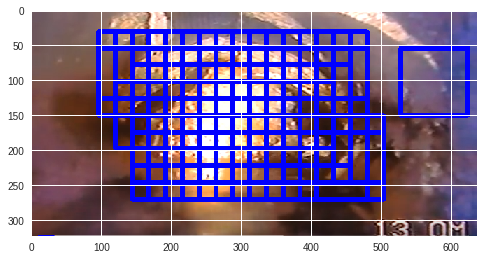

../test/test2.PNG
16


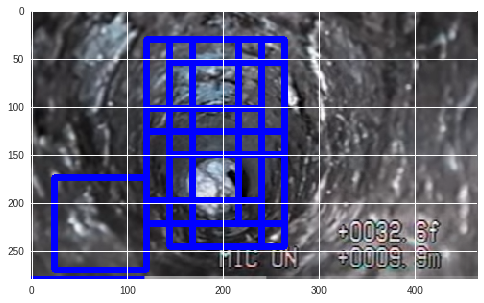

../test/test3.PNG
16


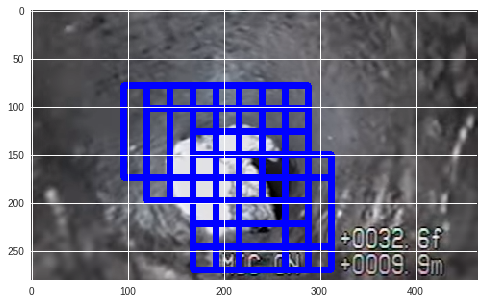

../test/test1.PNG
16


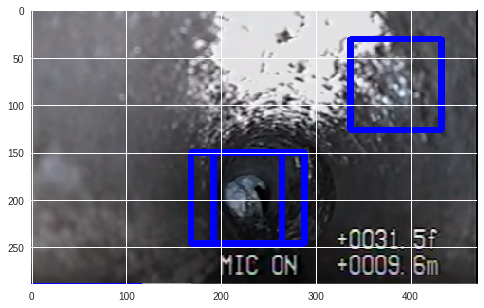

In [108]:
import matplotlib.pyplot as plt
ystart = 30
ystop = 270
scale = 1.5
pix_per_cell=8
cell_per_block=2
test_images=glob.glob('../test/*.PNG')
# print(test_images)
for fname in test_images:
#     print(fname)
    test_img=cv2.imread(fname)
    plt.imshow(test_img)
    #plt.subplot(6,1,i)
    boxes=find_roots(test_img, ystart, ystop, scale, pix_per_cell,cell_per_block ) #, clf, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins)
    test_out_img=draw_boxes(test_img,boxes)
    plt.imshow(test_out_img)
    plt.show()

In [30]:
# os.chdir("content")
# !git pull origin melbournewater
!ls
# git pull origin experiment
# !git clone https://github.com/shreyasrivastava17/test.git

datalab  melbournewater  test


(289, 471, 3)


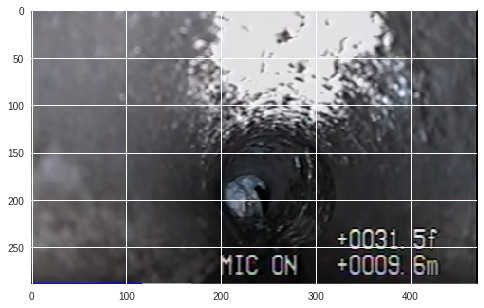

In [0]:
import matplotlib.pyplot as plt
img = cv2.imread("test1.PNG")
print(img.shape)
plt.imshow(img)
# cv2.imshow('image',img)

In [0]:
os.chdir("test")
!ls

README.md  test1.PNG  test2.PNG  test3.PNG  test4.PNG


In [35]:
im = cv2.imread( "test/test1.PNG")
im = cv2.resize(im,(58,58))
print( round(inf_model.predict(np.expand_dims(im, 0))[0, 0]))

0.0


In [68]:
!git pull

Already up-to-date.


In [36]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

../test/test4.PNG
23


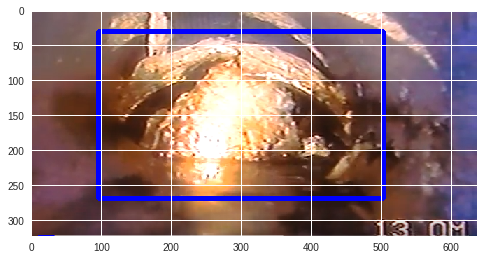

../test/test2.PNG
16


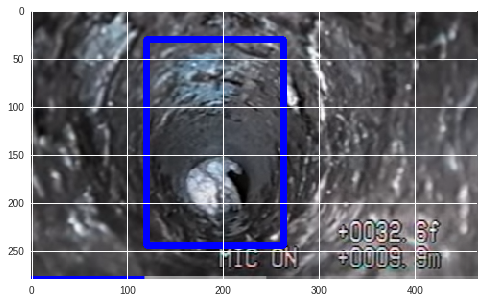

../test/test3.PNG
16


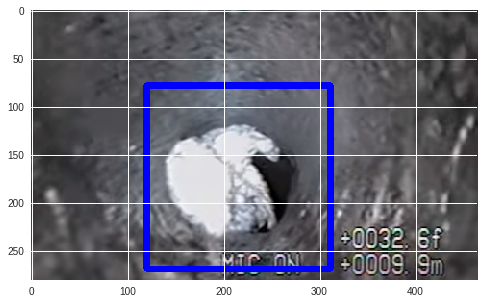

../test/test1.PNG
16


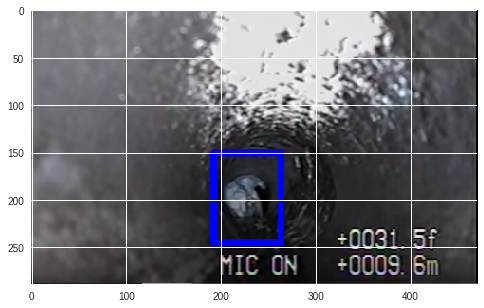

In [112]:
#print(scales,ystarts)
from collections import deque

heat_history=deque(maxlen=8)
def process_frame(image):
    boxes=[]
#     for i in range(len(scales)):
    boxes.append(find_roots(image, ystart, ystop, scale, pix_per_cell,cell_per_block )) #find_roots(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins))
    
    boxes = [item for sublist in boxes for item in sublist] 
    heatmap_img = np.zeros_like(image[:,:,0])
    heatmap_img = add_heat(heatmap_img, boxes)
    
#     heat_history.append(heatmap_img)
#     heatmap_img = np.array(heat_history).sum(axis=0)
    heatmap_img = apply_threshold(heatmap_img,1)#
    
    # # Find final boxes from heatmap using label function
    labels = label(heatmap_img)#
    draw_img = draw_labeled_bboxes(np.copy(image), labels)#
#     draw_img = draw_boxes(image,boxes)
#     print(boxes)
    return draw_img
test_images=glob.glob('../test/*.PNG')
for fname in test_images:
#     print(fname)
    test_img=cv2.imread(fname)
    plt.imshow(test_img)
    #plt.subplot(6,1,i)
    final_image=process_frame(test_img)
    plt.imshow(final_image)
    plt.show()
# plt.imshow(process_frame(im))


In [113]:
# os.chdir("Tree_Root_Detection")
!wget https://r2---sn-51uxj5-cvbe.googlevideo.com/videoplayback?ip=191.102.91.234&sparams=clen%2Cdur%2Cei%2Cgir%2Cid%2Cinitcwndbps%2Cip%2Cipbits%2Citag%2Clmt%2Cmime%2Cmm%2Cmn%2Cms%2Cmv%2Cpcm2cms%2Cpl%2Cratebypass%2Crequiressl%2Csource%2Cexpire&fexp=23709359%2C23745105&ei=4URIW-y-MZ7ej-8PjOOF-As&id=o-ABrMOgpF2TNUBGHRpTIXA7Vta2-4tyUl9uWCQYdGhNIU&clen=30980789&requiressl=yes&gir=yes&dur=422.045&initcwndbps=212500&pl=24&ratebypass=yes&source=youtube&pcm2cms=yes&ipbits=0&lmt=1386844977034659&itag=18&fvip=2&expire=1531484481&mime=video%2Fmp4&key=yt6&mm=31%2C29&mn=sn-51uxj5-cvbe%2Csn-cvb7ln7l&c=WEB&mt=1531462841&mv=m&ms=au%2Crdu&signature=18027C4C75DCEAAB5B1E61D4E0A024F3533DECBB.26ADC4907A1973955EDCF5A3F5A659F9BDD0CD87&video_id=j2e6XmTPX5E&title=Plumbing+Camera+-+shows+pipe+needs+sewer+line+repair

--2018-07-13 06:57:40--  https://r2---sn-51uxj5-cvbe.googlevideo.com/videoplayback?ip=191.102.91.234
Resolving r2---sn-51uxj5-cvbe.googlevideo.com (r2---sn-51uxj5-cvbe.googlevideo.com)... 

In [115]:
!git pull
# !ls
# os.chdir("content/melbournewater")
!ls

remote: Counting objects: 5, done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/shreyasrivastava17/melbournewater
   6b7c553..3ab3bd9  master     -> origin/master
Updating 6b7c553..3ab3bd9
Fast-forward
 data/test_images/sewer_debris.mp4 | Bin 0 -> 12048885 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 data/test_images/sewer_debris.mp4
data		  heatmap added.ipynb  kerasmodel.json	view?usp=drivesdk
Debris Detection  kerasmodel.h5        README.md


In [102]:
!pip install moviepy

    100% |████████████████████████████████| 378kB 5.2MB/s 
    100% |████████████████████████████████| 3.3MB 4.9MB/s 
    100% |████████████████████████████████| 51kB 19.6MB/s 
  Running setup.py bdist_wheel for moviepy ... - \ done
  Stored in directory: /content/.cache/pip/wheels/ad/92/4d/a6c6307d4c2219d002646bd4a5987e31fd5697f6ea7778b2c0
Successfully built moviepy


In [0]:
from moviepy.editor import VideoFileClip

output_location = 'sewer_footage1_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
video_input = VideoFileClip("data/test_images/sewer_debris.mp4")#.subclip(105,305)

video_output = video_input.fl_image(process_frame) #NOTE: this function expects color images!!

#%time undist_clip.write_videofile(undist_output, audio=False)
# print("anupam")
video_output.write_videofile(output_location, audio=False)
video_input.reader.close()
video_input.audio.reader.close_proc()
video_output.reader.close()
video_output.audio.reader.close_proc()

10
[MoviePy] >>>> Building video sewer_footage1_output.mp4
[MoviePy] Writing video sewer_footage1_output.mp4





  0%|          | 0/12652 [00:00<?, ?it/s]

10





  0%|          | 1/12652 [00:00<30:08,  6.99it/s]

10





  0%|          | 2/12652 [00:00<29:03,  7.26it/s]

10





  0%|          | 3/12652 [00:00<30:50,  6.83it/s]

10





  0%|          | 4/12652 [00:00<31:57,  6.60it/s]

10





  0%|          | 5/12652 [00:00<32:49,  6.42it/s]

10





  0%|          | 6/12652 [00:00<33:17,  6.33it/s]

10





  0%|          | 7/12652 [00:01<33:40,  6.26it/s]

10





  0%|          | 8/12652 [00:01<33:48,  6.23it/s]

10





  0%|          | 9/12652 [00:01<34:07,  6.17it/s]

10





  0%|          | 10/12652 [00:01<34:28,  6.11it/s]

10





  0%|          | 11/12652 [00:01<34:17,  6.14it/s]

10





  0%|          | 12/12652 [00:01<33:53,  6.22it/s]

10





  0%|          | 13/12652 [00:02<33:37,  6.27it/s]

10





  0%|          | 14/12652 [00:02<33:17,  6.33it/s]

10





  0%|          | 15/12652 [00:02<33:07,  6.36it/s]

10





  0%|          | 16/12652 [00:02<33:00,  6.38it/s]

10





  0%|          | 17/12652 [00:02<32:56,  6.39it/s]

10





  0%|          | 18/12652 [00:02<32:55,  6.39it/s]

10





  0%|          | 19/12652 [00:02<32:50,  6.41it/s]

10





  0%|          | 20/12652 [00:03<32:52,  6.40it/s]

10





  0%|          | 21/12652 [00:03<32:51,  6.41it/s]

10





  0%|          | 22/12652 [00:03<32:47,  6.42it/s]

10





  0%|          | 23/12652 [00:03<32:39,  6.44it/s]

10





  0%|          | 24/12652 [00:03<32:42,  6.43it/s]

10





  0%|          | 25/12652 [00:03<32:40,  6.44it/s]

10





  0%|          | 26/12652 [00:04<32:31,  6.47it/s]

10





  0%|          | 27/12652 [00:04<32:27,  6.48it/s]

10





  0%|          | 28/12652 [00:04<32:26,  6.48it/s]

10





  0%|          | 29/12652 [00:04<32:23,  6.49it/s]

10





  0%|          | 30/12652 [00:04<32:17,  6.52it/s]

10





  0%|          | 31/12652 [00:04<32:13,  6.53it/s]

10





  0%|          | 32/12652 [00:04<32:11,  6.53it/s]

10





  0%|          | 33/12652 [00:05<32:09,  6.54it/s]

10





  0%|          | 34/12652 [00:05<32:02,  6.56it/s]

10





  0%|          | 35/12652 [00:05<31:59,  6.57it/s]

10





  0%|          | 36/12652 [00:05<31:55,  6.59it/s]

10





  0%|          | 37/12652 [00:05<31:59,  6.57it/s]

10





  0%|          | 38/12652 [00:05<32:04,  6.56it/s]

10





  0%|          | 39/12652 [00:05<32:04,  6.55it/s]

10





  0%|          | 40/12652 [00:06<32:07,  6.54it/s]

10





  0%|          | 41/12652 [00:06<32:03,  6.56it/s]

10





  0%|          | 42/12652 [00:06<32:01,  6.56it/s]

10





  0%|          | 43/12652 [00:06<32:01,  6.56it/s]

10





  0%|          | 44/12652 [00:06<32:03,  6.55it/s]

10





  0%|          | 45/12652 [00:06<32:05,  6.55it/s]

10





  0%|          | 46/12652 [00:07<32:09,  6.53it/s]

10





  0%|          | 47/12652 [00:07<32:06,  6.54it/s]

10





  0%|          | 48/12652 [00:07<32:13,  6.52it/s]

10





  0%|          | 49/12652 [00:07<32:12,  6.52it/s]

10





  0%|          | 50/12652 [00:07<32:11,  6.52it/s]

10





  0%|          | 51/12652 [00:07<32:15,  6.51it/s]

10





  0%|          | 52/12652 [00:07<32:12,  6.52it/s]

10





  0%|          | 53/12652 [00:08<32:15,  6.51it/s]

10





  0%|          | 54/12652 [00:08<32:13,  6.51it/s]

10





  0%|          | 55/12652 [00:08<32:10,  6.53it/s]

10





  0%|          | 56/12652 [00:08<32:09,  6.53it/s]

10





  0%|          | 57/12652 [00:08<32:10,  6.52it/s]

10





  0%|          | 58/12652 [00:08<32:12,  6.52it/s]

10





  0%|          | 59/12652 [00:09<32:12,  6.52it/s]

10





  0%|          | 60/12652 [00:09<32:13,  6.51it/s]

10





  0%|          | 61/12652 [00:09<32:11,  6.52it/s]

10





  0%|          | 62/12652 [00:09<32:10,  6.52it/s]

10





  0%|          | 63/12652 [00:09<32:06,  6.53it/s]

10





  1%|          | 64/12652 [00:09<32:05,  6.54it/s]

10





  1%|          | 65/12652 [00:09<32:03,  6.54it/s]

10





  1%|          | 66/12652 [00:10<31:59,  6.56it/s]

10





  1%|          | 67/12652 [00:10<32:01,  6.55it/s]

10





  1%|          | 68/12652 [00:10<31:59,  6.56it/s]

10





  1%|          | 69/12652 [00:10<31:57,  6.56it/s]

10





  1%|          | 70/12652 [00:10<31:56,  6.56it/s]

10





  1%|          | 71/12652 [00:10<31:56,  6.56it/s]

10





  1%|          | 72/12652 [00:10<31:58,  6.56it/s]

10





  1%|          | 73/12652 [00:11<32:00,  6.55it/s]

10





  1%|          | 74/12652 [00:11<31:58,  6.55it/s]

10





  1%|          | 75/12652 [00:11<32:00,  6.55it/s]

10





  1%|          | 76/12652 [00:11<31:59,  6.55it/s]

10





  1%|          | 77/12652 [00:11<31:57,  6.56it/s]

10





  1%|          | 78/12652 [00:11<31:55,  6.56it/s]

10





  1%|          | 79/12652 [00:12<31:54,  6.57it/s]

10





  1%|          | 80/12652 [00:12<31:53,  6.57it/s]

10





  1%|          | 81/12652 [00:12<31:52,  6.57it/s]

10





  1%|          | 82/12652 [00:12<31:55,  6.56it/s]

10





  1%|          | 83/12652 [00:12<31:55,  6.56it/s]

10





  1%|          | 84/12652 [00:12<31:57,  6.55it/s]

10





  1%|          | 85/12652 [00:12<32:01,  6.54it/s]

10





  1%|          | 86/12652 [00:13<32:01,  6.54it/s]

10





  1%|          | 87/12652 [00:13<32:01,  6.54it/s]

10





  1%|          | 88/12652 [00:13<32:00,  6.54it/s]

10





  1%|          | 89/12652 [00:13<32:01,  6.54it/s]

10





  1%|          | 90/12652 [00:13<32:00,  6.54it/s]

10





  1%|          | 91/12652 [00:13<32:00,  6.54it/s]

10





  1%|          | 92/12652 [00:14<32:00,  6.54it/s]

10





  1%|          | 93/12652 [00:14<31:59,  6.54it/s]

10





  1%|          | 94/12652 [00:14<32:01,  6.54it/s]

10





  1%|          | 95/12652 [00:14<32:03,  6.53it/s]

10





  1%|          | 96/12652 [00:14<32:02,  6.53it/s]

10





  1%|          | 97/12652 [00:14<32:02,  6.53it/s]

10





  1%|          | 98/12652 [00:15<32:01,  6.53it/s]

10





  1%|          | 99/12652 [00:15<32:01,  6.53it/s]

10





  1%|          | 100/12652 [00:15<31:59,  6.54it/s]

10





  1%|          | 101/12652 [00:15<31:58,  6.54it/s]

10





  1%|          | 102/12652 [00:15<31:57,  6.54it/s]

10





  1%|          | 103/12652 [00:15<31:56,  6.55it/s]

10





  1%|          | 104/12652 [00:15<31:56,  6.55it/s]

10





  1%|          | 105/12652 [00:16<31:56,  6.55it/s]

10





  1%|          | 106/12652 [00:16<31:56,  6.55it/s]

10





  1%|          | 107/12652 [00:16<31:54,  6.55it/s]

10





  1%|          | 108/12652 [00:16<31:54,  6.55it/s]

10





  1%|          | 109/12652 [00:16<31:53,  6.55it/s]

10





  1%|          | 110/12652 [00:16<31:52,  6.56it/s]

10





  1%|          | 111/12652 [00:16<31:52,  6.56it/s]

10





  1%|          | 112/12652 [00:17<31:51,  6.56it/s]

10





  1%|          | 113/12652 [00:17<31:49,  6.56it/s]

10





  1%|          | 114/12652 [00:17<31:50,  6.56it/s]

10





  1%|          | 115/12652 [00:17<31:49,  6.57it/s]

10





  1%|          | 116/12652 [00:17<31:49,  6.56it/s]

10





  1%|          | 117/12652 [00:17<31:50,  6.56it/s]

10





  1%|          | 118/12652 [00:17<31:50,  6.56it/s]

10





  1%|          | 119/12652 [00:18<31:51,  6.56it/s]

10





  1%|          | 120/12652 [00:18<31:50,  6.56it/s]

10





  1%|          | 121/12652 [00:18<31:49,  6.56it/s]

10





  1%|          | 122/12652 [00:18<31:50,  6.56it/s]

10





  1%|          | 123/12652 [00:18<31:49,  6.56it/s]

10





  1%|          | 124/12652 [00:18<31:49,  6.56it/s]

10





  1%|          | 125/12652 [00:19<31:49,  6.56it/s]

10





  1%|          | 126/12652 [00:19<31:48,  6.56it/s]

10





  1%|          | 127/12652 [00:19<31:48,  6.56it/s]

10





  1%|          | 128/12652 [00:19<31:48,  6.56it/s]

10





  1%|          | 129/12652 [00:19<31:47,  6.57it/s]

10





  1%|          | 130/12652 [00:19<31:46,  6.57it/s]

10





  1%|          | 131/12652 [00:19<31:46,  6.57it/s]

10





  1%|          | 132/12652 [00:20<31:45,  6.57it/s]

10





  1%|          | 133/12652 [00:20<31:45,  6.57it/s]

10





  1%|          | 134/12652 [00:20<31:45,  6.57it/s]

10





  1%|          | 135/12652 [00:20<31:44,  6.57it/s]

10





  1%|          | 136/12652 [00:20<31:44,  6.57it/s]

10





  1%|          | 137/12652 [00:20<31:43,  6.57it/s]

10





  1%|          | 138/12652 [00:20<31:43,  6.57it/s]

10





  1%|          | 139/12652 [00:21<31:42,  6.58it/s]

10





  1%|          | 140/12652 [00:21<31:42,  6.58it/s]

10





  1%|          | 141/12652 [00:21<31:41,  6.58it/s]

10





  1%|          | 142/12652 [00:21<31:41,  6.58it/s]

10





  1%|          | 143/12652 [00:21<31:41,  6.58it/s]

10





  1%|          | 144/12652 [00:21<31:40,  6.58it/s]

10





  1%|          | 145/12652 [00:22<31:40,  6.58it/s]

10





  1%|          | 146/12652 [00:22<31:40,  6.58it/s]

10





  1%|          | 147/12652 [00:22<31:39,  6.58it/s]

10





  1%|          | 148/12652 [00:22<31:39,  6.58it/s]

10





  1%|          | 149/12652 [00:22<31:39,  6.58it/s]

10





  1%|          | 150/12652 [00:22<31:38,  6.59it/s]

10





  1%|          | 151/12652 [00:22<31:39,  6.58it/s]

10





  1%|          | 152/12652 [00:23<31:38,  6.59it/s]

10





  1%|          | 153/12652 [00:23<31:36,  6.59it/s]

10





  1%|          | 154/12652 [00:23<31:35,  6.59it/s]

10





  1%|          | 155/12652 [00:23<31:36,  6.59it/s]

10





  1%|          | 156/12652 [00:23<31:36,  6.59it/s]

10





  1%|          | 157/12652 [00:23<31:38,  6.58it/s]

10





  1%|          | 158/12652 [00:23<31:37,  6.58it/s]

10





  1%|▏         | 159/12652 [00:24<31:37,  6.58it/s]

10





  1%|▏         | 160/12652 [00:24<31:36,  6.59it/s]

10





  1%|▏         | 161/12652 [00:24<31:35,  6.59it/s]

10





  1%|▏         | 162/12652 [00:24<31:36,  6.59it/s]

10





  1%|▏         | 163/12652 [00:24<31:36,  6.59it/s]

10





  1%|▏         | 164/12652 [00:24<31:35,  6.59it/s]

10





  1%|▏         | 165/12652 [00:25<31:35,  6.59it/s]

10





  1%|▏         | 166/12652 [00:25<31:35,  6.59it/s]

10





  1%|▏         | 167/12652 [00:25<31:34,  6.59it/s]

10





  1%|▏         | 168/12652 [00:25<31:34,  6.59it/s]

10





  1%|▏         | 169/12652 [00:25<31:35,  6.59it/s]

10





  1%|▏         | 170/12652 [00:25<31:35,  6.59it/s]

10





  1%|▏         | 171/12652 [00:25<31:36,  6.58it/s]

10





  1%|▏         | 172/12652 [00:26<31:37,  6.58it/s]

10





  1%|▏         | 173/12652 [00:26<31:39,  6.57it/s]

10





  1%|▏         | 174/12652 [00:26<31:41,  6.56it/s]

10





  1%|▏         | 175/12652 [00:26<31:43,  6.55it/s]

10





  1%|▏         | 176/12652 [00:26<31:43,  6.55it/s]

10





  1%|▏         | 177/12652 [00:27<31:45,  6.55it/s]

10





  1%|▏         | 178/12652 [00:27<31:46,  6.54it/s]

10





  1%|▏         | 179/12652 [00:27<31:46,  6.54it/s]

10





  1%|▏         | 180/12652 [00:27<31:46,  6.54it/s]

10





  1%|▏         | 181/12652 [00:27<31:47,  6.54it/s]

10





  1%|▏         | 182/12652 [00:27<31:47,  6.54it/s]

10





  1%|▏         | 183/12652 [00:27<31:47,  6.54it/s]

10





  1%|▏         | 184/12652 [00:28<31:48,  6.53it/s]

10





  1%|▏         | 185/12652 [00:28<31:48,  6.53it/s]

10





  1%|▏         | 186/12652 [00:28<31:48,  6.53it/s]

10





  1%|▏         | 187/12652 [00:28<31:48,  6.53it/s]

10





  1%|▏         | 188/12652 [00:28<31:48,  6.53it/s]

10





  1%|▏         | 189/12652 [00:28<31:48,  6.53it/s]

10





  2%|▏         | 190/12652 [00:29<31:48,  6.53it/s]

10





  2%|▏         | 191/12652 [00:29<31:48,  6.53it/s]

10





  2%|▏         | 192/12652 [00:29<31:47,  6.53it/s]

10





  2%|▏         | 193/12652 [00:29<31:48,  6.53it/s]

10





  2%|▏         | 194/12652 [00:29<31:47,  6.53it/s]

10





  2%|▏         | 195/12652 [00:29<31:47,  6.53it/s]

10





  2%|▏         | 196/12652 [00:30<31:46,  6.53it/s]

10





  2%|▏         | 197/12652 [00:30<31:47,  6.53it/s]

10





  2%|▏         | 198/12652 [00:30<31:48,  6.53it/s]

10





  2%|▏         | 199/12652 [00:30<31:48,  6.53it/s]

10





  2%|▏         | 200/12652 [00:30<31:47,  6.53it/s]

10





  2%|▏         | 201/12652 [00:30<31:47,  6.53it/s]

10





  2%|▏         | 202/12652 [00:30<31:46,  6.53it/s]

10





  2%|▏         | 203/12652 [00:31<31:45,  6.53it/s]

10





  2%|▏         | 204/12652 [00:31<31:45,  6.53it/s]

10





  2%|▏         | 205/12652 [00:31<31:45,  6.53it/s]

10





  2%|▏         | 206/12652 [00:31<31:45,  6.53it/s]

10





  2%|▏         | 207/12652 [00:31<31:45,  6.53it/s]

10





  2%|▏         | 208/12652 [00:31<31:44,  6.53it/s]

10





  2%|▏         | 209/12652 [00:31<31:44,  6.53it/s]

10





  2%|▏         | 210/12652 [00:32<31:43,  6.54it/s]

10





  2%|▏         | 211/12652 [00:32<31:43,  6.54it/s]

10





  2%|▏         | 212/12652 [00:32<31:42,  6.54it/s]

10





  2%|▏         | 213/12652 [00:32<31:43,  6.53it/s]

10





  2%|▏         | 214/12652 [00:32<31:43,  6.53it/s]

10





  2%|▏         | 215/12652 [00:32<31:44,  6.53it/s]

10





  2%|▏         | 216/12652 [00:33<31:45,  6.53it/s]

10





  2%|▏         | 217/12652 [00:33<31:46,  6.52it/s]

10





  2%|▏         | 218/12652 [00:33<31:46,  6.52it/s]

10





  2%|▏         | 219/12652 [00:33<31:46,  6.52it/s]

10





  2%|▏         | 220/12652 [00:33<31:46,  6.52it/s]

10





  2%|▏         | 221/12652 [00:33<31:45,  6.52it/s]

10





  2%|▏         | 222/12652 [00:34<31:44,  6.53it/s]

10





  2%|▏         | 223/12652 [00:34<31:43,  6.53it/s]

10





  2%|▏         | 224/12652 [00:34<31:42,  6.53it/s]

10





  2%|▏         | 225/12652 [00:34<31:42,  6.53it/s]

10





  2%|▏         | 226/12652 [00:34<31:42,  6.53it/s]

10





  2%|▏         | 227/12652 [00:34<31:41,  6.53it/s]

10





  2%|▏         | 228/12652 [00:34<31:40,  6.54it/s]

10





  2%|▏         | 229/12652 [00:35<31:39,  6.54it/s]

10





  2%|▏         | 230/12652 [00:35<31:39,  6.54it/s]

10





  2%|▏         | 231/12652 [00:35<31:38,  6.54it/s]

10





  2%|▏         | 232/12652 [00:35<31:38,  6.54it/s]

10





  2%|▏         | 233/12652 [00:35<31:37,  6.54it/s]

10





  2%|▏         | 234/12652 [00:35<31:37,  6.54it/s]

10





  2%|▏         | 235/12652 [00:35<31:36,  6.55it/s]

10





  2%|▏         | 236/12652 [00:36<31:36,  6.55it/s]

10





  2%|▏         | 237/12652 [00:36<31:35,  6.55it/s]

10





  2%|▏         | 238/12652 [00:36<31:35,  6.55it/s]

10





  2%|▏         | 239/12652 [00:36<31:34,  6.55it/s]

10





  2%|▏         | 240/12652 [00:36<31:34,  6.55it/s]

10





  2%|▏         | 241/12652 [00:36<31:34,  6.55it/s]

10





  2%|▏         | 242/12652 [00:36<31:34,  6.55it/s]

10





  2%|▏         | 243/12652 [00:37<31:34,  6.55it/s]

10





  2%|▏         | 244/12652 [00:37<31:34,  6.55it/s]

10





  2%|▏         | 245/12652 [00:37<31:34,  6.55it/s]

10





  2%|▏         | 246/12652 [00:37<31:34,  6.55it/s]

10





  2%|▏         | 247/12652 [00:37<31:34,  6.55it/s]

10





  2%|▏         | 248/12652 [00:37<31:33,  6.55it/s]

10





  2%|▏         | 249/12652 [00:38<31:33,  6.55it/s]

10





  2%|▏         | 250/12652 [00:38<31:32,  6.55it/s]

10





  2%|▏         | 251/12652 [00:38<31:31,  6.55it/s]

10





  2%|▏         | 252/12652 [00:38<31:31,  6.56it/s]

10





  2%|▏         | 253/12652 [00:38<31:30,  6.56it/s]

10





  2%|▏         | 254/12652 [00:38<31:30,  6.56it/s]

10





  2%|▏         | 255/12652 [00:38<31:30,  6.56it/s]

10





  2%|▏         | 256/12652 [00:39<31:29,  6.56it/s]

10





  2%|▏         | 257/12652 [00:39<31:30,  6.56it/s]

10





  2%|▏         | 258/12652 [00:39<31:29,  6.56it/s]

10





  2%|▏         | 259/12652 [00:39<31:28,  6.56it/s]

10





  2%|▏         | 260/12652 [00:39<31:28,  6.56it/s]

10





  2%|▏         | 261/12652 [00:39<31:28,  6.56it/s]

10





  2%|▏         | 262/12652 [00:39<31:28,  6.56it/s]

10





  2%|▏         | 263/12652 [00:40<31:28,  6.56it/s]

10





  2%|▏         | 264/12652 [00:40<31:28,  6.56it/s]

10





  2%|▏         | 265/12652 [00:40<31:28,  6.56it/s]

10





  2%|▏         | 266/12652 [00:40<31:28,  6.56it/s]

10





  2%|▏         | 267/12652 [00:40<31:28,  6.56it/s]

10





  2%|▏         | 268/12652 [00:40<31:28,  6.56it/s]

10





  2%|▏         | 269/12652 [00:41<31:29,  6.55it/s]

10





  2%|▏         | 270/12652 [00:41<31:28,  6.55it/s]

10





  2%|▏         | 271/12652 [00:41<31:28,  6.55it/s]

10





  2%|▏         | 272/12652 [00:41<31:29,  6.55it/s]

10





  2%|▏         | 273/12652 [00:41<31:29,  6.55it/s]

10





  2%|▏         | 274/12652 [00:41<31:29,  6.55it/s]

10





  2%|▏         | 275/12652 [00:42<31:30,  6.55it/s]

10





  2%|▏         | 276/12652 [00:42<31:30,  6.55it/s]

10





  2%|▏         | 277/12652 [00:42<31:31,  6.54it/s]

10





  2%|▏         | 278/12652 [00:42<31:32,  6.54it/s]

10





  2%|▏         | 279/12652 [00:42<31:33,  6.54it/s]

10





  2%|▏         | 280/12652 [00:42<31:33,  6.53it/s]

10





  2%|▏         | 281/12652 [00:43<31:33,  6.53it/s]

10





  2%|▏         | 282/12652 [00:43<31:34,  6.53it/s]

10





  2%|▏         | 283/12652 [00:43<31:34,  6.53it/s]

10





  2%|▏         | 284/12652 [00:43<31:34,  6.53it/s]

10





  2%|▏         | 285/12652 [00:43<31:35,  6.53it/s]

10





  2%|▏         | 286/12652 [00:43<31:35,  6.52it/s]

10





  2%|▏         | 287/12652 [00:43<31:35,  6.52it/s]

10





  2%|▏         | 288/12652 [00:44<31:35,  6.52it/s]

10





  2%|▏         | 289/12652 [00:44<31:36,  6.52it/s]

10





  2%|▏         | 290/12652 [00:44<31:37,  6.51it/s]

10





  2%|▏         | 291/12652 [00:44<31:38,  6.51it/s]

10





  2%|▏         | 292/12652 [00:44<31:39,  6.51it/s]

10





  2%|▏         | 293/12652 [00:45<31:39,  6.51it/s]

10





  2%|▏         | 294/12652 [00:45<31:39,  6.51it/s]

10





  2%|▏         | 295/12652 [00:45<31:40,  6.50it/s]

10





  2%|▏         | 296/12652 [00:45<31:39,  6.50it/s]

10





  2%|▏         | 297/12652 [00:45<31:39,  6.50it/s]

10





  2%|▏         | 298/12652 [00:45<31:40,  6.50it/s]

10





  2%|▏         | 299/12652 [00:46<31:41,  6.50it/s]

10





  2%|▏         | 300/12652 [00:46<31:41,  6.50it/s]

10





  2%|▏         | 301/12652 [00:46<31:41,  6.49it/s]

10





  2%|▏         | 302/12652 [00:46<31:42,  6.49it/s]

10





  2%|▏         | 303/12652 [00:46<31:43,  6.49it/s]

10





  2%|▏         | 304/12652 [00:46<31:43,  6.49it/s]

10





  2%|▏         | 305/12652 [00:47<31:43,  6.49it/s]

10





  2%|▏         | 306/12652 [00:47<31:43,  6.49it/s]

10





  2%|▏         | 307/12652 [00:47<31:44,  6.48it/s]

10





  2%|▏         | 308/12652 [00:47<31:45,  6.48it/s]

10





  2%|▏         | 309/12652 [00:47<31:45,  6.48it/s]

10





  2%|▏         | 310/12652 [00:47<31:45,  6.48it/s]

10





  2%|▏         | 311/12652 [00:48<31:44,  6.48it/s]

10





  2%|▏         | 312/12652 [00:48<31:45,  6.48it/s]

10





  2%|▏         | 313/12652 [00:48<31:44,  6.48it/s]

10





  2%|▏         | 314/12652 [00:48<31:45,  6.48it/s]

10





  2%|▏         | 315/12652 [00:48<31:45,  6.48it/s]

10





  2%|▏         | 316/12652 [00:48<31:45,  6.47it/s]

10





  3%|▎         | 317/12652 [00:48<31:45,  6.47it/s]

10





  3%|▎         | 318/12652 [00:49<31:45,  6.47it/s]

10





  3%|▎         | 319/12652 [00:49<31:45,  6.47it/s]

10





  3%|▎         | 320/12652 [00:49<31:45,  6.47it/s]

10





  3%|▎         | 321/12652 [00:49<31:45,  6.47it/s]

10





  3%|▎         | 322/12652 [00:49<31:45,  6.47it/s]

10





  3%|▎         | 323/12652 [00:49<31:45,  6.47it/s]

10





  3%|▎         | 324/12652 [00:50<31:45,  6.47it/s]

10





  3%|▎         | 325/12652 [00:50<31:46,  6.47it/s]

10





  3%|▎         | 326/12652 [00:50<31:47,  6.46it/s]

10





  3%|▎         | 327/12652 [00:50<31:48,  6.46it/s]

10





  3%|▎         | 328/12652 [00:50<31:49,  6.45it/s]

10





  3%|▎         | 329/12652 [00:50<31:49,  6.46it/s]

10





  3%|▎         | 330/12652 [00:51<31:50,  6.45it/s]

10





  3%|▎         | 331/12652 [00:51<31:50,  6.45it/s]

10





  3%|▎         | 332/12652 [00:51<31:51,  6.45it/s]

10





  3%|▎         | 333/12652 [00:51<31:51,  6.45it/s]

10





  3%|▎         | 334/12652 [00:51<31:50,  6.45it/s]

10





  3%|▎         | 335/12652 [00:51<31:50,  6.45it/s]

10





  3%|▎         | 336/12652 [00:52<31:49,  6.45it/s]

10





  3%|▎         | 337/12652 [00:52<31:49,  6.45it/s]

10





  3%|▎         | 338/12652 [00:52<31:49,  6.45it/s]

10





  3%|▎         | 339/12652 [00:52<31:49,  6.45it/s]

10





  3%|▎         | 340/12652 [00:52<31:49,  6.45it/s]

10





  3%|▎         | 341/12652 [00:52<31:49,  6.45it/s]

10





  3%|▎         | 342/12652 [00:53<31:49,  6.45it/s]

10





  3%|▎         | 343/12652 [00:53<31:48,  6.45it/s]

10





  3%|▎         | 344/12652 [00:53<31:48,  6.45it/s]

10





  3%|▎         | 345/12652 [00:53<31:48,  6.45it/s]

10





  3%|▎         | 346/12652 [00:53<31:48,  6.45it/s]

10





  3%|▎         | 347/12652 [00:53<31:48,  6.45it/s]

10





  3%|▎         | 348/12652 [00:53<31:48,  6.45it/s]

10





  3%|▎         | 349/12652 [00:54<31:48,  6.44it/s]

10





  3%|▎         | 350/12652 [00:54<31:49,  6.44it/s]

10





  3%|▎         | 351/12652 [00:54<31:49,  6.44it/s]

10





  3%|▎         | 352/12652 [00:54<31:49,  6.44it/s]

10





  3%|▎         | 353/12652 [00:54<31:48,  6.44it/s]

10





  3%|▎         | 354/12652 [00:54<31:48,  6.44it/s]

10





  3%|▎         | 355/12652 [00:55<31:49,  6.44it/s]

10





  3%|▎         | 356/12652 [00:55<31:49,  6.44it/s]

10





  3%|▎         | 357/12652 [00:55<31:49,  6.44it/s]

10





  3%|▎         | 358/12652 [00:55<31:49,  6.44it/s]

10





  3%|▎         | 359/12652 [00:55<31:48,  6.44it/s]

10





  3%|▎         | 360/12652 [00:55<31:48,  6.44it/s]

10





  3%|▎         | 361/12652 [00:56<31:48,  6.44it/s]

10





  3%|▎         | 362/12652 [00:56<31:48,  6.44it/s]

10





  3%|▎         | 363/12652 [00:56<31:48,  6.44it/s]

10





  3%|▎         | 364/12652 [00:56<31:48,  6.44it/s]

10





  3%|▎         | 365/12652 [00:56<31:48,  6.44it/s]

10





  3%|▎         | 366/12652 [00:56<31:48,  6.44it/s]

10





  3%|▎         | 367/12652 [00:56<31:47,  6.44it/s]

10





  3%|▎         | 368/12652 [00:57<31:47,  6.44it/s]

10





  3%|▎         | 369/12652 [00:57<31:47,  6.44it/s]

10





  3%|▎         | 370/12652 [00:57<31:47,  6.44it/s]

10





  3%|▎         | 371/12652 [00:57<31:47,  6.44it/s]

10





  3%|▎         | 372/12652 [00:57<31:46,  6.44it/s]

10





  3%|▎         | 373/12652 [00:57<31:46,  6.44it/s]

10





  3%|▎         | 374/12652 [00:58<31:46,  6.44it/s]

10





  3%|▎         | 375/12652 [00:58<31:46,  6.44it/s]

10





  3%|▎         | 376/12652 [00:58<31:45,  6.44it/s]

10





  3%|▎         | 377/12652 [00:58<31:45,  6.44it/s]

10





  3%|▎         | 378/12652 [00:58<31:45,  6.44it/s]

10





  3%|▎         | 379/12652 [00:58<31:45,  6.44it/s]

10





  3%|▎         | 380/12652 [00:59<31:45,  6.44it/s]

10





  3%|▎         | 381/12652 [00:59<31:45,  6.44it/s]

10





  3%|▎         | 382/12652 [00:59<31:46,  6.44it/s]

10





  3%|▎         | 383/12652 [00:59<31:46,  6.44it/s]

10





  3%|▎         | 384/12652 [00:59<31:45,  6.44it/s]

10





  3%|▎         | 385/12652 [00:59<31:45,  6.44it/s]

10





  3%|▎         | 386/12652 [00:59<31:45,  6.44it/s]

10





  3%|▎         | 387/12652 [01:00<31:45,  6.44it/s]

10





  3%|▎         | 388/12652 [01:00<31:45,  6.44it/s]

10





  3%|▎         | 389/12652 [01:00<31:45,  6.43it/s]

10





  3%|▎         | 390/12652 [01:00<31:45,  6.43it/s]

10





  3%|▎         | 391/12652 [01:00<31:45,  6.43it/s]

10





  3%|▎         | 392/12652 [01:00<31:45,  6.44it/s]

10





  3%|▎         | 393/12652 [01:01<31:45,  6.43it/s]

10





  3%|▎         | 394/12652 [01:01<31:45,  6.43it/s]

10





  3%|▎         | 395/12652 [01:01<31:44,  6.44it/s]

10





  3%|▎         | 396/12652 [01:01<31:44,  6.43it/s]

10





  3%|▎         | 397/12652 [01:01<31:44,  6.44it/s]

10





  3%|▎         | 398/12652 [01:01<31:44,  6.44it/s]

10





  3%|▎         | 399/12652 [01:01<31:43,  6.44it/s]

10





  3%|▎         | 400/12652 [01:02<31:43,  6.44it/s]

10





  3%|▎         | 401/12652 [01:02<31:43,  6.44it/s]

10





  3%|▎         | 402/12652 [01:02<31:43,  6.43it/s]

10





  3%|▎         | 403/12652 [01:02<31:43,  6.43it/s]

10





  3%|▎         | 404/12652 [01:02<31:43,  6.43it/s]

10





  3%|▎         | 405/12652 [01:02<31:43,  6.43it/s]

10





  3%|▎         | 406/12652 [01:03<31:43,  6.43it/s]

10





  3%|▎         | 407/12652 [01:03<31:42,  6.43it/s]

10





  3%|▎         | 408/12652 [01:03<31:42,  6.44it/s]

10





  3%|▎         | 409/12652 [01:03<31:42,  6.44it/s]

10





  3%|▎         | 410/12652 [01:03<31:42,  6.44it/s]

10





  3%|▎         | 411/12652 [01:03<31:42,  6.44it/s]

10





  3%|▎         | 412/12652 [01:04<31:42,  6.43it/s]

10





  3%|▎         | 413/12652 [01:04<31:41,  6.44it/s]

10





  3%|▎         | 414/12652 [01:04<31:42,  6.43it/s]

10





  3%|▎         | 415/12652 [01:04<31:42,  6.43it/s]

10





  3%|▎         | 416/12652 [01:04<31:41,  6.43it/s]

10





  3%|▎         | 417/12652 [01:04<31:41,  6.43it/s]

10





  3%|▎         | 418/12652 [01:04<31:41,  6.43it/s]

10





  3%|▎         | 419/12652 [01:05<31:41,  6.43it/s]

10





  3%|▎         | 420/12652 [01:05<31:41,  6.43it/s]

10





  3%|▎         | 421/12652 [01:05<31:40,  6.43it/s]

10





  3%|▎         | 422/12652 [01:05<31:40,  6.43it/s]

10





  3%|▎         | 423/12652 [01:05<31:40,  6.43it/s]

10





  3%|▎         | 424/12652 [01:05<31:40,  6.43it/s]

10





  3%|▎         | 425/12652 [01:06<31:40,  6.43it/s]

10





  3%|▎         | 426/12652 [01:06<31:40,  6.43it/s]

10





  3%|▎         | 427/12652 [01:06<31:40,  6.43it/s]

10





  3%|▎         | 428/12652 [01:06<31:40,  6.43it/s]

10





  3%|▎         | 429/12652 [01:06<31:40,  6.43it/s]

10





  3%|▎         | 430/12652 [01:06<31:40,  6.43it/s]

10





  3%|▎         | 431/12652 [01:07<31:40,  6.43it/s]

10





  3%|▎         | 432/12652 [01:07<31:40,  6.43it/s]

10





  3%|▎         | 433/12652 [01:07<31:39,  6.43it/s]

10





  3%|▎         | 434/12652 [01:07<31:39,  6.43it/s]

10





  3%|▎         | 435/12652 [01:07<31:39,  6.43it/s]

10





  3%|▎         | 436/12652 [01:07<31:38,  6.43it/s]

10





  3%|▎         | 437/12652 [01:07<31:39,  6.43it/s]

10





  3%|▎         | 438/12652 [01:08<31:38,  6.43it/s]

10





  3%|▎         | 439/12652 [01:08<31:38,  6.43it/s]

10





  3%|▎         | 440/12652 [01:08<31:38,  6.43it/s]

10





  3%|▎         | 441/12652 [01:08<31:37,  6.43it/s]

10





  3%|▎         | 442/12652 [01:08<31:37,  6.43it/s]

10





  4%|▎         | 443/12652 [01:08<31:37,  6.43it/s]

10





  4%|▎         | 444/12652 [01:09<31:37,  6.43it/s]

10





  4%|▎         | 445/12652 [01:09<31:37,  6.43it/s]

10





  4%|▎         | 446/12652 [01:09<31:36,  6.44it/s]

10





  4%|▎         | 447/12652 [01:09<31:36,  6.44it/s]

10





  4%|▎         | 448/12652 [01:09<31:36,  6.43it/s]

10





  4%|▎         | 449/12652 [01:09<31:36,  6.43it/s]

10





  4%|▎         | 450/12652 [01:09<31:36,  6.44it/s]

10





  4%|▎         | 451/12652 [01:10<31:36,  6.43it/s]

10





  4%|▎         | 452/12652 [01:10<31:36,  6.43it/s]

10





  4%|▎         | 453/12652 [01:10<31:36,  6.43it/s]

10





  4%|▎         | 454/12652 [01:10<31:36,  6.43it/s]

10





  4%|▎         | 455/12652 [01:10<31:36,  6.43it/s]

10





  4%|▎         | 456/12652 [01:10<31:36,  6.43it/s]

10





  4%|▎         | 457/12652 [01:11<31:35,  6.43it/s]

10





  4%|▎         | 458/12652 [01:11<31:36,  6.43it/s]

10





  4%|▎         | 459/12652 [01:11<31:36,  6.43it/s]

10





  4%|▎         | 460/12652 [01:11<31:35,  6.43it/s]

10





  4%|▎         | 461/12652 [01:11<31:35,  6.43it/s]

10





  4%|▎         | 462/12652 [01:11<31:35,  6.43it/s]

10





  4%|▎         | 463/12652 [01:11<31:35,  6.43it/s]

10





  4%|▎         | 464/12652 [01:12<31:35,  6.43it/s]

10





  4%|▎         | 465/12652 [01:12<31:35,  6.43it/s]

10





  4%|▎         | 466/12652 [01:12<31:34,  6.43it/s]

10





  4%|▎         | 467/12652 [01:12<31:34,  6.43it/s]

10





  4%|▎         | 468/12652 [01:12<31:34,  6.43it/s]

10





  4%|▎         | 469/12652 [01:12<31:34,  6.43it/s]

10





  4%|▎         | 470/12652 [01:13<31:34,  6.43it/s]

10





  4%|▎         | 471/12652 [01:13<31:34,  6.43it/s]

10





  4%|▎         | 472/12652 [01:13<31:33,  6.43it/s]

10





  4%|▎         | 473/12652 [01:13<31:33,  6.43it/s]

10





  4%|▎         | 474/12652 [01:13<31:33,  6.43it/s]

10





  4%|▍         | 475/12652 [01:13<31:33,  6.43it/s]

10





  4%|▍         | 476/12652 [01:14<31:33,  6.43it/s]

10





  4%|▍         | 477/12652 [01:14<31:33,  6.43it/s]

10





  4%|▍         | 478/12652 [01:14<31:32,  6.43it/s]

10





  4%|▍         | 479/12652 [01:14<31:32,  6.43it/s]

10





  4%|▍         | 480/12652 [01:14<31:32,  6.43it/s]

10





  4%|▍         | 481/12652 [01:14<31:32,  6.43it/s]

10





  4%|▍         | 482/12652 [01:14<31:32,  6.43it/s]

10





  4%|▍         | 483/12652 [01:15<31:32,  6.43it/s]

10





  4%|▍         | 484/12652 [01:15<31:32,  6.43it/s]

10





  4%|▍         | 485/12652 [01:15<31:32,  6.43it/s]

10





  4%|▍         | 486/12652 [01:15<31:32,  6.43it/s]

10





  4%|▍         | 487/12652 [01:15<31:31,  6.43it/s]

10





  4%|▍         | 488/12652 [01:15<31:31,  6.43it/s]

10





  4%|▍         | 489/12652 [01:16<31:31,  6.43it/s]

10





  4%|▍         | 490/12652 [01:16<31:31,  6.43it/s]

10





  4%|▍         | 491/12652 [01:16<31:31,  6.43it/s]

10





  4%|▍         | 492/12652 [01:16<31:32,  6.43it/s]

10





  4%|▍         | 493/12652 [01:16<31:32,  6.42it/s]

10





  4%|▍         | 494/12652 [01:16<31:32,  6.42it/s]

10





  4%|▍         | 495/12652 [01:17<31:32,  6.42it/s]

10





  4%|▍         | 496/12652 [01:17<31:32,  6.42it/s]

10





  4%|▍         | 497/12652 [01:17<31:32,  6.42it/s]

10





  4%|▍         | 498/12652 [01:17<31:32,  6.42it/s]

10





  4%|▍         | 499/12652 [01:17<31:32,  6.42it/s]

10





  4%|▍         | 500/12652 [01:17<31:31,  6.42it/s]

10





  4%|▍         | 501/12652 [01:18<31:31,  6.42it/s]

10





  4%|▍         | 502/12652 [01:18<31:32,  6.42it/s]

10





  4%|▍         | 503/12652 [01:18<31:32,  6.42it/s]

10





  4%|▍         | 504/12652 [01:18<31:32,  6.42it/s]

10





  4%|▍         | 505/12652 [01:18<31:32,  6.42it/s]

10





  4%|▍         | 506/12652 [01:18<31:32,  6.42it/s]

10





  4%|▍         | 507/12652 [01:18<31:31,  6.42it/s]

10





  4%|▍         | 508/12652 [01:19<31:32,  6.42it/s]

10





  4%|▍         | 509/12652 [01:19<31:31,  6.42it/s]

10





  4%|▍         | 510/12652 [01:19<31:31,  6.42it/s]

10





  4%|▍         | 511/12652 [01:19<31:31,  6.42it/s]

10





  4%|▍         | 512/12652 [01:19<31:31,  6.42it/s]

10





  4%|▍         | 513/12652 [01:19<31:31,  6.42it/s]

10





  4%|▍         | 514/12652 [01:20<31:31,  6.42it/s]

10





  4%|▍         | 515/12652 [01:20<31:31,  6.42it/s]

10





  4%|▍         | 516/12652 [01:20<31:31,  6.42it/s]

10





  4%|▍         | 517/12652 [01:20<31:31,  6.42it/s]

10





  4%|▍         | 518/12652 [01:20<31:31,  6.42it/s]

10





  4%|▍         | 519/12652 [01:20<31:31,  6.42it/s]

10





  4%|▍         | 520/12652 [01:21<31:30,  6.42it/s]

10





  4%|▍         | 521/12652 [01:21<31:31,  6.41it/s]

10





  4%|▍         | 522/12652 [01:21<31:31,  6.41it/s]

10





  4%|▍         | 523/12652 [01:21<31:30,  6.41it/s]

10





  4%|▍         | 524/12652 [01:21<31:30,  6.42it/s]

10





  4%|▍         | 525/12652 [01:21<31:30,  6.42it/s]

10





  4%|▍         | 526/12652 [01:22<31:30,  6.41it/s]

10





  4%|▍         | 527/12652 [01:22<31:30,  6.41it/s]

10





  4%|▍         | 528/12652 [01:22<31:30,  6.41it/s]

10





  4%|▍         | 529/12652 [01:22<31:30,  6.41it/s]

10





  4%|▍         | 530/12652 [01:22<31:30,  6.41it/s]

10





  4%|▍         | 531/12652 [01:22<31:29,  6.41it/s]

10





  4%|▍         | 532/12652 [01:22<31:29,  6.41it/s]

10





  4%|▍         | 533/12652 [01:23<31:29,  6.41it/s]

10





  4%|▍         | 534/12652 [01:23<31:29,  6.41it/s]

10





  4%|▍         | 535/12652 [01:23<31:29,  6.41it/s]

10





  4%|▍         | 536/12652 [01:23<31:29,  6.41it/s]

10





  4%|▍         | 537/12652 [01:23<31:29,  6.41it/s]

10





  4%|▍         | 538/12652 [01:23<31:29,  6.41it/s]

10





  4%|▍         | 539/12652 [01:24<31:29,  6.41it/s]

10





  4%|▍         | 540/12652 [01:24<31:28,  6.41it/s]

10





  4%|▍         | 541/12652 [01:24<31:28,  6.41it/s]

10





  4%|▍         | 542/12652 [01:24<31:28,  6.41it/s]

10





  4%|▍         | 543/12652 [01:24<31:28,  6.41it/s]

10





  4%|▍         | 544/12652 [01:24<31:28,  6.41it/s]

10





  4%|▍         | 545/12652 [01:25<31:28,  6.41it/s]

10





  4%|▍         | 546/12652 [01:25<31:28,  6.41it/s]

10





  4%|▍         | 547/12652 [01:25<31:28,  6.41it/s]

10





  4%|▍         | 548/12652 [01:25<31:28,  6.41it/s]

10





  4%|▍         | 549/12652 [01:25<31:28,  6.41it/s]

10





  4%|▍         | 550/12652 [01:25<31:28,  6.41it/s]

10





  4%|▍         | 551/12652 [01:25<31:28,  6.41it/s]

10





  4%|▍         | 552/12652 [01:26<31:28,  6.41it/s]

10





  4%|▍         | 553/12652 [01:26<31:28,  6.41it/s]

10





  4%|▍         | 554/12652 [01:26<31:28,  6.41it/s]

10





  4%|▍         | 555/12652 [01:26<31:28,  6.41it/s]

10





  4%|▍         | 556/12652 [01:26<31:28,  6.41it/s]

10





  4%|▍         | 557/12652 [01:26<31:27,  6.41it/s]

10





  4%|▍         | 558/12652 [01:27<31:27,  6.41it/s]

10





  4%|▍         | 559/12652 [01:27<31:27,  6.41it/s]

10





  4%|▍         | 560/12652 [01:27<31:27,  6.41it/s]

10





  4%|▍         | 561/12652 [01:27<31:27,  6.41it/s]

10





  4%|▍         | 562/12652 [01:27<31:26,  6.41it/s]

10





  4%|▍         | 563/12652 [01:27<31:26,  6.41it/s]

10





  4%|▍         | 564/12652 [01:28<31:26,  6.41it/s]

10





  4%|▍         | 565/12652 [01:28<31:26,  6.41it/s]

10





  4%|▍         | 566/12652 [01:28<31:26,  6.41it/s]

10





  4%|▍         | 567/12652 [01:28<31:26,  6.41it/s]

10





  4%|▍         | 568/12652 [01:28<31:26,  6.41it/s]

10





  4%|▍         | 569/12652 [01:28<31:25,  6.41it/s]

10





  5%|▍         | 570/12652 [01:28<31:25,  6.41it/s]

10





  5%|▍         | 571/12652 [01:29<31:25,  6.41it/s]

10





  5%|▍         | 572/12652 [01:29<31:25,  6.41it/s]

10





  5%|▍         | 573/12652 [01:29<31:25,  6.41it/s]

10





  5%|▍         | 574/12652 [01:29<31:25,  6.40it/s]

10





  5%|▍         | 575/12652 [01:29<31:26,  6.40it/s]

10





  5%|▍         | 576/12652 [01:29<31:26,  6.40it/s]

10





  5%|▍         | 577/12652 [01:30<31:26,  6.40it/s]

10





  5%|▍         | 578/12652 [01:30<31:26,  6.40it/s]

10





  5%|▍         | 579/12652 [01:30<31:26,  6.40it/s]

10





  5%|▍         | 580/12652 [01:30<31:26,  6.40it/s]

10





  5%|▍         | 581/12652 [01:30<31:26,  6.40it/s]

10





  5%|▍         | 582/12652 [01:30<31:26,  6.40it/s]

10





  5%|▍         | 583/12652 [01:31<31:26,  6.40it/s]

10





  5%|▍         | 584/12652 [01:31<31:26,  6.40it/s]

10





  5%|▍         | 585/12652 [01:31<31:26,  6.40it/s]

10





  5%|▍         | 586/12652 [01:31<31:26,  6.40it/s]

10





  5%|▍         | 587/12652 [01:31<31:26,  6.40it/s]

10





  5%|▍         | 588/12652 [01:31<31:26,  6.40it/s]

10





  5%|▍         | 589/12652 [01:32<31:26,  6.39it/s]

10





  5%|▍         | 590/12652 [01:32<31:26,  6.39it/s]

10





  5%|▍         | 591/12652 [01:32<31:26,  6.39it/s]

10





  5%|▍         | 592/12652 [01:32<31:26,  6.39it/s]

10





  5%|▍         | 593/12652 [01:32<31:27,  6.39it/s]

10





  5%|▍         | 594/12652 [01:32<31:27,  6.39it/s]

10





  5%|▍         | 595/12652 [01:33<31:27,  6.39it/s]

10





  5%|▍         | 596/12652 [01:33<31:27,  6.39it/s]

10





  5%|▍         | 597/12652 [01:33<31:27,  6.39it/s]

10





  5%|▍         | 598/12652 [01:33<31:27,  6.39it/s]

10





  5%|▍         | 599/12652 [01:33<31:27,  6.39it/s]

10





  5%|▍         | 600/12652 [01:33<31:27,  6.39it/s]

10





  5%|▍         | 601/12652 [01:34<31:27,  6.38it/s]

10





  5%|▍         | 602/12652 [01:34<31:27,  6.38it/s]

10





  5%|▍         | 603/12652 [01:34<31:27,  6.38it/s]

10





  5%|▍         | 604/12652 [01:34<31:27,  6.38it/s]

10





  5%|▍         | 605/12652 [01:34<31:27,  6.38it/s]

10





  5%|▍         | 606/12652 [01:34<31:27,  6.38it/s]

10





  5%|▍         | 607/12652 [01:35<31:27,  6.38it/s]

10





  5%|▍         | 608/12652 [01:35<31:27,  6.38it/s]

10





  5%|▍         | 609/12652 [01:35<31:27,  6.38it/s]

10





  5%|▍         | 610/12652 [01:35<31:27,  6.38it/s]

10





  5%|▍         | 611/12652 [01:35<31:27,  6.38it/s]

10





  5%|▍         | 612/12652 [01:35<31:27,  6.38it/s]

10





  5%|▍         | 613/12652 [01:36<31:26,  6.38it/s]

10





  5%|▍         | 614/12652 [01:36<31:26,  6.38it/s]

10





  5%|▍         | 615/12652 [01:36<31:26,  6.38it/s]

10





  5%|▍         | 616/12652 [01:36<31:26,  6.38it/s]

10





  5%|▍         | 617/12652 [01:36<31:26,  6.38it/s]

10





  5%|▍         | 618/12652 [01:36<31:25,  6.38it/s]

10





  5%|▍         | 619/12652 [01:37<31:25,  6.38it/s]

10





  5%|▍         | 620/12652 [01:37<31:25,  6.38it/s]

10





  5%|▍         | 621/12652 [01:37<31:25,  6.38it/s]

10





  5%|▍         | 622/12652 [01:37<31:25,  6.38it/s]

10





  5%|▍         | 623/12652 [01:37<31:25,  6.38it/s]

10





  5%|▍         | 624/12652 [01:37<31:25,  6.38it/s]

10





  5%|▍         | 625/12652 [01:37<31:25,  6.38it/s]

10





  5%|▍         | 626/12652 [01:38<31:25,  6.38it/s]

10





  5%|▍         | 627/12652 [01:38<31:25,  6.38it/s]

10





  5%|▍         | 628/12652 [01:38<31:25,  6.38it/s]

10





  5%|▍         | 629/12652 [01:38<31:25,  6.38it/s]

10





  5%|▍         | 630/12652 [01:38<31:25,  6.38it/s]

10





  5%|▍         | 631/12652 [01:38<31:25,  6.38it/s]

10





  5%|▍         | 632/12652 [01:39<31:25,  6.38it/s]

10





  5%|▌         | 633/12652 [01:39<31:25,  6.37it/s]

10





  5%|▌         | 634/12652 [01:39<31:25,  6.37it/s]

10





  5%|▌         | 635/12652 [01:39<31:25,  6.37it/s]

10





  5%|▌         | 636/12652 [01:39<31:25,  6.37it/s]

10





  5%|▌         | 637/12652 [01:39<31:25,  6.37it/s]

10





  5%|▌         | 638/12652 [01:40<31:24,  6.37it/s]

10





  5%|▌         | 639/12652 [01:40<31:24,  6.37it/s]

10





  5%|▌         | 640/12652 [01:40<31:24,  6.37it/s]

10





  5%|▌         | 641/12652 [01:40<31:24,  6.37it/s]

10





  5%|▌         | 642/12652 [01:40<31:24,  6.37it/s]

10





  5%|▌         | 643/12652 [01:40<31:24,  6.37it/s]

10





  5%|▌         | 644/12652 [01:41<31:24,  6.37it/s]

10





  5%|▌         | 645/12652 [01:41<31:23,  6.37it/s]

10





  5%|▌         | 646/12652 [01:41<31:23,  6.37it/s]

10





  5%|▌         | 647/12652 [01:41<31:23,  6.37it/s]

10





  5%|▌         | 648/12652 [01:41<31:23,  6.37it/s]

10





  5%|▌         | 649/12652 [01:41<31:23,  6.37it/s]

10





  5%|▌         | 650/12652 [01:41<31:23,  6.37it/s]

10





  5%|▌         | 651/12652 [01:42<31:22,  6.37it/s]

10





  5%|▌         | 652/12652 [01:42<31:22,  6.37it/s]

10





  5%|▌         | 653/12652 [01:42<31:22,  6.37it/s]

10





  5%|▌         | 654/12652 [01:42<31:22,  6.37it/s]

10





  5%|▌         | 655/12652 [01:42<31:22,  6.37it/s]

10





  5%|▌         | 656/12652 [01:42<31:22,  6.37it/s]

10





  5%|▌         | 657/12652 [01:43<31:21,  6.37it/s]

10





  5%|▌         | 658/12652 [01:43<31:21,  6.37it/s]

10





  5%|▌         | 659/12652 [01:43<31:21,  6.37it/s]

10





  5%|▌         | 660/12652 [01:43<31:21,  6.37it/s]

10





  5%|▌         | 661/12652 [01:43<31:21,  6.37it/s]

10





  5%|▌         | 662/12652 [01:43<31:21,  6.37it/s]

10





  5%|▌         | 663/12652 [01:44<31:21,  6.37it/s]

10





  5%|▌         | 664/12652 [01:44<31:21,  6.37it/s]

10





  5%|▌         | 665/12652 [01:44<31:21,  6.37it/s]

10





  5%|▌         | 666/12652 [01:44<31:21,  6.37it/s]

10





  5%|▌         | 667/12652 [01:44<31:21,  6.37it/s]

10





  5%|▌         | 668/12652 [01:44<31:21,  6.37it/s]

10





  5%|▌         | 669/12652 [01:45<31:21,  6.37it/s]

10





  5%|▌         | 670/12652 [01:45<31:21,  6.37it/s]

10





  5%|▌         | 671/12652 [01:45<31:21,  6.37it/s]

10





  5%|▌         | 672/12652 [01:45<31:20,  6.37it/s]

10





  5%|▌         | 673/12652 [01:45<31:20,  6.37it/s]

10





  5%|▌         | 674/12652 [01:45<31:20,  6.37it/s]

10





  5%|▌         | 675/12652 [01:45<31:20,  6.37it/s]

10





  5%|▌         | 676/12652 [01:46<31:20,  6.37it/s]

10





  5%|▌         | 677/12652 [01:46<31:20,  6.37it/s]

10





  5%|▌         | 678/12652 [01:46<31:20,  6.37it/s]

10





  5%|▌         | 679/12652 [01:46<31:19,  6.37it/s]

10





  5%|▌         | 680/12652 [01:46<31:19,  6.37it/s]

10





  5%|▌         | 681/12652 [01:46<31:19,  6.37it/s]

10





  5%|▌         | 682/12652 [01:47<31:19,  6.37it/s]

10





  5%|▌         | 683/12652 [01:47<31:19,  6.37it/s]

10





  5%|▌         | 684/12652 [01:47<31:18,  6.37it/s]

10





  5%|▌         | 685/12652 [01:47<31:18,  6.37it/s]

10





  5%|▌         | 686/12652 [01:47<31:18,  6.37it/s]

10





  5%|▌         | 687/12652 [01:47<31:18,  6.37it/s]

10





  5%|▌         | 688/12652 [01:47<31:18,  6.37it/s]

10





  5%|▌         | 689/12652 [01:48<31:17,  6.37it/s]

10





  5%|▌         | 690/12652 [01:48<31:17,  6.37it/s]

10





  5%|▌         | 691/12652 [01:48<31:17,  6.37it/s]

10





  5%|▌         | 692/12652 [01:48<31:17,  6.37it/s]

10





  5%|▌         | 693/12652 [01:48<31:17,  6.37it/s]

10





  5%|▌         | 694/12652 [01:48<31:17,  6.37it/s]

10





  5%|▌         | 695/12652 [01:49<31:17,  6.37it/s]

10





  6%|▌         | 696/12652 [01:49<31:17,  6.37it/s]

10





  6%|▌         | 697/12652 [01:49<31:17,  6.37it/s]

10





  6%|▌         | 698/12652 [01:49<31:17,  6.37it/s]

10





  6%|▌         | 699/12652 [01:49<31:16,  6.37it/s]

10





  6%|▌         | 700/12652 [01:49<31:17,  6.37it/s]

10





  6%|▌         | 701/12652 [01:50<31:17,  6.37it/s]

10





  6%|▌         | 702/12652 [01:50<31:17,  6.37it/s]

10





  6%|▌         | 703/12652 [01:50<31:17,  6.36it/s]

10





  6%|▌         | 704/12652 [01:50<31:17,  6.36it/s]

10





  6%|▌         | 705/12652 [01:50<31:17,  6.36it/s]

10





  6%|▌         | 706/12652 [01:50<31:17,  6.36it/s]

10





  6%|▌         | 707/12652 [01:51<31:18,  6.36it/s]

10





  6%|▌         | 708/12652 [01:51<31:18,  6.36it/s]

10





  6%|▌         | 709/12652 [01:51<31:18,  6.36it/s]

10





  6%|▌         | 710/12652 [01:51<31:18,  6.36it/s]

10





  6%|▌         | 711/12652 [01:51<31:18,  6.36it/s]

10





  6%|▌         | 712/12652 [01:52<31:19,  6.35it/s]

10





  6%|▌         | 713/12652 [01:52<31:19,  6.35it/s]

10





  6%|▌         | 714/12652 [01:52<31:19,  6.35it/s]

10





  6%|▌         | 715/12652 [01:52<31:19,  6.35it/s]

10





  6%|▌         | 716/12652 [01:52<31:19,  6.35it/s]

10





  6%|▌         | 717/12652 [01:52<31:20,  6.35it/s]

10





  6%|▌         | 718/12652 [01:53<31:20,  6.35it/s]

10





  6%|▌         | 719/12652 [01:53<31:20,  6.35it/s]

10





  6%|▌         | 720/12652 [01:53<31:20,  6.35it/s]

10





  6%|▌         | 721/12652 [01:53<31:20,  6.34it/s]

10





  6%|▌         | 722/12652 [01:53<31:20,  6.34it/s]

10





  6%|▌         | 723/12652 [01:53<31:20,  6.34it/s]

10





  6%|▌         | 724/12652 [01:54<31:20,  6.34it/s]

10





  6%|▌         | 725/12652 [01:54<31:20,  6.34it/s]

10





  6%|▌         | 726/12652 [01:54<31:19,  6.34it/s]

10





  6%|▌         | 727/12652 [01:54<31:20,  6.34it/s]

10





  6%|▌         | 728/12652 [01:54<31:19,  6.34it/s]

10





  6%|▌         | 729/12652 [01:54<31:19,  6.34it/s]

10





  6%|▌         | 730/12652 [01:55<31:19,  6.34it/s]

10





  6%|▌         | 731/12652 [01:55<31:19,  6.34it/s]

10





  6%|▌         | 732/12652 [01:55<31:19,  6.34it/s]

10





  6%|▌         | 733/12652 [01:55<31:18,  6.34it/s]

10





  6%|▌         | 734/12652 [01:55<31:18,  6.34it/s]

10





  6%|▌         | 735/12652 [01:55<31:18,  6.34it/s]

10





  6%|▌         | 736/12652 [01:56<31:18,  6.34it/s]

10





  6%|▌         | 737/12652 [01:56<31:18,  6.34it/s]

10





  6%|▌         | 738/12652 [01:56<31:18,  6.34it/s]

10





  6%|▌         | 739/12652 [01:56<31:18,  6.34it/s]

10





  6%|▌         | 740/12652 [01:56<31:18,  6.34it/s]

10





  6%|▌         | 741/12652 [01:56<31:18,  6.34it/s]

10





  6%|▌         | 742/12652 [01:57<31:18,  6.34it/s]

10





  6%|▌         | 743/12652 [01:57<31:18,  6.34it/s]

10





  6%|▌         | 744/12652 [01:57<31:17,  6.34it/s]

10





  6%|▌         | 745/12652 [01:57<31:17,  6.34it/s]

10





  6%|▌         | 746/12652 [01:57<31:17,  6.34it/s]

10





  6%|▌         | 747/12652 [01:57<31:18,  6.34it/s]

10





  6%|▌         | 748/12652 [01:58<31:18,  6.34it/s]

10





  6%|▌         | 749/12652 [01:58<31:17,  6.34it/s]

10





  6%|▌         | 750/12652 [01:58<31:17,  6.34it/s]

10





  6%|▌         | 751/12652 [01:58<31:17,  6.34it/s]

10





  6%|▌         | 752/12652 [01:58<31:17,  6.34it/s]

10





  6%|▌         | 753/12652 [01:58<31:17,  6.34it/s]

10





  6%|▌         | 754/12652 [01:58<31:17,  6.34it/s]

10





  6%|▌         | 755/12652 [01:59<31:17,  6.34it/s]

10





  6%|▌         | 756/12652 [01:59<31:17,  6.34it/s]

10





  6%|▌         | 757/12652 [01:59<31:16,  6.34it/s]

10





  6%|▌         | 758/12652 [01:59<31:16,  6.34it/s]

10





  6%|▌         | 759/12652 [01:59<31:15,  6.34it/s]

10





  6%|▌         | 760/12652 [01:59<31:15,  6.34it/s]

10





  6%|▌         | 761/12652 [02:00<31:15,  6.34it/s]

10





  6%|▌         | 762/12652 [02:00<31:15,  6.34it/s]

10





  6%|▌         | 763/12652 [02:00<31:15,  6.34it/s]

10





  6%|▌         | 764/12652 [02:00<31:15,  6.34it/s]

10





  6%|▌         | 765/12652 [02:00<31:15,  6.34it/s]

10





  6%|▌         | 766/12652 [02:00<31:14,  6.34it/s]

10





  6%|▌         | 767/12652 [02:01<31:15,  6.34it/s]

10





  6%|▌         | 768/12652 [02:01<31:14,  6.34it/s]

10





  6%|▌         | 769/12652 [02:01<31:14,  6.34it/s]

10





  6%|▌         | 770/12652 [02:01<31:14,  6.34it/s]

10





  6%|▌         | 771/12652 [02:01<31:14,  6.34it/s]

10





  6%|▌         | 772/12652 [02:01<31:14,  6.34it/s]

10





  6%|▌         | 773/12652 [02:01<31:14,  6.34it/s]

10





  6%|▌         | 774/12652 [02:02<31:14,  6.34it/s]

10





  6%|▌         | 775/12652 [02:02<31:13,  6.34it/s]

10





  6%|▌         | 776/12652 [02:02<31:13,  6.34it/s]

10





  6%|▌         | 777/12652 [02:02<31:13,  6.34it/s]

10





  6%|▌         | 778/12652 [02:02<31:13,  6.34it/s]

10





  6%|▌         | 779/12652 [02:02<31:13,  6.34it/s]

10





  6%|▌         | 780/12652 [02:03<31:12,  6.34it/s]

10





  6%|▌         | 781/12652 [02:03<31:12,  6.34it/s]

10





  6%|▌         | 782/12652 [02:03<31:12,  6.34it/s]

10





  6%|▌         | 783/12652 [02:03<31:12,  6.34it/s]

10





  6%|▌         | 784/12652 [02:03<31:12,  6.34it/s]

10





  6%|▌         | 785/12652 [02:03<31:12,  6.34it/s]

10





  6%|▌         | 786/12652 [02:03<31:11,  6.34it/s]

10





  6%|▌         | 787/12652 [02:04<31:11,  6.34it/s]

10





  6%|▌         | 788/12652 [02:04<31:11,  6.34it/s]

10





  6%|▌         | 789/12652 [02:04<31:10,  6.34it/s]

10





  6%|▌         | 790/12652 [02:04<31:10,  6.34it/s]

10





  6%|▋         | 791/12652 [02:04<31:10,  6.34it/s]

10





  6%|▋         | 792/12652 [02:04<31:10,  6.34it/s]

10





  6%|▋         | 793/12652 [02:05<31:10,  6.34it/s]

10





  6%|▋         | 794/12652 [02:05<31:10,  6.34it/s]

10





  6%|▋         | 795/12652 [02:05<31:09,  6.34it/s]

10





  6%|▋         | 796/12652 [02:05<31:09,  6.34it/s]

10





  6%|▋         | 797/12652 [02:05<31:09,  6.34it/s]

10





  6%|▋         | 798/12652 [02:05<31:09,  6.34it/s]

10





  6%|▋         | 799/12652 [02:05<31:08,  6.34it/s]

10





  6%|▋         | 800/12652 [02:06<31:08,  6.34it/s]

10





  6%|▋         | 801/12652 [02:06<31:08,  6.34it/s]

10





  6%|▋         | 802/12652 [02:06<31:08,  6.34it/s]

10





  6%|▋         | 803/12652 [02:06<31:07,  6.34it/s]

10





  6%|▋         | 804/12652 [02:06<31:07,  6.34it/s]

10





  6%|▋         | 805/12652 [02:06<31:08,  6.34it/s]

10





  6%|▋         | 806/12652 [02:07<31:07,  6.34it/s]

10





  6%|▋         | 807/12652 [02:07<31:07,  6.34it/s]

10





  6%|▋         | 808/12652 [02:07<31:07,  6.34it/s]

10





  6%|▋         | 809/12652 [02:07<31:07,  6.34it/s]

10





  6%|▋         | 810/12652 [02:07<31:07,  6.34it/s]

10





  6%|▋         | 811/12652 [02:07<31:07,  6.34it/s]

10





  6%|▋         | 812/12652 [02:08<31:06,  6.34it/s]

10





  6%|▋         | 813/12652 [02:08<31:06,  6.34it/s]

10





  6%|▋         | 814/12652 [02:08<31:06,  6.34it/s]

10





  6%|▋         | 815/12652 [02:08<31:06,  6.34it/s]

10





  6%|▋         | 816/12652 [02:08<31:06,  6.34it/s]

10





  6%|▋         | 817/12652 [02:08<31:05,  6.34it/s]

10





  6%|▋         | 818/12652 [02:08<31:05,  6.34it/s]

10





  6%|▋         | 819/12652 [02:09<31:05,  6.34it/s]

10





  6%|▋         | 820/12652 [02:09<31:05,  6.34it/s]

10





  6%|▋         | 821/12652 [02:09<31:04,  6.34it/s]

10





  6%|▋         | 822/12652 [02:09<31:04,  6.34it/s]

10





  7%|▋         | 823/12652 [02:09<31:04,  6.34it/s]

10





  7%|▋         | 824/12652 [02:09<31:04,  6.35it/s]

10





  7%|▋         | 825/12652 [02:10<31:03,  6.35it/s]

10





  7%|▋         | 826/12652 [02:10<31:03,  6.35it/s]

10





  7%|▋         | 827/12652 [02:10<31:03,  6.35it/s]

10





  7%|▋         | 828/12652 [02:10<31:02,  6.35it/s]

10





  7%|▋         | 829/12652 [02:10<31:02,  6.35it/s]

10





  7%|▋         | 830/12652 [02:10<31:02,  6.35it/s]

10





  7%|▋         | 831/12652 [02:10<31:02,  6.35it/s]

10





  7%|▋         | 832/12652 [02:11<31:01,  6.35it/s]

10





  7%|▋         | 833/12652 [02:11<31:01,  6.35it/s]

10





  7%|▋         | 834/12652 [02:11<31:01,  6.35it/s]

10





  7%|▋         | 835/12652 [02:11<31:01,  6.35it/s]

10





  7%|▋         | 836/12652 [02:11<31:01,  6.35it/s]

10





  7%|▋         | 837/12652 [02:11<31:01,  6.35it/s]

10





  7%|▋         | 838/12652 [02:12<31:01,  6.35it/s]

10





  7%|▋         | 839/12652 [02:12<31:00,  6.35it/s]

10





  7%|▋         | 840/12652 [02:12<31:00,  6.35it/s]

10





  7%|▋         | 841/12652 [02:12<31:00,  6.35it/s]

10





  7%|▋         | 842/12652 [02:12<31:00,  6.35it/s]

10





  7%|▋         | 843/12652 [02:12<31:00,  6.35it/s]

10





  7%|▋         | 844/12652 [02:13<31:00,  6.35it/s]

10





  7%|▋         | 845/12652 [02:13<31:01,  6.34it/s]

10





  7%|▋         | 846/12652 [02:13<31:01,  6.34it/s]

10





  7%|▋         | 847/12652 [02:13<31:01,  6.34it/s]

10





  7%|▋         | 848/12652 [02:13<31:01,  6.34it/s]

10





  7%|▋         | 849/12652 [02:13<31:01,  6.34it/s]

10





  7%|▋         | 850/12652 [02:14<31:02,  6.34it/s]

10





  7%|▋         | 851/12652 [02:14<31:02,  6.34it/s]

10





  7%|▋         | 852/12652 [02:14<31:02,  6.34it/s]

10





  7%|▋         | 853/12652 [02:14<31:02,  6.33it/s]

10





  7%|▋         | 854/12652 [02:14<31:02,  6.33it/s]

10





  7%|▋         | 855/12652 [02:14<31:02,  6.34it/s]

10





  7%|▋         | 856/12652 [02:15<31:02,  6.33it/s]

10





  7%|▋         | 857/12652 [02:15<31:01,  6.34it/s]

10





  7%|▋         | 858/12652 [02:15<31:01,  6.34it/s]

10





  7%|▋         | 859/12652 [02:15<31:01,  6.34it/s]

10





  7%|▋         | 860/12652 [02:15<31:01,  6.34it/s]

10





  7%|▋         | 861/12652 [02:15<31:01,  6.34it/s]

10





  7%|▋         | 862/12652 [02:16<31:01,  6.33it/s]

10





  7%|▋         | 863/12652 [02:16<31:00,  6.33it/s]

10





  7%|▋         | 864/12652 [02:16<31:00,  6.34it/s]

10





  7%|▋         | 865/12652 [02:16<31:00,  6.33it/s]

10





  7%|▋         | 866/12652 [02:16<31:00,  6.33it/s]

10





  7%|▋         | 867/12652 [02:16<31:00,  6.33it/s]

10





  7%|▋         | 868/12652 [02:17<30:59,  6.34it/s]

10





  7%|▋         | 869/12652 [02:17<30:59,  6.34it/s]

10





  7%|▋         | 870/12652 [02:17<30:59,  6.34it/s]

10





  7%|▋         | 871/12652 [02:17<30:59,  6.34it/s]

10





  7%|▋         | 872/12652 [02:17<30:59,  6.34it/s]

10





  7%|▋         | 873/12652 [02:17<30:58,  6.34it/s]

10





  7%|▋         | 874/12652 [02:17<30:58,  6.34it/s]

10





  7%|▋         | 875/12652 [02:18<30:58,  6.34it/s]

10





  7%|▋         | 876/12652 [02:18<30:58,  6.34it/s]

10





  7%|▋         | 877/12652 [02:18<30:58,  6.34it/s]

10





  7%|▋         | 878/12652 [02:18<30:58,  6.34it/s]

10





  7%|▋         | 879/12652 [02:18<30:58,  6.34it/s]

10





  7%|▋         | 880/12652 [02:18<30:57,  6.34it/s]

10





  7%|▋         | 881/12652 [02:19<30:57,  6.34it/s]

10





  7%|▋         | 882/12652 [02:19<30:57,  6.34it/s]

10





  7%|▋         | 883/12652 [02:19<30:57,  6.34it/s]

10





  7%|▋         | 884/12652 [02:19<30:57,  6.34it/s]

10





  7%|▋         | 885/12652 [02:19<30:56,  6.34it/s]

10





  7%|▋         | 886/12652 [02:19<30:56,  6.34it/s]

10





  7%|▋         | 887/12652 [02:19<30:56,  6.34it/s]

10





  7%|▋         | 888/12652 [02:20<30:56,  6.34it/s]

10





  7%|▋         | 889/12652 [02:20<30:55,  6.34it/s]

10





  7%|▋         | 890/12652 [02:20<30:55,  6.34it/s]

10





  7%|▋         | 891/12652 [02:20<30:55,  6.34it/s]

10





  7%|▋         | 892/12652 [02:20<30:55,  6.34it/s]

10





  7%|▋         | 893/12652 [02:20<30:55,  6.34it/s]

10





  7%|▋         | 894/12652 [02:21<30:54,  6.34it/s]

10





  7%|▋         | 895/12652 [02:21<30:54,  6.34it/s]

10





  7%|▋         | 896/12652 [02:21<30:54,  6.34it/s]

10





  7%|▋         | 897/12652 [02:21<30:54,  6.34it/s]

10





  7%|▋         | 898/12652 [02:21<30:55,  6.34it/s]

10





  7%|▋         | 899/12652 [02:21<30:54,  6.34it/s]

10





  7%|▋         | 900/12652 [02:22<30:54,  6.34it/s]

10





  7%|▋         | 901/12652 [02:22<30:54,  6.34it/s]

10





  7%|▋         | 902/12652 [02:22<30:54,  6.34it/s]

10





  7%|▋         | 903/12652 [02:22<30:54,  6.34it/s]

10





  7%|▋         | 904/12652 [02:22<30:54,  6.34it/s]

10





  7%|▋         | 905/12652 [02:22<30:54,  6.34it/s]

10





  7%|▋         | 906/12652 [02:23<30:54,  6.34it/s]

10





  7%|▋         | 907/12652 [02:23<30:53,  6.34it/s]

10





  7%|▋         | 908/12652 [02:23<30:53,  6.34it/s]

10





  7%|▋         | 909/12652 [02:23<30:53,  6.34it/s]

10





  7%|▋         | 910/12652 [02:23<30:53,  6.34it/s]

10





  7%|▋         | 911/12652 [02:23<30:52,  6.34it/s]

10





  7%|▋         | 912/12652 [02:23<30:52,  6.34it/s]

10





  7%|▋         | 913/12652 [02:24<30:52,  6.34it/s]

10





  7%|▋         | 914/12652 [02:24<30:52,  6.34it/s]

10





  7%|▋         | 915/12652 [02:24<30:52,  6.34it/s]

10





  7%|▋         | 916/12652 [02:24<30:52,  6.34it/s]

10





  7%|▋         | 917/12652 [02:24<30:52,  6.34it/s]

10





  7%|▋         | 918/12652 [02:24<30:51,  6.34it/s]

10





  7%|▋         | 919/12652 [02:25<30:51,  6.34it/s]

10





  7%|▋         | 920/12652 [02:25<30:51,  6.34it/s]

10





  7%|▋         | 921/12652 [02:25<30:51,  6.34it/s]

10





  7%|▋         | 922/12652 [02:25<30:51,  6.34it/s]

10





  7%|▋         | 923/12652 [02:25<30:51,  6.34it/s]

10





  7%|▋         | 924/12652 [02:25<30:51,  6.33it/s]

10





  7%|▋         | 925/12652 [02:25<30:50,  6.34it/s]

10





  7%|▋         | 926/12652 [02:26<30:50,  6.34it/s]

10





  7%|▋         | 927/12652 [02:26<30:50,  6.34it/s]

10





  7%|▋         | 928/12652 [02:26<30:50,  6.34it/s]

10





  7%|▋         | 929/12652 [02:26<30:50,  6.34it/s]

10





  7%|▋         | 930/12652 [02:26<30:50,  6.34it/s]

10





  7%|▋         | 931/12652 [02:26<30:50,  6.34it/s]

10





  7%|▋         | 932/12652 [02:27<30:49,  6.34it/s]

10





  7%|▋         | 933/12652 [02:27<30:49,  6.34it/s]

10





  7%|▋         | 934/12652 [02:27<30:49,  6.34it/s]

10





  7%|▋         | 935/12652 [02:27<30:49,  6.34it/s]

10





  7%|▋         | 936/12652 [02:27<30:49,  6.34it/s]

10





  7%|▋         | 937/12652 [02:27<30:48,  6.34it/s]

10





  7%|▋         | 938/12652 [02:28<30:48,  6.34it/s]

10





  7%|▋         | 939/12652 [02:28<30:48,  6.34it/s]

10





  7%|▋         | 940/12652 [02:28<30:48,  6.34it/s]

10





  7%|▋         | 941/12652 [02:28<30:48,  6.34it/s]

10





  7%|▋         | 942/12652 [02:28<30:47,  6.34it/s]

10





  7%|▋         | 943/12652 [02:28<30:47,  6.34it/s]

10





  7%|▋         | 944/12652 [02:28<30:47,  6.34it/s]

10





  7%|▋         | 945/12652 [02:29<30:47,  6.34it/s]

10





  7%|▋         | 946/12652 [02:29<30:47,  6.34it/s]

10





  7%|▋         | 947/12652 [02:29<30:46,  6.34it/s]

10





  7%|▋         | 948/12652 [02:29<30:46,  6.34it/s]

10





  8%|▊         | 949/12652 [02:29<30:46,  6.34it/s]

10





  8%|▊         | 950/12652 [02:29<30:46,  6.34it/s]

10





  8%|▊         | 951/12652 [02:30<30:46,  6.34it/s]

10





  8%|▊         | 952/12652 [02:30<30:46,  6.34it/s]

10





  8%|▊         | 953/12652 [02:30<30:45,  6.34it/s]

10





  8%|▊         | 954/12652 [02:30<30:45,  6.34it/s]

10





  8%|▊         | 955/12652 [02:30<30:45,  6.34it/s]

10





  8%|▊         | 956/12652 [02:30<30:45,  6.34it/s]

10





  8%|▊         | 957/12652 [02:30<30:44,  6.34it/s]

10





  8%|▊         | 958/12652 [02:31<30:44,  6.34it/s]

10





  8%|▊         | 959/12652 [02:31<30:44,  6.34it/s]

10





  8%|▊         | 960/12652 [02:31<30:44,  6.34it/s]

10





  8%|▊         | 961/12652 [02:31<30:44,  6.34it/s]

10





  8%|▊         | 962/12652 [02:31<30:43,  6.34it/s]

10





  8%|▊         | 963/12652 [02:31<30:43,  6.34it/s]

10





  8%|▊         | 964/12652 [02:32<30:43,  6.34it/s]

10





  8%|▊         | 965/12652 [02:32<30:43,  6.34it/s]

10





  8%|▊         | 966/12652 [02:32<30:43,  6.34it/s]

10





  8%|▊         | 967/12652 [02:32<30:43,  6.34it/s]

10





  8%|▊         | 968/12652 [02:32<30:43,  6.34it/s]

10





  8%|▊         | 969/12652 [02:32<30:42,  6.34it/s]

10





  8%|▊         | 970/12652 [02:33<30:42,  6.34it/s]

10





  8%|▊         | 971/12652 [02:33<30:42,  6.34it/s]

10





  8%|▊         | 972/12652 [02:33<30:42,  6.34it/s]

10





  8%|▊         | 973/12652 [02:33<30:42,  6.34it/s]

10





  8%|▊         | 974/12652 [02:33<30:42,  6.34it/s]

10





  8%|▊         | 975/12652 [02:33<30:41,  6.34it/s]

10





  8%|▊         | 976/12652 [02:33<30:41,  6.34it/s]

10





  8%|▊         | 977/12652 [02:34<30:41,  6.34it/s]

10





  8%|▊         | 978/12652 [02:34<30:41,  6.34it/s]

10





  8%|▊         | 979/12652 [02:34<30:41,  6.34it/s]

10





  8%|▊         | 980/12652 [02:34<30:40,  6.34it/s]

10





  8%|▊         | 981/12652 [02:34<30:40,  6.34it/s]

10





  8%|▊         | 982/12652 [02:34<30:40,  6.34it/s]

10





  8%|▊         | 983/12652 [02:35<30:40,  6.34it/s]

10





  8%|▊         | 984/12652 [02:35<30:39,  6.34it/s]

10





  8%|▊         | 985/12652 [02:35<30:39,  6.34it/s]

10





  8%|▊         | 986/12652 [02:35<30:39,  6.34it/s]

10





  8%|▊         | 987/12652 [02:35<30:39,  6.34it/s]

10





  8%|▊         | 988/12652 [02:35<30:39,  6.34it/s]

10





  8%|▊         | 989/12652 [02:35<30:38,  6.34it/s]

10





  8%|▊         | 990/12652 [02:36<30:38,  6.34it/s]

10





  8%|▊         | 991/12652 [02:36<30:38,  6.34it/s]

10





  8%|▊         | 992/12652 [02:36<30:38,  6.34it/s]

10





  8%|▊         | 993/12652 [02:36<30:38,  6.34it/s]

10





  8%|▊         | 994/12652 [02:36<30:38,  6.34it/s]

10





  8%|▊         | 995/12652 [02:36<30:38,  6.34it/s]

10





  8%|▊         | 996/12652 [02:37<30:37,  6.34it/s]

10





  8%|▊         | 997/12652 [02:37<30:37,  6.34it/s]

10





  8%|▊         | 998/12652 [02:37<30:37,  6.34it/s]

10





  8%|▊         | 999/12652 [02:37<30:37,  6.34it/s]

10





  8%|▊         | 1000/12652 [02:37<30:37,  6.34it/s]

10





  8%|▊         | 1001/12652 [02:37<30:37,  6.34it/s]

10





  8%|▊         | 1002/12652 [02:38<30:37,  6.34it/s]

10





  8%|▊         | 1003/12652 [02:38<30:37,  6.34it/s]

10





  8%|▊         | 1004/12652 [02:38<30:37,  6.34it/s]

10





  8%|▊         | 1005/12652 [02:38<30:36,  6.34it/s]

10





  8%|▊         | 1006/12652 [02:38<30:36,  6.34it/s]

10





  8%|▊         | 1007/12652 [02:38<30:36,  6.34it/s]

10





  8%|▊         | 1008/12652 [02:38<30:36,  6.34it/s]

10





  8%|▊         | 1009/12652 [02:39<30:36,  6.34it/s]

10





  8%|▊         | 1010/12652 [02:39<30:35,  6.34it/s]

10





  8%|▊         | 1011/12652 [02:39<30:35,  6.34it/s]

10





  8%|▊         | 1012/12652 [02:39<30:35,  6.34it/s]

10





  8%|▊         | 1013/12652 [02:39<30:35,  6.34it/s]

10





  8%|▊         | 1014/12652 [02:39<30:35,  6.34it/s]

10





  8%|▊         | 1015/12652 [02:40<30:35,  6.34it/s]

10





  8%|▊         | 1016/12652 [02:40<30:34,  6.34it/s]

10





  8%|▊         | 1017/12652 [02:40<30:34,  6.34it/s]

10





  8%|▊         | 1018/12652 [02:40<30:34,  6.34it/s]

10





  8%|▊         | 1019/12652 [02:40<30:34,  6.34it/s]

10





  8%|▊         | 1020/12652 [02:40<30:34,  6.34it/s]

10





  8%|▊         | 1021/12652 [02:41<30:34,  6.34it/s]

10





  8%|▊         | 1022/12652 [02:41<30:33,  6.34it/s]

10





  8%|▊         | 1023/12652 [02:41<30:33,  6.34it/s]

10





  8%|▊         | 1024/12652 [02:41<30:33,  6.34it/s]

10





  8%|▊         | 1025/12652 [02:41<30:33,  6.34it/s]

10





  8%|▊         | 1026/12652 [02:41<30:33,  6.34it/s]

10





  8%|▊         | 1027/12652 [02:41<30:33,  6.34it/s]

10





  8%|▊         | 1028/12652 [02:42<30:33,  6.34it/s]

10





  8%|▊         | 1029/12652 [02:42<30:33,  6.34it/s]

10





  8%|▊         | 1030/12652 [02:42<30:33,  6.34it/s]

10





  8%|▊         | 1031/12652 [02:42<30:33,  6.34it/s]

10





  8%|▊         | 1032/12652 [02:42<30:32,  6.34it/s]

10





  8%|▊         | 1033/12652 [02:42<30:32,  6.34it/s]

10





  8%|▊         | 1034/12652 [02:43<30:32,  6.34it/s]

10





  8%|▊         | 1035/12652 [02:43<30:32,  6.34it/s]

10





  8%|▊         | 1036/12652 [02:43<30:31,  6.34it/s]

10





  8%|▊         | 1037/12652 [02:43<30:31,  6.34it/s]

10





  8%|▊         | 1038/12652 [02:43<30:31,  6.34it/s]

10





  8%|▊         | 1039/12652 [02:43<30:31,  6.34it/s]

10





  8%|▊         | 1040/12652 [02:43<30:31,  6.34it/s]

10





  8%|▊         | 1041/12652 [02:44<30:30,  6.34it/s]

10





  8%|▊         | 1042/12652 [02:44<30:30,  6.34it/s]

10





  8%|▊         | 1043/12652 [02:44<30:30,  6.34it/s]

10





  8%|▊         | 1044/12652 [02:44<30:30,  6.34it/s]

10





  8%|▊         | 1045/12652 [02:44<30:30,  6.34it/s]

10





  8%|▊         | 1046/12652 [02:44<30:30,  6.34it/s]

10





  8%|▊         | 1047/12652 [02:45<30:30,  6.34it/s]

10





  8%|▊         | 1048/12652 [02:45<30:29,  6.34it/s]

10





  8%|▊         | 1049/12652 [02:45<30:29,  6.34it/s]

10





  8%|▊         | 1050/12652 [02:45<30:29,  6.34it/s]

10





  8%|▊         | 1051/12652 [02:45<30:29,  6.34it/s]

10





  8%|▊         | 1052/12652 [02:45<30:28,  6.34it/s]

10





  8%|▊         | 1053/12652 [02:46<30:28,  6.34it/s]

10





  8%|▊         | 1054/12652 [02:46<30:28,  6.34it/s]

10





  8%|▊         | 1055/12652 [02:46<30:28,  6.34it/s]

10





  8%|▊         | 1056/12652 [02:46<30:28,  6.34it/s]

10





  8%|▊         | 1057/12652 [02:46<30:28,  6.34it/s]

10





  8%|▊         | 1058/12652 [02:46<30:27,  6.34it/s]

10





  8%|▊         | 1059/12652 [02:46<30:27,  6.34it/s]

10





  8%|▊         | 1060/12652 [02:47<30:27,  6.34it/s]

10





  8%|▊         | 1061/12652 [02:47<30:27,  6.34it/s]

10





  8%|▊         | 1062/12652 [02:47<30:27,  6.34it/s]

10





  8%|▊         | 1063/12652 [02:47<30:27,  6.34it/s]

10





  8%|▊         | 1064/12652 [02:47<30:26,  6.34it/s]

10





  8%|▊         | 1065/12652 [02:47<30:26,  6.34it/s]

10





  8%|▊         | 1066/12652 [02:48<30:26,  6.34it/s]

10





  8%|▊         | 1067/12652 [02:48<30:25,  6.34it/s]

10





  8%|▊         | 1068/12652 [02:48<30:25,  6.35it/s]

10





  8%|▊         | 1069/12652 [02:48<30:25,  6.35it/s]

10





  8%|▊         | 1070/12652 [02:48<30:25,  6.35it/s]

10





  8%|▊         | 1071/12652 [02:48<30:24,  6.35it/s]

10





  8%|▊         | 1072/12652 [02:48<30:24,  6.35it/s]

10





  8%|▊         | 1073/12652 [02:49<30:24,  6.35it/s]

10





  8%|▊         | 1074/12652 [02:49<30:24,  6.35it/s]

10





  8%|▊         | 1075/12652 [02:49<30:23,  6.35it/s]

10





  9%|▊         | 1076/12652 [02:49<30:23,  6.35it/s]

10





  9%|▊         | 1077/12652 [02:49<30:23,  6.35it/s]

10





  9%|▊         | 1078/12652 [02:49<30:23,  6.35it/s]

10





  9%|▊         | 1079/12652 [02:49<30:22,  6.35it/s]

10





  9%|▊         | 1080/12652 [02:50<30:22,  6.35it/s]

10





  9%|▊         | 1081/12652 [02:50<30:22,  6.35it/s]

10





  9%|▊         | 1082/12652 [02:50<30:22,  6.35it/s]

10





  9%|▊         | 1083/12652 [02:50<30:21,  6.35it/s]

10





  9%|▊         | 1084/12652 [02:50<30:21,  6.35it/s]

10





  9%|▊         | 1085/12652 [02:50<30:21,  6.35it/s]

10





  9%|▊         | 1086/12652 [02:51<30:21,  6.35it/s]

10





  9%|▊         | 1087/12652 [02:51<30:21,  6.35it/s]

10





  9%|▊         | 1088/12652 [02:51<30:20,  6.35it/s]

10





  9%|▊         | 1089/12652 [02:51<30:20,  6.35it/s]

10





  9%|▊         | 1090/12652 [02:51<30:20,  6.35it/s]

10





  9%|▊         | 1091/12652 [02:51<30:19,  6.35it/s]

10





  9%|▊         | 1092/12652 [02:51<30:19,  6.35it/s]

10





  9%|▊         | 1093/12652 [02:52<30:19,  6.35it/s]

10





  9%|▊         | 1094/12652 [02:52<30:19,  6.35it/s]

10





  9%|▊         | 1095/12652 [02:52<30:19,  6.35it/s]

10





  9%|▊         | 1096/12652 [02:52<30:18,  6.35it/s]

10





  9%|▊         | 1097/12652 [02:52<30:18,  6.35it/s]

10





  9%|▊         | 1098/12652 [02:52<30:18,  6.35it/s]

10





  9%|▊         | 1099/12652 [02:52<30:18,  6.35it/s]

10





  9%|▊         | 1100/12652 [02:53<30:17,  6.35it/s]

10





  9%|▊         | 1101/12652 [02:53<30:17,  6.36it/s]

10





  9%|▊         | 1102/12652 [02:53<30:17,  6.36it/s]

10





  9%|▊         | 1103/12652 [02:53<30:17,  6.36it/s]

10





  9%|▊         | 1104/12652 [02:53<30:17,  6.36it/s]

10





  9%|▊         | 1105/12652 [02:53<30:16,  6.36it/s]

10





  9%|▊         | 1106/12652 [02:53<30:16,  6.36it/s]

10





  9%|▊         | 1107/12652 [02:54<30:16,  6.36it/s]

10





  9%|▉         | 1108/12652 [02:54<30:15,  6.36it/s]

10





  9%|▉         | 1109/12652 [02:54<30:15,  6.36it/s]

10





  9%|▉         | 1110/12652 [02:54<30:15,  6.36it/s]

10





  9%|▉         | 1111/12652 [02:54<30:14,  6.36it/s]

10





  9%|▉         | 1112/12652 [02:54<30:14,  6.36it/s]

10





  9%|▉         | 1113/12652 [02:55<30:14,  6.36it/s]

10





  9%|▉         | 1114/12652 [02:55<30:14,  6.36it/s]

10





  9%|▉         | 1115/12652 [02:55<30:13,  6.36it/s]

10





  9%|▉         | 1116/12652 [02:55<30:13,  6.36it/s]

10





  9%|▉         | 1117/12652 [02:55<30:13,  6.36it/s]

10





  9%|▉         | 1118/12652 [02:55<30:13,  6.36it/s]

10





  9%|▉         | 1119/12652 [02:55<30:13,  6.36it/s]

10





  9%|▉         | 1120/12652 [02:56<30:12,  6.36it/s]

10





  9%|▉         | 1121/12652 [02:56<30:12,  6.36it/s]

10





  9%|▉         | 1122/12652 [02:56<30:12,  6.36it/s]

10





  9%|▉         | 1123/12652 [02:56<30:12,  6.36it/s]

10





  9%|▉         | 1124/12652 [02:56<30:11,  6.36it/s]

10





  9%|▉         | 1125/12652 [02:56<30:11,  6.36it/s]

10





  9%|▉         | 1126/12652 [02:56<30:11,  6.36it/s]

10





  9%|▉         | 1127/12652 [02:57<30:11,  6.36it/s]

10





  9%|▉         | 1128/12652 [02:57<30:10,  6.36it/s]

10





  9%|▉         | 1129/12652 [02:57<30:10,  6.36it/s]

10





  9%|▉         | 1130/12652 [02:57<30:10,  6.36it/s]

10





  9%|▉         | 1131/12652 [02:57<30:10,  6.36it/s]

10





  9%|▉         | 1132/12652 [02:57<30:10,  6.36it/s]

10





  9%|▉         | 1133/12652 [02:58<30:09,  6.36it/s]

10





  9%|▉         | 1134/12652 [02:58<30:09,  6.36it/s]

10





  9%|▉         | 1135/12652 [02:58<30:09,  6.36it/s]

10





  9%|▉         | 1136/12652 [02:58<30:09,  6.37it/s]

10





  9%|▉         | 1137/12652 [02:58<30:08,  6.37it/s]

10





  9%|▉         | 1138/12652 [02:58<30:08,  6.37it/s]

10





  9%|▉         | 1139/12652 [02:58<30:08,  6.37it/s]

10





  9%|▉         | 1140/12652 [02:59<30:08,  6.37it/s]

10





  9%|▉         | 1141/12652 [02:59<30:08,  6.37it/s]

10





  9%|▉         | 1142/12652 [02:59<30:07,  6.37it/s]

10





  9%|▉         | 1143/12652 [02:59<30:07,  6.37it/s]

10





  9%|▉         | 1144/12652 [02:59<30:07,  6.37it/s]

10





  9%|▉         | 1145/12652 [02:59<30:07,  6.37it/s]

10





  9%|▉         | 1146/12652 [02:59<30:06,  6.37it/s]

10





  9%|▉         | 1147/12652 [03:00<30:06,  6.37it/s]

10





  9%|▉         | 1148/12652 [03:00<30:06,  6.37it/s]

10





  9%|▉         | 1149/12652 [03:00<30:06,  6.37it/s]

10





  9%|▉         | 1150/12652 [03:00<30:06,  6.37it/s]

10





  9%|▉         | 1151/12652 [03:00<30:05,  6.37it/s]

10





  9%|▉         | 1152/12652 [03:00<30:05,  6.37it/s]

10





  9%|▉         | 1153/12652 [03:01<30:05,  6.37it/s]

10





  9%|▉         | 1154/12652 [03:01<30:05,  6.37it/s]

10





  9%|▉         | 1155/12652 [03:01<30:05,  6.37it/s]

10





  9%|▉         | 1156/12652 [03:01<30:05,  6.37it/s]

10





  9%|▉         | 1157/12652 [03:01<30:04,  6.37it/s]

10





  9%|▉         | 1158/12652 [03:01<30:04,  6.37it/s]

10





  9%|▉         | 1159/12652 [03:01<30:04,  6.37it/s]

10





  9%|▉         | 1160/12652 [03:02<30:04,  6.37it/s]

10





  9%|▉         | 1161/12652 [03:02<30:04,  6.37it/s]

10





  9%|▉         | 1162/12652 [03:02<30:03,  6.37it/s]

10





  9%|▉         | 1163/12652 [03:02<30:03,  6.37it/s]

10





  9%|▉         | 1164/12652 [03:02<30:03,  6.37it/s]

10





  9%|▉         | 1165/12652 [03:02<30:03,  6.37it/s]

10





  9%|▉         | 1166/12652 [03:03<30:03,  6.37it/s]

10





  9%|▉         | 1167/12652 [03:03<30:03,  6.37it/s]

10





  9%|▉         | 1168/12652 [03:03<30:02,  6.37it/s]

10





  9%|▉         | 1169/12652 [03:03<30:02,  6.37it/s]

10





  9%|▉         | 1170/12652 [03:03<30:02,  6.37it/s]

10





  9%|▉         | 1171/12652 [03:03<30:02,  6.37it/s]

10





  9%|▉         | 1172/12652 [03:03<30:02,  6.37it/s]

10





  9%|▉         | 1173/12652 [03:04<30:02,  6.37it/s]

10





  9%|▉         | 1174/12652 [03:04<30:01,  6.37it/s]

10





  9%|▉         | 1175/12652 [03:04<30:01,  6.37it/s]

10





  9%|▉         | 1176/12652 [03:04<30:01,  6.37it/s]

10





  9%|▉         | 1177/12652 [03:04<30:01,  6.37it/s]

10





  9%|▉         | 1178/12652 [03:04<30:00,  6.37it/s]

10





  9%|▉         | 1179/12652 [03:05<30:00,  6.37it/s]

10





  9%|▉         | 1180/12652 [03:05<30:00,  6.37it/s]

10





  9%|▉         | 1181/12652 [03:05<29:59,  6.37it/s]

10





  9%|▉         | 1182/12652 [03:05<29:59,  6.37it/s]

10





  9%|▉         | 1183/12652 [03:05<29:59,  6.37it/s]

10





  9%|▉         | 1184/12652 [03:05<29:59,  6.37it/s]

10





  9%|▉         | 1185/12652 [03:05<29:59,  6.37it/s]

10





  9%|▉         | 1186/12652 [03:06<29:58,  6.37it/s]

10





  9%|▉         | 1187/12652 [03:06<29:58,  6.37it/s]

10





  9%|▉         | 1188/12652 [03:06<29:58,  6.37it/s]

10





  9%|▉         | 1189/12652 [03:06<29:58,  6.37it/s]

10





  9%|▉         | 1190/12652 [03:06<29:57,  6.37it/s]

10





  9%|▉         | 1191/12652 [03:06<29:57,  6.38it/s]

10





  9%|▉         | 1192/12652 [03:06<29:57,  6.38it/s]

10





  9%|▉         | 1193/12652 [03:07<29:57,  6.38it/s]

10





  9%|▉         | 1194/12652 [03:07<29:56,  6.38it/s]

10





  9%|▉         | 1195/12652 [03:07<29:56,  6.38it/s]

10





  9%|▉         | 1196/12652 [03:07<29:56,  6.38it/s]

10





  9%|▉         | 1197/12652 [03:07<29:56,  6.38it/s]

10





  9%|▉         | 1198/12652 [03:07<29:56,  6.38it/s]

10





  9%|▉         | 1199/12652 [03:08<29:55,  6.38it/s]

10





  9%|▉         | 1200/12652 [03:08<29:55,  6.38it/s]

10





  9%|▉         | 1201/12652 [03:08<29:55,  6.38it/s]

10





 10%|▉         | 1202/12652 [03:08<29:55,  6.38it/s]

10





 10%|▉         | 1203/12652 [03:08<29:54,  6.38it/s]

10





 10%|▉         | 1204/12652 [03:08<29:54,  6.38it/s]

10





 10%|▉         | 1205/12652 [03:08<29:54,  6.38it/s]

10





 10%|▉         | 1206/12652 [03:09<29:54,  6.38it/s]

10





 10%|▉         | 1207/12652 [03:09<29:54,  6.38it/s]

10





 10%|▉         | 1208/12652 [03:09<29:53,  6.38it/s]

10





 10%|▉         | 1209/12652 [03:09<29:53,  6.38it/s]

10





 10%|▉         | 1210/12652 [03:09<29:53,  6.38it/s]

10





 10%|▉         | 1211/12652 [03:09<29:53,  6.38it/s]

10





 10%|▉         | 1212/12652 [03:09<29:53,  6.38it/s]

10





 10%|▉         | 1213/12652 [03:10<29:53,  6.38it/s]

10





 10%|▉         | 1214/12652 [03:10<29:52,  6.38it/s]

10





 10%|▉         | 1215/12652 [03:10<29:52,  6.38it/s]

10





 10%|▉         | 1216/12652 [03:10<29:52,  6.38it/s]

10





 10%|▉         | 1217/12652 [03:10<29:52,  6.38it/s]

10





 10%|▉         | 1218/12652 [03:10<29:51,  6.38it/s]

10





 10%|▉         | 1219/12652 [03:11<29:51,  6.38it/s]

10





 10%|▉         | 1220/12652 [03:11<29:51,  6.38it/s]

10





 10%|▉         | 1221/12652 [03:11<29:51,  6.38it/s]

10





 10%|▉         | 1222/12652 [03:11<29:51,  6.38it/s]

10





 10%|▉         | 1223/12652 [03:11<29:51,  6.38it/s]

10





 10%|▉         | 1224/12652 [03:11<29:50,  6.38it/s]

10





 10%|▉         | 1225/12652 [03:11<29:50,  6.38it/s]

10





 10%|▉         | 1226/12652 [03:12<29:50,  6.38it/s]

10





 10%|▉         | 1227/12652 [03:12<29:50,  6.38it/s]

10





 10%|▉         | 1228/12652 [03:12<29:50,  6.38it/s]

10





 10%|▉         | 1229/12652 [03:12<29:50,  6.38it/s]

10





 10%|▉         | 1230/12652 [03:12<29:49,  6.38it/s]

10





 10%|▉         | 1231/12652 [03:12<29:49,  6.38it/s]

10





 10%|▉         | 1232/12652 [03:13<29:49,  6.38it/s]

10





 10%|▉         | 1233/12652 [03:13<29:49,  6.38it/s]

10





 10%|▉         | 1234/12652 [03:13<29:49,  6.38it/s]

10





 10%|▉         | 1235/12652 [03:13<29:49,  6.38it/s]

10





 10%|▉         | 1236/12652 [03:13<29:48,  6.38it/s]

10





 10%|▉         | 1237/12652 [03:13<29:48,  6.38it/s]

10





 10%|▉         | 1238/12652 [03:13<29:48,  6.38it/s]

10





 10%|▉         | 1239/12652 [03:14<29:48,  6.38it/s]

10





 10%|▉         | 1240/12652 [03:14<29:47,  6.38it/s]

10





 10%|▉         | 1241/12652 [03:14<29:47,  6.38it/s]

10





 10%|▉         | 1242/12652 [03:14<29:47,  6.38it/s]

10





 10%|▉         | 1243/12652 [03:14<29:47,  6.38it/s]

10





 10%|▉         | 1244/12652 [03:14<29:47,  6.38it/s]

10





 10%|▉         | 1245/12652 [03:15<29:46,  6.38it/s]

10





 10%|▉         | 1246/12652 [03:15<29:46,  6.38it/s]

10





 10%|▉         | 1247/12652 [03:15<29:46,  6.38it/s]

10





 10%|▉         | 1248/12652 [03:15<29:46,  6.38it/s]

10





 10%|▉         | 1249/12652 [03:15<29:46,  6.38it/s]

10





 10%|▉         | 1250/12652 [03:15<29:45,  6.38it/s]

10





 10%|▉         | 1251/12652 [03:15<29:45,  6.38it/s]

10





 10%|▉         | 1252/12652 [03:16<29:45,  6.38it/s]

10





 10%|▉         | 1253/12652 [03:16<29:45,  6.39it/s]

10





 10%|▉         | 1254/12652 [03:16<29:45,  6.39it/s]

10





 10%|▉         | 1255/12652 [03:16<29:44,  6.39it/s]

10





 10%|▉         | 1256/12652 [03:16<29:44,  6.39it/s]

10





 10%|▉         | 1257/12652 [03:16<29:44,  6.39it/s]

10





 10%|▉         | 1258/12652 [03:16<29:44,  6.39it/s]

10





 10%|▉         | 1259/12652 [03:17<29:43,  6.39it/s]

10





 10%|▉         | 1260/12652 [03:17<29:43,  6.39it/s]

10





 10%|▉         | 1261/12652 [03:17<29:43,  6.39it/s]

10





 10%|▉         | 1262/12652 [03:17<29:43,  6.39it/s]

10





 10%|▉         | 1263/12652 [03:17<29:43,  6.39it/s]

10





 10%|▉         | 1264/12652 [03:17<29:43,  6.39it/s]

10





 10%|▉         | 1265/12652 [03:18<29:43,  6.39it/s]

10





 10%|█         | 1266/12652 [03:18<29:42,  6.39it/s]

10





 10%|█         | 1267/12652 [03:18<29:42,  6.39it/s]

10





 10%|█         | 1268/12652 [03:18<29:42,  6.39it/s]

10





 10%|█         | 1269/12652 [03:18<29:42,  6.39it/s]

10





 10%|█         | 1270/12652 [03:18<29:42,  6.39it/s]

10





 10%|█         | 1271/12652 [03:19<29:42,  6.39it/s]

10





 10%|█         | 1272/12652 [03:19<29:41,  6.39it/s]

10





 10%|█         | 1273/12652 [03:19<29:41,  6.39it/s]

10





 10%|█         | 1274/12652 [03:19<29:41,  6.39it/s]

10





 10%|█         | 1275/12652 [03:19<29:41,  6.39it/s]

10





 10%|█         | 1276/12652 [03:19<29:41,  6.39it/s]

10





 10%|█         | 1277/12652 [03:19<29:40,  6.39it/s]

10





 10%|█         | 1278/12652 [03:20<29:40,  6.39it/s]

10





 10%|█         | 1279/12652 [03:20<29:40,  6.39it/s]

10





 10%|█         | 1280/12652 [03:20<29:40,  6.39it/s]

10





 10%|█         | 1281/12652 [03:20<29:39,  6.39it/s]

10





 10%|█         | 1282/12652 [03:20<29:39,  6.39it/s]

10





 10%|█         | 1283/12652 [03:20<29:39,  6.39it/s]

10





 10%|█         | 1284/12652 [03:20<29:39,  6.39it/s]

10





 10%|█         | 1285/12652 [03:21<29:38,  6.39it/s]

10





 10%|█         | 1286/12652 [03:21<29:38,  6.39it/s]

10





 10%|█         | 1287/12652 [03:21<29:38,  6.39it/s]

10





 10%|█         | 1288/12652 [03:21<29:38,  6.39it/s]

10





 10%|█         | 1289/12652 [03:21<29:37,  6.39it/s]

10





 10%|█         | 1290/12652 [03:21<29:37,  6.39it/s]

10





 10%|█         | 1291/12652 [03:21<29:37,  6.39it/s]

10





 10%|█         | 1292/12652 [03:22<29:36,  6.39it/s]

10





 10%|█         | 1293/12652 [03:22<29:36,  6.39it/s]

10





 10%|█         | 1294/12652 [03:22<29:36,  6.39it/s]

10





 10%|█         | 1295/12652 [03:22<29:36,  6.39it/s]

10





 10%|█         | 1296/12652 [03:22<29:36,  6.39it/s]

10





 10%|█         | 1297/12652 [03:22<29:36,  6.39it/s]

10





 10%|█         | 1298/12652 [03:23<29:36,  6.39it/s]

10





 10%|█         | 1299/12652 [03:23<29:35,  6.39it/s]

10





 10%|█         | 1300/12652 [03:23<29:35,  6.39it/s]

10





 10%|█         | 1301/12652 [03:23<29:35,  6.39it/s]

10





 10%|█         | 1302/12652 [03:23<29:35,  6.39it/s]

10





 10%|█         | 1303/12652 [03:23<29:35,  6.39it/s]

10





 10%|█         | 1304/12652 [03:23<29:34,  6.39it/s]

10





 10%|█         | 1305/12652 [03:24<29:34,  6.39it/s]

10





 10%|█         | 1306/12652 [03:24<29:34,  6.39it/s]

10





 10%|█         | 1307/12652 [03:24<29:34,  6.39it/s]

10





 10%|█         | 1308/12652 [03:24<29:34,  6.39it/s]

10





 10%|█         | 1309/12652 [03:24<29:33,  6.39it/s]

10





 10%|█         | 1310/12652 [03:24<29:33,  6.39it/s]

10





 10%|█         | 1311/12652 [03:25<29:33,  6.39it/s]

10





 10%|█         | 1312/12652 [03:25<29:33,  6.39it/s]

10





 10%|█         | 1313/12652 [03:25<29:33,  6.39it/s]

10





 10%|█         | 1314/12652 [03:25<29:33,  6.39it/s]

10





 10%|█         | 1315/12652 [03:25<29:33,  6.39it/s]

10





 10%|█         | 1316/12652 [03:25<29:34,  6.39it/s]

10





 10%|█         | 1317/12652 [03:26<29:34,  6.39it/s]

10





 10%|█         | 1318/12652 [03:26<29:34,  6.39it/s]

10





 10%|█         | 1319/12652 [03:26<29:34,  6.39it/s]

10





 10%|█         | 1320/12652 [03:26<29:34,  6.39it/s]

10





 10%|█         | 1321/12652 [03:26<29:33,  6.39it/s]

10





 10%|█         | 1322/12652 [03:26<29:33,  6.39it/s]

10





 10%|█         | 1323/12652 [03:27<29:33,  6.39it/s]

10





 10%|█         | 1324/12652 [03:27<29:33,  6.39it/s]

10





 10%|█         | 1325/12652 [03:27<29:32,  6.39it/s]

10





 10%|█         | 1326/12652 [03:27<29:32,  6.39it/s]

10





 10%|█         | 1327/12652 [03:27<29:32,  6.39it/s]

10





 10%|█         | 1328/12652 [03:27<29:32,  6.39it/s]

10





 11%|█         | 1329/12652 [03:27<29:32,  6.39it/s]

10





 11%|█         | 1330/12652 [03:28<29:31,  6.39it/s]

10





 11%|█         | 1331/12652 [03:28<29:31,  6.39it/s]

10





 11%|█         | 1332/12652 [03:28<29:31,  6.39it/s]

10





 11%|█         | 1333/12652 [03:28<29:31,  6.39it/s]

10





 11%|█         | 1334/12652 [03:28<29:30,  6.39it/s]

10





 11%|█         | 1335/12652 [03:28<29:30,  6.39it/s]

10





 11%|█         | 1336/12652 [03:29<29:30,  6.39it/s]

10





 11%|█         | 1337/12652 [03:29<29:30,  6.39it/s]

10





 11%|█         | 1338/12652 [03:29<29:29,  6.39it/s]

10





 11%|█         | 1339/12652 [03:29<29:29,  6.39it/s]

10





 11%|█         | 1340/12652 [03:29<29:29,  6.39it/s]

10





 11%|█         | 1341/12652 [03:29<29:28,  6.39it/s]

10





 11%|█         | 1342/12652 [03:29<29:28,  6.39it/s]

10





 11%|█         | 1343/12652 [03:30<29:28,  6.39it/s]

10





 11%|█         | 1344/12652 [03:30<29:28,  6.39it/s]

10





 11%|█         | 1345/12652 [03:30<29:28,  6.39it/s]

10





 11%|█         | 1346/12652 [03:30<29:28,  6.39it/s]

10





 11%|█         | 1347/12652 [03:30<29:27,  6.39it/s]

10





 11%|█         | 1348/12652 [03:30<29:27,  6.39it/s]

10





 11%|█         | 1349/12652 [03:30<29:27,  6.39it/s]

10





 11%|█         | 1350/12652 [03:31<29:27,  6.39it/s]

10





 11%|█         | 1351/12652 [03:31<29:27,  6.39it/s]

10





 11%|█         | 1352/12652 [03:31<29:27,  6.39it/s]

10





 11%|█         | 1353/12652 [03:31<29:26,  6.39it/s]

10





 11%|█         | 1354/12652 [03:31<29:26,  6.39it/s]

10





 11%|█         | 1355/12652 [03:31<29:26,  6.39it/s]

10





 11%|█         | 1356/12652 [03:32<29:26,  6.39it/s]

10





 11%|█         | 1357/12652 [03:32<29:26,  6.39it/s]

10





 11%|█         | 1358/12652 [03:32<29:26,  6.40it/s]

10





 11%|█         | 1359/12652 [03:32<29:25,  6.40it/s]

10





 11%|█         | 1360/12652 [03:32<29:25,  6.40it/s]

10





 11%|█         | 1361/12652 [03:32<29:25,  6.40it/s]

10





 11%|█         | 1362/12652 [03:32<29:25,  6.40it/s]

10





 11%|█         | 1363/12652 [03:33<29:25,  6.40it/s]

10





 11%|█         | 1364/12652 [03:33<29:24,  6.40it/s]

10





 11%|█         | 1365/12652 [03:33<29:24,  6.40it/s]

10





 11%|█         | 1366/12652 [03:33<29:24,  6.40it/s]

10





 11%|█         | 1367/12652 [03:33<29:24,  6.40it/s]

10





 11%|█         | 1368/12652 [03:33<29:24,  6.40it/s]

10





 11%|█         | 1369/12652 [03:34<29:24,  6.40it/s]

10





 11%|█         | 1370/12652 [03:34<29:23,  6.40it/s]

10





 11%|█         | 1371/12652 [03:34<29:23,  6.40it/s]

10





 11%|█         | 1372/12652 [03:34<29:23,  6.40it/s]

10





 11%|█         | 1373/12652 [03:34<29:23,  6.40it/s]

10





 11%|█         | 1374/12652 [03:34<29:23,  6.40it/s]

10





 11%|█         | 1375/12652 [03:34<29:23,  6.40it/s]

10





 11%|█         | 1376/12652 [03:35<29:22,  6.40it/s]

10





 11%|█         | 1377/12652 [03:35<29:22,  6.40it/s]

10





 11%|█         | 1378/12652 [03:35<29:22,  6.40it/s]

10





 11%|█         | 1379/12652 [03:35<29:22,  6.40it/s]

10





 11%|█         | 1380/12652 [03:35<29:22,  6.40it/s]

10





 11%|█         | 1381/12652 [03:35<29:21,  6.40it/s]

10





 11%|█         | 1382/12652 [03:36<29:21,  6.40it/s]

10





 11%|█         | 1383/12652 [03:36<29:21,  6.40it/s]

10





 11%|█         | 1384/12652 [03:36<29:21,  6.40it/s]

10





 11%|█         | 1385/12652 [03:36<29:20,  6.40it/s]

10





 11%|█         | 1386/12652 [03:36<29:20,  6.40it/s]

10





 11%|█         | 1387/12652 [03:36<29:20,  6.40it/s]

10





 11%|█         | 1388/12652 [03:36<29:20,  6.40it/s]

10





 11%|█         | 1389/12652 [03:37<29:20,  6.40it/s]

10





 11%|█         | 1390/12652 [03:37<29:19,  6.40it/s]

10





 11%|█         | 1391/12652 [03:37<29:19,  6.40it/s]

10





 11%|█         | 1392/12652 [03:37<29:19,  6.40it/s]

10





 11%|█         | 1393/12652 [03:37<29:19,  6.40it/s]

10





 11%|█         | 1394/12652 [03:37<29:19,  6.40it/s]

10





 11%|█         | 1395/12652 [03:37<29:18,  6.40it/s]

10





 11%|█         | 1396/12652 [03:38<29:18,  6.40it/s]

10





 11%|█         | 1397/12652 [03:38<29:18,  6.40it/s]

10





 11%|█         | 1398/12652 [03:38<29:18,  6.40it/s]

10





 11%|█         | 1399/12652 [03:38<29:18,  6.40it/s]

10





 11%|█         | 1400/12652 [03:38<29:18,  6.40it/s]

10





 11%|█         | 1401/12652 [03:38<29:17,  6.40it/s]

10





 11%|█         | 1402/12652 [03:39<29:17,  6.40it/s]

10





 11%|█         | 1403/12652 [03:39<29:17,  6.40it/s]

10





 11%|█         | 1404/12652 [03:39<29:17,  6.40it/s]

10





 11%|█         | 1405/12652 [03:39<29:17,  6.40it/s]

10





 11%|█         | 1406/12652 [03:39<29:16,  6.40it/s]

10





 11%|█         | 1407/12652 [03:39<29:16,  6.40it/s]

10





 11%|█         | 1408/12652 [03:39<29:16,  6.40it/s]

10





 11%|█         | 1409/12652 [03:40<29:16,  6.40it/s]

10





 11%|█         | 1410/12652 [03:40<29:15,  6.40it/s]

10





 11%|█         | 1411/12652 [03:40<29:15,  6.40it/s]

10





 11%|█         | 1412/12652 [03:40<29:15,  6.40it/s]

10





 11%|█         | 1413/12652 [03:40<29:15,  6.40it/s]

10





 11%|█         | 1414/12652 [03:40<29:15,  6.40it/s]

10





 11%|█         | 1415/12652 [03:40<29:14,  6.40it/s]

10





 11%|█         | 1416/12652 [03:41<29:14,  6.40it/s]

10





 11%|█         | 1417/12652 [03:41<29:14,  6.40it/s]

10





 11%|█         | 1418/12652 [03:41<29:14,  6.40it/s]

10





 11%|█         | 1419/12652 [03:41<29:14,  6.40it/s]

10





 11%|█         | 1420/12652 [03:41<29:14,  6.40it/s]

10





 11%|█         | 1421/12652 [03:41<29:13,  6.40it/s]

10





 11%|█         | 1422/12652 [03:42<29:13,  6.40it/s]

10





 11%|█         | 1423/12652 [03:42<29:13,  6.40it/s]

10





 11%|█▏        | 1424/12652 [03:42<29:13,  6.40it/s]

10





 11%|█▏        | 1425/12652 [03:42<29:13,  6.40it/s]

10





 11%|█▏        | 1426/12652 [03:42<29:13,  6.40it/s]

10





 11%|█▏        | 1427/12652 [03:42<29:13,  6.40it/s]

10





 11%|█▏        | 1428/12652 [03:43<29:12,  6.40it/s]

10





 11%|█▏        | 1429/12652 [03:43<29:12,  6.40it/s]

10





 11%|█▏        | 1430/12652 [03:43<29:12,  6.40it/s]

10





 11%|█▏        | 1431/12652 [03:43<29:12,  6.40it/s]

10





 11%|█▏        | 1432/12652 [03:43<29:12,  6.40it/s]

10





 11%|█▏        | 1433/12652 [03:43<29:11,  6.40it/s]

10





 11%|█▏        | 1434/12652 [03:43<29:11,  6.40it/s]

10





 11%|█▏        | 1435/12652 [03:44<29:11,  6.40it/s]

10





 11%|█▏        | 1436/12652 [03:44<29:11,  6.40it/s]

10





 11%|█▏        | 1437/12652 [03:44<29:11,  6.40it/s]

10





 11%|█▏        | 1438/12652 [03:44<29:11,  6.40it/s]

10





 11%|█▏        | 1439/12652 [03:44<29:10,  6.40it/s]

10





 11%|█▏        | 1440/12652 [03:44<29:10,  6.40it/s]

10





 11%|█▏        | 1441/12652 [03:45<29:10,  6.40it/s]

10





 11%|█▏        | 1442/12652 [03:45<29:10,  6.40it/s]

10





 11%|█▏        | 1443/12652 [03:45<29:10,  6.40it/s]

10





 11%|█▏        | 1444/12652 [03:45<29:09,  6.40it/s]

10





 11%|█▏        | 1445/12652 [03:45<29:09,  6.40it/s]

10





 11%|█▏        | 1446/12652 [03:45<29:09,  6.40it/s]

10





 11%|█▏        | 1447/12652 [03:45<29:09,  6.40it/s]

10





 11%|█▏        | 1448/12652 [03:46<29:09,  6.40it/s]

10





 11%|█▏        | 1449/12652 [03:46<29:09,  6.40it/s]

10





 11%|█▏        | 1450/12652 [03:46<29:08,  6.40it/s]

10





 11%|█▏        | 1451/12652 [03:46<29:08,  6.41it/s]

10





 11%|█▏        | 1452/12652 [03:46<29:08,  6.40it/s]

10





 11%|█▏        | 1453/12652 [03:46<29:08,  6.40it/s]

10





 11%|█▏        | 1454/12652 [03:47<29:08,  6.40it/s]

10





 12%|█▏        | 1455/12652 [03:47<29:08,  6.40it/s]

10





 12%|█▏        | 1456/12652 [03:47<29:08,  6.40it/s]

10





 12%|█▏        | 1457/12652 [03:47<29:08,  6.40it/s]

10





 12%|█▏        | 1458/12652 [03:47<29:09,  6.40it/s]


 12%|█▏        | 1459/12652 [03:47<29:08,  6.40it/s]

10
10





 12%|█▏        | 1460/12652 [03:48<29:09,  6.40it/s]


 12%|█▏        | 1461/12652 [03:48<29:09,  6.40it/s]

10
10





 12%|█▏        | 1462/12652 [03:48<29:09,  6.40it/s]


 12%|█▏        | 1463/12652 [03:48<29:09,  6.40it/s]

10
10





 12%|█▏        | 1464/12652 [03:48<29:08,  6.40it/s]


 12%|█▏        | 1465/12652 [03:49<29:08,  6.40it/s]

10
10





 12%|█▏        | 1466/12652 [03:49<29:08,  6.40it/s]


 12%|█▏        | 1467/12652 [03:49<29:08,  6.40it/s]

10
10





 12%|█▏        | 1468/12652 [03:49<29:08,  6.40it/s]


 12%|█▏        | 1469/12652 [03:49<29:08,  6.40it/s]

10
10





 12%|█▏        | 1470/12652 [03:49<29:07,  6.40it/s]


 12%|█▏        | 1471/12652 [03:49<29:07,  6.40it/s]

10
10





 12%|█▏        | 1472/12652 [03:50<29:07,  6.40it/s]


 12%|█▏        | 1473/12652 [03:50<29:07,  6.40it/s]

10
10





 12%|█▏        | 1474/12652 [03:50<29:07,  6.40it/s]


 12%|█▏        | 1475/12652 [03:50<29:07,  6.40it/s]

10
10





 12%|█▏        | 1476/12652 [03:50<29:07,  6.40it/s]


 12%|█▏        | 1477/12652 [03:50<29:07,  6.40it/s]

10
10





 12%|█▏        | 1478/12652 [03:51<29:06,  6.40it/s]


 12%|█▏        | 1479/12652 [03:51<29:06,  6.40it/s]

10
10





 12%|█▏        | 1480/12652 [03:51<29:06,  6.40it/s]


 12%|█▏        | 1481/12652 [03:51<29:06,  6.40it/s]

10
10





 12%|█▏        | 1482/12652 [03:51<29:06,  6.40it/s]


 12%|█▏        | 1483/12652 [03:51<29:05,  6.40it/s]

10
10





 12%|█▏        | 1484/12652 [03:51<29:05,  6.40it/s]


 12%|█▏        | 1485/12652 [03:52<29:05,  6.40it/s]

10
10





 12%|█▏        | 1486/12652 [03:52<29:05,  6.40it/s]


 12%|█▏        | 1487/12652 [03:52<29:05,  6.40it/s]

10
10





 12%|█▏        | 1488/12652 [03:52<29:04,  6.40it/s]


 12%|█▏        | 1489/12652 [03:52<29:04,  6.40it/s]

10
10





 12%|█▏        | 1490/12652 [03:52<29:04,  6.40it/s]


 12%|█▏        | 1491/12652 [03:53<29:04,  6.40it/s]

10
10





 12%|█▏        | 1492/12652 [03:53<29:04,  6.40it/s]


 12%|█▏        | 1493/12652 [03:53<29:04,  6.40it/s]

10
10





 12%|█▏        | 1494/12652 [03:53<29:04,  6.40it/s]


 12%|█▏        | 1495/12652 [03:53<29:04,  6.40it/s]

10
10





 12%|█▏        | 1496/12652 [03:53<29:03,  6.40it/s]


 12%|█▏        | 1497/12652 [03:54<29:03,  6.40it/s]

10
10





 12%|█▏        | 1498/12652 [03:54<29:03,  6.40it/s]


 12%|█▏        | 1499/12652 [03:54<29:03,  6.40it/s]

10
10





 12%|█▏        | 1500/12652 [03:54<29:03,  6.40it/s]


 12%|█▏        | 1501/12652 [03:54<29:03,  6.40it/s]

10
10





 12%|█▏        | 1502/12652 [03:54<29:03,  6.40it/s]


 12%|█▏        | 1503/12652 [03:54<29:02,  6.40it/s]

10
10





 12%|█▏        | 1504/12652 [03:55<29:02,  6.40it/s]


 12%|█▏        | 1505/12652 [03:55<29:02,  6.40it/s]

10
10





 12%|█▏        | 1506/12652 [03:55<29:02,  6.40it/s]


 12%|█▏        | 1507/12652 [03:55<29:02,  6.40it/s]

10
10





 12%|█▏        | 1508/12652 [03:55<29:02,  6.40it/s]


 12%|█▏        | 1509/12652 [03:55<29:02,  6.40it/s]

10
10





 12%|█▏        | 1510/12652 [03:56<29:01,  6.40it/s]


 12%|█▏        | 1511/12652 [03:56<29:01,  6.40it/s]

10
10





 12%|█▏        | 1512/12652 [03:56<29:01,  6.40it/s]


 12%|█▏        | 1513/12652 [03:56<29:01,  6.40it/s]

10
10





 12%|█▏        | 1514/12652 [03:56<29:01,  6.40it/s]


 12%|█▏        | 1515/12652 [03:56<29:01,  6.40it/s]

10
10





 12%|█▏        | 1516/12652 [03:57<29:01,  6.40it/s]


 12%|█▏        | 1517/12652 [03:57<29:01,  6.40it/s]

10
10





 12%|█▏        | 1518/12652 [03:57<29:00,  6.40it/s]


 12%|█▏        | 1519/12652 [03:57<29:00,  6.40it/s]

10
10





 12%|█▏        | 1520/12652 [03:57<29:00,  6.40it/s]


 12%|█▏        | 1521/12652 [03:57<29:00,  6.40it/s]

10
10





 12%|█▏        | 1522/12652 [03:57<28:59,  6.40it/s]


 12%|█▏        | 1523/12652 [03:58<28:59,  6.40it/s]

10
10





 12%|█▏        | 1524/12652 [03:58<28:59,  6.40it/s]


 12%|█▏        | 1525/12652 [03:58<28:59,  6.40it/s]

10
10





 12%|█▏        | 1526/12652 [03:58<28:59,  6.40it/s]


 12%|█▏        | 1527/12652 [03:58<28:59,  6.40it/s]

10
10





 12%|█▏        | 1528/12652 [03:58<28:59,  6.40it/s]


 12%|█▏        | 1529/12652 [03:59<28:58,  6.40it/s]

10
10





 12%|█▏        | 1530/12652 [03:59<28:58,  6.40it/s]


 12%|█▏        | 1531/12652 [03:59<28:58,  6.40it/s]

10
10





 12%|█▏        | 1532/12652 [03:59<28:58,  6.40it/s]


 12%|█▏        | 1533/12652 [03:59<28:58,  6.40it/s]

10
10





 12%|█▏        | 1534/12652 [03:59<28:57,  6.40it/s]


 12%|█▏        | 1535/12652 [03:59<28:57,  6.40it/s]

10
10





 12%|█▏        | 1536/12652 [04:00<28:57,  6.40it/s]


 12%|█▏        | 1537/12652 [04:00<28:57,  6.40it/s]

10
10





 12%|█▏        | 1538/12652 [04:00<28:57,  6.40it/s]


 12%|█▏        | 1539/12652 [04:00<28:57,  6.40it/s]

10
10





 12%|█▏        | 1540/12652 [04:00<28:57,  6.40it/s]


 12%|█▏        | 1541/12652 [04:00<28:57,  6.40it/s]

10
10





 12%|█▏        | 1542/12652 [04:01<28:56,  6.40it/s]


 12%|█▏        | 1543/12652 [04:01<28:56,  6.40it/s]

10
10





 12%|█▏        | 1544/12652 [04:01<28:56,  6.40it/s]


 12%|█▏        | 1545/12652 [04:01<28:56,  6.40it/s]

10
10





 12%|█▏        | 1546/12652 [04:01<28:55,  6.40it/s]


 12%|█▏        | 1547/12652 [04:01<28:55,  6.40it/s]

10
10





 12%|█▏        | 1548/12652 [04:01<28:55,  6.40it/s]


 12%|█▏        | 1549/12652 [04:02<28:55,  6.40it/s]

10
10





 12%|█▏        | 1550/12652 [04:02<28:55,  6.40it/s]


 12%|█▏        | 1551/12652 [04:02<28:55,  6.40it/s]

10
10





 12%|█▏        | 1552/12652 [04:02<28:55,  6.40it/s]


 12%|█▏        | 1553/12652 [04:02<28:55,  6.40it/s]

10
10





 12%|█▏        | 1554/12652 [04:02<28:54,  6.40it/s]


 12%|█▏        | 1555/12652 [04:03<28:54,  6.40it/s]

10
10





 12%|█▏        | 1556/12652 [04:03<28:54,  6.40it/s]


 12%|█▏        | 1557/12652 [04:03<28:54,  6.40it/s]

10
10





 12%|█▏        | 1558/12652 [04:03<28:54,  6.40it/s]


 12%|█▏        | 1559/12652 [04:03<28:53,  6.40it/s]

10
10





 12%|█▏        | 1560/12652 [04:03<28:53,  6.40it/s]


 12%|█▏        | 1561/12652 [04:03<28:53,  6.40it/s]

10
10





 12%|█▏        | 1562/12652 [04:04<28:53,  6.40it/s]


 12%|█▏        | 1563/12652 [04:04<28:53,  6.40it/s]

10
10





 12%|█▏        | 1564/12652 [04:04<28:52,  6.40it/s]


 12%|█▏        | 1565/12652 [04:04<28:52,  6.40it/s]

10
10





 12%|█▏        | 1566/12652 [04:04<28:52,  6.40it/s]


 12%|█▏        | 1567/12652 [04:04<28:52,  6.40it/s]

10
10





 12%|█▏        | 1568/12652 [04:05<28:52,  6.40it/s]


 12%|█▏        | 1569/12652 [04:05<28:51,  6.40it/s]

10
10





 12%|█▏        | 1570/12652 [04:05<28:51,  6.40it/s]


 12%|█▏        | 1571/12652 [04:05<28:51,  6.40it/s]

10
10





 12%|█▏        | 1572/12652 [04:05<28:51,  6.40it/s]


 12%|█▏        | 1573/12652 [04:05<28:51,  6.40it/s]

10
10





 12%|█▏        | 1574/12652 [04:05<28:51,  6.40it/s]


 12%|█▏        | 1575/12652 [04:06<28:50,  6.40it/s]

10
10





 12%|█▏        | 1576/12652 [04:06<28:50,  6.40it/s]


 12%|█▏        | 1577/12652 [04:06<28:50,  6.40it/s]

10
10





 12%|█▏        | 1578/12652 [04:06<28:50,  6.40it/s]


 12%|█▏        | 1579/12652 [04:06<28:49,  6.40it/s]

10
10





 12%|█▏        | 1580/12652 [04:06<28:49,  6.40it/s]


 12%|█▏        | 1581/12652 [04:06<28:49,  6.40it/s]

10
10





 13%|█▎        | 1582/12652 [04:07<28:49,  6.40it/s]


 13%|█▎        | 1583/12652 [04:07<28:49,  6.40it/s]

10
10





 13%|█▎        | 1584/12652 [04:07<28:48,  6.40it/s]


 13%|█▎        | 1585/12652 [04:07<28:48,  6.40it/s]

10
10





 13%|█▎        | 1586/12652 [04:07<28:48,  6.40it/s]


 13%|█▎        | 1587/12652 [04:07<28:48,  6.40it/s]

10
10





 13%|█▎        | 1588/12652 [04:08<28:47,  6.40it/s]


 13%|█▎        | 1589/12652 [04:08<28:47,  6.40it/s]

10
10





 13%|█▎        | 1590/12652 [04:08<28:47,  6.40it/s]


 13%|█▎        | 1591/12652 [04:08<28:47,  6.40it/s]

10
10





 13%|█▎        | 1592/12652 [04:08<28:47,  6.40it/s]


 13%|█▎        | 1593/12652 [04:08<28:47,  6.40it/s]

10
10





 13%|█▎        | 1594/12652 [04:08<28:47,  6.40it/s]


 13%|█▎        | 1595/12652 [04:09<28:46,  6.40it/s]

10
10





 13%|█▎        | 1596/12652 [04:09<28:46,  6.40it/s]


 13%|█▎        | 1597/12652 [04:09<28:46,  6.40it/s]

10
10





 13%|█▎        | 1598/12652 [04:09<28:46,  6.40it/s]


 13%|█▎        | 1599/12652 [04:09<28:46,  6.40it/s]

10
10





 13%|█▎        | 1600/12652 [04:09<28:45,  6.40it/s]


 13%|█▎        | 1601/12652 [04:10<28:45,  6.40it/s]

10
10





 13%|█▎        | 1602/12652 [04:10<28:45,  6.40it/s]


 13%|█▎        | 1603/12652 [04:10<28:45,  6.40it/s]

10
10





 13%|█▎        | 1604/12652 [04:10<28:45,  6.40it/s]


 13%|█▎        | 1605/12652 [04:10<28:44,  6.40it/s]

10
10





 13%|█▎        | 1606/12652 [04:10<28:44,  6.40it/s]


 13%|█▎        | 1607/12652 [04:10<28:44,  6.40it/s]

10
10





 13%|█▎        | 1608/12652 [04:11<28:44,  6.40it/s]


 13%|█▎        | 1609/12652 [04:11<28:44,  6.40it/s]

10
10





 13%|█▎        | 1610/12652 [04:11<28:43,  6.41it/s]


 13%|█▎        | 1611/12652 [04:11<28:43,  6.41it/s]

10
10





 13%|█▎        | 1612/12652 [04:11<28:43,  6.41it/s]


 13%|█▎        | 1613/12652 [04:11<28:43,  6.41it/s]

10
10





 13%|█▎        | 1614/12652 [04:11<28:43,  6.41it/s]


 13%|█▎        | 1615/12652 [04:12<28:42,  6.41it/s]

10
10





 13%|█▎        | 1616/12652 [04:12<28:42,  6.41it/s]


 13%|█▎        | 1617/12652 [04:12<28:42,  6.41it/s]

10
10





 13%|█▎        | 1618/12652 [04:12<28:42,  6.41it/s]


 13%|█▎        | 1619/12652 [04:12<28:42,  6.41it/s]

10
10





 13%|█▎        | 1620/12652 [04:12<28:41,  6.41it/s]


 13%|█▎        | 1621/12652 [04:12<28:41,  6.41it/s]

10
10





 13%|█▎        | 1622/12652 [04:13<28:41,  6.41it/s]


 13%|█▎        | 1623/12652 [04:13<28:40,  6.41it/s]

10
10





 13%|█▎        | 1624/12652 [04:13<28:40,  6.41it/s]


 13%|█▎        | 1625/12652 [04:13<28:40,  6.41it/s]

10
10





 13%|█▎        | 1626/12652 [04:13<28:40,  6.41it/s]


 13%|█▎        | 1627/12652 [04:13<28:40,  6.41it/s]

10
10





 13%|█▎        | 1628/12652 [04:14<28:40,  6.41it/s]


 13%|█▎        | 1629/12652 [04:14<28:39,  6.41it/s]

10
10





 13%|█▎        | 1630/12652 [04:14<28:39,  6.41it/s]


 13%|█▎        | 1631/12652 [04:14<28:39,  6.41it/s]

10
10





 13%|█▎        | 1632/12652 [04:14<28:39,  6.41it/s]


 13%|█▎        | 1633/12652 [04:14<28:38,  6.41it/s]

10
10





 13%|█▎        | 1634/12652 [04:14<28:38,  6.41it/s]


 13%|█▎        | 1635/12652 [04:15<28:38,  6.41it/s]

10
10





 13%|█▎        | 1636/12652 [04:15<28:38,  6.41it/s]


 13%|█▎        | 1637/12652 [04:15<28:38,  6.41it/s]

10
10





 13%|█▎        | 1638/12652 [04:15<28:37,  6.41it/s]


 13%|█▎        | 1639/12652 [04:15<28:37,  6.41it/s]

10
10





 13%|█▎        | 1640/12652 [04:15<28:37,  6.41it/s]


 13%|█▎        | 1641/12652 [04:15<28:37,  6.41it/s]

10
10





 13%|█▎        | 1642/12652 [04:16<28:36,  6.41it/s]


 13%|█▎        | 1643/12652 [04:16<28:36,  6.41it/s]

10
10





 13%|█▎        | 1644/12652 [04:16<28:36,  6.41it/s]


 13%|█▎        | 1645/12652 [04:16<28:36,  6.41it/s]

10
10





 13%|█▎        | 1646/12652 [04:16<28:36,  6.41it/s]


 13%|█▎        | 1647/12652 [04:16<28:35,  6.41it/s]

10
10





 13%|█▎        | 1648/12652 [04:16<28:35,  6.41it/s]


 13%|█▎        | 1649/12652 [04:17<28:35,  6.41it/s]

10
10





 13%|█▎        | 1650/12652 [04:17<28:35,  6.41it/s]


 13%|█▎        | 1651/12652 [04:17<28:34,  6.41it/s]

10
10





 13%|█▎        | 1652/12652 [04:17<28:34,  6.41it/s]


 13%|█▎        | 1653/12652 [04:17<28:34,  6.42it/s]

10
10





 13%|█▎        | 1654/12652 [04:17<28:34,  6.42it/s]


 13%|█▎        | 1655/12652 [04:17<28:34,  6.42it/s]

10
10





 13%|█▎        | 1656/12652 [04:18<28:33,  6.42it/s]


 13%|█▎        | 1657/12652 [04:18<28:33,  6.42it/s]

10
10





 13%|█▎        | 1658/12652 [04:18<28:33,  6.42it/s]


 13%|█▎        | 1659/12652 [04:18<28:33,  6.42it/s]

10
10





 13%|█▎        | 1660/12652 [04:18<28:32,  6.42it/s]


 13%|█▎        | 1661/12652 [04:18<28:32,  6.42it/s]

10
10





 13%|█▎        | 1662/12652 [04:18<28:32,  6.42it/s]


 13%|█▎        | 1663/12652 [04:19<28:32,  6.42it/s]

10
10





 13%|█▎        | 1664/12652 [04:19<28:32,  6.42it/s]


 13%|█▎        | 1665/12652 [04:19<28:31,  6.42it/s]

10
10





 13%|█▎        | 1666/12652 [04:19<28:31,  6.42it/s]


 13%|█▎        | 1667/12652 [04:19<28:31,  6.42it/s]

10
10





 13%|█▎        | 1668/12652 [04:19<28:31,  6.42it/s]


 13%|█▎        | 1669/12652 [04:19<28:30,  6.42it/s]

10
10





 13%|█▎        | 1670/12652 [04:20<28:30,  6.42it/s]


 13%|█▎        | 1671/12652 [04:20<28:30,  6.42it/s]

10
10





 13%|█▎        | 1672/12652 [04:20<28:30,  6.42it/s]


 13%|█▎        | 1673/12652 [04:20<28:30,  6.42it/s]

10
10





 13%|█▎        | 1674/12652 [04:20<28:30,  6.42it/s]


 13%|█▎        | 1675/12652 [04:20<28:29,  6.42it/s]

10
10





 13%|█▎        | 1676/12652 [04:21<28:29,  6.42it/s]


 13%|█▎        | 1677/12652 [04:21<28:29,  6.42it/s]

10
10





 13%|█▎        | 1678/12652 [04:21<28:29,  6.42it/s]


 13%|█▎        | 1679/12652 [04:21<28:28,  6.42it/s]

10
10





 13%|█▎        | 1680/12652 [04:21<28:28,  6.42it/s]


 13%|█▎        | 1681/12652 [04:21<28:28,  6.42it/s]

10
10





 13%|█▎        | 1682/12652 [04:21<28:28,  6.42it/s]


 13%|█▎        | 1683/12652 [04:22<28:27,  6.42it/s]

10
10





 13%|█▎        | 1684/12652 [04:22<28:27,  6.42it/s]


 13%|█▎        | 1685/12652 [04:22<28:27,  6.42it/s]

10
10





 13%|█▎        | 1686/12652 [04:22<28:27,  6.42it/s]


 13%|█▎        | 1687/12652 [04:22<28:26,  6.42it/s]

10
10





 13%|█▎        | 1688/12652 [04:22<28:26,  6.42it/s]


 13%|█▎        | 1689/12652 [04:22<28:26,  6.42it/s]

10
10





 13%|█▎        | 1690/12652 [04:23<28:26,  6.42it/s]


 13%|█▎        | 1691/12652 [04:23<28:25,  6.43it/s]

10
10





 13%|█▎        | 1692/12652 [04:23<28:25,  6.43it/s]


 13%|█▎        | 1693/12652 [04:23<28:25,  6.43it/s]

10
10





 13%|█▎        | 1694/12652 [04:23<28:25,  6.43it/s]


 13%|█▎        | 1695/12652 [04:23<28:25,  6.43it/s]

10
10





 13%|█▎        | 1696/12652 [04:23<28:24,  6.43it/s]


 13%|█▎        | 1697/12652 [04:24<28:24,  6.43it/s]

10
10





 13%|█▎        | 1698/12652 [04:24<28:24,  6.43it/s]


 13%|█▎        | 1699/12652 [04:24<28:24,  6.43it/s]

10
10





 13%|█▎        | 1700/12652 [04:24<28:24,  6.43it/s]


 13%|█▎        | 1701/12652 [04:24<28:23,  6.43it/s]

10
10





 13%|█▎        | 1702/12652 [04:24<28:23,  6.43it/s]


 13%|█▎        | 1703/12652 [04:24<28:23,  6.43it/s]

10
10





 13%|█▎        | 1704/12652 [04:25<28:23,  6.43it/s]


 13%|█▎        | 1705/12652 [04:25<28:23,  6.43it/s]

10
10





 13%|█▎        | 1706/12652 [04:25<28:22,  6.43it/s]


 13%|█▎        | 1707/12652 [04:25<28:22,  6.43it/s]

10
10





 13%|█▎        | 1708/12652 [04:25<28:22,  6.43it/s]


 14%|█▎        | 1709/12652 [04:25<28:22,  6.43it/s]

10
10





 14%|█▎        | 1710/12652 [04:25<28:21,  6.43it/s]


 14%|█▎        | 1711/12652 [04:26<28:21,  6.43it/s]

10
10





 14%|█▎        | 1712/12652 [04:26<28:21,  6.43it/s]


 14%|█▎        | 1713/12652 [04:26<28:21,  6.43it/s]

10
10





 14%|█▎        | 1714/12652 [04:26<28:21,  6.43it/s]


 14%|█▎        | 1715/12652 [04:26<28:21,  6.43it/s]

10
10





 14%|█▎        | 1716/12652 [04:26<28:20,  6.43it/s]


 14%|█▎        | 1717/12652 [04:27<28:20,  6.43it/s]

10
10





 14%|█▎        | 1718/12652 [04:27<28:20,  6.43it/s]


 14%|█▎        | 1719/12652 [04:27<28:20,  6.43it/s]

10
10





 14%|█▎        | 1720/12652 [04:27<28:20,  6.43it/s]


 14%|█▎        | 1721/12652 [04:27<28:20,  6.43it/s]

10
10





 14%|█▎        | 1722/12652 [04:27<28:20,  6.43it/s]


 14%|█▎        | 1723/12652 [04:27<28:19,  6.43it/s]

10
10





 14%|█▎        | 1724/12652 [04:28<28:19,  6.43it/s]


 14%|█▎        | 1725/12652 [04:28<28:19,  6.43it/s]

10
10





 14%|█▎        | 1726/12652 [04:28<28:19,  6.43it/s]


 14%|█▎        | 1727/12652 [04:28<28:18,  6.43it/s]

10
10





 14%|█▎        | 1728/12652 [04:28<28:18,  6.43it/s]


 14%|█▎        | 1729/12652 [04:28<28:18,  6.43it/s]

10
10





 14%|█▎        | 1730/12652 [04:29<28:18,  6.43it/s]


 14%|█▎        | 1731/12652 [04:29<28:18,  6.43it/s]

10
10





 14%|█▎        | 1732/12652 [04:29<28:18,  6.43it/s]


 14%|█▎        | 1733/12652 [04:29<28:18,  6.43it/s]

10
10





 14%|█▎        | 1734/12652 [04:29<28:18,  6.43it/s]


 14%|█▎        | 1735/12652 [04:29<28:18,  6.43it/s]

10
10





 14%|█▎        | 1736/12652 [04:30<28:18,  6.43it/s]


 14%|█▎        | 1737/12652 [04:30<28:18,  6.43it/s]

10
10





 14%|█▎        | 1738/12652 [04:30<28:18,  6.43it/s]


 14%|█▎        | 1739/12652 [04:30<28:18,  6.43it/s]

10
10





 14%|█▍        | 1740/12652 [04:30<28:18,  6.43it/s]


 14%|█▍        | 1741/12652 [04:30<28:18,  6.43it/s]

10
10





 14%|█▍        | 1742/12652 [04:31<28:17,  6.43it/s]


 14%|█▍        | 1743/12652 [04:31<28:18,  6.42it/s]

10
10





 14%|█▍        | 1744/12652 [04:31<28:18,  6.42it/s]


 14%|█▍        | 1745/12652 [04:31<28:18,  6.42it/s]

10
10





 14%|█▍        | 1746/12652 [04:31<28:18,  6.42it/s]


 14%|█▍        | 1747/12652 [04:32<28:18,  6.42it/s]

10
10





 14%|█▍        | 1748/12652 [04:32<28:18,  6.42it/s]


 14%|█▍        | 1749/12652 [04:32<28:18,  6.42it/s]

10
10





 14%|█▍        | 1750/12652 [04:32<28:18,  6.42it/s]


 14%|█▍        | 1751/12652 [04:32<28:18,  6.42it/s]

10
10





 14%|█▍        | 1752/12652 [04:32<28:17,  6.42it/s]


 14%|█▍        | 1753/12652 [04:33<28:17,  6.42it/s]

10
10





 14%|█▍        | 1754/12652 [04:33<28:17,  6.42it/s]


 14%|█▍        | 1755/12652 [04:33<28:17,  6.42it/s]

10
10





 14%|█▍        | 1756/12652 [04:33<28:17,  6.42it/s]


 14%|█▍        | 1757/12652 [04:33<28:16,  6.42it/s]

10
10





 14%|█▍        | 1758/12652 [04:33<28:16,  6.42it/s]


 14%|█▍        | 1759/12652 [04:33<28:16,  6.42it/s]

10
10





 14%|█▍        | 1760/12652 [04:34<28:16,  6.42it/s]


 14%|█▍        | 1761/12652 [04:34<28:16,  6.42it/s]

10
10





 14%|█▍        | 1762/12652 [04:34<28:16,  6.42it/s]


 14%|█▍        | 1763/12652 [04:34<28:15,  6.42it/s]

10
10





 14%|█▍        | 1764/12652 [04:34<28:15,  6.42it/s]


 14%|█▍        | 1765/12652 [04:34<28:15,  6.42it/s]

10
10





 14%|█▍        | 1766/12652 [04:35<28:15,  6.42it/s]


 14%|█▍        | 1767/12652 [04:35<28:15,  6.42it/s]

10
10





 14%|█▍        | 1768/12652 [04:35<28:15,  6.42it/s]


 14%|█▍        | 1769/12652 [04:35<28:14,  6.42it/s]

10
10





 14%|█▍        | 1770/12652 [04:35<28:14,  6.42it/s]


 14%|█▍        | 1771/12652 [04:35<28:14,  6.42it/s]

10
10





 14%|█▍        | 1772/12652 [04:35<28:14,  6.42it/s]


 14%|█▍        | 1773/12652 [04:36<28:14,  6.42it/s]

10
10





 14%|█▍        | 1774/12652 [04:36<28:14,  6.42it/s]


 14%|█▍        | 1775/12652 [04:36<28:13,  6.42it/s]

10
10





 14%|█▍        | 1776/12652 [04:36<28:13,  6.42it/s]


 14%|█▍        | 1777/12652 [04:36<28:13,  6.42it/s]

10
10





 14%|█▍        | 1778/12652 [04:36<28:13,  6.42it/s]


 14%|█▍        | 1779/12652 [04:37<28:13,  6.42it/s]

10
10





 14%|█▍        | 1780/12652 [04:37<28:12,  6.42it/s]


 14%|█▍        | 1781/12652 [04:37<28:12,  6.42it/s]

10
10





 14%|█▍        | 1782/12652 [04:37<28:12,  6.42it/s]


 14%|█▍        | 1783/12652 [04:37<28:12,  6.42it/s]

10
10





 14%|█▍        | 1784/12652 [04:37<28:12,  6.42it/s]


 14%|█▍        | 1785/12652 [04:37<28:12,  6.42it/s]

10
10





 14%|█▍        | 1786/12652 [04:38<28:11,  6.42it/s]


 14%|█▍        | 1787/12652 [04:38<28:11,  6.42it/s]

10
10





 14%|█▍        | 1788/12652 [04:38<28:11,  6.42it/s]


 14%|█▍        | 1789/12652 [04:38<28:11,  6.42it/s]

10
10





 14%|█▍        | 1790/12652 [04:38<28:10,  6.42it/s]


 14%|█▍        | 1791/12652 [04:38<28:10,  6.42it/s]

10
10





 14%|█▍        | 1792/12652 [04:38<28:10,  6.42it/s]


 14%|█▍        | 1793/12652 [04:39<28:10,  6.42it/s]

10
10





 14%|█▍        | 1794/12652 [04:39<28:09,  6.43it/s]


 14%|█▍        | 1795/12652 [04:39<28:09,  6.43it/s]

10
10





 14%|█▍        | 1796/12652 [04:39<28:09,  6.43it/s]


 14%|█▍        | 1797/12652 [04:39<28:09,  6.43it/s]

10
10





 14%|█▍        | 1798/12652 [04:39<28:08,  6.43it/s]


 14%|█▍        | 1799/12652 [04:39<28:08,  6.43it/s]

10
10





 14%|█▍        | 1800/12652 [04:40<28:08,  6.43it/s]


 14%|█▍        | 1801/12652 [04:40<28:08,  6.43it/s]

10
10





 14%|█▍        | 1802/12652 [04:40<28:08,  6.43it/s]


 14%|█▍        | 1803/12652 [04:40<28:08,  6.43it/s]

10
10





 14%|█▍        | 1804/12652 [04:40<28:07,  6.43it/s]


 14%|█▍        | 1805/12652 [04:40<28:07,  6.43it/s]

10
10





 14%|█▍        | 1806/12652 [04:40<28:07,  6.43it/s]


 14%|█▍        | 1807/12652 [04:41<28:07,  6.43it/s]

10
10





 14%|█▍        | 1808/12652 [04:41<28:07,  6.43it/s]


 14%|█▍        | 1809/12652 [04:41<28:07,  6.43it/s]

10
10





 14%|█▍        | 1810/12652 [04:41<28:06,  6.43it/s]


 14%|█▍        | 1811/12652 [04:41<28:06,  6.43it/s]

10
10





 14%|█▍        | 1812/12652 [04:41<28:06,  6.43it/s]


 14%|█▍        | 1813/12652 [04:42<28:06,  6.43it/s]

10
10





 14%|█▍        | 1814/12652 [04:42<28:06,  6.43it/s]


 14%|█▍        | 1815/12652 [04:42<28:05,  6.43it/s]

10
10





 14%|█▍        | 1816/12652 [04:42<28:05,  6.43it/s]


 14%|█▍        | 1817/12652 [04:42<28:05,  6.43it/s]

10
10





 14%|█▍        | 1818/12652 [04:42<28:05,  6.43it/s]


 14%|█▍        | 1819/12652 [04:42<28:05,  6.43it/s]

10
10





 14%|█▍        | 1820/12652 [04:43<28:04,  6.43it/s]


 14%|█▍        | 1821/12652 [04:43<28:04,  6.43it/s]

10
10





 14%|█▍        | 1822/12652 [04:43<28:04,  6.43it/s]


 14%|█▍        | 1823/12652 [04:43<28:04,  6.43it/s]

10
10





 14%|█▍        | 1824/12652 [04:43<28:04,  6.43it/s]


 14%|█▍        | 1825/12652 [04:43<28:04,  6.43it/s]

10
10





 14%|█▍        | 1826/12652 [04:44<28:03,  6.43it/s]


 14%|█▍        | 1827/12652 [04:44<28:03,  6.43it/s]

10
10





 14%|█▍        | 1828/12652 [04:44<28:03,  6.43it/s]


 14%|█▍        | 1829/12652 [04:44<28:03,  6.43it/s]

10
10





 14%|█▍        | 1830/12652 [04:44<28:03,  6.43it/s]


 14%|█▍        | 1831/12652 [04:44<28:02,  6.43it/s]

10
10





 14%|█▍        | 1832/12652 [04:44<28:02,  6.43it/s]


 14%|█▍        | 1833/12652 [04:45<28:02,  6.43it/s]

10
10





 14%|█▍        | 1834/12652 [04:45<28:02,  6.43it/s]


 15%|█▍        | 1835/12652 [04:45<28:02,  6.43it/s]

10
10





 15%|█▍        | 1836/12652 [04:45<28:02,  6.43it/s]


 15%|█▍        | 1837/12652 [04:45<28:01,  6.43it/s]

10
10





 15%|█▍        | 1838/12652 [04:45<28:01,  6.43it/s]


 15%|█▍        | 1839/12652 [04:45<28:01,  6.43it/s]

10
10





 15%|█▍        | 1840/12652 [04:46<28:01,  6.43it/s]


 15%|█▍        | 1841/12652 [04:46<28:01,  6.43it/s]

10
10





 15%|█▍        | 1842/12652 [04:46<28:00,  6.43it/s]


 15%|█▍        | 1843/12652 [04:46<28:00,  6.43it/s]

10
10





 15%|█▍        | 1844/12652 [04:46<28:00,  6.43it/s]


 15%|█▍        | 1845/12652 [04:46<28:00,  6.43it/s]

10
10





 15%|█▍        | 1846/12652 [04:46<27:59,  6.43it/s]


 15%|█▍        | 1847/12652 [04:47<27:59,  6.43it/s]

10
10





 15%|█▍        | 1848/12652 [04:47<27:59,  6.43it/s]


 15%|█▍        | 1849/12652 [04:47<27:59,  6.43it/s]

10
10





 15%|█▍        | 1850/12652 [04:47<27:59,  6.43it/s]


 15%|█▍        | 1851/12652 [04:47<27:58,  6.43it/s]

10
10





 15%|█▍        | 1852/12652 [04:47<27:58,  6.43it/s]


 15%|█▍        | 1853/12652 [04:48<27:58,  6.43it/s]

10
10





 15%|█▍        | 1854/12652 [04:48<27:58,  6.43it/s]


 15%|█▍        | 1855/12652 [04:48<27:58,  6.43it/s]

10
10





 15%|█▍        | 1856/12652 [04:48<27:57,  6.43it/s]


 15%|█▍        | 1857/12652 [04:48<27:57,  6.43it/s]

10
10





 15%|█▍        | 1858/12652 [04:48<27:57,  6.43it/s]


 15%|█▍        | 1859/12652 [04:48<27:57,  6.43it/s]

10
10





 15%|█▍        | 1860/12652 [04:49<27:57,  6.43it/s]


 15%|█▍        | 1861/12652 [04:49<27:56,  6.43it/s]

10
10





 15%|█▍        | 1862/12652 [04:49<27:56,  6.43it/s]


 15%|█▍        | 1863/12652 [04:49<27:56,  6.44it/s]

10
10





 15%|█▍        | 1864/12652 [04:49<27:56,  6.44it/s]


 15%|█▍        | 1865/12652 [04:49<27:56,  6.44it/s]

10
10





 15%|█▍        | 1866/12652 [04:49<27:56,  6.43it/s]


 15%|█▍        | 1867/12652 [04:50<27:55,  6.44it/s]

10
10





 15%|█▍        | 1868/12652 [04:50<27:55,  6.43it/s]


 15%|█▍        | 1869/12652 [04:50<27:55,  6.43it/s]

10
10





 15%|█▍        | 1870/12652 [04:50<27:55,  6.43it/s]


 15%|█▍        | 1871/12652 [04:50<27:55,  6.43it/s]

10
10





 15%|█▍        | 1872/12652 [04:50<27:55,  6.43it/s]


 15%|█▍        | 1873/12652 [04:51<27:55,  6.43it/s]

10
10





 15%|█▍        | 1874/12652 [04:51<27:55,  6.43it/s]


 15%|█▍        | 1875/12652 [04:51<27:54,  6.43it/s]

10
10





 15%|█▍        | 1876/12652 [04:51<27:54,  6.43it/s]


 15%|█▍        | 1877/12652 [04:51<27:54,  6.43it/s]

10
10





 15%|█▍        | 1878/12652 [04:51<27:54,  6.43it/s]


 15%|█▍        | 1879/12652 [04:52<27:54,  6.43it/s]

10
10





 15%|█▍        | 1880/12652 [04:52<27:54,  6.43it/s]


 15%|█▍        | 1881/12652 [04:52<27:53,  6.43it/s]

10
10





 15%|█▍        | 1882/12652 [04:52<27:53,  6.43it/s]


 15%|█▍        | 1883/12652 [04:52<27:53,  6.43it/s]

10
10





 15%|█▍        | 1884/12652 [04:52<27:53,  6.43it/s]


 15%|█▍        | 1885/12652 [04:52<27:53,  6.43it/s]

10
10





 15%|█▍        | 1886/12652 [04:53<27:53,  6.43it/s]


 15%|█▍        | 1887/12652 [04:53<27:52,  6.43it/s]

10
10





 15%|█▍        | 1888/12652 [04:53<27:52,  6.43it/s]


 15%|█▍        | 1889/12652 [04:53<27:52,  6.44it/s]

10
10





 15%|█▍        | 1890/12652 [04:53<27:52,  6.44it/s]


 15%|█▍        | 1891/12652 [04:53<27:52,  6.44it/s]

10
10





 15%|█▍        | 1892/12652 [04:54<27:52,  6.43it/s]


 15%|█▍        | 1893/12652 [04:54<27:52,  6.43it/s]

10
10





 15%|█▍        | 1894/12652 [04:54<27:51,  6.43it/s]


 15%|█▍        | 1895/12652 [04:54<27:51,  6.43it/s]

10
10





 15%|█▍        | 1896/12652 [04:54<27:51,  6.43it/s]


 15%|█▍        | 1897/12652 [04:54<27:51,  6.43it/s]

10
10





 15%|█▌        | 1898/12652 [04:54<27:51,  6.43it/s]


 15%|█▌        | 1899/12652 [04:55<27:51,  6.43it/s]

10
10





 15%|█▌        | 1900/12652 [04:55<27:51,  6.43it/s]


 15%|█▌        | 1901/12652 [04:55<27:50,  6.43it/s]

10
10





 15%|█▌        | 1902/12652 [04:55<27:50,  6.43it/s]


 15%|█▌        | 1903/12652 [04:55<27:50,  6.43it/s]

10
10





 15%|█▌        | 1904/12652 [04:55<27:50,  6.43it/s]


 15%|█▌        | 1905/12652 [04:56<27:50,  6.43it/s]

10
10





 15%|█▌        | 1906/12652 [04:56<27:50,  6.43it/s]


 15%|█▌        | 1907/12652 [04:56<27:49,  6.43it/s]

10
10





 15%|█▌        | 1908/12652 [04:56<27:49,  6.43it/s]


 15%|█▌        | 1909/12652 [04:56<27:49,  6.44it/s]

10
10





 15%|█▌        | 1910/12652 [04:56<27:49,  6.44it/s]


 15%|█▌        | 1911/12652 [04:56<27:48,  6.44it/s]

10
10





 15%|█▌        | 1912/12652 [04:57<27:48,  6.44it/s]


 15%|█▌        | 1913/12652 [04:57<27:48,  6.44it/s]

10
10





 15%|█▌        | 1914/12652 [04:57<27:48,  6.44it/s]


 15%|█▌        | 1915/12652 [04:57<27:48,  6.44it/s]

10
10





 15%|█▌        | 1916/12652 [04:57<27:47,  6.44it/s]


 15%|█▌        | 1917/12652 [04:57<27:47,  6.44it/s]

10
10





 15%|█▌        | 1918/12652 [04:57<27:47,  6.44it/s]


 15%|█▌        | 1919/12652 [04:58<27:47,  6.44it/s]

10
10





 15%|█▌        | 1920/12652 [04:58<27:46,  6.44it/s]


 15%|█▌        | 1921/12652 [04:58<27:46,  6.44it/s]

10
10





 15%|█▌        | 1922/12652 [04:58<27:46,  6.44it/s]


 15%|█▌        | 1923/12652 [04:58<27:46,  6.44it/s]

10
10





 15%|█▌        | 1924/12652 [04:58<27:46,  6.44it/s]


 15%|█▌        | 1925/12652 [04:58<27:46,  6.44it/s]

10
10





 15%|█▌        | 1926/12652 [04:59<27:45,  6.44it/s]


 15%|█▌        | 1927/12652 [04:59<27:45,  6.44it/s]

10
10





 15%|█▌        | 1928/12652 [04:59<27:45,  6.44it/s]


 15%|█▌        | 1929/12652 [04:59<27:45,  6.44it/s]

10
10





 15%|█▌        | 1930/12652 [04:59<27:44,  6.44it/s]


 15%|█▌        | 1931/12652 [04:59<27:44,  6.44it/s]

10
10





 15%|█▌        | 1932/12652 [05:00<27:44,  6.44it/s]


 15%|█▌        | 1933/12652 [05:00<27:44,  6.44it/s]

10
10





 15%|█▌        | 1934/12652 [05:00<27:44,  6.44it/s]


 15%|█▌        | 1935/12652 [05:00<27:43,  6.44it/s]

10
10





 15%|█▌        | 1936/12652 [05:00<27:43,  6.44it/s]


 15%|█▌        | 1937/12652 [05:00<27:43,  6.44it/s]

10
10





 15%|█▌        | 1938/12652 [05:00<27:43,  6.44it/s]


 15%|█▌        | 1939/12652 [05:00<27:43,  6.44it/s]

10
10





 15%|█▌        | 1940/12652 [05:01<27:42,  6.44it/s]


 15%|█▌        | 1941/12652 [05:01<27:42,  6.44it/s]

10
10





 15%|█▌        | 1942/12652 [05:01<27:42,  6.44it/s]


 15%|█▌        | 1943/12652 [05:01<27:42,  6.44it/s]

10
10





 15%|█▌        | 1944/12652 [05:01<27:42,  6.44it/s]


 15%|█▌        | 1945/12652 [05:01<27:41,  6.44it/s]

10
10





 15%|█▌        | 1946/12652 [05:02<27:41,  6.44it/s]


 15%|█▌        | 1947/12652 [05:02<27:41,  6.44it/s]

10
10





 15%|█▌        | 1948/12652 [05:02<27:41,  6.44it/s]


 15%|█▌        | 1949/12652 [05:02<27:41,  6.44it/s]

10
10





 15%|█▌        | 1950/12652 [05:02<27:40,  6.44it/s]


 15%|█▌        | 1951/12652 [05:02<27:40,  6.44it/s]

10
10





 15%|█▌        | 1952/12652 [05:02<27:40,  6.44it/s]


 15%|█▌        | 1953/12652 [05:03<27:40,  6.44it/s]

10
10





 15%|█▌        | 1954/12652 [05:03<27:40,  6.44it/s]


 15%|█▌        | 1955/12652 [05:03<27:40,  6.44it/s]

10
10





 15%|█▌        | 1956/12652 [05:03<27:39,  6.44it/s]


 15%|█▌        | 1957/12652 [05:03<27:39,  6.44it/s]

10
10





 15%|█▌        | 1958/12652 [05:03<27:39,  6.44it/s]


 15%|█▌        | 1959/12652 [05:04<27:39,  6.44it/s]

10
10





 15%|█▌        | 1960/12652 [05:04<27:39,  6.44it/s]


 15%|█▌        | 1961/12652 [05:04<27:38,  6.44it/s]

10
10





 16%|█▌        | 1962/12652 [05:04<27:38,  6.44it/s]


 16%|█▌        | 1963/12652 [05:04<27:38,  6.44it/s]

10
10





 16%|█▌        | 1964/12652 [05:04<27:38,  6.44it/s]


 16%|█▌        | 1965/12652 [05:04<27:38,  6.45it/s]

10
10





 16%|█▌        | 1966/12652 [05:05<27:37,  6.45it/s]


 16%|█▌        | 1967/12652 [05:05<27:37,  6.45it/s]

10
10





 16%|█▌        | 1968/12652 [05:05<27:37,  6.45it/s]


 16%|█▌        | 1969/12652 [05:05<27:37,  6.45it/s]

10
10





 16%|█▌        | 1970/12652 [05:05<27:37,  6.45it/s]


 16%|█▌        | 1971/12652 [05:05<27:37,  6.45it/s]

10
10





 16%|█▌        | 1972/12652 [05:05<27:36,  6.45it/s]


 16%|█▌        | 1973/12652 [05:06<27:36,  6.45it/s]

10
10





 16%|█▌        | 1974/12652 [05:06<27:36,  6.45it/s]


 16%|█▌        | 1975/12652 [05:06<27:36,  6.45it/s]

10
10





 16%|█▌        | 1976/12652 [05:06<27:36,  6.45it/s]


 16%|█▌        | 1977/12652 [05:06<27:35,  6.45it/s]

10
10





 16%|█▌        | 1978/12652 [05:06<27:35,  6.45it/s]


 16%|█▌        | 1979/12652 [05:06<27:35,  6.45it/s]

10
10





 16%|█▌        | 1980/12652 [05:07<27:35,  6.45it/s]


 16%|█▌        | 1981/12652 [05:07<27:35,  6.45it/s]

10
10





 16%|█▌        | 1982/12652 [05:07<27:35,  6.45it/s]


 16%|█▌        | 1983/12652 [05:07<27:34,  6.45it/s]

10
10





 16%|█▌        | 1984/12652 [05:07<27:34,  6.45it/s]


 16%|█▌        | 1985/12652 [05:07<27:34,  6.45it/s]

10
10





 16%|█▌        | 1986/12652 [05:08<27:34,  6.45it/s]


 16%|█▌        | 1987/12652 [05:08<27:34,  6.45it/s]

10
10





 16%|█▌        | 1988/12652 [05:08<27:33,  6.45it/s]


 16%|█▌        | 1989/12652 [05:08<27:33,  6.45it/s]

10
10





 16%|█▌        | 1990/12652 [05:08<27:33,  6.45it/s]


 16%|█▌        | 1991/12652 [05:08<27:33,  6.45it/s]

10
10





 16%|█▌        | 1992/12652 [05:08<27:33,  6.45it/s]


 16%|█▌        | 1993/12652 [05:09<27:32,  6.45it/s]

10
10





 16%|█▌        | 1994/12652 [05:09<27:32,  6.45it/s]


 16%|█▌        | 1995/12652 [05:09<27:32,  6.45it/s]

10
10





 16%|█▌        | 1996/12652 [05:09<27:32,  6.45it/s]


 16%|█▌        | 1997/12652 [05:09<27:32,  6.45it/s]

10
10





 16%|█▌        | 1998/12652 [05:09<27:31,  6.45it/s]


 16%|█▌        | 1999/12652 [05:09<27:31,  6.45it/s]

10
10





 16%|█▌        | 2000/12652 [05:10<27:31,  6.45it/s]


 16%|█▌        | 2001/12652 [05:10<27:31,  6.45it/s]

10
10





 16%|█▌        | 2002/12652 [05:10<27:31,  6.45it/s]


 16%|█▌        | 2003/12652 [05:10<27:31,  6.45it/s]

10
10





 16%|█▌        | 2004/12652 [05:10<27:31,  6.45it/s]


 16%|█▌        | 2005/12652 [05:10<27:30,  6.45it/s]

10
10





 16%|█▌        | 2006/12652 [05:11<27:30,  6.45it/s]


 16%|█▌        | 2007/12652 [05:11<27:30,  6.45it/s]

10
10





 16%|█▌        | 2008/12652 [05:11<27:30,  6.45it/s]


 16%|█▌        | 2009/12652 [05:11<27:30,  6.45it/s]

10
10





 16%|█▌        | 2010/12652 [05:11<27:29,  6.45it/s]


 16%|█▌        | 2011/12652 [05:11<27:29,  6.45it/s]

10
10





 16%|█▌        | 2012/12652 [05:11<27:29,  6.45it/s]


 16%|█▌        | 2013/12652 [05:12<27:29,  6.45it/s]

10
10





 16%|█▌        | 2014/12652 [05:12<27:29,  6.45it/s]


 16%|█▌        | 2015/12652 [05:12<27:29,  6.45it/s]

10
10





 16%|█▌        | 2016/12652 [05:12<27:28,  6.45it/s]


 16%|█▌        | 2017/12652 [05:12<27:28,  6.45it/s]

10
10





 16%|█▌        | 2018/12652 [05:12<27:28,  6.45it/s]


 16%|█▌        | 2019/12652 [05:13<27:28,  6.45it/s]

10
10





 16%|█▌        | 2020/12652 [05:13<27:28,  6.45it/s]


 16%|█▌        | 2021/12652 [05:13<27:28,  6.45it/s]

10
10





 16%|█▌        | 2022/12652 [05:13<27:27,  6.45it/s]


 16%|█▌        | 2023/12652 [05:13<27:27,  6.45it/s]

10
10





 16%|█▌        | 2024/12652 [05:13<27:27,  6.45it/s]


 16%|█▌        | 2025/12652 [05:13<27:27,  6.45it/s]

10
10





 16%|█▌        | 2026/12652 [05:14<27:27,  6.45it/s]


 16%|█▌        | 2027/12652 [05:14<27:26,  6.45it/s]

10
10





 16%|█▌        | 2028/12652 [05:14<27:26,  6.45it/s]


 16%|█▌        | 2029/12652 [05:14<27:26,  6.45it/s]

10
10





 16%|█▌        | 2030/12652 [05:14<27:26,  6.45it/s]


 16%|█▌        | 2031/12652 [05:14<27:26,  6.45it/s]

10
10





 16%|█▌        | 2032/12652 [05:14<27:26,  6.45it/s]


 16%|█▌        | 2033/12652 [05:15<27:26,  6.45it/s]

10
10





 16%|█▌        | 2034/12652 [05:15<27:25,  6.45it/s]


 16%|█▌        | 2035/12652 [05:15<27:25,  6.45it/s]

10
10





 16%|█▌        | 2036/12652 [05:15<27:25,  6.45it/s]


 16%|█▌        | 2037/12652 [05:15<27:25,  6.45it/s]

10
10





 16%|█▌        | 2038/12652 [05:15<27:25,  6.45it/s]


 16%|█▌        | 2039/12652 [05:16<27:24,  6.45it/s]

10
10





 16%|█▌        | 2040/12652 [05:16<27:24,  6.45it/s]


 16%|█▌        | 2041/12652 [05:16<27:24,  6.45it/s]

10
10





 16%|█▌        | 2042/12652 [05:16<27:24,  6.45it/s]


 16%|█▌        | 2043/12652 [05:16<27:24,  6.45it/s]

10
10





 16%|█▌        | 2044/12652 [05:16<27:24,  6.45it/s]


 16%|█▌        | 2045/12652 [05:16<27:23,  6.45it/s]

10
10





 16%|█▌        | 2046/12652 [05:17<27:23,  6.45it/s]


 16%|█▌        | 2047/12652 [05:17<27:23,  6.45it/s]

10
10





 16%|█▌        | 2048/12652 [05:17<27:23,  6.45it/s]


 16%|█▌        | 2049/12652 [05:17<27:23,  6.45it/s]

10
10





 16%|█▌        | 2050/12652 [05:17<27:22,  6.45it/s]


 16%|█▌        | 2051/12652 [05:17<27:22,  6.45it/s]

10
10





 16%|█▌        | 2052/12652 [05:17<27:22,  6.45it/s]


 16%|█▌        | 2053/12652 [05:18<27:22,  6.45it/s]

10
10





 16%|█▌        | 2054/12652 [05:18<27:22,  6.45it/s]


 16%|█▌        | 2055/12652 [05:18<27:22,  6.45it/s]

10
10





 16%|█▋        | 2056/12652 [05:18<27:21,  6.45it/s]


 16%|█▋        | 2057/12652 [05:18<27:21,  6.45it/s]

10
10





 16%|█▋        | 2058/12652 [05:18<27:21,  6.45it/s]


 16%|█▋        | 2059/12652 [05:19<27:21,  6.45it/s]

10
10





 16%|█▋        | 2060/12652 [05:19<27:21,  6.45it/s]


 16%|█▋        | 2061/12652 [05:19<27:21,  6.45it/s]

10
10





 16%|█▋        | 2062/12652 [05:19<27:20,  6.45it/s]


 16%|█▋        | 2063/12652 [05:19<27:20,  6.45it/s]

10
10





 16%|█▋        | 2064/12652 [05:19<27:20,  6.45it/s]


 16%|█▋        | 2065/12652 [05:19<27:20,  6.45it/s]

10
10





 16%|█▋        | 2066/12652 [05:20<27:20,  6.45it/s]


 16%|█▋        | 2067/12652 [05:20<27:19,  6.45it/s]

10
10





 16%|█▋        | 2068/12652 [05:20<27:19,  6.45it/s]


 16%|█▋        | 2069/12652 [05:20<27:19,  6.45it/s]

10
10





 16%|█▋        | 2070/12652 [05:20<27:19,  6.45it/s]


 16%|█▋        | 2071/12652 [05:20<27:19,  6.45it/s]

10
10





 16%|█▋        | 2072/12652 [05:21<27:19,  6.45it/s]


 16%|█▋        | 2073/12652 [05:21<27:19,  6.45it/s]

10
10





 16%|█▋        | 2074/12652 [05:21<27:18,  6.45it/s]


 16%|█▋        | 2075/12652 [05:21<27:18,  6.45it/s]

10
10





 16%|█▋        | 2076/12652 [05:21<27:18,  6.45it/s]


 16%|█▋        | 2077/12652 [05:21<27:18,  6.46it/s]

10
10





 16%|█▋        | 2078/12652 [05:21<27:18,  6.45it/s]


 16%|█▋        | 2079/12652 [05:22<27:17,  6.46it/s]

10
10





 16%|█▋        | 2080/12652 [05:22<27:17,  6.46it/s]


 16%|█▋        | 2081/12652 [05:22<27:17,  6.46it/s]

10
10





 16%|█▋        | 2082/12652 [05:22<27:17,  6.46it/s]


 16%|█▋        | 2083/12652 [05:22<27:17,  6.46it/s]

10
10





 16%|█▋        | 2084/12652 [05:22<27:17,  6.46it/s]


 16%|█▋        | 2085/12652 [05:22<27:16,  6.46it/s]

10
10





 16%|█▋        | 2086/12652 [05:23<27:16,  6.46it/s]


 16%|█▋        | 2087/12652 [05:23<27:16,  6.46it/s]

10
10





 17%|█▋        | 2088/12652 [05:23<27:16,  6.46it/s]


 17%|█▋        | 2089/12652 [05:23<27:16,  6.46it/s]

10
10





 17%|█▋        | 2090/12652 [05:23<27:16,  6.46it/s]


 17%|█▋        | 2091/12652 [05:23<27:16,  6.46it/s]

10
10





 17%|█▋        | 2092/12652 [05:24<27:15,  6.45it/s]


 17%|█▋        | 2093/12652 [05:24<27:15,  6.46it/s]

10
10





 17%|█▋        | 2094/12652 [05:24<27:15,  6.46it/s]


 17%|█▋        | 2095/12652 [05:24<27:15,  6.46it/s]

10
10





 17%|█▋        | 2096/12652 [05:24<27:15,  6.46it/s]


 17%|█▋        | 2097/12652 [05:24<27:15,  6.46it/s]

10
10





 17%|█▋        | 2098/12652 [05:24<27:14,  6.46it/s]


 17%|█▋        | 2099/12652 [05:25<27:14,  6.46it/s]

10
10





 17%|█▋        | 2100/12652 [05:25<27:14,  6.46it/s]


 17%|█▋        | 2101/12652 [05:25<27:14,  6.46it/s]

10
10





 17%|█▋        | 2102/12652 [05:25<27:14,  6.46it/s]


 17%|█▋        | 2103/12652 [05:25<27:14,  6.46it/s]

10
10





 17%|█▋        | 2104/12652 [05:25<27:14,  6.45it/s]


 17%|█▋        | 2105/12652 [05:26<27:14,  6.45it/s]

10
10





 17%|█▋        | 2106/12652 [05:26<27:13,  6.45it/s]


 17%|█▋        | 2107/12652 [05:26<27:13,  6.45it/s]

10
10





 17%|█▋        | 2108/12652 [05:26<27:13,  6.45it/s]


 17%|█▋        | 2109/12652 [05:26<27:13,  6.45it/s]

10
10





 17%|█▋        | 2110/12652 [05:26<27:13,  6.45it/s]


 17%|█▋        | 2111/12652 [05:27<27:13,  6.45it/s]

10
10





 17%|█▋        | 2112/12652 [05:27<27:13,  6.45it/s]


 17%|█▋        | 2113/12652 [05:27<27:12,  6.45it/s]

10
10





 17%|█▋        | 2114/12652 [05:27<27:12,  6.45it/s]


 17%|█▋        | 2115/12652 [05:27<27:12,  6.45it/s]

10
10





 17%|█▋        | 2116/12652 [05:27<27:12,  6.45it/s]


 17%|█▋        | 2117/12652 [05:28<27:12,  6.45it/s]

10
10





 17%|█▋        | 2118/12652 [05:28<27:12,  6.45it/s]


 17%|█▋        | 2119/12652 [05:28<27:11,  6.45it/s]

10
10





 17%|█▋        | 2120/12652 [05:28<27:11,  6.45it/s]


 17%|█▋        | 2121/12652 [05:28<27:11,  6.45it/s]

10
10





 17%|█▋        | 2122/12652 [05:28<27:11,  6.45it/s]


 17%|█▋        | 2123/12652 [05:28<27:11,  6.45it/s]

10
10





 17%|█▋        | 2124/12652 [05:29<27:11,  6.45it/s]


 17%|█▋        | 2125/12652 [05:29<27:11,  6.45it/s]

10
10





 17%|█▋        | 2126/12652 [05:29<27:10,  6.45it/s]


 17%|█▋        | 2127/12652 [05:29<27:10,  6.45it/s]

10
10





 17%|█▋        | 2128/12652 [05:29<27:10,  6.45it/s]


 17%|█▋        | 2129/12652 [05:29<27:10,  6.45it/s]

10
10





 17%|█▋        | 2130/12652 [05:30<27:10,  6.45it/s]


 17%|█▋        | 2131/12652 [05:30<27:10,  6.45it/s]

10
10





 17%|█▋        | 2132/12652 [05:30<27:10,  6.45it/s]


 17%|█▋        | 2133/12652 [05:30<27:10,  6.45it/s]

10
10





 17%|█▋        | 2134/12652 [05:30<27:09,  6.45it/s]


 17%|█▋        | 2135/12652 [05:30<27:09,  6.45it/s]

10
10





 17%|█▋        | 2136/12652 [05:31<27:09,  6.45it/s]


 17%|█▋        | 2137/12652 [05:31<27:09,  6.45it/s]

10
10





 17%|█▋        | 2138/12652 [05:31<27:09,  6.45it/s]


 17%|█▋        | 2139/12652 [05:31<27:09,  6.45it/s]

10
10





 17%|█▋        | 2140/12652 [05:31<27:08,  6.45it/s]


 17%|█▋        | 2141/12652 [05:31<27:08,  6.45it/s]

10
10





 17%|█▋        | 2142/12652 [05:31<27:08,  6.45it/s]


 17%|█▋        | 2143/12652 [05:32<27:08,  6.45it/s]

10
10





 17%|█▋        | 2144/12652 [05:32<27:08,  6.45it/s]


 17%|█▋        | 2145/12652 [05:32<27:08,  6.45it/s]

10
10





 17%|█▋        | 2146/12652 [05:32<27:07,  6.45it/s]


 17%|█▋        | 2147/12652 [05:32<27:07,  6.45it/s]

10
10





 17%|█▋        | 2148/12652 [05:32<27:07,  6.45it/s]


 17%|█▋        | 2149/12652 [05:33<27:07,  6.45it/s]

10
10





 17%|█▋        | 2150/12652 [05:33<27:07,  6.45it/s]


 17%|█▋        | 2151/12652 [05:33<27:07,  6.45it/s]

10
10





 17%|█▋        | 2152/12652 [05:33<27:07,  6.45it/s]


 17%|█▋        | 2153/12652 [05:33<27:07,  6.45it/s]

10
10





 17%|█▋        | 2154/12652 [05:33<27:06,  6.45it/s]


 17%|█▋        | 2155/12652 [05:33<27:06,  6.45it/s]

10
10





 17%|█▋        | 2156/12652 [05:34<27:06,  6.45it/s]


 17%|█▋        | 2157/12652 [05:34<27:06,  6.45it/s]

10
10





 17%|█▋        | 2158/12652 [05:34<27:06,  6.45it/s]


 17%|█▋        | 2159/12652 [05:34<27:06,  6.45it/s]

10
10





 17%|█▋        | 2160/12652 [05:34<27:06,  6.45it/s]


 17%|█▋        | 2161/12652 [05:34<27:05,  6.45it/s]

10
10





 17%|█▋        | 2162/12652 [05:35<27:05,  6.45it/s]


 17%|█▋        | 2163/12652 [05:35<27:05,  6.45it/s]

10
10





 17%|█▋        | 2164/12652 [05:35<27:05,  6.45it/s]


 17%|█▋        | 2165/12652 [05:35<27:05,  6.45it/s]

10
10





 17%|█▋        | 2166/12652 [05:35<27:05,  6.45it/s]


 17%|█▋        | 2167/12652 [05:35<27:05,  6.45it/s]

10
10





 17%|█▋        | 2168/12652 [05:36<27:05,  6.45it/s]


 17%|█▋        | 2169/12652 [05:36<27:04,  6.45it/s]

10
10





 17%|█▋        | 2170/12652 [05:36<27:04,  6.45it/s]


 17%|█▋        | 2171/12652 [05:36<27:04,  6.45it/s]

10
10





 17%|█▋        | 2172/12652 [05:36<27:04,  6.45it/s]


 17%|█▋        | 2173/12652 [05:36<27:04,  6.45it/s]

10
10





 17%|█▋        | 2174/12652 [05:37<27:04,  6.45it/s]


 17%|█▋        | 2175/12652 [05:37<27:04,  6.45it/s]

10
10





 17%|█▋        | 2176/12652 [05:37<27:04,  6.45it/s]


 17%|█▋        | 2177/12652 [05:37<27:04,  6.45it/s]

10
10





 17%|█▋        | 2178/12652 [05:37<27:03,  6.45it/s]


 17%|█▋        | 2179/12652 [05:37<27:03,  6.45it/s]

10
10





 17%|█▋        | 2180/12652 [05:38<27:03,  6.45it/s]


 17%|█▋        | 2181/12652 [05:38<27:03,  6.45it/s]

10
10





 17%|█▋        | 2182/12652 [05:38<27:03,  6.45it/s]


 17%|█▋        | 2183/12652 [05:38<27:03,  6.45it/s]

10
10





 17%|█▋        | 2184/12652 [05:38<27:03,  6.45it/s]


 17%|█▋        | 2185/12652 [05:38<27:02,  6.45it/s]

10
10





 17%|█▋        | 2186/12652 [05:38<27:02,  6.45it/s]


 17%|█▋        | 2187/12652 [05:39<27:02,  6.45it/s]

10
10





 17%|█▋        | 2188/12652 [05:39<27:02,  6.45it/s]


 17%|█▋        | 2189/12652 [05:39<27:02,  6.45it/s]

10
10





 17%|█▋        | 2190/12652 [05:39<27:02,  6.45it/s]


 17%|█▋        | 2191/12652 [05:39<27:02,  6.45it/s]

10
10





 17%|█▋        | 2192/12652 [05:39<27:01,  6.45it/s]


 17%|█▋        | 2193/12652 [05:40<27:01,  6.45it/s]

10
10





 17%|█▋        | 2194/12652 [05:40<27:01,  6.45it/s]


 17%|█▋        | 2195/12652 [05:40<27:01,  6.45it/s]

10
10





 17%|█▋        | 2196/12652 [05:40<27:01,  6.45it/s]


 17%|█▋        | 2197/12652 [05:40<27:00,  6.45it/s]

10
10





 17%|█▋        | 2198/12652 [05:40<27:00,  6.45it/s]


 17%|█▋        | 2199/12652 [05:40<27:00,  6.45it/s]

10
10





 17%|█▋        | 2200/12652 [05:41<27:00,  6.45it/s]


 17%|█▋        | 2201/12652 [05:41<27:00,  6.45it/s]

10
10





 17%|█▋        | 2202/12652 [05:41<27:00,  6.45it/s]


 17%|█▋        | 2203/12652 [05:41<26:59,  6.45it/s]

10
10





 17%|█▋        | 2204/12652 [05:41<26:59,  6.45it/s]


 17%|█▋        | 2205/12652 [05:41<26:59,  6.45it/s]

10
10





 17%|█▋        | 2206/12652 [05:41<26:59,  6.45it/s]


 17%|█▋        | 2207/12652 [05:42<26:59,  6.45it/s]

10
10





 17%|█▋        | 2208/12652 [05:42<26:59,  6.45it/s]


 17%|█▋        | 2209/12652 [05:42<26:58,  6.45it/s]

10
10





 17%|█▋        | 2210/12652 [05:42<26:58,  6.45it/s]


 17%|█▋        | 2211/12652 [05:42<26:58,  6.45it/s]

10
10





 17%|█▋        | 2212/12652 [05:42<26:58,  6.45it/s]


 17%|█▋        | 2213/12652 [05:43<26:58,  6.45it/s]

10
10





 17%|█▋        | 2214/12652 [05:43<26:57,  6.45it/s]


 18%|█▊        | 2215/12652 [05:43<26:57,  6.45it/s]

10
10





 18%|█▊        | 2216/12652 [05:43<26:57,  6.45it/s]


 18%|█▊        | 2217/12652 [05:43<26:57,  6.45it/s]

10
10





 18%|█▊        | 2218/12652 [05:43<26:57,  6.45it/s]


 18%|█▊        | 2219/12652 [05:43<26:57,  6.45it/s]

10
10





 18%|█▊        | 2220/12652 [05:44<26:57,  6.45it/s]


 18%|█▊        | 2221/12652 [05:44<26:56,  6.45it/s]

10
10





 18%|█▊        | 2222/12652 [05:44<26:56,  6.45it/s]


 18%|█▊        | 2223/12652 [05:44<26:56,  6.45it/s]

10
10





 18%|█▊        | 2224/12652 [05:44<26:56,  6.45it/s]


 18%|█▊        | 2225/12652 [05:44<26:56,  6.45it/s]

10
10





 18%|█▊        | 2226/12652 [05:45<26:55,  6.45it/s]


 18%|█▊        | 2227/12652 [05:45<26:55,  6.45it/s]

10
10





 18%|█▊        | 2228/12652 [05:45<26:55,  6.45it/s]


 18%|█▊        | 2229/12652 [05:45<26:55,  6.45it/s]

10
10





 18%|█▊        | 2230/12652 [05:45<26:55,  6.45it/s]


 18%|█▊        | 2231/12652 [05:45<26:55,  6.45it/s]

10
10





 18%|█▊        | 2232/12652 [05:45<26:55,  6.45it/s]


 18%|█▊        | 2233/12652 [05:46<26:54,  6.45it/s]

10
10





 18%|█▊        | 2234/12652 [05:46<26:54,  6.45it/s]


 18%|█▊        | 2235/12652 [05:46<26:54,  6.45it/s]

10
10





 18%|█▊        | 2236/12652 [05:46<26:54,  6.45it/s]


 18%|█▊        | 2237/12652 [05:46<26:54,  6.45it/s]

10
10





 18%|█▊        | 2238/12652 [05:46<26:54,  6.45it/s]


 18%|█▊        | 2239/12652 [05:47<26:54,  6.45it/s]

10
10





 18%|█▊        | 2240/12652 [05:47<26:53,  6.45it/s]


 18%|█▊        | 2241/12652 [05:47<26:53,  6.45it/s]

10
10





 18%|█▊        | 2242/12652 [05:47<26:53,  6.45it/s]


 18%|█▊        | 2243/12652 [05:47<26:53,  6.45it/s]

10
10





 18%|█▊        | 2244/12652 [05:47<26:53,  6.45it/s]


 18%|█▊        | 2245/12652 [05:47<26:53,  6.45it/s]

10
10





 18%|█▊        | 2246/12652 [05:48<26:52,  6.45it/s]


 18%|█▊        | 2247/12652 [05:48<26:52,  6.45it/s]

10
10





 18%|█▊        | 2248/12652 [05:48<26:52,  6.45it/s]


 18%|█▊        | 2249/12652 [05:48<26:52,  6.45it/s]

10
10





 18%|█▊        | 2250/12652 [05:48<26:52,  6.45it/s]


 18%|█▊        | 2251/12652 [05:48<26:52,  6.45it/s]

10
10





 18%|█▊        | 2252/12652 [05:49<26:51,  6.45it/s]


 18%|█▊        | 2253/12652 [05:49<26:51,  6.45it/s]

10
10





 18%|█▊        | 2254/12652 [05:49<26:51,  6.45it/s]


 18%|█▊        | 2255/12652 [05:49<26:51,  6.45it/s]

10
10





 18%|█▊        | 2256/12652 [05:49<26:51,  6.45it/s]


 18%|█▊        | 2257/12652 [05:49<26:51,  6.45it/s]

10
10





 18%|█▊        | 2258/12652 [05:49<26:51,  6.45it/s]


 18%|█▊        | 2259/12652 [05:50<26:50,  6.45it/s]

10
10





 18%|█▊        | 2260/12652 [05:50<26:50,  6.45it/s]


 18%|█▊        | 2261/12652 [05:50<26:50,  6.45it/s]

10
10





 18%|█▊        | 2262/12652 [05:50<26:50,  6.45it/s]


 18%|█▊        | 2263/12652 [05:50<26:50,  6.45it/s]

10
10





 18%|█▊        | 2264/12652 [05:50<26:50,  6.45it/s]


 18%|█▊        | 2265/12652 [05:51<26:50,  6.45it/s]

10
10





 18%|█▊        | 2266/12652 [05:51<26:50,  6.45it/s]


 18%|█▊        | 2267/12652 [05:51<26:49,  6.45it/s]

10
10





 18%|█▊        | 2268/12652 [05:51<26:49,  6.45it/s]


 18%|█▊        | 2269/12652 [05:51<26:49,  6.45it/s]

10
10





 18%|█▊        | 2270/12652 [05:51<26:49,  6.45it/s]


 18%|█▊        | 2271/12652 [05:52<26:49,  6.45it/s]

10
10





 18%|█▊        | 2272/12652 [05:52<26:49,  6.45it/s]


 18%|█▊        | 2273/12652 [05:52<26:49,  6.45it/s]

10
10





 18%|█▊        | 2274/12652 [05:52<26:48,  6.45it/s]


 18%|█▊        | 2275/12652 [05:52<26:48,  6.45it/s]

10
10





 18%|█▊        | 2276/12652 [05:52<26:48,  6.45it/s]


 18%|█▊        | 2277/12652 [05:52<26:48,  6.45it/s]

10
10





 18%|█▊        | 2278/12652 [05:53<26:48,  6.45it/s]


 18%|█▊        | 2279/12652 [05:53<26:48,  6.45it/s]

10
10





 18%|█▊        | 2280/12652 [05:53<26:47,  6.45it/s]


 18%|█▊        | 2281/12652 [05:53<26:47,  6.45it/s]

10
10





 18%|█▊        | 2282/12652 [05:53<26:47,  6.45it/s]


 18%|█▊        | 2283/12652 [05:53<26:47,  6.45it/s]

10
10





 18%|█▊        | 2284/12652 [05:54<26:47,  6.45it/s]


 18%|█▊        | 2285/12652 [05:54<26:46,  6.45it/s]

10
10





 18%|█▊        | 2286/12652 [05:54<26:46,  6.45it/s]


 18%|█▊        | 2287/12652 [05:54<26:46,  6.45it/s]

10
10





 18%|█▊        | 2288/12652 [05:54<26:46,  6.45it/s]


 18%|█▊        | 2289/12652 [05:54<26:46,  6.45it/s]

10
10





 18%|█▊        | 2290/12652 [05:54<26:45,  6.45it/s]


 18%|█▊        | 2291/12652 [05:55<26:45,  6.45it/s]

10
10





 18%|█▊        | 2292/12652 [05:55<26:45,  6.45it/s]


 18%|█▊        | 2293/12652 [05:55<26:45,  6.45it/s]

10
10





 18%|█▊        | 2294/12652 [05:55<26:45,  6.45it/s]


 18%|█▊        | 2295/12652 [05:55<26:45,  6.45it/s]

10
10





 18%|█▊        | 2296/12652 [05:55<26:44,  6.45it/s]


 18%|█▊        | 2297/12652 [05:55<26:44,  6.45it/s]

10
10





 18%|█▊        | 2298/12652 [05:56<26:44,  6.45it/s]


 18%|█▊        | 2299/12652 [05:56<26:44,  6.45it/s]

10
10





 18%|█▊        | 2300/12652 [05:56<26:44,  6.45it/s]


 18%|█▊        | 2301/12652 [05:56<26:44,  6.45it/s]

10
10





 18%|█▊        | 2302/12652 [05:56<26:43,  6.45it/s]


 18%|█▊        | 2303/12652 [05:56<26:43,  6.45it/s]

10
10





 18%|█▊        | 2304/12652 [05:57<26:43,  6.45it/s]


 18%|█▊        | 2305/12652 [05:57<26:43,  6.45it/s]

10
10





 18%|█▊        | 2306/12652 [05:57<26:43,  6.45it/s]


 18%|█▊        | 2307/12652 [05:57<26:43,  6.45it/s]

10
10





 18%|█▊        | 2308/12652 [05:57<26:42,  6.45it/s]


 18%|█▊        | 2309/12652 [05:57<26:42,  6.45it/s]

10
10





 18%|█▊        | 2310/12652 [05:57<26:42,  6.45it/s]


 18%|█▊        | 2311/12652 [05:58<26:42,  6.45it/s]

10
10





 18%|█▊        | 2312/12652 [05:58<26:42,  6.45it/s]


 18%|█▊        | 2313/12652 [05:58<26:42,  6.45it/s]

10
10





 18%|█▊        | 2314/12652 [05:58<26:41,  6.45it/s]


 18%|█▊        | 2315/12652 [05:58<26:41,  6.45it/s]

10
10





 18%|█▊        | 2316/12652 [05:58<26:41,  6.45it/s]


 18%|█▊        | 2317/12652 [05:59<26:41,  6.45it/s]

10
10





 18%|█▊        | 2318/12652 [05:59<26:41,  6.45it/s]


 18%|█▊        | 2319/12652 [05:59<26:41,  6.45it/s]

10
10





 18%|█▊        | 2320/12652 [05:59<26:40,  6.45it/s]


 18%|█▊        | 2321/12652 [05:59<26:40,  6.45it/s]

10
10





 18%|█▊        | 2322/12652 [05:59<26:40,  6.45it/s]


 18%|█▊        | 2323/12652 [05:59<26:40,  6.45it/s]

10
10





 18%|█▊        | 2324/12652 [06:00<26:40,  6.45it/s]


 18%|█▊        | 2325/12652 [06:00<26:40,  6.45it/s]

10
10





 18%|█▊        | 2326/12652 [06:00<26:39,  6.45it/s]


 18%|█▊        | 2327/12652 [06:00<26:39,  6.45it/s]

10
10





 18%|█▊        | 2328/12652 [06:00<26:39,  6.45it/s]


 18%|█▊        | 2329/12652 [06:00<26:39,  6.45it/s]

10
10





 18%|█▊        | 2330/12652 [06:01<26:39,  6.45it/s]


 18%|█▊        | 2331/12652 [06:01<26:39,  6.45it/s]

10
10





 18%|█▊        | 2332/12652 [06:01<26:38,  6.45it/s]


 18%|█▊        | 2333/12652 [06:01<26:38,  6.45it/s]

10
10





 18%|█▊        | 2334/12652 [06:01<26:38,  6.45it/s]


 18%|█▊        | 2335/12652 [06:01<26:38,  6.45it/s]

10
10





 18%|█▊        | 2336/12652 [06:01<26:38,  6.45it/s]


 18%|█▊        | 2337/12652 [06:02<26:38,  6.45it/s]

10
10





 18%|█▊        | 2338/12652 [06:02<26:37,  6.45it/s]


 18%|█▊        | 2339/12652 [06:02<26:37,  6.45it/s]

10
10





 18%|█▊        | 2340/12652 [06:02<26:37,  6.45it/s]


 19%|█▊        | 2341/12652 [06:02<26:37,  6.45it/s]

10
10





 19%|█▊        | 2342/12652 [06:02<26:37,  6.45it/s]


 19%|█▊        | 2343/12652 [06:03<26:37,  6.45it/s]

10
10





 19%|█▊        | 2344/12652 [06:03<26:37,  6.45it/s]


 19%|█▊        | 2345/12652 [06:03<26:36,  6.45it/s]

10
10





 19%|█▊        | 2346/12652 [06:03<26:36,  6.45it/s]


 19%|█▊        | 2347/12652 [06:03<26:36,  6.45it/s]

10
10





 19%|█▊        | 2348/12652 [06:03<26:36,  6.45it/s]


 19%|█▊        | 2349/12652 [06:03<26:36,  6.45it/s]

10
10





 19%|█▊        | 2350/12652 [06:04<26:36,  6.45it/s]


 19%|█▊        | 2351/12652 [06:04<26:35,  6.45it/s]

10
10





 19%|█▊        | 2352/12652 [06:04<26:35,  6.45it/s]


 19%|█▊        | 2353/12652 [06:04<26:35,  6.46it/s]

10
10





 19%|█▊        | 2354/12652 [06:04<26:35,  6.46it/s]


 19%|█▊        | 2355/12652 [06:04<26:35,  6.46it/s]

10
10





 19%|█▊        | 2356/12652 [06:04<26:34,  6.46it/s]


 19%|█▊        | 2357/12652 [06:05<26:34,  6.46it/s]

10
10





 19%|█▊        | 2358/12652 [06:05<26:34,  6.46it/s]


 19%|█▊        | 2359/12652 [06:05<26:34,  6.46it/s]

10
10





 19%|█▊        | 2360/12652 [06:05<26:34,  6.46it/s]


 19%|█▊        | 2361/12652 [06:05<26:34,  6.46it/s]

10
10





 19%|█▊        | 2362/12652 [06:05<26:34,  6.46it/s]


 19%|█▊        | 2363/12652 [06:06<26:33,  6.46it/s]

10
10





 19%|█▊        | 2364/12652 [06:06<26:33,  6.46it/s]


 19%|█▊        | 2365/12652 [06:06<26:33,  6.46it/s]

10
10





 19%|█▊        | 2366/12652 [06:06<26:33,  6.46it/s]


 19%|█▊        | 2367/12652 [06:06<26:33,  6.46it/s]

10
10





 19%|█▊        | 2368/12652 [06:06<26:32,  6.46it/s]


 19%|█▊        | 2369/12652 [06:06<26:32,  6.46it/s]

10
10





 19%|█▊        | 2370/12652 [06:07<26:32,  6.46it/s]


 19%|█▊        | 2371/12652 [06:07<26:32,  6.46it/s]

10
10





 19%|█▊        | 2372/12652 [06:07<26:32,  6.46it/s]


 19%|█▉        | 2373/12652 [06:07<26:32,  6.46it/s]

10
10





 19%|█▉        | 2374/12652 [06:07<26:31,  6.46it/s]


 19%|█▉        | 2375/12652 [06:07<26:31,  6.46it/s]

10
10





 19%|█▉        | 2376/12652 [06:07<26:31,  6.46it/s]


 19%|█▉        | 2377/12652 [06:08<26:31,  6.46it/s]

10
10





 19%|█▉        | 2378/12652 [06:08<26:31,  6.46it/s]


 19%|█▉        | 2379/12652 [06:08<26:30,  6.46it/s]

10
10





 19%|█▉        | 2380/12652 [06:08<26:30,  6.46it/s]


 19%|█▉        | 2381/12652 [06:08<26:30,  6.46it/s]

10
10





 19%|█▉        | 2382/12652 [06:08<26:30,  6.46it/s]


 19%|█▉        | 2383/12652 [06:09<26:30,  6.46it/s]

10
10





 19%|█▉        | 2384/12652 [06:09<26:30,  6.46it/s]


 19%|█▉        | 2385/12652 [06:09<26:29,  6.46it/s]

10
10





 19%|█▉        | 2386/12652 [06:09<26:29,  6.46it/s]


 19%|█▉        | 2387/12652 [06:09<26:29,  6.46it/s]

10
10





 19%|█▉        | 2388/12652 [06:09<26:29,  6.46it/s]


 19%|█▉        | 2389/12652 [06:09<26:29,  6.46it/s]

10
10





 19%|█▉        | 2390/12652 [06:10<26:28,  6.46it/s]


 19%|█▉        | 2391/12652 [06:10<26:28,  6.46it/s]

10
10





 19%|█▉        | 2392/12652 [06:10<26:28,  6.46it/s]


 19%|█▉        | 2393/12652 [06:10<26:28,  6.46it/s]

10
10





 19%|█▉        | 2394/12652 [06:10<26:28,  6.46it/s]


 19%|█▉        | 2395/12652 [06:10<26:28,  6.46it/s]

10
10





 19%|█▉        | 2396/12652 [06:10<26:27,  6.46it/s]


 19%|█▉        | 2397/12652 [06:11<26:27,  6.46it/s]

10
10





 19%|█▉        | 2398/12652 [06:11<26:27,  6.46it/s]


 19%|█▉        | 2399/12652 [06:11<26:27,  6.46it/s]

10
10





 19%|█▉        | 2400/12652 [06:11<26:27,  6.46it/s]


 19%|█▉        | 2401/12652 [06:11<26:27,  6.46it/s]

10
10





 19%|█▉        | 2402/12652 [06:11<26:26,  6.46it/s]


 19%|█▉        | 2403/12652 [06:12<26:26,  6.46it/s]

10
10





 19%|█▉        | 2404/12652 [06:12<26:26,  6.46it/s]


 19%|█▉        | 2405/12652 [06:12<26:26,  6.46it/s]

10
10





 19%|█▉        | 2406/12652 [06:12<26:26,  6.46it/s]


 19%|█▉        | 2407/12652 [06:12<26:26,  6.46it/s]

10
10





 19%|█▉        | 2408/12652 [06:12<26:25,  6.46it/s]


 19%|█▉        | 2409/12652 [06:12<26:25,  6.46it/s]

10
10





 19%|█▉        | 2410/12652 [06:13<26:25,  6.46it/s]


 19%|█▉        | 2411/12652 [06:13<26:25,  6.46it/s]

10
10





 19%|█▉        | 2412/12652 [06:13<26:25,  6.46it/s]


 19%|█▉        | 2413/12652 [06:13<26:25,  6.46it/s]

10
10





 19%|█▉        | 2414/12652 [06:13<26:25,  6.46it/s]


 19%|█▉        | 2415/12652 [06:13<26:24,  6.46it/s]

10
10





 19%|█▉        | 2416/12652 [06:14<26:24,  6.46it/s]


 19%|█▉        | 2417/12652 [06:14<26:24,  6.46it/s]

10
10





 19%|█▉        | 2418/12652 [06:14<26:24,  6.46it/s]


 19%|█▉        | 2419/12652 [06:14<26:24,  6.46it/s]

10
10





 19%|█▉        | 2420/12652 [06:14<26:24,  6.46it/s]


 19%|█▉        | 2421/12652 [06:14<26:24,  6.46it/s]

10
10





 19%|█▉        | 2422/12652 [06:15<26:24,  6.46it/s]


 19%|█▉        | 2423/12652 [06:15<26:24,  6.46it/s]

10
10





 19%|█▉        | 2424/12652 [06:15<26:24,  6.46it/s]


 19%|█▉        | 2425/12652 [06:15<26:24,  6.46it/s]

10
10





 19%|█▉        | 2426/12652 [06:15<26:24,  6.45it/s]


 19%|█▉        | 2427/12652 [06:16<26:24,  6.45it/s]

10
10





 19%|█▉        | 2428/12652 [06:16<26:24,  6.45it/s]


 19%|█▉        | 2429/12652 [06:16<26:24,  6.45it/s]

10
10





 19%|█▉        | 2430/12652 [06:16<26:24,  6.45it/s]


 19%|█▉        | 2431/12652 [06:16<26:23,  6.45it/s]

10
10





 19%|█▉        | 2432/12652 [06:16<26:23,  6.45it/s]


 19%|█▉        | 2433/12652 [06:17<26:23,  6.45it/s]

10
10





 19%|█▉        | 2434/12652 [06:17<26:23,  6.45it/s]


 19%|█▉        | 2435/12652 [06:17<26:23,  6.45it/s]

10
10





 19%|█▉        | 2436/12652 [06:17<26:23,  6.45it/s]


 19%|█▉        | 2437/12652 [06:17<26:22,  6.45it/s]

10
10





 19%|█▉        | 2438/12652 [06:17<26:22,  6.45it/s]


 19%|█▉        | 2439/12652 [06:17<26:22,  6.45it/s]

10
10





 19%|█▉        | 2440/12652 [06:18<26:22,  6.45it/s]


 19%|█▉        | 2441/12652 [06:18<26:22,  6.45it/s]

10
10





 19%|█▉        | 2442/12652 [06:18<26:22,  6.45it/s]


 19%|█▉        | 2443/12652 [06:18<26:21,  6.45it/s]

10
10





 19%|█▉        | 2444/12652 [06:18<26:21,  6.45it/s]


 19%|█▉        | 2445/12652 [06:18<26:21,  6.45it/s]

10
10





 19%|█▉        | 2446/12652 [06:19<26:21,  6.45it/s]


 19%|█▉        | 2447/12652 [06:19<26:21,  6.45it/s]

10
10





 19%|█▉        | 2448/12652 [06:19<26:21,  6.45it/s]


 19%|█▉        | 2449/12652 [06:19<26:21,  6.45it/s]

10
10





 19%|█▉        | 2450/12652 [06:19<26:20,  6.45it/s]


 19%|█▉        | 2451/12652 [06:19<26:20,  6.45it/s]

10
10





 19%|█▉        | 2452/12652 [06:20<26:20,  6.45it/s]


 19%|█▉        | 2453/12652 [06:20<26:20,  6.45it/s]

10
10





 19%|█▉        | 2454/12652 [06:20<26:20,  6.45it/s]


 19%|█▉        | 2455/12652 [06:20<26:20,  6.45it/s]

10
10





 19%|█▉        | 2456/12652 [06:20<26:20,  6.45it/s]


 19%|█▉        | 2457/12652 [06:20<26:19,  6.45it/s]

10
10





 19%|█▉        | 2458/12652 [06:20<26:19,  6.45it/s]


 19%|█▉        | 2459/12652 [06:21<26:19,  6.45it/s]

10
10





 19%|█▉        | 2460/12652 [06:21<26:19,  6.45it/s]


 19%|█▉        | 2461/12652 [06:21<26:19,  6.45it/s]

10
10





 19%|█▉        | 2462/12652 [06:21<26:19,  6.45it/s]


 19%|█▉        | 2463/12652 [06:21<26:18,  6.45it/s]

10
10





 19%|█▉        | 2464/12652 [06:21<26:18,  6.45it/s]


 19%|█▉        | 2465/12652 [06:21<26:18,  6.45it/s]

10
10





 19%|█▉        | 2466/12652 [06:22<26:18,  6.45it/s]


 19%|█▉        | 2467/12652 [06:22<26:18,  6.45it/s]

10
10





 20%|█▉        | 2468/12652 [06:22<26:18,  6.45it/s]


 20%|█▉        | 2469/12652 [06:22<26:17,  6.45it/s]

10
10





 20%|█▉        | 2470/12652 [06:22<26:17,  6.45it/s]


 20%|█▉        | 2471/12652 [06:22<26:17,  6.45it/s]

10
10





 20%|█▉        | 2472/12652 [06:23<26:17,  6.45it/s]


 20%|█▉        | 2473/12652 [06:23<26:17,  6.45it/s]

10
10





 20%|█▉        | 2474/12652 [06:23<26:17,  6.45it/s]


 20%|█▉        | 2475/12652 [06:23<26:17,  6.45it/s]

10
10





 20%|█▉        | 2476/12652 [06:23<26:17,  6.45it/s]


 20%|█▉        | 2477/12652 [06:23<26:16,  6.45it/s]

10
10





 20%|█▉        | 2478/12652 [06:24<26:16,  6.45it/s]


 20%|█▉        | 2479/12652 [06:24<26:16,  6.45it/s]

10
10





 20%|█▉        | 2480/12652 [06:24<26:16,  6.45it/s]


 20%|█▉        | 2481/12652 [06:24<26:16,  6.45it/s]

10
10





 20%|█▉        | 2482/12652 [06:24<26:15,  6.45it/s]


 20%|█▉        | 2483/12652 [06:24<26:15,  6.45it/s]

10
10





 20%|█▉        | 2484/12652 [06:24<26:15,  6.45it/s]


 20%|█▉        | 2485/12652 [06:25<26:15,  6.45it/s]

10
10





 20%|█▉        | 2486/12652 [06:25<26:15,  6.45it/s]


 20%|█▉        | 2487/12652 [06:25<26:14,  6.45it/s]

10
10





 20%|█▉        | 2488/12652 [06:25<26:14,  6.45it/s]


 20%|█▉        | 2489/12652 [06:25<26:14,  6.45it/s]

10
10





 20%|█▉        | 2490/12652 [06:25<26:14,  6.45it/s]


 20%|█▉        | 2491/12652 [06:25<26:14,  6.45it/s]

10
10





 20%|█▉        | 2492/12652 [06:26<26:14,  6.45it/s]


 20%|█▉        | 2493/12652 [06:26<26:14,  6.45it/s]

10
10





 20%|█▉        | 2494/12652 [06:26<26:13,  6.45it/s]


 20%|█▉        | 2495/12652 [06:26<26:13,  6.45it/s]

10
10





 20%|█▉        | 2496/12652 [06:26<26:13,  6.45it/s]


 20%|█▉        | 2497/12652 [06:26<26:13,  6.45it/s]

10
10





 20%|█▉        | 2498/12652 [06:27<26:13,  6.45it/s]


 20%|█▉        | 2499/12652 [06:27<26:13,  6.45it/s]

10
10





 20%|█▉        | 2500/12652 [06:27<26:12,  6.45it/s]


 20%|█▉        | 2501/12652 [06:27<26:12,  6.45it/s]

10
10





 20%|█▉        | 2502/12652 [06:27<26:12,  6.45it/s]


 20%|█▉        | 2503/12652 [06:27<26:12,  6.45it/s]

10
10





 20%|█▉        | 2504/12652 [06:27<26:12,  6.45it/s]


 20%|█▉        | 2505/12652 [06:28<26:12,  6.45it/s]

10
10





 20%|█▉        | 2506/12652 [06:28<26:12,  6.45it/s]


 20%|█▉        | 2507/12652 [06:28<26:11,  6.45it/s]

10
10





 20%|█▉        | 2508/12652 [06:28<26:11,  6.45it/s]


 20%|█▉        | 2509/12652 [06:28<26:11,  6.45it/s]

10
10





 20%|█▉        | 2510/12652 [06:28<26:11,  6.45it/s]


 20%|█▉        | 2511/12652 [06:29<26:11,  6.45it/s]

10
10





 20%|█▉        | 2512/12652 [06:29<26:11,  6.45it/s]


 20%|█▉        | 2513/12652 [06:29<26:10,  6.45it/s]

10
10





 20%|█▉        | 2514/12652 [06:29<26:10,  6.45it/s]


 20%|█▉        | 2515/12652 [06:29<26:10,  6.45it/s]

10
10





 20%|█▉        | 2516/12652 [06:29<26:10,  6.45it/s]


 20%|█▉        | 2517/12652 [06:29<26:10,  6.45it/s]

10
10





 20%|█▉        | 2518/12652 [06:30<26:09,  6.45it/s]


 20%|█▉        | 2519/12652 [06:30<26:09,  6.46it/s]

10
10





 20%|█▉        | 2520/12652 [06:30<26:09,  6.46it/s]


 20%|█▉        | 2521/12652 [06:30<26:09,  6.46it/s]

10
10





 20%|█▉        | 2522/12652 [06:30<26:09,  6.46it/s]


 20%|█▉        | 2523/12652 [06:30<26:09,  6.46it/s]

10
10





 20%|█▉        | 2524/12652 [06:30<26:08,  6.46it/s]


 20%|█▉        | 2525/12652 [06:31<26:08,  6.46it/s]

10
10





 20%|█▉        | 2526/12652 [06:31<26:08,  6.46it/s]


 20%|█▉        | 2527/12652 [06:31<26:08,  6.46it/s]

10
10





 20%|█▉        | 2528/12652 [06:31<26:08,  6.46it/s]


 20%|█▉        | 2529/12652 [06:31<26:08,  6.46it/s]

10
10





 20%|█▉        | 2530/12652 [06:31<26:07,  6.46it/s]


 20%|██        | 2531/12652 [06:32<26:07,  6.46it/s]

10
10





 20%|██        | 2532/12652 [06:32<26:07,  6.46it/s]


 20%|██        | 2533/12652 [06:32<26:07,  6.46it/s]

10
10





 20%|██        | 2534/12652 [06:32<26:07,  6.46it/s]


 20%|██        | 2535/12652 [06:32<26:07,  6.46it/s]

10
10





 20%|██        | 2536/12652 [06:32<26:06,  6.46it/s]


 20%|██        | 2537/12652 [06:32<26:06,  6.46it/s]

10
10





 20%|██        | 2538/12652 [06:33<26:06,  6.46it/s]


 20%|██        | 2539/12652 [06:33<26:06,  6.46it/s]

10
10





 20%|██        | 2540/12652 [06:33<26:06,  6.46it/s]


 20%|██        | 2541/12652 [06:33<26:05,  6.46it/s]

10
10





 20%|██        | 2542/12652 [06:33<26:05,  6.46it/s]


 20%|██        | 2543/12652 [06:33<26:05,  6.46it/s]

10
10





 20%|██        | 2544/12652 [06:33<26:05,  6.46it/s]


 20%|██        | 2545/12652 [06:34<26:05,  6.46it/s]

10
10





 20%|██        | 2546/12652 [06:34<26:04,  6.46it/s]


 20%|██        | 2547/12652 [06:34<26:04,  6.46it/s]

10
10





 20%|██        | 2548/12652 [06:34<26:04,  6.46it/s]


 20%|██        | 2549/12652 [06:34<26:04,  6.46it/s]

10
10





 20%|██        | 2550/12652 [06:34<26:04,  6.46it/s]


 20%|██        | 2551/12652 [06:35<26:04,  6.46it/s]

10
10





 20%|██        | 2552/12652 [06:35<26:04,  6.46it/s]


 20%|██        | 2553/12652 [06:35<26:03,  6.46it/s]

10
10





 20%|██        | 2554/12652 [06:35<26:03,  6.46it/s]


 20%|██        | 2555/12652 [06:35<26:03,  6.46it/s]

10
10





 20%|██        | 2556/12652 [06:35<26:03,  6.46it/s]


 20%|██        | 2557/12652 [06:35<26:03,  6.46it/s]

10
10





 20%|██        | 2558/12652 [06:36<26:03,  6.46it/s]


 20%|██        | 2559/12652 [06:36<26:02,  6.46it/s]

10
10





 20%|██        | 2560/12652 [06:36<26:02,  6.46it/s]


 20%|██        | 2561/12652 [06:36<26:02,  6.46it/s]

10
10





 20%|██        | 2562/12652 [06:36<26:02,  6.46it/s]


 20%|██        | 2563/12652 [06:36<26:02,  6.46it/s]

10
10





 20%|██        | 2564/12652 [06:37<26:02,  6.46it/s]


 20%|██        | 2565/12652 [06:37<26:01,  6.46it/s]

10
10





 20%|██        | 2566/12652 [06:37<26:01,  6.46it/s]


 20%|██        | 2567/12652 [06:37<26:01,  6.46it/s]

10
10





 20%|██        | 2568/12652 [06:37<26:01,  6.46it/s]


 20%|██        | 2569/12652 [06:37<26:01,  6.46it/s]

10
10





 20%|██        | 2570/12652 [06:37<26:01,  6.46it/s]


 20%|██        | 2571/12652 [06:38<26:01,  6.46it/s]

10
10





 20%|██        | 2572/12652 [06:38<26:00,  6.46it/s]


 20%|██        | 2573/12652 [06:38<26:00,  6.46it/s]

10
10





 20%|██        | 2574/12652 [06:38<26:00,  6.46it/s]


 20%|██        | 2575/12652 [06:38<26:00,  6.46it/s]

10
10





 20%|██        | 2576/12652 [06:38<26:00,  6.46it/s]


 20%|██        | 2577/12652 [06:39<26:00,  6.46it/s]

10
10





 20%|██        | 2578/12652 [06:39<26:00,  6.46it/s]


 20%|██        | 2579/12652 [06:39<25:59,  6.46it/s]

10
10





 20%|██        | 2580/12652 [06:39<25:59,  6.46it/s]


 20%|██        | 2581/12652 [06:39<25:59,  6.46it/s]

10
10





 20%|██        | 2582/12652 [06:39<25:59,  6.46it/s]


 20%|██        | 2583/12652 [06:40<25:59,  6.46it/s]

10
10





 20%|██        | 2584/12652 [06:40<25:59,  6.46it/s]


 20%|██        | 2585/12652 [06:40<25:58,  6.46it/s]

10
10





 20%|██        | 2586/12652 [06:40<25:58,  6.46it/s]


 20%|██        | 2587/12652 [06:40<25:58,  6.46it/s]

10
10





 20%|██        | 2588/12652 [06:40<25:58,  6.46it/s]


 20%|██        | 2589/12652 [06:40<25:58,  6.46it/s]

10
10





 20%|██        | 2590/12652 [06:41<25:58,  6.46it/s]


 20%|██        | 2591/12652 [06:41<25:57,  6.46it/s]

10
10





 20%|██        | 2592/12652 [06:41<25:57,  6.46it/s]


 20%|██        | 2593/12652 [06:41<25:57,  6.46it/s]

10
10





 21%|██        | 2594/12652 [06:41<25:57,  6.46it/s]


 21%|██        | 2595/12652 [06:41<25:57,  6.46it/s]

10
10





 21%|██        | 2596/12652 [06:41<25:57,  6.46it/s]


 21%|██        | 2597/12652 [06:42<25:56,  6.46it/s]

10
10





 21%|██        | 2598/12652 [06:42<25:56,  6.46it/s]


 21%|██        | 2599/12652 [06:42<25:56,  6.46it/s]

10
10





 21%|██        | 2600/12652 [06:42<25:56,  6.46it/s]


 21%|██        | 2601/12652 [06:42<25:56,  6.46it/s]

10
10





 21%|██        | 2602/12652 [06:42<25:56,  6.46it/s]


 21%|██        | 2603/12652 [06:43<25:55,  6.46it/s]

10
10





 21%|██        | 2604/12652 [06:43<25:55,  6.46it/s]


 21%|██        | 2605/12652 [06:43<25:55,  6.46it/s]

10
10





 21%|██        | 2606/12652 [06:43<25:55,  6.46it/s]


 21%|██        | 2607/12652 [06:43<25:55,  6.46it/s]

10
10





 21%|██        | 2608/12652 [06:43<25:55,  6.46it/s]


 21%|██        | 2609/12652 [06:43<25:54,  6.46it/s]

10
10





 21%|██        | 2610/12652 [06:44<25:54,  6.46it/s]


 21%|██        | 2611/12652 [06:44<25:54,  6.46it/s]

10
10





 21%|██        | 2612/12652 [06:44<25:54,  6.46it/s]


 21%|██        | 2613/12652 [06:44<25:54,  6.46it/s]

10
10





 21%|██        | 2614/12652 [06:44<25:53,  6.46it/s]


 21%|██        | 2615/12652 [06:44<25:53,  6.46it/s]

10
10





 21%|██        | 2616/12652 [06:44<25:53,  6.46it/s]


 21%|██        | 2617/12652 [06:45<25:53,  6.46it/s]

10
10





 21%|██        | 2618/12652 [06:45<25:53,  6.46it/s]


 21%|██        | 2619/12652 [06:45<25:53,  6.46it/s]

10
10





 21%|██        | 2620/12652 [06:45<25:52,  6.46it/s]


 21%|██        | 2621/12652 [06:45<25:52,  6.46it/s]

10
10





 21%|██        | 2622/12652 [06:45<25:52,  6.46it/s]


 21%|██        | 2623/12652 [06:46<25:52,  6.46it/s]

10
10





 21%|██        | 2624/12652 [06:46<25:52,  6.46it/s]


 21%|██        | 2625/12652 [06:46<25:51,  6.46it/s]

10
10





 21%|██        | 2626/12652 [06:46<25:51,  6.46it/s]


 21%|██        | 2627/12652 [06:46<25:51,  6.46it/s]

10
10





 21%|██        | 2628/12652 [06:46<25:51,  6.46it/s]


 21%|██        | 2629/12652 [06:46<25:51,  6.46it/s]

10
10





 21%|██        | 2630/12652 [06:47<25:50,  6.46it/s]


 21%|██        | 2631/12652 [06:47<25:50,  6.46it/s]

10
10





 21%|██        | 2632/12652 [06:47<25:50,  6.46it/s]


 21%|██        | 2633/12652 [06:47<25:50,  6.46it/s]

10
10





 21%|██        | 2634/12652 [06:47<25:50,  6.46it/s]


 21%|██        | 2635/12652 [06:47<25:50,  6.46it/s]

10
10





 21%|██        | 2636/12652 [06:47<25:49,  6.46it/s]


 21%|██        | 2637/12652 [06:48<25:49,  6.46it/s]

10
10





 21%|██        | 2638/12652 [06:48<25:49,  6.46it/s]


 21%|██        | 2639/12652 [06:48<25:49,  6.46it/s]

10
10





 21%|██        | 2640/12652 [06:48<25:49,  6.46it/s]


 21%|██        | 2641/12652 [06:48<25:48,  6.46it/s]

10
10





 21%|██        | 2642/12652 [06:48<25:48,  6.46it/s]


 21%|██        | 2643/12652 [06:48<25:48,  6.46it/s]

10
10





 21%|██        | 2644/12652 [06:49<25:48,  6.46it/s]


 21%|██        | 2645/12652 [06:49<25:48,  6.46it/s]

10
10





 21%|██        | 2646/12652 [06:49<25:48,  6.46it/s]


 21%|██        | 2647/12652 [06:49<25:47,  6.46it/s]

10
10





 21%|██        | 2648/12652 [06:49<25:47,  6.46it/s]


 21%|██        | 2649/12652 [06:49<25:47,  6.46it/s]

10
10





 21%|██        | 2650/12652 [06:50<25:47,  6.46it/s]


 21%|██        | 2651/12652 [06:50<25:47,  6.46it/s]

10
10





 21%|██        | 2652/12652 [06:50<25:47,  6.46it/s]


 21%|██        | 2653/12652 [06:50<25:47,  6.46it/s]

10
10





 21%|██        | 2654/12652 [06:50<25:47,  6.46it/s]


 21%|██        | 2655/12652 [06:50<25:46,  6.46it/s]

10
10





 21%|██        | 2656/12652 [06:50<25:46,  6.46it/s]


 21%|██        | 2657/12652 [06:51<25:46,  6.46it/s]

10
10





 21%|██        | 2658/12652 [06:51<25:46,  6.46it/s]


 21%|██        | 2659/12652 [06:51<25:46,  6.46it/s]

10
10





 21%|██        | 2660/12652 [06:51<25:46,  6.46it/s]


 21%|██        | 2661/12652 [06:51<25:45,  6.46it/s]

10
10





 21%|██        | 2662/12652 [06:51<25:45,  6.46it/s]


 21%|██        | 2663/12652 [06:52<25:45,  6.46it/s]

10
10





 21%|██        | 2664/12652 [06:52<25:45,  6.46it/s]


 21%|██        | 2665/12652 [06:52<25:45,  6.46it/s]

10
10





 21%|██        | 2666/12652 [06:52<25:45,  6.46it/s]


 21%|██        | 2667/12652 [06:52<25:44,  6.46it/s]

10
10





 21%|██        | 2668/12652 [06:52<25:44,  6.46it/s]


 21%|██        | 2669/12652 [06:52<25:44,  6.46it/s]

10
10





 21%|██        | 2670/12652 [06:53<25:44,  6.46it/s]


 21%|██        | 2671/12652 [06:53<25:44,  6.46it/s]

10
10





 21%|██        | 2672/12652 [06:53<25:44,  6.46it/s]


 21%|██        | 2673/12652 [06:53<25:43,  6.46it/s]

10
10





 21%|██        | 2674/12652 [06:53<25:43,  6.46it/s]


 21%|██        | 2675/12652 [06:53<25:43,  6.46it/s]

10
10





 21%|██        | 2676/12652 [06:54<25:43,  6.46it/s]


 21%|██        | 2677/12652 [06:54<25:43,  6.46it/s]

10
10





 21%|██        | 2678/12652 [06:54<25:42,  6.46it/s]


 21%|██        | 2679/12652 [06:54<25:42,  6.46it/s]

10
10





 21%|██        | 2680/12652 [06:54<25:42,  6.46it/s]


 21%|██        | 2681/12652 [06:54<25:42,  6.46it/s]

10
10





 21%|██        | 2682/12652 [06:54<25:42,  6.46it/s]


 21%|██        | 2683/12652 [06:55<25:42,  6.46it/s]

10
10





 21%|██        | 2684/12652 [06:55<25:41,  6.47it/s]


 21%|██        | 2685/12652 [06:55<25:41,  6.47it/s]

10
10





 21%|██        | 2686/12652 [06:55<25:41,  6.47it/s]


 21%|██        | 2687/12652 [06:55<25:41,  6.47it/s]

10
10





 21%|██        | 2688/12652 [06:55<25:41,  6.47it/s]


 21%|██▏       | 2689/12652 [06:55<25:40,  6.47it/s]

10
10





 21%|██▏       | 2690/12652 [06:56<25:40,  6.47it/s]


 21%|██▏       | 2691/12652 [06:56<25:40,  6.47it/s]

10
10





 21%|██▏       | 2692/12652 [06:56<25:40,  6.47it/s]


 21%|██▏       | 2693/12652 [06:56<25:40,  6.47it/s]

10
10





 21%|██▏       | 2694/12652 [06:56<25:40,  6.47it/s]


 21%|██▏       | 2695/12652 [06:56<25:39,  6.47it/s]

10
10





 21%|██▏       | 2696/12652 [06:56<25:39,  6.47it/s]


 21%|██▏       | 2697/12652 [06:57<25:39,  6.47it/s]

10
10





 21%|██▏       | 2698/12652 [06:57<25:39,  6.47it/s]


 21%|██▏       | 2699/12652 [06:57<25:39,  6.47it/s]

10
10





 21%|██▏       | 2700/12652 [06:57<25:39,  6.47it/s]


 21%|██▏       | 2701/12652 [06:57<25:39,  6.47it/s]

10
10





 21%|██▏       | 2702/12652 [06:57<25:38,  6.47it/s]


 21%|██▏       | 2703/12652 [06:58<25:38,  6.47it/s]

10
10





 21%|██▏       | 2704/12652 [06:58<25:38,  6.47it/s]


 21%|██▏       | 2705/12652 [06:58<25:38,  6.47it/s]

10
10





 21%|██▏       | 2706/12652 [06:58<25:38,  6.47it/s]


 21%|██▏       | 2707/12652 [06:58<25:38,  6.47it/s]

10
10





 21%|██▏       | 2708/12652 [06:58<25:37,  6.47it/s]


 21%|██▏       | 2709/12652 [06:58<25:37,  6.47it/s]

10
10





 21%|██▏       | 2710/12652 [06:59<25:37,  6.47it/s]


 21%|██▏       | 2711/12652 [06:59<25:37,  6.47it/s]

10
10





 21%|██▏       | 2712/12652 [06:59<25:37,  6.47it/s]


 21%|██▏       | 2713/12652 [06:59<25:37,  6.47it/s]

10
10





 21%|██▏       | 2714/12652 [06:59<25:36,  6.47it/s]


 21%|██▏       | 2715/12652 [06:59<25:36,  6.47it/s]

10
10





 21%|██▏       | 2716/12652 [07:00<25:36,  6.47it/s]


 21%|██▏       | 2717/12652 [07:00<25:36,  6.47it/s]

10
10





 21%|██▏       | 2718/12652 [07:00<25:36,  6.47it/s]


 21%|██▏       | 2719/12652 [07:00<25:36,  6.47it/s]

10
10





 21%|██▏       | 2720/12652 [07:00<25:35,  6.47it/s]


 22%|██▏       | 2721/12652 [07:00<25:35,  6.47it/s]

10
10





 22%|██▏       | 2722/12652 [07:00<25:35,  6.47it/s]


 22%|██▏       | 2723/12652 [07:01<25:35,  6.47it/s]

10
10





 22%|██▏       | 2724/12652 [07:01<25:35,  6.47it/s]


 22%|██▏       | 2725/12652 [07:01<25:35,  6.47it/s]

10
10





 22%|██▏       | 2726/12652 [07:01<25:35,  6.47it/s]


 22%|██▏       | 2727/12652 [07:01<25:35,  6.47it/s]

10
10





 22%|██▏       | 2728/12652 [07:01<25:34,  6.47it/s]


 22%|██▏       | 2729/12652 [07:02<25:34,  6.47it/s]

10
10





 22%|██▏       | 2730/12652 [07:02<25:34,  6.47it/s]


 22%|██▏       | 2731/12652 [07:02<25:34,  6.47it/s]

10
10





 22%|██▏       | 2732/12652 [07:02<25:34,  6.47it/s]


 22%|██▏       | 2733/12652 [07:02<25:34,  6.47it/s]

10
10





 22%|██▏       | 2734/12652 [07:02<25:33,  6.47it/s]


 22%|██▏       | 2735/12652 [07:03<25:33,  6.47it/s]

10
10





 22%|██▏       | 2736/12652 [07:03<25:33,  6.47it/s]


 22%|██▏       | 2737/12652 [07:03<25:33,  6.47it/s]

10
10





 22%|██▏       | 2738/12652 [07:03<25:33,  6.47it/s]


 22%|██▏       | 2739/12652 [07:03<25:33,  6.47it/s]

10
10





 22%|██▏       | 2740/12652 [07:03<25:32,  6.47it/s]


 22%|██▏       | 2741/12652 [07:03<25:32,  6.47it/s]

10
10





 22%|██▏       | 2742/12652 [07:04<25:32,  6.47it/s]


 22%|██▏       | 2743/12652 [07:04<25:32,  6.47it/s]

10
10





 22%|██▏       | 2744/12652 [07:04<25:32,  6.47it/s]


 22%|██▏       | 2745/12652 [07:04<25:32,  6.47it/s]

10
10





 22%|██▏       | 2746/12652 [07:04<25:31,  6.47it/s]


 22%|██▏       | 2747/12652 [07:04<25:31,  6.47it/s]

10
10





 22%|██▏       | 2748/12652 [07:04<25:31,  6.47it/s]


 22%|██▏       | 2749/12652 [07:05<25:31,  6.47it/s]

10
10





 22%|██▏       | 2750/12652 [07:05<25:31,  6.47it/s]


 22%|██▏       | 2751/12652 [07:05<25:31,  6.47it/s]

10
10





 22%|██▏       | 2752/12652 [07:05<25:31,  6.47it/s]


 22%|██▏       | 2753/12652 [07:05<25:31,  6.47it/s]

10
10





 22%|██▏       | 2754/12652 [07:05<25:30,  6.47it/s]


 22%|██▏       | 2755/12652 [07:06<25:30,  6.47it/s]

10
10





 22%|██▏       | 2756/12652 [07:06<25:30,  6.47it/s]


 22%|██▏       | 2757/12652 [07:06<25:30,  6.47it/s]

10
10





 22%|██▏       | 2758/12652 [07:06<25:30,  6.47it/s]


 22%|██▏       | 2759/12652 [07:06<25:30,  6.47it/s]

10
10





 22%|██▏       | 2760/12652 [07:06<25:30,  6.47it/s]


 22%|██▏       | 2761/12652 [07:07<25:29,  6.47it/s]

10
10





 22%|██▏       | 2762/12652 [07:07<25:29,  6.47it/s]


 22%|██▏       | 2763/12652 [07:07<25:29,  6.47it/s]

10
10





 22%|██▏       | 2764/12652 [07:07<25:29,  6.47it/s]


 22%|██▏       | 2765/12652 [07:07<25:29,  6.47it/s]

10
10





 22%|██▏       | 2766/12652 [07:07<25:28,  6.47it/s]


 22%|██▏       | 2767/12652 [07:07<25:28,  6.47it/s]

10
10





 22%|██▏       | 2768/12652 [07:08<25:28,  6.47it/s]


 22%|██▏       | 2769/12652 [07:08<25:28,  6.47it/s]

10
10





 22%|██▏       | 2770/12652 [07:08<25:28,  6.47it/s]


 22%|██▏       | 2771/12652 [07:08<25:28,  6.47it/s]

10
10





 22%|██▏       | 2772/12652 [07:08<25:27,  6.47it/s]


 22%|██▏       | 2773/12652 [07:08<25:27,  6.47it/s]

10
10





 22%|██▏       | 2774/12652 [07:08<25:27,  6.47it/s]


 22%|██▏       | 2775/12652 [07:09<25:27,  6.47it/s]

10
10





 22%|██▏       | 2776/12652 [07:09<25:27,  6.47it/s]


 22%|██▏       | 2777/12652 [07:09<25:26,  6.47it/s]

10
10





 22%|██▏       | 2778/12652 [07:09<25:26,  6.47it/s]


 22%|██▏       | 2779/12652 [07:09<25:26,  6.47it/s]

10
10





 22%|██▏       | 2780/12652 [07:09<25:26,  6.47it/s]


 22%|██▏       | 2781/12652 [07:09<25:26,  6.47it/s]

10
10





 22%|██▏       | 2782/12652 [07:10<25:26,  6.47it/s]


 22%|██▏       | 2783/12652 [07:10<25:25,  6.47it/s]

10
10





 22%|██▏       | 2784/12652 [07:10<25:25,  6.47it/s]


 22%|██▏       | 2785/12652 [07:10<25:25,  6.47it/s]

10
10





 22%|██▏       | 2786/12652 [07:10<25:25,  6.47it/s]


 22%|██▏       | 2787/12652 [07:10<25:25,  6.47it/s]

10
10





 22%|██▏       | 2788/12652 [07:11<25:25,  6.47it/s]


 22%|██▏       | 2789/12652 [07:11<25:24,  6.47it/s]

10
10





 22%|██▏       | 2790/12652 [07:11<25:24,  6.47it/s]


 22%|██▏       | 2791/12652 [07:11<25:24,  6.47it/s]

10
10





 22%|██▏       | 2792/12652 [07:11<25:24,  6.47it/s]


 22%|██▏       | 2793/12652 [07:11<25:24,  6.47it/s]

10
10





 22%|██▏       | 2794/12652 [07:11<25:23,  6.47it/s]


 22%|██▏       | 2795/12652 [07:12<25:23,  6.47it/s]

10
10





 22%|██▏       | 2796/12652 [07:12<25:23,  6.47it/s]


 22%|██▏       | 2797/12652 [07:12<25:23,  6.47it/s]

10
10





 22%|██▏       | 2798/12652 [07:12<25:23,  6.47it/s]


 22%|██▏       | 2799/12652 [07:12<25:23,  6.47it/s]

10
10





 22%|██▏       | 2800/12652 [07:12<25:22,  6.47it/s]


 22%|██▏       | 2801/12652 [07:12<25:22,  6.47it/s]

10
10





 22%|██▏       | 2802/12652 [07:13<25:22,  6.47it/s]


 22%|██▏       | 2803/12652 [07:13<25:22,  6.47it/s]

10
10





 22%|██▏       | 2804/12652 [07:13<25:22,  6.47it/s]


 22%|██▏       | 2805/12652 [07:13<25:22,  6.47it/s]

10
10





 22%|██▏       | 2806/12652 [07:13<25:22,  6.47it/s]


 22%|██▏       | 2807/12652 [07:13<25:21,  6.47it/s]

10
10





 22%|██▏       | 2808/12652 [07:14<25:21,  6.47it/s]


 22%|██▏       | 2809/12652 [07:14<25:21,  6.47it/s]

10
10





 22%|██▏       | 2810/12652 [07:14<25:21,  6.47it/s]


 22%|██▏       | 2811/12652 [07:14<25:21,  6.47it/s]

10
10





 22%|██▏       | 2812/12652 [07:14<25:21,  6.47it/s]


 22%|██▏       | 2813/12652 [07:14<25:20,  6.47it/s]

10
10





 22%|██▏       | 2814/12652 [07:15<25:20,  6.47it/s]


 22%|██▏       | 2815/12652 [07:15<25:20,  6.47it/s]

10
10





 22%|██▏       | 2816/12652 [07:15<25:20,  6.47it/s]


 22%|██▏       | 2817/12652 [07:15<25:20,  6.47it/s]

10
10





 22%|██▏       | 2818/12652 [07:15<25:20,  6.47it/s]


 22%|██▏       | 2819/12652 [07:15<25:20,  6.47it/s]

10
10





 22%|██▏       | 2820/12652 [07:15<25:19,  6.47it/s]


 22%|██▏       | 2821/12652 [07:16<25:19,  6.47it/s]

10
10





 22%|██▏       | 2822/12652 [07:16<25:19,  6.47it/s]


 22%|██▏       | 2823/12652 [07:16<25:19,  6.47it/s]

10
10





 22%|██▏       | 2824/12652 [07:16<25:19,  6.47it/s]


 22%|██▏       | 2825/12652 [07:16<25:18,  6.47it/s]

10
10





 22%|██▏       | 2826/12652 [07:16<25:18,  6.47it/s]


 22%|██▏       | 2827/12652 [07:16<25:18,  6.47it/s]

10
10





 22%|██▏       | 2828/12652 [07:17<25:18,  6.47it/s]


 22%|██▏       | 2829/12652 [07:17<25:18,  6.47it/s]

10
10





 22%|██▏       | 2830/12652 [07:17<25:17,  6.47it/s]


 22%|██▏       | 2831/12652 [07:17<25:17,  6.47it/s]

10
10





 22%|██▏       | 2832/12652 [07:17<25:17,  6.47it/s]


 22%|██▏       | 2833/12652 [07:17<25:17,  6.47it/s]

10
10





 22%|██▏       | 2834/12652 [07:17<25:17,  6.47it/s]


 22%|██▏       | 2835/12652 [07:18<25:17,  6.47it/s]

10
10





 22%|██▏       | 2836/12652 [07:18<25:16,  6.47it/s]


 22%|██▏       | 2837/12652 [07:18<25:16,  6.47it/s]

10
10





 22%|██▏       | 2838/12652 [07:18<25:16,  6.47it/s]


 22%|██▏       | 2839/12652 [07:18<25:16,  6.47it/s]

10
10





 22%|██▏       | 2840/12652 [07:18<25:16,  6.47it/s]


 22%|██▏       | 2841/12652 [07:19<25:16,  6.47it/s]

10
10





 22%|██▏       | 2842/12652 [07:19<25:15,  6.47it/s]


 22%|██▏       | 2843/12652 [07:19<25:15,  6.47it/s]

10
10





 22%|██▏       | 2844/12652 [07:19<25:15,  6.47it/s]


 22%|██▏       | 2845/12652 [07:19<25:15,  6.47it/s]

10
10





 22%|██▏       | 2846/12652 [07:19<25:15,  6.47it/s]


 23%|██▎       | 2847/12652 [07:19<25:14,  6.47it/s]

10
10





 23%|██▎       | 2848/12652 [07:20<25:14,  6.47it/s]


 23%|██▎       | 2849/12652 [07:20<25:14,  6.47it/s]

10
10





 23%|██▎       | 2850/12652 [07:20<25:14,  6.47it/s]


 23%|██▎       | 2851/12652 [07:20<25:14,  6.47it/s]

10
10





 23%|██▎       | 2852/12652 [07:20<25:14,  6.47it/s]


 23%|██▎       | 2853/12652 [07:20<25:13,  6.47it/s]

10
10





 23%|██▎       | 2854/12652 [07:20<25:13,  6.47it/s]


 23%|██▎       | 2855/12652 [07:21<25:13,  6.47it/s]

10
10





 23%|██▎       | 2856/12652 [07:21<25:13,  6.47it/s]


 23%|██▎       | 2857/12652 [07:21<25:13,  6.47it/s]

10
10





 23%|██▎       | 2858/12652 [07:21<25:13,  6.47it/s]


 23%|██▎       | 2859/12652 [07:21<25:12,  6.47it/s]

10
10





 23%|██▎       | 2860/12652 [07:21<25:12,  6.47it/s]


 23%|██▎       | 2861/12652 [07:21<25:12,  6.47it/s]

10
10





 23%|██▎       | 2862/12652 [07:22<25:12,  6.47it/s]


 23%|██▎       | 2863/12652 [07:22<25:12,  6.47it/s]

10
10





 23%|██▎       | 2864/12652 [07:22<25:12,  6.47it/s]


 23%|██▎       | 2865/12652 [07:22<25:11,  6.47it/s]

10
10





 23%|██▎       | 2866/12652 [07:22<25:11,  6.47it/s]


 23%|██▎       | 2867/12652 [07:22<25:11,  6.47it/s]

10
10





 23%|██▎       | 2868/12652 [07:23<25:11,  6.47it/s]


 23%|██▎       | 2869/12652 [07:23<25:11,  6.47it/s]

10
10





 23%|██▎       | 2870/12652 [07:23<25:11,  6.47it/s]


 23%|██▎       | 2871/12652 [07:23<25:11,  6.47it/s]

10
10





 23%|██▎       | 2872/12652 [07:23<25:10,  6.47it/s]


 23%|██▎       | 2873/12652 [07:23<25:10,  6.47it/s]

10
10





 23%|██▎       | 2874/12652 [07:24<25:10,  6.47it/s]


 23%|██▎       | 2875/12652 [07:24<25:10,  6.47it/s]

10
10





 23%|██▎       | 2876/12652 [07:24<25:10,  6.47it/s]


 23%|██▎       | 2877/12652 [07:24<25:10,  6.47it/s]

10
10





 23%|██▎       | 2878/12652 [07:24<25:09,  6.47it/s]


 23%|██▎       | 2879/12652 [07:24<25:09,  6.47it/s]

10
10





 23%|██▎       | 2880/12652 [07:24<25:09,  6.47it/s]


 23%|██▎       | 2881/12652 [07:25<25:09,  6.47it/s]

10
10





 23%|██▎       | 2882/12652 [07:25<25:09,  6.47it/s]


 23%|██▎       | 2883/12652 [07:25<25:09,  6.47it/s]

10
10





 23%|██▎       | 2884/12652 [07:25<25:09,  6.47it/s]


 23%|██▎       | 2885/12652 [07:25<25:08,  6.47it/s]

10
10





 23%|██▎       | 2886/12652 [07:25<25:08,  6.47it/s]


 23%|██▎       | 2887/12652 [07:26<25:08,  6.47it/s]

10
10





 23%|██▎       | 2888/12652 [07:26<25:08,  6.47it/s]


 23%|██▎       | 2889/12652 [07:26<25:08,  6.47it/s]

10
10





 23%|██▎       | 2890/12652 [07:26<25:08,  6.47it/s]


 23%|██▎       | 2891/12652 [07:26<25:08,  6.47it/s]

10
10





 23%|██▎       | 2892/12652 [07:26<25:07,  6.47it/s]


 23%|██▎       | 2893/12652 [07:26<25:07,  6.47it/s]

10
10





 23%|██▎       | 2894/12652 [07:27<25:07,  6.47it/s]


 23%|██▎       | 2895/12652 [07:27<25:07,  6.47it/s]

10
10





 23%|██▎       | 2896/12652 [07:27<25:07,  6.47it/s]


 23%|██▎       | 2897/12652 [07:27<25:07,  6.47it/s]

10
10





 23%|██▎       | 2898/12652 [07:27<25:06,  6.47it/s]


 23%|██▎       | 2899/12652 [07:27<25:06,  6.47it/s]

10
10





 23%|██▎       | 2900/12652 [07:28<25:06,  6.47it/s]


 23%|██▎       | 2901/12652 [07:28<25:06,  6.47it/s]

10
10





 23%|██▎       | 2902/12652 [07:28<25:06,  6.47it/s]


 23%|██▎       | 2903/12652 [07:28<25:06,  6.47it/s]

10
10





 23%|██▎       | 2904/12652 [07:28<25:05,  6.47it/s]


 23%|██▎       | 2905/12652 [07:28<25:05,  6.47it/s]

10
10





 23%|██▎       | 2906/12652 [07:28<25:05,  6.47it/s]


 23%|██▎       | 2907/12652 [07:29<25:05,  6.47it/s]

10
10





 23%|██▎       | 2908/12652 [07:29<25:05,  6.47it/s]


 23%|██▎       | 2909/12652 [07:29<25:05,  6.47it/s]

10
10





 23%|██▎       | 2910/12652 [07:29<25:04,  6.47it/s]


 23%|██▎       | 2911/12652 [07:29<25:04,  6.47it/s]

10
10





 23%|██▎       | 2912/12652 [07:29<25:04,  6.47it/s]


 23%|██▎       | 2913/12652 [07:29<25:04,  6.47it/s]

10
10





 23%|██▎       | 2914/12652 [07:30<25:04,  6.47it/s]


 23%|██▎       | 2915/12652 [07:30<25:03,  6.47it/s]

10
10





 23%|██▎       | 2916/12652 [07:30<25:03,  6.47it/s]


 23%|██▎       | 2917/12652 [07:30<25:03,  6.47it/s]

10
10





 23%|██▎       | 2918/12652 [07:30<25:03,  6.47it/s]


 23%|██▎       | 2919/12652 [07:30<25:03,  6.47it/s]

10
10





 23%|██▎       | 2920/12652 [07:30<25:03,  6.47it/s]


 23%|██▎       | 2921/12652 [07:31<25:02,  6.48it/s]

10
10





 23%|██▎       | 2922/12652 [07:31<25:02,  6.48it/s]


 23%|██▎       | 2923/12652 [07:31<25:02,  6.48it/s]

10
10





 23%|██▎       | 2924/12652 [07:31<25:02,  6.48it/s]


 23%|██▎       | 2925/12652 [07:31<25:02,  6.48it/s]

10
10





 23%|██▎       | 2926/12652 [07:31<25:01,  6.48it/s]


 23%|██▎       | 2927/12652 [07:32<25:01,  6.48it/s]

10
10





 23%|██▎       | 2928/12652 [07:32<25:01,  6.48it/s]


 23%|██▎       | 2929/12652 [07:32<25:01,  6.48it/s]

10
10





 23%|██▎       | 2930/12652 [07:32<25:01,  6.48it/s]


 23%|██▎       | 2931/12652 [07:32<25:01,  6.48it/s]

10
10





 23%|██▎       | 2932/12652 [07:32<25:00,  6.48it/s]


 23%|██▎       | 2933/12652 [07:32<25:00,  6.48it/s]

10
10





 23%|██▎       | 2934/12652 [07:33<25:00,  6.48it/s]


 23%|██▎       | 2935/12652 [07:33<25:00,  6.48it/s]

10
10





 23%|██▎       | 2936/12652 [07:33<25:00,  6.48it/s]


 23%|██▎       | 2937/12652 [07:33<25:00,  6.48it/s]

10
10





 23%|██▎       | 2938/12652 [07:33<24:59,  6.48it/s]


 23%|██▎       | 2939/12652 [07:33<24:59,  6.48it/s]

10
10





 23%|██▎       | 2940/12652 [07:33<24:59,  6.48it/s]


 23%|██▎       | 2941/12652 [07:34<24:59,  6.48it/s]

10
10





 23%|██▎       | 2942/12652 [07:34<24:59,  6.48it/s]


 23%|██▎       | 2943/12652 [07:34<24:59,  6.48it/s]

10
10





 23%|██▎       | 2944/12652 [07:34<24:58,  6.48it/s]


 23%|██▎       | 2945/12652 [07:34<24:58,  6.48it/s]

10
10





 23%|██▎       | 2946/12652 [07:34<24:58,  6.48it/s]


 23%|██▎       | 2947/12652 [07:35<24:58,  6.48it/s]

10
10





 23%|██▎       | 2948/12652 [07:35<24:58,  6.48it/s]


 23%|██▎       | 2949/12652 [07:35<24:58,  6.48it/s]

10
10





 23%|██▎       | 2950/12652 [07:35<24:57,  6.48it/s]


 23%|██▎       | 2951/12652 [07:35<24:57,  6.48it/s]

10
10





 23%|██▎       | 2952/12652 [07:35<24:57,  6.48it/s]


 23%|██▎       | 2953/12652 [07:35<24:57,  6.48it/s]

10
10





 23%|██▎       | 2954/12652 [07:36<24:57,  6.48it/s]


 23%|██▎       | 2955/12652 [07:36<24:57,  6.48it/s]

10
10





 23%|██▎       | 2956/12652 [07:36<24:56,  6.48it/s]


 23%|██▎       | 2957/12652 [07:36<24:56,  6.48it/s]

10
10





 23%|██▎       | 2958/12652 [07:36<24:56,  6.48it/s]


 23%|██▎       | 2959/12652 [07:36<24:56,  6.48it/s]

10
10





 23%|██▎       | 2960/12652 [07:36<24:56,  6.48it/s]


 23%|██▎       | 2961/12652 [07:37<24:56,  6.48it/s]

10
10





 23%|██▎       | 2962/12652 [07:37<24:55,  6.48it/s]


 23%|██▎       | 2963/12652 [07:37<24:55,  6.48it/s]

10
10





 23%|██▎       | 2964/12652 [07:37<24:55,  6.48it/s]


 23%|██▎       | 2965/12652 [07:37<24:55,  6.48it/s]

10
10





 23%|██▎       | 2966/12652 [07:37<24:55,  6.48it/s]


 23%|██▎       | 2967/12652 [07:37<24:54,  6.48it/s]

10
10





 23%|██▎       | 2968/12652 [07:38<24:54,  6.48it/s]


 23%|██▎       | 2969/12652 [07:38<24:54,  6.48it/s]

10
10





 23%|██▎       | 2970/12652 [07:38<24:54,  6.48it/s]


 23%|██▎       | 2971/12652 [07:38<24:54,  6.48it/s]

10
10





 23%|██▎       | 2972/12652 [07:38<24:54,  6.48it/s]


 23%|██▎       | 2973/12652 [07:38<24:54,  6.48it/s]

10
10





 24%|██▎       | 2974/12652 [07:39<24:54,  6.48it/s]


 24%|██▎       | 2975/12652 [07:39<24:53,  6.48it/s]

10
10





 24%|██▎       | 2976/12652 [07:39<24:53,  6.48it/s]


 24%|██▎       | 2977/12652 [07:39<24:53,  6.48it/s]

10
10





 24%|██▎       | 2978/12652 [07:39<24:53,  6.48it/s]


 24%|██▎       | 2979/12652 [07:39<24:53,  6.48it/s]

10
10





 24%|██▎       | 2980/12652 [07:40<24:53,  6.48it/s]


 24%|██▎       | 2981/12652 [07:40<24:52,  6.48it/s]

10
10





 24%|██▎       | 2982/12652 [07:40<24:52,  6.48it/s]


 24%|██▎       | 2983/12652 [07:40<24:52,  6.48it/s]

10
10





 24%|██▎       | 2984/12652 [07:40<24:52,  6.48it/s]


 24%|██▎       | 2985/12652 [07:40<24:52,  6.48it/s]

10
10





 24%|██▎       | 2986/12652 [07:40<24:51,  6.48it/s]


 24%|██▎       | 2987/12652 [07:41<24:51,  6.48it/s]

10
10





 24%|██▎       | 2988/12652 [07:41<24:51,  6.48it/s]


 24%|██▎       | 2989/12652 [07:41<24:51,  6.48it/s]

10
10





 24%|██▎       | 2990/12652 [07:41<24:51,  6.48it/s]


 24%|██▎       | 2991/12652 [07:41<24:51,  6.48it/s]

10
10





 24%|██▎       | 2992/12652 [07:41<24:50,  6.48it/s]


 24%|██▎       | 2993/12652 [07:41<24:50,  6.48it/s]

10
10





 24%|██▎       | 2994/12652 [07:42<24:50,  6.48it/s]


 24%|██▎       | 2995/12652 [07:42<24:50,  6.48it/s]

10
10





 24%|██▎       | 2996/12652 [07:42<24:50,  6.48it/s]


 24%|██▎       | 2997/12652 [07:42<24:49,  6.48it/s]

10
10





 24%|██▎       | 2998/12652 [07:42<24:49,  6.48it/s]


 24%|██▎       | 2999/12652 [07:42<24:49,  6.48it/s]

10
10





 24%|██▎       | 3000/12652 [07:42<24:49,  6.48it/s]


 24%|██▎       | 3001/12652 [07:43<24:49,  6.48it/s]

10
10





 24%|██▎       | 3002/12652 [07:43<24:49,  6.48it/s]


 24%|██▎       | 3003/12652 [07:43<24:49,  6.48it/s]

10
10





 24%|██▎       | 3004/12652 [07:43<24:48,  6.48it/s]


 24%|██▍       | 3005/12652 [07:43<24:48,  6.48it/s]

10
10





 24%|██▍       | 3006/12652 [07:43<24:48,  6.48it/s]


 24%|██▍       | 3007/12652 [07:44<24:48,  6.48it/s]

10
10





 24%|██▍       | 3008/12652 [07:44<24:48,  6.48it/s]


 24%|██▍       | 3009/12652 [07:44<24:48,  6.48it/s]

10
10





 24%|██▍       | 3010/12652 [07:44<24:47,  6.48it/s]


 24%|██▍       | 3011/12652 [07:44<24:47,  6.48it/s]

10
10





 24%|██▍       | 3012/12652 [07:44<24:47,  6.48it/s]


 24%|██▍       | 3013/12652 [07:44<24:47,  6.48it/s]

10
10





 24%|██▍       | 3014/12652 [07:45<24:47,  6.48it/s]


 24%|██▍       | 3015/12652 [07:45<24:47,  6.48it/s]

10
10





 24%|██▍       | 3016/12652 [07:45<24:47,  6.48it/s]


 24%|██▍       | 3017/12652 [07:45<24:47,  6.48it/s]

10
10





 24%|██▍       | 3018/12652 [07:45<24:46,  6.48it/s]


 24%|██▍       | 3019/12652 [07:45<24:46,  6.48it/s]

10
10





 24%|██▍       | 3020/12652 [07:46<24:46,  6.48it/s]


 24%|██▍       | 3021/12652 [07:46<24:46,  6.48it/s]

10
10





 24%|██▍       | 3022/12652 [07:46<24:46,  6.48it/s]


 24%|██▍       | 3023/12652 [07:46<24:45,  6.48it/s]

10
10





 24%|██▍       | 3024/12652 [07:46<24:45,  6.48it/s]


 24%|██▍       | 3025/12652 [07:46<24:45,  6.48it/s]

10
10





 24%|██▍       | 3026/12652 [07:46<24:45,  6.48it/s]


 24%|██▍       | 3027/12652 [07:47<24:45,  6.48it/s]

10
10





 24%|██▍       | 3028/12652 [07:47<24:45,  6.48it/s]


 24%|██▍       | 3029/12652 [07:47<24:44,  6.48it/s]

10
10





 24%|██▍       | 3030/12652 [07:47<24:44,  6.48it/s]


 24%|██▍       | 3031/12652 [07:47<24:44,  6.48it/s]

10
10





 24%|██▍       | 3032/12652 [07:47<24:44,  6.48it/s]


 24%|██▍       | 3033/12652 [07:47<24:44,  6.48it/s]

10
10





 24%|██▍       | 3034/12652 [07:48<24:43,  6.48it/s]


 24%|██▍       | 3035/12652 [07:48<24:43,  6.48it/s]

10
10





 24%|██▍       | 3036/12652 [07:48<24:43,  6.48it/s]


 24%|██▍       | 3037/12652 [07:48<24:43,  6.48it/s]

10
10





 24%|██▍       | 3038/12652 [07:48<24:43,  6.48it/s]


 24%|██▍       | 3039/12652 [07:48<24:43,  6.48it/s]

10
10





 24%|██▍       | 3040/12652 [07:49<24:42,  6.48it/s]


 24%|██▍       | 3041/12652 [07:49<24:42,  6.48it/s]

10
10





 24%|██▍       | 3042/12652 [07:49<24:42,  6.48it/s]


 24%|██▍       | 3043/12652 [07:49<24:42,  6.48it/s]

10
10





 24%|██▍       | 3044/12652 [07:49<24:42,  6.48it/s]


 24%|██▍       | 3045/12652 [07:49<24:42,  6.48it/s]

10
10





 24%|██▍       | 3046/12652 [07:49<24:42,  6.48it/s]


 24%|██▍       | 3047/12652 [07:50<24:41,  6.48it/s]

10
10





 24%|██▍       | 3048/12652 [07:50<24:41,  6.48it/s]


 24%|██▍       | 3049/12652 [07:50<24:41,  6.48it/s]

10
10





 24%|██▍       | 3050/12652 [07:50<24:41,  6.48it/s]


 24%|██▍       | 3051/12652 [07:50<24:41,  6.48it/s]

10
10





 24%|██▍       | 3052/12652 [07:50<24:41,  6.48it/s]


 24%|██▍       | 3053/12652 [07:50<24:40,  6.48it/s]

10
10





 24%|██▍       | 3054/12652 [07:51<24:40,  6.48it/s]


 24%|██▍       | 3055/12652 [07:51<24:40,  6.48it/s]

10
10





 24%|██▍       | 3056/12652 [07:51<24:40,  6.48it/s]


 24%|██▍       | 3057/12652 [07:51<24:40,  6.48it/s]

10
10





 24%|██▍       | 3058/12652 [07:51<24:39,  6.48it/s]


 24%|██▍       | 3059/12652 [07:51<24:39,  6.48it/s]

10
10





 24%|██▍       | 3060/12652 [07:52<24:39,  6.48it/s]


 24%|██▍       | 3061/12652 [07:52<24:39,  6.48it/s]

10
10





 24%|██▍       | 3062/12652 [07:52<24:39,  6.48it/s]


 24%|██▍       | 3063/12652 [07:52<24:39,  6.48it/s]

10
10





 24%|██▍       | 3064/12652 [07:52<24:38,  6.48it/s]


 24%|██▍       | 3065/12652 [07:52<24:38,  6.48it/s]

10
10





 24%|██▍       | 3066/12652 [07:52<24:38,  6.48it/s]


 24%|██▍       | 3067/12652 [07:53<24:38,  6.48it/s]

10
10





 24%|██▍       | 3068/12652 [07:53<24:38,  6.48it/s]


 24%|██▍       | 3069/12652 [07:53<24:38,  6.48it/s]

10
10





 24%|██▍       | 3070/12652 [07:53<24:38,  6.48it/s]


 24%|██▍       | 3071/12652 [07:53<24:37,  6.48it/s]

10
10





 24%|██▍       | 3072/12652 [07:53<24:37,  6.48it/s]


 24%|██▍       | 3073/12652 [07:54<24:37,  6.48it/s]

10
10





 24%|██▍       | 3074/12652 [07:54<24:37,  6.48it/s]


 24%|██▍       | 3075/12652 [07:54<24:37,  6.48it/s]

10
10





 24%|██▍       | 3076/12652 [07:54<24:37,  6.48it/s]


 24%|██▍       | 3077/12652 [07:54<24:36,  6.48it/s]

10
10





 24%|██▍       | 3078/12652 [07:54<24:36,  6.48it/s]


 24%|██▍       | 3079/12652 [07:54<24:36,  6.48it/s]

10
10





 24%|██▍       | 3080/12652 [07:55<24:36,  6.48it/s]


 24%|██▍       | 3081/12652 [07:55<24:36,  6.48it/s]

10
10





 24%|██▍       | 3082/12652 [07:55<24:36,  6.48it/s]


 24%|██▍       | 3083/12652 [07:55<24:35,  6.48it/s]

10
10





 24%|██▍       | 3084/12652 [07:55<24:35,  6.48it/s]


 24%|██▍       | 3085/12652 [07:55<24:35,  6.48it/s]

10
10





 24%|██▍       | 3086/12652 [07:55<24:35,  6.48it/s]


 24%|██▍       | 3087/12652 [07:56<24:35,  6.48it/s]

10
10





 24%|██▍       | 3088/12652 [07:56<24:35,  6.48it/s]


 24%|██▍       | 3089/12652 [07:56<24:34,  6.48it/s]

10
10





 24%|██▍       | 3090/12652 [07:56<24:34,  6.48it/s]


 24%|██▍       | 3091/12652 [07:56<24:34,  6.48it/s]

10
10





 24%|██▍       | 3092/12652 [07:56<24:34,  6.48it/s]


 24%|██▍       | 3093/12652 [07:57<24:34,  6.48it/s]

10
10





 24%|██▍       | 3094/12652 [07:57<24:34,  6.48it/s]


 24%|██▍       | 3095/12652 [07:57<24:34,  6.48it/s]

10
10





 24%|██▍       | 3096/12652 [07:57<24:33,  6.48it/s]


 24%|██▍       | 3097/12652 [07:57<24:33,  6.48it/s]

10
10





 24%|██▍       | 3098/12652 [07:57<24:33,  6.48it/s]


 24%|██▍       | 3099/12652 [07:57<24:33,  6.48it/s]

10
10





 25%|██▍       | 3100/12652 [07:58<24:33,  6.48it/s]


 25%|██▍       | 3101/12652 [07:58<24:33,  6.48it/s]

10
10





 25%|██▍       | 3102/12652 [07:58<24:32,  6.48it/s]


 25%|██▍       | 3103/12652 [07:58<24:32,  6.48it/s]

10
10





 25%|██▍       | 3104/12652 [07:58<24:32,  6.48it/s]


 25%|██▍       | 3105/12652 [07:58<24:32,  6.48it/s]

10
10





 25%|██▍       | 3106/12652 [07:59<24:32,  6.48it/s]


 25%|██▍       | 3107/12652 [07:59<24:32,  6.48it/s]

10
10





 25%|██▍       | 3108/12652 [07:59<24:32,  6.48it/s]


 25%|██▍       | 3109/12652 [07:59<24:31,  6.48it/s]

10
10





 25%|██▍       | 3110/12652 [07:59<24:31,  6.48it/s]


 25%|██▍       | 3111/12652 [07:59<24:31,  6.48it/s]

10
10





 25%|██▍       | 3112/12652 [07:59<24:31,  6.48it/s]


 25%|██▍       | 3113/12652 [08:00<24:31,  6.48it/s]

10
10





 25%|██▍       | 3114/12652 [08:00<24:31,  6.48it/s]


 25%|██▍       | 3115/12652 [08:00<24:30,  6.48it/s]

10
10





 25%|██▍       | 3116/12652 [08:00<24:30,  6.48it/s]


 25%|██▍       | 3117/12652 [08:00<24:30,  6.48it/s]

10
10





 25%|██▍       | 3118/12652 [08:00<24:30,  6.48it/s]


 25%|██▍       | 3119/12652 [08:01<24:30,  6.48it/s]

10
10





 25%|██▍       | 3120/12652 [08:01<24:30,  6.48it/s]


 25%|██▍       | 3121/12652 [08:01<24:29,  6.48it/s]

10
10





 25%|██▍       | 3122/12652 [08:01<24:29,  6.48it/s]


 25%|██▍       | 3123/12652 [08:01<24:29,  6.48it/s]

10
10





 25%|██▍       | 3124/12652 [08:01<24:29,  6.48it/s]


 25%|██▍       | 3125/12652 [08:02<24:29,  6.48it/s]

10
10





 25%|██▍       | 3126/12652 [08:02<24:29,  6.48it/s]


 25%|██▍       | 3127/12652 [08:02<24:29,  6.48it/s]

10
10





 25%|██▍       | 3128/12652 [08:02<24:29,  6.48it/s]


 25%|██▍       | 3129/12652 [08:02<24:28,  6.48it/s]

10
10





 25%|██▍       | 3130/12652 [08:02<24:28,  6.48it/s]


 25%|██▍       | 3131/12652 [08:02<24:28,  6.48it/s]

10
10





 25%|██▍       | 3132/12652 [08:03<24:28,  6.48it/s]


 25%|██▍       | 3133/12652 [08:03<24:28,  6.48it/s]

10
10





 25%|██▍       | 3134/12652 [08:03<24:28,  6.48it/s]


 25%|██▍       | 3135/12652 [08:03<24:27,  6.48it/s]

10
10





 25%|██▍       | 3136/12652 [08:03<24:27,  6.48it/s]


 25%|██▍       | 3137/12652 [08:03<24:27,  6.48it/s]

10
10





 25%|██▍       | 3138/12652 [08:04<24:27,  6.48it/s]


 25%|██▍       | 3139/12652 [08:04<24:27,  6.48it/s]

10
10





 25%|██▍       | 3140/12652 [08:04<24:27,  6.48it/s]


 25%|██▍       | 3141/12652 [08:04<24:26,  6.48it/s]

10
10





 25%|██▍       | 3142/12652 [08:04<24:26,  6.48it/s]


 25%|██▍       | 3143/12652 [08:04<24:26,  6.48it/s]

10
10





 25%|██▍       | 3144/12652 [08:04<24:26,  6.48it/s]


 25%|██▍       | 3145/12652 [08:05<24:26,  6.48it/s]

10
10





 25%|██▍       | 3146/12652 [08:05<24:26,  6.48it/s]


 25%|██▍       | 3147/12652 [08:05<24:26,  6.48it/s]

10
10





 25%|██▍       | 3148/12652 [08:05<24:26,  6.48it/s]


 25%|██▍       | 3149/12652 [08:05<24:25,  6.48it/s]

10
10





 25%|██▍       | 3150/12652 [08:05<24:25,  6.48it/s]


 25%|██▍       | 3151/12652 [08:06<24:25,  6.48it/s]

10
10





 25%|██▍       | 3152/12652 [08:06<24:25,  6.48it/s]


 25%|██▍       | 3153/12652 [08:06<24:25,  6.48it/s]

10
10





 25%|██▍       | 3154/12652 [08:06<24:25,  6.48it/s]


 25%|██▍       | 3155/12652 [08:06<24:24,  6.48it/s]

10
10





 25%|██▍       | 3156/12652 [08:06<24:24,  6.48it/s]


 25%|██▍       | 3157/12652 [08:06<24:24,  6.48it/s]

10
10





 25%|██▍       | 3158/12652 [08:07<24:24,  6.48it/s]


 25%|██▍       | 3159/12652 [08:07<24:24,  6.48it/s]

10
10





 25%|██▍       | 3160/12652 [08:07<24:24,  6.48it/s]


 25%|██▍       | 3161/12652 [08:07<24:23,  6.48it/s]

10
10





 25%|██▍       | 3162/12652 [08:07<24:23,  6.48it/s]


 25%|██▌       | 3163/12652 [08:07<24:23,  6.48it/s]

10
10





 25%|██▌       | 3164/12652 [08:08<24:23,  6.48it/s]


 25%|██▌       | 3165/12652 [08:08<24:23,  6.48it/s]

10
10





 25%|██▌       | 3166/12652 [08:08<24:23,  6.48it/s]


 25%|██▌       | 3167/12652 [08:08<24:23,  6.48it/s]

10
10





 25%|██▌       | 3168/12652 [08:08<24:22,  6.48it/s]


 25%|██▌       | 3169/12652 [08:08<24:22,  6.48it/s]

10
10





 25%|██▌       | 3170/12652 [08:08<24:22,  6.48it/s]


 25%|██▌       | 3171/12652 [08:09<24:22,  6.48it/s]

10
10





 25%|██▌       | 3172/12652 [08:09<24:22,  6.48it/s]


 25%|██▌       | 3173/12652 [08:09<24:21,  6.48it/s]

10
10





 25%|██▌       | 3174/12652 [08:09<24:21,  6.48it/s]


 25%|██▌       | 3175/12652 [08:09<24:21,  6.48it/s]

10
10





 25%|██▌       | 3176/12652 [08:09<24:21,  6.48it/s]


 25%|██▌       | 3177/12652 [08:09<24:21,  6.48it/s]

10
10





 25%|██▌       | 3178/12652 [08:10<24:21,  6.48it/s]


 25%|██▌       | 3179/12652 [08:10<24:20,  6.48it/s]

10
10





 25%|██▌       | 3180/12652 [08:10<24:20,  6.48it/s]


 25%|██▌       | 3181/12652 [08:10<24:20,  6.48it/s]

10
10





 25%|██▌       | 3182/12652 [08:10<24:20,  6.48it/s]


 25%|██▌       | 3183/12652 [08:10<24:20,  6.48it/s]

10
10





 25%|██▌       | 3184/12652 [08:11<24:20,  6.48it/s]


 25%|██▌       | 3185/12652 [08:11<24:19,  6.48it/s]

10
10





 25%|██▌       | 3186/12652 [08:11<24:19,  6.48it/s]


 25%|██▌       | 3187/12652 [08:11<24:19,  6.48it/s]

10
10





 25%|██▌       | 3188/12652 [08:11<24:19,  6.48it/s]


 25%|██▌       | 3189/12652 [08:11<24:19,  6.48it/s]

10
10





 25%|██▌       | 3190/12652 [08:11<24:19,  6.48it/s]


 25%|██▌       | 3191/12652 [08:12<24:18,  6.48it/s]

10
10





 25%|██▌       | 3192/12652 [08:12<24:18,  6.48it/s]


 25%|██▌       | 3193/12652 [08:12<24:18,  6.48it/s]

10
10





 25%|██▌       | 3194/12652 [08:12<24:18,  6.48it/s]


 25%|██▌       | 3195/12652 [08:12<24:18,  6.49it/s]

10
10





 25%|██▌       | 3196/12652 [08:12<24:18,  6.49it/s]


 25%|██▌       | 3197/12652 [08:12<24:17,  6.49it/s]

10
10





 25%|██▌       | 3198/12652 [08:13<24:17,  6.49it/s]


 25%|██▌       | 3199/12652 [08:13<24:17,  6.49it/s]

10
10





 25%|██▌       | 3200/12652 [08:13<24:17,  6.49it/s]


 25%|██▌       | 3201/12652 [08:13<24:17,  6.49it/s]

10
10





 25%|██▌       | 3202/12652 [08:13<24:16,  6.49it/s]


 25%|██▌       | 3203/12652 [08:13<24:16,  6.49it/s]

10
10





 25%|██▌       | 3204/12652 [08:13<24:16,  6.49it/s]


 25%|██▌       | 3205/12652 [08:14<24:16,  6.49it/s]

10
10





 25%|██▌       | 3206/12652 [08:14<24:16,  6.49it/s]


 25%|██▌       | 3207/12652 [08:14<24:16,  6.49it/s]

10
10





 25%|██▌       | 3208/12652 [08:14<24:15,  6.49it/s]


 25%|██▌       | 3209/12652 [08:14<24:15,  6.49it/s]

10
10





 25%|██▌       | 3210/12652 [08:14<24:15,  6.49it/s]


 25%|██▌       | 3211/12652 [08:14<24:15,  6.49it/s]

10
10





 25%|██▌       | 3212/12652 [08:15<24:15,  6.49it/s]


 25%|██▌       | 3213/12652 [08:15<24:14,  6.49it/s]

10
10





 25%|██▌       | 3214/12652 [08:15<24:14,  6.49it/s]


 25%|██▌       | 3215/12652 [08:15<24:14,  6.49it/s]

10
10





 25%|██▌       | 3216/12652 [08:15<24:14,  6.49it/s]


 25%|██▌       | 3217/12652 [08:15<24:14,  6.49it/s]

10
10





 25%|██▌       | 3218/12652 [08:16<24:14,  6.49it/s]


 25%|██▌       | 3219/12652 [08:16<24:14,  6.49it/s]

10
10





 25%|██▌       | 3220/12652 [08:16<24:14,  6.49it/s]


 25%|██▌       | 3221/12652 [08:16<24:13,  6.49it/s]

10
10





 25%|██▌       | 3222/12652 [08:16<24:13,  6.49it/s]


 25%|██▌       | 3223/12652 [08:16<24:13,  6.49it/s]

10
10





 25%|██▌       | 3224/12652 [08:17<24:13,  6.49it/s]


 25%|██▌       | 3225/12652 [08:17<24:13,  6.49it/s]

10
10





 25%|██▌       | 3226/12652 [08:17<24:13,  6.49it/s]


 26%|██▌       | 3227/12652 [08:17<24:12,  6.49it/s]

10
10





 26%|██▌       | 3228/12652 [08:17<24:12,  6.49it/s]


 26%|██▌       | 3229/12652 [08:17<24:12,  6.49it/s]

10
10





 26%|██▌       | 3230/12652 [08:17<24:12,  6.49it/s]


 26%|██▌       | 3231/12652 [08:18<24:12,  6.49it/s]

10
10





 26%|██▌       | 3232/12652 [08:18<24:12,  6.49it/s]


 26%|██▌       | 3233/12652 [08:18<24:11,  6.49it/s]

10
10





 26%|██▌       | 3234/12652 [08:18<24:11,  6.49it/s]


 26%|██▌       | 3235/12652 [08:18<24:11,  6.49it/s]

10
10





 26%|██▌       | 3236/12652 [08:18<24:11,  6.49it/s]


 26%|██▌       | 3237/12652 [08:18<24:11,  6.49it/s]

10
10





 26%|██▌       | 3238/12652 [08:19<24:11,  6.49it/s]


 26%|██▌       | 3239/12652 [08:19<24:10,  6.49it/s]

10
10





 26%|██▌       | 3240/12652 [08:19<24:10,  6.49it/s]


 26%|██▌       | 3241/12652 [08:19<24:10,  6.49it/s]

10
10





 26%|██▌       | 3242/12652 [08:19<24:10,  6.49it/s]


 26%|██▌       | 3243/12652 [08:19<24:10,  6.49it/s]

10
10





 26%|██▌       | 3244/12652 [08:20<24:10,  6.49it/s]


 26%|██▌       | 3245/12652 [08:20<24:10,  6.49it/s]

10
10





 26%|██▌       | 3246/12652 [08:20<24:09,  6.49it/s]


 26%|██▌       | 3247/12652 [08:20<24:09,  6.49it/s]

10
10





 26%|██▌       | 3248/12652 [08:20<24:09,  6.49it/s]


 26%|██▌       | 3249/12652 [08:20<24:09,  6.49it/s]

10
10





 26%|██▌       | 3250/12652 [08:20<24:09,  6.49it/s]


 26%|██▌       | 3251/12652 [08:21<24:09,  6.49it/s]

10
10





 26%|██▌       | 3252/12652 [08:21<24:09,  6.49it/s]


 26%|██▌       | 3253/12652 [08:21<24:08,  6.49it/s]

10
10





 26%|██▌       | 3254/12652 [08:21<24:08,  6.49it/s]


 26%|██▌       | 3255/12652 [08:21<24:08,  6.49it/s]

10
10





 26%|██▌       | 3256/12652 [08:21<24:08,  6.49it/s]


 26%|██▌       | 3257/12652 [08:22<24:08,  6.49it/s]

10
10





 26%|██▌       | 3258/12652 [08:22<24:08,  6.49it/s]


 26%|██▌       | 3259/12652 [08:22<24:08,  6.49it/s]

10
10





 26%|██▌       | 3260/12652 [08:22<24:08,  6.49it/s]


 26%|██▌       | 3261/12652 [08:22<24:07,  6.49it/s]

10
10





 26%|██▌       | 3262/12652 [08:22<24:07,  6.49it/s]


 26%|██▌       | 3263/12652 [08:23<24:07,  6.49it/s]

10
10





 26%|██▌       | 3264/12652 [08:23<24:07,  6.49it/s]


 26%|██▌       | 3265/12652 [08:23<24:07,  6.49it/s]

10
10





 26%|██▌       | 3266/12652 [08:23<24:07,  6.49it/s]


 26%|██▌       | 3267/12652 [08:23<24:06,  6.49it/s]

10
10





 26%|██▌       | 3268/12652 [08:23<24:06,  6.49it/s]


 26%|██▌       | 3269/12652 [08:23<24:06,  6.49it/s]

10
10





 26%|██▌       | 3270/12652 [08:24<24:06,  6.49it/s]


 26%|██▌       | 3271/12652 [08:24<24:06,  6.49it/s]

10
10





 26%|██▌       | 3272/12652 [08:24<24:06,  6.49it/s]


 26%|██▌       | 3273/12652 [08:24<24:05,  6.49it/s]

10
10





 26%|██▌       | 3274/12652 [08:24<24:05,  6.49it/s]


 26%|██▌       | 3275/12652 [08:24<24:05,  6.49it/s]

10
10





 26%|██▌       | 3276/12652 [08:25<24:05,  6.49it/s]


 26%|██▌       | 3277/12652 [08:25<24:05,  6.49it/s]

10
10





 26%|██▌       | 3278/12652 [08:25<24:05,  6.49it/s]


 26%|██▌       | 3279/12652 [08:25<24:05,  6.49it/s]

10
10





 26%|██▌       | 3280/12652 [08:25<24:04,  6.49it/s]


 26%|██▌       | 3281/12652 [08:25<24:04,  6.49it/s]

10
10





 26%|██▌       | 3282/12652 [08:26<24:04,  6.49it/s]


 26%|██▌       | 3283/12652 [08:26<24:04,  6.49it/s]

10
10





 26%|██▌       | 3284/12652 [08:26<24:04,  6.49it/s]


 26%|██▌       | 3285/12652 [08:26<24:04,  6.49it/s]

10
10





 26%|██▌       | 3286/12652 [08:26<24:04,  6.49it/s]


 26%|██▌       | 3287/12652 [08:26<24:04,  6.49it/s]

10
10





 26%|██▌       | 3288/12652 [08:26<24:03,  6.49it/s]


 26%|██▌       | 3289/12652 [08:27<24:03,  6.49it/s]

10
10





 26%|██▌       | 3290/12652 [08:27<24:03,  6.48it/s]


 26%|██▌       | 3291/12652 [08:27<24:03,  6.48it/s]

10
10





 26%|██▌       | 3292/12652 [08:27<24:03,  6.48it/s]


 26%|██▌       | 3293/12652 [08:27<24:03,  6.48it/s]

10
10





 26%|██▌       | 3294/12652 [08:28<24:03,  6.48it/s]


 26%|██▌       | 3295/12652 [08:28<24:03,  6.48it/s]

10
10





 26%|██▌       | 3296/12652 [08:28<24:03,  6.48it/s]


 26%|██▌       | 3297/12652 [08:28<24:02,  6.48it/s]

10
10





 26%|██▌       | 3298/12652 [08:28<24:02,  6.48it/s]


 26%|██▌       | 3299/12652 [08:28<24:02,  6.48it/s]

10
10





 26%|██▌       | 3300/12652 [08:29<24:02,  6.48it/s]


 26%|██▌       | 3301/12652 [08:29<24:02,  6.48it/s]

10
10





 26%|██▌       | 3302/12652 [08:29<24:02,  6.48it/s]


 26%|██▌       | 3303/12652 [08:29<24:02,  6.48it/s]

10
10





 26%|██▌       | 3304/12652 [08:29<24:02,  6.48it/s]


 26%|██▌       | 3305/12652 [08:29<24:02,  6.48it/s]

10
10





 26%|██▌       | 3306/12652 [08:30<24:01,  6.48it/s]


 26%|██▌       | 3307/12652 [08:30<24:01,  6.48it/s]

10
10





 26%|██▌       | 3308/12652 [08:30<24:01,  6.48it/s]


 26%|██▌       | 3309/12652 [08:30<24:01,  6.48it/s]

10
10





 26%|██▌       | 3310/12652 [08:30<24:01,  6.48it/s]


 26%|██▌       | 3311/12652 [08:30<24:00,  6.48it/s]

10
10





 26%|██▌       | 3312/12652 [08:30<24:00,  6.48it/s]


 26%|██▌       | 3313/12652 [08:31<24:00,  6.48it/s]

10
10





 26%|██▌       | 3314/12652 [08:31<24:00,  6.48it/s]


 26%|██▌       | 3315/12652 [08:31<24:00,  6.48it/s]

10
10





 26%|██▌       | 3316/12652 [08:31<24:00,  6.48it/s]


 26%|██▌       | 3317/12652 [08:31<23:59,  6.48it/s]

10
10





 26%|██▌       | 3318/12652 [08:31<23:59,  6.48it/s]


 26%|██▌       | 3319/12652 [08:31<23:59,  6.48it/s]

10
10





 26%|██▌       | 3320/12652 [08:32<23:59,  6.48it/s]


 26%|██▌       | 3321/12652 [08:32<23:59,  6.48it/s]

10
10





 26%|██▋       | 3322/12652 [08:32<23:59,  6.48it/s]


 26%|██▋       | 3323/12652 [08:32<23:58,  6.48it/s]

10
10





 26%|██▋       | 3324/12652 [08:32<23:58,  6.48it/s]


 26%|██▋       | 3325/12652 [08:32<23:58,  6.48it/s]

10
10





 26%|██▋       | 3326/12652 [08:32<23:58,  6.48it/s]


 26%|██▋       | 3327/12652 [08:33<23:58,  6.48it/s]

10
10





 26%|██▋       | 3328/12652 [08:33<23:58,  6.48it/s]


 26%|██▋       | 3329/12652 [08:33<23:57,  6.48it/s]

10
10





 26%|██▋       | 3330/12652 [08:33<23:57,  6.48it/s]


 26%|██▋       | 3331/12652 [08:33<23:57,  6.48it/s]

10
10





 26%|██▋       | 3332/12652 [08:33<23:57,  6.48it/s]


 26%|██▋       | 3333/12652 [08:34<23:57,  6.48it/s]

10
10





 26%|██▋       | 3334/12652 [08:34<23:57,  6.48it/s]


 26%|██▋       | 3335/12652 [08:34<23:56,  6.48it/s]

10
10





 26%|██▋       | 3336/12652 [08:34<23:56,  6.48it/s]


 26%|██▋       | 3337/12652 [08:34<23:56,  6.48it/s]

10
10





 26%|██▋       | 3338/12652 [08:34<23:56,  6.48it/s]


 26%|██▋       | 3339/12652 [08:34<23:56,  6.48it/s]

10
10





 26%|██▋       | 3340/12652 [08:35<23:56,  6.48it/s]


 26%|██▋       | 3341/12652 [08:35<23:56,  6.48it/s]

10
10





 26%|██▋       | 3342/12652 [08:35<23:55,  6.48it/s]


 26%|██▋       | 3343/12652 [08:35<23:55,  6.48it/s]

10
10





 26%|██▋       | 3344/12652 [08:35<23:55,  6.48it/s]


 26%|██▋       | 3345/12652 [08:35<23:55,  6.48it/s]

10
10





 26%|██▋       | 3346/12652 [08:36<23:55,  6.48it/s]


 26%|██▋       | 3347/12652 [08:36<23:54,  6.48it/s]

10
10





 26%|██▋       | 3348/12652 [08:36<23:54,  6.48it/s]


 26%|██▋       | 3349/12652 [08:36<23:54,  6.48it/s]

10
10





 26%|██▋       | 3350/12652 [08:36<23:54,  6.48it/s]


 26%|██▋       | 3351/12652 [08:36<23:54,  6.48it/s]

10
10





 26%|██▋       | 3352/12652 [08:36<23:54,  6.48it/s]


 27%|██▋       | 3353/12652 [08:37<23:53,  6.48it/s]

10
10





 27%|██▋       | 3354/12652 [08:37<23:53,  6.48it/s]


 27%|██▋       | 3355/12652 [08:37<23:53,  6.48it/s]

10
10





 27%|██▋       | 3356/12652 [08:37<23:53,  6.48it/s]


 27%|██▋       | 3357/12652 [08:37<23:53,  6.49it/s]

10
10





 27%|██▋       | 3358/12652 [08:37<23:53,  6.49it/s]


 27%|██▋       | 3359/12652 [08:37<23:52,  6.49it/s]

10
10





 27%|██▋       | 3360/12652 [08:38<23:52,  6.49it/s]


 27%|██▋       | 3361/12652 [08:38<23:52,  6.49it/s]

10
10





 27%|██▋       | 3362/12652 [08:38<23:52,  6.49it/s]


 27%|██▋       | 3363/12652 [08:38<23:52,  6.49it/s]

10
10





 27%|██▋       | 3364/12652 [08:38<23:51,  6.49it/s]


 27%|██▋       | 3365/12652 [08:38<23:51,  6.49it/s]

10
10





 27%|██▋       | 3366/12652 [08:38<23:51,  6.49it/s]


 27%|██▋       | 3367/12652 [08:39<23:51,  6.49it/s]

10
10





 27%|██▋       | 3368/12652 [08:39<23:51,  6.49it/s]


 27%|██▋       | 3369/12652 [08:39<23:51,  6.49it/s]

10
10





 27%|██▋       | 3370/12652 [08:39<23:50,  6.49it/s]


 27%|██▋       | 3371/12652 [08:39<23:50,  6.49it/s]

10
10





 27%|██▋       | 3372/12652 [08:39<23:50,  6.49it/s]


 27%|██▋       | 3373/12652 [08:39<23:50,  6.49it/s]

10
10





 27%|██▋       | 3374/12652 [08:40<23:50,  6.49it/s]


 27%|██▋       | 3375/12652 [08:40<23:50,  6.49it/s]

10
10





 27%|██▋       | 3376/12652 [08:40<23:49,  6.49it/s]


 27%|██▋       | 3377/12652 [08:40<23:49,  6.49it/s]

10
10





 27%|██▋       | 3378/12652 [08:40<23:49,  6.49it/s]


 27%|██▋       | 3379/12652 [08:40<23:49,  6.49it/s]

10
10





 27%|██▋       | 3380/12652 [08:41<23:49,  6.49it/s]


 27%|██▋       | 3381/12652 [08:41<23:49,  6.49it/s]

10
10





 27%|██▋       | 3382/12652 [08:41<23:48,  6.49it/s]


 27%|██▋       | 3383/12652 [08:41<23:48,  6.49it/s]

10
10





 27%|██▋       | 3384/12652 [08:41<23:48,  6.49it/s]


 27%|██▋       | 3385/12652 [08:41<23:48,  6.49it/s]

10
10





 27%|██▋       | 3386/12652 [08:41<23:48,  6.49it/s]


 27%|██▋       | 3387/12652 [08:42<23:48,  6.49it/s]

10
10





 27%|██▋       | 3388/12652 [08:42<23:48,  6.49it/s]


 27%|██▋       | 3389/12652 [08:42<23:47,  6.49it/s]

10
10





 27%|██▋       | 3390/12652 [08:42<23:47,  6.49it/s]


 27%|██▋       | 3391/12652 [08:42<23:47,  6.49it/s]

10
10





 27%|██▋       | 3392/12652 [08:42<23:47,  6.49it/s]


 27%|██▋       | 3393/12652 [08:43<23:47,  6.49it/s]

10
10





 27%|██▋       | 3394/12652 [08:43<23:47,  6.49it/s]


 27%|██▋       | 3395/12652 [08:43<23:46,  6.49it/s]

10
10





 27%|██▋       | 3396/12652 [08:43<23:46,  6.49it/s]


 27%|██▋       | 3397/12652 [08:43<23:46,  6.49it/s]

10
10





 27%|██▋       | 3398/12652 [08:43<23:46,  6.49it/s]


 27%|██▋       | 3399/12652 [08:43<23:46,  6.49it/s]

10
10





 27%|██▋       | 3400/12652 [08:44<23:46,  6.49it/s]


 27%|██▋       | 3401/12652 [08:44<23:45,  6.49it/s]

10
10





 27%|██▋       | 3402/12652 [08:44<23:45,  6.49it/s]


 27%|██▋       | 3403/12652 [08:44<23:45,  6.49it/s]

10
10





 27%|██▋       | 3404/12652 [08:44<23:45,  6.49it/s]


 27%|██▋       | 3405/12652 [08:44<23:45,  6.49it/s]

10
10





 27%|██▋       | 3406/12652 [08:44<23:44,  6.49it/s]


 27%|██▋       | 3407/12652 [08:45<23:44,  6.49it/s]

10
10





 27%|██▋       | 3408/12652 [08:45<23:44,  6.49it/s]


 27%|██▋       | 3409/12652 [08:45<23:44,  6.49it/s]

10
10





 27%|██▋       | 3410/12652 [08:45<23:44,  6.49it/s]


 27%|██▋       | 3411/12652 [08:45<23:44,  6.49it/s]

10
10





 27%|██▋       | 3412/12652 [08:45<23:43,  6.49it/s]


 27%|██▋       | 3413/12652 [08:45<23:43,  6.49it/s]

10
10





 27%|██▋       | 3414/12652 [08:46<23:43,  6.49it/s]


 27%|██▋       | 3415/12652 [08:46<23:43,  6.49it/s]

10
10





 27%|██▋       | 3416/12652 [08:46<23:43,  6.49it/s]


 27%|██▋       | 3417/12652 [08:46<23:43,  6.49it/s]

10
10





 27%|██▋       | 3418/12652 [08:46<23:42,  6.49it/s]


 27%|██▋       | 3419/12652 [08:46<23:42,  6.49it/s]

10
10





 27%|██▋       | 3420/12652 [08:47<23:42,  6.49it/s]


 27%|██▋       | 3421/12652 [08:47<23:42,  6.49it/s]

10
10





 27%|██▋       | 3422/12652 [08:47<23:42,  6.49it/s]


 27%|██▋       | 3423/12652 [08:47<23:42,  6.49it/s]

10
10





 27%|██▋       | 3424/12652 [08:47<23:42,  6.49it/s]


 27%|██▋       | 3425/12652 [08:47<23:41,  6.49it/s]

10
10





 27%|██▋       | 3426/12652 [08:47<23:41,  6.49it/s]


 27%|██▋       | 3427/12652 [08:48<23:41,  6.49it/s]

10
10





 27%|██▋       | 3428/12652 [08:48<23:41,  6.49it/s]


 27%|██▋       | 3429/12652 [08:48<23:41,  6.49it/s]

10
10





 27%|██▋       | 3430/12652 [08:48<23:41,  6.49it/s]


 27%|██▋       | 3431/12652 [08:48<23:41,  6.49it/s]

10
10





 27%|██▋       | 3432/12652 [08:48<23:40,  6.49it/s]


 27%|██▋       | 3433/12652 [08:49<23:40,  6.49it/s]

10
10





 27%|██▋       | 3434/12652 [08:49<23:40,  6.49it/s]


 27%|██▋       | 3435/12652 [08:49<23:40,  6.49it/s]

10
10





 27%|██▋       | 3436/12652 [08:49<23:40,  6.49it/s]


 27%|██▋       | 3437/12652 [08:49<23:40,  6.49it/s]

10
10





 27%|██▋       | 3438/12652 [08:49<23:40,  6.49it/s]


 27%|██▋       | 3439/12652 [08:50<23:40,  6.49it/s]

10
10





 27%|██▋       | 3440/12652 [08:50<23:40,  6.49it/s]


 27%|██▋       | 3441/12652 [08:50<23:39,  6.49it/s]

10
10





 27%|██▋       | 3442/12652 [08:50<23:39,  6.49it/s]


 27%|██▋       | 3443/12652 [08:50<23:39,  6.49it/s]

10
10





 27%|██▋       | 3444/12652 [08:50<23:39,  6.49it/s]


 27%|██▋       | 3445/12652 [08:51<23:39,  6.49it/s]

10
10





 27%|██▋       | 3446/12652 [08:51<23:39,  6.49it/s]


 27%|██▋       | 3447/12652 [08:51<23:39,  6.49it/s]

10
10





 27%|██▋       | 3448/12652 [08:51<23:39,  6.49it/s]


 27%|██▋       | 3449/12652 [08:51<23:39,  6.49it/s]

10
10





 27%|██▋       | 3450/12652 [08:51<23:38,  6.49it/s]


 27%|██▋       | 3451/12652 [08:52<23:38,  6.49it/s]

10
10





 27%|██▋       | 3452/12652 [08:52<23:38,  6.49it/s]


 27%|██▋       | 3453/12652 [08:52<23:38,  6.49it/s]

10
10





 27%|██▋       | 3454/12652 [08:52<23:38,  6.49it/s]


 27%|██▋       | 3455/12652 [08:52<23:38,  6.49it/s]

10
10





 27%|██▋       | 3456/12652 [08:52<23:37,  6.49it/s]


 27%|██▋       | 3457/12652 [08:53<23:37,  6.49it/s]

10
10





 27%|██▋       | 3458/12652 [08:53<23:37,  6.49it/s]


 27%|██▋       | 3459/12652 [08:53<23:37,  6.49it/s]

10
10





 27%|██▋       | 3460/12652 [08:53<23:37,  6.49it/s]


 27%|██▋       | 3461/12652 [08:53<23:37,  6.49it/s]

10
10





 27%|██▋       | 3462/12652 [08:53<23:37,  6.49it/s]


 27%|██▋       | 3463/12652 [08:53<23:36,  6.49it/s]

10
10





 27%|██▋       | 3464/12652 [08:54<23:36,  6.49it/s]


 27%|██▋       | 3465/12652 [08:54<23:36,  6.49it/s]

10
10





 27%|██▋       | 3466/12652 [08:54<23:36,  6.49it/s]


 27%|██▋       | 3467/12652 [08:54<23:36,  6.49it/s]

10
10





 27%|██▋       | 3468/12652 [08:54<23:35,  6.49it/s]


 27%|██▋       | 3469/12652 [08:54<23:35,  6.49it/s]

10
10





 27%|██▋       | 3470/12652 [08:54<23:35,  6.49it/s]


 27%|██▋       | 3471/12652 [08:55<23:35,  6.49it/s]

10
10





 27%|██▋       | 3472/12652 [08:55<23:35,  6.49it/s]


 27%|██▋       | 3473/12652 [08:55<23:35,  6.49it/s]

10
10





 27%|██▋       | 3474/12652 [08:55<23:35,  6.49it/s]


 27%|██▋       | 3475/12652 [08:55<23:34,  6.49it/s]

10
10





 27%|██▋       | 3476/12652 [08:55<23:34,  6.49it/s]


 27%|██▋       | 3477/12652 [08:56<23:34,  6.49it/s]

10
10





 27%|██▋       | 3478/12652 [08:56<23:34,  6.49it/s]


 27%|██▋       | 3479/12652 [08:56<23:34,  6.49it/s]

10
10





 28%|██▊       | 3480/12652 [08:56<23:34,  6.49it/s]


 28%|██▊       | 3481/12652 [08:56<23:33,  6.49it/s]

10
10





 28%|██▊       | 3482/12652 [08:56<23:33,  6.49it/s]


 28%|██▊       | 3483/12652 [08:56<23:33,  6.49it/s]

10
10





 28%|██▊       | 3484/12652 [08:57<23:33,  6.49it/s]


 28%|██▊       | 3485/12652 [08:57<23:33,  6.49it/s]

10
10





 28%|██▊       | 3486/12652 [08:57<23:33,  6.49it/s]


 28%|██▊       | 3487/12652 [08:57<23:32,  6.49it/s]

10
10





 28%|██▊       | 3488/12652 [08:57<23:32,  6.49it/s]


 28%|██▊       | 3489/12652 [08:57<23:32,  6.49it/s]

10
10





 28%|██▊       | 3490/12652 [08:58<23:32,  6.49it/s]


 28%|██▊       | 3491/12652 [08:58<23:32,  6.49it/s]

10
10





 28%|██▊       | 3492/12652 [08:58<23:32,  6.49it/s]


 28%|██▊       | 3493/12652 [08:58<23:32,  6.49it/s]

10
10





 28%|██▊       | 3494/12652 [08:58<23:31,  6.49it/s]


 28%|██▊       | 3495/12652 [08:58<23:31,  6.49it/s]

10
10





 28%|██▊       | 3496/12652 [08:59<23:31,  6.49it/s]


 28%|██▊       | 3497/12652 [08:59<23:31,  6.49it/s]

10
10





 28%|██▊       | 3498/12652 [08:59<23:31,  6.49it/s]


 28%|██▊       | 3499/12652 [08:59<23:31,  6.49it/s]

10
10





 28%|██▊       | 3500/12652 [08:59<23:30,  6.49it/s]


 28%|██▊       | 3501/12652 [08:59<23:30,  6.49it/s]

10
10





 28%|██▊       | 3502/12652 [08:59<23:30,  6.49it/s]


 28%|██▊       | 3503/12652 [09:00<23:30,  6.49it/s]

10
10





 28%|██▊       | 3504/12652 [09:00<23:30,  6.49it/s]


 28%|██▊       | 3505/12652 [09:00<23:30,  6.49it/s]

10
10





 28%|██▊       | 3506/12652 [09:00<23:29,  6.49it/s]


 28%|██▊       | 3507/12652 [09:00<23:29,  6.49it/s]

10
10





 28%|██▊       | 3508/12652 [09:00<23:29,  6.49it/s]


 28%|██▊       | 3509/12652 [09:00<23:29,  6.49it/s]

10
10





 28%|██▊       | 3510/12652 [09:01<23:29,  6.49it/s]


 28%|██▊       | 3511/12652 [09:01<23:28,  6.49it/s]

10
10





 28%|██▊       | 3512/12652 [09:01<23:28,  6.49it/s]


 28%|██▊       | 3513/12652 [09:01<23:28,  6.49it/s]

10
10





 28%|██▊       | 3514/12652 [09:01<23:28,  6.49it/s]


 28%|██▊       | 3515/12652 [09:01<23:28,  6.49it/s]

10
10





 28%|██▊       | 3516/12652 [09:01<23:28,  6.49it/s]


 28%|██▊       | 3517/12652 [09:02<23:27,  6.49it/s]

10
10





 28%|██▊       | 3518/12652 [09:02<23:27,  6.49it/s]


 28%|██▊       | 3519/12652 [09:02<23:27,  6.49it/s]

10
10





 28%|██▊       | 3520/12652 [09:02<23:27,  6.49it/s]


 28%|██▊       | 3521/12652 [09:02<23:27,  6.49it/s]

10
10





 28%|██▊       | 3522/12652 [09:02<23:26,  6.49it/s]


 28%|██▊       | 3523/12652 [09:02<23:26,  6.49it/s]

10
10





 28%|██▊       | 3524/12652 [09:03<23:26,  6.49it/s]


 28%|██▊       | 3525/12652 [09:03<23:26,  6.49it/s]

10
10





 28%|██▊       | 3526/12652 [09:03<23:26,  6.49it/s]


 28%|██▊       | 3527/12652 [09:03<23:26,  6.49it/s]

10
10





 28%|██▊       | 3528/12652 [09:03<23:25,  6.49it/s]


 28%|██▊       | 3529/12652 [09:03<23:25,  6.49it/s]

10
10





 28%|██▊       | 3530/12652 [09:03<23:25,  6.49it/s]


 28%|██▊       | 3531/12652 [09:04<23:25,  6.49it/s]

10
10





 28%|██▊       | 3532/12652 [09:04<23:25,  6.49it/s]


 28%|██▊       | 3533/12652 [09:04<23:25,  6.49it/s]

10
10





 28%|██▊       | 3534/12652 [09:04<23:24,  6.49it/s]


 28%|██▊       | 3535/12652 [09:04<23:24,  6.49it/s]

10
10





 28%|██▊       | 3536/12652 [09:04<23:24,  6.49it/s]


 28%|██▊       | 3537/12652 [09:04<23:24,  6.49it/s]

10
10





 28%|██▊       | 3538/12652 [09:05<23:24,  6.49it/s]


 28%|██▊       | 3539/12652 [09:05<23:24,  6.49it/s]

10
10





 28%|██▊       | 3540/12652 [09:05<23:23,  6.49it/s]


 28%|██▊       | 3541/12652 [09:05<23:23,  6.49it/s]

10
10





 28%|██▊       | 3542/12652 [09:05<23:23,  6.49it/s]


 28%|██▊       | 3543/12652 [09:05<23:23,  6.49it/s]

10
10





 28%|██▊       | 3544/12652 [09:06<23:23,  6.49it/s]


 28%|██▊       | 3545/12652 [09:06<23:23,  6.49it/s]

10
10





 28%|██▊       | 3546/12652 [09:06<23:23,  6.49it/s]


 28%|██▊       | 3547/12652 [09:06<23:22,  6.49it/s]

10
10





 28%|██▊       | 3548/12652 [09:06<23:22,  6.49it/s]


 28%|██▊       | 3549/12652 [09:06<23:22,  6.49it/s]

10
10





 28%|██▊       | 3550/12652 [09:06<23:22,  6.49it/s]


 28%|██▊       | 3551/12652 [09:07<23:22,  6.49it/s]

10
10





 28%|██▊       | 3552/12652 [09:07<23:22,  6.49it/s]


 28%|██▊       | 3553/12652 [09:07<23:21,  6.49it/s]

10
10





 28%|██▊       | 3554/12652 [09:07<23:21,  6.49it/s]


 28%|██▊       | 3555/12652 [09:07<23:21,  6.49it/s]

10
10





 28%|██▊       | 3556/12652 [09:07<23:21,  6.49it/s]


 28%|██▊       | 3557/12652 [09:08<23:21,  6.49it/s]

10
10





 28%|██▊       | 3558/12652 [09:08<23:21,  6.49it/s]


 28%|██▊       | 3559/12652 [09:08<23:21,  6.49it/s]

10
10





 28%|██▊       | 3560/12652 [09:08<23:21,  6.49it/s]


 28%|██▊       | 3561/12652 [09:08<23:20,  6.49it/s]

10
10





 28%|██▊       | 3562/12652 [09:08<23:20,  6.49it/s]


 28%|██▊       | 3563/12652 [09:09<23:20,  6.49it/s]

10
10





 28%|██▊       | 3564/12652 [09:09<23:20,  6.49it/s]


 28%|██▊       | 3565/12652 [09:09<23:20,  6.49it/s]

10
10





 28%|██▊       | 3566/12652 [09:09<23:20,  6.49it/s]


 28%|██▊       | 3567/12652 [09:09<23:20,  6.49it/s]

10
10





 28%|██▊       | 3568/12652 [09:09<23:19,  6.49it/s]


 28%|██▊       | 3569/12652 [09:09<23:19,  6.49it/s]

10
10





 28%|██▊       | 3570/12652 [09:10<23:19,  6.49it/s]


 28%|██▊       | 3571/12652 [09:10<23:19,  6.49it/s]

10
10





 28%|██▊       | 3572/12652 [09:10<23:19,  6.49it/s]


 28%|██▊       | 3573/12652 [09:10<23:19,  6.49it/s]

10
10





 28%|██▊       | 3574/12652 [09:10<23:19,  6.49it/s]


 28%|██▊       | 3575/12652 [09:11<23:19,  6.49it/s]

10
10





 28%|██▊       | 3576/12652 [09:11<23:18,  6.49it/s]


 28%|██▊       | 3577/12652 [09:11<23:18,  6.49it/s]

10
10





 28%|██▊       | 3578/12652 [09:11<23:18,  6.49it/s]


 28%|██▊       | 3579/12652 [09:11<23:18,  6.49it/s]

10
10





 28%|██▊       | 3580/12652 [09:11<23:18,  6.49it/s]


 28%|██▊       | 3581/12652 [09:12<23:18,  6.49it/s]

10
10





 28%|██▊       | 3582/12652 [09:12<23:18,  6.49it/s]


 28%|██▊       | 3583/12652 [09:12<23:18,  6.49it/s]

10
10





 28%|██▊       | 3584/12652 [09:12<23:18,  6.49it/s]


 28%|██▊       | 3585/12652 [09:12<23:17,  6.49it/s]

10
10





 28%|██▊       | 3586/12652 [09:12<23:17,  6.49it/s]


 28%|██▊       | 3587/12652 [09:13<23:17,  6.49it/s]

10
10





 28%|██▊       | 3588/12652 [09:13<23:17,  6.49it/s]


 28%|██▊       | 3589/12652 [09:13<23:17,  6.49it/s]

10
10





 28%|██▊       | 3590/12652 [09:13<23:17,  6.49it/s]


 28%|██▊       | 3591/12652 [09:13<23:17,  6.49it/s]

10
10





 28%|██▊       | 3592/12652 [09:13<23:16,  6.49it/s]


 28%|██▊       | 3593/12652 [09:13<23:16,  6.49it/s]

10
10





 28%|██▊       | 3594/12652 [09:14<23:16,  6.49it/s]


 28%|██▊       | 3595/12652 [09:14<23:16,  6.49it/s]

10
10





 28%|██▊       | 3596/12652 [09:14<23:16,  6.49it/s]


 28%|██▊       | 3597/12652 [09:14<23:16,  6.49it/s]

10
10





 28%|██▊       | 3598/12652 [09:14<23:15,  6.49it/s]


 28%|██▊       | 3599/12652 [09:14<23:15,  6.49it/s]

10
10





 28%|██▊       | 3600/12652 [09:15<23:15,  6.49it/s]


 28%|██▊       | 3601/12652 [09:15<23:15,  6.49it/s]

10
10





 28%|██▊       | 3602/12652 [09:15<23:15,  6.49it/s]


 28%|██▊       | 3603/12652 [09:15<23:14,  6.49it/s]

10
10





 28%|██▊       | 3604/12652 [09:15<23:14,  6.49it/s]


 28%|██▊       | 3605/12652 [09:15<23:14,  6.49it/s]

10
10





 29%|██▊       | 3606/12652 [09:15<23:14,  6.49it/s]


 29%|██▊       | 3607/12652 [09:16<23:14,  6.49it/s]

10
10





 29%|██▊       | 3608/12652 [09:16<23:14,  6.49it/s]


 29%|██▊       | 3609/12652 [09:16<23:14,  6.49it/s]

10
10





 29%|██▊       | 3610/12652 [09:16<23:13,  6.49it/s]


 29%|██▊       | 3611/12652 [09:16<23:13,  6.49it/s]

10
10





 29%|██▊       | 3612/12652 [09:16<23:13,  6.49it/s]


 29%|██▊       | 3613/12652 [09:16<23:13,  6.49it/s]

10
10





 29%|██▊       | 3614/12652 [09:17<23:13,  6.49it/s]


 29%|██▊       | 3615/12652 [09:17<23:13,  6.49it/s]

10
10





 29%|██▊       | 3616/12652 [09:17<23:12,  6.49it/s]


 29%|██▊       | 3617/12652 [09:17<23:12,  6.49it/s]

10
10





 29%|██▊       | 3618/12652 [09:17<23:12,  6.49it/s]


 29%|██▊       | 3619/12652 [09:17<23:12,  6.49it/s]

10
10





 29%|██▊       | 3620/12652 [09:17<23:12,  6.49it/s]


 29%|██▊       | 3621/12652 [09:18<23:12,  6.49it/s]

10
10





 29%|██▊       | 3622/12652 [09:18<23:11,  6.49it/s]


 29%|██▊       | 3623/12652 [09:18<23:11,  6.49it/s]

10
10





 29%|██▊       | 3624/12652 [09:18<23:11,  6.49it/s]


 29%|██▊       | 3625/12652 [09:18<23:11,  6.49it/s]

10
10





 29%|██▊       | 3626/12652 [09:18<23:11,  6.49it/s]


 29%|██▊       | 3627/12652 [09:19<23:11,  6.49it/s]

10
10





 29%|██▊       | 3628/12652 [09:19<23:10,  6.49it/s]


 29%|██▊       | 3629/12652 [09:19<23:10,  6.49it/s]

10
10





 29%|██▊       | 3630/12652 [09:19<23:10,  6.49it/s]


 29%|██▊       | 3631/12652 [09:19<23:10,  6.49it/s]

10
10





 29%|██▊       | 3632/12652 [09:19<23:10,  6.49it/s]


 29%|██▊       | 3633/12652 [09:19<23:09,  6.49it/s]

10
10





 29%|██▊       | 3634/12652 [09:20<23:09,  6.49it/s]


 29%|██▊       | 3635/12652 [09:20<23:09,  6.49it/s]

10
10





 29%|██▊       | 3636/12652 [09:20<23:09,  6.49it/s]


 29%|██▊       | 3637/12652 [09:20<23:09,  6.49it/s]

10
10





 29%|██▉       | 3638/12652 [09:20<23:09,  6.49it/s]


 29%|██▉       | 3639/12652 [09:20<23:09,  6.49it/s]

10
10





 29%|██▉       | 3640/12652 [09:20<23:08,  6.49it/s]


 29%|██▉       | 3641/12652 [09:21<23:08,  6.49it/s]

10
10





 29%|██▉       | 3642/12652 [09:21<23:08,  6.49it/s]


 29%|██▉       | 3643/12652 [09:21<23:08,  6.49it/s]

10
10





 29%|██▉       | 3644/12652 [09:21<23:08,  6.49it/s]


 29%|██▉       | 3645/12652 [09:21<23:08,  6.49it/s]

10
10





 29%|██▉       | 3646/12652 [09:21<23:07,  6.49it/s]


 29%|██▉       | 3647/12652 [09:22<23:07,  6.49it/s]

10
10





 29%|██▉       | 3648/12652 [09:22<23:07,  6.49it/s]


 29%|██▉       | 3649/12652 [09:22<23:07,  6.49it/s]

10
10





 29%|██▉       | 3650/12652 [09:22<23:07,  6.49it/s]


 29%|██▉       | 3651/12652 [09:22<23:07,  6.49it/s]

10
10





 29%|██▉       | 3652/12652 [09:22<23:07,  6.49it/s]


 29%|██▉       | 3653/12652 [09:22<23:06,  6.49it/s]

10
10





 29%|██▉       | 3654/12652 [09:23<23:06,  6.49it/s]


 29%|██▉       | 3655/12652 [09:23<23:06,  6.49it/s]

10
10





 29%|██▉       | 3656/12652 [09:23<23:06,  6.49it/s]


 29%|██▉       | 3657/12652 [09:23<23:06,  6.49it/s]

10
10





 29%|██▉       | 3658/12652 [09:23<23:06,  6.49it/s]


 29%|██▉       | 3659/12652 [09:23<23:05,  6.49it/s]

10
10





 29%|██▉       | 3660/12652 [09:24<23:05,  6.49it/s]


 29%|██▉       | 3661/12652 [09:24<23:05,  6.49it/s]

10
10





 29%|██▉       | 3662/12652 [09:24<23:05,  6.49it/s]


 29%|██▉       | 3663/12652 [09:24<23:05,  6.49it/s]

10
10





 29%|██▉       | 3664/12652 [09:24<23:05,  6.49it/s]


 29%|██▉       | 3665/12652 [09:24<23:05,  6.49it/s]

10
10





 29%|██▉       | 3666/12652 [09:25<23:04,  6.49it/s]


 29%|██▉       | 3667/12652 [09:25<23:04,  6.49it/s]

10
10





 29%|██▉       | 3668/12652 [09:25<23:04,  6.49it/s]


 29%|██▉       | 3669/12652 [09:25<23:04,  6.49it/s]

10
10





 29%|██▉       | 3670/12652 [09:25<23:04,  6.49it/s]


 29%|██▉       | 3671/12652 [09:25<23:04,  6.49it/s]

10
10





 29%|██▉       | 3672/12652 [09:25<23:04,  6.49it/s]


 29%|██▉       | 3673/12652 [09:26<23:03,  6.49it/s]

10
10





 29%|██▉       | 3674/12652 [09:26<23:03,  6.49it/s]


 29%|██▉       | 3675/12652 [09:26<23:03,  6.49it/s]

10
10





 29%|██▉       | 3676/12652 [09:26<23:03,  6.49it/s]


 29%|██▉       | 3677/12652 [09:26<23:03,  6.49it/s]

10
10





 29%|██▉       | 3678/12652 [09:26<23:03,  6.49it/s]


 29%|██▉       | 3679/12652 [09:27<23:03,  6.49it/s]

10
10





 29%|██▉       | 3680/12652 [09:27<23:02,  6.49it/s]


 29%|██▉       | 3681/12652 [09:27<23:02,  6.49it/s]

10
10





 29%|██▉       | 3682/12652 [09:27<23:02,  6.49it/s]


 29%|██▉       | 3683/12652 [09:27<23:02,  6.49it/s]

10
10





 29%|██▉       | 3684/12652 [09:27<23:02,  6.49it/s]


 29%|██▉       | 3685/12652 [09:27<23:02,  6.49it/s]

10
10





 29%|██▉       | 3686/12652 [09:28<23:01,  6.49it/s]


 29%|██▉       | 3687/12652 [09:28<23:01,  6.49it/s]

10
10





 29%|██▉       | 3688/12652 [09:28<23:01,  6.49it/s]


 29%|██▉       | 3689/12652 [09:28<23:01,  6.49it/s]

10
10





 29%|██▉       | 3690/12652 [09:28<23:01,  6.49it/s]


 29%|██▉       | 3691/12652 [09:28<23:01,  6.49it/s]

10
10





 29%|██▉       | 3692/12652 [09:29<23:01,  6.49it/s]


 29%|██▉       | 3693/12652 [09:29<23:01,  6.49it/s]

10
10





 29%|██▉       | 3694/12652 [09:29<23:00,  6.49it/s]


 29%|██▉       | 3695/12652 [09:29<23:00,  6.49it/s]

10
10





 29%|██▉       | 3696/12652 [09:29<23:00,  6.49it/s]


 29%|██▉       | 3697/12652 [09:29<23:00,  6.49it/s]

10
10





 29%|██▉       | 3698/12652 [09:30<23:00,  6.49it/s]


 29%|██▉       | 3699/12652 [09:30<23:00,  6.49it/s]

10
10





 29%|██▉       | 3700/12652 [09:30<23:00,  6.49it/s]


 29%|██▉       | 3701/12652 [09:30<22:59,  6.49it/s]

10
10





 29%|██▉       | 3702/12652 [09:30<22:59,  6.49it/s]


 29%|██▉       | 3703/12652 [09:30<22:59,  6.49it/s]

10
10





 29%|██▉       | 3704/12652 [09:31<22:59,  6.49it/s]


 29%|██▉       | 3705/12652 [09:31<22:59,  6.49it/s]

10
10





 29%|██▉       | 3706/12652 [09:31<22:59,  6.49it/s]


 29%|██▉       | 3707/12652 [09:31<22:59,  6.49it/s]

10
10





 29%|██▉       | 3708/12652 [09:31<22:58,  6.49it/s]


 29%|██▉       | 3709/12652 [09:31<22:58,  6.49it/s]

10
10





 29%|██▉       | 3710/12652 [09:31<22:58,  6.49it/s]


 29%|██▉       | 3711/12652 [09:32<22:58,  6.49it/s]

10
10





 29%|██▉       | 3712/12652 [09:32<22:58,  6.49it/s]


 29%|██▉       | 3713/12652 [09:32<22:58,  6.49it/s]

10
10





 29%|██▉       | 3714/12652 [09:32<22:57,  6.49it/s]


 29%|██▉       | 3715/12652 [09:32<22:57,  6.49it/s]

10
10





 29%|██▉       | 3716/12652 [09:32<22:57,  6.49it/s]


 29%|██▉       | 3717/12652 [09:33<22:57,  6.49it/s]

10
10





 29%|██▉       | 3718/12652 [09:33<22:57,  6.49it/s]


 29%|██▉       | 3719/12652 [09:33<22:57,  6.49it/s]

10
10





 29%|██▉       | 3720/12652 [09:33<22:57,  6.49it/s]


 29%|██▉       | 3721/12652 [09:33<22:56,  6.49it/s]

10
10





 29%|██▉       | 3722/12652 [09:33<22:56,  6.49it/s]


 29%|██▉       | 3723/12652 [09:33<22:56,  6.49it/s]

10
10





 29%|██▉       | 3724/12652 [09:34<22:56,  6.49it/s]


 29%|██▉       | 3725/12652 [09:34<22:56,  6.49it/s]

10
10





 29%|██▉       | 3726/12652 [09:34<22:56,  6.49it/s]


 29%|██▉       | 3727/12652 [09:34<22:56,  6.49it/s]

10
10





 29%|██▉       | 3728/12652 [09:34<22:55,  6.49it/s]


 29%|██▉       | 3729/12652 [09:34<22:55,  6.49it/s]

10
10





 29%|██▉       | 3730/12652 [09:35<22:55,  6.49it/s]


 29%|██▉       | 3731/12652 [09:35<22:55,  6.49it/s]

10
10





 29%|██▉       | 3732/12652 [09:35<22:55,  6.49it/s]


 30%|██▉       | 3733/12652 [09:35<22:55,  6.49it/s]

10
10





 30%|██▉       | 3734/12652 [09:35<22:55,  6.49it/s]


 30%|██▉       | 3735/12652 [09:35<22:54,  6.49it/s]

10
10





 30%|██▉       | 3736/12652 [09:36<22:54,  6.49it/s]


 30%|██▉       | 3737/12652 [09:36<22:54,  6.49it/s]

10
10





 30%|██▉       | 3738/12652 [09:36<22:54,  6.49it/s]


 30%|██▉       | 3739/12652 [09:36<22:54,  6.49it/s]

10
10





 30%|██▉       | 3740/12652 [09:36<22:54,  6.48it/s]


 30%|██▉       | 3741/12652 [09:36<22:54,  6.48it/s]

10
10





 30%|██▉       | 3742/12652 [09:37<22:53,  6.48it/s]


 30%|██▉       | 3743/12652 [09:37<22:53,  6.48it/s]

10
10





 30%|██▉       | 3744/12652 [09:37<22:53,  6.48it/s]


 30%|██▉       | 3745/12652 [09:37<22:53,  6.48it/s]

10
10





 30%|██▉       | 3746/12652 [09:37<22:53,  6.48it/s]


 30%|██▉       | 3747/12652 [09:37<22:53,  6.48it/s]

10
10





 30%|██▉       | 3748/12652 [09:37<22:53,  6.48it/s]


 30%|██▉       | 3749/12652 [09:38<22:52,  6.48it/s]

10
10





 30%|██▉       | 3750/12652 [09:38<22:52,  6.48it/s]


 30%|██▉       | 3751/12652 [09:38<22:52,  6.48it/s]

10
10





 30%|██▉       | 3752/12652 [09:38<22:52,  6.48it/s]


 30%|██▉       | 3753/12652 [09:38<22:52,  6.48it/s]

10
10





 30%|██▉       | 3754/12652 [09:38<22:52,  6.48it/s]


 30%|██▉       | 3755/12652 [09:39<22:51,  6.48it/s]

10
10





 30%|██▉       | 3756/12652 [09:39<22:51,  6.48it/s]


 30%|██▉       | 3757/12652 [09:39<22:51,  6.48it/s]

10
10





 30%|██▉       | 3758/12652 [09:39<22:51,  6.48it/s]


 30%|██▉       | 3759/12652 [09:39<22:51,  6.48it/s]

10
10





 30%|██▉       | 3760/12652 [09:39<22:51,  6.48it/s]


 30%|██▉       | 3761/12652 [09:40<22:51,  6.48it/s]

10
10





 30%|██▉       | 3762/12652 [09:40<22:51,  6.48it/s]


 30%|██▉       | 3763/12652 [09:40<22:50,  6.48it/s]

10
10





 30%|██▉       | 3764/12652 [09:40<22:50,  6.48it/s]


 30%|██▉       | 3765/12652 [09:40<22:50,  6.48it/s]

10
10





 30%|██▉       | 3766/12652 [09:40<22:50,  6.48it/s]


 30%|██▉       | 3767/12652 [09:41<22:50,  6.48it/s]

10
10





 30%|██▉       | 3768/12652 [09:41<22:50,  6.48it/s]


 30%|██▉       | 3769/12652 [09:41<22:50,  6.48it/s]

10
10





 30%|██▉       | 3770/12652 [09:41<22:49,  6.48it/s]


 30%|██▉       | 3771/12652 [09:41<22:49,  6.48it/s]

10
10





 30%|██▉       | 3772/12652 [09:41<22:49,  6.48it/s]


 30%|██▉       | 3773/12652 [09:41<22:49,  6.48it/s]

10
10





 30%|██▉       | 3774/12652 [09:42<22:49,  6.48it/s]


 30%|██▉       | 3775/12652 [09:42<22:49,  6.48it/s]

10
10





 30%|██▉       | 3776/12652 [09:42<22:49,  6.48it/s]


 30%|██▉       | 3777/12652 [09:42<22:48,  6.48it/s]

10
10





 30%|██▉       | 3778/12652 [09:42<22:48,  6.48it/s]


 30%|██▉       | 3779/12652 [09:42<22:48,  6.48it/s]

10
10





 30%|██▉       | 3780/12652 [09:43<22:48,  6.48it/s]


 30%|██▉       | 3781/12652 [09:43<22:48,  6.48it/s]

10
10





 30%|██▉       | 3782/12652 [09:43<22:48,  6.48it/s]


 30%|██▉       | 3783/12652 [09:43<22:47,  6.48it/s]

10
10





 30%|██▉       | 3784/12652 [09:43<22:47,  6.48it/s]


 30%|██▉       | 3785/12652 [09:43<22:47,  6.48it/s]

10
10





 30%|██▉       | 3786/12652 [09:43<22:47,  6.48it/s]


 30%|██▉       | 3787/12652 [09:44<22:47,  6.48it/s]

10
10





 30%|██▉       | 3788/12652 [09:44<22:47,  6.48it/s]


 30%|██▉       | 3789/12652 [09:44<22:46,  6.48it/s]

10
10





 30%|██▉       | 3790/12652 [09:44<22:46,  6.48it/s]


 30%|██▉       | 3791/12652 [09:44<22:46,  6.48it/s]

10
10





 30%|██▉       | 3792/12652 [09:44<22:46,  6.48it/s]


 30%|██▉       | 3793/12652 [09:45<22:46,  6.48it/s]

10
10





 30%|██▉       | 3794/12652 [09:45<22:46,  6.48it/s]


 30%|██▉       | 3795/12652 [09:45<22:46,  6.48it/s]

10
10





 30%|███       | 3796/12652 [09:45<22:45,  6.48it/s]


 30%|███       | 3797/12652 [09:45<22:45,  6.48it/s]

10
10





 30%|███       | 3798/12652 [09:45<22:45,  6.48it/s]


 30%|███       | 3799/12652 [09:45<22:45,  6.48it/s]

10
10





 30%|███       | 3800/12652 [09:46<22:45,  6.48it/s]


 30%|███       | 3801/12652 [09:46<22:45,  6.48it/s]

10
10





 30%|███       | 3802/12652 [09:46<22:44,  6.48it/s]


 30%|███       | 3803/12652 [09:46<22:44,  6.48it/s]

10
10





 30%|███       | 3804/12652 [09:46<22:44,  6.48it/s]


 30%|███       | 3805/12652 [09:46<22:44,  6.48it/s]

10
10





 30%|███       | 3806/12652 [09:46<22:44,  6.48it/s]


 30%|███       | 3807/12652 [09:47<22:44,  6.48it/s]

10
10





 30%|███       | 3808/12652 [09:47<22:43,  6.48it/s]


 30%|███       | 3809/12652 [09:47<22:43,  6.48it/s]

10
10





 30%|███       | 3810/12652 [09:47<22:43,  6.48it/s]


 30%|███       | 3811/12652 [09:47<22:43,  6.48it/s]

10
10





 30%|███       | 3812/12652 [09:47<22:43,  6.48it/s]


 30%|███       | 3813/12652 [09:48<22:43,  6.48it/s]

10
10





 30%|███       | 3814/12652 [09:48<22:43,  6.48it/s]


 30%|███       | 3815/12652 [09:48<22:42,  6.48it/s]

10
10





 30%|███       | 3816/12652 [09:48<22:42,  6.48it/s]


 30%|███       | 3817/12652 [09:48<22:42,  6.48it/s]

10
10





 30%|███       | 3818/12652 [09:48<22:42,  6.48it/s]


 30%|███       | 3819/12652 [09:48<22:42,  6.48it/s]

10
10





 30%|███       | 3820/12652 [09:49<22:42,  6.48it/s]


 30%|███       | 3821/12652 [09:49<22:41,  6.48it/s]

10
10





 30%|███       | 3822/12652 [09:49<22:41,  6.48it/s]


 30%|███       | 3823/12652 [09:49<22:41,  6.48it/s]

10
10





 30%|███       | 3824/12652 [09:49<22:41,  6.48it/s]


 30%|███       | 3825/12652 [09:49<22:41,  6.48it/s]

10
10





 30%|███       | 3826/12652 [09:50<22:41,  6.48it/s]


 30%|███       | 3827/12652 [09:50<22:41,  6.48it/s]

10
10





 30%|███       | 3828/12652 [09:50<22:40,  6.48it/s]


 30%|███       | 3829/12652 [09:50<22:40,  6.48it/s]

10
10





 30%|███       | 3830/12652 [09:50<22:40,  6.48it/s]


 30%|███       | 3831/12652 [09:50<22:40,  6.48it/s]

10
10





 30%|███       | 3832/12652 [09:51<22:40,  6.48it/s]


 30%|███       | 3833/12652 [09:51<22:40,  6.48it/s]

10
10





 30%|███       | 3834/12652 [09:51<22:40,  6.48it/s]


 30%|███       | 3835/12652 [09:51<22:39,  6.48it/s]

10
10





 30%|███       | 3836/12652 [09:51<22:39,  6.48it/s]


 30%|███       | 3837/12652 [09:51<22:39,  6.48it/s]

10
10





 30%|███       | 3838/12652 [09:51<22:39,  6.48it/s]


 30%|███       | 3839/12652 [09:52<22:39,  6.48it/s]

10
10





 30%|███       | 3840/12652 [09:52<22:39,  6.48it/s]


 30%|███       | 3841/12652 [09:52<22:39,  6.48it/s]

10
10





 30%|███       | 3842/12652 [09:52<22:38,  6.48it/s]


 30%|███       | 3843/12652 [09:52<22:38,  6.48it/s]

10
10





 30%|███       | 3844/12652 [09:52<22:38,  6.48it/s]


 30%|███       | 3845/12652 [09:53<22:38,  6.48it/s]

10
10





 30%|███       | 3846/12652 [09:53<22:38,  6.48it/s]


 30%|███       | 3847/12652 [09:53<22:38,  6.48it/s]

10
10





 30%|███       | 3848/12652 [09:53<22:38,  6.48it/s]


 30%|███       | 3849/12652 [09:53<22:37,  6.48it/s]

10
10





 30%|███       | 3850/12652 [09:53<22:37,  6.48it/s]


 30%|███       | 3851/12652 [09:54<22:37,  6.48it/s]

10
10





 30%|███       | 3852/12652 [09:54<22:37,  6.48it/s]


 30%|███       | 3853/12652 [09:54<22:37,  6.48it/s]

10
10





 30%|███       | 3854/12652 [09:54<22:37,  6.48it/s]


 30%|███       | 3855/12652 [09:54<22:37,  6.48it/s]

10
10





 30%|███       | 3856/12652 [09:54<22:36,  6.48it/s]


 30%|███       | 3857/12652 [09:55<22:36,  6.48it/s]

10
10





 30%|███       | 3858/12652 [09:55<22:36,  6.48it/s]


 31%|███       | 3859/12652 [09:55<22:36,  6.48it/s]

10
10





 31%|███       | 3860/12652 [09:55<22:36,  6.48it/s]


 31%|███       | 3861/12652 [09:55<22:36,  6.48it/s]

10
10





 31%|███       | 3862/12652 [09:55<22:36,  6.48it/s]


 31%|███       | 3863/12652 [09:55<22:35,  6.48it/s]

10
10





 31%|███       | 3864/12652 [09:56<22:35,  6.48it/s]


 31%|███       | 3865/12652 [09:56<22:35,  6.48it/s]

10
10





 31%|███       | 3866/12652 [09:56<22:35,  6.48it/s]


 31%|███       | 3867/12652 [09:56<22:35,  6.48it/s]

10
10





 31%|███       | 3868/12652 [09:56<22:34,  6.48it/s]


 31%|███       | 3869/12652 [09:56<22:34,  6.48it/s]

10
10





 31%|███       | 3870/12652 [09:56<22:34,  6.48it/s]


 31%|███       | 3871/12652 [09:57<22:34,  6.48it/s]

10
10





 31%|███       | 3872/12652 [09:57<22:34,  6.48it/s]


 31%|███       | 3873/12652 [09:57<22:34,  6.48it/s]

10
10





 31%|███       | 3874/12652 [09:57<22:33,  6.48it/s]


 31%|███       | 3875/12652 [09:57<22:33,  6.48it/s]

10
10





 31%|███       | 3876/12652 [09:57<22:33,  6.48it/s]


 31%|███       | 3877/12652 [09:57<22:33,  6.48it/s]

10
10





 31%|███       | 3878/12652 [09:58<22:33,  6.48it/s]


 31%|███       | 3879/12652 [09:58<22:33,  6.48it/s]

10
10





 31%|███       | 3880/12652 [09:58<22:32,  6.48it/s]


 31%|███       | 3881/12652 [09:58<22:32,  6.48it/s]

10
10





 31%|███       | 3882/12652 [09:58<22:32,  6.48it/s]


 31%|███       | 3883/12652 [09:58<22:32,  6.48it/s]

10
10





 31%|███       | 3884/12652 [09:59<22:32,  6.48it/s]


 31%|███       | 3885/12652 [09:59<22:32,  6.48it/s]

10
10





 31%|███       | 3886/12652 [09:59<22:31,  6.48it/s]


 31%|███       | 3887/12652 [09:59<22:31,  6.48it/s]

10
10





 31%|███       | 3888/12652 [09:59<22:31,  6.48it/s]


 31%|███       | 3889/12652 [09:59<22:31,  6.48it/s]

10
10





 31%|███       | 3890/12652 [09:59<22:31,  6.48it/s]


 31%|███       | 3891/12652 [10:00<22:31,  6.48it/s]

10
10





 31%|███       | 3892/12652 [10:00<22:30,  6.48it/s]


 31%|███       | 3893/12652 [10:00<22:30,  6.48it/s]

10
10





 31%|███       | 3894/12652 [10:00<22:30,  6.48it/s]


 31%|███       | 3895/12652 [10:00<22:30,  6.49it/s]

10
10





 31%|███       | 3896/12652 [10:00<22:30,  6.49it/s]


 31%|███       | 3897/12652 [10:00<22:29,  6.49it/s]

10
10





 31%|███       | 3898/12652 [10:01<22:29,  6.49it/s]


 31%|███       | 3899/12652 [10:01<22:29,  6.49it/s]

10
10





 31%|███       | 3900/12652 [10:01<22:29,  6.49it/s]


 31%|███       | 3901/12652 [10:01<22:29,  6.49it/s]

10
10





 31%|███       | 3902/12652 [10:01<22:29,  6.49it/s]


 31%|███       | 3903/12652 [10:01<22:29,  6.49it/s]

10
10





 31%|███       | 3904/12652 [10:01<22:28,  6.49it/s]


 31%|███       | 3905/12652 [10:02<22:28,  6.49it/s]

10
10





 31%|███       | 3906/12652 [10:02<22:28,  6.49it/s]


 31%|███       | 3907/12652 [10:02<22:28,  6.49it/s]

10
10





 31%|███       | 3908/12652 [10:02<22:28,  6.49it/s]


 31%|███       | 3909/12652 [10:02<22:28,  6.49it/s]

10
10





 31%|███       | 3910/12652 [10:02<22:28,  6.49it/s]


 31%|███       | 3911/12652 [10:03<22:27,  6.49it/s]

10
10





 31%|███       | 3912/12652 [10:03<22:27,  6.49it/s]


 31%|███       | 3913/12652 [10:03<22:27,  6.49it/s]

10
10





 31%|███       | 3914/12652 [10:03<22:27,  6.49it/s]


 31%|███       | 3915/12652 [10:03<22:27,  6.48it/s]

10
10





 31%|███       | 3916/12652 [10:03<22:27,  6.49it/s]


 31%|███       | 3917/12652 [10:03<22:26,  6.49it/s]

10
10





 31%|███       | 3918/12652 [10:04<22:26,  6.49it/s]


 31%|███       | 3919/12652 [10:04<22:26,  6.49it/s]

10
10





 31%|███       | 3920/12652 [10:04<22:26,  6.49it/s]


 31%|███       | 3921/12652 [10:04<22:26,  6.49it/s]

10
10





 31%|███       | 3922/12652 [10:04<22:26,  6.49it/s]


 31%|███       | 3923/12652 [10:04<22:25,  6.49it/s]

10
10





 31%|███       | 3924/12652 [10:05<22:25,  6.49it/s]


 31%|███       | 3925/12652 [10:05<22:25,  6.49it/s]

10
10





 31%|███       | 3926/12652 [10:05<22:25,  6.49it/s]


 31%|███       | 3927/12652 [10:05<22:25,  6.49it/s]

10
10





 31%|███       | 3928/12652 [10:05<22:25,  6.49it/s]


 31%|███       | 3929/12652 [10:05<22:24,  6.49it/s]

10
10





 31%|███       | 3930/12652 [10:05<22:24,  6.49it/s]


 31%|███       | 3931/12652 [10:06<22:24,  6.49it/s]

10
10





 31%|███       | 3932/12652 [10:06<22:24,  6.49it/s]


 31%|███       | 3933/12652 [10:06<22:24,  6.49it/s]

10
10





 31%|███       | 3934/12652 [10:06<22:24,  6.49it/s]


 31%|███       | 3935/12652 [10:06<22:23,  6.49it/s]

10
10





 31%|███       | 3936/12652 [10:06<22:23,  6.49it/s]


 31%|███       | 3937/12652 [10:06<22:23,  6.49it/s]

10
10





 31%|███       | 3938/12652 [10:07<22:23,  6.49it/s]


 31%|███       | 3939/12652 [10:07<22:23,  6.49it/s]

10
10





 31%|███       | 3940/12652 [10:07<22:23,  6.49it/s]


 31%|███       | 3941/12652 [10:07<22:23,  6.49it/s]

10
10





 31%|███       | 3942/12652 [10:07<22:22,  6.49it/s]


 31%|███       | 3943/12652 [10:07<22:22,  6.49it/s]

10
10





 31%|███       | 3944/12652 [10:08<22:22,  6.49it/s]


 31%|███       | 3945/12652 [10:08<22:22,  6.49it/s]

10
10





 31%|███       | 3946/12652 [10:08<22:22,  6.49it/s]


 31%|███       | 3947/12652 [10:08<22:22,  6.49it/s]

10
10





 31%|███       | 3948/12652 [10:08<22:21,  6.49it/s]


 31%|███       | 3949/12652 [10:08<22:21,  6.49it/s]

10
10





 31%|███       | 3950/12652 [10:08<22:21,  6.49it/s]


 31%|███       | 3951/12652 [10:09<22:21,  6.49it/s]

10
10





 31%|███       | 3952/12652 [10:09<22:21,  6.49it/s]


 31%|███       | 3953/12652 [10:09<22:21,  6.49it/s]

10
10





 31%|███▏      | 3954/12652 [10:09<22:20,  6.49it/s]


 31%|███▏      | 3955/12652 [10:09<22:20,  6.49it/s]

10
10





 31%|███▏      | 3956/12652 [10:09<22:20,  6.49it/s]


 31%|███▏      | 3957/12652 [10:10<22:20,  6.49it/s]

10
10





 31%|███▏      | 3958/12652 [10:10<22:20,  6.49it/s]


 31%|███▏      | 3959/12652 [10:10<22:20,  6.49it/s]

10
10





 31%|███▏      | 3960/12652 [10:10<22:20,  6.49it/s]


 31%|███▏      | 3961/12652 [10:10<22:19,  6.49it/s]

10
10





 31%|███▏      | 3962/12652 [10:10<22:19,  6.49it/s]


 31%|███▏      | 3963/12652 [10:11<22:19,  6.49it/s]

10
10





 31%|███▏      | 3964/12652 [10:11<22:19,  6.49it/s]


 31%|███▏      | 3965/12652 [10:11<22:19,  6.49it/s]

10
10





 31%|███▏      | 3966/12652 [10:11<22:19,  6.49it/s]


 31%|███▏      | 3967/12652 [10:11<22:19,  6.49it/s]

10
10





 31%|███▏      | 3968/12652 [10:11<22:18,  6.49it/s]


 31%|███▏      | 3969/12652 [10:11<22:18,  6.49it/s]

10
10





 31%|███▏      | 3970/12652 [10:12<22:18,  6.49it/s]


 31%|███▏      | 3971/12652 [10:12<22:18,  6.49it/s]

10
10





 31%|███▏      | 3972/12652 [10:12<22:18,  6.49it/s]


 31%|███▏      | 3973/12652 [10:12<22:18,  6.49it/s]

10
10





 31%|███▏      | 3974/12652 [10:12<22:18,  6.49it/s]


 31%|███▏      | 3975/12652 [10:12<22:17,  6.49it/s]

10
10





 31%|███▏      | 3976/12652 [10:13<22:17,  6.49it/s]


 31%|███▏      | 3977/12652 [10:13<22:17,  6.49it/s]

10
10





 31%|███▏      | 3978/12652 [10:13<22:17,  6.49it/s]


 31%|███▏      | 3979/12652 [10:13<22:17,  6.49it/s]

10
10





 31%|███▏      | 3980/12652 [10:13<22:16,  6.49it/s]


 31%|███▏      | 3981/12652 [10:13<22:16,  6.49it/s]

10
10





 31%|███▏      | 3982/12652 [10:13<22:16,  6.49it/s]


 31%|███▏      | 3983/12652 [10:14<22:16,  6.49it/s]

10
10





 31%|███▏      | 3984/12652 [10:14<22:16,  6.49it/s]


 31%|███▏      | 3985/12652 [10:14<22:16,  6.49it/s]

10
10





 32%|███▏      | 3986/12652 [10:14<22:15,  6.49it/s]


 32%|███▏      | 3987/12652 [10:14<22:15,  6.49it/s]

10
10





 32%|███▏      | 3988/12652 [10:14<22:15,  6.49it/s]


 32%|███▏      | 3989/12652 [10:14<22:15,  6.49it/s]

10
10





 32%|███▏      | 3990/12652 [10:15<22:15,  6.49it/s]


 32%|███▏      | 3991/12652 [10:15<22:15,  6.49it/s]

10
10





 32%|███▏      | 3992/12652 [10:15<22:14,  6.49it/s]


 32%|███▏      | 3993/12652 [10:15<22:14,  6.49it/s]

10
10





 32%|███▏      | 3994/12652 [10:15<22:14,  6.49it/s]


 32%|███▏      | 3995/12652 [10:15<22:14,  6.49it/s]

10
10





 32%|███▏      | 3996/12652 [10:15<22:14,  6.49it/s]


 32%|███▏      | 3997/12652 [10:16<22:14,  6.49it/s]

10
10





 32%|███▏      | 3998/12652 [10:16<22:13,  6.49it/s]


 32%|███▏      | 3999/12652 [10:16<22:13,  6.49it/s]

10
10





 32%|███▏      | 4000/12652 [10:16<22:13,  6.49it/s]


 32%|███▏      | 4001/12652 [10:16<22:13,  6.49it/s]

10
10





 32%|███▏      | 4002/12652 [10:16<22:13,  6.49it/s]


 32%|███▏      | 4003/12652 [10:16<22:13,  6.49it/s]

10
10





 32%|███▏      | 4004/12652 [10:17<22:12,  6.49it/s]


 32%|███▏      | 4005/12652 [10:17<22:12,  6.49it/s]

10
10





 32%|███▏      | 4006/12652 [10:17<22:12,  6.49it/s]


 32%|███▏      | 4007/12652 [10:17<22:12,  6.49it/s]

10
10





 32%|███▏      | 4008/12652 [10:17<22:12,  6.49it/s]


 32%|███▏      | 4009/12652 [10:17<22:12,  6.49it/s]

10
10





 32%|███▏      | 4010/12652 [10:18<22:12,  6.49it/s]


 32%|███▏      | 4011/12652 [10:18<22:11,  6.49it/s]

10
10





 32%|███▏      | 4012/12652 [10:18<22:11,  6.49it/s]


 32%|███▏      | 4013/12652 [10:18<22:11,  6.49it/s]

10
10





 32%|███▏      | 4014/12652 [10:18<22:11,  6.49it/s]


 32%|███▏      | 4015/12652 [10:18<22:11,  6.49it/s]

10
10





 32%|███▏      | 4016/12652 [10:19<22:11,  6.49it/s]


 32%|███▏      | 4017/12652 [10:19<22:10,  6.49it/s]

10
10





 32%|███▏      | 4018/12652 [10:19<22:10,  6.49it/s]


 32%|███▏      | 4019/12652 [10:19<22:10,  6.49it/s]

10
10





 32%|███▏      | 4020/12652 [10:19<22:10,  6.49it/s]


 32%|███▏      | 4021/12652 [10:19<22:10,  6.49it/s]

10
10





 32%|███▏      | 4022/12652 [10:19<22:10,  6.49it/s]


 32%|███▏      | 4023/12652 [10:20<22:09,  6.49it/s]

10
10





 32%|███▏      | 4024/12652 [10:20<22:09,  6.49it/s]


 32%|███▏      | 4025/12652 [10:20<22:09,  6.49it/s]

10
10





 32%|███▏      | 4026/12652 [10:20<22:09,  6.49it/s]


 32%|███▏      | 4027/12652 [10:20<22:09,  6.49it/s]

10
10





 32%|███▏      | 4028/12652 [10:20<22:09,  6.49it/s]


 32%|███▏      | 4029/12652 [10:21<22:09,  6.49it/s]

10
10





 32%|███▏      | 4030/12652 [10:21<22:08,  6.49it/s]


 32%|███▏      | 4031/12652 [10:21<22:08,  6.49it/s]

10
10





 32%|███▏      | 4032/12652 [10:21<22:08,  6.49it/s]


 32%|███▏      | 4033/12652 [10:21<22:08,  6.49it/s]

10
10





 32%|███▏      | 4034/12652 [10:21<22:08,  6.49it/s]


 32%|███▏      | 4035/12652 [10:21<22:08,  6.49it/s]

10
10





 32%|███▏      | 4036/12652 [10:22<22:08,  6.49it/s]


 32%|███▏      | 4037/12652 [10:22<22:07,  6.49it/s]

10
10





 32%|███▏      | 4038/12652 [10:22<22:07,  6.49it/s]


 32%|███▏      | 4039/12652 [10:22<22:07,  6.49it/s]

10
10





 32%|███▏      | 4040/12652 [10:22<22:07,  6.49it/s]


 32%|███▏      | 4041/12652 [10:22<22:07,  6.49it/s]

10
10





 32%|███▏      | 4042/12652 [10:22<22:07,  6.49it/s]


 32%|███▏      | 4043/12652 [10:23<22:06,  6.49it/s]

10
10





 32%|███▏      | 4044/12652 [10:23<22:06,  6.49it/s]


 32%|███▏      | 4045/12652 [10:23<22:06,  6.49it/s]

10
10





 32%|███▏      | 4046/12652 [10:23<22:06,  6.49it/s]


 32%|███▏      | 4047/12652 [10:23<22:06,  6.49it/s]

10
10





 32%|███▏      | 4048/12652 [10:23<22:06,  6.49it/s]


 32%|███▏      | 4049/12652 [10:24<22:06,  6.49it/s]

10
10





 32%|███▏      | 4050/12652 [10:24<22:05,  6.49it/s]


 32%|███▏      | 4051/12652 [10:24<22:05,  6.49it/s]

10
10





 32%|███▏      | 4052/12652 [10:24<22:05,  6.49it/s]


 32%|███▏      | 4053/12652 [10:24<22:05,  6.49it/s]

10
10





 32%|███▏      | 4054/12652 [10:24<22:05,  6.49it/s]


 32%|███▏      | 4055/12652 [10:24<22:05,  6.49it/s]

10
10





 32%|███▏      | 4056/12652 [10:25<22:04,  6.49it/s]


 32%|███▏      | 4057/12652 [10:25<22:04,  6.49it/s]

10
10





 32%|███▏      | 4058/12652 [10:25<22:04,  6.49it/s]


 32%|███▏      | 4059/12652 [10:25<22:04,  6.49it/s]

10
10





 32%|███▏      | 4060/12652 [10:25<22:04,  6.49it/s]


 32%|███▏      | 4061/12652 [10:25<22:04,  6.49it/s]

10
10





 32%|███▏      | 4062/12652 [10:26<22:03,  6.49it/s]


 32%|███▏      | 4063/12652 [10:26<22:03,  6.49it/s]

10
10





 32%|███▏      | 4064/12652 [10:26<22:03,  6.49it/s]


 32%|███▏      | 4065/12652 [10:26<22:03,  6.49it/s]

10
10





 32%|███▏      | 4066/12652 [10:26<22:03,  6.49it/s]


 32%|███▏      | 4067/12652 [10:26<22:03,  6.49it/s]

10
10





 32%|███▏      | 4068/12652 [10:27<22:03,  6.49it/s]


 32%|███▏      | 4069/12652 [10:27<22:03,  6.49it/s]

10
10





 32%|███▏      | 4070/12652 [10:27<22:03,  6.49it/s]


 32%|███▏      | 4071/12652 [10:27<22:02,  6.49it/s]

10
10





 32%|███▏      | 4072/12652 [10:27<22:02,  6.49it/s]


 32%|███▏      | 4073/12652 [10:27<22:02,  6.49it/s]

10
10





 32%|███▏      | 4074/12652 [10:28<22:02,  6.49it/s]


 32%|███▏      | 4075/12652 [10:28<22:02,  6.49it/s]

10
10





 32%|███▏      | 4076/12652 [10:28<22:02,  6.49it/s]


 32%|███▏      | 4077/12652 [10:28<22:01,  6.49it/s]

10
10





 32%|███▏      | 4078/12652 [10:28<22:01,  6.49it/s]


 32%|███▏      | 4079/12652 [10:28<22:01,  6.49it/s]

10
10





 32%|███▏      | 4080/12652 [10:28<22:01,  6.49it/s]


 32%|███▏      | 4081/12652 [10:29<22:01,  6.49it/s]

10
10





 32%|███▏      | 4082/12652 [10:29<22:01,  6.49it/s]


 32%|███▏      | 4083/12652 [10:29<22:00,  6.49it/s]

10
10





 32%|███▏      | 4084/12652 [10:29<22:00,  6.49it/s]


 32%|███▏      | 4085/12652 [10:29<22:00,  6.49it/s]

10
10





 32%|███▏      | 4086/12652 [10:29<22:00,  6.49it/s]


 32%|███▏      | 4087/12652 [10:30<22:00,  6.49it/s]

10
10





 32%|███▏      | 4088/12652 [10:30<22:00,  6.49it/s]


 32%|███▏      | 4089/12652 [10:30<21:59,  6.49it/s]

10
10





 32%|███▏      | 4090/12652 [10:30<21:59,  6.49it/s]


 32%|███▏      | 4091/12652 [10:30<21:59,  6.49it/s]

10
10





 32%|███▏      | 4092/12652 [10:30<21:59,  6.49it/s]


 32%|███▏      | 4093/12652 [10:30<21:59,  6.49it/s]

10
10





 32%|███▏      | 4094/12652 [10:31<21:59,  6.49it/s]


 32%|███▏      | 4095/12652 [10:31<21:59,  6.49it/s]

10
10





 32%|███▏      | 4096/12652 [10:31<21:58,  6.49it/s]


 32%|███▏      | 4097/12652 [10:31<21:58,  6.49it/s]

10
10





 32%|███▏      | 4098/12652 [10:31<21:58,  6.49it/s]


 32%|███▏      | 4099/12652 [10:31<21:58,  6.49it/s]

10
10





 32%|███▏      | 4100/12652 [10:31<21:58,  6.49it/s]


 32%|███▏      | 4101/12652 [10:32<21:58,  6.49it/s]

10
10





 32%|███▏      | 4102/12652 [10:32<21:57,  6.49it/s]


 32%|███▏      | 4103/12652 [10:32<21:57,  6.49it/s]

10
10





 32%|███▏      | 4104/12652 [10:32<21:57,  6.49it/s]


 32%|███▏      | 4105/12652 [10:32<21:57,  6.49it/s]

10
10





 32%|███▏      | 4106/12652 [10:32<21:57,  6.49it/s]


 32%|███▏      | 4107/12652 [10:33<21:57,  6.49it/s]

10
10





 32%|███▏      | 4108/12652 [10:33<21:57,  6.49it/s]


 32%|███▏      | 4109/12652 [10:33<21:56,  6.49it/s]

10
10





 32%|███▏      | 4110/12652 [10:33<21:56,  6.49it/s]


 32%|███▏      | 4111/12652 [10:33<21:56,  6.49it/s]

10
10





 33%|███▎      | 4112/12652 [10:33<21:56,  6.49it/s]


 33%|███▎      | 4113/12652 [10:33<21:56,  6.49it/s]

10
10





 33%|███▎      | 4114/12652 [10:34<21:56,  6.49it/s]


 33%|███▎      | 4115/12652 [10:34<21:55,  6.49it/s]

10
10





 33%|███▎      | 4116/12652 [10:34<21:55,  6.49it/s]


 33%|███▎      | 4117/12652 [10:34<21:55,  6.49it/s]

10
10





 33%|███▎      | 4118/12652 [10:34<21:55,  6.49it/s]


 33%|███▎      | 4119/12652 [10:34<21:55,  6.49it/s]

10
10





 33%|███▎      | 4120/12652 [10:35<21:55,  6.49it/s]


 33%|███▎      | 4121/12652 [10:35<21:54,  6.49it/s]

10
10





 33%|███▎      | 4122/12652 [10:35<21:54,  6.49it/s]


 33%|███▎      | 4123/12652 [10:35<21:54,  6.49it/s]

10
10





 33%|███▎      | 4124/12652 [10:35<21:54,  6.49it/s]


 33%|███▎      | 4125/12652 [10:35<21:54,  6.49it/s]

10
10





 33%|███▎      | 4126/12652 [10:35<21:54,  6.49it/s]


 33%|███▎      | 4127/12652 [10:36<21:53,  6.49it/s]

10
10





 33%|███▎      | 4128/12652 [10:36<21:53,  6.49it/s]


 33%|███▎      | 4129/12652 [10:36<21:53,  6.49it/s]

10
10





 33%|███▎      | 4130/12652 [10:36<21:53,  6.49it/s]


 33%|███▎      | 4131/12652 [10:36<21:53,  6.49it/s]

10
10





 33%|███▎      | 4132/12652 [10:36<21:53,  6.49it/s]


 33%|███▎      | 4133/12652 [10:37<21:53,  6.49it/s]

10
10





 33%|███▎      | 4134/12652 [10:37<21:52,  6.49it/s]


 33%|███▎      | 4135/12652 [10:37<21:52,  6.49it/s]

10
10





 33%|███▎      | 4136/12652 [10:37<21:52,  6.49it/s]


 33%|███▎      | 4137/12652 [10:37<21:52,  6.49it/s]

10
10





 33%|███▎      | 4138/12652 [10:37<21:52,  6.49it/s]


 33%|███▎      | 4139/12652 [10:37<21:52,  6.49it/s]

10
10





 33%|███▎      | 4140/12652 [10:38<21:51,  6.49it/s]


 33%|███▎      | 4141/12652 [10:38<21:51,  6.49it/s]

10
10





 33%|███▎      | 4142/12652 [10:38<21:51,  6.49it/s]


 33%|███▎      | 4143/12652 [10:38<21:51,  6.49it/s]

10
10





 33%|███▎      | 4144/12652 [10:38<21:51,  6.49it/s]


 33%|███▎      | 4145/12652 [10:38<21:51,  6.49it/s]

10
10





 33%|███▎      | 4146/12652 [10:38<21:50,  6.49it/s]


 33%|███▎      | 4147/12652 [10:39<21:50,  6.49it/s]

10
10





 33%|███▎      | 4148/12652 [10:39<21:50,  6.49it/s]


 33%|███▎      | 4149/12652 [10:39<21:50,  6.49it/s]

10
10





 33%|███▎      | 4150/12652 [10:39<21:50,  6.49it/s]


 33%|███▎      | 4151/12652 [10:39<21:50,  6.49it/s]

10
10





 33%|███▎      | 4152/12652 [10:39<21:50,  6.49it/s]


 33%|███▎      | 4153/12652 [10:40<21:49,  6.49it/s]

10
10





 33%|███▎      | 4154/12652 [10:40<21:49,  6.49it/s]


 33%|███▎      | 4155/12652 [10:40<21:49,  6.49it/s]

10
10





 33%|███▎      | 4156/12652 [10:40<21:49,  6.49it/s]


 33%|███▎      | 4157/12652 [10:40<21:49,  6.49it/s]

10
10





 33%|███▎      | 4158/12652 [10:40<21:49,  6.49it/s]


 33%|███▎      | 4159/12652 [10:41<21:49,  6.49it/s]

10
10





 33%|███▎      | 4160/12652 [10:41<21:48,  6.49it/s]


 33%|███▎      | 4161/12652 [10:41<21:48,  6.49it/s]

10
10





 33%|███▎      | 4162/12652 [10:41<21:48,  6.49it/s]


 33%|███▎      | 4163/12652 [10:41<21:48,  6.49it/s]

10
10





 33%|███▎      | 4164/12652 [10:41<21:48,  6.49it/s]


 33%|███▎      | 4165/12652 [10:41<21:48,  6.49it/s]

10
10





 33%|███▎      | 4166/12652 [10:42<21:47,  6.49it/s]


 33%|███▎      | 4167/12652 [10:42<21:47,  6.49it/s]

10
10





 33%|███▎      | 4168/12652 [10:42<21:47,  6.49it/s]


 33%|███▎      | 4169/12652 [10:42<21:47,  6.49it/s]

10
10





 33%|███▎      | 4170/12652 [10:42<21:47,  6.49it/s]


 33%|███▎      | 4171/12652 [10:42<21:47,  6.49it/s]

10
10





 33%|███▎      | 4172/12652 [10:43<21:47,  6.49it/s]


 33%|███▎      | 4173/12652 [10:43<21:46,  6.49it/s]

10
10





 33%|███▎      | 4174/12652 [10:43<21:46,  6.49it/s]


 33%|███▎      | 4175/12652 [10:43<21:46,  6.49it/s]

10
10





 33%|███▎      | 4176/12652 [10:43<21:46,  6.49it/s]


 33%|███▎      | 4177/12652 [10:43<21:46,  6.49it/s]

10
10





 33%|███▎      | 4178/12652 [10:44<21:46,  6.49it/s]


 33%|███▎      | 4179/12652 [10:44<21:46,  6.49it/s]

10
10





 33%|███▎      | 4180/12652 [10:44<21:45,  6.49it/s]


 33%|███▎      | 4181/12652 [10:44<21:45,  6.49it/s]

10
10





 33%|███▎      | 4182/12652 [10:44<21:45,  6.49it/s]


 33%|███▎      | 4183/12652 [10:44<21:45,  6.49it/s]

10
10





 33%|███▎      | 4184/12652 [10:44<21:45,  6.49it/s]


 33%|███▎      | 4185/12652 [10:45<21:45,  6.49it/s]

10
10





 33%|███▎      | 4186/12652 [10:45<21:44,  6.49it/s]


 33%|███▎      | 4187/12652 [10:45<21:44,  6.49it/s]

10
10





 33%|███▎      | 4188/12652 [10:45<21:44,  6.49it/s]


 33%|███▎      | 4189/12652 [10:45<21:44,  6.49it/s]

10
10





 33%|███▎      | 4190/12652 [10:45<21:44,  6.49it/s]


 33%|███▎      | 4191/12652 [10:45<21:44,  6.49it/s]

10
10





 33%|███▎      | 4192/12652 [10:46<21:43,  6.49it/s]


 33%|███▎      | 4193/12652 [10:46<21:43,  6.49it/s]

10
10





 33%|███▎      | 4194/12652 [10:46<21:43,  6.49it/s]


 33%|███▎      | 4195/12652 [10:46<21:43,  6.49it/s]

10
10





 33%|███▎      | 4196/12652 [10:46<21:43,  6.49it/s]


 33%|███▎      | 4197/12652 [10:46<21:43,  6.49it/s]

10
10





 33%|███▎      | 4198/12652 [10:47<21:42,  6.49it/s]


 33%|███▎      | 4199/12652 [10:47<21:42,  6.49it/s]

10
10





 33%|███▎      | 4200/12652 [10:47<21:42,  6.49it/s]


 33%|███▎      | 4201/12652 [10:47<21:42,  6.49it/s]

10
10





 33%|███▎      | 4202/12652 [10:47<21:42,  6.49it/s]


 33%|███▎      | 4203/12652 [10:47<21:42,  6.49it/s]

10
10





 33%|███▎      | 4204/12652 [10:47<21:42,  6.49it/s]


 33%|███▎      | 4205/12652 [10:48<21:41,  6.49it/s]

10
10





 33%|███▎      | 4206/12652 [10:48<21:41,  6.49it/s]


 33%|███▎      | 4207/12652 [10:48<21:41,  6.49it/s]

10
10





 33%|███▎      | 4208/12652 [10:48<21:41,  6.49it/s]


 33%|███▎      | 4209/12652 [10:48<21:41,  6.49it/s]

10
10





 33%|███▎      | 4210/12652 [10:48<21:41,  6.49it/s]


 33%|███▎      | 4211/12652 [10:49<21:41,  6.49it/s]

10
10





 33%|███▎      | 4212/12652 [10:49<21:40,  6.49it/s]


 33%|███▎      | 4213/12652 [10:49<21:40,  6.49it/s]

10
10





 33%|███▎      | 4214/12652 [10:49<21:40,  6.49it/s]


 33%|███▎      | 4215/12652 [10:49<21:40,  6.49it/s]

10
10





 33%|███▎      | 4216/12652 [10:49<21:40,  6.49it/s]


 33%|███▎      | 4217/12652 [10:50<21:40,  6.49it/s]

10
10





 33%|███▎      | 4218/12652 [10:50<21:40,  6.49it/s]


 33%|███▎      | 4219/12652 [10:50<21:39,  6.49it/s]

10
10





 33%|███▎      | 4220/12652 [10:50<21:39,  6.49it/s]


 33%|███▎      | 4221/12652 [10:50<21:39,  6.49it/s]

10
10





 33%|███▎      | 4222/12652 [10:50<21:39,  6.49it/s]


 33%|███▎      | 4223/12652 [10:51<21:39,  6.49it/s]

10
10





 33%|███▎      | 4224/12652 [10:51<21:39,  6.49it/s]


 33%|███▎      | 4225/12652 [10:51<21:39,  6.49it/s]

10
10





 33%|███▎      | 4226/12652 [10:51<21:38,  6.49it/s]


 33%|███▎      | 4227/12652 [10:51<21:38,  6.49it/s]

10
10





 33%|███▎      | 4228/12652 [10:51<21:38,  6.49it/s]


 33%|███▎      | 4229/12652 [10:51<21:38,  6.49it/s]

10
10





 33%|███▎      | 4230/12652 [10:52<21:38,  6.49it/s]


 33%|███▎      | 4231/12652 [10:52<21:38,  6.49it/s]

10
10





 33%|███▎      | 4232/12652 [10:52<21:37,  6.49it/s]


 33%|███▎      | 4233/12652 [10:52<21:37,  6.49it/s]

10
10





 33%|███▎      | 4234/12652 [10:52<21:37,  6.49it/s]


 33%|███▎      | 4235/12652 [10:52<21:37,  6.49it/s]

10
10





 33%|███▎      | 4236/12652 [10:53<21:37,  6.49it/s]


 33%|███▎      | 4237/12652 [10:53<21:37,  6.49it/s]

10
10





 33%|███▎      | 4238/12652 [10:53<21:37,  6.49it/s]


 34%|███▎      | 4239/12652 [10:53<21:36,  6.49it/s]

10
10





 34%|███▎      | 4240/12652 [10:53<21:36,  6.49it/s]


 34%|███▎      | 4241/12652 [10:53<21:36,  6.49it/s]

10
10





 34%|███▎      | 4242/12652 [10:53<21:36,  6.49it/s]


 34%|███▎      | 4243/12652 [10:54<21:36,  6.49it/s]

10
10





 34%|███▎      | 4244/12652 [10:54<21:36,  6.49it/s]


 34%|███▎      | 4245/12652 [10:54<21:35,  6.49it/s]

10
10





 34%|███▎      | 4246/12652 [10:54<21:35,  6.49it/s]


 34%|███▎      | 4247/12652 [10:54<21:35,  6.49it/s]

10
10





 34%|███▎      | 4248/12652 [10:54<21:35,  6.49it/s]


 34%|███▎      | 4249/12652 [10:54<21:35,  6.49it/s]

10
10





 34%|███▎      | 4250/12652 [10:55<21:35,  6.49it/s]


 34%|███▎      | 4251/12652 [10:55<21:34,  6.49it/s]

10
10





 34%|███▎      | 4252/12652 [10:55<21:34,  6.49it/s]


 34%|███▎      | 4253/12652 [10:55<21:34,  6.49it/s]

10
10





 34%|███▎      | 4254/12652 [10:55<21:34,  6.49it/s]


 34%|███▎      | 4255/12652 [10:55<21:34,  6.49it/s]

10
10





 34%|███▎      | 4256/12652 [10:56<21:34,  6.49it/s]


 34%|███▎      | 4257/12652 [10:56<21:34,  6.49it/s]

10
10





 34%|███▎      | 4258/12652 [10:56<21:33,  6.49it/s]


 34%|███▎      | 4259/12652 [10:56<21:33,  6.49it/s]

10
10





 34%|███▎      | 4260/12652 [10:56<21:33,  6.49it/s]


 34%|███▎      | 4261/12652 [10:56<21:33,  6.49it/s]

10
10





 34%|███▎      | 4262/12652 [10:56<21:33,  6.49it/s]


 34%|███▎      | 4263/12652 [10:57<21:33,  6.49it/s]

10
10





 34%|███▎      | 4264/12652 [10:57<21:33,  6.49it/s]


 34%|███▎      | 4265/12652 [10:57<21:32,  6.49it/s]

10
10





 34%|███▎      | 4266/12652 [10:57<21:32,  6.49it/s]


 34%|███▎      | 4267/12652 [10:57<21:32,  6.49it/s]

10
10





 34%|███▎      | 4268/12652 [10:57<21:32,  6.49it/s]


 34%|███▎      | 4269/12652 [10:58<21:32,  6.49it/s]

10
10





 34%|███▎      | 4270/12652 [10:58<21:32,  6.49it/s]


 34%|███▍      | 4271/12652 [10:58<21:31,  6.49it/s]

10
10





 34%|███▍      | 4272/12652 [10:58<21:31,  6.49it/s]


 34%|███▍      | 4273/12652 [10:58<21:31,  6.49it/s]

10
10





 34%|███▍      | 4274/12652 [10:58<21:31,  6.49it/s]


 34%|███▍      | 4275/12652 [10:58<21:31,  6.49it/s]

10
10





 34%|███▍      | 4276/12652 [10:59<21:31,  6.49it/s]


 34%|███▍      | 4277/12652 [10:59<21:30,  6.49it/s]

10
10





 34%|███▍      | 4278/12652 [10:59<21:30,  6.49it/s]


 34%|███▍      | 4279/12652 [10:59<21:30,  6.49it/s]

10
10





 34%|███▍      | 4280/12652 [10:59<21:30,  6.49it/s]


 34%|███▍      | 4281/12652 [10:59<21:30,  6.49it/s]

10
10





 34%|███▍      | 4282/12652 [11:00<21:30,  6.49it/s]


 34%|███▍      | 4283/12652 [11:00<21:30,  6.49it/s]

10
10





 34%|███▍      | 4284/12652 [11:00<21:29,  6.49it/s]


 34%|███▍      | 4285/12652 [11:00<21:29,  6.49it/s]

10
10





 34%|███▍      | 4286/12652 [11:00<21:29,  6.49it/s]


 34%|███▍      | 4287/12652 [11:00<21:29,  6.49it/s]

10
10





 34%|███▍      | 4288/12652 [11:01<21:29,  6.49it/s]


 34%|███▍      | 4289/12652 [11:01<21:29,  6.49it/s]

10
10





 34%|███▍      | 4290/12652 [11:01<21:29,  6.49it/s]


 34%|███▍      | 4291/12652 [11:01<21:28,  6.49it/s]

10
10





 34%|███▍      | 4292/12652 [11:01<21:28,  6.49it/s]


 34%|███▍      | 4293/12652 [11:01<21:28,  6.49it/s]

10
10





 34%|███▍      | 4294/12652 [11:01<21:28,  6.49it/s]


 34%|███▍      | 4295/12652 [11:02<21:28,  6.49it/s]

10
10





 34%|███▍      | 4296/12652 [11:02<21:28,  6.49it/s]


 34%|███▍      | 4297/12652 [11:02<21:27,  6.49it/s]

10
10





 34%|███▍      | 4298/12652 [11:02<21:27,  6.49it/s]


 34%|███▍      | 4299/12652 [11:02<21:27,  6.49it/s]

10
10





 34%|███▍      | 4300/12652 [11:02<21:27,  6.49it/s]


 34%|███▍      | 4301/12652 [11:02<21:27,  6.49it/s]

10
10





 34%|███▍      | 4302/12652 [11:03<21:27,  6.49it/s]


 34%|███▍      | 4303/12652 [11:03<21:26,  6.49it/s]

10
10





 34%|███▍      | 4304/12652 [11:03<21:26,  6.49it/s]


 34%|███▍      | 4305/12652 [11:03<21:26,  6.49it/s]

10
10





 34%|███▍      | 4306/12652 [11:03<21:26,  6.49it/s]


 34%|███▍      | 4307/12652 [11:03<21:26,  6.49it/s]

10
10





 34%|███▍      | 4308/12652 [11:04<21:26,  6.49it/s]


 34%|███▍      | 4309/12652 [11:04<21:26,  6.49it/s]

10
10





 34%|███▍      | 4310/12652 [11:04<21:25,  6.49it/s]


 34%|███▍      | 4311/12652 [11:04<21:25,  6.49it/s]

10
10





 34%|███▍      | 4312/12652 [11:04<21:25,  6.49it/s]


 34%|███▍      | 4313/12652 [11:04<21:25,  6.49it/s]

10
10





 34%|███▍      | 4314/12652 [11:04<21:25,  6.49it/s]


 34%|███▍      | 4315/12652 [11:05<21:25,  6.49it/s]

10
10





 34%|███▍      | 4316/12652 [11:05<21:24,  6.49it/s]


 34%|███▍      | 4317/12652 [11:05<21:24,  6.49it/s]

10
10





 34%|███▍      | 4318/12652 [11:05<21:24,  6.49it/s]


 34%|███▍      | 4319/12652 [11:05<21:24,  6.49it/s]

10
10





 34%|███▍      | 4320/12652 [11:05<21:24,  6.49it/s]


 34%|███▍      | 4321/12652 [11:06<21:24,  6.49it/s]

10
10





 34%|███▍      | 4322/12652 [11:06<21:24,  6.49it/s]


 34%|███▍      | 4323/12652 [11:06<21:23,  6.49it/s]

10
10





 34%|███▍      | 4324/12652 [11:06<21:23,  6.49it/s]


 34%|███▍      | 4325/12652 [11:06<21:23,  6.49it/s]

10
10





 34%|███▍      | 4326/12652 [11:06<21:23,  6.49it/s]


 34%|███▍      | 4327/12652 [11:07<21:23,  6.49it/s]

10
10





 34%|███▍      | 4328/12652 [11:07<21:23,  6.49it/s]


 34%|███▍      | 4329/12652 [11:07<21:23,  6.49it/s]

10
10





 34%|███▍      | 4330/12652 [11:07<21:22,  6.49it/s]


 34%|███▍      | 4331/12652 [11:07<21:22,  6.49it/s]

10
10





 34%|███▍      | 4332/12652 [11:07<21:22,  6.49it/s]


 34%|███▍      | 4333/12652 [11:07<21:22,  6.49it/s]

10
10





 34%|███▍      | 4334/12652 [11:08<21:22,  6.49it/s]


 34%|███▍      | 4335/12652 [11:08<21:22,  6.49it/s]

10
10





 34%|███▍      | 4336/12652 [11:08<21:22,  6.49it/s]


 34%|███▍      | 4337/12652 [11:08<21:21,  6.49it/s]

10
10





 34%|███▍      | 4338/12652 [11:08<21:21,  6.49it/s]


 34%|███▍      | 4339/12652 [11:08<21:21,  6.49it/s]

10
10





 34%|███▍      | 4340/12652 [11:09<21:21,  6.49it/s]


 34%|███▍      | 4341/12652 [11:09<21:21,  6.49it/s]

10
10





 34%|███▍      | 4342/12652 [11:09<21:21,  6.49it/s]


 34%|███▍      | 4343/12652 [11:09<21:21,  6.49it/s]

10
10





 34%|███▍      | 4344/12652 [11:09<21:20,  6.49it/s]


 34%|███▍      | 4345/12652 [11:09<21:20,  6.49it/s]

10
10





 34%|███▍      | 4346/12652 [11:10<21:20,  6.49it/s]


 34%|███▍      | 4347/12652 [11:10<21:20,  6.49it/s]

10
10





 34%|███▍      | 4348/12652 [11:10<21:20,  6.49it/s]


 34%|███▍      | 4349/12652 [11:10<21:20,  6.49it/s]

10
10





 34%|███▍      | 4350/12652 [11:10<21:19,  6.49it/s]


 34%|███▍      | 4351/12652 [11:10<21:19,  6.49it/s]

10
10





 34%|███▍      | 4352/12652 [11:10<21:19,  6.49it/s]


 34%|███▍      | 4353/12652 [11:11<21:19,  6.49it/s]

10
10





 34%|███▍      | 4354/12652 [11:11<21:19,  6.49it/s]


 34%|███▍      | 4355/12652 [11:11<21:19,  6.49it/s]

10
10





 34%|███▍      | 4356/12652 [11:11<21:19,  6.49it/s]


 34%|███▍      | 4357/12652 [11:11<21:18,  6.49it/s]

10
10





 34%|███▍      | 4358/12652 [11:11<21:18,  6.49it/s]


 34%|███▍      | 4359/12652 [11:12<21:18,  6.49it/s]

10
10





 34%|███▍      | 4360/12652 [11:12<21:18,  6.49it/s]


 34%|███▍      | 4361/12652 [11:12<21:18,  6.49it/s]

10
10





 34%|███▍      | 4362/12652 [11:12<21:18,  6.49it/s]


 34%|███▍      | 4363/12652 [11:12<21:18,  6.49it/s]

10
10





 34%|███▍      | 4364/12652 [11:12<21:17,  6.49it/s]


 35%|███▍      | 4365/12652 [11:13<21:17,  6.49it/s]

10
10





 35%|███▍      | 4366/12652 [11:13<21:17,  6.49it/s]


 35%|███▍      | 4367/12652 [11:13<21:17,  6.49it/s]

10
10





 35%|███▍      | 4368/12652 [11:13<21:17,  6.49it/s]


 35%|███▍      | 4369/12652 [11:13<21:17,  6.49it/s]

10
10





 35%|███▍      | 4370/12652 [11:13<21:16,  6.49it/s]


 35%|███▍      | 4371/12652 [11:13<21:16,  6.49it/s]

10
10





 35%|███▍      | 4372/12652 [11:14<21:16,  6.49it/s]


 35%|███▍      | 4373/12652 [11:14<21:16,  6.49it/s]

10
10





 35%|███▍      | 4374/12652 [11:14<21:16,  6.49it/s]


 35%|███▍      | 4375/12652 [11:14<21:16,  6.49it/s]

10
10





 35%|███▍      | 4376/12652 [11:14<21:16,  6.49it/s]


 35%|███▍      | 4377/12652 [11:14<21:15,  6.49it/s]

10
10





 35%|███▍      | 4378/12652 [11:15<21:15,  6.49it/s]


 35%|███▍      | 4379/12652 [11:15<21:15,  6.49it/s]

10
10





 35%|███▍      | 4380/12652 [11:15<21:15,  6.48it/s]


 35%|███▍      | 4381/12652 [11:15<21:15,  6.48it/s]

10
10





 35%|███▍      | 4382/12652 [11:15<21:15,  6.48it/s]


 35%|███▍      | 4383/12652 [11:15<21:15,  6.48it/s]

10
10





 35%|███▍      | 4384/12652 [11:16<21:15,  6.48it/s]


 35%|███▍      | 4385/12652 [11:16<21:14,  6.48it/s]

10
10





 35%|███▍      | 4386/12652 [11:16<21:14,  6.48it/s]


 35%|███▍      | 4387/12652 [11:16<21:14,  6.48it/s]

10
10





 35%|███▍      | 4388/12652 [11:16<21:14,  6.48it/s]


 35%|███▍      | 4389/12652 [11:16<21:14,  6.48it/s]

10
10





 35%|███▍      | 4390/12652 [11:16<21:14,  6.48it/s]


 35%|███▍      | 4391/12652 [11:17<21:13,  6.48it/s]

10
10





 35%|███▍      | 4392/12652 [11:17<21:13,  6.48it/s]


 35%|███▍      | 4393/12652 [11:17<21:13,  6.48it/s]

10
10





 35%|███▍      | 4394/12652 [11:17<21:13,  6.48it/s]


 35%|███▍      | 4395/12652 [11:17<21:13,  6.48it/s]

10
10





 35%|███▍      | 4396/12652 [11:17<21:13,  6.48it/s]


 35%|███▍      | 4397/12652 [11:18<21:13,  6.48it/s]

10
10





 35%|███▍      | 4398/12652 [11:18<21:12,  6.48it/s]


 35%|███▍      | 4399/12652 [11:18<21:12,  6.48it/s]

10
10





 35%|███▍      | 4400/12652 [11:18<21:12,  6.48it/s]


 35%|███▍      | 4401/12652 [11:18<21:12,  6.48it/s]

10
10





 35%|███▍      | 4402/12652 [11:18<21:12,  6.48it/s]


 35%|███▍      | 4403/12652 [11:19<21:12,  6.48it/s]

10
10





 35%|███▍      | 4404/12652 [11:19<21:12,  6.48it/s]


 35%|███▍      | 4405/12652 [11:19<21:11,  6.48it/s]

10
10





 35%|███▍      | 4406/12652 [11:19<21:11,  6.48it/s]


 35%|███▍      | 4407/12652 [11:19<21:11,  6.48it/s]

10
10





 35%|███▍      | 4408/12652 [11:19<21:11,  6.48it/s]


 35%|███▍      | 4409/12652 [11:19<21:11,  6.48it/s]

10
10





 35%|███▍      | 4410/12652 [11:20<21:11,  6.48it/s]


 35%|███▍      | 4411/12652 [11:20<21:10,  6.48it/s]

10
10





 35%|███▍      | 4412/12652 [11:20<21:10,  6.48it/s]


 35%|███▍      | 4413/12652 [11:20<21:10,  6.48it/s]

10
10





 35%|███▍      | 4414/12652 [11:20<21:10,  6.48it/s]


 35%|███▍      | 4415/12652 [11:20<21:10,  6.48it/s]

10
10





 35%|███▍      | 4416/12652 [11:21<21:10,  6.48it/s]


 35%|███▍      | 4417/12652 [11:21<21:10,  6.48it/s]

10
10





 35%|███▍      | 4418/12652 [11:21<21:09,  6.48it/s]


 35%|███▍      | 4419/12652 [11:21<21:09,  6.48it/s]

10
10





 35%|███▍      | 4420/12652 [11:21<21:09,  6.48it/s]


 35%|███▍      | 4421/12652 [11:21<21:09,  6.48it/s]

10
10





 35%|███▍      | 4422/12652 [11:21<21:09,  6.48it/s]


 35%|███▍      | 4423/12652 [11:22<21:09,  6.48it/s]

10
10





 35%|███▍      | 4424/12652 [11:22<21:08,  6.48it/s]


 35%|███▍      | 4425/12652 [11:22<21:08,  6.48it/s]

10
10





 35%|███▍      | 4426/12652 [11:22<21:08,  6.48it/s]


 35%|███▍      | 4427/12652 [11:22<21:08,  6.48it/s]

10
10





 35%|███▍      | 4428/12652 [11:22<21:08,  6.48it/s]


 35%|███▌      | 4429/12652 [11:23<21:08,  6.48it/s]

10
10





 35%|███▌      | 4430/12652 [11:23<21:08,  6.48it/s]


 35%|███▌      | 4431/12652 [11:23<21:07,  6.48it/s]

10
10





 35%|███▌      | 4432/12652 [11:23<21:07,  6.48it/s]


 35%|███▌      | 4433/12652 [11:23<21:07,  6.48it/s]

10
10





 35%|███▌      | 4434/12652 [11:23<21:07,  6.48it/s]


 35%|███▌      | 4435/12652 [11:23<21:07,  6.48it/s]

10
10





 35%|███▌      | 4436/12652 [11:24<21:07,  6.48it/s]


 35%|███▌      | 4437/12652 [11:24<21:06,  6.48it/s]

10
10





 35%|███▌      | 4438/12652 [11:24<21:06,  6.48it/s]


 35%|███▌      | 4439/12652 [11:24<21:06,  6.48it/s]

10
10





 35%|███▌      | 4440/12652 [11:24<21:06,  6.48it/s]


 35%|███▌      | 4441/12652 [11:24<21:06,  6.48it/s]

10
10





 35%|███▌      | 4442/12652 [11:25<21:06,  6.48it/s]


 35%|███▌      | 4443/12652 [11:25<21:05,  6.48it/s]

10
10





 35%|███▌      | 4444/12652 [11:25<21:05,  6.48it/s]


 35%|███▌      | 4445/12652 [11:25<21:05,  6.48it/s]

10
10





 35%|███▌      | 4446/12652 [11:25<21:05,  6.48it/s]


 35%|███▌      | 4447/12652 [11:25<21:05,  6.48it/s]

10
10





 35%|███▌      | 4448/12652 [11:25<21:05,  6.48it/s]


 35%|███▌      | 4449/12652 [11:26<21:05,  6.48it/s]

10
10





 35%|███▌      | 4450/12652 [11:26<21:04,  6.48it/s]


 35%|███▌      | 4451/12652 [11:26<21:04,  6.48it/s]

10
10





 35%|███▌      | 4452/12652 [11:26<21:04,  6.48it/s]


 35%|███▌      | 4453/12652 [11:26<21:04,  6.48it/s]

10
10





 35%|███▌      | 4454/12652 [11:26<21:04,  6.48it/s]


 35%|███▌      | 4455/12652 [11:27<21:04,  6.48it/s]

10
10





 35%|███▌      | 4456/12652 [11:27<21:03,  6.48it/s]


 35%|███▌      | 4457/12652 [11:27<21:03,  6.48it/s]

10
10





 35%|███▌      | 4458/12652 [11:27<21:03,  6.48it/s]


 35%|███▌      | 4459/12652 [11:27<21:03,  6.48it/s]

10
10





 35%|███▌      | 4460/12652 [11:27<21:03,  6.48it/s]


 35%|███▌      | 4461/12652 [11:27<21:03,  6.48it/s]

10
10





 35%|███▌      | 4462/12652 [11:28<21:02,  6.48it/s]


 35%|███▌      | 4463/12652 [11:28<21:02,  6.48it/s]

10
10





 35%|███▌      | 4464/12652 [11:28<21:02,  6.48it/s]


 35%|███▌      | 4465/12652 [11:28<21:02,  6.48it/s]

10
10





 35%|███▌      | 4466/12652 [11:28<21:02,  6.48it/s]


 35%|███▌      | 4467/12652 [11:28<21:02,  6.48it/s]

10
10





 35%|███▌      | 4468/12652 [11:29<21:02,  6.48it/s]


 35%|███▌      | 4469/12652 [11:29<21:01,  6.48it/s]

10
10





 35%|███▌      | 4470/12652 [11:29<21:01,  6.48it/s]


 35%|███▌      | 4471/12652 [11:29<21:01,  6.48it/s]

10
10





 35%|███▌      | 4472/12652 [11:29<21:01,  6.48it/s]


 35%|███▌      | 4473/12652 [11:29<21:01,  6.48it/s]

10
10





 35%|███▌      | 4474/12652 [11:29<21:01,  6.48it/s]


 35%|███▌      | 4475/12652 [11:30<21:00,  6.48it/s]

10
10





 35%|███▌      | 4476/12652 [11:30<21:00,  6.48it/s]


 35%|███▌      | 4477/12652 [11:30<21:00,  6.48it/s]

10
10





 35%|███▌      | 4478/12652 [11:30<21:00,  6.48it/s]


 35%|███▌      | 4479/12652 [11:30<21:00,  6.48it/s]

10
10





 35%|███▌      | 4480/12652 [11:30<21:00,  6.48it/s]


 35%|███▌      | 4481/12652 [11:30<21:00,  6.48it/s]

10
10





 35%|███▌      | 4482/12652 [11:31<20:59,  6.48it/s]


 35%|███▌      | 4483/12652 [11:31<20:59,  6.48it/s]

10
10





 35%|███▌      | 4484/12652 [11:31<20:59,  6.48it/s]


 35%|███▌      | 4485/12652 [11:31<20:59,  6.48it/s]

10
10





 35%|███▌      | 4486/12652 [11:31<20:59,  6.48it/s]


 35%|███▌      | 4487/12652 [11:31<20:59,  6.49it/s]

10
10





 35%|███▌      | 4488/12652 [11:32<20:58,  6.49it/s]


 35%|███▌      | 4489/12652 [11:32<20:58,  6.49it/s]

10
10





 35%|███▌      | 4490/12652 [11:32<20:58,  6.49it/s]


 35%|███▌      | 4491/12652 [11:32<20:58,  6.49it/s]

10
10





 36%|███▌      | 4492/12652 [11:32<20:58,  6.49it/s]


 36%|███▌      | 4493/12652 [11:32<20:58,  6.49it/s]

10
10





 36%|███▌      | 4494/12652 [11:32<20:57,  6.49it/s]


 36%|███▌      | 4495/12652 [11:33<20:57,  6.49it/s]

10
10





 36%|███▌      | 4496/12652 [11:33<20:57,  6.49it/s]


 36%|███▌      | 4497/12652 [11:33<20:57,  6.49it/s]

10
10





 36%|███▌      | 4498/12652 [11:33<20:57,  6.49it/s]


 36%|███▌      | 4499/12652 [11:33<20:57,  6.49it/s]

10
10





 36%|███▌      | 4500/12652 [11:33<20:56,  6.49it/s]


 36%|███▌      | 4501/12652 [11:33<20:56,  6.49it/s]

10
10





 36%|███▌      | 4502/12652 [11:34<20:56,  6.49it/s]


 36%|███▌      | 4503/12652 [11:34<20:56,  6.49it/s]

10
10





 36%|███▌      | 4504/12652 [11:34<20:56,  6.49it/s]


 36%|███▌      | 4505/12652 [11:34<20:56,  6.49it/s]

10
10





 36%|███▌      | 4506/12652 [11:34<20:55,  6.49it/s]


 36%|███▌      | 4507/12652 [11:34<20:55,  6.49it/s]

10
10





 36%|███▌      | 4508/12652 [11:35<20:55,  6.49it/s]


 36%|███▌      | 4509/12652 [11:35<20:55,  6.49it/s]

10
10





 36%|███▌      | 4510/12652 [11:35<20:55,  6.49it/s]


 36%|███▌      | 4511/12652 [11:35<20:55,  6.49it/s]

10
10





 36%|███▌      | 4512/12652 [11:35<20:55,  6.49it/s]


 36%|███▌      | 4513/12652 [11:35<20:54,  6.49it/s]

10
10





 36%|███▌      | 4514/12652 [11:35<20:54,  6.49it/s]


 36%|███▌      | 4515/12652 [11:36<20:54,  6.49it/s]

10
10





 36%|███▌      | 4516/12652 [11:36<20:54,  6.49it/s]


 36%|███▌      | 4517/12652 [11:36<20:54,  6.49it/s]

10
10





 36%|███▌      | 4518/12652 [11:36<20:54,  6.49it/s]


 36%|███▌      | 4519/12652 [11:36<20:53,  6.49it/s]

10
10





 36%|███▌      | 4520/12652 [11:36<20:53,  6.49it/s]


 36%|███▌      | 4521/12652 [11:37<20:53,  6.49it/s]

10
10





 36%|███▌      | 4522/12652 [11:37<20:53,  6.49it/s]


 36%|███▌      | 4523/12652 [11:37<20:53,  6.49it/s]

10
10





 36%|███▌      | 4524/12652 [11:37<20:53,  6.49it/s]


 36%|███▌      | 4525/12652 [11:37<20:53,  6.49it/s]

10
10





 36%|███▌      | 4526/12652 [11:37<20:52,  6.49it/s]


 36%|███▌      | 4527/12652 [11:38<20:52,  6.49it/s]

10
10





 36%|███▌      | 4528/12652 [11:38<20:52,  6.49it/s]


 36%|███▌      | 4529/12652 [11:38<20:52,  6.49it/s]

10
10





 36%|███▌      | 4530/12652 [11:38<20:52,  6.49it/s]


 36%|███▌      | 4531/12652 [11:38<20:52,  6.49it/s]

10
10





 36%|███▌      | 4532/12652 [11:38<20:51,  6.49it/s]


 36%|███▌      | 4533/12652 [11:38<20:51,  6.49it/s]

10
10





 36%|███▌      | 4534/12652 [11:39<20:51,  6.49it/s]


 36%|███▌      | 4535/12652 [11:39<20:51,  6.49it/s]

10
10





 36%|███▌      | 4536/12652 [11:39<20:51,  6.49it/s]


 36%|███▌      | 4537/12652 [11:39<20:51,  6.49it/s]

10
10





 36%|███▌      | 4538/12652 [11:39<20:50,  6.49it/s]


 36%|███▌      | 4539/12652 [11:39<20:50,  6.49it/s]

10
10





 36%|███▌      | 4540/12652 [11:39<20:50,  6.49it/s]


 36%|███▌      | 4541/12652 [11:40<20:50,  6.49it/s]

10
10





 36%|███▌      | 4542/12652 [11:40<20:50,  6.49it/s]


 36%|███▌      | 4543/12652 [11:40<20:50,  6.49it/s]

10
10





 36%|███▌      | 4544/12652 [11:40<20:50,  6.49it/s]


 36%|███▌      | 4545/12652 [11:40<20:49,  6.49it/s]

10
10





 36%|███▌      | 4546/12652 [11:40<20:49,  6.49it/s]


 36%|███▌      | 4547/12652 [11:40<20:49,  6.49it/s]

10
10





 36%|███▌      | 4548/12652 [11:41<20:49,  6.49it/s]


 36%|███▌      | 4549/12652 [11:41<20:49,  6.49it/s]

10
10





 36%|███▌      | 4550/12652 [11:41<20:48,  6.49it/s]


 36%|███▌      | 4551/12652 [11:41<20:48,  6.49it/s]

10
10





 36%|███▌      | 4552/12652 [11:41<20:48,  6.49it/s]


 36%|███▌      | 4553/12652 [11:41<20:48,  6.49it/s]

10
10





 36%|███▌      | 4554/12652 [11:42<20:48,  6.49it/s]


 36%|███▌      | 4555/12652 [11:42<20:48,  6.49it/s]

10
10





 36%|███▌      | 4556/12652 [11:42<20:47,  6.49it/s]


 36%|███▌      | 4557/12652 [11:42<20:47,  6.49it/s]

10
10





 36%|███▌      | 4558/12652 [11:42<20:47,  6.49it/s]


 36%|███▌      | 4559/12652 [11:42<20:47,  6.49it/s]

10
10





 36%|███▌      | 4560/12652 [11:42<20:47,  6.49it/s]


 36%|███▌      | 4561/12652 [11:43<20:47,  6.49it/s]

10
10





 36%|███▌      | 4562/12652 [11:43<20:47,  6.49it/s]


 36%|███▌      | 4563/12652 [11:43<20:46,  6.49it/s]

10
10





 36%|███▌      | 4564/12652 [11:43<20:46,  6.49it/s]


 36%|███▌      | 4565/12652 [11:43<20:46,  6.49it/s]

10
10





 36%|███▌      | 4566/12652 [11:43<20:46,  6.49it/s]


 36%|███▌      | 4567/12652 [11:44<20:46,  6.49it/s]

10
10





 36%|███▌      | 4568/12652 [11:44<20:46,  6.49it/s]


 36%|███▌      | 4569/12652 [11:44<20:45,  6.49it/s]

10
10





 36%|███▌      | 4570/12652 [11:44<20:45,  6.49it/s]


 36%|███▌      | 4571/12652 [11:44<20:45,  6.49it/s]

10
10





 36%|███▌      | 4572/12652 [11:44<20:45,  6.49it/s]


 36%|███▌      | 4573/12652 [11:44<20:45,  6.49it/s]

10
10





 36%|███▌      | 4574/12652 [11:45<20:45,  6.49it/s]


 36%|███▌      | 4575/12652 [11:45<20:45,  6.49it/s]

10
10





 36%|███▌      | 4576/12652 [11:45<20:44,  6.49it/s]


 36%|███▌      | 4577/12652 [11:45<20:44,  6.49it/s]

10
10





 36%|███▌      | 4578/12652 [11:45<20:44,  6.49it/s]


 36%|███▌      | 4579/12652 [11:45<20:44,  6.49it/s]

10
10





 36%|███▌      | 4580/12652 [11:45<20:44,  6.49it/s]


 36%|███▌      | 4581/12652 [11:46<20:44,  6.49it/s]

10
10





 36%|███▌      | 4582/12652 [11:46<20:43,  6.49it/s]


 36%|███▌      | 4583/12652 [11:46<20:43,  6.49it/s]

10
10





 36%|███▌      | 4584/12652 [11:46<20:43,  6.49it/s]


 36%|███▌      | 4585/12652 [11:46<20:43,  6.49it/s]

10
10





 36%|███▌      | 4586/12652 [11:46<20:43,  6.49it/s]


 36%|███▋      | 4587/12652 [11:47<20:43,  6.49it/s]

10
10





 36%|███▋      | 4588/12652 [11:47<20:42,  6.49it/s]


 36%|███▋      | 4589/12652 [11:47<20:42,  6.49it/s]

10
10





 36%|███▋      | 4590/12652 [11:47<20:42,  6.49it/s]


 36%|███▋      | 4591/12652 [11:47<20:42,  6.49it/s]

10
10





 36%|███▋      | 4592/12652 [11:47<20:42,  6.49it/s]


 36%|███▋      | 4593/12652 [11:47<20:42,  6.49it/s]

10
10





 36%|███▋      | 4594/12652 [11:48<20:42,  6.49it/s]


 36%|███▋      | 4595/12652 [11:48<20:41,  6.49it/s]

10
10





 36%|███▋      | 4596/12652 [11:48<20:41,  6.49it/s]


 36%|███▋      | 4597/12652 [11:48<20:41,  6.49it/s]

10
10





 36%|███▋      | 4598/12652 [11:48<20:41,  6.49it/s]


 36%|███▋      | 4599/12652 [11:48<20:41,  6.49it/s]

10
10





 36%|███▋      | 4600/12652 [11:49<20:41,  6.49it/s]


 36%|███▋      | 4601/12652 [11:49<20:41,  6.49it/s]

10
10





 36%|███▋      | 4602/12652 [11:49<20:40,  6.49it/s]


 36%|███▋      | 4603/12652 [11:49<20:40,  6.49it/s]

10
10





 36%|███▋      | 4604/12652 [11:49<20:40,  6.49it/s]


 36%|███▋      | 4605/12652 [11:49<20:40,  6.49it/s]

10
10





 36%|███▋      | 4606/12652 [11:50<20:40,  6.49it/s]


 36%|███▋      | 4607/12652 [11:50<20:40,  6.49it/s]

10
10





 36%|███▋      | 4608/12652 [11:50<20:40,  6.49it/s]


 36%|███▋      | 4609/12652 [11:50<20:39,  6.49it/s]

10
10





 36%|███▋      | 4610/12652 [11:50<20:39,  6.49it/s]


 36%|███▋      | 4611/12652 [11:50<20:39,  6.49it/s]

10
10





 36%|███▋      | 4612/12652 [11:50<20:39,  6.49it/s]


 36%|███▋      | 4613/12652 [11:51<20:39,  6.49it/s]

10
10





 36%|███▋      | 4614/12652 [11:51<20:39,  6.49it/s]


 36%|███▋      | 4615/12652 [11:51<20:38,  6.49it/s]

10
10





 36%|███▋      | 4616/12652 [11:51<20:38,  6.49it/s]


 36%|███▋      | 4617/12652 [11:51<20:38,  6.49it/s]

10
10





 37%|███▋      | 4618/12652 [11:51<20:38,  6.49it/s]


 37%|███▋      | 4619/12652 [11:51<20:38,  6.49it/s]

10
10





 37%|███▋      | 4620/12652 [11:52<20:38,  6.49it/s]


 37%|███▋      | 4621/12652 [11:52<20:37,  6.49it/s]

10
10





 37%|███▋      | 4622/12652 [11:52<20:37,  6.49it/s]


 37%|███▋      | 4623/12652 [11:52<20:37,  6.49it/s]

10
10





 37%|███▋      | 4624/12652 [11:52<20:37,  6.49it/s]


 37%|███▋      | 4625/12652 [11:52<20:37,  6.49it/s]

10
10





 37%|███▋      | 4626/12652 [11:53<20:37,  6.49it/s]


 37%|███▋      | 4627/12652 [11:53<20:36,  6.49it/s]

10
10





 37%|███▋      | 4628/12652 [11:53<20:36,  6.49it/s]


 37%|███▋      | 4629/12652 [11:53<20:36,  6.49it/s]

10
10





 37%|███▋      | 4630/12652 [11:53<20:36,  6.49it/s]


 37%|███▋      | 4631/12652 [11:53<20:36,  6.49it/s]

10
10





 37%|███▋      | 4632/12652 [11:53<20:36,  6.49it/s]


 37%|███▋      | 4633/12652 [11:54<20:36,  6.49it/s]

10
10





 37%|███▋      | 4634/12652 [11:54<20:35,  6.49it/s]


 37%|███▋      | 4635/12652 [11:54<20:35,  6.49it/s]

10
10





 37%|███▋      | 4636/12652 [11:54<20:35,  6.49it/s]


 37%|███▋      | 4637/12652 [11:54<20:35,  6.49it/s]

10
10





 37%|███▋      | 4638/12652 [11:54<20:35,  6.49it/s]


 37%|███▋      | 4639/12652 [11:55<20:35,  6.49it/s]

10
10





 37%|███▋      | 4640/12652 [11:55<20:35,  6.49it/s]


 37%|███▋      | 4641/12652 [11:55<20:34,  6.49it/s]

10
10





 37%|███▋      | 4642/12652 [11:55<20:34,  6.49it/s]


 37%|███▋      | 4643/12652 [11:55<20:34,  6.49it/s]

10
10





 37%|███▋      | 4644/12652 [11:55<20:34,  6.49it/s]


 37%|███▋      | 4645/12652 [11:56<20:34,  6.49it/s]

10
10





 37%|███▋      | 4646/12652 [11:56<20:34,  6.49it/s]


 37%|███▋      | 4647/12652 [11:56<20:34,  6.49it/s]

10
10





 37%|███▋      | 4648/12652 [11:56<20:33,  6.49it/s]


 37%|███▋      | 4649/12652 [11:56<20:33,  6.49it/s]

10
10





 37%|███▋      | 4650/12652 [11:56<20:33,  6.49it/s]


 37%|███▋      | 4651/12652 [11:57<20:33,  6.49it/s]

10
10





 37%|███▋      | 4652/12652 [11:57<20:33,  6.49it/s]


 37%|███▋      | 4653/12652 [11:57<20:33,  6.49it/s]

10
10





 37%|███▋      | 4654/12652 [11:57<20:33,  6.49it/s]


 37%|███▋      | 4655/12652 [11:57<20:32,  6.49it/s]

10
10





 37%|███▋      | 4656/12652 [11:57<20:32,  6.49it/s]


 37%|███▋      | 4657/12652 [11:58<20:32,  6.49it/s]

10
10





 37%|███▋      | 4658/12652 [11:58<20:32,  6.49it/s]


 37%|███▋      | 4659/12652 [11:58<20:32,  6.49it/s]

10
10





 37%|███▋      | 4660/12652 [11:58<20:32,  6.49it/s]


 37%|███▋      | 4661/12652 [11:58<20:32,  6.49it/s]

10
10





 37%|███▋      | 4662/12652 [11:58<20:31,  6.49it/s]


 37%|███▋      | 4663/12652 [11:59<20:31,  6.49it/s]

10
10





 37%|███▋      | 4664/12652 [11:59<20:31,  6.49it/s]


 37%|███▋      | 4665/12652 [11:59<20:31,  6.49it/s]

10
10





 37%|███▋      | 4666/12652 [11:59<20:31,  6.49it/s]


 37%|███▋      | 4667/12652 [11:59<20:31,  6.49it/s]

10
10





 37%|███▋      | 4668/12652 [11:59<20:31,  6.49it/s]


 37%|███▋      | 4669/12652 [11:59<20:30,  6.49it/s]

10
10





 37%|███▋      | 4670/12652 [12:00<20:30,  6.49it/s]


 37%|███▋      | 4671/12652 [12:00<20:30,  6.49it/s]

10
10





 37%|███▋      | 4672/12652 [12:00<20:30,  6.49it/s]


 37%|███▋      | 4673/12652 [12:00<20:30,  6.49it/s]

10
10





 37%|███▋      | 4674/12652 [12:00<20:30,  6.49it/s]


 37%|███▋      | 4675/12652 [12:00<20:30,  6.49it/s]

10
10





 37%|███▋      | 4676/12652 [12:01<20:29,  6.49it/s]


 37%|███▋      | 4677/12652 [12:01<20:29,  6.49it/s]

10
10





 37%|███▋      | 4678/12652 [12:01<20:29,  6.49it/s]


 37%|███▋      | 4679/12652 [12:01<20:29,  6.49it/s]

10
10





 37%|███▋      | 4680/12652 [12:01<20:29,  6.49it/s]


 37%|███▋      | 4681/12652 [12:01<20:29,  6.49it/s]

10
10





 37%|███▋      | 4682/12652 [12:01<20:29,  6.48it/s]


 37%|███▋      | 4683/12652 [12:02<20:28,  6.48it/s]

10
10





 37%|███▋      | 4684/12652 [12:02<20:28,  6.48it/s]


 37%|███▋      | 4685/12652 [12:02<20:28,  6.48it/s]

10
10





 37%|███▋      | 4686/12652 [12:02<20:28,  6.48it/s]


 37%|███▋      | 4687/12652 [12:02<20:28,  6.48it/s]

10
10





 37%|███▋      | 4688/12652 [12:02<20:28,  6.48it/s]


 37%|███▋      | 4689/12652 [12:03<20:28,  6.48it/s]

10
10





 37%|███▋      | 4690/12652 [12:03<20:27,  6.48it/s]


 37%|███▋      | 4691/12652 [12:03<20:27,  6.48it/s]

10
10





 37%|███▋      | 4692/12652 [12:03<20:27,  6.48it/s]


 37%|███▋      | 4693/12652 [12:03<20:27,  6.48it/s]

10
10





 37%|███▋      | 4694/12652 [12:03<20:27,  6.48it/s]


 37%|███▋      | 4695/12652 [12:04<20:27,  6.48it/s]

10
10





 37%|███▋      | 4696/12652 [12:04<20:26,  6.48it/s]


 37%|███▋      | 4697/12652 [12:04<20:26,  6.48it/s]

10
10





 37%|███▋      | 4698/12652 [12:04<20:26,  6.48it/s]


 37%|███▋      | 4699/12652 [12:04<20:26,  6.48it/s]

10
10





 37%|███▋      | 4700/12652 [12:04<20:26,  6.48it/s]


 37%|███▋      | 4701/12652 [12:04<20:26,  6.48it/s]

10
10





 37%|███▋      | 4702/12652 [12:05<20:25,  6.48it/s]


 37%|███▋      | 4703/12652 [12:05<20:25,  6.48it/s]

10
10





 37%|███▋      | 4704/12652 [12:05<20:25,  6.49it/s]


 37%|███▋      | 4705/12652 [12:05<20:25,  6.49it/s]

10
10





 37%|███▋      | 4706/12652 [12:05<20:25,  6.49it/s]


 37%|███▋      | 4707/12652 [12:05<20:25,  6.49it/s]

10
10





 37%|███▋      | 4708/12652 [12:05<20:24,  6.49it/s]


 37%|███▋      | 4709/12652 [12:06<20:24,  6.49it/s]

10
10





 37%|███▋      | 4710/12652 [12:06<20:24,  6.49it/s]


 37%|███▋      | 4711/12652 [12:06<20:24,  6.49it/s]

10
10





 37%|███▋      | 4712/12652 [12:06<20:24,  6.49it/s]


 37%|███▋      | 4713/12652 [12:06<20:24,  6.49it/s]

10
10





 37%|███▋      | 4714/12652 [12:06<20:23,  6.49it/s]


 37%|███▋      | 4715/12652 [12:07<20:23,  6.49it/s]

10
10





 37%|███▋      | 4716/12652 [12:07<20:23,  6.49it/s]


 37%|███▋      | 4717/12652 [12:07<20:23,  6.49it/s]

10
10





 37%|███▋      | 4718/12652 [12:07<20:23,  6.49it/s]


 37%|███▋      | 4719/12652 [12:07<20:23,  6.49it/s]

10
10





 37%|███▋      | 4720/12652 [12:07<20:22,  6.49it/s]


 37%|███▋      | 4721/12652 [12:07<20:22,  6.49it/s]

10
10





 37%|███▋      | 4722/12652 [12:08<20:22,  6.49it/s]


 37%|███▋      | 4723/12652 [12:08<20:22,  6.49it/s]

10
10





 37%|███▋      | 4724/12652 [12:08<20:22,  6.49it/s]


 37%|███▋      | 4725/12652 [12:08<20:22,  6.49it/s]

10
10





 37%|███▋      | 4726/12652 [12:08<20:21,  6.49it/s]


 37%|███▋      | 4727/12652 [12:08<20:21,  6.49it/s]

10
10





 37%|███▋      | 4728/12652 [12:08<20:21,  6.49it/s]


 37%|███▋      | 4729/12652 [12:09<20:21,  6.49it/s]

10
10





 37%|███▋      | 4730/12652 [12:09<20:21,  6.49it/s]


 37%|███▋      | 4731/12652 [12:09<20:21,  6.49it/s]

10
10





 37%|███▋      | 4732/12652 [12:09<20:20,  6.49it/s]


 37%|███▋      | 4733/12652 [12:09<20:20,  6.49it/s]

10
10





 37%|███▋      | 4734/12652 [12:09<20:20,  6.49it/s]


 37%|███▋      | 4735/12652 [12:09<20:20,  6.49it/s]

10
10





 37%|███▋      | 4736/12652 [12:10<20:20,  6.49it/s]


 37%|███▋      | 4737/12652 [12:10<20:20,  6.49it/s]

10
10





 37%|███▋      | 4738/12652 [12:10<20:19,  6.49it/s]


 37%|███▋      | 4739/12652 [12:10<20:19,  6.49it/s]

10
10





 37%|███▋      | 4740/12652 [12:10<20:19,  6.49it/s]


 37%|███▋      | 4741/12652 [12:10<20:19,  6.49it/s]

10
10





 37%|███▋      | 4742/12652 [12:10<20:19,  6.49it/s]


 37%|███▋      | 4743/12652 [12:11<20:19,  6.49it/s]

10
10





 37%|███▋      | 4744/12652 [12:11<20:19,  6.49it/s]


 38%|███▊      | 4745/12652 [12:11<20:18,  6.49it/s]

10
10





 38%|███▊      | 4746/12652 [12:11<20:18,  6.49it/s]


 38%|███▊      | 4747/12652 [12:11<20:18,  6.49it/s]

10
10





 38%|███▊      | 4748/12652 [12:11<20:18,  6.49it/s]


 38%|███▊      | 4749/12652 [12:12<20:18,  6.49it/s]

10
10





 38%|███▊      | 4750/12652 [12:12<20:18,  6.49it/s]


 38%|███▊      | 4751/12652 [12:12<20:17,  6.49it/s]

10
10





 38%|███▊      | 4752/12652 [12:12<20:17,  6.49it/s]


 38%|███▊      | 4753/12652 [12:12<20:17,  6.49it/s]

10
10





 38%|███▊      | 4754/12652 [12:12<20:17,  6.49it/s]


 38%|███▊      | 4755/12652 [12:13<20:17,  6.49it/s]

10
10





 38%|███▊      | 4756/12652 [12:13<20:17,  6.49it/s]


 38%|███▊      | 4757/12652 [12:13<20:17,  6.49it/s]

10
10





 38%|███▊      | 4758/12652 [12:13<20:16,  6.49it/s]


 38%|███▊      | 4759/12652 [12:13<20:16,  6.49it/s]

10
10





 38%|███▊      | 4760/12652 [12:13<20:16,  6.49it/s]


 38%|███▊      | 4761/12652 [12:13<20:16,  6.49it/s]

10
10





 38%|███▊      | 4762/12652 [12:14<20:16,  6.49it/s]


 38%|███▊      | 4763/12652 [12:14<20:16,  6.49it/s]

10
10





 38%|███▊      | 4764/12652 [12:14<20:16,  6.49it/s]


 38%|███▊      | 4765/12652 [12:14<20:15,  6.49it/s]

10
10





 38%|███▊      | 4766/12652 [12:14<20:15,  6.49it/s]


 38%|███▊      | 4767/12652 [12:14<20:15,  6.49it/s]

10
10





 38%|███▊      | 4768/12652 [12:15<20:15,  6.49it/s]


 38%|███▊      | 4769/12652 [12:15<20:15,  6.49it/s]

10
10





 38%|███▊      | 4770/12652 [12:15<20:15,  6.49it/s]


 38%|███▊      | 4771/12652 [12:15<20:15,  6.49it/s]

10
10





 38%|███▊      | 4772/12652 [12:15<20:14,  6.49it/s]


 38%|███▊      | 4773/12652 [12:15<20:14,  6.49it/s]

10
10





 38%|███▊      | 4774/12652 [12:16<20:14,  6.49it/s]


 38%|███▊      | 4775/12652 [12:16<20:14,  6.49it/s]

10
10





 38%|███▊      | 4776/12652 [12:16<20:14,  6.49it/s]


 38%|███▊      | 4777/12652 [12:16<20:14,  6.48it/s]

10
10





 38%|███▊      | 4778/12652 [12:16<20:14,  6.48it/s]


 38%|███▊      | 4779/12652 [12:16<20:14,  6.49it/s]

10
10





 38%|███▊      | 4780/12652 [12:17<20:13,  6.49it/s]


 38%|███▊      | 4781/12652 [12:17<20:13,  6.49it/s]

10
10





 38%|███▊      | 4782/12652 [12:17<20:13,  6.49it/s]


 38%|███▊      | 4783/12652 [12:17<20:13,  6.49it/s]

10
10





 38%|███▊      | 4784/12652 [12:17<20:13,  6.49it/s]


 38%|███▊      | 4785/12652 [12:17<20:12,  6.49it/s]

10
10





 38%|███▊      | 4786/12652 [12:17<20:12,  6.49it/s]


 38%|███▊      | 4787/12652 [12:18<20:12,  6.49it/s]

10
10





 38%|███▊      | 4788/12652 [12:18<20:12,  6.49it/s]


 38%|███▊      | 4789/12652 [12:18<20:12,  6.49it/s]

10
10





 38%|███▊      | 4790/12652 [12:18<20:12,  6.49it/s]


 38%|███▊      | 4791/12652 [12:18<20:11,  6.49it/s]

10
10





 38%|███▊      | 4792/12652 [12:18<20:11,  6.49it/s]


 38%|███▊      | 4793/12652 [12:18<20:11,  6.49it/s]

10
10





 38%|███▊      | 4794/12652 [12:19<20:11,  6.49it/s]


 38%|███▊      | 4795/12652 [12:19<20:11,  6.49it/s]

10
10





 38%|███▊      | 4796/12652 [12:19<20:11,  6.49it/s]


 38%|███▊      | 4797/12652 [12:19<20:11,  6.49it/s]

10
10





 38%|███▊      | 4798/12652 [12:19<20:10,  6.49it/s]


 38%|███▊      | 4799/12652 [12:19<20:10,  6.49it/s]

10
10





 38%|███▊      | 4800/12652 [12:20<20:10,  6.49it/s]


 38%|███▊      | 4801/12652 [12:20<20:10,  6.49it/s]

10
10





 38%|███▊      | 4802/12652 [12:20<20:10,  6.49it/s]


 38%|███▊      | 4803/12652 [12:20<20:10,  6.49it/s]

10
10





 38%|███▊      | 4804/12652 [12:20<20:09,  6.49it/s]


 38%|███▊      | 4805/12652 [12:20<20:09,  6.49it/s]

10
10





 38%|███▊      | 4806/12652 [12:20<20:09,  6.49it/s]


 38%|███▊      | 4807/12652 [12:21<20:09,  6.49it/s]

10
10





 38%|███▊      | 4808/12652 [12:21<20:09,  6.49it/s]


 38%|███▊      | 4809/12652 [12:21<20:09,  6.49it/s]

10
10





 38%|███▊      | 4810/12652 [12:21<20:08,  6.49it/s]


 38%|███▊      | 4811/12652 [12:21<20:08,  6.49it/s]

10
10





 38%|███▊      | 4812/12652 [12:21<20:08,  6.49it/s]


 38%|███▊      | 4813/12652 [12:21<20:08,  6.49it/s]

10
10





 38%|███▊      | 4814/12652 [12:22<20:08,  6.49it/s]


 38%|███▊      | 4815/12652 [12:22<20:08,  6.49it/s]

10
10





 38%|███▊      | 4816/12652 [12:22<20:07,  6.49it/s]


 38%|███▊      | 4817/12652 [12:22<20:07,  6.49it/s]

10
10





 38%|███▊      | 4818/12652 [12:22<20:07,  6.49it/s]


 38%|███▊      | 4819/12652 [12:22<20:07,  6.49it/s]

10
10





 38%|███▊      | 4820/12652 [12:22<20:07,  6.49it/s]


 38%|███▊      | 4821/12652 [12:23<20:07,  6.49it/s]

10
10





 38%|███▊      | 4822/12652 [12:23<20:06,  6.49it/s]


 38%|███▊      | 4823/12652 [12:23<20:06,  6.49it/s]

10
10





 38%|███▊      | 4824/12652 [12:23<20:06,  6.49it/s]


 38%|███▊      | 4825/12652 [12:23<20:06,  6.49it/s]

10
10





 38%|███▊      | 4826/12652 [12:23<20:06,  6.49it/s]


 38%|███▊      | 4827/12652 [12:24<20:06,  6.49it/s]

10
10





 38%|███▊      | 4828/12652 [12:24<20:05,  6.49it/s]


 38%|███▊      | 4829/12652 [12:24<20:05,  6.49it/s]

10
10





 38%|███▊      | 4830/12652 [12:24<20:05,  6.49it/s]


 38%|███▊      | 4831/12652 [12:24<20:05,  6.49it/s]

10
10





 38%|███▊      | 4832/12652 [12:24<20:05,  6.49it/s]


 38%|███▊      | 4833/12652 [12:24<20:05,  6.49it/s]

10
10





 38%|███▊      | 4834/12652 [12:25<20:05,  6.49it/s]


 38%|███▊      | 4835/12652 [12:25<20:04,  6.49it/s]

10
10





 38%|███▊      | 4836/12652 [12:25<20:04,  6.49it/s]


 38%|███▊      | 4837/12652 [12:25<20:04,  6.49it/s]

10
10





 38%|███▊      | 4838/12652 [12:25<20:04,  6.49it/s]


 38%|███▊      | 4839/12652 [12:25<20:04,  6.49it/s]

10
10





 38%|███▊      | 4840/12652 [12:26<20:04,  6.49it/s]


 38%|███▊      | 4841/12652 [12:26<20:03,  6.49it/s]

10
10





 38%|███▊      | 4842/12652 [12:26<20:03,  6.49it/s]


 38%|███▊      | 4843/12652 [12:26<20:03,  6.49it/s]

10
10





 38%|███▊      | 4844/12652 [12:26<20:03,  6.49it/s]


 38%|███▊      | 4845/12652 [12:26<20:03,  6.49it/s]

10
10





 38%|███▊      | 4846/12652 [12:26<20:03,  6.49it/s]


 38%|███▊      | 4847/12652 [12:27<20:03,  6.49it/s]

10
10





 38%|███▊      | 4848/12652 [12:27<20:02,  6.49it/s]


 38%|███▊      | 4849/12652 [12:27<20:02,  6.49it/s]

10
10





 38%|███▊      | 4850/12652 [12:27<20:02,  6.49it/s]


 38%|███▊      | 4851/12652 [12:27<20:02,  6.49it/s]

10
10





 38%|███▊      | 4852/12652 [12:27<20:02,  6.49it/s]


 38%|███▊      | 4853/12652 [12:28<20:02,  6.49it/s]

10
10





 38%|███▊      | 4854/12652 [12:28<20:01,  6.49it/s]


 38%|███▊      | 4855/12652 [12:28<20:01,  6.49it/s]

10
10





 38%|███▊      | 4856/12652 [12:28<20:01,  6.49it/s]


 38%|███▊      | 4857/12652 [12:28<20:01,  6.49it/s]

10
10





 38%|███▊      | 4858/12652 [12:28<20:01,  6.49it/s]


 38%|███▊      | 4859/12652 [12:28<20:01,  6.49it/s]

10
10





 38%|███▊      | 4860/12652 [12:29<20:00,  6.49it/s]


 38%|███▊      | 4861/12652 [12:29<20:00,  6.49it/s]

10
10





 38%|███▊      | 4862/12652 [12:29<20:00,  6.49it/s]


 38%|███▊      | 4863/12652 [12:29<20:00,  6.49it/s]

10
10





 38%|███▊      | 4864/12652 [12:29<20:00,  6.49it/s]


 38%|███▊      | 4865/12652 [12:29<20:00,  6.49it/s]

10
10





 38%|███▊      | 4866/12652 [12:29<20:00,  6.49it/s]


 38%|███▊      | 4867/12652 [12:30<19:59,  6.49it/s]

10
10





 38%|███▊      | 4868/12652 [12:30<19:59,  6.49it/s]


 38%|███▊      | 4869/12652 [12:30<19:59,  6.49it/s]

10
10





 38%|███▊      | 4870/12652 [12:30<19:59,  6.49it/s]


 38%|███▊      | 4871/12652 [12:30<19:59,  6.49it/s]

10
10





 39%|███▊      | 4872/12652 [12:30<19:59,  6.49it/s]


 39%|███▊      | 4873/12652 [12:31<19:58,  6.49it/s]

10
10





 39%|███▊      | 4874/12652 [12:31<19:58,  6.49it/s]


 39%|███▊      | 4875/12652 [12:31<19:58,  6.49it/s]

10
10





 39%|███▊      | 4876/12652 [12:31<19:58,  6.49it/s]


 39%|███▊      | 4877/12652 [12:31<19:58,  6.49it/s]

10
10





 39%|███▊      | 4878/12652 [12:31<19:58,  6.49it/s]


 39%|███▊      | 4879/12652 [12:31<19:57,  6.49it/s]

10
10





 39%|███▊      | 4880/12652 [12:32<19:57,  6.49it/s]


 39%|███▊      | 4881/12652 [12:32<19:57,  6.49it/s]

10
10





 39%|███▊      | 4882/12652 [12:32<19:57,  6.49it/s]


 39%|███▊      | 4883/12652 [12:32<19:57,  6.49it/s]

10
10





 39%|███▊      | 4884/12652 [12:32<19:57,  6.49it/s]


 39%|███▊      | 4885/12652 [12:32<19:57,  6.49it/s]

10
10





 39%|███▊      | 4886/12652 [12:33<19:56,  6.49it/s]


 39%|███▊      | 4887/12652 [12:33<19:56,  6.49it/s]

10
10





 39%|███▊      | 4888/12652 [12:33<19:56,  6.49it/s]


 39%|███▊      | 4889/12652 [12:33<19:56,  6.49it/s]

10
10





 39%|███▊      | 4890/12652 [12:33<19:56,  6.49it/s]


 39%|███▊      | 4891/12652 [12:33<19:56,  6.49it/s]

10
10





 39%|███▊      | 4892/12652 [12:33<19:55,  6.49it/s]


 39%|███▊      | 4893/12652 [12:34<19:55,  6.49it/s]

10
10





 39%|███▊      | 4894/12652 [12:34<19:55,  6.49it/s]


 39%|███▊      | 4895/12652 [12:34<19:55,  6.49it/s]

10
10





 39%|███▊      | 4896/12652 [12:34<19:55,  6.49it/s]


 39%|███▊      | 4897/12652 [12:34<19:55,  6.49it/s]

10
10





 39%|███▊      | 4898/12652 [12:34<19:54,  6.49it/s]


 39%|███▊      | 4899/12652 [12:34<19:54,  6.49it/s]

10
10





 39%|███▊      | 4900/12652 [12:35<19:54,  6.49it/s]


 39%|███▊      | 4901/12652 [12:35<19:54,  6.49it/s]

10
10





 39%|███▊      | 4902/12652 [12:35<19:54,  6.49it/s]


 39%|███▉      | 4903/12652 [12:35<19:54,  6.49it/s]

10
10





 39%|███▉      | 4904/12652 [12:35<19:53,  6.49it/s]


 39%|███▉      | 4905/12652 [12:35<19:53,  6.49it/s]

10
10





 39%|███▉      | 4906/12652 [12:36<19:53,  6.49it/s]


 39%|███▉      | 4907/12652 [12:36<19:53,  6.49it/s]

10
10





 39%|███▉      | 4908/12652 [12:36<19:53,  6.49it/s]


 39%|███▉      | 4909/12652 [12:36<19:53,  6.49it/s]

10
10





 39%|███▉      | 4910/12652 [12:36<19:53,  6.49it/s]


 39%|███▉      | 4911/12652 [12:36<19:52,  6.49it/s]

10
10





 39%|███▉      | 4912/12652 [12:36<19:52,  6.49it/s]


 39%|███▉      | 4913/12652 [12:37<19:52,  6.49it/s]

10
10





 39%|███▉      | 4914/12652 [12:37<19:52,  6.49it/s]


 39%|███▉      | 4915/12652 [12:37<19:52,  6.49it/s]

10
10





 39%|███▉      | 4916/12652 [12:37<19:52,  6.49it/s]


 39%|███▉      | 4917/12652 [12:37<19:51,  6.49it/s]

10
10





 39%|███▉      | 4918/12652 [12:37<19:51,  6.49it/s]


 39%|███▉      | 4919/12652 [12:37<19:51,  6.49it/s]

10
10





 39%|███▉      | 4920/12652 [12:38<19:51,  6.49it/s]


 39%|███▉      | 4921/12652 [12:38<19:51,  6.49it/s]

10
10





 39%|███▉      | 4922/12652 [12:38<19:51,  6.49it/s]


 39%|███▉      | 4923/12652 [12:38<19:50,  6.49it/s]

10
10





 39%|███▉      | 4924/12652 [12:38<19:50,  6.49it/s]


 39%|███▉      | 4925/12652 [12:38<19:50,  6.49it/s]

10
10





 39%|███▉      | 4926/12652 [12:39<19:50,  6.49it/s]


 39%|███▉      | 4927/12652 [12:39<19:50,  6.49it/s]

10
10





 39%|███▉      | 4928/12652 [12:39<19:50,  6.49it/s]


 39%|███▉      | 4929/12652 [12:39<19:49,  6.49it/s]

10
10





 39%|███▉      | 4930/12652 [12:39<19:49,  6.49it/s]


 39%|███▉      | 4931/12652 [12:39<19:49,  6.49it/s]

10
10





 39%|███▉      | 4932/12652 [12:39<19:49,  6.49it/s]


 39%|███▉      | 4933/12652 [12:40<19:49,  6.49it/s]

10
10





 39%|███▉      | 4934/12652 [12:40<19:49,  6.49it/s]


 39%|███▉      | 4935/12652 [12:40<19:49,  6.49it/s]

10
10





 39%|███▉      | 4936/12652 [12:40<19:48,  6.49it/s]


 39%|███▉      | 4937/12652 [12:40<19:48,  6.49it/s]

10
10





 39%|███▉      | 4938/12652 [12:40<19:48,  6.49it/s]


 39%|███▉      | 4939/12652 [12:40<19:48,  6.49it/s]

10
10





 39%|███▉      | 4940/12652 [12:41<19:48,  6.49it/s]


 39%|███▉      | 4941/12652 [12:41<19:48,  6.49it/s]

10
10





 39%|███▉      | 4942/12652 [12:41<19:47,  6.49it/s]


 39%|███▉      | 4943/12652 [12:41<19:47,  6.49it/s]

10
10





 39%|███▉      | 4944/12652 [12:41<19:47,  6.49it/s]


 39%|███▉      | 4945/12652 [12:41<19:47,  6.49it/s]

10
10





 39%|███▉      | 4946/12652 [12:42<19:47,  6.49it/s]


 39%|███▉      | 4947/12652 [12:42<19:47,  6.49it/s]

10
10





 39%|███▉      | 4948/12652 [12:42<19:46,  6.49it/s]


 39%|███▉      | 4949/12652 [12:42<19:46,  6.49it/s]

10
10





 39%|███▉      | 4950/12652 [12:42<19:46,  6.49it/s]


 39%|███▉      | 4951/12652 [12:42<19:46,  6.49it/s]

10
10





 39%|███▉      | 4952/12652 [12:42<19:46,  6.49it/s]


 39%|███▉      | 4953/12652 [12:43<19:46,  6.49it/s]

10
10





 39%|███▉      | 4954/12652 [12:43<19:46,  6.49it/s]


 39%|███▉      | 4955/12652 [12:43<19:45,  6.49it/s]

10
10





 39%|███▉      | 4956/12652 [12:43<19:45,  6.49it/s]


 39%|███▉      | 4957/12652 [12:43<19:45,  6.49it/s]

10
10





 39%|███▉      | 4958/12652 [12:43<19:45,  6.49it/s]


 39%|███▉      | 4959/12652 [12:44<19:45,  6.49it/s]

10
10





 39%|███▉      | 4960/12652 [12:44<19:45,  6.49it/s]


 39%|███▉      | 4961/12652 [12:44<19:44,  6.49it/s]

10
10





 39%|███▉      | 4962/12652 [12:44<19:44,  6.49it/s]


 39%|███▉      | 4963/12652 [12:44<19:44,  6.49it/s]

10
10





 39%|███▉      | 4964/12652 [12:44<19:44,  6.49it/s]


 39%|███▉      | 4965/12652 [12:44<19:44,  6.49it/s]

10
10





 39%|███▉      | 4966/12652 [12:45<19:44,  6.49it/s]


 39%|███▉      | 4967/12652 [12:45<19:44,  6.49it/s]

10
10





 39%|███▉      | 4968/12652 [12:45<19:43,  6.49it/s]


 39%|███▉      | 4969/12652 [12:45<19:43,  6.49it/s]

10
10





 39%|███▉      | 4970/12652 [12:45<19:43,  6.49it/s]


 39%|███▉      | 4971/12652 [12:45<19:43,  6.49it/s]

10
10





 39%|███▉      | 4972/12652 [12:46<19:43,  6.49it/s]


 39%|███▉      | 4973/12652 [12:46<19:43,  6.49it/s]

10
10





 39%|███▉      | 4974/12652 [12:46<19:43,  6.49it/s]


 39%|███▉      | 4975/12652 [12:46<19:42,  6.49it/s]

10
10





 39%|███▉      | 4976/12652 [12:46<19:42,  6.49it/s]


 39%|███▉      | 4977/12652 [12:46<19:42,  6.49it/s]

10
10





 39%|███▉      | 4978/12652 [12:47<19:42,  6.49it/s]


 39%|███▉      | 4979/12652 [12:47<19:42,  6.49it/s]

10
10





 39%|███▉      | 4980/12652 [12:47<19:42,  6.49it/s]


 39%|███▉      | 4981/12652 [12:47<19:41,  6.49it/s]

10
10





 39%|███▉      | 4982/12652 [12:47<19:41,  6.49it/s]


 39%|███▉      | 4983/12652 [12:47<19:41,  6.49it/s]

10
10





 39%|███▉      | 4984/12652 [12:47<19:41,  6.49it/s]


 39%|███▉      | 4985/12652 [12:48<19:41,  6.49it/s]

10
10





 39%|███▉      | 4986/12652 [12:48<19:41,  6.49it/s]


 39%|███▉      | 4987/12652 [12:48<19:41,  6.49it/s]

10
10





 39%|███▉      | 4988/12652 [12:48<19:40,  6.49it/s]


 39%|███▉      | 4989/12652 [12:48<19:40,  6.49it/s]

10
10





 39%|███▉      | 4990/12652 [12:48<19:40,  6.49it/s]


 39%|███▉      | 4991/12652 [12:49<19:40,  6.49it/s]

10
10





 39%|███▉      | 4992/12652 [12:49<19:40,  6.49it/s]


 39%|███▉      | 4993/12652 [12:49<19:40,  6.49it/s]

10
10





 39%|███▉      | 4994/12652 [12:49<19:40,  6.49it/s]


 39%|███▉      | 4995/12652 [12:49<19:39,  6.49it/s]

10
10





 39%|███▉      | 4996/12652 [12:49<19:39,  6.49it/s]


 39%|███▉      | 4997/12652 [12:50<19:39,  6.49it/s]

10
10





 40%|███▉      | 4998/12652 [12:50<19:39,  6.49it/s]


 40%|███▉      | 4999/12652 [12:50<19:39,  6.49it/s]

10
10





 40%|███▉      | 5000/12652 [12:50<19:39,  6.49it/s]


 40%|███▉      | 5001/12652 [12:50<19:39,  6.49it/s]

10
10





 40%|███▉      | 5002/12652 [12:50<19:38,  6.49it/s]


 40%|███▉      | 5003/12652 [12:50<19:38,  6.49it/s]

10
10





 40%|███▉      | 5004/12652 [12:51<19:38,  6.49it/s]


 40%|███▉      | 5005/12652 [12:51<19:38,  6.49it/s]

10
10





 40%|███▉      | 5006/12652 [12:51<19:38,  6.49it/s]


 40%|███▉      | 5007/12652 [12:51<19:38,  6.49it/s]

10
10





 40%|███▉      | 5008/12652 [12:51<19:37,  6.49it/s]


 40%|███▉      | 5009/12652 [12:51<19:37,  6.49it/s]

10
10





 40%|███▉      | 5010/12652 [12:52<19:37,  6.49it/s]


 40%|███▉      | 5011/12652 [12:52<19:37,  6.49it/s]

10
10





 40%|███▉      | 5012/12652 [12:52<19:37,  6.49it/s]


 40%|███▉      | 5013/12652 [12:52<19:37,  6.49it/s]

10
10





 40%|███▉      | 5014/12652 [12:52<19:37,  6.49it/s]


 40%|███▉      | 5015/12652 [12:52<19:36,  6.49it/s]

10
10





 40%|███▉      | 5016/12652 [12:52<19:36,  6.49it/s]


 40%|███▉      | 5017/12652 [12:53<19:36,  6.49it/s]

10
10





 40%|███▉      | 5018/12652 [12:53<19:36,  6.49it/s]


 40%|███▉      | 5019/12652 [12:53<19:36,  6.49it/s]

10
10





 40%|███▉      | 5020/12652 [12:53<19:36,  6.49it/s]


 40%|███▉      | 5021/12652 [12:53<19:36,  6.49it/s]

10
10





 40%|███▉      | 5022/12652 [12:53<19:35,  6.49it/s]


 40%|███▉      | 5023/12652 [12:54<19:35,  6.49it/s]

10
10





 40%|███▉      | 5024/12652 [12:54<19:35,  6.49it/s]


 40%|███▉      | 5025/12652 [12:54<19:35,  6.49it/s]

10
10





 40%|███▉      | 5026/12652 [12:54<19:35,  6.49it/s]


 40%|███▉      | 5027/12652 [12:54<19:35,  6.49it/s]

10
10





 40%|███▉      | 5028/12652 [12:54<19:35,  6.49it/s]


 40%|███▉      | 5029/12652 [12:55<19:34,  6.49it/s]

10
10





 40%|███▉      | 5030/12652 [12:55<19:34,  6.49it/s]


 40%|███▉      | 5031/12652 [12:55<19:34,  6.49it/s]

10
10





 40%|███▉      | 5032/12652 [12:55<19:34,  6.49it/s]


 40%|███▉      | 5033/12652 [12:55<19:34,  6.49it/s]

10
10





 40%|███▉      | 5034/12652 [12:55<19:34,  6.49it/s]


 40%|███▉      | 5035/12652 [12:56<19:33,  6.49it/s]

10
10





 40%|███▉      | 5036/12652 [12:56<19:33,  6.49it/s]


 40%|███▉      | 5037/12652 [12:56<19:33,  6.49it/s]

10
10





 40%|███▉      | 5038/12652 [12:56<19:33,  6.49it/s]


 40%|███▉      | 5039/12652 [12:56<19:33,  6.49it/s]

10
10





 40%|███▉      | 5040/12652 [12:56<19:33,  6.49it/s]


 40%|███▉      | 5041/12652 [12:56<19:33,  6.49it/s]

10
10





 40%|███▉      | 5042/12652 [12:57<19:32,  6.49it/s]


 40%|███▉      | 5043/12652 [12:57<19:32,  6.49it/s]

10
10





 40%|███▉      | 5044/12652 [12:57<19:32,  6.49it/s]


 40%|███▉      | 5045/12652 [12:57<19:32,  6.49it/s]

10
10





 40%|███▉      | 5046/12652 [12:57<19:32,  6.49it/s]


 40%|███▉      | 5047/12652 [12:57<19:32,  6.49it/s]

10
10





 40%|███▉      | 5048/12652 [12:58<19:31,  6.49it/s]


 40%|███▉      | 5049/12652 [12:58<19:31,  6.49it/s]

10
10





 40%|███▉      | 5050/12652 [12:58<19:31,  6.49it/s]


 40%|███▉      | 5051/12652 [12:58<19:31,  6.49it/s]

10
10





 40%|███▉      | 5052/12652 [12:58<19:31,  6.49it/s]


 40%|███▉      | 5053/12652 [12:58<19:31,  6.49it/s]

10
10





 40%|███▉      | 5054/12652 [12:59<19:31,  6.49it/s]


 40%|███▉      | 5055/12652 [12:59<19:30,  6.49it/s]

10
10





 40%|███▉      | 5056/12652 [12:59<19:30,  6.49it/s]


 40%|███▉      | 5057/12652 [12:59<19:30,  6.49it/s]

10
10





 40%|███▉      | 5058/12652 [12:59<19:30,  6.49it/s]


 40%|███▉      | 5059/12652 [12:59<19:30,  6.49it/s]

10
10





 40%|███▉      | 5060/12652 [12:59<19:30,  6.49it/s]


 40%|████      | 5061/12652 [13:00<19:30,  6.49it/s]

10
10





 40%|████      | 5062/12652 [13:00<19:29,  6.49it/s]


 40%|████      | 5063/12652 [13:00<19:29,  6.49it/s]

10
10





 40%|████      | 5064/12652 [13:00<19:29,  6.49it/s]


 40%|████      | 5065/12652 [13:00<19:29,  6.49it/s]

10
10





 40%|████      | 5066/12652 [13:00<19:29,  6.49it/s]


 40%|████      | 5067/12652 [13:01<19:29,  6.49it/s]

10
10





 40%|████      | 5068/12652 [13:01<19:29,  6.49it/s]


 40%|████      | 5069/12652 [13:01<19:28,  6.49it/s]

10
10





 40%|████      | 5070/12652 [13:01<19:28,  6.49it/s]


 40%|████      | 5071/12652 [13:01<19:28,  6.49it/s]

10
10





 40%|████      | 5072/12652 [13:01<19:28,  6.49it/s]


 40%|████      | 5073/12652 [13:02<19:28,  6.49it/s]

10
10





 40%|████      | 5074/12652 [13:02<19:28,  6.49it/s]


 40%|████      | 5075/12652 [13:02<19:28,  6.49it/s]

10
10





 40%|████      | 5076/12652 [13:02<19:27,  6.49it/s]


 40%|████      | 5077/12652 [13:02<19:27,  6.49it/s]

10
10





 40%|████      | 5078/12652 [13:02<19:27,  6.49it/s]


 40%|████      | 5079/12652 [13:02<19:27,  6.49it/s]

10
10





 40%|████      | 5080/12652 [13:03<19:27,  6.49it/s]


 40%|████      | 5081/12652 [13:03<19:27,  6.49it/s]

10
10





 40%|████      | 5082/12652 [13:03<19:26,  6.49it/s]


 40%|████      | 5083/12652 [13:03<19:26,  6.49it/s]

10
10





 40%|████      | 5084/12652 [13:03<19:26,  6.49it/s]


 40%|████      | 5085/12652 [13:03<19:26,  6.49it/s]

10
10





 40%|████      | 5086/12652 [13:04<19:26,  6.49it/s]


 40%|████      | 5087/12652 [13:04<19:26,  6.49it/s]

10
10





 40%|████      | 5088/12652 [13:04<19:26,  6.49it/s]


 40%|████      | 5089/12652 [13:04<19:25,  6.49it/s]

10
10





 40%|████      | 5090/12652 [13:04<19:25,  6.49it/s]


 40%|████      | 5091/12652 [13:04<19:25,  6.49it/s]

10
10





 40%|████      | 5092/12652 [13:04<19:25,  6.49it/s]


 40%|████      | 5093/12652 [13:05<19:25,  6.49it/s]

10
10





 40%|████      | 5094/12652 [13:05<19:25,  6.49it/s]


 40%|████      | 5095/12652 [13:05<19:24,  6.49it/s]

10
10





 40%|████      | 5096/12652 [13:05<19:24,  6.49it/s]


 40%|████      | 5097/12652 [13:05<19:24,  6.49it/s]

10
10





 40%|████      | 5098/12652 [13:05<19:24,  6.49it/s]


 40%|████      | 5099/12652 [13:06<19:24,  6.49it/s]

10
10





 40%|████      | 5100/12652 [13:06<19:24,  6.49it/s]


 40%|████      | 5101/12652 [13:06<19:24,  6.49it/s]

10
10





 40%|████      | 5102/12652 [13:06<19:23,  6.49it/s]


 40%|████      | 5103/12652 [13:06<19:23,  6.49it/s]

10
10





 40%|████      | 5104/12652 [13:06<19:23,  6.49it/s]


 40%|████      | 5105/12652 [13:07<19:23,  6.49it/s]

10
10





 40%|████      | 5106/12652 [13:07<19:23,  6.49it/s]


 40%|████      | 5107/12652 [13:07<19:23,  6.49it/s]

10
10





 40%|████      | 5108/12652 [13:07<19:23,  6.48it/s]


 40%|████      | 5109/12652 [13:07<19:23,  6.48it/s]

10
10





 40%|████      | 5110/12652 [13:08<19:23,  6.48it/s]


 40%|████      | 5111/12652 [13:08<19:22,  6.48it/s]

10
10





 40%|████      | 5112/12652 [13:08<19:22,  6.48it/s]


 40%|████      | 5113/12652 [13:08<19:22,  6.48it/s]

10
10





 40%|████      | 5114/12652 [13:08<19:22,  6.48it/s]


 40%|████      | 5115/12652 [13:08<19:22,  6.48it/s]

10
10





 40%|████      | 5116/12652 [13:09<19:22,  6.48it/s]


 40%|████      | 5117/12652 [13:09<19:22,  6.48it/s]

10
10





 40%|████      | 5118/12652 [13:09<19:22,  6.48it/s]


 40%|████      | 5119/12652 [13:09<19:21,  6.48it/s]

10
10





 40%|████      | 5120/12652 [13:09<19:21,  6.48it/s]


 40%|████      | 5121/12652 [13:09<19:21,  6.48it/s]

10
10





 40%|████      | 5122/12652 [13:10<19:21,  6.48it/s]


 40%|████      | 5123/12652 [13:10<19:21,  6.48it/s]

10
10





 40%|████      | 5124/12652 [13:10<19:21,  6.48it/s]


 41%|████      | 5125/12652 [13:10<19:20,  6.48it/s]

10
10





 41%|████      | 5126/12652 [13:10<19:20,  6.48it/s]


 41%|████      | 5127/12652 [13:10<19:20,  6.48it/s]

10
10





 41%|████      | 5128/12652 [13:10<19:20,  6.48it/s]


 41%|████      | 5129/12652 [13:11<19:20,  6.48it/s]

10
10





 41%|████      | 5130/12652 [13:11<19:20,  6.48it/s]


 41%|████      | 5131/12652 [13:11<19:20,  6.48it/s]

10
10





 41%|████      | 5132/12652 [13:11<19:19,  6.48it/s]


 41%|████      | 5133/12652 [13:11<19:19,  6.48it/s]

10
10





 41%|████      | 5134/12652 [13:11<19:19,  6.48it/s]


 41%|████      | 5135/12652 [13:12<19:19,  6.48it/s]

10
10





 41%|████      | 5136/12652 [13:12<19:19,  6.48it/s]


 41%|████      | 5137/12652 [13:12<19:19,  6.48it/s]

10
10





 41%|████      | 5138/12652 [13:12<19:19,  6.48it/s]


 41%|████      | 5139/12652 [13:12<19:18,  6.48it/s]

10
10





 41%|████      | 5140/12652 [13:12<19:18,  6.48it/s]


 41%|████      | 5141/12652 [13:13<19:18,  6.48it/s]

10
10





 41%|████      | 5142/12652 [13:13<19:18,  6.48it/s]


 41%|████      | 5143/12652 [13:13<19:18,  6.48it/s]

10
10





 41%|████      | 5144/12652 [13:13<19:18,  6.48it/s]


 41%|████      | 5145/12652 [13:13<19:18,  6.48it/s]

10
10





 41%|████      | 5146/12652 [13:13<19:17,  6.48it/s]


 41%|████      | 5147/12652 [13:13<19:17,  6.48it/s]

10
10





 41%|████      | 5148/12652 [13:14<19:17,  6.48it/s]


 41%|████      | 5149/12652 [13:14<19:17,  6.48it/s]

10
10





 41%|████      | 5150/12652 [13:14<19:17,  6.48it/s]


 41%|████      | 5151/12652 [13:14<19:17,  6.48it/s]

10
10





 41%|████      | 5152/12652 [13:14<19:16,  6.48it/s]


 41%|████      | 5153/12652 [13:14<19:16,  6.48it/s]

10
10





 41%|████      | 5154/12652 [13:15<19:16,  6.48it/s]


 41%|████      | 5155/12652 [13:15<19:16,  6.48it/s]

10
10





 41%|████      | 5156/12652 [13:15<19:16,  6.48it/s]


 41%|████      | 5157/12652 [13:15<19:16,  6.48it/s]

10
10





 41%|████      | 5158/12652 [13:15<19:16,  6.48it/s]


 41%|████      | 5159/12652 [13:15<19:15,  6.48it/s]

10
10





 41%|████      | 5160/12652 [13:16<19:15,  6.48it/s]


 41%|████      | 5161/12652 [13:16<19:15,  6.48it/s]

10
10





 41%|████      | 5162/12652 [13:16<19:15,  6.48it/s]


 41%|████      | 5163/12652 [13:16<19:15,  6.48it/s]

10
10





 41%|████      | 5164/12652 [13:16<19:15,  6.48it/s]


 41%|████      | 5165/12652 [13:16<19:15,  6.48it/s]

10
10





 41%|████      | 5166/12652 [13:16<19:14,  6.48it/s]


 41%|████      | 5167/12652 [13:17<19:14,  6.48it/s]

10
10





 41%|████      | 5168/12652 [13:17<19:14,  6.48it/s]


 41%|████      | 5169/12652 [13:17<19:14,  6.48it/s]

10
10





 41%|████      | 5170/12652 [13:17<19:14,  6.48it/s]


 41%|████      | 5171/12652 [13:17<19:14,  6.48it/s]

10
10





 41%|████      | 5172/12652 [13:17<19:14,  6.48it/s]


 41%|████      | 5173/12652 [13:18<19:13,  6.48it/s]

10
10





 41%|████      | 5174/12652 [13:18<19:13,  6.48it/s]


 41%|████      | 5175/12652 [13:18<19:13,  6.48it/s]

10
10





 41%|████      | 5176/12652 [13:18<19:13,  6.48it/s]


 41%|████      | 5177/12652 [13:18<19:13,  6.48it/s]

10
10





 41%|████      | 5178/12652 [13:18<19:13,  6.48it/s]


 41%|████      | 5179/12652 [13:19<19:13,  6.48it/s]

10
10





 41%|████      | 5180/12652 [13:19<19:12,  6.48it/s]


 41%|████      | 5181/12652 [13:19<19:12,  6.48it/s]

10
10





 41%|████      | 5182/12652 [13:19<19:12,  6.48it/s]


 41%|████      | 5183/12652 [13:19<19:12,  6.48it/s]

10
10





 41%|████      | 5184/12652 [13:19<19:12,  6.48it/s]


 41%|████      | 5185/12652 [13:20<19:12,  6.48it/s]

10
10





 41%|████      | 5186/12652 [13:20<19:12,  6.48it/s]


 41%|████      | 5187/12652 [13:20<19:11,  6.48it/s]

10
10





 41%|████      | 5188/12652 [13:20<19:11,  6.48it/s]


 41%|████      | 5189/12652 [13:20<19:11,  6.48it/s]

10
10





 41%|████      | 5190/12652 [13:20<19:11,  6.48it/s]


 41%|████      | 5191/12652 [13:21<19:11,  6.48it/s]

10
10





 41%|████      | 5192/12652 [13:21<19:11,  6.48it/s]


 41%|████      | 5193/12652 [13:21<19:11,  6.48it/s]

10
10





 41%|████      | 5194/12652 [13:21<19:10,  6.48it/s]


 41%|████      | 5195/12652 [13:21<19:10,  6.48it/s]

10
10





 41%|████      | 5196/12652 [13:21<19:10,  6.48it/s]


 41%|████      | 5197/12652 [13:21<19:10,  6.48it/s]

10
10





 41%|████      | 5198/12652 [13:22<19:10,  6.48it/s]


 41%|████      | 5199/12652 [13:22<19:10,  6.48it/s]

10
10





 41%|████      | 5200/12652 [13:22<19:09,  6.48it/s]


 41%|████      | 5201/12652 [13:22<19:09,  6.48it/s]

10
10





 41%|████      | 5202/12652 [13:22<19:09,  6.48it/s]


 41%|████      | 5203/12652 [13:22<19:09,  6.48it/s]

10
10





 41%|████      | 5204/12652 [13:23<19:09,  6.48it/s]


 41%|████      | 5205/12652 [13:23<19:09,  6.48it/s]

10
10





 41%|████      | 5206/12652 [13:23<19:09,  6.48it/s]


 41%|████      | 5207/12652 [13:23<19:08,  6.48it/s]

10
10





 41%|████      | 5208/12652 [13:23<19:08,  6.48it/s]


 41%|████      | 5209/12652 [13:23<19:08,  6.48it/s]

10
10





 41%|████      | 5210/12652 [13:23<19:08,  6.48it/s]


 41%|████      | 5211/12652 [13:24<19:08,  6.48it/s]

10
10





 41%|████      | 5212/12652 [13:24<19:08,  6.48it/s]


 41%|████      | 5213/12652 [13:24<19:07,  6.48it/s]

10
10





 41%|████      | 5214/12652 [13:24<19:07,  6.48it/s]


 41%|████      | 5215/12652 [13:24<19:07,  6.48it/s]

10
10





 41%|████      | 5216/12652 [13:24<19:07,  6.48it/s]


 41%|████      | 5217/12652 [13:25<19:07,  6.48it/s]

10
10





 41%|████      | 5218/12652 [13:25<19:07,  6.48it/s]


 41%|████▏     | 5219/12652 [13:25<19:07,  6.48it/s]

10
10





 41%|████▏     | 5220/12652 [13:25<19:06,  6.48it/s]


 41%|████▏     | 5221/12652 [13:25<19:06,  6.48it/s]

10
10





 41%|████▏     | 5222/12652 [13:25<19:06,  6.48it/s]


 41%|████▏     | 5223/12652 [13:26<19:06,  6.48it/s]

10
10





 41%|████▏     | 5224/12652 [13:26<19:06,  6.48it/s]


 41%|████▏     | 5225/12652 [13:26<19:06,  6.48it/s]

10
10





 41%|████▏     | 5226/12652 [13:26<19:06,  6.48it/s]


 41%|████▏     | 5227/12652 [13:26<19:05,  6.48it/s]

10
10





 41%|████▏     | 5228/12652 [13:26<19:05,  6.48it/s]


 41%|████▏     | 5229/12652 [13:27<19:05,  6.48it/s]

10
10





 41%|████▏     | 5230/12652 [13:27<19:05,  6.48it/s]


 41%|████▏     | 5231/12652 [13:27<19:05,  6.48it/s]

10
10





 41%|████▏     | 5232/12652 [13:27<19:05,  6.48it/s]


 41%|████▏     | 5233/12652 [13:27<19:05,  6.48it/s]

10
10





 41%|████▏     | 5234/12652 [13:27<19:04,  6.48it/s]


 41%|████▏     | 5235/12652 [13:27<19:04,  6.48it/s]

10
10





 41%|████▏     | 5236/12652 [13:28<19:04,  6.48it/s]


 41%|████▏     | 5237/12652 [13:28<19:04,  6.48it/s]

10
10





 41%|████▏     | 5238/12652 [13:28<19:04,  6.48it/s]


 41%|████▏     | 5239/12652 [13:28<19:04,  6.48it/s]

10
10





 41%|████▏     | 5240/12652 [13:28<19:04,  6.48it/s]


 41%|████▏     | 5241/12652 [13:28<19:03,  6.48it/s]

10
10





 41%|████▏     | 5242/12652 [13:29<19:03,  6.48it/s]


 41%|████▏     | 5243/12652 [13:29<19:03,  6.48it/s]

10
10





 41%|████▏     | 5244/12652 [13:29<19:03,  6.48it/s]


 41%|████▏     | 5245/12652 [13:29<19:03,  6.48it/s]

10
10





 41%|████▏     | 5246/12652 [13:29<19:03,  6.48it/s]


 41%|████▏     | 5247/12652 [13:29<19:02,  6.48it/s]

10
10





 41%|████▏     | 5248/12652 [13:30<19:02,  6.48it/s]


 41%|████▏     | 5249/12652 [13:30<19:02,  6.48it/s]

10
10





 41%|████▏     | 5250/12652 [13:30<19:02,  6.48it/s]


 42%|████▏     | 5251/12652 [13:30<19:02,  6.48it/s]

10
10





 42%|████▏     | 5252/12652 [13:30<19:02,  6.48it/s]


 42%|████▏     | 5253/12652 [13:30<19:02,  6.48it/s]

10
10





 42%|████▏     | 5254/12652 [13:31<19:01,  6.48it/s]


 42%|████▏     | 5255/12652 [13:31<19:01,  6.48it/s]

10
10





 42%|████▏     | 5256/12652 [13:31<19:01,  6.48it/s]


 42%|████▏     | 5257/12652 [13:31<19:01,  6.48it/s]

10
10





 42%|████▏     | 5258/12652 [13:31<19:01,  6.48it/s]


 42%|████▏     | 5259/12652 [13:31<19:01,  6.48it/s]

10
10





 42%|████▏     | 5260/12652 [13:31<19:01,  6.48it/s]


 42%|████▏     | 5261/12652 [13:32<19:00,  6.48it/s]

10
10





 42%|████▏     | 5262/12652 [13:32<19:00,  6.48it/s]


 42%|████▏     | 5263/12652 [13:32<19:00,  6.48it/s]

10
10





 42%|████▏     | 5264/12652 [13:32<19:00,  6.48it/s]


 42%|████▏     | 5265/12652 [13:32<19:00,  6.48it/s]

10
10





 42%|████▏     | 5266/12652 [13:32<19:00,  6.48it/s]


 42%|████▏     | 5267/12652 [13:33<19:00,  6.48it/s]

10
10





 42%|████▏     | 5268/12652 [13:33<18:59,  6.48it/s]


 42%|████▏     | 5269/12652 [13:33<18:59,  6.48it/s]

10
10





 42%|████▏     | 5270/12652 [13:33<18:59,  6.48it/s]


 42%|████▏     | 5271/12652 [13:33<18:59,  6.48it/s]

10
10





 42%|████▏     | 5272/12652 [13:33<18:59,  6.48it/s]


 42%|████▏     | 5273/12652 [13:34<18:59,  6.48it/s]

10
10





 42%|████▏     | 5274/12652 [13:34<18:58,  6.48it/s]


 42%|████▏     | 5275/12652 [13:34<18:58,  6.48it/s]

10
10





 42%|████▏     | 5276/12652 [13:34<18:58,  6.48it/s]


 42%|████▏     | 5277/12652 [13:34<18:58,  6.48it/s]

10
10





 42%|████▏     | 5278/12652 [13:34<18:58,  6.48it/s]


 42%|████▏     | 5279/12652 [13:34<18:58,  6.48it/s]

10
10





 42%|████▏     | 5280/12652 [13:35<18:58,  6.48it/s]


 42%|████▏     | 5281/12652 [13:35<18:57,  6.48it/s]

10
10





 42%|████▏     | 5282/12652 [13:35<18:57,  6.48it/s]


 42%|████▏     | 5283/12652 [13:35<18:57,  6.48it/s]

10
10





 42%|████▏     | 5284/12652 [13:35<18:57,  6.48it/s]


 42%|████▏     | 5285/12652 [13:35<18:57,  6.48it/s]

10
10





 42%|████▏     | 5286/12652 [13:36<18:57,  6.48it/s]


 42%|████▏     | 5287/12652 [13:36<18:57,  6.48it/s]

10
10





 42%|████▏     | 5288/12652 [13:36<18:56,  6.48it/s]


 42%|████▏     | 5289/12652 [13:36<18:56,  6.48it/s]

10
10





 42%|████▏     | 5290/12652 [13:36<18:56,  6.48it/s]


 42%|████▏     | 5291/12652 [13:36<18:56,  6.48it/s]

10
10





 42%|████▏     | 5292/12652 [13:37<18:56,  6.48it/s]


 42%|████▏     | 5293/12652 [13:37<18:56,  6.48it/s]

10
10





 42%|████▏     | 5294/12652 [13:37<18:55,  6.48it/s]


 42%|████▏     | 5295/12652 [13:37<18:55,  6.48it/s]

10
10





 42%|████▏     | 5296/12652 [13:37<18:55,  6.48it/s]


 42%|████▏     | 5297/12652 [13:37<18:55,  6.48it/s]

10
10





 42%|████▏     | 5298/12652 [13:37<18:55,  6.48it/s]


 42%|████▏     | 5299/12652 [13:38<18:55,  6.48it/s]

10
10





 42%|████▏     | 5300/12652 [13:38<18:55,  6.48it/s]


 42%|████▏     | 5301/12652 [13:38<18:54,  6.48it/s]

10
10





 42%|████▏     | 5302/12652 [13:38<18:54,  6.48it/s]


 42%|████▏     | 5303/12652 [13:38<18:54,  6.48it/s]

10
10





 42%|████▏     | 5304/12652 [13:38<18:54,  6.48it/s]


 42%|████▏     | 5305/12652 [13:39<18:54,  6.48it/s]

10
10





 42%|████▏     | 5306/12652 [13:39<18:54,  6.48it/s]


 42%|████▏     | 5307/12652 [13:39<18:53,  6.48it/s]

10
10





 42%|████▏     | 5308/12652 [13:39<18:53,  6.48it/s]


 42%|████▏     | 5309/12652 [13:39<18:53,  6.48it/s]

10
10





 42%|████▏     | 5310/12652 [13:39<18:53,  6.48it/s]


 42%|████▏     | 5311/12652 [13:39<18:53,  6.48it/s]

10
10





 42%|████▏     | 5312/12652 [13:40<18:53,  6.48it/s]


 42%|████▏     | 5313/12652 [13:40<18:53,  6.48it/s]

10
10





 42%|████▏     | 5314/12652 [13:40<18:52,  6.48it/s]


 42%|████▏     | 5315/12652 [13:40<18:52,  6.48it/s]

10
10





 42%|████▏     | 5316/12652 [13:40<18:52,  6.48it/s]


 42%|████▏     | 5317/12652 [13:40<18:52,  6.48it/s]

10
10





 42%|████▏     | 5318/12652 [13:41<18:52,  6.48it/s]


 42%|████▏     | 5319/12652 [13:41<18:52,  6.48it/s]

10
10





 42%|████▏     | 5320/12652 [13:41<18:51,  6.48it/s]


 42%|████▏     | 5321/12652 [13:41<18:51,  6.48it/s]

10
10





 42%|████▏     | 5322/12652 [13:41<18:51,  6.48it/s]


 42%|████▏     | 5323/12652 [13:41<18:51,  6.48it/s]

10
10





 42%|████▏     | 5324/12652 [13:41<18:51,  6.48it/s]


 42%|████▏     | 5325/12652 [13:42<18:51,  6.48it/s]

10
10





 42%|████▏     | 5326/12652 [13:42<18:51,  6.48it/s]


 42%|████▏     | 5327/12652 [13:42<18:50,  6.48it/s]

10
10





 42%|████▏     | 5328/12652 [13:42<18:50,  6.48it/s]


 42%|████▏     | 5329/12652 [13:42<18:50,  6.48it/s]

10
10





 42%|████▏     | 5330/12652 [13:42<18:50,  6.48it/s]


 42%|████▏     | 5331/12652 [13:43<18:50,  6.48it/s]

10
10





 42%|████▏     | 5332/12652 [13:43<18:50,  6.48it/s]


 42%|████▏     | 5333/12652 [13:43<18:50,  6.48it/s]

10
10





 42%|████▏     | 5334/12652 [13:43<18:49,  6.48it/s]


 42%|████▏     | 5335/12652 [13:43<18:49,  6.48it/s]

10
10





 42%|████▏     | 5336/12652 [13:43<18:49,  6.48it/s]


 42%|████▏     | 5337/12652 [13:44<18:49,  6.48it/s]

10
10





 42%|████▏     | 5338/12652 [13:44<18:49,  6.48it/s]


 42%|████▏     | 5339/12652 [13:44<18:49,  6.48it/s]

10
10





 42%|████▏     | 5340/12652 [13:44<18:48,  6.48it/s]


 42%|████▏     | 5341/12652 [13:44<18:48,  6.48it/s]

10
10





 42%|████▏     | 5342/12652 [13:44<18:48,  6.48it/s]


 42%|████▏     | 5343/12652 [13:44<18:48,  6.48it/s]

10
10





 42%|████▏     | 5344/12652 [13:45<18:48,  6.48it/s]


 42%|████▏     | 5345/12652 [13:45<18:48,  6.48it/s]

10
10





 42%|████▏     | 5346/12652 [13:45<18:47,  6.48it/s]


 42%|████▏     | 5347/12652 [13:45<18:47,  6.48it/s]

10
10





 42%|████▏     | 5348/12652 [13:45<18:47,  6.48it/s]


 42%|████▏     | 5349/12652 [13:45<18:47,  6.48it/s]

10
10





 42%|████▏     | 5350/12652 [13:46<18:47,  6.48it/s]


 42%|████▏     | 5351/12652 [13:46<18:47,  6.48it/s]

10
10





 42%|████▏     | 5352/12652 [13:46<18:47,  6.48it/s]


 42%|████▏     | 5353/12652 [13:46<18:46,  6.48it/s]

10
10





 42%|████▏     | 5354/12652 [13:46<18:46,  6.48it/s]


 42%|████▏     | 5355/12652 [13:46<18:46,  6.48it/s]

10
10





 42%|████▏     | 5356/12652 [13:46<18:46,  6.48it/s]


 42%|████▏     | 5357/12652 [13:47<18:46,  6.48it/s]

10
10





 42%|████▏     | 5358/12652 [13:47<18:46,  6.48it/s]


 42%|████▏     | 5359/12652 [13:47<18:45,  6.48it/s]

10
10





 42%|████▏     | 5360/12652 [13:47<18:45,  6.48it/s]


 42%|████▏     | 5361/12652 [13:47<18:45,  6.48it/s]

10
10





 42%|████▏     | 5362/12652 [13:47<18:45,  6.48it/s]


 42%|████▏     | 5363/12652 [13:48<18:45,  6.48it/s]

10
10





 42%|████▏     | 5364/12652 [13:48<18:45,  6.48it/s]


 42%|████▏     | 5365/12652 [13:48<18:45,  6.48it/s]

10
10





 42%|████▏     | 5366/12652 [13:48<18:44,  6.48it/s]


 42%|████▏     | 5367/12652 [13:48<18:44,  6.48it/s]

10
10





 42%|████▏     | 5368/12652 [13:48<18:44,  6.48it/s]


 42%|████▏     | 5369/12652 [13:48<18:44,  6.48it/s]

10
10





 42%|████▏     | 5370/12652 [13:49<18:44,  6.48it/s]


 42%|████▏     | 5371/12652 [13:49<18:44,  6.48it/s]

10
10





 42%|████▏     | 5372/12652 [13:49<18:43,  6.48it/s]


 42%|████▏     | 5373/12652 [13:49<18:43,  6.48it/s]

10
10





 42%|████▏     | 5374/12652 [13:49<18:43,  6.48it/s]


 42%|████▏     | 5375/12652 [13:49<18:43,  6.48it/s]

10
10





 42%|████▏     | 5376/12652 [13:50<18:43,  6.48it/s]


 42%|████▏     | 5377/12652 [13:50<18:43,  6.48it/s]

10
10





 43%|████▎     | 5378/12652 [13:50<18:43,  6.48it/s]


 43%|████▎     | 5379/12652 [13:50<18:42,  6.48it/s]

10
10





 43%|████▎     | 5380/12652 [13:50<18:42,  6.48it/s]


 43%|████▎     | 5381/12652 [13:50<18:42,  6.48it/s]

10
10





 43%|████▎     | 5382/12652 [13:50<18:42,  6.48it/s]


 43%|████▎     | 5383/12652 [13:51<18:42,  6.48it/s]

10
10





 43%|████▎     | 5384/12652 [13:51<18:42,  6.48it/s]


 43%|████▎     | 5385/12652 [13:51<18:41,  6.48it/s]

10
10





 43%|████▎     | 5386/12652 [13:51<18:41,  6.48it/s]


 43%|████▎     | 5387/12652 [13:51<18:41,  6.48it/s]

10
10





 43%|████▎     | 5388/12652 [13:51<18:41,  6.48it/s]


 43%|████▎     | 5389/12652 [13:52<18:41,  6.48it/s]

10
10





 43%|████▎     | 5390/12652 [13:52<18:41,  6.48it/s]


 43%|████▎     | 5391/12652 [13:52<18:41,  6.48it/s]

10
10





 43%|████▎     | 5392/12652 [13:52<18:40,  6.48it/s]


 43%|████▎     | 5393/12652 [13:52<18:40,  6.48it/s]

10
10





 43%|████▎     | 5394/12652 [13:52<18:40,  6.48it/s]


 43%|████▎     | 5395/12652 [13:52<18:40,  6.48it/s]

10
10





 43%|████▎     | 5396/12652 [13:53<18:40,  6.48it/s]


 43%|████▎     | 5397/12652 [13:53<18:40,  6.48it/s]

10
10





 43%|████▎     | 5398/12652 [13:53<18:39,  6.48it/s]


 43%|████▎     | 5399/12652 [13:53<18:39,  6.48it/s]

10
10





 43%|████▎     | 5400/12652 [13:53<18:39,  6.48it/s]


 43%|████▎     | 5401/12652 [13:53<18:39,  6.48it/s]

10
10





 43%|████▎     | 5402/12652 [13:53<18:39,  6.48it/s]


 43%|████▎     | 5403/12652 [13:54<18:39,  6.48it/s]

10
10





 43%|████▎     | 5404/12652 [13:54<18:38,  6.48it/s]


 43%|████▎     | 5405/12652 [13:54<18:38,  6.48it/s]

10
10





 43%|████▎     | 5406/12652 [13:54<18:38,  6.48it/s]


 43%|████▎     | 5407/12652 [13:54<18:38,  6.48it/s]

10
10





 43%|████▎     | 5408/12652 [13:54<18:38,  6.48it/s]


 43%|████▎     | 5409/12652 [13:55<18:38,  6.48it/s]

10
10





 43%|████▎     | 5410/12652 [13:55<18:38,  6.48it/s]


 43%|████▎     | 5411/12652 [13:55<18:37,  6.48it/s]

10
10





 43%|████▎     | 5412/12652 [13:55<18:37,  6.48it/s]


 43%|████▎     | 5413/12652 [13:55<18:37,  6.48it/s]

10
10





 43%|████▎     | 5414/12652 [13:55<18:37,  6.48it/s]


 43%|████▎     | 5415/12652 [13:55<18:37,  6.48it/s]

10
10





 43%|████▎     | 5416/12652 [13:56<18:37,  6.48it/s]


 43%|████▎     | 5417/12652 [13:56<18:36,  6.48it/s]

10
10





 43%|████▎     | 5418/12652 [13:56<18:36,  6.48it/s]


 43%|████▎     | 5419/12652 [13:56<18:36,  6.48it/s]

10
10





 43%|████▎     | 5420/12652 [13:56<18:36,  6.48it/s]


 43%|████▎     | 5421/12652 [13:56<18:36,  6.48it/s]

10
10





 43%|████▎     | 5422/12652 [13:57<18:36,  6.48it/s]


 43%|████▎     | 5423/12652 [13:57<18:35,  6.48it/s]

10
10





 43%|████▎     | 5424/12652 [13:57<18:35,  6.48it/s]


 43%|████▎     | 5425/12652 [13:57<18:35,  6.48it/s]

10
10





 43%|████▎     | 5426/12652 [13:57<18:35,  6.48it/s]


 43%|████▎     | 5427/12652 [13:57<18:35,  6.48it/s]

10
10





 43%|████▎     | 5428/12652 [13:57<18:35,  6.48it/s]


 43%|████▎     | 5429/12652 [13:58<18:34,  6.48it/s]

10
10





 43%|████▎     | 5430/12652 [13:58<18:34,  6.48it/s]


 43%|████▎     | 5431/12652 [13:58<18:34,  6.48it/s]

10
10





 43%|████▎     | 5432/12652 [13:58<18:34,  6.48it/s]


 43%|████▎     | 5433/12652 [13:58<18:34,  6.48it/s]

10
10





 43%|████▎     | 5434/12652 [13:58<18:34,  6.48it/s]


 43%|████▎     | 5435/12652 [13:58<18:34,  6.48it/s]

10
10





 43%|████▎     | 5436/12652 [13:59<18:33,  6.48it/s]


 43%|████▎     | 5437/12652 [13:59<18:33,  6.48it/s]

10
10





 43%|████▎     | 5438/12652 [13:59<18:33,  6.48it/s]


 43%|████▎     | 5439/12652 [13:59<18:33,  6.48it/s]

10
10





 43%|████▎     | 5440/12652 [13:59<18:33,  6.48it/s]


 43%|████▎     | 5441/12652 [13:59<18:33,  6.48it/s]

10
10





 43%|████▎     | 5442/12652 [13:59<18:32,  6.48it/s]


 43%|████▎     | 5443/12652 [14:00<18:32,  6.48it/s]

10
10





 43%|████▎     | 5444/12652 [14:00<18:32,  6.48it/s]


 43%|████▎     | 5445/12652 [14:00<18:32,  6.48it/s]

10
10





 43%|████▎     | 5446/12652 [14:00<18:32,  6.48it/s]


 43%|████▎     | 5447/12652 [14:00<18:32,  6.48it/s]

10
10





 43%|████▎     | 5448/12652 [14:00<18:31,  6.48it/s]


 43%|████▎     | 5449/12652 [14:01<18:31,  6.48it/s]

10
10





 43%|████▎     | 5450/12652 [14:01<18:31,  6.48it/s]


 43%|████▎     | 5451/12652 [14:01<18:31,  6.48it/s]

10
10





 43%|████▎     | 5452/12652 [14:01<18:31,  6.48it/s]


 43%|████▎     | 5453/12652 [14:01<18:31,  6.48it/s]

10
10





 43%|████▎     | 5454/12652 [14:01<18:30,  6.48it/s]


 43%|████▎     | 5455/12652 [14:01<18:30,  6.48it/s]

10
10





 43%|████▎     | 5456/12652 [14:02<18:30,  6.48it/s]


 43%|████▎     | 5457/12652 [14:02<18:30,  6.48it/s]

10
10





 43%|████▎     | 5458/12652 [14:02<18:30,  6.48it/s]


 43%|████▎     | 5459/12652 [14:02<18:30,  6.48it/s]

10
10





 43%|████▎     | 5460/12652 [14:02<18:30,  6.48it/s]


 43%|████▎     | 5461/12652 [14:02<18:29,  6.48it/s]

10
10





 43%|████▎     | 5462/12652 [14:03<18:29,  6.48it/s]


 43%|████▎     | 5463/12652 [14:03<18:29,  6.48it/s]

10
10





 43%|████▎     | 5464/12652 [14:03<18:29,  6.48it/s]


 43%|████▎     | 5465/12652 [14:03<18:29,  6.48it/s]

10
10





 43%|████▎     | 5466/12652 [14:03<18:29,  6.48it/s]


 43%|████▎     | 5467/12652 [14:03<18:29,  6.48it/s]

10
10





 43%|████▎     | 5468/12652 [14:04<18:28,  6.48it/s]


 43%|████▎     | 5469/12652 [14:04<18:28,  6.48it/s]

10
10





 43%|████▎     | 5470/12652 [14:04<18:28,  6.48it/s]


 43%|████▎     | 5471/12652 [14:04<18:28,  6.48it/s]

10
10





 43%|████▎     | 5472/12652 [14:04<18:28,  6.48it/s]


 43%|████▎     | 5473/12652 [14:04<18:28,  6.48it/s]

10
10





 43%|████▎     | 5474/12652 [14:04<18:27,  6.48it/s]


 43%|████▎     | 5475/12652 [14:05<18:27,  6.48it/s]

10
10





 43%|████▎     | 5476/12652 [14:05<18:27,  6.48it/s]


 43%|████▎     | 5477/12652 [14:05<18:27,  6.48it/s]

10
10





 43%|████▎     | 5478/12652 [14:05<18:27,  6.48it/s]


 43%|████▎     | 5479/12652 [14:05<18:27,  6.48it/s]

10
10





 43%|████▎     | 5480/12652 [14:05<18:27,  6.48it/s]


 43%|████▎     | 5481/12652 [14:06<18:26,  6.48it/s]

10
10





 43%|████▎     | 5482/12652 [14:06<18:26,  6.48it/s]


 43%|████▎     | 5483/12652 [14:06<18:26,  6.48it/s]

10
10





 43%|████▎     | 5484/12652 [14:06<18:26,  6.48it/s]


 43%|████▎     | 5485/12652 [14:06<18:26,  6.48it/s]

10
10





 43%|████▎     | 5486/12652 [14:06<18:26,  6.48it/s]


 43%|████▎     | 5487/12652 [14:06<18:26,  6.48it/s]

10
10





 43%|████▎     | 5488/12652 [14:07<18:25,  6.48it/s]


 43%|████▎     | 5489/12652 [14:07<18:25,  6.48it/s]

10
10





 43%|████▎     | 5490/12652 [14:07<18:25,  6.48it/s]


 43%|████▎     | 5491/12652 [14:07<18:25,  6.48it/s]

10
10





 43%|████▎     | 5492/12652 [14:07<18:25,  6.48it/s]


 43%|████▎     | 5493/12652 [14:07<18:25,  6.48it/s]

10
10





 43%|████▎     | 5494/12652 [14:08<18:24,  6.48it/s]


 43%|████▎     | 5495/12652 [14:08<18:24,  6.48it/s]

10
10





 43%|████▎     | 5496/12652 [14:08<18:24,  6.48it/s]


 43%|████▎     | 5497/12652 [14:08<18:24,  6.48it/s]

10
10





 43%|████▎     | 5498/12652 [14:08<18:24,  6.48it/s]


 43%|████▎     | 5499/12652 [14:08<18:24,  6.48it/s]

10
10





 43%|████▎     | 5500/12652 [14:08<18:23,  6.48it/s]


 43%|████▎     | 5501/12652 [14:09<18:23,  6.48it/s]

10
10





 43%|████▎     | 5502/12652 [14:09<18:23,  6.48it/s]


 43%|████▎     | 5503/12652 [14:09<18:23,  6.48it/s]

10
10





 44%|████▎     | 5504/12652 [14:09<18:23,  6.48it/s]


 44%|████▎     | 5505/12652 [14:09<18:23,  6.48it/s]

10
10





 44%|████▎     | 5506/12652 [14:09<18:23,  6.48it/s]


 44%|████▎     | 5507/12652 [14:10<18:22,  6.48it/s]

10
10





 44%|████▎     | 5508/12652 [14:10<18:22,  6.48it/s]


 44%|████▎     | 5509/12652 [14:10<18:22,  6.48it/s]

10
10





 44%|████▎     | 5510/12652 [14:10<18:22,  6.48it/s]


 44%|████▎     | 5511/12652 [14:10<18:22,  6.48it/s]

10
10





 44%|████▎     | 5512/12652 [14:10<18:22,  6.48it/s]


 44%|████▎     | 5513/12652 [14:10<18:21,  6.48it/s]

10
10





 44%|████▎     | 5514/12652 [14:11<18:21,  6.48it/s]


 44%|████▎     | 5515/12652 [14:11<18:21,  6.48it/s]

10
10





 44%|████▎     | 5516/12652 [14:11<18:21,  6.48it/s]


 44%|████▎     | 5517/12652 [14:11<18:21,  6.48it/s]

10
10





 44%|████▎     | 5518/12652 [14:11<18:21,  6.48it/s]


 44%|████▎     | 5519/12652 [14:11<18:21,  6.48it/s]

10
10





 44%|████▎     | 5520/12652 [14:12<18:20,  6.48it/s]


 44%|████▎     | 5521/12652 [14:12<18:20,  6.48it/s]

10
10





 44%|████▎     | 5522/12652 [14:12<18:20,  6.48it/s]


 44%|████▎     | 5523/12652 [14:12<18:20,  6.48it/s]

10
10





 44%|████▎     | 5524/12652 [14:12<18:20,  6.48it/s]


 44%|████▎     | 5525/12652 [14:12<18:20,  6.48it/s]

10
10





 44%|████▎     | 5526/12652 [14:13<18:19,  6.48it/s]


 44%|████▎     | 5527/12652 [14:13<18:19,  6.48it/s]

10
10





 44%|████▎     | 5528/12652 [14:13<18:19,  6.48it/s]


 44%|████▎     | 5529/12652 [14:13<18:19,  6.48it/s]

10
10





 44%|████▎     | 5530/12652 [14:13<18:19,  6.48it/s]


 44%|████▎     | 5531/12652 [14:13<18:19,  6.48it/s]

10
10





 44%|████▎     | 5532/12652 [14:13<18:19,  6.48it/s]


 44%|████▎     | 5533/12652 [14:14<18:18,  6.48it/s]

10
10





 44%|████▎     | 5534/12652 [14:14<18:18,  6.48it/s]


 44%|████▎     | 5535/12652 [14:14<18:18,  6.48it/s]

10
10





 44%|████▍     | 5536/12652 [14:14<18:18,  6.48it/s]


 44%|████▍     | 5537/12652 [14:14<18:18,  6.48it/s]

10
10





 44%|████▍     | 5538/12652 [14:14<18:18,  6.48it/s]


 44%|████▍     | 5539/12652 [14:14<18:17,  6.48it/s]

10
10





 44%|████▍     | 5540/12652 [14:15<18:17,  6.48it/s]


 44%|████▍     | 5541/12652 [14:15<18:17,  6.48it/s]

10
10





 44%|████▍     | 5542/12652 [14:15<18:17,  6.48it/s]


 44%|████▍     | 5543/12652 [14:15<18:17,  6.48it/s]

10
10





 44%|████▍     | 5544/12652 [14:15<18:17,  6.48it/s]


 44%|████▍     | 5545/12652 [14:15<18:17,  6.48it/s]

10
10





 44%|████▍     | 5546/12652 [14:16<18:16,  6.48it/s]


 44%|████▍     | 5547/12652 [14:16<18:16,  6.48it/s]

10
10





 44%|████▍     | 5548/12652 [14:16<18:16,  6.48it/s]


 44%|████▍     | 5549/12652 [14:16<18:16,  6.48it/s]

10
10





 44%|████▍     | 5550/12652 [14:16<18:16,  6.48it/s]


 44%|████▍     | 5551/12652 [14:16<18:16,  6.48it/s]

10
10





 44%|████▍     | 5552/12652 [14:16<18:15,  6.48it/s]


 44%|████▍     | 5553/12652 [14:17<18:15,  6.48it/s]

10
10





 44%|████▍     | 5554/12652 [14:17<18:15,  6.48it/s]


 44%|████▍     | 5555/12652 [14:17<18:15,  6.48it/s]

10
10





 44%|████▍     | 5556/12652 [14:17<18:15,  6.48it/s]


 44%|████▍     | 5557/12652 [14:17<18:15,  6.48it/s]

10
10





 44%|████▍     | 5558/12652 [14:17<18:14,  6.48it/s]


 44%|████▍     | 5559/12652 [14:17<18:14,  6.48it/s]

10
10





 44%|████▍     | 5560/12652 [14:18<18:14,  6.48it/s]


 44%|████▍     | 5561/12652 [14:18<18:14,  6.48it/s]

10
10





 44%|████▍     | 5562/12652 [14:18<18:14,  6.48it/s]


 44%|████▍     | 5563/12652 [14:18<18:14,  6.48it/s]

10
10





 44%|████▍     | 5564/12652 [14:18<18:13,  6.48it/s]


 44%|████▍     | 5565/12652 [14:18<18:13,  6.48it/s]

10
10





 44%|████▍     | 5566/12652 [14:19<18:13,  6.48it/s]


 44%|████▍     | 5567/12652 [14:19<18:13,  6.48it/s]

10
10





 44%|████▍     | 5568/12652 [14:19<18:13,  6.48it/s]


 44%|████▍     | 5569/12652 [14:19<18:13,  6.48it/s]

10
10





 44%|████▍     | 5570/12652 [14:19<18:12,  6.48it/s]


 44%|████▍     | 5571/12652 [14:19<18:12,  6.48it/s]

10
10





 44%|████▍     | 5572/12652 [14:19<18:12,  6.48it/s]


 44%|████▍     | 5573/12652 [14:20<18:12,  6.48it/s]

10
10





 44%|████▍     | 5574/12652 [14:20<18:12,  6.48it/s]


 44%|████▍     | 5575/12652 [14:20<18:12,  6.48it/s]

10
10





 44%|████▍     | 5576/12652 [14:20<18:11,  6.48it/s]


 44%|████▍     | 5577/12652 [14:20<18:11,  6.48it/s]

10
10





 44%|████▍     | 5578/12652 [14:20<18:11,  6.48it/s]


 44%|████▍     | 5579/12652 [14:20<18:11,  6.48it/s]

10
10





 44%|████▍     | 5580/12652 [14:21<18:11,  6.48it/s]


 44%|████▍     | 5581/12652 [14:21<18:11,  6.48it/s]

10
10





 44%|████▍     | 5582/12652 [14:21<18:11,  6.48it/s]


 44%|████▍     | 5583/12652 [14:21<18:10,  6.48it/s]

10
10





 44%|████▍     | 5584/12652 [14:21<18:10,  6.48it/s]


 44%|████▍     | 5585/12652 [14:21<18:10,  6.48it/s]

10
10





 44%|████▍     | 5586/12652 [14:22<18:10,  6.48it/s]


 44%|████▍     | 5587/12652 [14:22<18:10,  6.48it/s]

10
10





 44%|████▍     | 5588/12652 [14:22<18:10,  6.48it/s]


 44%|████▍     | 5589/12652 [14:22<18:10,  6.48it/s]

10
10





 44%|████▍     | 5590/12652 [14:22<18:09,  6.48it/s]


 44%|████▍     | 5591/12652 [14:22<18:09,  6.48it/s]

10
10





 44%|████▍     | 5592/12652 [14:23<18:09,  6.48it/s]


 44%|████▍     | 5593/12652 [14:23<18:09,  6.48it/s]

10
10





 44%|████▍     | 5594/12652 [14:23<18:09,  6.48it/s]


 44%|████▍     | 5595/12652 [14:23<18:09,  6.48it/s]

10
10





 44%|████▍     | 5596/12652 [14:23<18:09,  6.48it/s]


 44%|████▍     | 5597/12652 [14:23<18:09,  6.48it/s]

10
10





 44%|████▍     | 5598/12652 [14:24<18:08,  6.48it/s]


 44%|████▍     | 5599/12652 [14:24<18:08,  6.48it/s]

10
10





 44%|████▍     | 5600/12652 [14:24<18:08,  6.48it/s]


 44%|████▍     | 5601/12652 [14:24<18:08,  6.48it/s]

10
10





 44%|████▍     | 5602/12652 [14:24<18:08,  6.48it/s]


 44%|████▍     | 5603/12652 [14:25<18:08,  6.48it/s]

10
10





 44%|████▍     | 5604/12652 [14:25<18:08,  6.48it/s]


 44%|████▍     | 5605/12652 [14:25<18:08,  6.48it/s]

10
10





 44%|████▍     | 5606/12652 [14:25<18:07,  6.48it/s]


 44%|████▍     | 5607/12652 [14:25<18:07,  6.48it/s]

10
10





 44%|████▍     | 5608/12652 [14:25<18:07,  6.48it/s]


 44%|████▍     | 5609/12652 [14:26<18:07,  6.48it/s]

10
10





 44%|████▍     | 5610/12652 [14:26<18:07,  6.48it/s]


 44%|████▍     | 5611/12652 [14:26<18:07,  6.48it/s]

10
10





 44%|████▍     | 5612/12652 [14:26<18:07,  6.48it/s]


 44%|████▍     | 5613/12652 [14:26<18:07,  6.48it/s]

10
10





 44%|████▍     | 5614/12652 [14:26<18:06,  6.48it/s]


 44%|████▍     | 5615/12652 [14:27<18:06,  6.48it/s]

10
10





 44%|████▍     | 5616/12652 [14:27<18:06,  6.48it/s]


 44%|████▍     | 5617/12652 [14:27<18:06,  6.48it/s]

10
10





 44%|████▍     | 5618/12652 [14:27<18:06,  6.48it/s]


 44%|████▍     | 5619/12652 [14:27<18:06,  6.48it/s]

10
10





 44%|████▍     | 5620/12652 [14:27<18:06,  6.47it/s]


 44%|████▍     | 5621/12652 [14:28<18:05,  6.47it/s]

10
10





 44%|████▍     | 5622/12652 [14:28<18:05,  6.47it/s]


 44%|████▍     | 5623/12652 [14:28<18:05,  6.48it/s]

10
10





 44%|████▍     | 5624/12652 [14:28<18:05,  6.48it/s]


 44%|████▍     | 5625/12652 [14:28<18:05,  6.48it/s]

10
10





 44%|████▍     | 5626/12652 [14:28<18:05,  6.48it/s]


 44%|████▍     | 5627/12652 [14:29<18:04,  6.48it/s]

10
10





 44%|████▍     | 5628/12652 [14:29<18:04,  6.48it/s]


 44%|████▍     | 5629/12652 [14:29<18:04,  6.48it/s]

10
10





 44%|████▍     | 5630/12652 [14:29<18:04,  6.47it/s]


 45%|████▍     | 5631/12652 [14:29<18:04,  6.47it/s]

10
10





 45%|████▍     | 5632/12652 [14:29<18:04,  6.47it/s]


 45%|████▍     | 5633/12652 [14:29<18:04,  6.47it/s]

10
10





 45%|████▍     | 5634/12652 [14:30<18:03,  6.48it/s]


 45%|████▍     | 5635/12652 [14:30<18:03,  6.48it/s]

10
10





 45%|████▍     | 5636/12652 [14:30<18:03,  6.48it/s]


 45%|████▍     | 5637/12652 [14:30<18:03,  6.47it/s]

10
10





 45%|████▍     | 5638/12652 [14:30<18:03,  6.47it/s]


 45%|████▍     | 5639/12652 [14:30<18:03,  6.47it/s]

10
10





 45%|████▍     | 5640/12652 [14:31<18:03,  6.47it/s]


 45%|████▍     | 5641/12652 [14:31<18:02,  6.47it/s]

10
10





 45%|████▍     | 5642/12652 [14:31<18:02,  6.47it/s]


 45%|████▍     | 5643/12652 [14:31<18:02,  6.47it/s]

10
10





 45%|████▍     | 5644/12652 [14:31<18:02,  6.47it/s]


 45%|████▍     | 5645/12652 [14:32<18:02,  6.47it/s]

10
10





 45%|████▍     | 5646/12652 [14:32<18:02,  6.47it/s]


 45%|████▍     | 5647/12652 [14:32<18:02,  6.47it/s]

10
10





 45%|████▍     | 5648/12652 [14:32<18:02,  6.47it/s]


 45%|████▍     | 5649/12652 [14:32<18:01,  6.47it/s]

10
10





 45%|████▍     | 5650/12652 [14:32<18:01,  6.47it/s]


 45%|████▍     | 5651/12652 [14:33<18:01,  6.47it/s]

10
10





 45%|████▍     | 5652/12652 [14:33<18:01,  6.47it/s]


 45%|████▍     | 5653/12652 [14:33<18:01,  6.47it/s]

10
10





 45%|████▍     | 5654/12652 [14:33<18:01,  6.47it/s]


 45%|████▍     | 5655/12652 [14:33<18:01,  6.47it/s]

10
10





 45%|████▍     | 5656/12652 [14:33<18:01,  6.47it/s]


 45%|████▍     | 5657/12652 [14:34<18:00,  6.47it/s]

10
10





 45%|████▍     | 5658/12652 [14:34<18:00,  6.47it/s]


 45%|████▍     | 5659/12652 [14:34<18:00,  6.47it/s]

10
10





 45%|████▍     | 5660/12652 [14:34<18:00,  6.47it/s]


 45%|████▍     | 5661/12652 [14:34<18:00,  6.47it/s]

10
10





 45%|████▍     | 5662/12652 [14:35<18:00,  6.47it/s]


 45%|████▍     | 5663/12652 [14:35<18:00,  6.47it/s]

10
10





 45%|████▍     | 5664/12652 [14:35<17:59,  6.47it/s]


 45%|████▍     | 5665/12652 [14:35<17:59,  6.47it/s]

10
10





 45%|████▍     | 5666/12652 [14:35<17:59,  6.47it/s]


 45%|████▍     | 5667/12652 [14:35<17:59,  6.47it/s]

10
10





 45%|████▍     | 5668/12652 [14:36<17:59,  6.47it/s]


 45%|████▍     | 5669/12652 [14:36<17:59,  6.47it/s]

10
10





 45%|████▍     | 5670/12652 [14:36<17:59,  6.47it/s]


 45%|████▍     | 5671/12652 [14:36<17:58,  6.47it/s]

10
10





 45%|████▍     | 5672/12652 [14:36<17:58,  6.47it/s]


 45%|████▍     | 5673/12652 [14:36<17:58,  6.47it/s]

10
10





 45%|████▍     | 5674/12652 [14:36<17:58,  6.47it/s]


 45%|████▍     | 5675/12652 [14:37<17:58,  6.47it/s]

10
10





 45%|████▍     | 5676/12652 [14:37<17:58,  6.47it/s]


 45%|████▍     | 5677/12652 [14:37<17:57,  6.47it/s]

10
10





 45%|████▍     | 5678/12652 [14:37<17:57,  6.47it/s]


 45%|████▍     | 5679/12652 [14:37<17:57,  6.47it/s]

10
10





 45%|████▍     | 5680/12652 [14:37<17:57,  6.47it/s]


 45%|████▍     | 5681/12652 [14:37<17:57,  6.47it/s]

10
10





 45%|████▍     | 5682/12652 [14:38<17:57,  6.47it/s]


 45%|████▍     | 5683/12652 [14:38<17:57,  6.47it/s]

10
10





 45%|████▍     | 5684/12652 [14:38<17:56,  6.47it/s]


 45%|████▍     | 5685/12652 [14:38<17:56,  6.47it/s]

10
10





 45%|████▍     | 5686/12652 [14:38<17:56,  6.47it/s]


 45%|████▍     | 5687/12652 [14:38<17:56,  6.47it/s]

10
10





 45%|████▍     | 5688/12652 [14:39<17:56,  6.47it/s]


 45%|████▍     | 5689/12652 [14:39<17:56,  6.47it/s]

10
10





 45%|████▍     | 5690/12652 [14:39<17:55,  6.47it/s]


 45%|████▍     | 5691/12652 [14:39<17:55,  6.47it/s]

10
10





 45%|████▍     | 5692/12652 [14:39<17:55,  6.47it/s]


 45%|████▍     | 5693/12652 [14:39<17:55,  6.47it/s]

10
10





 45%|████▌     | 5694/12652 [14:39<17:55,  6.47it/s]


 45%|████▌     | 5695/12652 [14:40<17:55,  6.47it/s]

10
10





 45%|████▌     | 5696/12652 [14:40<17:54,  6.47it/s]


 45%|████▌     | 5697/12652 [14:40<17:54,  6.47it/s]

10
10





 45%|████▌     | 5698/12652 [14:40<17:54,  6.47it/s]


 45%|████▌     | 5699/12652 [14:40<17:54,  6.47it/s]

10
10





 45%|████▌     | 5700/12652 [14:40<17:54,  6.47it/s]


 45%|████▌     | 5701/12652 [14:40<17:54,  6.47it/s]

10
10





 45%|████▌     | 5702/12652 [14:41<17:53,  6.47it/s]


 45%|████▌     | 5703/12652 [14:41<17:53,  6.47it/s]

10
10





 45%|████▌     | 5704/12652 [14:41<17:53,  6.47it/s]


 45%|████▌     | 5705/12652 [14:41<17:53,  6.47it/s]

10
10





 45%|████▌     | 5706/12652 [14:41<17:53,  6.47it/s]


 45%|████▌     | 5707/12652 [14:41<17:53,  6.47it/s]

10
10





 45%|████▌     | 5708/12652 [14:41<17:52,  6.47it/s]


 45%|████▌     | 5709/12652 [14:42<17:52,  6.47it/s]

10
10





 45%|████▌     | 5710/12652 [14:42<17:52,  6.47it/s]


 45%|████▌     | 5711/12652 [14:42<17:52,  6.47it/s]

10
10





 45%|████▌     | 5712/12652 [14:42<17:52,  6.47it/s]


 45%|████▌     | 5713/12652 [14:42<17:52,  6.47it/s]

10
10





 45%|████▌     | 5714/12652 [14:42<17:51,  6.47it/s]


 45%|████▌     | 5715/12652 [14:42<17:51,  6.47it/s]

10
10





 45%|████▌     | 5716/12652 [14:43<17:51,  6.47it/s]


 45%|████▌     | 5717/12652 [14:43<17:51,  6.47it/s]

10
10





 45%|████▌     | 5718/12652 [14:43<17:51,  6.47it/s]


 45%|████▌     | 5719/12652 [14:43<17:51,  6.47it/s]

10
10





 45%|████▌     | 5720/12652 [14:43<17:50,  6.47it/s]


 45%|████▌     | 5721/12652 [14:43<17:50,  6.47it/s]

10
10





 45%|████▌     | 5722/12652 [14:43<17:50,  6.47it/s]


 45%|████▌     | 5723/12652 [14:44<17:50,  6.47it/s]

10
10





 45%|████▌     | 5724/12652 [14:44<17:50,  6.47it/s]


 45%|████▌     | 5725/12652 [14:44<17:50,  6.47it/s]

10
10





 45%|████▌     | 5726/12652 [14:44<17:50,  6.47it/s]


 45%|████▌     | 5727/12652 [14:44<17:49,  6.47it/s]

10
10





 45%|████▌     | 5728/12652 [14:44<17:49,  6.47it/s]


 45%|████▌     | 5729/12652 [14:45<17:49,  6.47it/s]

10
10





 45%|████▌     | 5730/12652 [14:45<17:49,  6.47it/s]


 45%|████▌     | 5731/12652 [14:45<17:49,  6.47it/s]

10
10





 45%|████▌     | 5732/12652 [14:45<17:49,  6.47it/s]


 45%|████▌     | 5733/12652 [14:45<17:48,  6.47it/s]

10
10





 45%|████▌     | 5734/12652 [14:45<17:48,  6.47it/s]


 45%|████▌     | 5735/12652 [14:45<17:48,  6.47it/s]

10
10





 45%|████▌     | 5736/12652 [14:46<17:48,  6.47it/s]


 45%|████▌     | 5737/12652 [14:46<17:48,  6.47it/s]

10
10





 45%|████▌     | 5738/12652 [14:46<17:48,  6.47it/s]


 45%|████▌     | 5739/12652 [14:46<17:47,  6.47it/s]

10
10





 45%|████▌     | 5740/12652 [14:46<17:47,  6.47it/s]


 45%|████▌     | 5741/12652 [14:46<17:47,  6.47it/s]

10
10





 45%|████▌     | 5742/12652 [14:46<17:47,  6.47it/s]


 45%|████▌     | 5743/12652 [14:47<17:47,  6.47it/s]

10
10





 45%|████▌     | 5744/12652 [14:47<17:47,  6.47it/s]


 45%|████▌     | 5745/12652 [14:47<17:46,  6.47it/s]

10
10





 45%|████▌     | 5746/12652 [14:47<17:46,  6.47it/s]


 45%|████▌     | 5747/12652 [14:47<17:46,  6.47it/s]

10
10





 45%|████▌     | 5748/12652 [14:47<17:46,  6.47it/s]


 45%|████▌     | 5749/12652 [14:48<17:46,  6.47it/s]

10
10





 45%|████▌     | 5750/12652 [14:48<17:46,  6.47it/s]


 45%|████▌     | 5751/12652 [14:48<17:45,  6.47it/s]

10
10





 45%|████▌     | 5752/12652 [14:48<17:45,  6.47it/s]


 45%|████▌     | 5753/12652 [14:48<17:45,  6.47it/s]

10
10





 45%|████▌     | 5754/12652 [14:48<17:45,  6.47it/s]


 45%|████▌     | 5755/12652 [14:48<17:45,  6.47it/s]

10
10





 45%|████▌     | 5756/12652 [14:49<17:45,  6.47it/s]


 46%|████▌     | 5757/12652 [14:49<17:45,  6.47it/s]

10
10





 46%|████▌     | 5758/12652 [14:49<17:44,  6.47it/s]


 46%|████▌     | 5759/12652 [14:49<17:44,  6.47it/s]

10
10





 46%|████▌     | 5760/12652 [14:49<17:44,  6.47it/s]


 46%|████▌     | 5761/12652 [14:49<17:44,  6.47it/s]

10
10





 46%|████▌     | 5762/12652 [14:50<17:44,  6.47it/s]


 46%|████▌     | 5763/12652 [14:50<17:44,  6.47it/s]

10
10





 46%|████▌     | 5764/12652 [14:50<17:43,  6.47it/s]


 46%|████▌     | 5765/12652 [14:50<17:43,  6.47it/s]

10
10





 46%|████▌     | 5766/12652 [14:50<17:43,  6.47it/s]


 46%|████▌     | 5767/12652 [14:50<17:43,  6.47it/s]

10
10





 46%|████▌     | 5768/12652 [14:50<17:43,  6.47it/s]


 46%|████▌     | 5769/12652 [14:51<17:43,  6.47it/s]

10
10





 46%|████▌     | 5770/12652 [14:51<17:42,  6.47it/s]


 46%|████▌     | 5771/12652 [14:51<17:42,  6.47it/s]

10
10





 46%|████▌     | 5772/12652 [14:51<17:42,  6.47it/s]


 46%|████▌     | 5773/12652 [14:51<17:42,  6.47it/s]

10
10





 46%|████▌     | 5774/12652 [14:51<17:42,  6.47it/s]


 46%|████▌     | 5775/12652 [14:51<17:42,  6.47it/s]

10
10





 46%|████▌     | 5776/12652 [14:52<17:42,  6.47it/s]


 46%|████▌     | 5777/12652 [14:52<17:41,  6.47it/s]

10
10





 46%|████▌     | 5778/12652 [14:52<17:41,  6.47it/s]


 46%|████▌     | 5779/12652 [14:52<17:41,  6.47it/s]

10
10





 46%|████▌     | 5780/12652 [14:52<17:41,  6.47it/s]


 46%|████▌     | 5781/12652 [14:52<17:41,  6.47it/s]

10
10





 46%|████▌     | 5782/12652 [14:53<17:41,  6.47it/s]


 46%|████▌     | 5783/12652 [14:53<17:40,  6.47it/s]

10
10





 46%|████▌     | 5784/12652 [14:53<17:40,  6.47it/s]


 46%|████▌     | 5785/12652 [14:53<17:40,  6.47it/s]

10
10





 46%|████▌     | 5786/12652 [14:53<17:40,  6.47it/s]


 46%|████▌     | 5787/12652 [14:53<17:40,  6.47it/s]

10
10





 46%|████▌     | 5788/12652 [14:53<17:40,  6.47it/s]


 46%|████▌     | 5789/12652 [14:54<17:39,  6.47it/s]

10
10





 46%|████▌     | 5790/12652 [14:54<17:39,  6.47it/s]


 46%|████▌     | 5791/12652 [14:54<17:39,  6.47it/s]

10
10





 46%|████▌     | 5792/12652 [14:54<17:39,  6.47it/s]


 46%|████▌     | 5793/12652 [14:54<17:39,  6.47it/s]

10
10





 46%|████▌     | 5794/12652 [14:54<17:39,  6.47it/s]


 46%|████▌     | 5795/12652 [14:55<17:39,  6.47it/s]

10
10





 46%|████▌     | 5796/12652 [14:55<17:38,  6.47it/s]


 46%|████▌     | 5797/12652 [14:55<17:38,  6.47it/s]

10
10





 46%|████▌     | 5798/12652 [14:55<17:38,  6.47it/s]


 46%|████▌     | 5799/12652 [14:55<17:38,  6.47it/s]

10
10





 46%|████▌     | 5800/12652 [14:55<17:38,  6.47it/s]


 46%|████▌     | 5801/12652 [14:55<17:38,  6.47it/s]

10
10





 46%|████▌     | 5802/12652 [14:56<17:37,  6.47it/s]


 46%|████▌     | 5803/12652 [14:56<17:37,  6.47it/s]

10
10





 46%|████▌     | 5804/12652 [14:56<17:37,  6.47it/s]


 46%|████▌     | 5805/12652 [14:56<17:37,  6.47it/s]

10
10





 46%|████▌     | 5806/12652 [14:56<17:37,  6.47it/s]


 46%|████▌     | 5807/12652 [14:56<17:37,  6.47it/s]

10
10





 46%|████▌     | 5808/12652 [14:57<17:37,  6.47it/s]


 46%|████▌     | 5809/12652 [14:57<17:36,  6.47it/s]

10
10





 46%|████▌     | 5810/12652 [14:57<17:36,  6.47it/s]


 46%|████▌     | 5811/12652 [14:57<17:36,  6.47it/s]

10
10





 46%|████▌     | 5812/12652 [14:57<17:36,  6.47it/s]


 46%|████▌     | 5813/12652 [14:57<17:36,  6.47it/s]

10
10





 46%|████▌     | 5814/12652 [14:58<17:36,  6.47it/s]


 46%|████▌     | 5815/12652 [14:58<17:36,  6.47it/s]

10
10





 46%|████▌     | 5816/12652 [14:58<17:35,  6.47it/s]


 46%|████▌     | 5817/12652 [14:58<17:35,  6.47it/s]

10
10





 46%|████▌     | 5818/12652 [14:58<17:35,  6.47it/s]


 46%|████▌     | 5819/12652 [14:58<17:35,  6.47it/s]

10
10





 46%|████▌     | 5820/12652 [14:59<17:35,  6.47it/s]


 46%|████▌     | 5821/12652 [14:59<17:35,  6.47it/s]

10
10





 46%|████▌     | 5822/12652 [14:59<17:35,  6.47it/s]


 46%|████▌     | 5823/12652 [14:59<17:35,  6.47it/s]

10
10





 46%|████▌     | 5824/12652 [14:59<17:34,  6.47it/s]


 46%|████▌     | 5825/12652 [15:00<17:34,  6.47it/s]

10
10





 46%|████▌     | 5826/12652 [15:00<17:34,  6.47it/s]


 46%|████▌     | 5827/12652 [15:00<17:34,  6.47it/s]

10
10





 46%|████▌     | 5828/12652 [15:00<17:34,  6.47it/s]


 46%|████▌     | 5829/12652 [15:00<17:34,  6.47it/s]

10
10





 46%|████▌     | 5830/12652 [15:00<17:34,  6.47it/s]


 46%|████▌     | 5831/12652 [15:01<17:34,  6.47it/s]

10
10





 46%|████▌     | 5832/12652 [15:01<17:33,  6.47it/s]


 46%|████▌     | 5833/12652 [15:01<17:33,  6.47it/s]

10
10





 46%|████▌     | 5834/12652 [15:01<17:33,  6.47it/s]


 46%|████▌     | 5835/12652 [15:01<17:33,  6.47it/s]

10
10





 46%|████▌     | 5836/12652 [15:01<17:33,  6.47it/s]


 46%|████▌     | 5837/12652 [15:01<17:33,  6.47it/s]

10
10





 46%|████▌     | 5838/12652 [15:02<17:32,  6.47it/s]


 46%|████▌     | 5839/12652 [15:02<17:32,  6.47it/s]

10
10





 46%|████▌     | 5840/12652 [15:02<17:32,  6.47it/s]


 46%|████▌     | 5841/12652 [15:02<17:32,  6.47it/s]

10
10





 46%|████▌     | 5842/12652 [15:02<17:32,  6.47it/s]


 46%|████▌     | 5843/12652 [15:02<17:32,  6.47it/s]

10
10





 46%|████▌     | 5844/12652 [15:03<17:31,  6.47it/s]


 46%|████▌     | 5845/12652 [15:03<17:31,  6.47it/s]

10
10





 46%|████▌     | 5846/12652 [15:03<17:31,  6.47it/s]


 46%|████▌     | 5847/12652 [15:03<17:31,  6.47it/s]

10
10





 46%|████▌     | 5848/12652 [15:03<17:31,  6.47it/s]


 46%|████▌     | 5849/12652 [15:03<17:31,  6.47it/s]

10
10





 46%|████▌     | 5850/12652 [15:03<17:31,  6.47it/s]


 46%|████▌     | 5851/12652 [15:04<17:30,  6.47it/s]

10
10





 46%|████▋     | 5852/12652 [15:04<17:30,  6.47it/s]


 46%|████▋     | 5853/12652 [15:04<17:30,  6.47it/s]

10
10





 46%|████▋     | 5854/12652 [15:04<17:30,  6.47it/s]


 46%|████▋     | 5855/12652 [15:04<17:30,  6.47it/s]

10
10





 46%|████▋     | 5856/12652 [15:04<17:30,  6.47it/s]


 46%|████▋     | 5857/12652 [15:05<17:29,  6.47it/s]

10
10





 46%|████▋     | 5858/12652 [15:05<17:29,  6.47it/s]


 46%|████▋     | 5859/12652 [15:05<17:29,  6.47it/s]

10
10





 46%|████▋     | 5860/12652 [15:05<17:29,  6.47it/s]


 46%|████▋     | 5861/12652 [15:05<17:29,  6.47it/s]

10
10





 46%|████▋     | 5862/12652 [15:05<17:29,  6.47it/s]


 46%|████▋     | 5863/12652 [15:05<17:29,  6.47it/s]

10
10





 46%|████▋     | 5864/12652 [15:06<17:28,  6.47it/s]


 46%|████▋     | 5865/12652 [15:06<17:28,  6.47it/s]

10
10





 46%|████▋     | 5866/12652 [15:06<17:28,  6.47it/s]


 46%|████▋     | 5867/12652 [15:06<17:28,  6.47it/s]

10
10





 46%|████▋     | 5868/12652 [15:06<17:28,  6.47it/s]


 46%|████▋     | 5869/12652 [15:06<17:28,  6.47it/s]

10
10





 46%|████▋     | 5870/12652 [15:07<17:28,  6.47it/s]


 46%|████▋     | 5871/12652 [15:07<17:27,  6.47it/s]

10
10





 46%|████▋     | 5872/12652 [15:07<17:27,  6.47it/s]


 46%|████▋     | 5873/12652 [15:07<17:27,  6.47it/s]

10
10





 46%|████▋     | 5874/12652 [15:07<17:27,  6.47it/s]


 46%|████▋     | 5875/12652 [15:07<17:27,  6.47it/s]

10
10





 46%|████▋     | 5876/12652 [15:08<17:27,  6.47it/s]


 46%|████▋     | 5877/12652 [15:08<17:26,  6.47it/s]

10
10





 46%|████▋     | 5878/12652 [15:08<17:26,  6.47it/s]


 46%|████▋     | 5879/12652 [15:08<17:26,  6.47it/s]

10
10





 46%|████▋     | 5880/12652 [15:08<17:26,  6.47it/s]


 46%|████▋     | 5881/12652 [15:08<17:26,  6.47it/s]

10
10





 46%|████▋     | 5882/12652 [15:08<17:26,  6.47it/s]


 46%|████▋     | 5883/12652 [15:09<17:25,  6.47it/s]

10
10





 47%|████▋     | 5884/12652 [15:09<17:25,  6.47it/s]


 47%|████▋     | 5885/12652 [15:09<17:25,  6.47it/s]

10
10





 47%|████▋     | 5886/12652 [15:09<17:25,  6.47it/s]


 47%|████▋     | 5887/12652 [15:09<17:25,  6.47it/s]

10
10





 47%|████▋     | 5888/12652 [15:09<17:25,  6.47it/s]


 47%|████▋     | 5889/12652 [15:10<17:25,  6.47it/s]

10
10





 47%|████▋     | 5890/12652 [15:10<17:24,  6.47it/s]


 47%|████▋     | 5891/12652 [15:10<17:24,  6.47it/s]

10
10





 47%|████▋     | 5892/12652 [15:10<17:24,  6.47it/s]


 47%|████▋     | 5893/12652 [15:10<17:24,  6.47it/s]

10
10





 47%|████▋     | 5894/12652 [15:10<17:24,  6.47it/s]


 47%|████▋     | 5895/12652 [15:10<17:24,  6.47it/s]

10
10





 47%|████▋     | 5896/12652 [15:11<17:24,  6.47it/s]


 47%|████▋     | 5897/12652 [15:11<17:23,  6.47it/s]

10
10





 47%|████▋     | 5898/12652 [15:11<17:23,  6.47it/s]


 47%|████▋     | 5899/12652 [15:11<17:23,  6.47it/s]

10
10





 47%|████▋     | 5900/12652 [15:11<17:23,  6.47it/s]


 47%|████▋     | 5901/12652 [15:11<17:23,  6.47it/s]

10
10





 47%|████▋     | 5902/12652 [15:12<17:23,  6.47it/s]


 47%|████▋     | 5903/12652 [15:12<17:22,  6.47it/s]

10
10





 47%|████▋     | 5904/12652 [15:12<17:22,  6.47it/s]


 47%|████▋     | 5905/12652 [15:12<17:22,  6.47it/s]

10
10





 47%|████▋     | 5906/12652 [15:12<17:22,  6.47it/s]


 47%|████▋     | 5907/12652 [15:12<17:22,  6.47it/s]

10
10





 47%|████▋     | 5908/12652 [15:12<17:22,  6.47it/s]


 47%|████▋     | 5909/12652 [15:13<17:21,  6.47it/s]

10
10





 47%|████▋     | 5910/12652 [15:13<17:21,  6.47it/s]


 47%|████▋     | 5911/12652 [15:13<17:21,  6.47it/s]

10
10





 47%|████▋     | 5912/12652 [15:13<17:21,  6.47it/s]


 47%|████▋     | 5913/12652 [15:13<17:21,  6.47it/s]

10
10





 47%|████▋     | 5914/12652 [15:13<17:21,  6.47it/s]


 47%|████▋     | 5915/12652 [15:13<17:21,  6.47it/s]

10
10





 47%|████▋     | 5916/12652 [15:14<17:20,  6.47it/s]


 47%|████▋     | 5917/12652 [15:14<17:20,  6.47it/s]

10
10





 47%|████▋     | 5918/12652 [15:14<17:20,  6.47it/s]


 47%|████▋     | 5919/12652 [15:14<17:20,  6.47it/s]

10
10





 47%|████▋     | 5920/12652 [15:14<17:20,  6.47it/s]


 47%|████▋     | 5921/12652 [15:14<17:20,  6.47it/s]

10
10





 47%|████▋     | 5922/12652 [15:15<17:19,  6.47it/s]


 47%|████▋     | 5923/12652 [15:15<17:19,  6.47it/s]

10
10





 47%|████▋     | 5924/12652 [15:15<17:19,  6.47it/s]


 47%|████▋     | 5925/12652 [15:15<17:19,  6.47it/s]

10
10





 47%|████▋     | 5926/12652 [15:15<17:19,  6.47it/s]


 47%|████▋     | 5927/12652 [15:15<17:19,  6.47it/s]

10
10





 47%|████▋     | 5928/12652 [15:15<17:18,  6.47it/s]


 47%|████▋     | 5929/12652 [15:16<17:18,  6.47it/s]

10
10





 47%|████▋     | 5930/12652 [15:16<17:18,  6.47it/s]


 47%|████▋     | 5931/12652 [15:16<17:18,  6.47it/s]

10
10





 47%|████▋     | 5932/12652 [15:16<17:18,  6.47it/s]


 47%|████▋     | 5933/12652 [15:16<17:18,  6.47it/s]

10
10





 47%|████▋     | 5934/12652 [15:16<17:18,  6.47it/s]


 47%|████▋     | 5935/12652 [15:17<17:17,  6.47it/s]

10
10





 47%|████▋     | 5936/12652 [15:17<17:17,  6.47it/s]


 47%|████▋     | 5937/12652 [15:17<17:17,  6.47it/s]

10
10





 47%|████▋     | 5938/12652 [15:17<17:17,  6.47it/s]


 47%|████▋     | 5939/12652 [15:17<17:17,  6.47it/s]

10
10





 47%|████▋     | 5940/12652 [15:17<17:17,  6.47it/s]


 47%|████▋     | 5941/12652 [15:17<17:16,  6.47it/s]

10
10





 47%|████▋     | 5942/12652 [15:18<17:16,  6.47it/s]


 47%|████▋     | 5943/12652 [15:18<17:16,  6.47it/s]

10
10





 47%|████▋     | 5944/12652 [15:18<17:16,  6.47it/s]


 47%|████▋     | 5945/12652 [15:18<17:16,  6.47it/s]

10
10





 47%|████▋     | 5946/12652 [15:18<17:16,  6.47it/s]


 47%|████▋     | 5947/12652 [15:18<17:16,  6.47it/s]

10
10





 47%|████▋     | 5948/12652 [15:19<17:15,  6.47it/s]


 47%|████▋     | 5949/12652 [15:19<17:15,  6.47it/s]

10
10





 47%|████▋     | 5950/12652 [15:19<17:15,  6.47it/s]


 47%|████▋     | 5951/12652 [15:19<17:15,  6.47it/s]

10
10





 47%|████▋     | 5952/12652 [15:19<17:15,  6.47it/s]


 47%|████▋     | 5953/12652 [15:19<17:15,  6.47it/s]

10
10





 47%|████▋     | 5954/12652 [15:19<17:14,  6.47it/s]


 47%|████▋     | 5955/12652 [15:20<17:14,  6.47it/s]

10
10





 47%|████▋     | 5956/12652 [15:20<17:14,  6.47it/s]


 47%|████▋     | 5957/12652 [15:20<17:14,  6.47it/s]

10
10





 47%|████▋     | 5958/12652 [15:20<17:14,  6.47it/s]


 47%|████▋     | 5959/12652 [15:20<17:14,  6.47it/s]

10
10





 47%|████▋     | 5960/12652 [15:20<17:14,  6.47it/s]


 47%|████▋     | 5961/12652 [15:21<17:13,  6.47it/s]

10
10





 47%|████▋     | 5962/12652 [15:21<17:13,  6.47it/s]


 47%|████▋     | 5963/12652 [15:21<17:13,  6.47it/s]

10
10





 47%|████▋     | 5964/12652 [15:21<17:13,  6.47it/s]


 47%|████▋     | 5965/12652 [15:21<17:13,  6.47it/s]

10
10





 47%|████▋     | 5966/12652 [15:21<17:13,  6.47it/s]


 47%|████▋     | 5967/12652 [15:21<17:12,  6.47it/s]

10
10





 47%|████▋     | 5968/12652 [15:22<17:12,  6.47it/s]


 47%|████▋     | 5969/12652 [15:22<17:12,  6.47it/s]

10
10





 47%|████▋     | 5970/12652 [15:22<17:12,  6.47it/s]


 47%|████▋     | 5971/12652 [15:22<17:12,  6.47it/s]

10
10





 47%|████▋     | 5972/12652 [15:22<17:12,  6.47it/s]


 47%|████▋     | 5973/12652 [15:22<17:12,  6.47it/s]

10
10





 47%|████▋     | 5974/12652 [15:23<17:11,  6.47it/s]


 47%|████▋     | 5975/12652 [15:23<17:11,  6.47it/s]

10
10





 47%|████▋     | 5976/12652 [15:23<17:11,  6.47it/s]


 47%|████▋     | 5977/12652 [15:23<17:11,  6.47it/s]

10
10





 47%|████▋     | 5978/12652 [15:23<17:11,  6.47it/s]


 47%|████▋     | 5979/12652 [15:23<17:11,  6.47it/s]

10
10





 47%|████▋     | 5980/12652 [15:24<17:10,  6.47it/s]


 47%|████▋     | 5981/12652 [15:24<17:10,  6.47it/s]

10
10





 47%|████▋     | 5982/12652 [15:24<17:10,  6.47it/s]


 47%|████▋     | 5983/12652 [15:24<17:10,  6.47it/s]

10
10





 47%|████▋     | 5984/12652 [15:24<17:10,  6.47it/s]


 47%|████▋     | 5985/12652 [15:24<17:10,  6.47it/s]

10
10





 47%|████▋     | 5986/12652 [15:24<17:10,  6.47it/s]


 47%|████▋     | 5987/12652 [15:25<17:09,  6.47it/s]

10
10





 47%|████▋     | 5988/12652 [15:25<17:09,  6.47it/s]


 47%|████▋     | 5989/12652 [15:25<17:09,  6.47it/s]

10
10





 47%|████▋     | 5990/12652 [15:25<17:09,  6.47it/s]


 47%|████▋     | 5991/12652 [15:25<17:09,  6.47it/s]

10
10





 47%|████▋     | 5992/12652 [15:25<17:09,  6.47it/s]


 47%|████▋     | 5993/12652 [15:26<17:08,  6.47it/s]

10
10





 47%|████▋     | 5994/12652 [15:26<17:08,  6.47it/s]


 47%|████▋     | 5995/12652 [15:26<17:08,  6.47it/s]

10
10





 47%|████▋     | 5996/12652 [15:26<17:08,  6.47it/s]


 47%|████▋     | 5997/12652 [15:26<17:08,  6.47it/s]

10
10





 47%|████▋     | 5998/12652 [15:26<17:08,  6.47it/s]


 47%|████▋     | 5999/12652 [15:26<17:08,  6.47it/s]

10
10





 47%|████▋     | 6000/12652 [15:27<17:07,  6.47it/s]


 47%|████▋     | 6001/12652 [15:27<17:07,  6.47it/s]

10
10





 47%|████▋     | 6002/12652 [15:27<17:07,  6.47it/s]


 47%|████▋     | 6003/12652 [15:27<17:07,  6.47it/s]

10
10





 47%|████▋     | 6004/12652 [15:27<17:07,  6.47it/s]


 47%|████▋     | 6005/12652 [15:27<17:07,  6.47it/s]

10
10





 47%|████▋     | 6006/12652 [15:28<17:06,  6.47it/s]


 47%|████▋     | 6007/12652 [15:28<17:06,  6.47it/s]

10
10





 47%|████▋     | 6008/12652 [15:28<17:06,  6.47it/s]


 47%|████▋     | 6009/12652 [15:28<17:06,  6.47it/s]

10
10





 48%|████▊     | 6010/12652 [15:28<17:06,  6.47it/s]


 48%|████▊     | 6011/12652 [15:28<17:06,  6.47it/s]

10
10





 48%|████▊     | 6012/12652 [15:29<17:06,  6.47it/s]


 48%|████▊     | 6013/12652 [15:29<17:05,  6.47it/s]

10
10





 48%|████▊     | 6014/12652 [15:29<17:05,  6.47it/s]


 48%|████▊     | 6015/12652 [15:29<17:05,  6.47it/s]

10
10





 48%|████▊     | 6016/12652 [15:29<17:05,  6.47it/s]


 48%|████▊     | 6017/12652 [15:29<17:05,  6.47it/s]

10
10





 48%|████▊     | 6018/12652 [15:29<17:05,  6.47it/s]


 48%|████▊     | 6019/12652 [15:30<17:04,  6.47it/s]

10
10





 48%|████▊     | 6020/12652 [15:30<17:04,  6.47it/s]


 48%|████▊     | 6021/12652 [15:30<17:04,  6.47it/s]

10
10





 48%|████▊     | 6022/12652 [15:30<17:04,  6.47it/s]


 48%|████▊     | 6023/12652 [15:30<17:04,  6.47it/s]

10
10





 48%|████▊     | 6024/12652 [15:30<17:04,  6.47it/s]


 48%|████▊     | 6025/12652 [15:31<17:04,  6.47it/s]

10
10





 48%|████▊     | 6026/12652 [15:31<17:03,  6.47it/s]


 48%|████▊     | 6027/12652 [15:31<17:03,  6.47it/s]

10
10





 48%|████▊     | 6028/12652 [15:31<17:03,  6.47it/s]


 48%|████▊     | 6029/12652 [15:31<17:03,  6.47it/s]

10
10





 48%|████▊     | 6030/12652 [15:31<17:03,  6.47it/s]


 48%|████▊     | 6031/12652 [15:32<17:03,  6.47it/s]

10
10





 48%|████▊     | 6032/12652 [15:32<17:03,  6.47it/s]


 48%|████▊     | 6033/12652 [15:32<17:02,  6.47it/s]

10
10





 48%|████▊     | 6034/12652 [15:32<17:02,  6.47it/s]


 48%|████▊     | 6035/12652 [15:32<17:02,  6.47it/s]

10
10





 48%|████▊     | 6036/12652 [15:32<17:02,  6.47it/s]


 48%|████▊     | 6037/12652 [15:32<17:02,  6.47it/s]

10
10





 48%|████▊     | 6038/12652 [15:33<17:02,  6.47it/s]


 48%|████▊     | 6039/12652 [15:33<17:02,  6.47it/s]

10
10





 48%|████▊     | 6040/12652 [15:33<17:01,  6.47it/s]


 48%|████▊     | 6041/12652 [15:33<17:01,  6.47it/s]

10
10





 48%|████▊     | 6042/12652 [15:33<17:01,  6.47it/s]


 48%|████▊     | 6043/12652 [15:33<17:01,  6.47it/s]

10
10





 48%|████▊     | 6044/12652 [15:34<17:01,  6.47it/s]


 48%|████▊     | 6045/12652 [15:34<17:01,  6.47it/s]

10
10





 48%|████▊     | 6046/12652 [15:34<17:00,  6.47it/s]


 48%|████▊     | 6047/12652 [15:34<17:00,  6.47it/s]

10
10





 48%|████▊     | 6048/12652 [15:34<17:00,  6.47it/s]


 48%|████▊     | 6049/12652 [15:34<17:00,  6.47it/s]

10
10





 48%|████▊     | 6050/12652 [15:35<17:00,  6.47it/s]


 48%|████▊     | 6051/12652 [15:35<17:00,  6.47it/s]

10
10





 48%|████▊     | 6052/12652 [15:35<17:00,  6.47it/s]


 48%|████▊     | 6053/12652 [15:35<16:59,  6.47it/s]

10
10





 48%|████▊     | 6054/12652 [15:35<16:59,  6.47it/s]


 48%|████▊     | 6055/12652 [15:35<16:59,  6.47it/s]

10
10





 48%|████▊     | 6056/12652 [15:36<16:59,  6.47it/s]


 48%|████▊     | 6057/12652 [15:36<16:59,  6.47it/s]

10
10





 48%|████▊     | 6058/12652 [15:36<16:59,  6.47it/s]


 48%|████▊     | 6059/12652 [15:36<16:59,  6.47it/s]

10
10





 48%|████▊     | 6060/12652 [15:36<16:58,  6.47it/s]


 48%|████▊     | 6061/12652 [15:36<16:58,  6.47it/s]

10
10





 48%|████▊     | 6062/12652 [15:36<16:58,  6.47it/s]


 48%|████▊     | 6063/12652 [15:37<16:58,  6.47it/s]

10
10





 48%|████▊     | 6064/12652 [15:37<16:58,  6.47it/s]


 48%|████▊     | 6065/12652 [15:37<16:58,  6.47it/s]

10
10





 48%|████▊     | 6066/12652 [15:37<16:58,  6.47it/s]


 48%|████▊     | 6067/12652 [15:37<16:57,  6.47it/s]

10
10





 48%|████▊     | 6068/12652 [15:37<16:57,  6.47it/s]


 48%|████▊     | 6069/12652 [15:38<16:57,  6.47it/s]

10
10





 48%|████▊     | 6070/12652 [15:38<16:57,  6.47it/s]


 48%|████▊     | 6071/12652 [15:38<16:57,  6.47it/s]

10
10





 48%|████▊     | 6072/12652 [15:38<16:57,  6.47it/s]


 48%|████▊     | 6073/12652 [15:38<16:56,  6.47it/s]

10
10





 48%|████▊     | 6074/12652 [15:38<16:56,  6.47it/s]


 48%|████▊     | 6075/12652 [15:39<16:56,  6.47it/s]

10
10





 48%|████▊     | 6076/12652 [15:39<16:56,  6.47it/s]


 48%|████▊     | 6077/12652 [15:39<16:56,  6.47it/s]

10
10





 48%|████▊     | 6078/12652 [15:39<16:56,  6.47it/s]


 48%|████▊     | 6079/12652 [15:39<16:56,  6.47it/s]

10
10





 48%|████▊     | 6080/12652 [15:39<16:55,  6.47it/s]


 48%|████▊     | 6081/12652 [15:39<16:55,  6.47it/s]

10
10





 48%|████▊     | 6082/12652 [15:40<16:55,  6.47it/s]


 48%|████▊     | 6083/12652 [15:40<16:55,  6.47it/s]

10
10





 48%|████▊     | 6084/12652 [15:40<16:55,  6.47it/s]


 48%|████▊     | 6085/12652 [15:40<16:55,  6.47it/s]

10
10





 48%|████▊     | 6086/12652 [15:40<16:54,  6.47it/s]


 48%|████▊     | 6087/12652 [15:40<16:54,  6.47it/s]

10
10





 48%|████▊     | 6088/12652 [15:40<16:54,  6.47it/s]


 48%|████▊     | 6089/12652 [15:41<16:54,  6.47it/s]

10
10





 48%|████▊     | 6090/12652 [15:41<16:54,  6.47it/s]


 48%|████▊     | 6091/12652 [15:41<16:54,  6.47it/s]

10
10





 48%|████▊     | 6092/12652 [15:41<16:53,  6.47it/s]


 48%|████▊     | 6093/12652 [15:41<16:53,  6.47it/s]

10
10





 48%|████▊     | 6094/12652 [15:41<16:53,  6.47it/s]


 48%|████▊     | 6095/12652 [15:42<16:53,  6.47it/s]

10
10





 48%|████▊     | 6096/12652 [15:42<16:53,  6.47it/s]


 48%|████▊     | 6097/12652 [15:42<16:53,  6.47it/s]

10
10





 48%|████▊     | 6098/12652 [15:42<16:52,  6.47it/s]


 48%|████▊     | 6099/12652 [15:42<16:52,  6.47it/s]

10
10





 48%|████▊     | 6100/12652 [15:42<16:52,  6.47it/s]


 48%|████▊     | 6101/12652 [15:42<16:52,  6.47it/s]

10
10





 48%|████▊     | 6102/12652 [15:43<16:52,  6.47it/s]


 48%|████▊     | 6103/12652 [15:43<16:52,  6.47it/s]

10
10





 48%|████▊     | 6104/12652 [15:43<16:52,  6.47it/s]


 48%|████▊     | 6105/12652 [15:43<16:51,  6.47it/s]

10
10





 48%|████▊     | 6106/12652 [15:43<16:51,  6.47it/s]


 48%|████▊     | 6107/12652 [15:43<16:51,  6.47it/s]

10
10





 48%|████▊     | 6108/12652 [15:44<16:51,  6.47it/s]


 48%|████▊     | 6109/12652 [15:44<16:51,  6.47it/s]

10
10





 48%|████▊     | 6110/12652 [15:44<16:51,  6.47it/s]


 48%|████▊     | 6111/12652 [15:44<16:50,  6.47it/s]

10
10





 48%|████▊     | 6112/12652 [15:44<16:50,  6.47it/s]


 48%|████▊     | 6113/12652 [15:44<16:50,  6.47it/s]

10
10





 48%|████▊     | 6114/12652 [15:44<16:50,  6.47it/s]


 48%|████▊     | 6115/12652 [15:45<16:50,  6.47it/s]

10
10





 48%|████▊     | 6116/12652 [15:45<16:50,  6.47it/s]


 48%|████▊     | 6117/12652 [15:45<16:50,  6.47it/s]

10
10





 48%|████▊     | 6118/12652 [15:45<16:49,  6.47it/s]


 48%|████▊     | 6119/12652 [15:45<16:49,  6.47it/s]

10
10





 48%|████▊     | 6120/12652 [15:45<16:49,  6.47it/s]


 48%|████▊     | 6121/12652 [15:46<16:49,  6.47it/s]

10
10





 48%|████▊     | 6122/12652 [15:46<16:49,  6.47it/s]


 48%|████▊     | 6123/12652 [15:46<16:49,  6.47it/s]

10
10





 48%|████▊     | 6124/12652 [15:46<16:48,  6.47it/s]


 48%|████▊     | 6125/12652 [15:46<16:48,  6.47it/s]

10
10





 48%|████▊     | 6126/12652 [15:46<16:48,  6.47it/s]


 48%|████▊     | 6127/12652 [15:46<16:48,  6.47it/s]

10
10





 48%|████▊     | 6128/12652 [15:47<16:48,  6.47it/s]


 48%|████▊     | 6129/12652 [15:47<16:48,  6.47it/s]

10
10





 48%|████▊     | 6130/12652 [15:47<16:47,  6.47it/s]


 48%|████▊     | 6131/12652 [15:47<16:47,  6.47it/s]

10
10





 48%|████▊     | 6132/12652 [15:47<16:47,  6.47it/s]


 48%|████▊     | 6133/12652 [15:47<16:47,  6.47it/s]

10
10





 48%|████▊     | 6134/12652 [15:47<16:47,  6.47it/s]


 48%|████▊     | 6135/12652 [15:48<16:47,  6.47it/s]

10
10





 48%|████▊     | 6136/12652 [15:48<16:46,  6.47it/s]


 49%|████▊     | 6137/12652 [15:48<16:46,  6.47it/s]

10
10





 49%|████▊     | 6138/12652 [15:48<16:46,  6.47it/s]


 49%|████▊     | 6139/12652 [15:48<16:46,  6.47it/s]

10
10





 49%|████▊     | 6140/12652 [15:48<16:46,  6.47it/s]


 49%|████▊     | 6141/12652 [15:49<16:46,  6.47it/s]

10
10





 49%|████▊     | 6142/12652 [15:49<16:46,  6.47it/s]


 49%|████▊     | 6143/12652 [15:49<16:45,  6.47it/s]

10
10





 49%|████▊     | 6144/12652 [15:49<16:45,  6.47it/s]


 49%|████▊     | 6145/12652 [15:49<16:45,  6.47it/s]

10
10





 49%|████▊     | 6146/12652 [15:49<16:45,  6.47it/s]


 49%|████▊     | 6147/12652 [15:49<16:45,  6.47it/s]

10
10





 49%|████▊     | 6148/12652 [15:50<16:45,  6.47it/s]


 49%|████▊     | 6149/12652 [15:50<16:44,  6.47it/s]

10
10





 49%|████▊     | 6150/12652 [15:50<16:44,  6.47it/s]


 49%|████▊     | 6151/12652 [15:50<16:44,  6.47it/s]

10
10





 49%|████▊     | 6152/12652 [15:50<16:44,  6.47it/s]


 49%|████▊     | 6153/12652 [15:50<16:44,  6.47it/s]

10
10





 49%|████▊     | 6154/12652 [15:51<16:44,  6.47it/s]


 49%|████▊     | 6155/12652 [15:51<16:44,  6.47it/s]

10
10





 49%|████▊     | 6156/12652 [15:51<16:43,  6.47it/s]


 49%|████▊     | 6157/12652 [15:51<16:43,  6.47it/s]

10
10





 49%|████▊     | 6158/12652 [15:51<16:43,  6.47it/s]


 49%|████▊     | 6159/12652 [15:51<16:43,  6.47it/s]

10
10





 49%|████▊     | 6160/12652 [15:51<16:43,  6.47it/s]


 49%|████▊     | 6161/12652 [15:52<16:43,  6.47it/s]

10
10





 49%|████▊     | 6162/12652 [15:52<16:42,  6.47it/s]


 49%|████▊     | 6163/12652 [15:52<16:42,  6.47it/s]

10
10





 49%|████▊     | 6164/12652 [15:52<16:42,  6.47it/s]


 49%|████▊     | 6165/12652 [15:52<16:42,  6.47it/s]

10
10





 49%|████▊     | 6166/12652 [15:52<16:42,  6.47it/s]


 49%|████▊     | 6167/12652 [15:53<16:42,  6.47it/s]

10
10





 49%|████▉     | 6168/12652 [15:53<16:41,  6.47it/s]


 49%|████▉     | 6169/12652 [15:53<16:41,  6.47it/s]

10
10





 49%|████▉     | 6170/12652 [15:53<16:41,  6.47it/s]


 49%|████▉     | 6171/12652 [15:53<16:41,  6.47it/s]

10
10





 49%|████▉     | 6172/12652 [15:53<16:41,  6.47it/s]


 49%|████▉     | 6173/12652 [15:53<16:41,  6.47it/s]

10
10





 49%|████▉     | 6174/12652 [15:54<16:41,  6.47it/s]


 49%|████▉     | 6175/12652 [15:54<16:40,  6.47it/s]

10
10





 49%|████▉     | 6176/12652 [15:54<16:40,  6.47it/s]


 49%|████▉     | 6177/12652 [15:54<16:40,  6.47it/s]

10
10





 49%|████▉     | 6178/12652 [15:54<16:40,  6.47it/s]


 49%|████▉     | 6179/12652 [15:54<16:40,  6.47it/s]

10
10





 49%|████▉     | 6180/12652 [15:54<16:40,  6.47it/s]


 49%|████▉     | 6181/12652 [15:55<16:39,  6.47it/s]

10
10





 49%|████▉     | 6182/12652 [15:55<16:39,  6.47it/s]


 49%|████▉     | 6183/12652 [15:55<16:39,  6.47it/s]

10
10





 49%|████▉     | 6184/12652 [15:55<16:39,  6.47it/s]


 49%|████▉     | 6185/12652 [15:55<16:39,  6.47it/s]

10
10





 49%|████▉     | 6186/12652 [15:55<16:39,  6.47it/s]


 49%|████▉     | 6187/12652 [15:55<16:38,  6.47it/s]

10
10





 49%|████▉     | 6188/12652 [15:56<16:38,  6.47it/s]


 49%|████▉     | 6189/12652 [15:56<16:38,  6.47it/s]

10
10





 49%|████▉     | 6190/12652 [15:56<16:38,  6.47it/s]


 49%|████▉     | 6191/12652 [15:56<16:38,  6.47it/s]

10
10





 49%|████▉     | 6192/12652 [15:56<16:38,  6.47it/s]


 49%|████▉     | 6193/12652 [15:56<16:37,  6.47it/s]

10
10





 49%|████▉     | 6194/12652 [15:56<16:37,  6.47it/s]


 49%|████▉     | 6195/12652 [15:57<16:37,  6.47it/s]

10
10





 49%|████▉     | 6196/12652 [15:57<16:37,  6.47it/s]


 49%|████▉     | 6197/12652 [15:57<16:37,  6.47it/s]

10
10





 49%|████▉     | 6198/12652 [15:57<16:37,  6.47it/s]


 49%|████▉     | 6199/12652 [15:57<16:36,  6.47it/s]

10
10





 49%|████▉     | 6200/12652 [15:57<16:36,  6.47it/s]


 49%|████▉     | 6201/12652 [15:57<16:36,  6.47it/s]

10
10





 49%|████▉     | 6202/12652 [15:58<16:36,  6.47it/s]


 49%|████▉     | 6203/12652 [15:58<16:36,  6.47it/s]

10
10





 49%|████▉     | 6204/12652 [15:58<16:36,  6.47it/s]


 49%|████▉     | 6205/12652 [15:58<16:35,  6.47it/s]

10
10





 49%|████▉     | 6206/12652 [15:58<16:35,  6.47it/s]


 49%|████▉     | 6207/12652 [15:58<16:35,  6.47it/s]

10
10





 49%|████▉     | 6208/12652 [15:59<16:35,  6.47it/s]


 49%|████▉     | 6209/12652 [15:59<16:35,  6.47it/s]

10
10





 49%|████▉     | 6210/12652 [15:59<16:35,  6.47it/s]


 49%|████▉     | 6211/12652 [15:59<16:35,  6.47it/s]

10
10





 49%|████▉     | 6212/12652 [15:59<16:34,  6.47it/s]


 49%|████▉     | 6213/12652 [15:59<16:34,  6.47it/s]

10
10





 49%|████▉     | 6214/12652 [15:59<16:34,  6.47it/s]


 49%|████▉     | 6215/12652 [16:00<16:34,  6.47it/s]

10
10





 49%|████▉     | 6216/12652 [16:00<16:34,  6.47it/s]


 49%|████▉     | 6217/12652 [16:00<16:34,  6.47it/s]

10
10





 49%|████▉     | 6218/12652 [16:00<16:33,  6.47it/s]


 49%|████▉     | 6219/12652 [16:00<16:33,  6.47it/s]

10
10





 49%|████▉     | 6220/12652 [16:00<16:33,  6.47it/s]


 49%|████▉     | 6221/12652 [16:00<16:33,  6.47it/s]

10
10





 49%|████▉     | 6222/12652 [16:01<16:33,  6.47it/s]


 49%|████▉     | 6223/12652 [16:01<16:33,  6.47it/s]

10
10





 49%|████▉     | 6224/12652 [16:01<16:32,  6.47it/s]


 49%|████▉     | 6225/12652 [16:01<16:32,  6.47it/s]

10
10





 49%|████▉     | 6226/12652 [16:01<16:32,  6.47it/s]


 49%|████▉     | 6227/12652 [16:01<16:32,  6.47it/s]

10
10





 49%|████▉     | 6228/12652 [16:02<16:32,  6.47it/s]


 49%|████▉     | 6229/12652 [16:02<16:32,  6.47it/s]

10
10





 49%|████▉     | 6230/12652 [16:02<16:31,  6.47it/s]


 49%|████▉     | 6231/12652 [16:02<16:31,  6.47it/s]

10
10





 49%|████▉     | 6232/12652 [16:02<16:31,  6.47it/s]


 49%|████▉     | 6233/12652 [16:02<16:31,  6.47it/s]

10
10





 49%|████▉     | 6234/12652 [16:02<16:31,  6.47it/s]


 49%|████▉     | 6235/12652 [16:03<16:31,  6.47it/s]

10
10





 49%|████▉     | 6236/12652 [16:03<16:31,  6.47it/s]


 49%|████▉     | 6237/12652 [16:03<16:30,  6.47it/s]

10
10





 49%|████▉     | 6238/12652 [16:03<16:30,  6.47it/s]


 49%|████▉     | 6239/12652 [16:03<16:30,  6.47it/s]

10
10





 49%|████▉     | 6240/12652 [16:03<16:30,  6.47it/s]


 49%|████▉     | 6241/12652 [16:03<16:30,  6.47it/s]

10
10





 49%|████▉     | 6242/12652 [16:04<16:30,  6.47it/s]


 49%|████▉     | 6243/12652 [16:04<16:29,  6.47it/s]

10
10





 49%|████▉     | 6244/12652 [16:04<16:29,  6.47it/s]


 49%|████▉     | 6245/12652 [16:04<16:29,  6.47it/s]

10
10





 49%|████▉     | 6246/12652 [16:04<16:29,  6.47it/s]


 49%|████▉     | 6247/12652 [16:04<16:29,  6.47it/s]

10
10





 49%|████▉     | 6248/12652 [16:05<16:29,  6.47it/s]


 49%|████▉     | 6249/12652 [16:05<16:28,  6.47it/s]

10
10





 49%|████▉     | 6250/12652 [16:05<16:28,  6.47it/s]


 49%|████▉     | 6251/12652 [16:05<16:28,  6.47it/s]

10
10





 49%|████▉     | 6252/12652 [16:05<16:28,  6.47it/s]


 49%|████▉     | 6253/12652 [16:05<16:28,  6.47it/s]

10
10





 49%|████▉     | 6254/12652 [16:05<16:28,  6.47it/s]


 49%|████▉     | 6255/12652 [16:06<16:28,  6.47it/s]

10
10





 49%|████▉     | 6256/12652 [16:06<16:27,  6.47it/s]


 49%|████▉     | 6257/12652 [16:06<16:27,  6.47it/s]

10
10





 49%|████▉     | 6258/12652 [16:06<16:27,  6.47it/s]


 49%|████▉     | 6259/12652 [16:06<16:27,  6.47it/s]

10
10





 49%|████▉     | 6260/12652 [16:06<16:27,  6.47it/s]


 49%|████▉     | 6261/12652 [16:07<16:27,  6.47it/s]

10
10





 49%|████▉     | 6262/12652 [16:07<16:26,  6.47it/s]


 50%|████▉     | 6263/12652 [16:07<16:26,  6.47it/s]

10
10





 50%|████▉     | 6264/12652 [16:07<16:26,  6.47it/s]


 50%|████▉     | 6265/12652 [16:07<16:26,  6.47it/s]

10
10





 50%|████▉     | 6266/12652 [16:07<16:26,  6.47it/s]


 50%|████▉     | 6267/12652 [16:07<16:26,  6.47it/s]

10
10





 50%|████▉     | 6268/12652 [16:08<16:25,  6.47it/s]


 50%|████▉     | 6269/12652 [16:08<16:25,  6.48it/s]

10
10





 50%|████▉     | 6270/12652 [16:08<16:25,  6.48it/s]


 50%|████▉     | 6271/12652 [16:08<16:25,  6.48it/s]

10
10





 50%|████▉     | 6272/12652 [16:08<16:25,  6.48it/s]


 50%|████▉     | 6273/12652 [16:08<16:25,  6.48it/s]

10
10





 50%|████▉     | 6274/12652 [16:08<16:24,  6.48it/s]


 50%|████▉     | 6275/12652 [16:09<16:24,  6.48it/s]

10
10





 50%|████▉     | 6276/12652 [16:09<16:24,  6.48it/s]


 50%|████▉     | 6277/12652 [16:09<16:24,  6.48it/s]

10
10





 50%|████▉     | 6278/12652 [16:09<16:24,  6.48it/s]


 50%|████▉     | 6279/12652 [16:09<16:24,  6.48it/s]

10
10





 50%|████▉     | 6280/12652 [16:09<16:24,  6.48it/s]


 50%|████▉     | 6281/12652 [16:09<16:23,  6.48it/s]

10
10





 50%|████▉     | 6282/12652 [16:10<16:23,  6.48it/s]


 50%|████▉     | 6283/12652 [16:10<16:23,  6.48it/s]

10
10





 50%|████▉     | 6284/12652 [16:10<16:23,  6.48it/s]


 50%|████▉     | 6285/12652 [16:10<16:23,  6.48it/s]

10
10





 50%|████▉     | 6286/12652 [16:10<16:23,  6.48it/s]


 50%|████▉     | 6287/12652 [16:10<16:22,  6.48it/s]

10
10





 50%|████▉     | 6288/12652 [16:11<16:22,  6.48it/s]


 50%|████▉     | 6289/12652 [16:11<16:22,  6.48it/s]

10
10





 50%|████▉     | 6290/12652 [16:11<16:22,  6.48it/s]


 50%|████▉     | 6291/12652 [16:11<16:22,  6.48it/s]

10
10





 50%|████▉     | 6292/12652 [16:11<16:22,  6.48it/s]


 50%|████▉     | 6293/12652 [16:11<16:22,  6.48it/s]

10
10





 50%|████▉     | 6294/12652 [16:11<16:21,  6.48it/s]


 50%|████▉     | 6295/12652 [16:12<16:21,  6.48it/s]

10
10





 50%|████▉     | 6296/12652 [16:12<16:21,  6.48it/s]


 50%|████▉     | 6297/12652 [16:12<16:21,  6.48it/s]

10
10





 50%|████▉     | 6298/12652 [16:12<16:21,  6.48it/s]


 50%|████▉     | 6299/12652 [16:12<16:21,  6.48it/s]

10
10





 50%|████▉     | 6300/12652 [16:12<16:20,  6.48it/s]


 50%|████▉     | 6301/12652 [16:13<16:20,  6.48it/s]

10
10





 50%|████▉     | 6302/12652 [16:13<16:20,  6.48it/s]


 50%|████▉     | 6303/12652 [16:13<16:20,  6.48it/s]

10
10





 50%|████▉     | 6304/12652 [16:13<16:20,  6.48it/s]


 50%|████▉     | 6305/12652 [16:13<16:20,  6.48it/s]

10
10





 50%|████▉     | 6306/12652 [16:13<16:19,  6.48it/s]


 50%|████▉     | 6307/12652 [16:13<16:19,  6.48it/s]

10
10





 50%|████▉     | 6308/12652 [16:14<16:19,  6.48it/s]


 50%|████▉     | 6309/12652 [16:14<16:19,  6.48it/s]

10
10





 50%|████▉     | 6310/12652 [16:14<16:19,  6.48it/s]


 50%|████▉     | 6311/12652 [16:14<16:19,  6.48it/s]

10
10





 50%|████▉     | 6312/12652 [16:14<16:19,  6.48it/s]


 50%|████▉     | 6313/12652 [16:14<16:18,  6.48it/s]

10
10





 50%|████▉     | 6314/12652 [16:15<16:18,  6.48it/s]


 50%|████▉     | 6315/12652 [16:15<16:18,  6.48it/s]

10
10





 50%|████▉     | 6316/12652 [16:15<16:18,  6.48it/s]


 50%|████▉     | 6317/12652 [16:15<16:18,  6.48it/s]

10
10





 50%|████▉     | 6318/12652 [16:15<16:18,  6.48it/s]


 50%|████▉     | 6319/12652 [16:15<16:17,  6.48it/s]

10
10





 50%|████▉     | 6320/12652 [16:15<16:17,  6.48it/s]


 50%|████▉     | 6321/12652 [16:16<16:17,  6.48it/s]

10
10





 50%|████▉     | 6322/12652 [16:16<16:17,  6.48it/s]


 50%|████▉     | 6323/12652 [16:16<16:17,  6.48it/s]

10
10





 50%|████▉     | 6324/12652 [16:16<16:17,  6.48it/s]


 50%|████▉     | 6325/12652 [16:16<16:17,  6.48it/s]

10
10





 50%|█████     | 6326/12652 [16:16<16:16,  6.48it/s]


 50%|█████     | 6327/12652 [16:17<16:16,  6.48it/s]

10
10





 50%|█████     | 6328/12652 [16:17<16:16,  6.48it/s]


 50%|█████     | 6329/12652 [16:17<16:16,  6.48it/s]

10
10





 50%|█████     | 6330/12652 [16:17<16:16,  6.48it/s]


 50%|█████     | 6331/12652 [16:17<16:16,  6.48it/s]

10
10





 50%|█████     | 6332/12652 [16:17<16:15,  6.48it/s]


 50%|█████     | 6333/12652 [16:17<16:15,  6.48it/s]

10
10





 50%|█████     | 6334/12652 [16:18<16:15,  6.48it/s]


 50%|█████     | 6335/12652 [16:18<16:15,  6.48it/s]

10
10





 50%|█████     | 6336/12652 [16:18<16:15,  6.48it/s]


 50%|█████     | 6337/12652 [16:18<16:15,  6.48it/s]

10
10





 50%|█████     | 6338/12652 [16:18<16:15,  6.48it/s]


 50%|█████     | 6339/12652 [16:18<16:14,  6.48it/s]

10
10





 50%|█████     | 6340/12652 [16:19<16:14,  6.48it/s]


 50%|█████     | 6341/12652 [16:19<16:14,  6.48it/s]

10
10





 50%|█████     | 6342/12652 [16:19<16:14,  6.48it/s]


 50%|█████     | 6343/12652 [16:19<16:14,  6.48it/s]

10
10





 50%|█████     | 6344/12652 [16:19<16:14,  6.48it/s]


 50%|█████     | 6345/12652 [16:19<16:13,  6.48it/s]

10
10





 50%|█████     | 6346/12652 [16:20<16:13,  6.48it/s]


 50%|█████     | 6347/12652 [16:20<16:13,  6.48it/s]

10
10





 50%|█████     | 6348/12652 [16:20<16:13,  6.48it/s]


 50%|█████     | 6349/12652 [16:20<16:13,  6.48it/s]

10
10





 50%|█████     | 6350/12652 [16:20<16:13,  6.48it/s]


 50%|█████     | 6351/12652 [16:20<16:13,  6.48it/s]

10
10





 50%|█████     | 6352/12652 [16:20<16:12,  6.48it/s]


 50%|█████     | 6353/12652 [16:21<16:12,  6.48it/s]

10
10





 50%|█████     | 6354/12652 [16:21<16:12,  6.48it/s]


 50%|█████     | 6355/12652 [16:21<16:12,  6.48it/s]

10
10





 50%|█████     | 6356/12652 [16:21<16:12,  6.48it/s]


 50%|█████     | 6357/12652 [16:21<16:12,  6.48it/s]

10
10





 50%|█████     | 6358/12652 [16:21<16:11,  6.48it/s]


 50%|█████     | 6359/12652 [16:21<16:11,  6.48it/s]

10
10





 50%|█████     | 6360/12652 [16:22<16:11,  6.48it/s]


 50%|█████     | 6361/12652 [16:22<16:11,  6.48it/s]

10
10





 50%|█████     | 6362/12652 [16:22<16:11,  6.48it/s]


 50%|█████     | 6363/12652 [16:22<16:11,  6.48it/s]

10
10





 50%|█████     | 6364/12652 [16:22<16:11,  6.48it/s]


 50%|█████     | 6365/12652 [16:22<16:10,  6.48it/s]

10
10





 50%|█████     | 6366/12652 [16:23<16:10,  6.48it/s]


 50%|█████     | 6367/12652 [16:23<16:10,  6.48it/s]

10
10





 50%|█████     | 6368/12652 [16:23<16:10,  6.48it/s]


 50%|█████     | 6369/12652 [16:23<16:10,  6.48it/s]

10
10





 50%|█████     | 6370/12652 [16:23<16:10,  6.48it/s]


 50%|█████     | 6371/12652 [16:23<16:09,  6.48it/s]

10
10





 50%|█████     | 6372/12652 [16:23<16:09,  6.48it/s]


 50%|█████     | 6373/12652 [16:24<16:09,  6.48it/s]

10
10





 50%|█████     | 6374/12652 [16:24<16:09,  6.48it/s]


 50%|█████     | 6375/12652 [16:24<16:09,  6.48it/s]

10
10





 50%|█████     | 6376/12652 [16:24<16:09,  6.48it/s]


 50%|█████     | 6377/12652 [16:24<16:08,  6.48it/s]

10
10





 50%|█████     | 6378/12652 [16:24<16:08,  6.48it/s]


 50%|█████     | 6379/12652 [16:24<16:08,  6.48it/s]

10
10





 50%|█████     | 6380/12652 [16:25<16:08,  6.48it/s]


 50%|█████     | 6381/12652 [16:25<16:08,  6.48it/s]

10
10





 50%|█████     | 6382/12652 [16:25<16:08,  6.48it/s]


 50%|█████     | 6383/12652 [16:25<16:07,  6.48it/s]

10
10





 50%|█████     | 6384/12652 [16:25<16:07,  6.48it/s]


 50%|█████     | 6385/12652 [16:25<16:07,  6.48it/s]

10
10





 50%|█████     | 6386/12652 [16:26<16:07,  6.48it/s]


 50%|█████     | 6387/12652 [16:26<16:07,  6.48it/s]

10
10





 50%|█████     | 6388/12652 [16:26<16:07,  6.48it/s]


 50%|█████     | 6389/12652 [16:26<16:07,  6.48it/s]

10
10





 51%|█████     | 6390/12652 [16:26<16:06,  6.48it/s]


 51%|█████     | 6391/12652 [16:26<16:06,  6.48it/s]

10
10





 51%|█████     | 6392/12652 [16:26<16:06,  6.48it/s]


 51%|█████     | 6393/12652 [16:27<16:06,  6.48it/s]

10
10





 51%|█████     | 6394/12652 [16:27<16:06,  6.48it/s]


 51%|█████     | 6395/12652 [16:27<16:06,  6.48it/s]

10
10





 51%|█████     | 6396/12652 [16:27<16:06,  6.48it/s]


 51%|█████     | 6397/12652 [16:27<16:05,  6.48it/s]

10
10





 51%|█████     | 6398/12652 [16:27<16:05,  6.48it/s]


 51%|█████     | 6399/12652 [16:28<16:05,  6.48it/s]

10
10





 51%|█████     | 6400/12652 [16:28<16:05,  6.48it/s]


 51%|█████     | 6401/12652 [16:28<16:05,  6.48it/s]

10
10





 51%|█████     | 6402/12652 [16:28<16:05,  6.48it/s]


 51%|█████     | 6403/12652 [16:28<16:04,  6.48it/s]

10
10





 51%|█████     | 6404/12652 [16:28<16:04,  6.48it/s]


 51%|█████     | 6405/12652 [16:29<16:04,  6.48it/s]

10
10





 51%|█████     | 6406/12652 [16:29<16:04,  6.48it/s]


 51%|█████     | 6407/12652 [16:29<16:04,  6.48it/s]

10
10





 51%|█████     | 6408/12652 [16:29<16:04,  6.48it/s]


 51%|█████     | 6409/12652 [16:29<16:04,  6.48it/s]

10
10





 51%|█████     | 6410/12652 [16:29<16:03,  6.48it/s]


 51%|█████     | 6411/12652 [16:29<16:03,  6.48it/s]

10
10





 51%|█████     | 6412/12652 [16:30<16:03,  6.48it/s]


 51%|█████     | 6413/12652 [16:30<16:03,  6.48it/s]

10
10





 51%|█████     | 6414/12652 [16:30<16:03,  6.48it/s]


 51%|█████     | 6415/12652 [16:30<16:03,  6.48it/s]

10
10





 51%|█████     | 6416/12652 [16:30<16:02,  6.48it/s]


 51%|█████     | 6417/12652 [16:30<16:02,  6.48it/s]

10
10





 51%|█████     | 6418/12652 [16:30<16:02,  6.48it/s]


 51%|█████     | 6419/12652 [16:31<16:02,  6.48it/s]

10
10





 51%|█████     | 6420/12652 [16:31<16:02,  6.48it/s]


 51%|█████     | 6421/12652 [16:31<16:02,  6.48it/s]

10
10





 51%|█████     | 6422/12652 [16:31<16:01,  6.48it/s]


 51%|█████     | 6423/12652 [16:31<16:01,  6.48it/s]

10
10





 51%|█████     | 6424/12652 [16:31<16:01,  6.48it/s]


 51%|█████     | 6425/12652 [16:32<16:01,  6.48it/s]

10
10





 51%|█████     | 6426/12652 [16:32<16:01,  6.48it/s]


 51%|█████     | 6427/12652 [16:32<16:01,  6.48it/s]

10
10





 51%|█████     | 6428/12652 [16:32<16:00,  6.48it/s]


 51%|█████     | 6429/12652 [16:32<16:00,  6.48it/s]

10
10





 51%|█████     | 6430/12652 [16:32<16:00,  6.48it/s]


 51%|█████     | 6431/12652 [16:32<16:00,  6.48it/s]

10
10





 51%|█████     | 6432/12652 [16:33<16:00,  6.48it/s]


 51%|█████     | 6433/12652 [16:33<16:00,  6.48it/s]

10
10





 51%|█████     | 6434/12652 [16:33<16:00,  6.48it/s]


 51%|█████     | 6435/12652 [16:33<15:59,  6.48it/s]

10
10





 51%|█████     | 6436/12652 [16:33<15:59,  6.48it/s]


 51%|█████     | 6437/12652 [16:33<15:59,  6.48it/s]

10
10





 51%|█████     | 6438/12652 [16:33<15:59,  6.48it/s]


 51%|█████     | 6439/12652 [16:34<15:59,  6.48it/s]

10
10





 51%|█████     | 6440/12652 [16:34<15:59,  6.48it/s]


 51%|█████     | 6441/12652 [16:34<15:58,  6.48it/s]

10
10





 51%|█████     | 6442/12652 [16:34<15:58,  6.48it/s]


 51%|█████     | 6443/12652 [16:34<15:58,  6.48it/s]

10
10





 51%|█████     | 6444/12652 [16:34<15:58,  6.48it/s]


 51%|█████     | 6445/12652 [16:34<15:58,  6.48it/s]

10
10





 51%|█████     | 6446/12652 [16:35<15:58,  6.48it/s]


 51%|█████     | 6447/12652 [16:35<15:57,  6.48it/s]

10
10





 51%|█████     | 6448/12652 [16:35<15:57,  6.48it/s]


 51%|█████     | 6449/12652 [16:35<15:57,  6.48it/s]

10
10





 51%|█████     | 6450/12652 [16:35<15:57,  6.48it/s]


 51%|█████     | 6451/12652 [16:35<15:57,  6.48it/s]

10
10





 51%|█████     | 6452/12652 [16:36<15:57,  6.48it/s]


 51%|█████     | 6453/12652 [16:36<15:56,  6.48it/s]

10
10





 51%|█████     | 6454/12652 [16:36<15:56,  6.48it/s]


 51%|█████     | 6455/12652 [16:36<15:56,  6.48it/s]

10
10





 51%|█████     | 6456/12652 [16:36<15:56,  6.48it/s]


 51%|█████     | 6457/12652 [16:36<15:56,  6.48it/s]

10
10





 51%|█████     | 6458/12652 [16:36<15:56,  6.48it/s]


 51%|█████     | 6459/12652 [16:37<15:56,  6.48it/s]

10
10





 51%|█████     | 6460/12652 [16:37<15:55,  6.48it/s]


 51%|█████     | 6461/12652 [16:37<15:55,  6.48it/s]

10
10





 51%|█████     | 6462/12652 [16:37<15:55,  6.48it/s]


 51%|█████     | 6463/12652 [16:37<15:55,  6.48it/s]

10
10





 51%|█████     | 6464/12652 [16:37<15:55,  6.48it/s]


 51%|█████     | 6465/12652 [16:38<15:55,  6.48it/s]

10
10





 51%|█████     | 6466/12652 [16:38<15:54,  6.48it/s]


 51%|█████     | 6467/12652 [16:38<15:54,  6.48it/s]

10
10





 51%|█████     | 6468/12652 [16:38<15:54,  6.48it/s]


 51%|█████     | 6469/12652 [16:38<15:54,  6.48it/s]

10
10





 51%|█████     | 6470/12652 [16:38<15:54,  6.48it/s]


 51%|█████     | 6471/12652 [16:38<15:54,  6.48it/s]

10
10





 51%|█████     | 6472/12652 [16:39<15:53,  6.48it/s]


 51%|█████     | 6473/12652 [16:39<15:53,  6.48it/s]

10
10





 51%|█████     | 6474/12652 [16:39<15:53,  6.48it/s]


 51%|█████     | 6475/12652 [16:39<15:53,  6.48it/s]

10
10





 51%|█████     | 6476/12652 [16:39<15:53,  6.48it/s]


 51%|█████     | 6477/12652 [16:39<15:53,  6.48it/s]

10
10





 51%|█████     | 6478/12652 [16:39<15:53,  6.48it/s]


 51%|█████     | 6479/12652 [16:40<15:52,  6.48it/s]

10
10





 51%|█████     | 6480/12652 [16:40<15:52,  6.48it/s]


 51%|█████     | 6481/12652 [16:40<15:52,  6.48it/s]

10
10





 51%|█████     | 6482/12652 [16:40<15:52,  6.48it/s]


 51%|█████     | 6483/12652 [16:40<15:52,  6.48it/s]

10
10





 51%|█████     | 6484/12652 [16:40<15:52,  6.48it/s]


 51%|█████▏    | 6485/12652 [16:40<15:51,  6.48it/s]

10
10





 51%|█████▏    | 6486/12652 [16:41<15:51,  6.48it/s]


 51%|█████▏    | 6487/12652 [16:41<15:51,  6.48it/s]

10
10





 51%|█████▏    | 6488/12652 [16:41<15:51,  6.48it/s]


 51%|█████▏    | 6489/12652 [16:41<15:51,  6.48it/s]

10
10





 51%|█████▏    | 6490/12652 [16:41<15:51,  6.48it/s]


 51%|█████▏    | 6491/12652 [16:41<15:50,  6.48it/s]

10
10





 51%|█████▏    | 6492/12652 [16:41<15:50,  6.48it/s]


 51%|█████▏    | 6493/12652 [16:42<15:50,  6.48it/s]

10
10





 51%|█████▏    | 6494/12652 [16:42<15:50,  6.48it/s]


 51%|█████▏    | 6495/12652 [16:42<15:50,  6.48it/s]

10
10





 51%|█████▏    | 6496/12652 [16:42<15:50,  6.48it/s]


 51%|█████▏    | 6497/12652 [16:42<15:49,  6.48it/s]

10
10





 51%|█████▏    | 6498/12652 [16:42<15:49,  6.48it/s]


 51%|█████▏    | 6499/12652 [16:43<15:49,  6.48it/s]

10
10





 51%|█████▏    | 6500/12652 [16:43<15:49,  6.48it/s]


 51%|█████▏    | 6501/12652 [16:43<15:49,  6.48it/s]

10
10





 51%|█████▏    | 6502/12652 [16:43<15:49,  6.48it/s]


 51%|█████▏    | 6503/12652 [16:43<15:48,  6.48it/s]

10
10





 51%|█████▏    | 6504/12652 [16:43<15:48,  6.48it/s]


 51%|█████▏    | 6505/12652 [16:43<15:48,  6.48it/s]

10
10





 51%|█████▏    | 6506/12652 [16:44<15:48,  6.48it/s]


 51%|█████▏    | 6507/12652 [16:44<15:48,  6.48it/s]

10
10





 51%|█████▏    | 6508/12652 [16:44<15:48,  6.48it/s]


 51%|█████▏    | 6509/12652 [16:44<15:48,  6.48it/s]

10
10





 51%|█████▏    | 6510/12652 [16:44<15:47,  6.48it/s]


 51%|█████▏    | 6511/12652 [16:44<15:47,  6.48it/s]

10
10





 51%|█████▏    | 6512/12652 [16:45<15:47,  6.48it/s]


 51%|█████▏    | 6513/12652 [16:45<15:47,  6.48it/s]

10
10





 51%|█████▏    | 6514/12652 [16:45<15:47,  6.48it/s]


 51%|█████▏    | 6515/12652 [16:45<15:47,  6.48it/s]

10
10





 52%|█████▏    | 6516/12652 [16:45<15:46,  6.48it/s]


 52%|█████▏    | 6517/12652 [16:45<15:46,  6.48it/s]

10
10





 52%|█████▏    | 6518/12652 [16:45<15:46,  6.48it/s]


 52%|█████▏    | 6519/12652 [16:46<15:46,  6.48it/s]

10
10





 52%|█████▏    | 6520/12652 [16:46<15:46,  6.48it/s]


 52%|█████▏    | 6521/12652 [16:46<15:46,  6.48it/s]

10
10





 52%|█████▏    | 6522/12652 [16:46<15:46,  6.48it/s]


 52%|█████▏    | 6523/12652 [16:46<15:45,  6.48it/s]

10
10





 52%|█████▏    | 6524/12652 [16:46<15:45,  6.48it/s]


 52%|█████▏    | 6525/12652 [16:47<15:45,  6.48it/s]

10
10





 52%|█████▏    | 6526/12652 [16:47<15:45,  6.48it/s]


 52%|█████▏    | 6527/12652 [16:47<15:45,  6.48it/s]

10
10





 52%|█████▏    | 6528/12652 [16:47<15:45,  6.48it/s]


 52%|█████▏    | 6529/12652 [16:47<15:44,  6.48it/s]

10
10





 52%|█████▏    | 6530/12652 [16:47<15:44,  6.48it/s]


 52%|█████▏    | 6531/12652 [16:47<15:44,  6.48it/s]

10
10





 52%|█████▏    | 6532/12652 [16:48<15:44,  6.48it/s]


 52%|█████▏    | 6533/12652 [16:48<15:44,  6.48it/s]

10
10





 52%|█████▏    | 6534/12652 [16:48<15:44,  6.48it/s]


 52%|█████▏    | 6535/12652 [16:48<15:44,  6.48it/s]

10
10





 52%|█████▏    | 6536/12652 [16:48<15:43,  6.48it/s]


 52%|█████▏    | 6537/12652 [16:48<15:43,  6.48it/s]

10
10





 52%|█████▏    | 6538/12652 [16:48<15:43,  6.48it/s]


 52%|█████▏    | 6539/12652 [16:49<15:43,  6.48it/s]

10
10





 52%|█████▏    | 6540/12652 [16:49<15:43,  6.48it/s]


 52%|█████▏    | 6541/12652 [16:49<15:43,  6.48it/s]

10
10





 52%|█████▏    | 6542/12652 [16:49<15:42,  6.48it/s]


 52%|█████▏    | 6543/12652 [16:49<15:42,  6.48it/s]

10
10





 52%|█████▏    | 6544/12652 [16:49<15:42,  6.48it/s]


 52%|█████▏    | 6545/12652 [16:49<15:42,  6.48it/s]

10
10





 52%|█████▏    | 6546/12652 [16:50<15:42,  6.48it/s]


 52%|█████▏    | 6547/12652 [16:50<15:42,  6.48it/s]

10
10





 52%|█████▏    | 6548/12652 [16:50<15:41,  6.48it/s]


 52%|█████▏    | 6549/12652 [16:50<15:41,  6.48it/s]

10
10





 52%|█████▏    | 6550/12652 [16:50<15:41,  6.48it/s]


 52%|█████▏    | 6551/12652 [16:50<15:41,  6.48it/s]

10
10





 52%|█████▏    | 6552/12652 [16:50<15:41,  6.48it/s]


 52%|█████▏    | 6553/12652 [16:51<15:41,  6.48it/s]

10
10





 52%|█████▏    | 6554/12652 [16:51<15:40,  6.48it/s]


 52%|█████▏    | 6555/12652 [16:51<15:40,  6.48it/s]

10
10





 52%|█████▏    | 6556/12652 [16:51<15:40,  6.48it/s]


 52%|█████▏    | 6557/12652 [16:51<15:40,  6.48it/s]

10
10





 52%|█████▏    | 6558/12652 [16:51<15:40,  6.48it/s]


 52%|█████▏    | 6559/12652 [16:52<15:40,  6.48it/s]

10
10





 52%|█████▏    | 6560/12652 [16:52<15:39,  6.48it/s]


 52%|█████▏    | 6561/12652 [16:52<15:39,  6.48it/s]

10
10





 52%|█████▏    | 6562/12652 [16:52<15:39,  6.48it/s]


 52%|█████▏    | 6563/12652 [16:52<15:39,  6.48it/s]

10
10





 52%|█████▏    | 6564/12652 [16:52<15:39,  6.48it/s]


 52%|█████▏    | 6565/12652 [16:52<15:39,  6.48it/s]

10
10





 52%|█████▏    | 6566/12652 [16:53<15:39,  6.48it/s]


 52%|█████▏    | 6567/12652 [16:53<15:38,  6.48it/s]

10
10





 52%|█████▏    | 6568/12652 [16:53<15:38,  6.48it/s]


 52%|█████▏    | 6569/12652 [16:53<15:38,  6.48it/s]

10
10





 52%|█████▏    | 6570/12652 [16:53<15:38,  6.48it/s]


 52%|█████▏    | 6571/12652 [16:53<15:38,  6.48it/s]

10
10





 52%|█████▏    | 6572/12652 [16:54<15:38,  6.48it/s]


 52%|█████▏    | 6573/12652 [16:54<15:37,  6.48it/s]

10
10





 52%|█████▏    | 6574/12652 [16:54<15:37,  6.48it/s]


 52%|█████▏    | 6575/12652 [16:54<15:37,  6.48it/s]

10
10





 52%|█████▏    | 6576/12652 [16:54<15:37,  6.48it/s]


 52%|█████▏    | 6577/12652 [16:54<15:37,  6.48it/s]

10
10





 52%|█████▏    | 6578/12652 [16:54<15:37,  6.48it/s]


 52%|█████▏    | 6579/12652 [16:55<15:37,  6.48it/s]

10
10





 52%|█████▏    | 6580/12652 [16:55<15:36,  6.48it/s]


 52%|█████▏    | 6581/12652 [16:55<15:36,  6.48it/s]

10
10





 52%|█████▏    | 6582/12652 [16:55<15:36,  6.48it/s]


 52%|█████▏    | 6583/12652 [16:55<15:36,  6.48it/s]

10
10





 52%|█████▏    | 6584/12652 [16:55<15:36,  6.48it/s]


 52%|█████▏    | 6585/12652 [16:56<15:36,  6.48it/s]

10
10





 52%|█████▏    | 6586/12652 [16:56<15:35,  6.48it/s]


 52%|█████▏    | 6587/12652 [16:56<15:35,  6.48it/s]

10
10





 52%|█████▏    | 6588/12652 [16:56<15:35,  6.48it/s]


 52%|█████▏    | 6589/12652 [16:56<15:35,  6.48it/s]

10
10





 52%|█████▏    | 6590/12652 [16:56<15:35,  6.48it/s]


 52%|█████▏    | 6591/12652 [16:56<15:35,  6.48it/s]

10
10





 52%|█████▏    | 6592/12652 [16:57<15:35,  6.48it/s]


 52%|█████▏    | 6593/12652 [16:57<15:34,  6.48it/s]

10
10





 52%|█████▏    | 6594/12652 [16:57<15:34,  6.48it/s]


 52%|█████▏    | 6595/12652 [16:57<15:34,  6.48it/s]

10
10





 52%|█████▏    | 6596/12652 [16:57<15:34,  6.48it/s]


 52%|█████▏    | 6597/12652 [16:57<15:34,  6.48it/s]

10
10





 52%|█████▏    | 6598/12652 [16:58<15:34,  6.48it/s]


 52%|█████▏    | 6599/12652 [16:58<15:33,  6.48it/s]

10
10





 52%|█████▏    | 6600/12652 [16:58<15:33,  6.48it/s]


 52%|█████▏    | 6601/12652 [16:58<15:33,  6.48it/s]

10
10





 52%|█████▏    | 6602/12652 [16:58<15:33,  6.48it/s]


 52%|█████▏    | 6603/12652 [16:58<15:33,  6.48it/s]

10
10





 52%|█████▏    | 6604/12652 [16:58<15:33,  6.48it/s]


 52%|█████▏    | 6605/12652 [16:59<15:33,  6.48it/s]

10
10





 52%|█████▏    | 6606/12652 [16:59<15:32,  6.48it/s]


 52%|█████▏    | 6607/12652 [16:59<15:32,  6.48it/s]

10
10





 52%|█████▏    | 6608/12652 [16:59<15:32,  6.48it/s]


 52%|█████▏    | 6609/12652 [16:59<15:32,  6.48it/s]

10
10





 52%|█████▏    | 6610/12652 [16:59<15:32,  6.48it/s]


 52%|█████▏    | 6611/12652 [17:00<15:32,  6.48it/s]

10
10





 52%|█████▏    | 6612/12652 [17:00<15:31,  6.48it/s]


 52%|█████▏    | 6613/12652 [17:00<15:31,  6.48it/s]

10
10





 52%|█████▏    | 6614/12652 [17:00<15:31,  6.48it/s]


 52%|█████▏    | 6615/12652 [17:00<15:31,  6.48it/s]

10
10





 52%|█████▏    | 6616/12652 [17:00<15:31,  6.48it/s]


 52%|█████▏    | 6617/12652 [17:00<15:31,  6.48it/s]

10
10





 52%|█████▏    | 6618/12652 [17:01<15:30,  6.48it/s]


 52%|█████▏    | 6619/12652 [17:01<15:30,  6.48it/s]

10
10





 52%|█████▏    | 6620/12652 [17:01<15:30,  6.48it/s]


 52%|█████▏    | 6621/12652 [17:01<15:30,  6.48it/s]

10
10





 52%|█████▏    | 6622/12652 [17:01<15:30,  6.48it/s]


 52%|█████▏    | 6623/12652 [17:01<15:30,  6.48it/s]

10
10





 52%|█████▏    | 6624/12652 [17:01<15:30,  6.48it/s]


 52%|█████▏    | 6625/12652 [17:02<15:29,  6.48it/s]

10
10





 52%|█████▏    | 6626/12652 [17:02<15:29,  6.48it/s]


 52%|█████▏    | 6627/12652 [17:02<15:29,  6.48it/s]

10
10





 52%|█████▏    | 6628/12652 [17:02<15:29,  6.48it/s]


 52%|█████▏    | 6629/12652 [17:02<15:29,  6.48it/s]

10
10





 52%|█████▏    | 6630/12652 [17:02<15:29,  6.48it/s]


 52%|█████▏    | 6631/12652 [17:03<15:28,  6.48it/s]

10
10





 52%|█████▏    | 6632/12652 [17:03<15:28,  6.48it/s]


 52%|█████▏    | 6633/12652 [17:03<15:28,  6.48it/s]

10
10





 52%|█████▏    | 6634/12652 [17:03<15:28,  6.48it/s]


 52%|█████▏    | 6635/12652 [17:03<15:28,  6.48it/s]

10
10





 52%|█████▏    | 6636/12652 [17:03<15:28,  6.48it/s]


 52%|█████▏    | 6637/12652 [17:03<15:27,  6.48it/s]

10
10





 52%|█████▏    | 6638/12652 [17:04<15:27,  6.48it/s]


 52%|█████▏    | 6639/12652 [17:04<15:27,  6.48it/s]

10
10





 52%|█████▏    | 6640/12652 [17:04<15:27,  6.48it/s]


 52%|█████▏    | 6641/12652 [17:04<15:27,  6.48it/s]

10
10





 52%|█████▏    | 6642/12652 [17:04<15:27,  6.48it/s]


 53%|█████▎    | 6643/12652 [17:04<15:27,  6.48it/s]

10
10





 53%|█████▎    | 6644/12652 [17:05<15:26,  6.48it/s]


 53%|█████▎    | 6645/12652 [17:05<15:26,  6.48it/s]

10
10





 53%|█████▎    | 6646/12652 [17:05<15:26,  6.48it/s]


 53%|█████▎    | 6647/12652 [17:05<15:26,  6.48it/s]

10
10





 53%|█████▎    | 6648/12652 [17:05<15:26,  6.48it/s]


 53%|█████▎    | 6649/12652 [17:05<15:26,  6.48it/s]

10
10





 53%|█████▎    | 6650/12652 [17:05<15:25,  6.48it/s]


 53%|█████▎    | 6651/12652 [17:06<15:25,  6.48it/s]

10
10





 53%|█████▎    | 6652/12652 [17:06<15:25,  6.48it/s]


 53%|█████▎    | 6653/12652 [17:06<15:25,  6.48it/s]

10
10





 53%|█████▎    | 6654/12652 [17:06<15:25,  6.48it/s]


 53%|█████▎    | 6655/12652 [17:06<15:25,  6.48it/s]

10
10





 53%|█████▎    | 6656/12652 [17:06<15:24,  6.48it/s]


 53%|█████▎    | 6657/12652 [17:06<15:24,  6.48it/s]

10
10





 53%|█████▎    | 6658/12652 [17:07<15:24,  6.48it/s]


 53%|█████▎    | 6659/12652 [17:07<15:24,  6.48it/s]

10
10





 53%|█████▎    | 6660/12652 [17:07<15:24,  6.48it/s]


 53%|█████▎    | 6661/12652 [17:07<15:24,  6.48it/s]

10
10





 53%|█████▎    | 6662/12652 [17:07<15:24,  6.48it/s]


 53%|█████▎    | 6663/12652 [17:07<15:23,  6.48it/s]

10
10





 53%|█████▎    | 6664/12652 [17:07<15:23,  6.48it/s]


 53%|█████▎    | 6665/12652 [17:08<15:23,  6.48it/s]

10
10





 53%|█████▎    | 6666/12652 [17:08<15:23,  6.48it/s]


 53%|█████▎    | 6667/12652 [17:08<15:23,  6.48it/s]

10
10





 53%|█████▎    | 6668/12652 [17:08<15:23,  6.48it/s]


 53%|█████▎    | 6669/12652 [17:08<15:22,  6.48it/s]

10
10





 53%|█████▎    | 6670/12652 [17:08<15:22,  6.48it/s]


 53%|█████▎    | 6671/12652 [17:09<15:22,  6.48it/s]

10
10





 53%|█████▎    | 6672/12652 [17:09<15:22,  6.48it/s]


 53%|█████▎    | 6673/12652 [17:09<15:22,  6.48it/s]

10
10





 53%|█████▎    | 6674/12652 [17:09<15:22,  6.48it/s]


 53%|█████▎    | 6675/12652 [17:09<15:21,  6.48it/s]

10
10





 53%|█████▎    | 6676/12652 [17:09<15:21,  6.48it/s]


 53%|█████▎    | 6677/12652 [17:09<15:21,  6.48it/s]

10
10





 53%|█████▎    | 6678/12652 [17:10<15:21,  6.48it/s]


 53%|█████▎    | 6679/12652 [17:10<15:21,  6.48it/s]

10
10





 53%|█████▎    | 6680/12652 [17:10<15:21,  6.48it/s]


 53%|█████▎    | 6681/12652 [17:10<15:20,  6.48it/s]

10
10





 53%|█████▎    | 6682/12652 [17:10<15:20,  6.48it/s]


 53%|█████▎    | 6683/12652 [17:10<15:20,  6.48it/s]

10
10





 53%|█████▎    | 6684/12652 [17:10<15:20,  6.48it/s]


 53%|█████▎    | 6685/12652 [17:11<15:20,  6.48it/s]

10
10





 53%|█████▎    | 6686/12652 [17:11<15:20,  6.48it/s]


 53%|█████▎    | 6687/12652 [17:11<15:19,  6.48it/s]

10
10





 53%|█████▎    | 6688/12652 [17:11<15:19,  6.48it/s]


 53%|█████▎    | 6689/12652 [17:11<15:19,  6.48it/s]

10
10





 53%|█████▎    | 6690/12652 [17:11<15:19,  6.48it/s]


 53%|█████▎    | 6691/12652 [17:11<15:19,  6.48it/s]

10
10





 53%|█████▎    | 6692/12652 [17:12<15:19,  6.48it/s]


 53%|█████▎    | 6693/12652 [17:12<15:19,  6.48it/s]

10
10





 53%|█████▎    | 6694/12652 [17:12<15:18,  6.48it/s]


 53%|█████▎    | 6695/12652 [17:12<15:18,  6.48it/s]

10
10





 53%|█████▎    | 6696/12652 [17:12<15:18,  6.48it/s]


 53%|█████▎    | 6697/12652 [17:12<15:18,  6.48it/s]

10
10





 53%|█████▎    | 6698/12652 [17:12<15:18,  6.48it/s]


 53%|█████▎    | 6699/12652 [17:13<15:18,  6.48it/s]

10
10





 53%|█████▎    | 6700/12652 [17:13<15:17,  6.48it/s]


 53%|█████▎    | 6701/12652 [17:13<15:17,  6.48it/s]

10
10





 53%|█████▎    | 6702/12652 [17:13<15:17,  6.48it/s]


 53%|█████▎    | 6703/12652 [17:13<15:17,  6.48it/s]

10
10





 53%|█████▎    | 6704/12652 [17:13<15:17,  6.48it/s]


 53%|█████▎    | 6705/12652 [17:14<15:17,  6.48it/s]

10
10





 53%|█████▎    | 6706/12652 [17:14<15:16,  6.48it/s]


 53%|█████▎    | 6707/12652 [17:14<15:16,  6.48it/s]

10
10





 53%|█████▎    | 6708/12652 [17:14<15:16,  6.48it/s]


 53%|█████▎    | 6709/12652 [17:14<15:16,  6.48it/s]

10
10





 53%|█████▎    | 6710/12652 [17:14<15:16,  6.48it/s]


 53%|█████▎    | 6711/12652 [17:14<15:16,  6.48it/s]

10
10





 53%|█████▎    | 6712/12652 [17:15<15:16,  6.48it/s]


 53%|█████▎    | 6713/12652 [17:15<15:15,  6.48it/s]

10
10





 53%|█████▎    | 6714/12652 [17:15<15:15,  6.48it/s]


 53%|█████▎    | 6715/12652 [17:15<15:15,  6.48it/s]

10
10





 53%|█████▎    | 6716/12652 [17:15<15:15,  6.48it/s]


 53%|█████▎    | 6717/12652 [17:15<15:15,  6.48it/s]

10
10





 53%|█████▎    | 6718/12652 [17:16<15:15,  6.48it/s]


 53%|█████▎    | 6719/12652 [17:16<15:14,  6.48it/s]

10
10





 53%|█████▎    | 6720/12652 [17:16<15:14,  6.48it/s]


 53%|█████▎    | 6721/12652 [17:16<15:14,  6.48it/s]

10
10





 53%|█████▎    | 6722/12652 [17:16<15:14,  6.48it/s]


 53%|█████▎    | 6723/12652 [17:16<15:14,  6.48it/s]

10
10





 53%|█████▎    | 6724/12652 [17:16<15:14,  6.48it/s]


 53%|█████▎    | 6725/12652 [17:17<15:14,  6.48it/s]

10
10





 53%|█████▎    | 6726/12652 [17:17<15:13,  6.48it/s]


 53%|█████▎    | 6727/12652 [17:17<15:13,  6.48it/s]

10
10





 53%|█████▎    | 6728/12652 [17:17<15:13,  6.48it/s]


 53%|█████▎    | 6729/12652 [17:17<15:13,  6.48it/s]

10
10





 53%|█████▎    | 6730/12652 [17:17<15:13,  6.48it/s]


 53%|█████▎    | 6731/12652 [17:18<15:13,  6.48it/s]

10
10





 53%|█████▎    | 6732/12652 [17:18<15:12,  6.48it/s]


 53%|█████▎    | 6733/12652 [17:18<15:12,  6.48it/s]

10
10





 53%|█████▎    | 6734/12652 [17:18<15:12,  6.48it/s]


 53%|█████▎    | 6735/12652 [17:18<15:12,  6.48it/s]

10
10





 53%|█████▎    | 6736/12652 [17:18<15:12,  6.48it/s]


 53%|█████▎    | 6737/12652 [17:18<15:12,  6.48it/s]

10
10





 53%|█████▎    | 6738/12652 [17:19<15:12,  6.48it/s]


 53%|█████▎    | 6739/12652 [17:19<15:11,  6.48it/s]

10
10





 53%|█████▎    | 6740/12652 [17:19<15:11,  6.48it/s]


 53%|█████▎    | 6741/12652 [17:19<15:11,  6.48it/s]

10
10





 53%|█████▎    | 6742/12652 [17:19<15:11,  6.48it/s]


 53%|█████▎    | 6743/12652 [17:19<15:11,  6.48it/s]

10
10





 53%|█████▎    | 6744/12652 [17:20<15:11,  6.48it/s]


 53%|█████▎    | 6745/12652 [17:20<15:10,  6.48it/s]

10
10





 53%|█████▎    | 6746/12652 [17:20<15:10,  6.48it/s]


 53%|█████▎    | 6747/12652 [17:20<15:10,  6.48it/s]

10
10





 53%|█████▎    | 6748/12652 [17:20<15:10,  6.48it/s]


 53%|█████▎    | 6749/12652 [17:20<15:10,  6.48it/s]

10
10





 53%|█████▎    | 6750/12652 [17:21<15:10,  6.48it/s]


 53%|█████▎    | 6751/12652 [17:21<15:10,  6.48it/s]

10
10





 53%|█████▎    | 6752/12652 [17:21<15:09,  6.48it/s]


 53%|█████▎    | 6753/12652 [17:21<15:09,  6.48it/s]

10
10





 53%|█████▎    | 6754/12652 [17:21<15:09,  6.48it/s]


 53%|█████▎    | 6755/12652 [17:21<15:09,  6.48it/s]

10
10





 53%|█████▎    | 6756/12652 [17:21<15:09,  6.48it/s]


 53%|█████▎    | 6757/12652 [17:22<15:09,  6.48it/s]

10
10





 53%|█████▎    | 6758/12652 [17:22<15:08,  6.48it/s]


 53%|█████▎    | 6759/12652 [17:22<15:08,  6.48it/s]

10
10





 53%|█████▎    | 6760/12652 [17:22<15:08,  6.48it/s]


 53%|█████▎    | 6761/12652 [17:22<15:08,  6.48it/s]

10
10





 53%|█████▎    | 6762/12652 [17:22<15:08,  6.48it/s]


 53%|█████▎    | 6763/12652 [17:23<15:08,  6.48it/s]

10
10





 53%|█████▎    | 6764/12652 [17:23<15:08,  6.48it/s]


 53%|█████▎    | 6765/12652 [17:23<15:07,  6.48it/s]

10
10





 53%|█████▎    | 6766/12652 [17:23<15:07,  6.48it/s]


 53%|█████▎    | 6767/12652 [17:23<15:07,  6.48it/s]

10
10





 53%|█████▎    | 6768/12652 [17:23<15:07,  6.48it/s]


 54%|█████▎    | 6769/12652 [17:24<15:07,  6.48it/s]

10
10





 54%|█████▎    | 6770/12652 [17:24<15:07,  6.48it/s]


 54%|█████▎    | 6771/12652 [17:24<15:07,  6.48it/s]

10
10





 54%|█████▎    | 6772/12652 [17:24<15:06,  6.48it/s]


 54%|█████▎    | 6773/12652 [17:24<15:06,  6.48it/s]

10
10





 54%|█████▎    | 6774/12652 [17:24<15:06,  6.48it/s]


 54%|█████▎    | 6775/12652 [17:24<15:06,  6.48it/s]

10
10





 54%|█████▎    | 6776/12652 [17:25<15:06,  6.48it/s]


 54%|█████▎    | 6777/12652 [17:25<15:06,  6.48it/s]

10
10





 54%|█████▎    | 6778/12652 [17:25<15:05,  6.48it/s]


 54%|█████▎    | 6779/12652 [17:25<15:05,  6.48it/s]

10
10





 54%|█████▎    | 6780/12652 [17:25<15:05,  6.48it/s]


 54%|█████▎    | 6781/12652 [17:25<15:05,  6.48it/s]

10
10





 54%|█████▎    | 6782/12652 [17:26<15:05,  6.48it/s]


 54%|█████▎    | 6783/12652 [17:26<15:05,  6.48it/s]

10
10





 54%|█████▎    | 6784/12652 [17:26<15:05,  6.48it/s]


 54%|█████▎    | 6785/12652 [17:26<15:04,  6.48it/s]

10
10





 54%|█████▎    | 6786/12652 [17:26<15:04,  6.48it/s]


 54%|█████▎    | 6787/12652 [17:26<15:04,  6.48it/s]

10
10





 54%|█████▎    | 6788/12652 [17:27<15:04,  6.48it/s]


 54%|█████▎    | 6789/12652 [17:27<15:04,  6.48it/s]

10
10





 54%|█████▎    | 6790/12652 [17:27<15:04,  6.48it/s]


 54%|█████▎    | 6791/12652 [17:27<15:04,  6.48it/s]

10
10





 54%|█████▎    | 6792/12652 [17:27<15:03,  6.48it/s]


 54%|█████▎    | 6793/12652 [17:27<15:03,  6.48it/s]

10
10





 54%|█████▎    | 6794/12652 [17:27<15:03,  6.48it/s]


 54%|█████▎    | 6795/12652 [17:28<15:03,  6.48it/s]

10
10





 54%|█████▎    | 6796/12652 [17:28<15:03,  6.48it/s]


 54%|█████▎    | 6797/12652 [17:28<15:03,  6.48it/s]

10
10





 54%|█████▎    | 6798/12652 [17:28<15:02,  6.48it/s]


 54%|█████▎    | 6799/12652 [17:28<15:02,  6.48it/s]

10
10





 54%|█████▎    | 6800/12652 [17:28<15:02,  6.48it/s]


 54%|█████▍    | 6801/12652 [17:29<15:02,  6.48it/s]

10
10





 54%|█████▍    | 6802/12652 [17:29<15:02,  6.48it/s]


 54%|█████▍    | 6803/12652 [17:29<15:02,  6.48it/s]

10
10





 54%|█████▍    | 6804/12652 [17:29<15:02,  6.48it/s]


 54%|█████▍    | 6805/12652 [17:29<15:01,  6.48it/s]

10
10





 54%|█████▍    | 6806/12652 [17:29<15:01,  6.48it/s]


 54%|█████▍    | 6807/12652 [17:29<15:01,  6.48it/s]

10
10





 54%|█████▍    | 6808/12652 [17:30<15:01,  6.48it/s]


 54%|█████▍    | 6809/12652 [17:30<15:01,  6.48it/s]

10
10





 54%|█████▍    | 6810/12652 [17:30<15:01,  6.48it/s]


 54%|█████▍    | 6811/12652 [17:30<15:00,  6.48it/s]

10
10





 54%|█████▍    | 6812/12652 [17:30<15:00,  6.48it/s]


 54%|█████▍    | 6813/12652 [17:30<15:00,  6.48it/s]

10
10





 54%|█████▍    | 6814/12652 [17:31<15:00,  6.48it/s]


 54%|█████▍    | 6815/12652 [17:31<15:00,  6.48it/s]

10
10





 54%|█████▍    | 6816/12652 [17:31<15:00,  6.48it/s]


 54%|█████▍    | 6817/12652 [17:31<14:59,  6.48it/s]

10
10





 54%|█████▍    | 6818/12652 [17:31<14:59,  6.48it/s]


 54%|█████▍    | 6819/12652 [17:31<14:59,  6.48it/s]

10
10





 54%|█████▍    | 6820/12652 [17:31<14:59,  6.48it/s]


 54%|█████▍    | 6821/12652 [17:32<14:59,  6.48it/s]

10
10





 54%|█████▍    | 6822/12652 [17:32<14:59,  6.48it/s]


 54%|█████▍    | 6823/12652 [17:32<14:59,  6.48it/s]

10
10





 54%|█████▍    | 6824/12652 [17:32<14:58,  6.48it/s]


 54%|█████▍    | 6825/12652 [17:32<14:58,  6.48it/s]

10
10





 54%|█████▍    | 6826/12652 [17:32<14:58,  6.48it/s]


 54%|█████▍    | 6827/12652 [17:32<14:58,  6.48it/s]

10
10





 54%|█████▍    | 6828/12652 [17:33<14:58,  6.48it/s]


 54%|█████▍    | 6829/12652 [17:33<14:58,  6.48it/s]

10
10





 54%|█████▍    | 6830/12652 [17:33<14:57,  6.48it/s]


 54%|█████▍    | 6831/12652 [17:33<14:57,  6.48it/s]

10
10





 54%|█████▍    | 6832/12652 [17:33<14:57,  6.48it/s]


 54%|█████▍    | 6833/12652 [17:33<14:57,  6.48it/s]

10
10





 54%|█████▍    | 6834/12652 [17:34<14:57,  6.48it/s]


 54%|█████▍    | 6835/12652 [17:34<14:57,  6.48it/s]

10
10





 54%|█████▍    | 6836/12652 [17:34<14:56,  6.48it/s]


 54%|█████▍    | 6837/12652 [17:34<14:56,  6.48it/s]

10
10





 54%|█████▍    | 6838/12652 [17:34<14:56,  6.48it/s]


 54%|█████▍    | 6839/12652 [17:34<14:56,  6.48it/s]

10
10





 54%|█████▍    | 6840/12652 [17:34<14:56,  6.48it/s]


 54%|█████▍    | 6841/12652 [17:35<14:56,  6.48it/s]

10
10





 54%|█████▍    | 6842/12652 [17:35<14:56,  6.48it/s]


 54%|█████▍    | 6843/12652 [17:35<14:55,  6.48it/s]

10
10





 54%|█████▍    | 6844/12652 [17:35<14:55,  6.48it/s]


 54%|█████▍    | 6845/12652 [17:35<14:55,  6.48it/s]

10
10





 54%|█████▍    | 6846/12652 [17:35<14:55,  6.48it/s]


 54%|█████▍    | 6847/12652 [17:35<14:55,  6.48it/s]

10
10





 54%|█████▍    | 6848/12652 [17:36<14:55,  6.48it/s]


 54%|█████▍    | 6849/12652 [17:36<14:54,  6.48it/s]

10
10





 54%|█████▍    | 6850/12652 [17:36<14:54,  6.48it/s]


 54%|█████▍    | 6851/12652 [17:36<14:54,  6.48it/s]

10
10





 54%|█████▍    | 6852/12652 [17:36<14:54,  6.48it/s]


 54%|█████▍    | 6853/12652 [17:36<14:54,  6.48it/s]

10
10





 54%|█████▍    | 6854/12652 [17:36<14:54,  6.48it/s]


 54%|█████▍    | 6855/12652 [17:37<14:53,  6.48it/s]

10
10





 54%|█████▍    | 6856/12652 [17:37<14:53,  6.48it/s]


 54%|█████▍    | 6857/12652 [17:37<14:53,  6.48it/s]

10
10





 54%|█████▍    | 6858/12652 [17:37<14:53,  6.48it/s]


 54%|█████▍    | 6859/12652 [17:37<14:53,  6.48it/s]

10
10





 54%|█████▍    | 6860/12652 [17:37<14:53,  6.48it/s]


 54%|█████▍    | 6861/12652 [17:38<14:53,  6.48it/s]

10
10





 54%|█████▍    | 6862/12652 [17:38<14:52,  6.48it/s]


 54%|█████▍    | 6863/12652 [17:38<14:52,  6.48it/s]

10
10





 54%|█████▍    | 6864/12652 [17:38<14:52,  6.48it/s]


 54%|█████▍    | 6865/12652 [17:38<14:52,  6.48it/s]

10
10





 54%|█████▍    | 6866/12652 [17:38<14:52,  6.48it/s]


 54%|█████▍    | 6867/12652 [17:38<14:52,  6.48it/s]

10
10





 54%|█████▍    | 6868/12652 [17:39<14:51,  6.48it/s]


 54%|█████▍    | 6869/12652 [17:39<14:51,  6.48it/s]

10
10





 54%|█████▍    | 6870/12652 [17:39<14:51,  6.48it/s]


 54%|█████▍    | 6871/12652 [17:39<14:51,  6.48it/s]

10
10





 54%|█████▍    | 6872/12652 [17:39<14:51,  6.48it/s]


 54%|█████▍    | 6873/12652 [17:39<14:51,  6.48it/s]

10
10





 54%|█████▍    | 6874/12652 [17:40<14:51,  6.48it/s]


 54%|█████▍    | 6875/12652 [17:40<14:50,  6.48it/s]

10
10





 54%|█████▍    | 6876/12652 [17:40<14:50,  6.48it/s]


 54%|█████▍    | 6877/12652 [17:40<14:50,  6.48it/s]

10
10





 54%|█████▍    | 6878/12652 [17:40<14:50,  6.48it/s]


 54%|█████▍    | 6879/12652 [17:40<14:50,  6.48it/s]

10
10





 54%|█████▍    | 6880/12652 [17:40<14:50,  6.48it/s]


 54%|█████▍    | 6881/12652 [17:41<14:49,  6.48it/s]

10
10





 54%|█████▍    | 6882/12652 [17:41<14:49,  6.48it/s]


 54%|█████▍    | 6883/12652 [17:41<14:49,  6.48it/s]

10
10





 54%|█████▍    | 6884/12652 [17:41<14:49,  6.48it/s]


 54%|█████▍    | 6885/12652 [17:41<14:49,  6.48it/s]

10
10





 54%|█████▍    | 6886/12652 [17:41<14:49,  6.48it/s]


 54%|█████▍    | 6887/12652 [17:42<14:49,  6.48it/s]

10
10





 54%|█████▍    | 6888/12652 [17:42<14:48,  6.48it/s]


 54%|█████▍    | 6889/12652 [17:42<14:48,  6.48it/s]

10
10





 54%|█████▍    | 6890/12652 [17:42<14:48,  6.48it/s]


 54%|█████▍    | 6891/12652 [17:42<14:48,  6.48it/s]

10
10





 54%|█████▍    | 6892/12652 [17:42<14:48,  6.48it/s]


 54%|█████▍    | 6893/12652 [17:42<14:48,  6.48it/s]

10
10





 54%|█████▍    | 6894/12652 [17:43<14:47,  6.48it/s]


 54%|█████▍    | 6895/12652 [17:43<14:47,  6.48it/s]

10
10





 55%|█████▍    | 6896/12652 [17:43<14:47,  6.48it/s]


 55%|█████▍    | 6897/12652 [17:43<14:47,  6.48it/s]

10
10





 55%|█████▍    | 6898/12652 [17:43<14:47,  6.48it/s]


 55%|█████▍    | 6899/12652 [17:43<14:47,  6.48it/s]

10
10





 55%|█████▍    | 6900/12652 [17:44<14:46,  6.48it/s]


 55%|█████▍    | 6901/12652 [17:44<14:46,  6.48it/s]

10
10





 55%|█████▍    | 6902/12652 [17:44<14:46,  6.48it/s]


 55%|█████▍    | 6903/12652 [17:44<14:46,  6.48it/s]

10
10





 55%|█████▍    | 6904/12652 [17:44<14:46,  6.48it/s]


 55%|█████▍    | 6905/12652 [17:44<14:46,  6.49it/s]

10
10





 55%|█████▍    | 6906/12652 [17:44<14:46,  6.48it/s]


 55%|█████▍    | 6907/12652 [17:45<14:45,  6.49it/s]

10
10





 55%|█████▍    | 6908/12652 [17:45<14:45,  6.49it/s]


 55%|█████▍    | 6909/12652 [17:45<14:45,  6.49it/s]

10
10





 55%|█████▍    | 6910/12652 [17:45<14:45,  6.49it/s]


 55%|█████▍    | 6911/12652 [17:45<14:45,  6.49it/s]

10
10





 55%|█████▍    | 6912/12652 [17:45<14:45,  6.49it/s]


 55%|█████▍    | 6913/12652 [17:45<14:44,  6.49it/s]

10
10





 55%|█████▍    | 6914/12652 [17:46<14:44,  6.49it/s]


 55%|█████▍    | 6915/12652 [17:46<14:44,  6.49it/s]

10
10





 55%|█████▍    | 6916/12652 [17:46<14:44,  6.49it/s]


 55%|█████▍    | 6917/12652 [17:46<14:44,  6.49it/s]

10
10





 55%|█████▍    | 6918/12652 [17:46<14:44,  6.49it/s]


 55%|█████▍    | 6919/12652 [17:46<14:44,  6.49it/s]

10
10





 55%|█████▍    | 6920/12652 [17:47<14:43,  6.49it/s]


 55%|█████▍    | 6921/12652 [17:47<14:43,  6.49it/s]

10
10





 55%|█████▍    | 6922/12652 [17:47<14:43,  6.49it/s]


 55%|█████▍    | 6923/12652 [17:47<14:43,  6.49it/s]

10
10





 55%|█████▍    | 6924/12652 [17:47<14:43,  6.49it/s]


 55%|█████▍    | 6925/12652 [17:47<14:43,  6.49it/s]

10
10





 55%|█████▍    | 6926/12652 [17:47<14:42,  6.49it/s]


 55%|█████▍    | 6927/12652 [17:48<14:42,  6.49it/s]

10
10





 55%|█████▍    | 6928/12652 [17:48<14:42,  6.49it/s]


 55%|█████▍    | 6929/12652 [17:48<14:42,  6.49it/s]

10
10





 55%|█████▍    | 6930/12652 [17:48<14:42,  6.49it/s]


 55%|█████▍    | 6931/12652 [17:48<14:42,  6.49it/s]

10
10





 55%|█████▍    | 6932/12652 [17:48<14:41,  6.49it/s]


 55%|█████▍    | 6933/12652 [17:48<14:41,  6.49it/s]

10
10





 55%|█████▍    | 6934/12652 [17:49<14:41,  6.49it/s]


 55%|█████▍    | 6935/12652 [17:49<14:41,  6.49it/s]

10
10





 55%|█████▍    | 6936/12652 [17:49<14:41,  6.49it/s]


 55%|█████▍    | 6937/12652 [17:49<14:41,  6.49it/s]

10
10





 55%|█████▍    | 6938/12652 [17:49<14:41,  6.49it/s]


 55%|█████▍    | 6939/12652 [17:49<14:40,  6.49it/s]

10
10





 55%|█████▍    | 6940/12652 [17:50<14:40,  6.49it/s]


 55%|█████▍    | 6941/12652 [17:50<14:40,  6.49it/s]

10
10





 55%|█████▍    | 6942/12652 [17:50<14:40,  6.49it/s]


 55%|█████▍    | 6943/12652 [17:50<14:40,  6.49it/s]

10
10





 55%|█████▍    | 6944/12652 [17:50<14:40,  6.49it/s]


 55%|█████▍    | 6945/12652 [17:50<14:39,  6.49it/s]

10
10





 55%|█████▍    | 6946/12652 [17:50<14:39,  6.49it/s]


 55%|█████▍    | 6947/12652 [17:51<14:39,  6.49it/s]

10
10





 55%|█████▍    | 6948/12652 [17:51<14:39,  6.49it/s]


 55%|█████▍    | 6949/12652 [17:51<14:39,  6.49it/s]

10
10





 55%|█████▍    | 6950/12652 [17:51<14:39,  6.49it/s]


 55%|█████▍    | 6951/12652 [17:51<14:39,  6.49it/s]

10
10





 55%|█████▍    | 6952/12652 [17:51<14:38,  6.49it/s]


 55%|█████▍    | 6953/12652 [17:52<14:38,  6.49it/s]

10
10





 55%|█████▍    | 6954/12652 [17:52<14:38,  6.49it/s]


 55%|█████▍    | 6955/12652 [17:52<14:38,  6.49it/s]

10
10





 55%|█████▍    | 6956/12652 [17:52<14:38,  6.49it/s]


 55%|█████▍    | 6957/12652 [17:52<14:38,  6.49it/s]

10
10





 55%|█████▍    | 6958/12652 [17:52<14:37,  6.49it/s]


 55%|█████▌    | 6959/12652 [17:52<14:37,  6.49it/s]

10
10





 55%|█████▌    | 6960/12652 [17:53<14:37,  6.49it/s]


 55%|█████▌    | 6961/12652 [17:53<14:37,  6.49it/s]

10
10





 55%|█████▌    | 6962/12652 [17:53<14:37,  6.49it/s]


 55%|█████▌    | 6963/12652 [17:53<14:37,  6.49it/s]

10
10





 55%|█████▌    | 6964/12652 [17:53<14:36,  6.49it/s]


 55%|█████▌    | 6965/12652 [17:53<14:36,  6.49it/s]

10
10





 55%|█████▌    | 6966/12652 [17:54<14:36,  6.49it/s]


 55%|█████▌    | 6967/12652 [17:54<14:36,  6.49it/s]

10
10





 55%|█████▌    | 6968/12652 [17:54<14:36,  6.49it/s]


 55%|█████▌    | 6969/12652 [17:54<14:36,  6.49it/s]

10
10





 55%|█████▌    | 6970/12652 [17:54<14:36,  6.49it/s]


 55%|█████▌    | 6971/12652 [17:54<14:35,  6.49it/s]

10
10





 55%|█████▌    | 6972/12652 [17:54<14:35,  6.49it/s]


 55%|█████▌    | 6973/12652 [17:55<14:35,  6.49it/s]

10
10





 55%|█████▌    | 6974/12652 [17:55<14:35,  6.49it/s]


 55%|█████▌    | 6975/12652 [17:55<14:35,  6.49it/s]

10
10





 55%|█████▌    | 6976/12652 [17:55<14:35,  6.49it/s]


 55%|█████▌    | 6977/12652 [17:55<14:34,  6.49it/s]

10
10





 55%|█████▌    | 6978/12652 [17:55<14:34,  6.49it/s]


 55%|█████▌    | 6979/12652 [17:55<14:34,  6.49it/s]

10
10





 55%|█████▌    | 6980/12652 [17:56<14:34,  6.49it/s]


 55%|█████▌    | 6981/12652 [17:56<14:34,  6.49it/s]

10
10





 55%|█████▌    | 6982/12652 [17:56<14:34,  6.49it/s]


 55%|█████▌    | 6983/12652 [17:56<14:34,  6.49it/s]

10
10





 55%|█████▌    | 6984/12652 [17:56<14:33,  6.49it/s]


 55%|█████▌    | 6985/12652 [17:56<14:33,  6.49it/s]

10
10





 55%|█████▌    | 6986/12652 [17:57<14:33,  6.49it/s]


 55%|█████▌    | 6987/12652 [17:57<14:33,  6.49it/s]

10
10





 55%|█████▌    | 6988/12652 [17:57<14:33,  6.49it/s]


 55%|█████▌    | 6989/12652 [17:57<14:33,  6.49it/s]

10
10





 55%|█████▌    | 6990/12652 [17:57<14:32,  6.49it/s]


 55%|█████▌    | 6991/12652 [17:57<14:32,  6.49it/s]

10
10





 55%|█████▌    | 6992/12652 [17:58<14:32,  6.49it/s]


 55%|█████▌    | 6993/12652 [17:58<14:32,  6.49it/s]

10
10





 55%|█████▌    | 6994/12652 [17:58<14:32,  6.49it/s]


 55%|█████▌    | 6995/12652 [17:58<14:32,  6.49it/s]

10
10





 55%|█████▌    | 6996/12652 [17:58<14:32,  6.49it/s]


 55%|█████▌    | 6997/12652 [17:58<14:31,  6.49it/s]

10
10





 55%|█████▌    | 6998/12652 [17:58<14:31,  6.49it/s]


 55%|█████▌    | 6999/12652 [17:59<14:31,  6.49it/s]

10
10





 55%|█████▌    | 7000/12652 [17:59<14:31,  6.49it/s]


 55%|█████▌    | 7001/12652 [17:59<14:31,  6.49it/s]

10
10





 55%|█████▌    | 7002/12652 [17:59<14:31,  6.49it/s]


 55%|█████▌    | 7003/12652 [17:59<14:30,  6.49it/s]

10
10





 55%|█████▌    | 7004/12652 [17:59<14:30,  6.49it/s]


 55%|█████▌    | 7005/12652 [18:00<14:30,  6.49it/s]

10
10





 55%|█████▌    | 7006/12652 [18:00<14:30,  6.49it/s]


 55%|█████▌    | 7007/12652 [18:00<14:30,  6.49it/s]

10
10





 55%|█████▌    | 7008/12652 [18:00<14:30,  6.49it/s]


 55%|█████▌    | 7009/12652 [18:00<14:30,  6.49it/s]

10
10





 55%|█████▌    | 7010/12652 [18:00<14:29,  6.49it/s]


 55%|█████▌    | 7011/12652 [18:01<14:29,  6.49it/s]

10
10





 55%|█████▌    | 7012/12652 [18:01<14:29,  6.49it/s]


 55%|█████▌    | 7013/12652 [18:01<14:29,  6.49it/s]

10
10





 55%|█████▌    | 7014/12652 [18:01<14:29,  6.49it/s]


 55%|█████▌    | 7015/12652 [18:01<14:29,  6.49it/s]

10
10





 55%|█████▌    | 7016/12652 [18:01<14:29,  6.49it/s]


 55%|█████▌    | 7017/12652 [18:01<14:28,  6.49it/s]

10
10





 55%|█████▌    | 7018/12652 [18:02<14:28,  6.49it/s]


 55%|█████▌    | 7019/12652 [18:02<14:28,  6.49it/s]

10
10





 55%|█████▌    | 7020/12652 [18:02<14:28,  6.49it/s]


 55%|█████▌    | 7021/12652 [18:02<14:28,  6.49it/s]

10
10





 56%|█████▌    | 7022/12652 [18:02<14:28,  6.49it/s]


 56%|█████▌    | 7023/12652 [18:02<14:27,  6.49it/s]

10
10





 56%|█████▌    | 7024/12652 [18:03<14:27,  6.49it/s]


 56%|█████▌    | 7025/12652 [18:03<14:27,  6.49it/s]

10
10





 56%|█████▌    | 7026/12652 [18:03<14:27,  6.49it/s]


 56%|█████▌    | 7027/12652 [18:03<14:27,  6.49it/s]

10
10





 56%|█████▌    | 7028/12652 [18:03<14:27,  6.49it/s]


 56%|█████▌    | 7029/12652 [18:03<14:27,  6.49it/s]

10
10





 56%|█████▌    | 7030/12652 [18:04<14:26,  6.48it/s]


 56%|█████▌    | 7031/12652 [18:04<14:26,  6.48it/s]

10
10





 56%|█████▌    | 7032/12652 [18:04<14:26,  6.48it/s]


 56%|█████▌    | 7033/12652 [18:04<14:26,  6.48it/s]

10
10





 56%|█████▌    | 7034/12652 [18:04<14:26,  6.48it/s]


 56%|█████▌    | 7035/12652 [18:04<14:26,  6.49it/s]

10
10





 56%|█████▌    | 7036/12652 [18:04<14:25,  6.49it/s]


 56%|█████▌    | 7037/12652 [18:05<14:25,  6.49it/s]

10
10





 56%|█████▌    | 7038/12652 [18:05<14:25,  6.49it/s]


 56%|█████▌    | 7039/12652 [18:05<14:25,  6.49it/s]

10
10





 56%|█████▌    | 7040/12652 [18:05<14:25,  6.49it/s]


 56%|█████▌    | 7041/12652 [18:05<14:25,  6.49it/s]

10
10





 56%|█████▌    | 7042/12652 [18:05<14:25,  6.49it/s]


 56%|█████▌    | 7043/12652 [18:06<14:24,  6.49it/s]

10
10





 56%|█████▌    | 7044/12652 [18:06<14:24,  6.49it/s]


 56%|█████▌    | 7045/12652 [18:06<14:24,  6.49it/s]

10
10





 56%|█████▌    | 7046/12652 [18:06<14:24,  6.49it/s]


 56%|█████▌    | 7047/12652 [18:06<14:24,  6.49it/s]

10
10





 56%|█████▌    | 7048/12652 [18:06<14:24,  6.49it/s]


 56%|█████▌    | 7049/12652 [18:06<14:23,  6.49it/s]

10
10





 56%|█████▌    | 7050/12652 [18:07<14:23,  6.49it/s]


 56%|█████▌    | 7051/12652 [18:07<14:23,  6.49it/s]

10
10





 56%|█████▌    | 7052/12652 [18:07<14:23,  6.49it/s]


 56%|█████▌    | 7053/12652 [18:07<14:23,  6.49it/s]

10
10





 56%|█████▌    | 7054/12652 [18:07<14:23,  6.49it/s]


 56%|█████▌    | 7055/12652 [18:07<14:23,  6.49it/s]

10
10





 56%|█████▌    | 7056/12652 [18:07<14:22,  6.49it/s]


 56%|█████▌    | 7057/12652 [18:08<14:22,  6.49it/s]

10
10





 56%|█████▌    | 7058/12652 [18:08<14:22,  6.49it/s]


 56%|█████▌    | 7059/12652 [18:08<14:22,  6.49it/s]

10
10





 56%|█████▌    | 7060/12652 [18:08<14:22,  6.49it/s]


 56%|█████▌    | 7061/12652 [18:08<14:22,  6.49it/s]

10
10





 56%|█████▌    | 7062/12652 [18:08<14:21,  6.49it/s]


 56%|█████▌    | 7063/12652 [18:09<14:21,  6.48it/s]

10
10





 56%|█████▌    | 7064/12652 [18:09<14:21,  6.48it/s]


 56%|█████▌    | 7065/12652 [18:09<14:21,  6.48it/s]

10
10





 56%|█████▌    | 7066/12652 [18:09<14:21,  6.48it/s]


 56%|█████▌    | 7067/12652 [18:09<14:21,  6.48it/s]

10
10





 56%|█████▌    | 7068/12652 [18:09<14:21,  6.48it/s]


 56%|█████▌    | 7069/12652 [18:10<14:20,  6.48it/s]

10
10





 56%|█████▌    | 7070/12652 [18:10<14:20,  6.48it/s]


 56%|█████▌    | 7071/12652 [18:10<14:20,  6.48it/s]

10
10





 56%|█████▌    | 7072/12652 [18:10<14:20,  6.48it/s]


 56%|█████▌    | 7073/12652 [18:10<14:20,  6.48it/s]

10
10





 56%|█████▌    | 7074/12652 [18:10<14:20,  6.48it/s]


 56%|█████▌    | 7075/12652 [18:11<14:20,  6.48it/s]

10
10





 56%|█████▌    | 7076/12652 [18:11<14:19,  6.48it/s]


 56%|█████▌    | 7077/12652 [18:11<14:19,  6.48it/s]

10
10





 56%|█████▌    | 7078/12652 [18:11<14:19,  6.48it/s]


 56%|█████▌    | 7079/12652 [18:11<14:19,  6.48it/s]

10
10





 56%|█████▌    | 7080/12652 [18:11<14:19,  6.48it/s]


 56%|█████▌    | 7081/12652 [18:11<14:19,  6.48it/s]

10
10





 56%|█████▌    | 7082/12652 [18:12<14:18,  6.48it/s]


 56%|█████▌    | 7083/12652 [18:12<14:18,  6.48it/s]

10
10





 56%|█████▌    | 7084/12652 [18:12<14:18,  6.48it/s]


 56%|█████▌    | 7085/12652 [18:12<14:18,  6.48it/s]

10
10





 56%|█████▌    | 7086/12652 [18:12<14:18,  6.48it/s]


 56%|█████▌    | 7087/12652 [18:12<14:18,  6.48it/s]

10
10





 56%|█████▌    | 7088/12652 [18:13<14:17,  6.48it/s]


 56%|█████▌    | 7089/12652 [18:13<14:17,  6.48it/s]

10
10





 56%|█████▌    | 7090/12652 [18:13<14:17,  6.48it/s]


 56%|█████▌    | 7091/12652 [18:13<14:17,  6.48it/s]

10
10





 56%|█████▌    | 7092/12652 [18:13<14:17,  6.48it/s]


 56%|█████▌    | 7093/12652 [18:13<14:17,  6.48it/s]

10
10





 56%|█████▌    | 7094/12652 [18:13<14:17,  6.48it/s]


 56%|█████▌    | 7095/12652 [18:14<14:16,  6.48it/s]

10
10





 56%|█████▌    | 7096/12652 [18:14<14:16,  6.48it/s]


 56%|█████▌    | 7097/12652 [18:14<14:16,  6.48it/s]

10
10





 56%|█████▌    | 7098/12652 [18:14<14:16,  6.48it/s]


 56%|█████▌    | 7099/12652 [18:14<14:16,  6.48it/s]

10
10





 56%|█████▌    | 7100/12652 [18:14<14:16,  6.48it/s]


 56%|█████▌    | 7101/12652 [18:15<14:16,  6.48it/s]

10
10





 56%|█████▌    | 7102/12652 [18:15<14:15,  6.48it/s]


 56%|█████▌    | 7103/12652 [18:15<14:15,  6.48it/s]

10
10





 56%|█████▌    | 7104/12652 [18:15<14:15,  6.48it/s]


 56%|█████▌    | 7105/12652 [18:15<14:15,  6.48it/s]

10
10





 56%|█████▌    | 7106/12652 [18:15<14:15,  6.48it/s]


 56%|█████▌    | 7107/12652 [18:15<14:15,  6.48it/s]

10
10





 56%|█████▌    | 7108/12652 [18:16<14:14,  6.48it/s]


 56%|█████▌    | 7109/12652 [18:16<14:14,  6.48it/s]

10
10





 56%|█████▌    | 7110/12652 [18:16<14:14,  6.48it/s]


 56%|█████▌    | 7111/12652 [18:16<14:14,  6.48it/s]

10
10





 56%|█████▌    | 7112/12652 [18:16<14:14,  6.48it/s]


 56%|█████▌    | 7113/12652 [18:16<14:14,  6.48it/s]

10
10





 56%|█████▌    | 7114/12652 [18:17<14:13,  6.48it/s]


 56%|█████▌    | 7115/12652 [18:17<14:13,  6.48it/s]

10
10





 56%|█████▌    | 7116/12652 [18:17<14:13,  6.48it/s]


 56%|█████▋    | 7117/12652 [18:17<14:13,  6.48it/s]

10
10





 56%|█████▋    | 7118/12652 [18:17<14:13,  6.48it/s]


 56%|█████▋    | 7119/12652 [18:17<14:13,  6.48it/s]

10
10





 56%|█████▋    | 7120/12652 [18:17<14:13,  6.48it/s]


 56%|█████▋    | 7121/12652 [18:18<14:12,  6.48it/s]

10
10





 56%|█████▋    | 7122/12652 [18:18<14:12,  6.48it/s]


 56%|█████▋    | 7123/12652 [18:18<14:12,  6.48it/s]

10
10





 56%|█████▋    | 7124/12652 [18:18<14:12,  6.48it/s]


 56%|█████▋    | 7125/12652 [18:18<14:12,  6.48it/s]

10
10





 56%|█████▋    | 7126/12652 [18:18<14:12,  6.48it/s]


 56%|█████▋    | 7127/12652 [18:19<14:12,  6.48it/s]

10
10





 56%|█████▋    | 7128/12652 [18:19<14:11,  6.48it/s]


 56%|█████▋    | 7129/12652 [18:19<14:11,  6.48it/s]

10
10





 56%|█████▋    | 7130/12652 [18:19<14:11,  6.48it/s]


 56%|█████▋    | 7131/12652 [18:19<14:11,  6.48it/s]

10
10





 56%|█████▋    | 7132/12652 [18:19<14:11,  6.48it/s]


 56%|█████▋    | 7133/12652 [18:19<14:11,  6.48it/s]

10
10





 56%|█████▋    | 7134/12652 [18:20<14:10,  6.48it/s]


 56%|█████▋    | 7135/12652 [18:20<14:10,  6.48it/s]

10
10





 56%|█████▋    | 7136/12652 [18:20<14:10,  6.48it/s]


 56%|█████▋    | 7137/12652 [18:20<14:10,  6.48it/s]

10
10





 56%|█████▋    | 7138/12652 [18:20<14:10,  6.48it/s]


 56%|█████▋    | 7139/12652 [18:20<14:10,  6.48it/s]

10
10





 56%|█████▋    | 7140/12652 [18:21<14:09,  6.48it/s]


 56%|█████▋    | 7141/12652 [18:21<14:09,  6.48it/s]

10
10





 56%|█████▋    | 7142/12652 [18:21<14:09,  6.48it/s]


 56%|█████▋    | 7143/12652 [18:21<14:09,  6.49it/s]

10
10





 56%|█████▋    | 7144/12652 [18:21<14:09,  6.49it/s]


 56%|█████▋    | 7145/12652 [18:21<14:09,  6.49it/s]

10
10





 56%|█████▋    | 7146/12652 [18:21<14:09,  6.49it/s]


 56%|█████▋    | 7147/12652 [18:22<14:08,  6.49it/s]

10
10





 56%|█████▋    | 7148/12652 [18:22<14:08,  6.49it/s]


 57%|█████▋    | 7149/12652 [18:22<14:08,  6.49it/s]

10
10





 57%|█████▋    | 7150/12652 [18:22<14:08,  6.49it/s]


 57%|█████▋    | 7151/12652 [18:22<14:08,  6.49it/s]

10
10





 57%|█████▋    | 7152/12652 [18:22<14:08,  6.49it/s]


 57%|█████▋    | 7153/12652 [18:22<14:07,  6.49it/s]

10
10





 57%|█████▋    | 7154/12652 [18:23<14:07,  6.49it/s]


 57%|█████▋    | 7155/12652 [18:23<14:07,  6.49it/s]

10
10





 57%|█████▋    | 7156/12652 [18:23<14:07,  6.49it/s]


 57%|█████▋    | 7157/12652 [18:23<14:07,  6.49it/s]

10
10





 57%|█████▋    | 7158/12652 [18:23<14:07,  6.49it/s]


 57%|█████▋    | 7159/12652 [18:23<14:06,  6.49it/s]

10
10





 57%|█████▋    | 7160/12652 [18:24<14:06,  6.49it/s]


 57%|█████▋    | 7161/12652 [18:24<14:06,  6.49it/s]

10
10





 57%|█████▋    | 7162/12652 [18:24<14:06,  6.49it/s]


 57%|█████▋    | 7163/12652 [18:24<14:06,  6.49it/s]

10
10





 57%|█████▋    | 7164/12652 [18:24<14:06,  6.49it/s]


 57%|█████▋    | 7165/12652 [18:24<14:06,  6.49it/s]

10
10





 57%|█████▋    | 7166/12652 [18:24<14:05,  6.49it/s]


 57%|█████▋    | 7167/12652 [18:25<14:05,  6.49it/s]

10
10





 57%|█████▋    | 7168/12652 [18:25<14:05,  6.49it/s]


 57%|█████▋    | 7169/12652 [18:25<14:05,  6.49it/s]

10
10





 57%|█████▋    | 7170/12652 [18:25<14:05,  6.49it/s]


 57%|█████▋    | 7171/12652 [18:25<14:05,  6.49it/s]

10
10





 57%|█████▋    | 7172/12652 [18:25<14:04,  6.49it/s]


 57%|█████▋    | 7173/12652 [18:25<14:04,  6.49it/s]

10
10





 57%|█████▋    | 7174/12652 [18:26<14:04,  6.49it/s]


 57%|█████▋    | 7175/12652 [18:26<14:04,  6.49it/s]

10
10





 57%|█████▋    | 7176/12652 [18:26<14:04,  6.49it/s]


 57%|█████▋    | 7177/12652 [18:26<14:04,  6.49it/s]

10
10





 57%|█████▋    | 7178/12652 [18:26<14:03,  6.49it/s]


 57%|█████▋    | 7179/12652 [18:26<14:03,  6.49it/s]

10
10





 57%|█████▋    | 7180/12652 [18:27<14:03,  6.49it/s]


 57%|█████▋    | 7181/12652 [18:27<14:03,  6.49it/s]

10
10





 57%|█████▋    | 7182/12652 [18:27<14:03,  6.49it/s]


 57%|█████▋    | 7183/12652 [18:27<14:03,  6.49it/s]

10
10





 57%|█████▋    | 7184/12652 [18:27<14:03,  6.49it/s]


 57%|█████▋    | 7185/12652 [18:27<14:02,  6.49it/s]

10
10





 57%|█████▋    | 7186/12652 [18:27<14:02,  6.49it/s]


 57%|█████▋    | 7187/12652 [18:28<14:02,  6.49it/s]

10
10





 57%|█████▋    | 7188/12652 [18:28<14:02,  6.49it/s]


 57%|█████▋    | 7189/12652 [18:28<14:02,  6.49it/s]

10
10





 57%|█████▋    | 7190/12652 [18:28<14:02,  6.49it/s]


 57%|█████▋    | 7191/12652 [18:28<14:01,  6.49it/s]

10
10





 57%|█████▋    | 7192/12652 [18:28<14:01,  6.49it/s]


 57%|█████▋    | 7193/12652 [18:28<14:01,  6.49it/s]

10
10





 57%|█████▋    | 7194/12652 [18:29<14:01,  6.49it/s]


 57%|█████▋    | 7195/12652 [18:29<14:01,  6.49it/s]

10
10





 57%|█████▋    | 7196/12652 [18:29<14:01,  6.49it/s]


 57%|█████▋    | 7197/12652 [18:29<14:00,  6.49it/s]

10
10





 57%|█████▋    | 7198/12652 [18:29<14:00,  6.49it/s]


 57%|█████▋    | 7199/12652 [18:29<14:00,  6.49it/s]

10
10





 57%|█████▋    | 7200/12652 [18:30<14:00,  6.49it/s]


 57%|█████▋    | 7201/12652 [18:30<14:00,  6.49it/s]

10
10





 57%|█████▋    | 7202/12652 [18:30<14:00,  6.49it/s]


 57%|█████▋    | 7203/12652 [18:30<14:00,  6.49it/s]

10
10





 57%|█████▋    | 7204/12652 [18:30<13:59,  6.49it/s]


 57%|█████▋    | 7205/12652 [18:30<13:59,  6.49it/s]

10
10





 57%|█████▋    | 7206/12652 [18:31<13:59,  6.49it/s]


 57%|█████▋    | 7207/12652 [18:31<13:59,  6.49it/s]

10
10





 57%|█████▋    | 7208/12652 [18:31<13:59,  6.49it/s]


 57%|█████▋    | 7209/12652 [18:31<13:59,  6.49it/s]

10
10





 57%|█████▋    | 7210/12652 [18:31<13:59,  6.49it/s]


 57%|█████▋    | 7211/12652 [18:31<13:58,  6.49it/s]

10
10





 57%|█████▋    | 7212/12652 [18:31<13:58,  6.49it/s]


 57%|█████▋    | 7213/12652 [18:32<13:58,  6.49it/s]

10
10





 57%|█████▋    | 7214/12652 [18:32<13:58,  6.49it/s]


 57%|█████▋    | 7215/12652 [18:32<13:58,  6.49it/s]

10
10





 57%|█████▋    | 7216/12652 [18:32<13:58,  6.49it/s]


 57%|█████▋    | 7217/12652 [18:32<13:57,  6.49it/s]

10
10





 57%|█████▋    | 7218/12652 [18:32<13:57,  6.49it/s]


 57%|█████▋    | 7219/12652 [18:32<13:57,  6.49it/s]

10
10





 57%|█████▋    | 7220/12652 [18:33<13:57,  6.49it/s]


 57%|█████▋    | 7221/12652 [18:33<13:57,  6.49it/s]

10
10





 57%|█████▋    | 7222/12652 [18:33<13:57,  6.49it/s]


 57%|█████▋    | 7223/12652 [18:33<13:56,  6.49it/s]

10
10





 57%|█████▋    | 7224/12652 [18:33<13:56,  6.49it/s]


 57%|█████▋    | 7225/12652 [18:33<13:56,  6.49it/s]

10
10





 57%|█████▋    | 7226/12652 [18:34<13:56,  6.49it/s]


 57%|█████▋    | 7227/12652 [18:34<13:56,  6.49it/s]

10
10





 57%|█████▋    | 7228/12652 [18:34<13:56,  6.49it/s]


 57%|█████▋    | 7229/12652 [18:34<13:56,  6.49it/s]

10
10





 57%|█████▋    | 7230/12652 [18:34<13:55,  6.49it/s]


 57%|█████▋    | 7231/12652 [18:34<13:55,  6.49it/s]

10
10





 57%|█████▋    | 7232/12652 [18:35<13:55,  6.49it/s]


 57%|█████▋    | 7233/12652 [18:35<13:55,  6.49it/s]

10
10





 57%|█████▋    | 7234/12652 [18:35<13:55,  6.49it/s]


 57%|█████▋    | 7235/12652 [18:35<13:55,  6.49it/s]

10
10





 57%|█████▋    | 7236/12652 [18:35<13:55,  6.49it/s]


 57%|█████▋    | 7237/12652 [18:35<13:54,  6.49it/s]

10
10





 57%|█████▋    | 7238/12652 [18:36<13:54,  6.49it/s]


 57%|█████▋    | 7239/12652 [18:36<13:54,  6.49it/s]

10
10





 57%|█████▋    | 7240/12652 [18:36<13:54,  6.49it/s]


 57%|█████▋    | 7241/12652 [18:36<13:54,  6.49it/s]

10
10





 57%|█████▋    | 7242/12652 [18:36<13:54,  6.49it/s]


 57%|█████▋    | 7243/12652 [18:36<13:54,  6.49it/s]

10
10





 57%|█████▋    | 7244/12652 [18:37<13:53,  6.49it/s]


 57%|█████▋    | 7245/12652 [18:37<13:53,  6.49it/s]

10
10





 57%|█████▋    | 7246/12652 [18:37<13:53,  6.48it/s]


 57%|█████▋    | 7247/12652 [18:37<13:53,  6.48it/s]

10
10





 57%|█████▋    | 7248/12652 [18:37<13:53,  6.48it/s]


 57%|█████▋    | 7249/12652 [18:37<13:53,  6.48it/s]

10
10





 57%|█████▋    | 7250/12652 [18:38<13:53,  6.48it/s]


 57%|█████▋    | 7251/12652 [18:38<13:52,  6.48it/s]

10
10





 57%|█████▋    | 7252/12652 [18:38<13:52,  6.48it/s]


 57%|█████▋    | 7253/12652 [18:38<13:52,  6.48it/s]

10
10





 57%|█████▋    | 7254/12652 [18:38<13:52,  6.48it/s]


 57%|█████▋    | 7255/12652 [18:38<13:52,  6.48it/s]

10
10





 57%|█████▋    | 7256/12652 [18:38<13:52,  6.48it/s]


 57%|█████▋    | 7257/12652 [18:39<13:52,  6.48it/s]

10
10





 57%|█████▋    | 7258/12652 [18:39<13:51,  6.48it/s]


 57%|█████▋    | 7259/12652 [18:39<13:51,  6.48it/s]

10
10





 57%|█████▋    | 7260/12652 [18:39<13:51,  6.48it/s]


 57%|█████▋    | 7261/12652 [18:39<13:51,  6.48it/s]

10
10





 57%|█████▋    | 7262/12652 [18:39<13:51,  6.48it/s]


 57%|█████▋    | 7263/12652 [18:40<13:51,  6.48it/s]

10
10





 57%|█████▋    | 7264/12652 [18:40<13:50,  6.48it/s]


 57%|█████▋    | 7265/12652 [18:40<13:50,  6.48it/s]

10
10





 57%|█████▋    | 7266/12652 [18:40<13:50,  6.48it/s]


 57%|█████▋    | 7267/12652 [18:40<13:50,  6.48it/s]

10
10





 57%|█████▋    | 7268/12652 [18:40<13:50,  6.48it/s]


 57%|█████▋    | 7269/12652 [18:41<13:50,  6.48it/s]

10
10





 57%|█████▋    | 7270/12652 [18:41<13:50,  6.48it/s]


 57%|█████▋    | 7271/12652 [18:41<13:49,  6.48it/s]

10
10





 57%|█████▋    | 7272/12652 [18:41<13:49,  6.48it/s]


 57%|█████▋    | 7273/12652 [18:41<13:49,  6.48it/s]

10
10





 57%|█████▋    | 7274/12652 [18:41<13:49,  6.48it/s]


 58%|█████▊    | 7275/12652 [18:42<13:49,  6.48it/s]

10
10





 58%|█████▊    | 7276/12652 [18:42<13:49,  6.48it/s]


 58%|█████▊    | 7277/12652 [18:42<13:49,  6.48it/s]

10
10





 58%|█████▊    | 7278/12652 [18:42<13:48,  6.48it/s]


 58%|█████▊    | 7279/12652 [18:42<13:48,  6.48it/s]

10
10





 58%|█████▊    | 7280/12652 [18:42<13:48,  6.48it/s]


 58%|█████▊    | 7281/12652 [18:43<13:48,  6.48it/s]

10
10





 58%|█████▊    | 7282/12652 [18:43<13:48,  6.48it/s]


 58%|█████▊    | 7283/12652 [18:43<13:48,  6.48it/s]

10
10





 58%|█████▊    | 7284/12652 [18:43<13:47,  6.48it/s]


 58%|█████▊    | 7285/12652 [18:43<13:47,  6.48it/s]

10
10





 58%|█████▊    | 7286/12652 [18:43<13:47,  6.48it/s]


 58%|█████▊    | 7287/12652 [18:43<13:47,  6.48it/s]

10
10





 58%|█████▊    | 7288/12652 [18:44<13:47,  6.48it/s]


 58%|█████▊    | 7289/12652 [18:44<13:47,  6.48it/s]

10
10





 58%|█████▊    | 7290/12652 [18:44<13:47,  6.48it/s]


 58%|█████▊    | 7291/12652 [18:44<13:46,  6.48it/s]

10
10





 58%|█████▊    | 7292/12652 [18:44<13:46,  6.48it/s]


 58%|█████▊    | 7293/12652 [18:44<13:46,  6.48it/s]

10
10





 58%|█████▊    | 7294/12652 [18:45<13:46,  6.48it/s]


 58%|█████▊    | 7295/12652 [18:45<13:46,  6.48it/s]

10
10





 58%|█████▊    | 7296/12652 [18:45<13:46,  6.48it/s]


 58%|█████▊    | 7297/12652 [18:45<13:46,  6.48it/s]

10
10





 58%|█████▊    | 7298/12652 [18:45<13:45,  6.48it/s]


 58%|█████▊    | 7299/12652 [18:45<13:45,  6.48it/s]

10
10





 58%|█████▊    | 7300/12652 [18:46<13:45,  6.48it/s]


 58%|█████▊    | 7301/12652 [18:46<13:45,  6.48it/s]

10
10





 58%|█████▊    | 7302/12652 [18:46<13:45,  6.48it/s]


 58%|█████▊    | 7303/12652 [18:46<13:45,  6.48it/s]

10
10





 58%|█████▊    | 7304/12652 [18:46<13:44,  6.48it/s]


 58%|█████▊    | 7305/12652 [18:46<13:44,  6.48it/s]

10
10





 58%|█████▊    | 7306/12652 [18:46<13:44,  6.48it/s]


 58%|█████▊    | 7307/12652 [18:47<13:44,  6.48it/s]

10
10





 58%|█████▊    | 7308/12652 [18:47<13:44,  6.48it/s]


 58%|█████▊    | 7309/12652 [18:47<13:44,  6.48it/s]

10
10





 58%|█████▊    | 7310/12652 [18:47<13:43,  6.48it/s]


 58%|█████▊    | 7311/12652 [18:47<13:43,  6.48it/s]

10
10





 58%|█████▊    | 7312/12652 [18:47<13:43,  6.48it/s]


 58%|█████▊    | 7313/12652 [18:47<13:43,  6.48it/s]

10
10





 58%|█████▊    | 7314/12652 [18:48<13:43,  6.48it/s]


 58%|█████▊    | 7315/12652 [18:48<13:43,  6.48it/s]

10
10





 58%|█████▊    | 7316/12652 [18:48<13:42,  6.48it/s]


 58%|█████▊    | 7317/12652 [18:48<13:42,  6.48it/s]

10
10





 58%|█████▊    | 7318/12652 [18:48<13:42,  6.48it/s]


 58%|█████▊    | 7319/12652 [18:48<13:42,  6.48it/s]

10
10





 58%|█████▊    | 7320/12652 [18:48<13:42,  6.48it/s]


 58%|█████▊    | 7321/12652 [18:49<13:42,  6.48it/s]

10
10





 58%|█████▊    | 7322/12652 [18:49<13:42,  6.48it/s]


 58%|█████▊    | 7323/12652 [18:49<13:41,  6.48it/s]

10
10





 58%|█████▊    | 7324/12652 [18:49<13:41,  6.48it/s]


 58%|█████▊    | 7325/12652 [18:49<13:41,  6.48it/s]

10
10





 58%|█████▊    | 7326/12652 [18:49<13:41,  6.48it/s]


 58%|█████▊    | 7327/12652 [18:50<13:41,  6.48it/s]

10
10





 58%|█████▊    | 7328/12652 [18:50<13:41,  6.48it/s]


 58%|█████▊    | 7329/12652 [18:50<13:40,  6.48it/s]

10
10





 58%|█████▊    | 7330/12652 [18:50<13:40,  6.48it/s]


 58%|█████▊    | 7331/12652 [18:50<13:40,  6.48it/s]

10
10





 58%|█████▊    | 7332/12652 [18:50<13:40,  6.48it/s]


 58%|█████▊    | 7333/12652 [18:51<13:40,  6.48it/s]

10
10





 58%|█████▊    | 7334/12652 [18:51<13:40,  6.48it/s]


 58%|█████▊    | 7335/12652 [18:51<13:40,  6.48it/s]

10
10





 58%|█████▊    | 7336/12652 [18:51<13:39,  6.48it/s]


 58%|█████▊    | 7337/12652 [18:51<13:39,  6.48it/s]

10
10





 58%|█████▊    | 7338/12652 [18:51<13:39,  6.48it/s]


 58%|█████▊    | 7339/12652 [18:51<13:39,  6.48it/s]

10
10





 58%|█████▊    | 7340/12652 [18:52<13:39,  6.48it/s]


 58%|█████▊    | 7341/12652 [18:52<13:39,  6.48it/s]

10
10





 58%|█████▊    | 7342/12652 [18:52<13:38,  6.48it/s]


 58%|█████▊    | 7343/12652 [18:52<13:38,  6.48it/s]

10
10





 58%|█████▊    | 7344/12652 [18:52<13:38,  6.48it/s]


 58%|█████▊    | 7345/12652 [18:52<13:38,  6.48it/s]

10
10





 58%|█████▊    | 7346/12652 [18:53<13:38,  6.48it/s]


 58%|█████▊    | 7347/12652 [18:53<13:38,  6.48it/s]

10
10





 58%|█████▊    | 7348/12652 [18:53<13:38,  6.48it/s]


 58%|█████▊    | 7349/12652 [18:53<13:37,  6.48it/s]

10
10





 58%|█████▊    | 7350/12652 [18:53<13:37,  6.48it/s]


 58%|█████▊    | 7351/12652 [18:53<13:37,  6.48it/s]

10
10





 58%|█████▊    | 7352/12652 [18:53<13:37,  6.48it/s]


 58%|█████▊    | 7353/12652 [18:54<13:37,  6.48it/s]

10
10





 58%|█████▊    | 7354/12652 [18:54<13:37,  6.48it/s]


 58%|█████▊    | 7355/12652 [18:54<13:36,  6.48it/s]

10
10





 58%|█████▊    | 7356/12652 [18:54<13:36,  6.48it/s]


 58%|█████▊    | 7357/12652 [18:54<13:36,  6.48it/s]

10
10





 58%|█████▊    | 7358/12652 [18:54<13:36,  6.48it/s]


 58%|█████▊    | 7359/12652 [18:54<13:36,  6.48it/s]

10
10





 58%|█████▊    | 7360/12652 [18:55<13:36,  6.48it/s]


 58%|█████▊    | 7361/12652 [18:55<13:36,  6.48it/s]

10
10





 58%|█████▊    | 7362/12652 [18:55<13:35,  6.48it/s]


 58%|█████▊    | 7363/12652 [18:55<13:35,  6.48it/s]

10
10





 58%|█████▊    | 7364/12652 [18:55<13:35,  6.48it/s]


 58%|█████▊    | 7365/12652 [18:55<13:35,  6.48it/s]

10
10





 58%|█████▊    | 7366/12652 [18:56<13:35,  6.48it/s]


 58%|█████▊    | 7367/12652 [18:56<13:35,  6.48it/s]

10
10





 58%|█████▊    | 7368/12652 [18:56<13:35,  6.48it/s]


 58%|█████▊    | 7369/12652 [18:56<13:34,  6.48it/s]

10
10





 58%|█████▊    | 7370/12652 [18:56<13:34,  6.48it/s]


 58%|█████▊    | 7371/12652 [18:56<13:34,  6.48it/s]

10
10





 58%|█████▊    | 7372/12652 [18:57<13:34,  6.48it/s]


 58%|█████▊    | 7373/12652 [18:57<13:34,  6.48it/s]

10





 58%|█████▊    | 7374/12652 [18:57<13:34,  6.48it/s]

10
10





 58%|█████▊    | 7375/12652 [18:57<13:34,  6.48it/s]


 58%|█████▊    | 7376/12652 [18:57<13:33,  6.48it/s]

10
10





 58%|█████▊    | 7377/12652 [18:58<13:33,  6.48it/s]


 58%|█████▊    | 7378/12652 [18:58<13:33,  6.48it/s]

10
10





 58%|█████▊    | 7379/12652 [18:58<13:33,  6.48it/s]


 58%|█████▊    | 7380/12652 [18:58<13:33,  6.48it/s]

10
10





 58%|█████▊    | 7381/12652 [18:58<13:33,  6.48it/s]


 58%|█████▊    | 7382/12652 [18:58<13:32,  6.48it/s]

10
10





 58%|█████▊    | 7383/12652 [18:58<13:32,  6.48it/s]


 58%|█████▊    | 7384/12652 [18:59<13:32,  6.48it/s]

10
10





 58%|█████▊    | 7385/12652 [18:59<13:32,  6.48it/s]


 58%|█████▊    | 7386/12652 [18:59<13:32,  6.48it/s]

10
10





 58%|█████▊    | 7387/12652 [18:59<13:32,  6.48it/s]


 58%|█████▊    | 7388/12652 [18:59<13:32,  6.48it/s]

10
10





 58%|█████▊    | 7389/12652 [18:59<13:31,  6.48it/s]


 58%|█████▊    | 7390/12652 [19:00<13:31,  6.48it/s]

10
10





 58%|█████▊    | 7391/12652 [19:00<13:31,  6.48it/s]


 58%|█████▊    | 7392/12652 [19:00<13:31,  6.48it/s]

10
10





 58%|█████▊    | 7393/12652 [19:00<13:31,  6.48it/s]


 58%|█████▊    | 7394/12652 [19:00<13:31,  6.48it/s]

10
10





 58%|█████▊    | 7395/12652 [19:00<13:31,  6.48it/s]


 58%|█████▊    | 7396/12652 [19:01<13:30,  6.48it/s]

10
10





 58%|█████▊    | 7397/12652 [19:01<13:30,  6.48it/s]


 58%|█████▊    | 7398/12652 [19:01<13:30,  6.48it/s]

10
10





 58%|█████▊    | 7399/12652 [19:01<13:30,  6.48it/s]


 58%|█████▊    | 7400/12652 [19:01<13:30,  6.48it/s]

10
10





 58%|█████▊    | 7401/12652 [19:01<13:30,  6.48it/s]


 59%|█████▊    | 7402/12652 [19:01<13:29,  6.48it/s]

10
10





 59%|█████▊    | 7403/12652 [19:02<13:29,  6.48it/s]


 59%|█████▊    | 7404/12652 [19:02<13:29,  6.48it/s]

10
10





 59%|█████▊    | 7405/12652 [19:02<13:29,  6.48it/s]


 59%|█████▊    | 7406/12652 [19:02<13:29,  6.48it/s]

10
10





 59%|█████▊    | 7407/12652 [19:02<13:29,  6.48it/s]


 59%|█████▊    | 7408/12652 [19:03<13:29,  6.48it/s]

10
10





 59%|█████▊    | 7409/12652 [19:03<13:28,  6.48it/s]


 59%|█████▊    | 7410/12652 [19:03<13:28,  6.48it/s]

10
10





 59%|█████▊    | 7411/12652 [19:03<13:28,  6.48it/s]


 59%|█████▊    | 7412/12652 [19:03<13:28,  6.48it/s]

10
10





 59%|█████▊    | 7413/12652 [19:03<13:28,  6.48it/s]


 59%|█████▊    | 7414/12652 [19:03<13:28,  6.48it/s]

10
10





 59%|█████▊    | 7415/12652 [19:04<13:28,  6.48it/s]


 59%|█████▊    | 7416/12652 [19:04<13:27,  6.48it/s]

10
10





 59%|█████▊    | 7417/12652 [19:04<13:27,  6.48it/s]


 59%|█████▊    | 7418/12652 [19:04<13:27,  6.48it/s]

10
10





 59%|█████▊    | 7419/12652 [19:04<13:27,  6.48it/s]


 59%|█████▊    | 7420/12652 [19:04<13:27,  6.48it/s]

10
10





 59%|█████▊    | 7421/12652 [19:04<13:27,  6.48it/s]


 59%|█████▊    | 7422/12652 [19:05<13:26,  6.48it/s]

10
10





 59%|█████▊    | 7423/12652 [19:05<13:26,  6.48it/s]


 59%|█████▊    | 7424/12652 [19:05<13:26,  6.48it/s]

10
10





 59%|█████▊    | 7425/12652 [19:05<13:26,  6.48it/s]


 59%|█████▊    | 7426/12652 [19:05<13:26,  6.48it/s]

10
10





 59%|█████▊    | 7427/12652 [19:05<13:26,  6.48it/s]


 59%|█████▊    | 7428/12652 [19:06<13:26,  6.48it/s]

10
10





 59%|█████▊    | 7429/12652 [19:06<13:25,  6.48it/s]


 59%|█████▊    | 7430/12652 [19:06<13:25,  6.48it/s]

10
10





 59%|█████▊    | 7431/12652 [19:06<13:25,  6.48it/s]


 59%|█████▊    | 7432/12652 [19:06<13:25,  6.48it/s]

10
10





 59%|█████▊    | 7433/12652 [19:06<13:25,  6.48it/s]


 59%|█████▉    | 7434/12652 [19:06<13:25,  6.48it/s]

10
10





 59%|█████▉    | 7435/12652 [19:07<13:24,  6.48it/s]


 59%|█████▉    | 7436/12652 [19:07<13:24,  6.48it/s]

10
10





 59%|█████▉    | 7437/12652 [19:07<13:24,  6.48it/s]


 59%|█████▉    | 7438/12652 [19:07<13:24,  6.48it/s]

10
10





 59%|█████▉    | 7439/12652 [19:07<13:24,  6.48it/s]


 59%|█████▉    | 7440/12652 [19:07<13:24,  6.48it/s]

10
10





 59%|█████▉    | 7441/12652 [19:08<13:23,  6.48it/s]


 59%|█████▉    | 7442/12652 [19:08<13:23,  6.48it/s]

10
10





 59%|█████▉    | 7443/12652 [19:08<13:23,  6.48it/s]


 59%|█████▉    | 7444/12652 [19:08<13:23,  6.48it/s]

10
10





 59%|█████▉    | 7445/12652 [19:08<13:23,  6.48it/s]


 59%|█████▉    | 7446/12652 [19:08<13:23,  6.48it/s]

10
10





 59%|█████▉    | 7447/12652 [19:08<13:23,  6.48it/s]


 59%|█████▉    | 7448/12652 [19:09<13:22,  6.48it/s]

10
10





 59%|█████▉    | 7449/12652 [19:09<13:22,  6.48it/s]


 59%|█████▉    | 7450/12652 [19:09<13:22,  6.48it/s]

10
10





 59%|█████▉    | 7451/12652 [19:09<13:22,  6.48it/s]


 59%|█████▉    | 7452/12652 [19:09<13:22,  6.48it/s]

10
10





 59%|█████▉    | 7453/12652 [19:09<13:22,  6.48it/s]


 59%|█████▉    | 7454/12652 [19:10<13:21,  6.48it/s]

10
10





 59%|█████▉    | 7455/12652 [19:10<13:21,  6.48it/s]


 59%|█████▉    | 7456/12652 [19:10<13:21,  6.48it/s]

10
10





 59%|█████▉    | 7457/12652 [19:10<13:21,  6.48it/s]


 59%|█████▉    | 7458/12652 [19:10<13:21,  6.48it/s]

10
10





 59%|█████▉    | 7459/12652 [19:10<13:21,  6.48it/s]


 59%|█████▉    | 7460/12652 [19:10<13:21,  6.48it/s]

10
10





 59%|█████▉    | 7461/12652 [19:11<13:20,  6.48it/s]


 59%|█████▉    | 7462/12652 [19:11<13:20,  6.48it/s]

10
10





 59%|█████▉    | 7463/12652 [19:11<13:20,  6.48it/s]


 59%|█████▉    | 7464/12652 [19:11<13:20,  6.48it/s]

10
10





 59%|█████▉    | 7465/12652 [19:11<13:20,  6.48it/s]


 59%|█████▉    | 7466/12652 [19:11<13:20,  6.48it/s]

10
10





 59%|█████▉    | 7467/12652 [19:12<13:20,  6.48it/s]


 59%|█████▉    | 7468/12652 [19:12<13:19,  6.48it/s]

10
10





 59%|█████▉    | 7469/12652 [19:12<13:19,  6.48it/s]


 59%|█████▉    | 7470/12652 [19:12<13:19,  6.48it/s]

10
10





 59%|█████▉    | 7471/12652 [19:12<13:19,  6.48it/s]


 59%|█████▉    | 7472/12652 [19:12<13:19,  6.48it/s]

10
10





 59%|█████▉    | 7473/12652 [19:13<13:19,  6.48it/s]


 59%|█████▉    | 7474/12652 [19:13<13:18,  6.48it/s]

10
10





 59%|█████▉    | 7475/12652 [19:13<13:18,  6.48it/s]


 59%|█████▉    | 7476/12652 [19:13<13:18,  6.48it/s]

10
10





 59%|█████▉    | 7477/12652 [19:13<13:18,  6.48it/s]


 59%|█████▉    | 7478/12652 [19:13<13:18,  6.48it/s]

10
10





 59%|█████▉    | 7479/12652 [19:14<13:18,  6.48it/s]


 59%|█████▉    | 7480/12652 [19:14<13:18,  6.48it/s]

10
10





 59%|█████▉    | 7481/12652 [19:14<13:17,  6.48it/s]


 59%|█████▉    | 7482/12652 [19:14<13:17,  6.48it/s]

10
10





 59%|█████▉    | 7483/12652 [19:14<13:17,  6.48it/s]


 59%|█████▉    | 7484/12652 [19:14<13:17,  6.48it/s]

10
10





 59%|█████▉    | 7485/12652 [19:14<13:17,  6.48it/s]


 59%|█████▉    | 7486/12652 [19:15<13:17,  6.48it/s]

10
10





 59%|█████▉    | 7487/12652 [19:15<13:16,  6.48it/s]


 59%|█████▉    | 7488/12652 [19:15<13:16,  6.48it/s]

10
10





 59%|█████▉    | 7489/12652 [19:15<13:16,  6.48it/s]


 59%|█████▉    | 7490/12652 [19:15<13:16,  6.48it/s]

10
10





 59%|█████▉    | 7491/12652 [19:15<13:16,  6.48it/s]


 59%|█████▉    | 7492/12652 [19:16<13:16,  6.48it/s]

10
10





 59%|█████▉    | 7493/12652 [19:16<13:16,  6.48it/s]


 59%|█████▉    | 7494/12652 [19:16<13:15,  6.48it/s]

10
10





 59%|█████▉    | 7495/12652 [19:16<13:15,  6.48it/s]


 59%|█████▉    | 7496/12652 [19:16<13:15,  6.48it/s]

10
10





 59%|█████▉    | 7497/12652 [19:16<13:15,  6.48it/s]


 59%|█████▉    | 7498/12652 [19:16<13:15,  6.48it/s]

10
10





 59%|█████▉    | 7499/12652 [19:17<13:15,  6.48it/s]


 59%|█████▉    | 7500/12652 [19:17<13:14,  6.48it/s]

10
10





 59%|█████▉    | 7501/12652 [19:17<13:14,  6.48it/s]


 59%|█████▉    | 7502/12652 [19:17<13:14,  6.48it/s]

10
10





 59%|█████▉    | 7503/12652 [19:17<13:14,  6.48it/s]


 59%|█████▉    | 7504/12652 [19:17<13:14,  6.48it/s]

10
10





 59%|█████▉    | 7505/12652 [19:18<13:14,  6.48it/s]


 59%|█████▉    | 7506/12652 [19:18<13:14,  6.48it/s]

10
10





 59%|█████▉    | 7507/12652 [19:18<13:13,  6.48it/s]


 59%|█████▉    | 7508/12652 [19:18<13:13,  6.48it/s]

10
10





 59%|█████▉    | 7509/12652 [19:18<13:13,  6.48it/s]


 59%|█████▉    | 7510/12652 [19:18<13:13,  6.48it/s]

10
10





 59%|█████▉    | 7511/12652 [19:18<13:13,  6.48it/s]


 59%|█████▉    | 7512/12652 [19:19<13:13,  6.48it/s]

10
10





 59%|█████▉    | 7513/12652 [19:19<13:12,  6.48it/s]


 59%|█████▉    | 7514/12652 [19:19<13:12,  6.48it/s]

10
10





 59%|█████▉    | 7515/12652 [19:19<13:12,  6.48it/s]


 59%|█████▉    | 7516/12652 [19:19<13:12,  6.48it/s]

10
10





 59%|█████▉    | 7517/12652 [19:19<13:12,  6.48it/s]


 59%|█████▉    | 7518/12652 [19:19<13:12,  6.48it/s]

10
10





 59%|█████▉    | 7519/12652 [19:20<13:11,  6.48it/s]


 59%|█████▉    | 7520/12652 [19:20<13:11,  6.48it/s]

10
10





 59%|█████▉    | 7521/12652 [19:20<13:11,  6.48it/s]


 59%|█████▉    | 7522/12652 [19:20<13:11,  6.48it/s]

10
10





 59%|█████▉    | 7523/12652 [19:20<13:11,  6.48it/s]


 59%|█████▉    | 7524/12652 [19:20<13:11,  6.48it/s]

10
10





 59%|█████▉    | 7525/12652 [19:20<13:10,  6.48it/s]


 59%|█████▉    | 7526/12652 [19:21<13:10,  6.48it/s]

10
10





 59%|█████▉    | 7527/12652 [19:21<13:10,  6.48it/s]


 60%|█████▉    | 7528/12652 [19:21<13:10,  6.48it/s]

10
10





 60%|█████▉    | 7529/12652 [19:21<13:10,  6.48it/s]


 60%|█████▉    | 7530/12652 [19:21<13:10,  6.48it/s]

10
10





 60%|█████▉    | 7531/12652 [19:21<13:10,  6.48it/s]


 60%|█████▉    | 7532/12652 [19:21<13:09,  6.48it/s]

10
10





 60%|█████▉    | 7533/12652 [19:22<13:09,  6.48it/s]


 60%|█████▉    | 7534/12652 [19:22<13:09,  6.48it/s]

10
10





 60%|█████▉    | 7535/12652 [19:22<13:09,  6.48it/s]


 60%|█████▉    | 7536/12652 [19:22<13:09,  6.48it/s]

10
10





 60%|█████▉    | 7537/12652 [19:22<13:09,  6.48it/s]


 60%|█████▉    | 7538/12652 [19:22<13:08,  6.48it/s]

10
10





 60%|█████▉    | 7539/12652 [19:23<13:08,  6.48it/s]


 60%|█████▉    | 7540/12652 [19:23<13:08,  6.48it/s]

10
10





 60%|█████▉    | 7541/12652 [19:23<13:08,  6.48it/s]


 60%|█████▉    | 7542/12652 [19:23<13:08,  6.48it/s]

10
10





 60%|█████▉    | 7543/12652 [19:23<13:08,  6.48it/s]


 60%|█████▉    | 7544/12652 [19:23<13:08,  6.48it/s]

10
10





 60%|█████▉    | 7545/12652 [19:24<13:07,  6.48it/s]


 60%|█████▉    | 7546/12652 [19:24<13:07,  6.48it/s]

10
10





 60%|█████▉    | 7547/12652 [19:24<13:07,  6.48it/s]


 60%|█████▉    | 7548/12652 [19:24<13:07,  6.48it/s]

10
10





 60%|█████▉    | 7549/12652 [19:24<13:07,  6.48it/s]


 60%|█████▉    | 7550/12652 [19:24<13:07,  6.48it/s]

10
10





 60%|█████▉    | 7551/12652 [19:24<13:06,  6.48it/s]


 60%|█████▉    | 7552/12652 [19:25<13:06,  6.48it/s]

10
10





 60%|█████▉    | 7553/12652 [19:25<13:06,  6.48it/s]


 60%|█████▉    | 7554/12652 [19:25<13:06,  6.48it/s]

10
10





 60%|█████▉    | 7555/12652 [19:25<13:06,  6.48it/s]


 60%|█████▉    | 7556/12652 [19:25<13:06,  6.48it/s]

10
10





 60%|█████▉    | 7557/12652 [19:25<13:06,  6.48it/s]


 60%|█████▉    | 7558/12652 [19:26<13:05,  6.48it/s]

10
10





 60%|█████▉    | 7559/12652 [19:26<13:05,  6.48it/s]


 60%|█████▉    | 7560/12652 [19:26<13:05,  6.48it/s]

10
10





 60%|█████▉    | 7561/12652 [19:26<13:05,  6.48it/s]


 60%|█████▉    | 7562/12652 [19:26<13:05,  6.48it/s]

10
10





 60%|█████▉    | 7563/12652 [19:26<13:05,  6.48it/s]


 60%|█████▉    | 7564/12652 [19:27<13:04,  6.48it/s]

10
10





 60%|█████▉    | 7565/12652 [19:27<13:04,  6.48it/s]


 60%|█████▉    | 7566/12652 [19:27<13:04,  6.48it/s]

10
10





 60%|█████▉    | 7567/12652 [19:27<13:04,  6.48it/s]


 60%|█████▉    | 7568/12652 [19:27<13:04,  6.48it/s]

10
10





 60%|█████▉    | 7569/12652 [19:27<13:04,  6.48it/s]


 60%|█████▉    | 7570/12652 [19:28<13:04,  6.48it/s]

10
10





 60%|█████▉    | 7571/12652 [19:28<13:04,  6.48it/s]


 60%|█████▉    | 7572/12652 [19:28<13:03,  6.48it/s]

10
10





 60%|█████▉    | 7573/12652 [19:28<13:03,  6.48it/s]


 60%|█████▉    | 7574/12652 [19:28<13:03,  6.48it/s]

10
10





 60%|█████▉    | 7575/12652 [19:28<13:03,  6.48it/s]


 60%|█████▉    | 7576/12652 [19:29<13:03,  6.48it/s]

10
10





 60%|█████▉    | 7577/12652 [19:29<13:03,  6.48it/s]


 60%|█████▉    | 7578/12652 [19:29<13:02,  6.48it/s]

10
10





 60%|█████▉    | 7579/12652 [19:29<13:02,  6.48it/s]


 60%|█████▉    | 7580/12652 [19:29<13:02,  6.48it/s]

10
10





 60%|█████▉    | 7581/12652 [19:29<13:02,  6.48it/s]


 60%|█████▉    | 7582/12652 [19:29<13:02,  6.48it/s]

10
10





 60%|█████▉    | 7583/12652 [19:30<13:02,  6.48it/s]


 60%|█████▉    | 7584/12652 [19:30<13:01,  6.48it/s]

10
10





 60%|█████▉    | 7585/12652 [19:30<13:01,  6.48it/s]


 60%|█████▉    | 7586/12652 [19:30<13:01,  6.48it/s]

10
10





 60%|█████▉    | 7587/12652 [19:30<13:01,  6.48it/s]


 60%|█████▉    | 7588/12652 [19:30<13:01,  6.48it/s]

10
10





 60%|█████▉    | 7589/12652 [19:30<13:01,  6.48it/s]


 60%|█████▉    | 7590/12652 [19:31<13:01,  6.48it/s]

10
10





 60%|█████▉    | 7591/12652 [19:31<13:00,  6.48it/s]


 60%|██████    | 7592/12652 [19:31<13:00,  6.48it/s]

10
10





 60%|██████    | 7593/12652 [19:31<13:00,  6.48it/s]


 60%|██████    | 7594/12652 [19:31<13:00,  6.48it/s]

10
10





 60%|██████    | 7595/12652 [19:31<13:00,  6.48it/s]


 60%|██████    | 7596/12652 [19:32<13:00,  6.48it/s]

10
10





 60%|██████    | 7597/12652 [19:32<12:59,  6.48it/s]


 60%|██████    | 7598/12652 [19:32<12:59,  6.48it/s]

10
10





 60%|██████    | 7599/12652 [19:32<12:59,  6.48it/s]


 60%|██████    | 7600/12652 [19:32<12:59,  6.48it/s]

10
10





 60%|██████    | 7601/12652 [19:32<12:59,  6.48it/s]


 60%|██████    | 7602/12652 [19:32<12:59,  6.48it/s]

10
10





 60%|██████    | 7603/12652 [19:33<12:59,  6.48it/s]


 60%|██████    | 7604/12652 [19:33<12:58,  6.48it/s]

10
10





 60%|██████    | 7605/12652 [19:33<12:58,  6.48it/s]


 60%|██████    | 7606/12652 [19:33<12:58,  6.48it/s]

10
10





 60%|██████    | 7607/12652 [19:33<12:58,  6.48it/s]


 60%|██████    | 7608/12652 [19:33<12:58,  6.48it/s]

10
10





 60%|██████    | 7609/12652 [19:33<12:58,  6.48it/s]


 60%|██████    | 7610/12652 [19:34<12:57,  6.48it/s]

10
10





 60%|██████    | 7611/12652 [19:34<12:57,  6.48it/s]


 60%|██████    | 7612/12652 [19:34<12:57,  6.48it/s]

10
10





 60%|██████    | 7613/12652 [19:34<12:57,  6.48it/s]


 60%|██████    | 7614/12652 [19:34<12:57,  6.48it/s]

10
10





 60%|██████    | 7615/12652 [19:34<12:57,  6.48it/s]


 60%|██████    | 7616/12652 [19:35<12:56,  6.48it/s]

10
10





 60%|██████    | 7617/12652 [19:35<12:56,  6.48it/s]


 60%|██████    | 7618/12652 [19:35<12:56,  6.48it/s]

10
10





 60%|██████    | 7619/12652 [19:35<12:56,  6.48it/s]


 60%|██████    | 7620/12652 [19:35<12:56,  6.48it/s]

10
10





 60%|██████    | 7621/12652 [19:35<12:56,  6.48it/s]


 60%|██████    | 7622/12652 [19:35<12:56,  6.48it/s]

10
10





 60%|██████    | 7623/12652 [19:36<12:55,  6.48it/s]


 60%|██████    | 7624/12652 [19:36<12:55,  6.48it/s]

10
10





 60%|██████    | 7625/12652 [19:36<12:55,  6.48it/s]


 60%|██████    | 7626/12652 [19:36<12:55,  6.48it/s]

10
10





 60%|██████    | 7627/12652 [19:36<12:55,  6.48it/s]


 60%|██████    | 7628/12652 [19:36<12:55,  6.48it/s]

10
10





 60%|██████    | 7629/12652 [19:37<12:54,  6.48it/s]


 60%|██████    | 7630/12652 [19:37<12:54,  6.48it/s]

10
10





 60%|██████    | 7631/12652 [19:37<12:54,  6.48it/s]


 60%|██████    | 7632/12652 [19:37<12:54,  6.48it/s]

10
10





 60%|██████    | 7633/12652 [19:37<12:54,  6.48it/s]


 60%|██████    | 7634/12652 [19:37<12:54,  6.48it/s]

10
10





 60%|██████    | 7635/12652 [19:37<12:54,  6.48it/s]


 60%|██████    | 7636/12652 [19:38<12:53,  6.48it/s]

10
10





 60%|██████    | 7637/12652 [19:38<12:53,  6.48it/s]


 60%|██████    | 7638/12652 [19:38<12:53,  6.48it/s]

10
10





 60%|██████    | 7639/12652 [19:38<12:53,  6.48it/s]


 60%|██████    | 7640/12652 [19:38<12:53,  6.48it/s]

10
10





 60%|██████    | 7641/12652 [19:38<12:53,  6.48it/s]


 60%|██████    | 7642/12652 [19:38<12:52,  6.48it/s]

10
10





 60%|██████    | 7643/12652 [19:39<12:52,  6.48it/s]


 60%|██████    | 7644/12652 [19:39<12:52,  6.48it/s]

10
10





 60%|██████    | 7645/12652 [19:39<12:52,  6.48it/s]


 60%|██████    | 7646/12652 [19:39<12:52,  6.48it/s]

10
10





 60%|██████    | 7647/12652 [19:39<12:52,  6.48it/s]


 60%|██████    | 7648/12652 [19:39<12:51,  6.48it/s]

10
10





 60%|██████    | 7649/12652 [19:40<12:51,  6.48it/s]


 60%|██████    | 7650/12652 [19:40<12:51,  6.48it/s]

10
10





 60%|██████    | 7651/12652 [19:40<12:51,  6.48it/s]


 60%|██████    | 7652/12652 [19:40<12:51,  6.48it/s]

10
10





 60%|██████    | 7653/12652 [19:40<12:51,  6.48it/s]


 60%|██████    | 7654/12652 [19:40<12:51,  6.48it/s]

10
10





 61%|██████    | 7655/12652 [19:40<12:50,  6.48it/s]


 61%|██████    | 7656/12652 [19:41<12:50,  6.48it/s]

10
10





 61%|██████    | 7657/12652 [19:41<12:50,  6.48it/s]


 61%|██████    | 7658/12652 [19:41<12:50,  6.48it/s]

10
10





 61%|██████    | 7659/12652 [19:41<12:50,  6.48it/s]


 61%|██████    | 7660/12652 [19:41<12:50,  6.48it/s]

10
10





 61%|██████    | 7661/12652 [19:41<12:50,  6.48it/s]


 61%|██████    | 7662/12652 [19:42<12:49,  6.48it/s]

10
10





 61%|██████    | 7663/12652 [19:42<12:49,  6.48it/s]


 61%|██████    | 7664/12652 [19:42<12:49,  6.48it/s]

10
10





 61%|██████    | 7665/12652 [19:42<12:49,  6.48it/s]


 61%|██████    | 7666/12652 [19:42<12:49,  6.48it/s]

10
10





 61%|██████    | 7667/12652 [19:42<12:49,  6.48it/s]


 61%|██████    | 7668/12652 [19:42<12:48,  6.48it/s]

10
10





 61%|██████    | 7669/12652 [19:43<12:48,  6.48it/s]


 61%|██████    | 7670/12652 [19:43<12:48,  6.48it/s]

10
10





 61%|██████    | 7671/12652 [19:43<12:48,  6.48it/s]


 61%|██████    | 7672/12652 [19:43<12:48,  6.48it/s]

10
10





 61%|██████    | 7673/12652 [19:43<12:48,  6.48it/s]


 61%|██████    | 7674/12652 [19:43<12:47,  6.48it/s]

10
10





 61%|██████    | 7675/12652 [19:44<12:47,  6.48it/s]


 61%|██████    | 7676/12652 [19:44<12:47,  6.48it/s]

10
10





 61%|██████    | 7677/12652 [19:44<12:47,  6.48it/s]


 61%|██████    | 7678/12652 [19:44<12:47,  6.48it/s]

10
10





 61%|██████    | 7679/12652 [19:44<12:47,  6.48it/s]


 61%|██████    | 7680/12652 [19:44<12:47,  6.48it/s]

10
10





 61%|██████    | 7681/12652 [19:44<12:46,  6.48it/s]


 61%|██████    | 7682/12652 [19:45<12:46,  6.48it/s]

10
10





 61%|██████    | 7683/12652 [19:45<12:46,  6.48it/s]


 61%|██████    | 7684/12652 [19:45<12:46,  6.48it/s]

10
10





 61%|██████    | 7685/12652 [19:45<12:46,  6.48it/s]


 61%|██████    | 7686/12652 [19:45<12:46,  6.48it/s]

10
10





 61%|██████    | 7687/12652 [19:45<12:45,  6.48it/s]


 61%|██████    | 7688/12652 [19:45<12:45,  6.48it/s]

10
10





 61%|██████    | 7689/12652 [19:46<12:45,  6.48it/s]


 61%|██████    | 7690/12652 [19:46<12:45,  6.48it/s]

10
10





 61%|██████    | 7691/12652 [19:46<12:45,  6.48it/s]


 61%|██████    | 7692/12652 [19:46<12:45,  6.48it/s]

10
10





 61%|██████    | 7693/12652 [19:46<12:44,  6.48it/s]


 61%|██████    | 7694/12652 [19:46<12:44,  6.48it/s]

10
10





 61%|██████    | 7695/12652 [19:47<12:44,  6.48it/s]


 61%|██████    | 7696/12652 [19:47<12:44,  6.48it/s]

10
10





 61%|██████    | 7697/12652 [19:47<12:44,  6.48it/s]


 61%|██████    | 7698/12652 [19:47<12:44,  6.48it/s]

10
10





 61%|██████    | 7699/12652 [19:47<12:44,  6.48it/s]


 61%|██████    | 7700/12652 [19:47<12:43,  6.48it/s]

10
10





 61%|██████    | 7701/12652 [19:47<12:43,  6.48it/s]


 61%|██████    | 7702/12652 [19:48<12:43,  6.48it/s]

10
10





 61%|██████    | 7703/12652 [19:48<12:43,  6.48it/s]


 61%|██████    | 7704/12652 [19:48<12:43,  6.48it/s]

10
10





 61%|██████    | 7705/12652 [19:48<12:43,  6.48it/s]


 61%|██████    | 7706/12652 [19:48<12:42,  6.48it/s]

10
10





 61%|██████    | 7707/12652 [19:48<12:42,  6.48it/s]


 61%|██████    | 7708/12652 [19:49<12:42,  6.48it/s]

10
10





 61%|██████    | 7709/12652 [19:49<12:42,  6.48it/s]


 61%|██████    | 7710/12652 [19:49<12:42,  6.48it/s]

10
10





 61%|██████    | 7711/12652 [19:49<12:42,  6.48it/s]


 61%|██████    | 7712/12652 [19:49<12:42,  6.48it/s]

10
10





 61%|██████    | 7713/12652 [19:49<12:41,  6.48it/s]


 61%|██████    | 7714/12652 [19:50<12:41,  6.48it/s]

10
10





 61%|██████    | 7715/12652 [19:50<12:41,  6.48it/s]


 61%|██████    | 7716/12652 [19:50<12:41,  6.48it/s]

10
10





 61%|██████    | 7717/12652 [19:50<12:41,  6.48it/s]


 61%|██████    | 7718/12652 [19:50<12:41,  6.48it/s]

10
10





 61%|██████    | 7719/12652 [19:50<12:41,  6.48it/s]


 61%|██████    | 7720/12652 [19:51<12:40,  6.48it/s]

10
10





 61%|██████    | 7721/12652 [19:51<12:40,  6.48it/s]


 61%|██████    | 7722/12652 [19:51<12:40,  6.48it/s]

10
10





 61%|██████    | 7723/12652 [19:51<12:40,  6.48it/s]


 61%|██████    | 7724/12652 [19:51<12:40,  6.48it/s]

10
10





 61%|██████    | 7725/12652 [19:51<12:40,  6.48it/s]


 61%|██████    | 7726/12652 [19:52<12:40,  6.48it/s]

10
10





 61%|██████    | 7727/12652 [19:52<12:39,  6.48it/s]


 61%|██████    | 7728/12652 [19:52<12:39,  6.48it/s]

10
10





 61%|██████    | 7729/12652 [19:52<12:39,  6.48it/s]


 61%|██████    | 7730/12652 [19:52<12:39,  6.48it/s]

10
10





 61%|██████    | 7731/12652 [19:52<12:39,  6.48it/s]


 61%|██████    | 7732/12652 [19:53<12:39,  6.48it/s]

10
10





 61%|██████    | 7733/12652 [19:53<12:39,  6.48it/s]


 61%|██████    | 7734/12652 [19:53<12:38,  6.48it/s]

10
10





 61%|██████    | 7735/12652 [19:53<12:38,  6.48it/s]


 61%|██████    | 7736/12652 [19:53<12:38,  6.48it/s]

10
10





 61%|██████    | 7737/12652 [19:53<12:38,  6.48it/s]


 61%|██████    | 7738/12652 [19:54<12:38,  6.48it/s]

10
10





 61%|██████    | 7739/12652 [19:54<12:38,  6.48it/s]


 61%|██████    | 7740/12652 [19:54<12:38,  6.48it/s]

10
10





 61%|██████    | 7741/12652 [19:54<12:37,  6.48it/s]


 61%|██████    | 7742/12652 [19:54<12:37,  6.48it/s]

10
10





 61%|██████    | 7743/12652 [19:54<12:37,  6.48it/s]


 61%|██████    | 7744/12652 [19:55<12:37,  6.48it/s]

10
10





 61%|██████    | 7745/12652 [19:55<12:37,  6.48it/s]


 61%|██████    | 7746/12652 [19:55<12:37,  6.48it/s]

10
10





 61%|██████    | 7747/12652 [19:55<12:36,  6.48it/s]


 61%|██████    | 7748/12652 [19:55<12:36,  6.48it/s]

10
10





 61%|██████    | 7749/12652 [19:55<12:36,  6.48it/s]


 61%|██████▏   | 7750/12652 [19:56<12:36,  6.48it/s]

10
10





 61%|██████▏   | 7751/12652 [19:56<12:36,  6.48it/s]


 61%|██████▏   | 7752/12652 [19:56<12:36,  6.48it/s]

10
10





 61%|██████▏   | 7753/12652 [19:56<12:36,  6.48it/s]


 61%|██████▏   | 7754/12652 [19:56<12:35,  6.48it/s]

10
10





 61%|██████▏   | 7755/12652 [19:56<12:35,  6.48it/s]


 61%|██████▏   | 7756/12652 [19:57<12:35,  6.48it/s]

10
10





 61%|██████▏   | 7757/12652 [19:57<12:35,  6.48it/s]


 61%|██████▏   | 7758/12652 [19:57<12:35,  6.48it/s]

10
10





 61%|██████▏   | 7759/12652 [19:57<12:35,  6.48it/s]


 61%|██████▏   | 7760/12652 [19:57<12:35,  6.48it/s]

10
10





 61%|██████▏   | 7761/12652 [19:57<12:34,  6.48it/s]


 61%|██████▏   | 7762/12652 [19:57<12:34,  6.48it/s]

10
10





 61%|██████▏   | 7763/12652 [19:58<12:34,  6.48it/s]


 61%|██████▏   | 7764/12652 [19:58<12:34,  6.48it/s]

10
10





 61%|██████▏   | 7765/12652 [19:58<12:34,  6.48it/s]


 61%|██████▏   | 7766/12652 [19:58<12:34,  6.48it/s]

10
10





 61%|██████▏   | 7767/12652 [19:58<12:33,  6.48it/s]


 61%|██████▏   | 7768/12652 [19:58<12:33,  6.48it/s]

10
10





 61%|██████▏   | 7769/12652 [19:59<12:33,  6.48it/s]


 61%|██████▏   | 7770/12652 [19:59<12:33,  6.48it/s]

10
10





 61%|██████▏   | 7771/12652 [19:59<12:33,  6.48it/s]


 61%|██████▏   | 7772/12652 [19:59<12:33,  6.48it/s]

10
10





 61%|██████▏   | 7773/12652 [19:59<12:33,  6.48it/s]


 61%|██████▏   | 7774/12652 [19:59<12:32,  6.48it/s]

10
10





 61%|██████▏   | 7775/12652 [19:59<12:32,  6.48it/s]


 61%|██████▏   | 7776/12652 [20:00<12:32,  6.48it/s]

10
10





 61%|██████▏   | 7777/12652 [20:00<12:32,  6.48it/s]


 61%|██████▏   | 7778/12652 [20:00<12:32,  6.48it/s]

10
10





 61%|██████▏   | 7779/12652 [20:00<12:32,  6.48it/s]


 61%|██████▏   | 7780/12652 [20:00<12:31,  6.48it/s]

10
10





 62%|██████▏   | 7781/12652 [20:00<12:31,  6.48it/s]


 62%|██████▏   | 7782/12652 [20:00<12:31,  6.48it/s]

10
10





 62%|██████▏   | 7783/12652 [20:01<12:31,  6.48it/s]


 62%|██████▏   | 7784/12652 [20:01<12:31,  6.48it/s]

10
10





 62%|██████▏   | 7785/12652 [20:01<12:31,  6.48it/s]


 62%|██████▏   | 7786/12652 [20:01<12:30,  6.48it/s]

10
10





 62%|██████▏   | 7787/12652 [20:01<12:30,  6.48it/s]


 62%|██████▏   | 7788/12652 [20:01<12:30,  6.48it/s]

10
10





 62%|██████▏   | 7789/12652 [20:02<12:30,  6.48it/s]


 62%|██████▏   | 7790/12652 [20:02<12:30,  6.48it/s]

10
10





 62%|██████▏   | 7791/12652 [20:02<12:30,  6.48it/s]


 62%|██████▏   | 7792/12652 [20:02<12:30,  6.48it/s]

10
10





 62%|██████▏   | 7793/12652 [20:02<12:29,  6.48it/s]


 62%|██████▏   | 7794/12652 [20:02<12:29,  6.48it/s]

10
10





 62%|██████▏   | 7795/12652 [20:02<12:29,  6.48it/s]


 62%|██████▏   | 7796/12652 [20:03<12:29,  6.48it/s]

10
10





 62%|██████▏   | 7797/12652 [20:03<12:29,  6.48it/s]


 62%|██████▏   | 7798/12652 [20:03<12:29,  6.48it/s]

10
10





 62%|██████▏   | 7799/12652 [20:03<12:28,  6.48it/s]


 62%|██████▏   | 7800/12652 [20:03<12:28,  6.48it/s]

10
10





 62%|██████▏   | 7801/12652 [20:03<12:28,  6.48it/s]


 62%|██████▏   | 7802/12652 [20:04<12:28,  6.48it/s]

10
10





 62%|██████▏   | 7803/12652 [20:04<12:28,  6.48it/s]


 62%|██████▏   | 7804/12652 [20:04<12:28,  6.48it/s]

10
10





 62%|██████▏   | 7805/12652 [20:04<12:27,  6.48it/s]


 62%|██████▏   | 7806/12652 [20:04<12:27,  6.48it/s]

10
10





 62%|██████▏   | 7807/12652 [20:04<12:27,  6.48it/s]


 62%|██████▏   | 7808/12652 [20:04<12:27,  6.48it/s]

10
10





 62%|██████▏   | 7809/12652 [20:05<12:27,  6.48it/s]


 62%|██████▏   | 7810/12652 [20:05<12:27,  6.48it/s]

10
10





 62%|██████▏   | 7811/12652 [20:05<12:27,  6.48it/s]


 62%|██████▏   | 7812/12652 [20:05<12:26,  6.48it/s]

10
10





 62%|██████▏   | 7813/12652 [20:05<12:26,  6.48it/s]


 62%|██████▏   | 7814/12652 [20:05<12:26,  6.48it/s]

10
10





 62%|██████▏   | 7815/12652 [20:05<12:26,  6.48it/s]


 62%|██████▏   | 7816/12652 [20:06<12:26,  6.48it/s]

10
10





 62%|██████▏   | 7817/12652 [20:06<12:26,  6.48it/s]


 62%|██████▏   | 7818/12652 [20:06<12:25,  6.48it/s]

10
10





 62%|██████▏   | 7819/12652 [20:06<12:25,  6.48it/s]


 62%|██████▏   | 7820/12652 [20:06<12:25,  6.48it/s]

10
10





 62%|██████▏   | 7821/12652 [20:06<12:25,  6.48it/s]


 62%|██████▏   | 7822/12652 [20:06<12:25,  6.48it/s]

10
10





 62%|██████▏   | 7823/12652 [20:07<12:25,  6.48it/s]


 62%|██████▏   | 7824/12652 [20:07<12:24,  6.48it/s]

10
10





 62%|██████▏   | 7825/12652 [20:07<12:24,  6.48it/s]


 62%|██████▏   | 7826/12652 [20:07<12:24,  6.48it/s]

10
10





 62%|██████▏   | 7827/12652 [20:07<12:24,  6.48it/s]


 62%|██████▏   | 7828/12652 [20:07<12:24,  6.48it/s]

10
10





 62%|██████▏   | 7829/12652 [20:08<12:24,  6.48it/s]


 62%|██████▏   | 7830/12652 [20:08<12:24,  6.48it/s]

10
10





 62%|██████▏   | 7831/12652 [20:08<12:23,  6.48it/s]


 62%|██████▏   | 7832/12652 [20:08<12:23,  6.48it/s]

10
10





 62%|██████▏   | 7833/12652 [20:08<12:23,  6.48it/s]


 62%|██████▏   | 7834/12652 [20:08<12:23,  6.48it/s]

10
10





 62%|██████▏   | 7835/12652 [20:09<12:23,  6.48it/s]


 62%|██████▏   | 7836/12652 [20:09<12:23,  6.48it/s]

10
10





 62%|██████▏   | 7837/12652 [20:09<12:23,  6.48it/s]


 62%|██████▏   | 7838/12652 [20:09<12:22,  6.48it/s]

10
10





 62%|██████▏   | 7839/12652 [20:09<12:22,  6.48it/s]


 62%|██████▏   | 7840/12652 [20:09<12:22,  6.48it/s]

10
10





 62%|██████▏   | 7841/12652 [20:10<12:22,  6.48it/s]


 62%|██████▏   | 7842/12652 [20:10<12:22,  6.48it/s]

10
10





 62%|██████▏   | 7843/12652 [20:10<12:22,  6.48it/s]


 62%|██████▏   | 7844/12652 [20:10<12:22,  6.48it/s]

10
10





 62%|██████▏   | 7845/12652 [20:10<12:21,  6.48it/s]


 62%|██████▏   | 7846/12652 [20:10<12:21,  6.48it/s]

10
10





 62%|██████▏   | 7847/12652 [20:11<12:21,  6.48it/s]


 62%|██████▏   | 7848/12652 [20:11<12:21,  6.48it/s]

10
10





 62%|██████▏   | 7849/12652 [20:11<12:21,  6.48it/s]


 62%|██████▏   | 7850/12652 [20:11<12:21,  6.48it/s]

10
10





 62%|██████▏   | 7851/12652 [20:11<12:20,  6.48it/s]


 62%|██████▏   | 7852/12652 [20:11<12:20,  6.48it/s]

10
10





 62%|██████▏   | 7853/12652 [20:12<12:20,  6.48it/s]


 62%|██████▏   | 7854/12652 [20:12<12:20,  6.48it/s]

10
10





 62%|██████▏   | 7855/12652 [20:12<12:20,  6.48it/s]


 62%|██████▏   | 7856/12652 [20:12<12:20,  6.48it/s]

10
10





 62%|██████▏   | 7857/12652 [20:12<12:20,  6.48it/s]


 62%|██████▏   | 7858/12652 [20:12<12:19,  6.48it/s]

10
10





 62%|██████▏   | 7859/12652 [20:12<12:19,  6.48it/s]


 62%|██████▏   | 7860/12652 [20:13<12:19,  6.48it/s]

10
10





 62%|██████▏   | 7861/12652 [20:13<12:19,  6.48it/s]


 62%|██████▏   | 7862/12652 [20:13<12:19,  6.48it/s]

10
10





 62%|██████▏   | 7863/12652 [20:13<12:19,  6.48it/s]


 62%|██████▏   | 7864/12652 [20:13<12:18,  6.48it/s]

10
10





 62%|██████▏   | 7865/12652 [20:13<12:18,  6.48it/s]


 62%|██████▏   | 7866/12652 [20:14<12:18,  6.48it/s]

10
10





 62%|██████▏   | 7867/12652 [20:14<12:18,  6.48it/s]


 62%|██████▏   | 7868/12652 [20:14<12:18,  6.48it/s]

10
10





 62%|██████▏   | 7869/12652 [20:14<12:18,  6.48it/s]


 62%|██████▏   | 7870/12652 [20:14<12:18,  6.48it/s]

10
10





 62%|██████▏   | 7871/12652 [20:14<12:17,  6.48it/s]


 62%|██████▏   | 7872/12652 [20:14<12:17,  6.48it/s]

10
10





 62%|██████▏   | 7873/12652 [20:15<12:17,  6.48it/s]


 62%|██████▏   | 7874/12652 [20:15<12:17,  6.48it/s]

10
10





 62%|██████▏   | 7875/12652 [20:15<12:17,  6.48it/s]


 62%|██████▏   | 7876/12652 [20:15<12:17,  6.48it/s]

10
10





 62%|██████▏   | 7877/12652 [20:15<12:16,  6.48it/s]


 62%|██████▏   | 7878/12652 [20:15<12:16,  6.48it/s]

10
10





 62%|██████▏   | 7879/12652 [20:15<12:16,  6.48it/s]


 62%|██████▏   | 7880/12652 [20:16<12:16,  6.48it/s]

10
10





 62%|██████▏   | 7881/12652 [20:16<12:16,  6.48it/s]


 62%|██████▏   | 7882/12652 [20:16<12:16,  6.48it/s]

10
10





 62%|██████▏   | 7883/12652 [20:16<12:16,  6.48it/s]


 62%|██████▏   | 7884/12652 [20:16<12:15,  6.48it/s]

10
10





 62%|██████▏   | 7885/12652 [20:16<12:15,  6.48it/s]


 62%|██████▏   | 7886/12652 [20:17<12:15,  6.48it/s]

10
10





 62%|██████▏   | 7887/12652 [20:17<12:15,  6.48it/s]


 62%|██████▏   | 7888/12652 [20:17<12:15,  6.48it/s]

10
10





 62%|██████▏   | 7889/12652 [20:17<12:15,  6.48it/s]


 62%|██████▏   | 7890/12652 [20:17<12:14,  6.48it/s]

10
10





 62%|██████▏   | 7891/12652 [20:17<12:14,  6.48it/s]


 62%|██████▏   | 7892/12652 [20:17<12:14,  6.48it/s]

10
10





 62%|██████▏   | 7893/12652 [20:18<12:14,  6.48it/s]


 62%|██████▏   | 7894/12652 [20:18<12:14,  6.48it/s]

10
10





 62%|██████▏   | 7895/12652 [20:18<12:14,  6.48it/s]


 62%|██████▏   | 7896/12652 [20:18<12:13,  6.48it/s]

10
10





 62%|██████▏   | 7897/12652 [20:18<12:13,  6.48it/s]


 62%|██████▏   | 7898/12652 [20:18<12:13,  6.48it/s]

10
10





 62%|██████▏   | 7899/12652 [20:19<12:13,  6.48it/s]


 62%|██████▏   | 7900/12652 [20:19<12:13,  6.48it/s]

10
10





 62%|██████▏   | 7901/12652 [20:19<12:13,  6.48it/s]


 62%|██████▏   | 7902/12652 [20:19<12:13,  6.48it/s]

10
10





 62%|██████▏   | 7903/12652 [20:19<12:12,  6.48it/s]


 62%|██████▏   | 7904/12652 [20:19<12:12,  6.48it/s]

10
10





 62%|██████▏   | 7905/12652 [20:19<12:12,  6.48it/s]


 62%|██████▏   | 7906/12652 [20:20<12:12,  6.48it/s]

10
10





 62%|██████▏   | 7907/12652 [20:20<12:12,  6.48it/s]


 63%|██████▎   | 7908/12652 [20:20<12:12,  6.48it/s]

10
10





 63%|██████▎   | 7909/12652 [20:20<12:11,  6.48it/s]


 63%|██████▎   | 7910/12652 [20:20<12:11,  6.48it/s]

10
10





 63%|██████▎   | 7911/12652 [20:20<12:11,  6.48it/s]


 63%|██████▎   | 7912/12652 [20:20<12:11,  6.48it/s]

10
10





 63%|██████▎   | 7913/12652 [20:21<12:11,  6.48it/s]


 63%|██████▎   | 7914/12652 [20:21<12:11,  6.48it/s]

10
10





 63%|██████▎   | 7915/12652 [20:21<12:10,  6.48it/s]


 63%|██████▎   | 7916/12652 [20:21<12:10,  6.48it/s]

10
10





 63%|██████▎   | 7917/12652 [20:21<12:10,  6.48it/s]


 63%|██████▎   | 7918/12652 [20:21<12:10,  6.48it/s]

10
10





 63%|██████▎   | 7919/12652 [20:22<12:10,  6.48it/s]


 63%|██████▎   | 7920/12652 [20:22<12:10,  6.48it/s]

10
10





 63%|██████▎   | 7921/12652 [20:22<12:10,  6.48it/s]


 63%|██████▎   | 7922/12652 [20:22<12:09,  6.48it/s]

10
10





 63%|██████▎   | 7923/12652 [20:22<12:09,  6.48it/s]


 63%|██████▎   | 7924/12652 [20:22<12:09,  6.48it/s]

10
10





 63%|██████▎   | 7925/12652 [20:22<12:09,  6.48it/s]


 63%|██████▎   | 7926/12652 [20:23<12:09,  6.48it/s]

10
10





 63%|██████▎   | 7927/12652 [20:23<12:09,  6.48it/s]


 63%|██████▎   | 7928/12652 [20:23<12:08,  6.48it/s]

10
10





 63%|██████▎   | 7929/12652 [20:23<12:08,  6.48it/s]


 63%|██████▎   | 7930/12652 [20:23<12:08,  6.48it/s]

10
10





 63%|██████▎   | 7931/12652 [20:23<12:08,  6.48it/s]


 63%|██████▎   | 7932/12652 [20:23<12:08,  6.48it/s]

10
10





 63%|██████▎   | 7933/12652 [20:24<12:08,  6.48it/s]


 63%|██████▎   | 7934/12652 [20:24<12:08,  6.48it/s]

10
10





 63%|██████▎   | 7935/12652 [20:24<12:07,  6.48it/s]


 63%|██████▎   | 7936/12652 [20:24<12:07,  6.48it/s]

10
10





 63%|██████▎   | 7937/12652 [20:24<12:07,  6.48it/s]


 63%|██████▎   | 7938/12652 [20:24<12:07,  6.48it/s]

10
10





 63%|██████▎   | 7939/12652 [20:25<12:07,  6.48it/s]


 63%|██████▎   | 7940/12652 [20:25<12:07,  6.48it/s]

10
10





 63%|██████▎   | 7941/12652 [20:25<12:06,  6.48it/s]


 63%|██████▎   | 7942/12652 [20:25<12:06,  6.48it/s]

10
10





 63%|██████▎   | 7943/12652 [20:25<12:06,  6.48it/s]


 63%|██████▎   | 7944/12652 [20:25<12:06,  6.48it/s]

10
10





 63%|██████▎   | 7945/12652 [20:25<12:06,  6.48it/s]


 63%|██████▎   | 7946/12652 [20:26<12:06,  6.48it/s]

10
10





 63%|██████▎   | 7947/12652 [20:26<12:06,  6.48it/s]


 63%|██████▎   | 7948/12652 [20:26<12:05,  6.48it/s]

10
10





 63%|██████▎   | 7949/12652 [20:26<12:05,  6.48it/s]


 63%|██████▎   | 7950/12652 [20:26<12:05,  6.48it/s]

10
10





 63%|██████▎   | 7951/12652 [20:26<12:05,  6.48it/s]


 63%|██████▎   | 7952/12652 [20:27<12:05,  6.48it/s]

10
10





 63%|██████▎   | 7953/12652 [20:27<12:05,  6.48it/s]


 63%|██████▎   | 7954/12652 [20:27<12:04,  6.48it/s]

10
10





 63%|██████▎   | 7955/12652 [20:27<12:04,  6.48it/s]


 63%|██████▎   | 7956/12652 [20:27<12:04,  6.48it/s]

10
10





 63%|██████▎   | 7957/12652 [20:27<12:04,  6.48it/s]


 63%|██████▎   | 7958/12652 [20:27<12:04,  6.48it/s]

10
10





 63%|██████▎   | 7959/12652 [20:28<12:04,  6.48it/s]


 63%|██████▎   | 7960/12652 [20:28<12:03,  6.48it/s]

10
10





 63%|██████▎   | 7961/12652 [20:28<12:03,  6.48it/s]


 63%|██████▎   | 7962/12652 [20:28<12:03,  6.48it/s]

10
10





 63%|██████▎   | 7963/12652 [20:28<12:03,  6.48it/s]


 63%|██████▎   | 7964/12652 [20:28<12:03,  6.48it/s]

10
10





 63%|██████▎   | 7965/12652 [20:28<12:03,  6.48it/s]


 63%|██████▎   | 7966/12652 [20:29<12:02,  6.48it/s]

10
10





 63%|██████▎   | 7967/12652 [20:29<12:02,  6.48it/s]


 63%|██████▎   | 7968/12652 [20:29<12:02,  6.48it/s]

10
10





 63%|██████▎   | 7969/12652 [20:29<12:02,  6.48it/s]


 63%|██████▎   | 7970/12652 [20:29<12:02,  6.48it/s]

10
10





 63%|██████▎   | 7971/12652 [20:29<12:02,  6.48it/s]


 63%|██████▎   | 7972/12652 [20:29<12:02,  6.48it/s]

10
10





 63%|██████▎   | 7973/12652 [20:30<12:01,  6.48it/s]


 63%|██████▎   | 7974/12652 [20:30<12:01,  6.48it/s]

10
10





 63%|██████▎   | 7975/12652 [20:30<12:01,  6.48it/s]


 63%|██████▎   | 7976/12652 [20:30<12:01,  6.48it/s]

10
10





 63%|██████▎   | 7977/12652 [20:30<12:01,  6.48it/s]


 63%|██████▎   | 7978/12652 [20:30<12:01,  6.48it/s]

10
10





 63%|██████▎   | 7979/12652 [20:31<12:01,  6.48it/s]


 63%|██████▎   | 7980/12652 [20:31<12:00,  6.48it/s]

10
10





 63%|██████▎   | 7981/12652 [20:31<12:00,  6.48it/s]


 63%|██████▎   | 7982/12652 [20:31<12:00,  6.48it/s]

10
10





 63%|██████▎   | 7983/12652 [20:31<12:00,  6.48it/s]


 63%|██████▎   | 7984/12652 [20:31<12:00,  6.48it/s]

10
10





 63%|██████▎   | 7985/12652 [20:32<12:00,  6.48it/s]


 63%|██████▎   | 7986/12652 [20:32<11:59,  6.48it/s]

10
10





 63%|██████▎   | 7987/12652 [20:32<11:59,  6.48it/s]


 63%|██████▎   | 7988/12652 [20:32<11:59,  6.48it/s]

10
10





 63%|██████▎   | 7989/12652 [20:32<11:59,  6.48it/s]


 63%|██████▎   | 7990/12652 [20:32<11:59,  6.48it/s]

10
10





 63%|██████▎   | 7991/12652 [20:33<11:59,  6.48it/s]


 63%|██████▎   | 7992/12652 [20:33<11:59,  6.48it/s]

10
10





 63%|██████▎   | 7993/12652 [20:33<11:58,  6.48it/s]


 63%|██████▎   | 7994/12652 [20:33<11:58,  6.48it/s]

10
10





 63%|██████▎   | 7995/12652 [20:33<11:58,  6.48it/s]


 63%|██████▎   | 7996/12652 [20:33<11:58,  6.48it/s]

10
10





 63%|██████▎   | 7997/12652 [20:34<11:58,  6.48it/s]


 63%|██████▎   | 7998/12652 [20:34<11:58,  6.48it/s]

10
10





 63%|██████▎   | 7999/12652 [20:34<11:58,  6.48it/s]


 63%|██████▎   | 8000/12652 [20:34<11:57,  6.48it/s]

10
10





 63%|██████▎   | 8001/12652 [20:34<11:57,  6.48it/s]


 63%|██████▎   | 8002/12652 [20:34<11:57,  6.48it/s]

10
10





 63%|██████▎   | 8003/12652 [20:35<11:57,  6.48it/s]


 63%|██████▎   | 8004/12652 [20:35<11:57,  6.48it/s]

10
10





 63%|██████▎   | 8005/12652 [20:35<11:57,  6.48it/s]


 63%|██████▎   | 8006/12652 [20:35<11:57,  6.48it/s]

10
10





 63%|██████▎   | 8007/12652 [20:35<11:56,  6.48it/s]


 63%|██████▎   | 8008/12652 [20:35<11:56,  6.48it/s]

10
10





 63%|██████▎   | 8009/12652 [20:36<11:56,  6.48it/s]


 63%|██████▎   | 8010/12652 [20:36<11:56,  6.48it/s]

10
10





 63%|██████▎   | 8011/12652 [20:36<11:56,  6.48it/s]


 63%|██████▎   | 8012/12652 [20:36<11:56,  6.48it/s]

10
10





 63%|██████▎   | 8013/12652 [20:36<11:55,  6.48it/s]


 63%|██████▎   | 8014/12652 [20:36<11:55,  6.48it/s]

10
10





 63%|██████▎   | 8015/12652 [20:37<11:55,  6.48it/s]


 63%|██████▎   | 8016/12652 [20:37<11:55,  6.48it/s]

10
10





 63%|██████▎   | 8017/12652 [20:37<11:55,  6.48it/s]


 63%|██████▎   | 8018/12652 [20:37<11:55,  6.48it/s]

10
10





 63%|██████▎   | 8019/12652 [20:37<11:55,  6.48it/s]


 63%|██████▎   | 8020/12652 [20:37<11:54,  6.48it/s]

10
10





 63%|██████▎   | 8021/12652 [20:37<11:54,  6.48it/s]


 63%|██████▎   | 8022/12652 [20:38<11:54,  6.48it/s]

10
10





 63%|██████▎   | 8023/12652 [20:38<11:54,  6.48it/s]


 63%|██████▎   | 8024/12652 [20:38<11:54,  6.48it/s]

10
10





 63%|██████▎   | 8025/12652 [20:38<11:54,  6.48it/s]


 63%|██████▎   | 8026/12652 [20:38<11:53,  6.48it/s]

10
10





 63%|██████▎   | 8027/12652 [20:38<11:53,  6.48it/s]


 63%|██████▎   | 8028/12652 [20:39<11:53,  6.48it/s]

10
10





 63%|██████▎   | 8029/12652 [20:39<11:53,  6.48it/s]


 63%|██████▎   | 8030/12652 [20:39<11:53,  6.48it/s]

10
10





 63%|██████▎   | 8031/12652 [20:39<11:53,  6.48it/s]


 63%|██████▎   | 8032/12652 [20:39<11:53,  6.48it/s]

10
10





 63%|██████▎   | 8033/12652 [20:39<11:52,  6.48it/s]


 63%|██████▎   | 8034/12652 [20:39<11:52,  6.48it/s]

10
10





 64%|██████▎   | 8035/12652 [20:40<11:52,  6.48it/s]


 64%|██████▎   | 8036/12652 [20:40<11:52,  6.48it/s]

10
10





 64%|██████▎   | 8037/12652 [20:40<11:52,  6.48it/s]


 64%|██████▎   | 8038/12652 [20:40<11:52,  6.48it/s]

10
10





 64%|██████▎   | 8039/12652 [20:40<11:51,  6.48it/s]


 64%|██████▎   | 8040/12652 [20:40<11:51,  6.48it/s]

10
10





 64%|██████▎   | 8041/12652 [20:40<11:51,  6.48it/s]


 64%|██████▎   | 8042/12652 [20:41<11:51,  6.48it/s]

10
10





 64%|██████▎   | 8043/12652 [20:41<11:51,  6.48it/s]


 64%|██████▎   | 8044/12652 [20:41<11:51,  6.48it/s]

10
10





 64%|██████▎   | 8045/12652 [20:41<11:50,  6.48it/s]


 64%|██████▎   | 8046/12652 [20:41<11:50,  6.48it/s]

10
10





 64%|██████▎   | 8047/12652 [20:41<11:50,  6.48it/s]


 64%|██████▎   | 8048/12652 [20:42<11:50,  6.48it/s]

10
10





 64%|██████▎   | 8049/12652 [20:42<11:50,  6.48it/s]


 64%|██████▎   | 8050/12652 [20:42<11:50,  6.48it/s]

10
10





 64%|██████▎   | 8051/12652 [20:42<11:50,  6.48it/s]


 64%|██████▎   | 8052/12652 [20:42<11:49,  6.48it/s]

10
10





 64%|██████▎   | 8053/12652 [20:42<11:49,  6.48it/s]


 64%|██████▎   | 8054/12652 [20:42<11:49,  6.48it/s]

10
10





 64%|██████▎   | 8055/12652 [20:43<11:49,  6.48it/s]


 64%|██████▎   | 8056/12652 [20:43<11:49,  6.48it/s]

10
10





 64%|██████▎   | 8057/12652 [20:43<11:49,  6.48it/s]


 64%|██████▎   | 8058/12652 [20:43<11:48,  6.48it/s]

10
10





 64%|██████▎   | 8059/12652 [20:43<11:48,  6.48it/s]


 64%|██████▎   | 8060/12652 [20:43<11:48,  6.48it/s]

10
10





 64%|██████▎   | 8061/12652 [20:44<11:48,  6.48it/s]


 64%|██████▎   | 8062/12652 [20:44<11:48,  6.48it/s]

10
10





 64%|██████▎   | 8063/12652 [20:44<11:48,  6.48it/s]


 64%|██████▎   | 8064/12652 [20:44<11:48,  6.48it/s]

10
10





 64%|██████▎   | 8065/12652 [20:44<11:47,  6.48it/s]


 64%|██████▍   | 8066/12652 [20:44<11:47,  6.48it/s]

10
10





 64%|██████▍   | 8067/12652 [20:44<11:47,  6.48it/s]


 64%|██████▍   | 8068/12652 [20:45<11:47,  6.48it/s]

10
10





 64%|██████▍   | 8069/12652 [20:45<11:47,  6.48it/s]


 64%|██████▍   | 8070/12652 [20:45<11:47,  6.48it/s]

10
10





 64%|██████▍   | 8071/12652 [20:45<11:46,  6.48it/s]


 64%|██████▍   | 8072/12652 [20:45<11:46,  6.48it/s]

10
10





 64%|██████▍   | 8073/12652 [20:45<11:46,  6.48it/s]


 64%|██████▍   | 8074/12652 [20:46<11:46,  6.48it/s]

10
10





 64%|██████▍   | 8075/12652 [20:46<11:46,  6.48it/s]


 64%|██████▍   | 8076/12652 [20:46<11:46,  6.48it/s]

10
10





 64%|██████▍   | 8077/12652 [20:46<11:46,  6.48it/s]


 64%|██████▍   | 8078/12652 [20:46<11:45,  6.48it/s]

10
10





 64%|██████▍   | 8079/12652 [20:46<11:45,  6.48it/s]


 64%|██████▍   | 8080/12652 [20:46<11:45,  6.48it/s]

10
10





 64%|██████▍   | 8081/12652 [20:47<11:45,  6.48it/s]


 64%|██████▍   | 8082/12652 [20:47<11:45,  6.48it/s]

10
10





 64%|██████▍   | 8083/12652 [20:47<11:45,  6.48it/s]


 64%|██████▍   | 8084/12652 [20:47<11:44,  6.48it/s]

10
10





 64%|██████▍   | 8085/12652 [20:47<11:44,  6.48it/s]


 64%|██████▍   | 8086/12652 [20:47<11:44,  6.48it/s]

10
10





 64%|██████▍   | 8087/12652 [20:47<11:44,  6.48it/s]


 64%|██████▍   | 8088/12652 [20:48<11:44,  6.48it/s]

10
10





 64%|██████▍   | 8089/12652 [20:48<11:44,  6.48it/s]


 64%|██████▍   | 8090/12652 [20:48<11:44,  6.48it/s]

10
10





 64%|██████▍   | 8091/12652 [20:48<11:43,  6.48it/s]


 64%|██████▍   | 8092/12652 [20:48<11:43,  6.48it/s]

10
10





 64%|██████▍   | 8093/12652 [20:48<11:43,  6.48it/s]


 64%|██████▍   | 8094/12652 [20:49<11:43,  6.48it/s]

10
10





 64%|██████▍   | 8095/12652 [20:49<11:43,  6.48it/s]


 64%|██████▍   | 8096/12652 [20:49<11:43,  6.48it/s]

10
10





 64%|██████▍   | 8097/12652 [20:49<11:42,  6.48it/s]


 64%|██████▍   | 8098/12652 [20:49<11:42,  6.48it/s]

10
10





 64%|██████▍   | 8099/12652 [20:49<11:42,  6.48it/s]


 64%|██████▍   | 8100/12652 [20:50<11:42,  6.48it/s]

10
10





 64%|██████▍   | 8101/12652 [20:50<11:42,  6.48it/s]


 64%|██████▍   | 8102/12652 [20:50<11:42,  6.48it/s]

10
10





 64%|██████▍   | 8103/12652 [20:50<11:41,  6.48it/s]


 64%|██████▍   | 8104/12652 [20:50<11:41,  6.48it/s]

10
10





 64%|██████▍   | 8105/12652 [20:50<11:41,  6.48it/s]


 64%|██████▍   | 8106/12652 [20:50<11:41,  6.48it/s]

10
10





 64%|██████▍   | 8107/12652 [20:51<11:41,  6.48it/s]


 64%|██████▍   | 8108/12652 [20:51<11:41,  6.48it/s]

10
10





 64%|██████▍   | 8109/12652 [20:51<11:41,  6.48it/s]


 64%|██████▍   | 8110/12652 [20:51<11:40,  6.48it/s]

10
10





 64%|██████▍   | 8111/12652 [20:51<11:40,  6.48it/s]


 64%|██████▍   | 8112/12652 [20:51<11:40,  6.48it/s]

10
10





 64%|██████▍   | 8113/12652 [20:51<11:40,  6.48it/s]


 64%|██████▍   | 8114/12652 [20:52<11:40,  6.48it/s]

10
10





 64%|██████▍   | 8115/12652 [20:52<11:40,  6.48it/s]


 64%|██████▍   | 8116/12652 [20:52<11:39,  6.48it/s]

10
10





 64%|██████▍   | 8117/12652 [20:52<11:39,  6.48it/s]


 64%|██████▍   | 8118/12652 [20:52<11:39,  6.48it/s]

10
10





 64%|██████▍   | 8119/12652 [20:52<11:39,  6.48it/s]


 64%|██████▍   | 8120/12652 [20:53<11:39,  6.48it/s]

10
10





 64%|██████▍   | 8121/12652 [20:53<11:39,  6.48it/s]


 64%|██████▍   | 8122/12652 [20:53<11:39,  6.48it/s]

10
10





 64%|██████▍   | 8123/12652 [20:53<11:38,  6.48it/s]


 64%|██████▍   | 8124/12652 [20:53<11:38,  6.48it/s]

10
10





 64%|██████▍   | 8125/12652 [20:53<11:38,  6.48it/s]


 64%|██████▍   | 8126/12652 [20:53<11:38,  6.48it/s]

10
10





 64%|██████▍   | 8127/12652 [20:54<11:38,  6.48it/s]


 64%|██████▍   | 8128/12652 [20:54<11:38,  6.48it/s]

10
10





 64%|██████▍   | 8129/12652 [20:54<11:37,  6.48it/s]


 64%|██████▍   | 8130/12652 [20:54<11:37,  6.48it/s]

10
10





 64%|██████▍   | 8131/12652 [20:54<11:37,  6.48it/s]


 64%|██████▍   | 8132/12652 [20:54<11:37,  6.48it/s]

10
10





 64%|██████▍   | 8133/12652 [20:55<11:37,  6.48it/s]


 64%|██████▍   | 8134/12652 [20:55<11:37,  6.48it/s]

10
10





 64%|██████▍   | 8135/12652 [20:55<11:37,  6.48it/s]


 64%|██████▍   | 8136/12652 [20:55<11:36,  6.48it/s]

10
10





 64%|██████▍   | 8137/12652 [20:55<11:36,  6.48it/s]


 64%|██████▍   | 8138/12652 [20:55<11:36,  6.48it/s]

10
10





 64%|██████▍   | 8139/12652 [20:55<11:36,  6.48it/s]


 64%|██████▍   | 8140/12652 [20:56<11:36,  6.48it/s]

10
10





 64%|██████▍   | 8141/12652 [20:56<11:36,  6.48it/s]


 64%|██████▍   | 8142/12652 [20:56<11:35,  6.48it/s]

10
10





 64%|██████▍   | 8143/12652 [20:56<11:35,  6.48it/s]


 64%|██████▍   | 8144/12652 [20:56<11:35,  6.48it/s]

10
10





 64%|██████▍   | 8145/12652 [20:56<11:35,  6.48it/s]


 64%|██████▍   | 8146/12652 [20:56<11:35,  6.48it/s]

10
10





 64%|██████▍   | 8147/12652 [20:57<11:35,  6.48it/s]


 64%|██████▍   | 8148/12652 [20:57<11:34,  6.48it/s]

10
10





 64%|██████▍   | 8149/12652 [20:57<11:34,  6.48it/s]


 64%|██████▍   | 8150/12652 [20:57<11:34,  6.48it/s]

10
10





 64%|██████▍   | 8151/12652 [20:57<11:34,  6.48it/s]


 64%|██████▍   | 8152/12652 [20:57<11:34,  6.48it/s]

10
10





 64%|██████▍   | 8153/12652 [20:58<11:34,  6.48it/s]


 64%|██████▍   | 8154/12652 [20:58<11:34,  6.48it/s]

10
10





 64%|██████▍   | 8155/12652 [20:58<11:33,  6.48it/s]


 64%|██████▍   | 8156/12652 [20:58<11:33,  6.48it/s]

10
10





 64%|██████▍   | 8157/12652 [20:58<11:33,  6.48it/s]


 64%|██████▍   | 8158/12652 [20:58<11:33,  6.48it/s]

10
10





 64%|██████▍   | 8159/12652 [20:58<11:33,  6.48it/s]


 64%|██████▍   | 8160/12652 [20:59<11:33,  6.48it/s]

10
10





 65%|██████▍   | 8161/12652 [20:59<11:32,  6.48it/s]


 65%|██████▍   | 8162/12652 [20:59<11:32,  6.48it/s]

10
10





 65%|██████▍   | 8163/12652 [20:59<11:32,  6.48it/s]


 65%|██████▍   | 8164/12652 [20:59<11:32,  6.48it/s]

10
10





 65%|██████▍   | 8165/12652 [20:59<11:32,  6.48it/s]


 65%|██████▍   | 8166/12652 [21:00<11:32,  6.48it/s]

10
10





 65%|██████▍   | 8167/12652 [21:00<11:32,  6.48it/s]


 65%|██████▍   | 8168/12652 [21:00<11:31,  6.48it/s]

10
10





 65%|██████▍   | 8169/12652 [21:00<11:31,  6.48it/s]


 65%|██████▍   | 8170/12652 [21:00<11:31,  6.48it/s]

10
10





 65%|██████▍   | 8171/12652 [21:00<11:31,  6.48it/s]


 65%|██████▍   | 8172/12652 [21:00<11:31,  6.48it/s]

10
10





 65%|██████▍   | 8173/12652 [21:01<11:31,  6.48it/s]


 65%|██████▍   | 8174/12652 [21:01<11:30,  6.48it/s]

10
10





 65%|██████▍   | 8175/12652 [21:01<11:30,  6.48it/s]


 65%|██████▍   | 8176/12652 [21:01<11:30,  6.48it/s]

10
10





 65%|██████▍   | 8177/12652 [21:01<11:30,  6.48it/s]


 65%|██████▍   | 8178/12652 [21:01<11:30,  6.48it/s]

10
10





 65%|██████▍   | 8179/12652 [21:02<11:30,  6.48it/s]


 65%|██████▍   | 8180/12652 [21:02<11:30,  6.48it/s]

10
10





 65%|██████▍   | 8181/12652 [21:02<11:29,  6.48it/s]


 65%|██████▍   | 8182/12652 [21:02<11:29,  6.48it/s]

10
10





 65%|██████▍   | 8183/12652 [21:02<11:29,  6.48it/s]


 65%|██████▍   | 8184/12652 [21:02<11:29,  6.48it/s]

10
10





 65%|██████▍   | 8185/12652 [21:02<11:29,  6.48it/s]


 65%|██████▍   | 8186/12652 [21:03<11:29,  6.48it/s]

10
10





 65%|██████▍   | 8187/12652 [21:03<11:28,  6.48it/s]


 65%|██████▍   | 8188/12652 [21:03<11:28,  6.48it/s]

10
10





 65%|██████▍   | 8189/12652 [21:03<11:28,  6.48it/s]


 65%|██████▍   | 8190/12652 [21:03<11:28,  6.48it/s]

10
10





 65%|██████▍   | 8191/12652 [21:03<11:28,  6.48it/s]


 65%|██████▍   | 8192/12652 [21:04<11:28,  6.48it/s]

10
10





 65%|██████▍   | 8193/12652 [21:04<11:28,  6.48it/s]


 65%|██████▍   | 8194/12652 [21:04<11:27,  6.48it/s]

10
10





 65%|██████▍   | 8195/12652 [21:04<11:27,  6.48it/s]


 65%|██████▍   | 8196/12652 [21:04<11:27,  6.48it/s]

10
10





 65%|██████▍   | 8197/12652 [21:04<11:27,  6.48it/s]


 65%|██████▍   | 8198/12652 [21:05<11:27,  6.48it/s]

10
10





 65%|██████▍   | 8199/12652 [21:05<11:27,  6.48it/s]


 65%|██████▍   | 8200/12652 [21:05<11:27,  6.48it/s]

10
10





 65%|██████▍   | 8201/12652 [21:05<11:26,  6.48it/s]


 65%|██████▍   | 8202/12652 [21:05<11:26,  6.48it/s]

10
10





 65%|██████▍   | 8203/12652 [21:06<11:26,  6.48it/s]


 65%|██████▍   | 8204/12652 [21:06<11:26,  6.48it/s]

10
10





 65%|██████▍   | 8205/12652 [21:06<11:26,  6.48it/s]


 65%|██████▍   | 8206/12652 [21:06<11:26,  6.48it/s]

10
10





 65%|██████▍   | 8207/12652 [21:06<11:26,  6.48it/s]


 65%|██████▍   | 8208/12652 [21:06<11:25,  6.48it/s]

10
10





 65%|██████▍   | 8209/12652 [21:07<11:25,  6.48it/s]


 65%|██████▍   | 8210/12652 [21:07<11:25,  6.48it/s]

10
10





 65%|██████▍   | 8211/12652 [21:07<11:25,  6.48it/s]


 65%|██████▍   | 8212/12652 [21:07<11:25,  6.48it/s]

10
10





 65%|██████▍   | 8213/12652 [21:07<11:25,  6.48it/s]


 65%|██████▍   | 8214/12652 [21:07<11:25,  6.48it/s]

10
10





 65%|██████▍   | 8215/12652 [21:08<11:24,  6.48it/s]


 65%|██████▍   | 8216/12652 [21:08<11:24,  6.48it/s]

10
10





 65%|██████▍   | 8217/12652 [21:08<11:24,  6.48it/s]


 65%|██████▍   | 8218/12652 [21:08<11:24,  6.48it/s]

10
10





 65%|██████▍   | 8219/12652 [21:08<11:24,  6.48it/s]


 65%|██████▍   | 8220/12652 [21:08<11:24,  6.48it/s]

10
10





 65%|██████▍   | 8221/12652 [21:09<11:24,  6.48it/s]


 65%|██████▍   | 8222/12652 [21:09<11:23,  6.48it/s]

10
10





 65%|██████▍   | 8223/12652 [21:09<11:23,  6.48it/s]


 65%|██████▌   | 8224/12652 [21:09<11:23,  6.48it/s]

10
10





 65%|██████▌   | 8225/12652 [21:09<11:23,  6.48it/s]


 65%|██████▌   | 8226/12652 [21:09<11:23,  6.48it/s]

10
10





 65%|██████▌   | 8227/12652 [21:10<11:23,  6.48it/s]


 65%|██████▌   | 8228/12652 [21:10<11:22,  6.48it/s]

10
10





 65%|██████▌   | 8229/12652 [21:10<11:22,  6.48it/s]


 65%|██████▌   | 8230/12652 [21:10<11:22,  6.48it/s]

10
10





 65%|██████▌   | 8231/12652 [21:10<11:22,  6.48it/s]


 65%|██████▌   | 8232/12652 [21:10<11:22,  6.48it/s]

10
10





 65%|██████▌   | 8233/12652 [21:11<11:22,  6.48it/s]


 65%|██████▌   | 8234/12652 [21:11<11:22,  6.48it/s]

10
10





 65%|██████▌   | 8235/12652 [21:11<11:21,  6.48it/s]


 65%|██████▌   | 8236/12652 [21:11<11:21,  6.48it/s]

10
10





 65%|██████▌   | 8237/12652 [21:11<11:21,  6.48it/s]


 65%|██████▌   | 8238/12652 [21:11<11:21,  6.48it/s]

10
10





 65%|██████▌   | 8239/12652 [21:12<11:21,  6.48it/s]


 65%|██████▌   | 8240/12652 [21:12<11:21,  6.48it/s]

10
10





 65%|██████▌   | 8241/12652 [21:12<11:21,  6.48it/s]


 65%|██████▌   | 8242/12652 [21:12<11:20,  6.48it/s]

10
10





 65%|██████▌   | 8243/12652 [21:12<11:20,  6.48it/s]


 65%|██████▌   | 8244/12652 [21:12<11:20,  6.48it/s]

10
10





 65%|██████▌   | 8245/12652 [21:13<11:20,  6.48it/s]


 65%|██████▌   | 8246/12652 [21:13<11:20,  6.48it/s]

10
10





 65%|██████▌   | 8247/12652 [21:13<11:20,  6.48it/s]


 65%|██████▌   | 8248/12652 [21:13<11:20,  6.48it/s]

10
10





 65%|██████▌   | 8249/12652 [21:13<11:19,  6.48it/s]


 65%|██████▌   | 8250/12652 [21:13<11:19,  6.48it/s]

10
10





 65%|██████▌   | 8251/12652 [21:14<11:19,  6.48it/s]


 65%|██████▌   | 8252/12652 [21:14<11:19,  6.48it/s]

10
10





 65%|██████▌   | 8253/12652 [21:14<11:19,  6.48it/s]


 65%|██████▌   | 8254/12652 [21:14<11:19,  6.48it/s]

10
10





 65%|██████▌   | 8255/12652 [21:14<11:18,  6.48it/s]


 65%|██████▌   | 8256/12652 [21:14<11:18,  6.48it/s]

10
10





 65%|██████▌   | 8257/12652 [21:15<11:18,  6.48it/s]


 65%|██████▌   | 8258/12652 [21:15<11:18,  6.48it/s]

10
10





 65%|██████▌   | 8259/12652 [21:15<11:18,  6.48it/s]


 65%|██████▌   | 8260/12652 [21:15<11:18,  6.48it/s]

10
10





 65%|██████▌   | 8261/12652 [21:15<11:18,  6.48it/s]


 65%|██████▌   | 8262/12652 [21:15<11:17,  6.48it/s]

10
10





 65%|██████▌   | 8263/12652 [21:15<11:17,  6.48it/s]


 65%|██████▌   | 8264/12652 [21:16<11:17,  6.48it/s]

10
10





 65%|██████▌   | 8265/12652 [21:16<11:17,  6.48it/s]


 65%|██████▌   | 8266/12652 [21:16<11:17,  6.48it/s]

10
10





 65%|██████▌   | 8267/12652 [21:16<11:17,  6.48it/s]


 65%|██████▌   | 8268/12652 [21:16<11:16,  6.48it/s]

10
10





 65%|██████▌   | 8269/12652 [21:16<11:16,  6.48it/s]


 65%|██████▌   | 8270/12652 [21:17<11:16,  6.48it/s]

10
10





 65%|██████▌   | 8271/12652 [21:17<11:16,  6.48it/s]


 65%|██████▌   | 8272/12652 [21:17<11:16,  6.48it/s]

10
10





 65%|██████▌   | 8273/12652 [21:17<11:16,  6.48it/s]


 65%|██████▌   | 8274/12652 [21:17<11:16,  6.48it/s]

10
10





 65%|██████▌   | 8275/12652 [21:17<11:15,  6.48it/s]


 65%|██████▌   | 8276/12652 [21:18<11:15,  6.48it/s]

10
10





 65%|██████▌   | 8277/12652 [21:18<11:15,  6.48it/s]


 65%|██████▌   | 8278/12652 [21:18<11:15,  6.48it/s]

10
10





 65%|██████▌   | 8279/12652 [21:18<11:15,  6.48it/s]


 65%|██████▌   | 8280/12652 [21:18<11:15,  6.48it/s]

10
10





 65%|██████▌   | 8281/12652 [21:18<11:15,  6.48it/s]


 65%|██████▌   | 8282/12652 [21:19<11:14,  6.48it/s]

10
10





 65%|██████▌   | 8283/12652 [21:19<11:14,  6.48it/s]


 65%|██████▌   | 8284/12652 [21:19<11:14,  6.48it/s]

10
10





 65%|██████▌   | 8285/12652 [21:19<11:14,  6.48it/s]


 65%|██████▌   | 8286/12652 [21:19<11:14,  6.48it/s]

10
10





 65%|██████▌   | 8287/12652 [21:19<11:14,  6.48it/s]


 66%|██████▌   | 8288/12652 [21:19<11:13,  6.48it/s]

10
10





 66%|██████▌   | 8289/12652 [21:20<11:13,  6.48it/s]


 66%|██████▌   | 8290/12652 [21:20<11:13,  6.48it/s]

10
10





 66%|██████▌   | 8291/12652 [21:20<11:13,  6.48it/s]


 66%|██████▌   | 8292/12652 [21:20<11:13,  6.48it/s]

10
10





 66%|██████▌   | 8293/12652 [21:20<11:13,  6.48it/s]


 66%|██████▌   | 8294/12652 [21:20<11:13,  6.48it/s]

10
10





 66%|██████▌   | 8295/12652 [21:21<11:12,  6.48it/s]


 66%|██████▌   | 8296/12652 [21:21<11:12,  6.48it/s]

10
10





 66%|██████▌   | 8297/12652 [21:21<11:12,  6.48it/s]


 66%|██████▌   | 8298/12652 [21:21<11:12,  6.48it/s]

10
10





 66%|██████▌   | 8299/12652 [21:21<11:12,  6.48it/s]


 66%|██████▌   | 8300/12652 [21:21<11:12,  6.48it/s]

10
10





 66%|██████▌   | 8301/12652 [21:21<11:11,  6.48it/s]


 66%|██████▌   | 8302/12652 [21:22<11:11,  6.48it/s]

10
10





 66%|██████▌   | 8303/12652 [21:22<11:11,  6.48it/s]


 66%|██████▌   | 8304/12652 [21:22<11:11,  6.48it/s]

10
10





 66%|██████▌   | 8305/12652 [21:22<11:11,  6.48it/s]


 66%|██████▌   | 8306/12652 [21:22<11:11,  6.47it/s]

10
10





 66%|██████▌   | 8307/12652 [21:22<11:11,  6.47it/s]


 66%|██████▌   | 8308/12652 [21:23<11:10,  6.47it/s]

10
10





 66%|██████▌   | 8309/12652 [21:23<11:10,  6.47it/s]


 66%|██████▌   | 8310/12652 [21:23<11:10,  6.47it/s]

10
10





 66%|██████▌   | 8311/12652 [21:23<11:10,  6.47it/s]


 66%|██████▌   | 8312/12652 [21:23<11:10,  6.47it/s]

10
10





 66%|██████▌   | 8313/12652 [21:23<11:10,  6.47it/s]


 66%|██████▌   | 8314/12652 [21:24<11:09,  6.47it/s]

10
10





 66%|██████▌   | 8315/12652 [21:24<11:09,  6.47it/s]


 66%|██████▌   | 8316/12652 [21:24<11:09,  6.47it/s]

10
10





 66%|██████▌   | 8317/12652 [21:24<11:09,  6.47it/s]


 66%|██████▌   | 8318/12652 [21:24<11:09,  6.47it/s]

10
10





 66%|██████▌   | 8319/12652 [21:24<11:09,  6.47it/s]


 66%|██████▌   | 8320/12652 [21:25<11:09,  6.47it/s]

10
10





 66%|██████▌   | 8321/12652 [21:25<11:08,  6.47it/s]


 66%|██████▌   | 8322/12652 [21:25<11:08,  6.47it/s]

10
10





 66%|██████▌   | 8323/12652 [21:25<11:08,  6.47it/s]


 66%|██████▌   | 8324/12652 [21:25<11:08,  6.47it/s]

10
10





 66%|██████▌   | 8325/12652 [21:25<11:08,  6.47it/s]


 66%|██████▌   | 8326/12652 [21:26<11:08,  6.47it/s]

10
10





 66%|██████▌   | 8327/12652 [21:26<11:08,  6.47it/s]


 66%|██████▌   | 8328/12652 [21:26<11:07,  6.47it/s]

10
10





 66%|██████▌   | 8329/12652 [21:26<11:07,  6.47it/s]


 66%|██████▌   | 8330/12652 [21:26<11:07,  6.47it/s]

10
10





 66%|██████▌   | 8331/12652 [21:26<11:07,  6.47it/s]


 66%|██████▌   | 8332/12652 [21:27<11:07,  6.47it/s]

10
10





 66%|██████▌   | 8333/12652 [21:27<11:07,  6.47it/s]


 66%|██████▌   | 8334/12652 [21:27<11:07,  6.47it/s]

10
10





 66%|██████▌   | 8335/12652 [21:27<11:06,  6.47it/s]


 66%|██████▌   | 8336/12652 [21:27<11:06,  6.47it/s]

10
10





 66%|██████▌   | 8337/12652 [21:27<11:06,  6.47it/s]


 66%|██████▌   | 8338/12652 [21:28<11:06,  6.47it/s]

10
10





 66%|██████▌   | 8339/12652 [21:28<11:06,  6.47it/s]


 66%|██████▌   | 8340/12652 [21:28<11:06,  6.47it/s]

10
10





 66%|██████▌   | 8341/12652 [21:28<11:06,  6.47it/s]


 66%|██████▌   | 8342/12652 [21:28<11:05,  6.47it/s]

10
10





 66%|██████▌   | 8343/12652 [21:28<11:05,  6.47it/s]


 66%|██████▌   | 8344/12652 [21:29<11:05,  6.47it/s]

10
10





 66%|██████▌   | 8345/12652 [21:29<11:05,  6.47it/s]


 66%|██████▌   | 8346/12652 [21:29<11:05,  6.47it/s]

10
10





 66%|██████▌   | 8347/12652 [21:29<11:05,  6.47it/s]


 66%|██████▌   | 8348/12652 [21:29<11:04,  6.47it/s]

10
10





 66%|██████▌   | 8349/12652 [21:29<11:04,  6.47it/s]


 66%|██████▌   | 8350/12652 [21:30<11:04,  6.47it/s]

10
10





 66%|██████▌   | 8351/12652 [21:30<11:04,  6.47it/s]


 66%|██████▌   | 8352/12652 [21:30<11:04,  6.47it/s]

10
10





 66%|██████▌   | 8353/12652 [21:30<11:04,  6.47it/s]


 66%|██████▌   | 8354/12652 [21:30<11:04,  6.47it/s]

10
10





 66%|██████▌   | 8355/12652 [21:30<11:03,  6.47it/s]


 66%|██████▌   | 8356/12652 [21:30<11:03,  6.47it/s]

10
10





 66%|██████▌   | 8357/12652 [21:31<11:03,  6.47it/s]


 66%|██████▌   | 8358/12652 [21:31<11:03,  6.47it/s]

10
10





 66%|██████▌   | 8359/12652 [21:31<11:03,  6.47it/s]


 66%|██████▌   | 8360/12652 [21:31<11:03,  6.47it/s]

10
10





 66%|██████▌   | 8361/12652 [21:31<11:02,  6.47it/s]


 66%|██████▌   | 8362/12652 [21:31<11:02,  6.47it/s]

10
10





 66%|██████▌   | 8363/12652 [21:32<11:02,  6.47it/s]


 66%|██████▌   | 8364/12652 [21:32<11:02,  6.47it/s]

10
10





 66%|██████▌   | 8365/12652 [21:32<11:02,  6.47it/s]


 66%|██████▌   | 8366/12652 [21:32<11:02,  6.47it/s]

10
10





 66%|██████▌   | 8367/12652 [21:32<11:02,  6.47it/s]


 66%|██████▌   | 8368/12652 [21:32<11:01,  6.47it/s]

10
10





 66%|██████▌   | 8369/12652 [21:32<11:01,  6.47it/s]


 66%|██████▌   | 8370/12652 [21:33<11:01,  6.47it/s]

10
10





 66%|██████▌   | 8371/12652 [21:33<11:01,  6.47it/s]


 66%|██████▌   | 8372/12652 [21:33<11:01,  6.47it/s]

10
10





 66%|██████▌   | 8373/12652 [21:33<11:01,  6.47it/s]


 66%|██████▌   | 8374/12652 [21:33<11:00,  6.47it/s]

10
10





 66%|██████▌   | 8375/12652 [21:33<11:00,  6.47it/s]


 66%|██████▌   | 8376/12652 [21:34<11:00,  6.47it/s]

10
10





 66%|██████▌   | 8377/12652 [21:34<11:00,  6.47it/s]


 66%|██████▌   | 8378/12652 [21:34<11:00,  6.47it/s]

10
10





 66%|██████▌   | 8379/12652 [21:34<11:00,  6.47it/s]


 66%|██████▌   | 8380/12652 [21:34<10:59,  6.47it/s]

10
10





 66%|██████▌   | 8381/12652 [21:34<10:59,  6.47it/s]


 66%|██████▋   | 8382/12652 [21:34<10:59,  6.47it/s]

10
10





 66%|██████▋   | 8383/12652 [21:35<10:59,  6.47it/s]


 66%|██████▋   | 8384/12652 [21:35<10:59,  6.47it/s]

10
10





 66%|██████▋   | 8385/12652 [21:35<10:59,  6.47it/s]


 66%|██████▋   | 8386/12652 [21:35<10:59,  6.47it/s]

10
10





 66%|██████▋   | 8387/12652 [21:35<10:58,  6.47it/s]


 66%|██████▋   | 8388/12652 [21:35<10:58,  6.47it/s]

10
10





 66%|██████▋   | 8389/12652 [21:35<10:58,  6.47it/s]


 66%|██████▋   | 8390/12652 [21:36<10:58,  6.47it/s]

10
10





 66%|██████▋   | 8391/12652 [21:36<10:58,  6.47it/s]


 66%|██████▋   | 8392/12652 [21:36<10:58,  6.47it/s]

10
10





 66%|██████▋   | 8393/12652 [21:36<10:57,  6.47it/s]


 66%|██████▋   | 8394/12652 [21:36<10:57,  6.47it/s]

10
10





 66%|██████▋   | 8395/12652 [21:36<10:57,  6.47it/s]


 66%|██████▋   | 8396/12652 [21:36<10:57,  6.47it/s]

10
10





 66%|██████▋   | 8397/12652 [21:37<10:57,  6.47it/s]


 66%|██████▋   | 8398/12652 [21:37<10:57,  6.47it/s]

10
10





 66%|██████▋   | 8399/12652 [21:37<10:56,  6.47it/s]


 66%|██████▋   | 8400/12652 [21:37<10:56,  6.47it/s]

10
10





 66%|██████▋   | 8401/12652 [21:37<10:56,  6.47it/s]


 66%|██████▋   | 8402/12652 [21:37<10:56,  6.47it/s]

10
10





 66%|██████▋   | 8403/12652 [21:38<10:56,  6.47it/s]


 66%|██████▋   | 8404/12652 [21:38<10:56,  6.47it/s]

10
10





 66%|██████▋   | 8405/12652 [21:38<10:56,  6.47it/s]


 66%|██████▋   | 8406/12652 [21:38<10:55,  6.47it/s]

10
10





 66%|██████▋   | 8407/12652 [21:38<10:55,  6.47it/s]


 66%|██████▋   | 8408/12652 [21:38<10:55,  6.47it/s]

10
10





 66%|██████▋   | 8409/12652 [21:39<10:55,  6.47it/s]


 66%|██████▋   | 8410/12652 [21:39<10:55,  6.47it/s]

10
10





 66%|██████▋   | 8411/12652 [21:39<10:55,  6.47it/s]


 66%|██████▋   | 8412/12652 [21:39<10:55,  6.47it/s]

10
10





 66%|██████▋   | 8413/12652 [21:39<10:54,  6.47it/s]


 67%|██████▋   | 8414/12652 [21:39<10:54,  6.47it/s]

10
10





 67%|██████▋   | 8415/12652 [21:40<10:54,  6.47it/s]


 67%|██████▋   | 8416/12652 [21:40<10:54,  6.47it/s]

10
10





 67%|██████▋   | 8417/12652 [21:40<10:54,  6.47it/s]


 67%|██████▋   | 8418/12652 [21:40<10:54,  6.47it/s]

10
10





 67%|██████▋   | 8419/12652 [21:40<10:53,  6.47it/s]


 67%|██████▋   | 8420/12652 [21:40<10:53,  6.47it/s]

10
10





 67%|██████▋   | 8421/12652 [21:40<10:53,  6.47it/s]


 67%|██████▋   | 8422/12652 [21:41<10:53,  6.47it/s]

10
10





 67%|██████▋   | 8423/12652 [21:41<10:53,  6.47it/s]


 67%|██████▋   | 8424/12652 [21:41<10:53,  6.47it/s]

10
10





 67%|██████▋   | 8425/12652 [21:41<10:53,  6.47it/s]


 67%|██████▋   | 8426/12652 [21:41<10:52,  6.47it/s]

10
10





 67%|██████▋   | 8427/12652 [21:42<10:52,  6.47it/s]


 67%|██████▋   | 8428/12652 [21:42<10:52,  6.47it/s]

10
10





 67%|██████▋   | 8429/12652 [21:42<10:52,  6.47it/s]


 67%|██████▋   | 8430/12652 [21:42<10:52,  6.47it/s]

10
10





 67%|██████▋   | 8431/12652 [21:42<10:52,  6.47it/s]


 67%|██████▋   | 8432/12652 [21:42<10:52,  6.47it/s]

10
10





 67%|██████▋   | 8433/12652 [21:43<10:51,  6.47it/s]


 67%|██████▋   | 8434/12652 [21:43<10:51,  6.47it/s]

10
10





 67%|██████▋   | 8435/12652 [21:43<10:51,  6.47it/s]


 67%|██████▋   | 8436/12652 [21:43<10:51,  6.47it/s]

10
10





 67%|██████▋   | 8437/12652 [21:43<10:51,  6.47it/s]


 67%|██████▋   | 8438/12652 [21:43<10:51,  6.47it/s]

10
10





 67%|██████▋   | 8439/12652 [21:43<10:50,  6.47it/s]


 67%|██████▋   | 8440/12652 [21:44<10:50,  6.47it/s]

10
10





 67%|██████▋   | 8441/12652 [21:44<10:50,  6.47it/s]


 67%|██████▋   | 8442/12652 [21:44<10:50,  6.47it/s]

10
10





 67%|██████▋   | 8443/12652 [21:44<10:50,  6.47it/s]


 67%|██████▋   | 8444/12652 [21:44<10:50,  6.47it/s]

10
10





 67%|██████▋   | 8445/12652 [21:44<10:50,  6.47it/s]


 67%|██████▋   | 8446/12652 [21:45<10:49,  6.47it/s]

10
10





 67%|██████▋   | 8447/12652 [21:45<10:49,  6.47it/s]


 67%|██████▋   | 8448/12652 [21:45<10:49,  6.47it/s]

10
10





 67%|██████▋   | 8449/12652 [21:45<10:49,  6.47it/s]


 67%|██████▋   | 8450/12652 [21:45<10:49,  6.47it/s]

10
10





 67%|██████▋   | 8451/12652 [21:45<10:49,  6.47it/s]


 67%|██████▋   | 8452/12652 [21:45<10:48,  6.47it/s]

10
10





 67%|██████▋   | 8453/12652 [21:46<10:48,  6.47it/s]


 67%|██████▋   | 8454/12652 [21:46<10:48,  6.47it/s]

10
10





 67%|██████▋   | 8455/12652 [21:46<10:48,  6.47it/s]


 67%|██████▋   | 8456/12652 [21:46<10:48,  6.47it/s]

10
10





 67%|██████▋   | 8457/12652 [21:46<10:48,  6.47it/s]


 67%|██████▋   | 8458/12652 [21:46<10:48,  6.47it/s]

10
10





 67%|██████▋   | 8459/12652 [21:47<10:47,  6.47it/s]


 67%|██████▋   | 8460/12652 [21:47<10:47,  6.47it/s]

10
10





 67%|██████▋   | 8461/12652 [21:47<10:47,  6.47it/s]


 67%|██████▋   | 8462/12652 [21:47<10:47,  6.47it/s]

10
10





 67%|██████▋   | 8463/12652 [21:47<10:47,  6.47it/s]


 67%|██████▋   | 8464/12652 [21:47<10:47,  6.47it/s]

10
10





 67%|██████▋   | 8465/12652 [21:47<10:46,  6.47it/s]


 67%|██████▋   | 8466/12652 [21:48<10:46,  6.47it/s]

10
10





 67%|██████▋   | 8467/12652 [21:48<10:46,  6.47it/s]


 67%|██████▋   | 8468/12652 [21:48<10:46,  6.47it/s]

10
10





 67%|██████▋   | 8469/12652 [21:48<10:46,  6.47it/s]


 67%|██████▋   | 8470/12652 [21:48<10:46,  6.47it/s]

10
10





 67%|██████▋   | 8471/12652 [21:48<10:46,  6.47it/s]


 67%|██████▋   | 8472/12652 [21:49<10:45,  6.47it/s]

10
10





 67%|██████▋   | 8473/12652 [21:49<10:45,  6.47it/s]


 67%|██████▋   | 8474/12652 [21:49<10:45,  6.47it/s]

10
10





 67%|██████▋   | 8475/12652 [21:49<10:45,  6.47it/s]


 67%|██████▋   | 8476/12652 [21:49<10:45,  6.47it/s]

10
10





 67%|██████▋   | 8477/12652 [21:49<10:45,  6.47it/s]


 67%|██████▋   | 8478/12652 [21:49<10:44,  6.47it/s]

10
10





 67%|██████▋   | 8479/12652 [21:50<10:44,  6.47it/s]


 67%|██████▋   | 8480/12652 [21:50<10:44,  6.47it/s]

10
10





 67%|██████▋   | 8481/12652 [21:50<10:44,  6.47it/s]


 67%|██████▋   | 8482/12652 [21:50<10:44,  6.47it/s]

10
10





 67%|██████▋   | 8483/12652 [21:50<10:44,  6.47it/s]


 67%|██████▋   | 8484/12652 [21:50<10:44,  6.47it/s]

10
10





 67%|██████▋   | 8485/12652 [21:51<10:43,  6.47it/s]


 67%|██████▋   | 8486/12652 [21:51<10:43,  6.47it/s]

10
10





 67%|██████▋   | 8487/12652 [21:51<10:43,  6.47it/s]


 67%|██████▋   | 8488/12652 [21:51<10:43,  6.47it/s]

10
10





 67%|██████▋   | 8489/12652 [21:51<10:43,  6.47it/s]


 67%|██████▋   | 8490/12652 [21:51<10:43,  6.47it/s]

10
10





 67%|██████▋   | 8491/12652 [21:52<10:42,  6.47it/s]


 67%|██████▋   | 8492/12652 [21:52<10:42,  6.47it/s]

10
10





 67%|██████▋   | 8493/12652 [21:52<10:42,  6.47it/s]


 67%|██████▋   | 8494/12652 [21:52<10:42,  6.47it/s]

10
10





 67%|██████▋   | 8495/12652 [21:52<10:42,  6.47it/s]


 67%|██████▋   | 8496/12652 [21:52<10:42,  6.47it/s]

10
10





 67%|██████▋   | 8497/12652 [21:53<10:42,  6.47it/s]


 67%|██████▋   | 8498/12652 [21:53<10:41,  6.47it/s]

10
10





 67%|██████▋   | 8499/12652 [21:53<10:41,  6.47it/s]


 67%|██████▋   | 8500/12652 [21:53<10:41,  6.47it/s]

10
10





 67%|██████▋   | 8501/12652 [21:53<10:41,  6.47it/s]


 67%|██████▋   | 8502/12652 [21:53<10:41,  6.47it/s]

10
10





 67%|██████▋   | 8503/12652 [21:53<10:41,  6.47it/s]


 67%|██████▋   | 8504/12652 [21:54<10:40,  6.47it/s]

10
10





 67%|██████▋   | 8505/12652 [21:54<10:40,  6.47it/s]


 67%|██████▋   | 8506/12652 [21:54<10:40,  6.47it/s]

10
10





 67%|██████▋   | 8507/12652 [21:54<10:40,  6.47it/s]


 67%|██████▋   | 8508/12652 [21:54<10:40,  6.47it/s]

10
10





 67%|██████▋   | 8509/12652 [21:54<10:40,  6.47it/s]


 67%|██████▋   | 8510/12652 [21:54<10:40,  6.47it/s]

10
10





 67%|██████▋   | 8511/12652 [21:55<10:39,  6.47it/s]


 67%|██████▋   | 8512/12652 [21:55<10:39,  6.47it/s]

10
10





 67%|██████▋   | 8513/12652 [21:55<10:39,  6.47it/s]


 67%|██████▋   | 8514/12652 [21:55<10:39,  6.47it/s]

10
10





 67%|██████▋   | 8515/12652 [21:55<10:39,  6.47it/s]


 67%|██████▋   | 8516/12652 [21:55<10:39,  6.47it/s]

10
10





 67%|██████▋   | 8517/12652 [21:56<10:38,  6.47it/s]


 67%|██████▋   | 8518/12652 [21:56<10:38,  6.47it/s]

10
10





 67%|██████▋   | 8519/12652 [21:56<10:38,  6.47it/s]


 67%|██████▋   | 8520/12652 [21:56<10:38,  6.47it/s]

10
10





 67%|██████▋   | 8521/12652 [21:56<10:38,  6.47it/s]


 67%|██████▋   | 8522/12652 [21:56<10:38,  6.47it/s]

10
10





 67%|██████▋   | 8523/12652 [21:57<10:38,  6.47it/s]


 67%|██████▋   | 8524/12652 [21:57<10:37,  6.47it/s]

10
10





 67%|██████▋   | 8525/12652 [21:57<10:37,  6.47it/s]


 67%|██████▋   | 8526/12652 [21:57<10:37,  6.47it/s]

10
10





 67%|██████▋   | 8527/12652 [21:57<10:37,  6.47it/s]


 67%|██████▋   | 8528/12652 [21:57<10:37,  6.47it/s]

10
10





 67%|██████▋   | 8529/12652 [21:58<10:37,  6.47it/s]


 67%|██████▋   | 8530/12652 [21:58<10:37,  6.47it/s]

10
10





 67%|██████▋   | 8531/12652 [21:58<10:36,  6.47it/s]


 67%|██████▋   | 8532/12652 [21:58<10:36,  6.47it/s]

10
10





 67%|██████▋   | 8533/12652 [21:58<10:36,  6.47it/s]


 67%|██████▋   | 8534/12652 [21:58<10:36,  6.47it/s]

10
10





 67%|██████▋   | 8535/12652 [21:59<10:36,  6.47it/s]


 67%|██████▋   | 8536/12652 [21:59<10:36,  6.47it/s]

10
10





 67%|██████▋   | 8537/12652 [21:59<10:35,  6.47it/s]


 67%|██████▋   | 8538/12652 [21:59<10:35,  6.47it/s]

10
10





 67%|██████▋   | 8539/12652 [21:59<10:35,  6.47it/s]


 67%|██████▋   | 8540/12652 [21:59<10:35,  6.47it/s]

10
10





 68%|██████▊   | 8541/12652 [22:00<10:35,  6.47it/s]


 68%|██████▊   | 8542/12652 [22:00<10:35,  6.47it/s]

10
10





 68%|██████▊   | 8543/12652 [22:00<10:35,  6.47it/s]


 68%|██████▊   | 8544/12652 [22:00<10:34,  6.47it/s]

10
10





 68%|██████▊   | 8545/12652 [22:00<10:34,  6.47it/s]


 68%|██████▊   | 8546/12652 [22:00<10:34,  6.47it/s]

10
10





 68%|██████▊   | 8547/12652 [22:00<10:34,  6.47it/s]


 68%|██████▊   | 8548/12652 [22:01<10:34,  6.47it/s]

10
10





 68%|██████▊   | 8549/12652 [22:01<10:34,  6.47it/s]


 68%|██████▊   | 8550/12652 [22:01<10:33,  6.47it/s]

10
10





 68%|██████▊   | 8551/12652 [22:01<10:33,  6.47it/s]


 68%|██████▊   | 8552/12652 [22:01<10:33,  6.47it/s]

10
10





 68%|██████▊   | 8553/12652 [22:01<10:33,  6.47it/s]


 68%|██████▊   | 8554/12652 [22:02<10:33,  6.47it/s]

10
10





 68%|██████▊   | 8555/12652 [22:02<10:33,  6.47it/s]


 68%|██████▊   | 8556/12652 [22:02<10:33,  6.47it/s]

10
10





 68%|██████▊   | 8557/12652 [22:02<10:32,  6.47it/s]


 68%|██████▊   | 8558/12652 [22:02<10:32,  6.47it/s]

10
10





 68%|██████▊   | 8559/12652 [22:02<10:32,  6.47it/s]


 68%|██████▊   | 8560/12652 [22:02<10:32,  6.47it/s]

10
10





 68%|██████▊   | 8561/12652 [22:03<10:32,  6.47it/s]


 68%|██████▊   | 8562/12652 [22:03<10:32,  6.47it/s]

10
10





 68%|██████▊   | 8563/12652 [22:03<10:31,  6.47it/s]


 68%|██████▊   | 8564/12652 [22:03<10:31,  6.47it/s]

10
10





 68%|██████▊   | 8565/12652 [22:03<10:31,  6.47it/s]


 68%|██████▊   | 8566/12652 [22:03<10:31,  6.47it/s]

10
10





 68%|██████▊   | 8567/12652 [22:04<10:31,  6.47it/s]


 68%|██████▊   | 8568/12652 [22:04<10:31,  6.47it/s]

10
10





 68%|██████▊   | 8569/12652 [22:04<10:31,  6.47it/s]


 68%|██████▊   | 8570/12652 [22:04<10:30,  6.47it/s]

10
10





 68%|██████▊   | 8571/12652 [22:04<10:30,  6.47it/s]


 68%|██████▊   | 8572/12652 [22:04<10:30,  6.47it/s]

10
10





 68%|██████▊   | 8573/12652 [22:05<10:30,  6.47it/s]


 68%|██████▊   | 8574/12652 [22:05<10:30,  6.47it/s]

10
10





 68%|██████▊   | 8575/12652 [22:05<10:30,  6.47it/s]


 68%|██████▊   | 8576/12652 [22:05<10:29,  6.47it/s]

10
10





 68%|██████▊   | 8577/12652 [22:05<10:29,  6.47it/s]


 68%|██████▊   | 8578/12652 [22:05<10:29,  6.47it/s]

10
10





 68%|██████▊   | 8579/12652 [22:05<10:29,  6.47it/s]


 68%|██████▊   | 8580/12652 [22:06<10:29,  6.47it/s]

10
10





 68%|██████▊   | 8581/12652 [22:06<10:29,  6.47it/s]


 68%|██████▊   | 8582/12652 [22:06<10:29,  6.47it/s]

10
10





 68%|██████▊   | 8583/12652 [22:06<10:28,  6.47it/s]


 68%|██████▊   | 8584/12652 [22:06<10:28,  6.47it/s]

10
10





 68%|██████▊   | 8585/12652 [22:06<10:28,  6.47it/s]


 68%|██████▊   | 8586/12652 [22:07<10:28,  6.47it/s]

10
10





 68%|██████▊   | 8587/12652 [22:07<10:28,  6.47it/s]


 68%|██████▊   | 8588/12652 [22:07<10:28,  6.47it/s]

10
10





 68%|██████▊   | 8589/12652 [22:07<10:28,  6.47it/s]


 68%|██████▊   | 8590/12652 [22:07<10:27,  6.47it/s]

10
10





 68%|██████▊   | 8591/12652 [22:07<10:27,  6.47it/s]


 68%|██████▊   | 8592/12652 [22:08<10:27,  6.47it/s]

10
10





 68%|██████▊   | 8593/12652 [22:08<10:27,  6.47it/s]


 68%|██████▊   | 8594/12652 [22:08<10:27,  6.47it/s]

10
10





 68%|██████▊   | 8595/12652 [22:08<10:27,  6.47it/s]


 68%|██████▊   | 8596/12652 [22:08<10:26,  6.47it/s]

10
10





 68%|██████▊   | 8597/12652 [22:08<10:26,  6.47it/s]


 68%|██████▊   | 8598/12652 [22:08<10:26,  6.47it/s]

10
10





 68%|██████▊   | 8599/12652 [22:09<10:26,  6.47it/s]


 68%|██████▊   | 8600/12652 [22:09<10:26,  6.47it/s]

10
10





 68%|██████▊   | 8601/12652 [22:09<10:26,  6.47it/s]


 68%|██████▊   | 8602/12652 [22:09<10:26,  6.47it/s]

10
10





 68%|██████▊   | 8603/12652 [22:09<10:25,  6.47it/s]


 68%|██████▊   | 8604/12652 [22:09<10:25,  6.47it/s]

10
10





 68%|██████▊   | 8605/12652 [22:10<10:25,  6.47it/s]


 68%|██████▊   | 8606/12652 [22:10<10:25,  6.47it/s]

10
10





 68%|██████▊   | 8607/12652 [22:10<10:25,  6.47it/s]


 68%|██████▊   | 8608/12652 [22:10<10:25,  6.47it/s]

10
10





 68%|██████▊   | 8609/12652 [22:10<10:24,  6.47it/s]


 68%|██████▊   | 8610/12652 [22:10<10:24,  6.47it/s]

10
10





 68%|██████▊   | 8611/12652 [22:11<10:24,  6.47it/s]


 68%|██████▊   | 8612/12652 [22:11<10:24,  6.47it/s]

10
10





 68%|██████▊   | 8613/12652 [22:11<10:24,  6.47it/s]


 68%|██████▊   | 8614/12652 [22:11<10:24,  6.47it/s]

10
10





 68%|██████▊   | 8615/12652 [22:11<10:24,  6.47it/s]


 68%|██████▊   | 8616/12652 [22:11<10:23,  6.47it/s]

10
10





 68%|██████▊   | 8617/12652 [22:11<10:23,  6.47it/s]


 68%|██████▊   | 8618/12652 [22:12<10:23,  6.47it/s]

10
10





 68%|██████▊   | 8619/12652 [22:12<10:23,  6.47it/s]


 68%|██████▊   | 8620/12652 [22:12<10:23,  6.47it/s]

10
10





 68%|██████▊   | 8621/12652 [22:12<10:23,  6.47it/s]


 68%|██████▊   | 8622/12652 [22:12<10:22,  6.47it/s]

10
10





 68%|██████▊   | 8623/12652 [22:12<10:22,  6.47it/s]


 68%|██████▊   | 8624/12652 [22:12<10:22,  6.47it/s]

10
10





 68%|██████▊   | 8625/12652 [22:13<10:22,  6.47it/s]


 68%|██████▊   | 8626/12652 [22:13<10:22,  6.47it/s]

10
10





 68%|██████▊   | 8627/12652 [22:13<10:22,  6.47it/s]


 68%|██████▊   | 8628/12652 [22:13<10:21,  6.47it/s]

10
10





 68%|██████▊   | 8629/12652 [22:13<10:21,  6.47it/s]


 68%|██████▊   | 8630/12652 [22:13<10:21,  6.47it/s]

10
10





 68%|██████▊   | 8631/12652 [22:14<10:21,  6.47it/s]


 68%|██████▊   | 8632/12652 [22:14<10:21,  6.47it/s]

10
10





 68%|██████▊   | 8633/12652 [22:14<10:21,  6.47it/s]


 68%|██████▊   | 8634/12652 [22:14<10:21,  6.47it/s]

10
10





 68%|██████▊   | 8635/12652 [22:14<10:20,  6.47it/s]


 68%|██████▊   | 8636/12652 [22:14<10:20,  6.47it/s]

10
10





 68%|██████▊   | 8637/12652 [22:14<10:20,  6.47it/s]


 68%|██████▊   | 8638/12652 [22:15<10:20,  6.47it/s]

10
10





 68%|██████▊   | 8639/12652 [22:15<10:20,  6.47it/s]


 68%|██████▊   | 8640/12652 [22:15<10:20,  6.47it/s]

10
10





 68%|██████▊   | 8641/12652 [22:15<10:19,  6.47it/s]


 68%|██████▊   | 8642/12652 [22:15<10:19,  6.47it/s]

10
10





 68%|██████▊   | 8643/12652 [22:15<10:19,  6.47it/s]


 68%|██████▊   | 8644/12652 [22:16<10:19,  6.47it/s]

10
10





 68%|██████▊   | 8645/12652 [22:16<10:19,  6.47it/s]


 68%|██████▊   | 8646/12652 [22:16<10:19,  6.47it/s]

10
10





 68%|██████▊   | 8647/12652 [22:16<10:19,  6.47it/s]


 68%|██████▊   | 8648/12652 [22:16<10:18,  6.47it/s]

10
10





 68%|██████▊   | 8649/12652 [22:16<10:18,  6.47it/s]


 68%|██████▊   | 8650/12652 [22:16<10:18,  6.47it/s]

10
10





 68%|██████▊   | 8651/12652 [22:17<10:18,  6.47it/s]


 68%|██████▊   | 8652/12652 [22:17<10:18,  6.47it/s]

10
10





 68%|██████▊   | 8653/12652 [22:17<10:18,  6.47it/s]


 68%|██████▊   | 8654/12652 [22:17<10:17,  6.47it/s]

10
10





 68%|██████▊   | 8655/12652 [22:17<10:17,  6.47it/s]


 68%|██████▊   | 8656/12652 [22:17<10:17,  6.47it/s]

10
10





 68%|██████▊   | 8657/12652 [22:18<10:17,  6.47it/s]


 68%|██████▊   | 8658/12652 [22:18<10:17,  6.47it/s]

10
10





 68%|██████▊   | 8659/12652 [22:18<10:17,  6.47it/s]


 68%|██████▊   | 8660/12652 [22:18<10:17,  6.47it/s]

10
10





 68%|██████▊   | 8661/12652 [22:18<10:16,  6.47it/s]


 68%|██████▊   | 8662/12652 [22:18<10:16,  6.47it/s]

10
10





 68%|██████▊   | 8663/12652 [22:19<10:16,  6.47it/s]


 68%|██████▊   | 8664/12652 [22:19<10:16,  6.47it/s]

10
10





 68%|██████▊   | 8665/12652 [22:19<10:16,  6.47it/s]


 68%|██████▊   | 8666/12652 [22:19<10:16,  6.47it/s]

10
10





 69%|██████▊   | 8667/12652 [22:19<10:15,  6.47it/s]


 69%|██████▊   | 8668/12652 [22:19<10:15,  6.47it/s]

10
10





 69%|██████▊   | 8669/12652 [22:20<10:15,  6.47it/s]


 69%|██████▊   | 8670/12652 [22:20<10:15,  6.47it/s]

10
10





 69%|██████▊   | 8671/12652 [22:20<10:15,  6.47it/s]


 69%|██████▊   | 8672/12652 [22:20<10:15,  6.47it/s]

10
10





 69%|██████▊   | 8673/12652 [22:20<10:15,  6.47it/s]


 69%|██████▊   | 8674/12652 [22:20<10:14,  6.47it/s]

10
10





 69%|██████▊   | 8675/12652 [22:21<10:14,  6.47it/s]


 69%|██████▊   | 8676/12652 [22:21<10:14,  6.47it/s]

10
10





 69%|██████▊   | 8677/12652 [22:21<10:14,  6.47it/s]


 69%|██████▊   | 8678/12652 [22:21<10:14,  6.47it/s]

10
10





 69%|██████▊   | 8679/12652 [22:21<10:14,  6.47it/s]


 69%|██████▊   | 8680/12652 [22:21<10:14,  6.47it/s]

10
10





 69%|██████▊   | 8681/12652 [22:22<10:13,  6.47it/s]


 69%|██████▊   | 8682/12652 [22:22<10:13,  6.47it/s]

10
10





 69%|██████▊   | 8683/12652 [22:22<10:13,  6.47it/s]


 69%|██████▊   | 8684/12652 [22:22<10:13,  6.47it/s]

10
10





 69%|██████▊   | 8685/12652 [22:22<10:13,  6.47it/s]


 69%|██████▊   | 8686/12652 [22:22<10:13,  6.47it/s]

10
10





 69%|██████▊   | 8687/12652 [22:22<10:12,  6.47it/s]


 69%|██████▊   | 8688/12652 [22:23<10:12,  6.47it/s]

10
10





 69%|██████▊   | 8689/12652 [22:23<10:12,  6.47it/s]


 69%|██████▊   | 8690/12652 [22:23<10:12,  6.47it/s]

10
10





 69%|██████▊   | 8691/12652 [22:23<10:12,  6.47it/s]


 69%|██████▊   | 8692/12652 [22:23<10:12,  6.47it/s]

10
10





 69%|██████▊   | 8693/12652 [22:23<10:12,  6.47it/s]


 69%|██████▊   | 8694/12652 [22:24<10:11,  6.47it/s]

10
10





 69%|██████▊   | 8695/12652 [22:24<10:11,  6.47it/s]


 69%|██████▊   | 8696/12652 [22:24<10:11,  6.47it/s]

10
10





 69%|██████▊   | 8697/12652 [22:24<10:11,  6.47it/s]


 69%|██████▊   | 8698/12652 [22:24<10:11,  6.47it/s]

10
10





 69%|██████▉   | 8699/12652 [22:24<10:11,  6.47it/s]


 69%|██████▉   | 8700/12652 [22:25<10:10,  6.47it/s]

10
10





 69%|██████▉   | 8701/12652 [22:25<10:10,  6.47it/s]


 69%|██████▉   | 8702/12652 [22:25<10:10,  6.47it/s]

10
10





 69%|██████▉   | 8703/12652 [22:25<10:10,  6.47it/s]


 69%|██████▉   | 8704/12652 [22:25<10:10,  6.47it/s]

10
10





 69%|██████▉   | 8705/12652 [22:25<10:10,  6.47it/s]


 69%|██████▉   | 8706/12652 [22:26<10:10,  6.47it/s]

10
10





 69%|██████▉   | 8707/12652 [22:26<10:09,  6.47it/s]


 69%|██████▉   | 8708/12652 [22:26<10:09,  6.47it/s]

10
10





 69%|██████▉   | 8709/12652 [22:26<10:09,  6.47it/s]


 69%|██████▉   | 8710/12652 [22:26<10:09,  6.47it/s]

10
10





 69%|██████▉   | 8711/12652 [22:26<10:09,  6.47it/s]


 69%|██████▉   | 8712/12652 [22:27<10:09,  6.47it/s]

10
10





 69%|██████▉   | 8713/12652 [22:27<10:09,  6.47it/s]


 69%|██████▉   | 8714/12652 [22:27<10:08,  6.47it/s]

10
10





 69%|██████▉   | 8715/12652 [22:27<10:08,  6.47it/s]


 69%|██████▉   | 8716/12652 [22:27<10:08,  6.47it/s]

10
10





 69%|██████▉   | 8717/12652 [22:28<10:08,  6.47it/s]


 69%|██████▉   | 8718/12652 [22:28<10:08,  6.47it/s]

10
10





 69%|██████▉   | 8719/12652 [22:28<10:08,  6.47it/s]


 69%|██████▉   | 8720/12652 [22:28<10:08,  6.47it/s]

10
10





 69%|██████▉   | 8721/12652 [22:28<10:07,  6.47it/s]


 69%|██████▉   | 8722/12652 [22:28<10:07,  6.47it/s]

10
10





 69%|██████▉   | 8723/12652 [22:28<10:07,  6.47it/s]


 69%|██████▉   | 8724/12652 [22:29<10:07,  6.47it/s]

10
10





 69%|██████▉   | 8725/12652 [22:29<10:07,  6.47it/s]


 69%|██████▉   | 8726/12652 [22:29<10:07,  6.47it/s]

10
10





 69%|██████▉   | 8727/12652 [22:29<10:06,  6.47it/s]


 69%|██████▉   | 8728/12652 [22:29<10:06,  6.47it/s]

10
10





 69%|██████▉   | 8729/12652 [22:29<10:06,  6.47it/s]


 69%|██████▉   | 8730/12652 [22:29<10:06,  6.47it/s]

10
10





 69%|██████▉   | 8731/12652 [22:30<10:06,  6.47it/s]


 69%|██████▉   | 8732/12652 [22:30<10:06,  6.47it/s]

10
10





 69%|██████▉   | 8733/12652 [22:30<10:06,  6.47it/s]


 69%|██████▉   | 8734/12652 [22:30<10:05,  6.47it/s]

10
10





 69%|██████▉   | 8735/12652 [22:30<10:05,  6.47it/s]


 69%|██████▉   | 8736/12652 [22:30<10:05,  6.47it/s]

10
10





 69%|██████▉   | 8737/12652 [22:31<10:05,  6.47it/s]


 69%|██████▉   | 8738/12652 [22:31<10:05,  6.47it/s]

10
10





 69%|██████▉   | 8739/12652 [22:31<10:05,  6.47it/s]


 69%|██████▉   | 8740/12652 [22:31<10:04,  6.47it/s]

10
10





 69%|██████▉   | 8741/12652 [22:31<10:04,  6.47it/s]


 69%|██████▉   | 8742/12652 [22:31<10:04,  6.47it/s]

10
10





 69%|██████▉   | 8743/12652 [22:31<10:04,  6.47it/s]


 69%|██████▉   | 8744/12652 [22:32<10:04,  6.47it/s]

10
10





 69%|██████▉   | 8745/12652 [22:32<10:04,  6.47it/s]


 69%|██████▉   | 8746/12652 [22:32<10:04,  6.47it/s]

10
10





 69%|██████▉   | 8747/12652 [22:32<10:03,  6.47it/s]


 69%|██████▉   | 8748/12652 [22:32<10:03,  6.47it/s]

10
10





 69%|██████▉   | 8749/12652 [22:32<10:03,  6.47it/s]


 69%|██████▉   | 8750/12652 [22:33<10:03,  6.47it/s]

10
10





 69%|██████▉   | 8751/12652 [22:33<10:03,  6.47it/s]


 69%|██████▉   | 8752/12652 [22:33<10:03,  6.47it/s]

10
10





 69%|██████▉   | 8753/12652 [22:33<10:02,  6.47it/s]


 69%|██████▉   | 8754/12652 [22:33<10:02,  6.47it/s]

10
10





 69%|██████▉   | 8755/12652 [22:33<10:02,  6.47it/s]


 69%|██████▉   | 8756/12652 [22:33<10:02,  6.47it/s]

10
10





 69%|██████▉   | 8757/12652 [22:34<10:02,  6.47it/s]


 69%|██████▉   | 8758/12652 [22:34<10:02,  6.47it/s]

10
10





 69%|██████▉   | 8759/12652 [22:34<10:01,  6.47it/s]


 69%|██████▉   | 8760/12652 [22:34<10:01,  6.47it/s]

10
10





 69%|██████▉   | 8761/12652 [22:34<10:01,  6.47it/s]


 69%|██████▉   | 8762/12652 [22:34<10:01,  6.47it/s]

10
10





 69%|██████▉   | 8763/12652 [22:35<10:01,  6.47it/s]


 69%|██████▉   | 8764/12652 [22:35<10:01,  6.47it/s]

10
10





 69%|██████▉   | 8765/12652 [22:35<10:01,  6.47it/s]


 69%|██████▉   | 8766/12652 [22:35<10:00,  6.47it/s]

10
10





 69%|██████▉   | 8767/12652 [22:35<10:00,  6.47it/s]


 69%|██████▉   | 8768/12652 [22:35<10:00,  6.47it/s]

10
10





 69%|██████▉   | 8769/12652 [22:35<10:00,  6.47it/s]


 69%|██████▉   | 8770/12652 [22:36<10:00,  6.47it/s]

10
10





 69%|██████▉   | 8771/12652 [22:36<10:00,  6.47it/s]


 69%|██████▉   | 8772/12652 [22:36<09:59,  6.47it/s]

10
10





 69%|██████▉   | 8773/12652 [22:36<09:59,  6.47it/s]


 69%|██████▉   | 8774/12652 [22:36<09:59,  6.47it/s]

10
10





 69%|██████▉   | 8775/12652 [22:36<09:59,  6.47it/s]


 69%|██████▉   | 8776/12652 [22:36<09:59,  6.47it/s]

10
10





 69%|██████▉   | 8777/12652 [22:37<09:59,  6.47it/s]


 69%|██████▉   | 8778/12652 [22:37<09:59,  6.47it/s]

10
10





 69%|██████▉   | 8779/12652 [22:37<09:58,  6.47it/s]


 69%|██████▉   | 8780/12652 [22:37<09:58,  6.47it/s]

10
10





 69%|██████▉   | 8781/12652 [22:37<09:58,  6.47it/s]


 69%|██████▉   | 8782/12652 [22:37<09:58,  6.47it/s]

10
10





 69%|██████▉   | 8783/12652 [22:37<09:58,  6.47it/s]


 69%|██████▉   | 8784/12652 [22:38<09:58,  6.47it/s]

10
10





 69%|██████▉   | 8785/12652 [22:38<09:57,  6.47it/s]


 69%|██████▉   | 8786/12652 [22:38<09:57,  6.47it/s]

10
10





 69%|██████▉   | 8787/12652 [22:38<09:57,  6.47it/s]


 69%|██████▉   | 8788/12652 [22:38<09:57,  6.47it/s]

10
10





 69%|██████▉   | 8789/12652 [22:38<09:57,  6.47it/s]


 69%|██████▉   | 8790/12652 [22:39<09:57,  6.47it/s]

10
10





 69%|██████▉   | 8791/12652 [22:39<09:56,  6.47it/s]


 69%|██████▉   | 8792/12652 [22:39<09:56,  6.47it/s]

10
10





 69%|██████▉   | 8793/12652 [22:39<09:56,  6.47it/s]


 70%|██████▉   | 8794/12652 [22:39<09:56,  6.47it/s]

10
10





 70%|██████▉   | 8795/12652 [22:39<09:56,  6.47it/s]


 70%|██████▉   | 8796/12652 [22:39<09:56,  6.47it/s]

10
10





 70%|██████▉   | 8797/12652 [22:40<09:56,  6.47it/s]


 70%|██████▉   | 8798/12652 [22:40<09:55,  6.47it/s]

10
10





 70%|██████▉   | 8799/12652 [22:40<09:55,  6.47it/s]


 70%|██████▉   | 8800/12652 [22:40<09:55,  6.47it/s]

10
10





 70%|██████▉   | 8801/12652 [22:40<09:55,  6.47it/s]


 70%|██████▉   | 8802/12652 [22:40<09:55,  6.47it/s]

10
10





 70%|██████▉   | 8803/12652 [22:40<09:55,  6.47it/s]


 70%|██████▉   | 8804/12652 [22:41<09:54,  6.47it/s]

10
10





 70%|██████▉   | 8805/12652 [22:41<09:54,  6.47it/s]


 70%|██████▉   | 8806/12652 [22:41<09:54,  6.47it/s]

10
10





 70%|██████▉   | 8807/12652 [22:41<09:54,  6.47it/s]


 70%|██████▉   | 8808/12652 [22:41<09:54,  6.47it/s]

10
10





 70%|██████▉   | 8809/12652 [22:41<09:54,  6.47it/s]


 70%|██████▉   | 8810/12652 [22:42<09:53,  6.47it/s]

10
10





 70%|██████▉   | 8811/12652 [22:42<09:53,  6.47it/s]


 70%|██████▉   | 8812/12652 [22:42<09:53,  6.47it/s]

10
10





 70%|██████▉   | 8813/12652 [22:42<09:53,  6.47it/s]


 70%|██████▉   | 8814/12652 [22:42<09:53,  6.47it/s]

10
10





 70%|██████▉   | 8815/12652 [22:42<09:53,  6.47it/s]


 70%|██████▉   | 8816/12652 [22:42<09:53,  6.47it/s]

10
10





 70%|██████▉   | 8817/12652 [22:43<09:52,  6.47it/s]


 70%|██████▉   | 8818/12652 [22:43<09:52,  6.47it/s]

10
10





 70%|██████▉   | 8819/12652 [22:43<09:52,  6.47it/s]


 70%|██████▉   | 8820/12652 [22:43<09:52,  6.47it/s]

10
10





 70%|██████▉   | 8821/12652 [22:43<09:52,  6.47it/s]


 70%|██████▉   | 8822/12652 [22:43<09:52,  6.47it/s]

10
10





 70%|██████▉   | 8823/12652 [22:43<09:51,  6.47it/s]


 70%|██████▉   | 8824/12652 [22:44<09:51,  6.47it/s]

10
10





 70%|██████▉   | 8825/12652 [22:44<09:51,  6.47it/s]


 70%|██████▉   | 8826/12652 [22:44<09:51,  6.47it/s]

10
10





 70%|██████▉   | 8827/12652 [22:44<09:51,  6.47it/s]


 70%|██████▉   | 8828/12652 [22:44<09:51,  6.47it/s]

10
10





 70%|██████▉   | 8829/12652 [22:44<09:50,  6.47it/s]


 70%|██████▉   | 8830/12652 [22:44<09:50,  6.47it/s]

10
10





 70%|██████▉   | 8831/12652 [22:45<09:50,  6.47it/s]


 70%|██████▉   | 8832/12652 [22:45<09:50,  6.47it/s]

10
10





 70%|██████▉   | 8833/12652 [22:45<09:50,  6.47it/s]


 70%|██████▉   | 8834/12652 [22:45<09:50,  6.47it/s]

10
10





 70%|██████▉   | 8835/12652 [22:45<09:50,  6.47it/s]


 70%|██████▉   | 8836/12652 [22:45<09:49,  6.47it/s]

10
10





 70%|██████▉   | 8837/12652 [22:46<09:49,  6.47it/s]


 70%|██████▉   | 8838/12652 [22:46<09:49,  6.47it/s]

10
10





 70%|██████▉   | 8839/12652 [22:46<09:49,  6.47it/s]


 70%|██████▉   | 8840/12652 [22:46<09:49,  6.47it/s]

10
10





 70%|██████▉   | 8841/12652 [22:46<09:49,  6.47it/s]


 70%|██████▉   | 8842/12652 [22:46<09:48,  6.47it/s]

10
10





 70%|██████▉   | 8843/12652 [22:46<09:48,  6.47it/s]


 70%|██████▉   | 8844/12652 [22:47<09:48,  6.47it/s]

10
10





 70%|██████▉   | 8845/12652 [22:47<09:48,  6.47it/s]


 70%|██████▉   | 8846/12652 [22:47<09:48,  6.47it/s]

10
10





 70%|██████▉   | 8847/12652 [22:47<09:48,  6.47it/s]


 70%|██████▉   | 8848/12652 [22:47<09:48,  6.47it/s]

10
10





 70%|██████▉   | 8849/12652 [22:47<09:47,  6.47it/s]


 70%|██████▉   | 8850/12652 [22:48<09:47,  6.47it/s]

10
10





 70%|██████▉   | 8851/12652 [22:48<09:47,  6.47it/s]


 70%|██████▉   | 8852/12652 [22:48<09:47,  6.47it/s]

10
10





 70%|██████▉   | 8853/12652 [22:48<09:47,  6.47it/s]


 70%|██████▉   | 8854/12652 [22:48<09:47,  6.47it/s]

10
10





 70%|██████▉   | 8855/12652 [22:48<09:46,  6.47it/s]


 70%|██████▉   | 8856/12652 [22:49<09:46,  6.47it/s]

10
10





 70%|███████   | 8857/12652 [22:49<09:46,  6.47it/s]


 70%|███████   | 8858/12652 [22:49<09:46,  6.47it/s]

10
10





 70%|███████   | 8859/12652 [22:49<09:46,  6.47it/s]


 70%|███████   | 8860/12652 [22:49<09:46,  6.47it/s]

10
10





 70%|███████   | 8861/12652 [22:49<09:46,  6.47it/s]


 70%|███████   | 8862/12652 [22:49<09:45,  6.47it/s]

10
10





 70%|███████   | 8863/12652 [22:50<09:45,  6.47it/s]


 70%|███████   | 8864/12652 [22:50<09:45,  6.47it/s]

10
10





 70%|███████   | 8865/12652 [22:50<09:45,  6.47it/s]


 70%|███████   | 8866/12652 [22:50<09:45,  6.47it/s]

10
10





 70%|███████   | 8867/12652 [22:50<09:45,  6.47it/s]


 70%|███████   | 8868/12652 [22:50<09:44,  6.47it/s]

10
10





 70%|███████   | 8869/12652 [22:50<09:44,  6.47it/s]


 70%|███████   | 8870/12652 [22:51<09:44,  6.47it/s]

10
10





 70%|███████   | 8871/12652 [22:51<09:44,  6.47it/s]


 70%|███████   | 8872/12652 [22:51<09:44,  6.47it/s]

10
10





 70%|███████   | 8873/12652 [22:51<09:44,  6.47it/s]


 70%|███████   | 8874/12652 [22:51<09:43,  6.47it/s]

10
10





 70%|███████   | 8875/12652 [22:51<09:43,  6.47it/s]


 70%|███████   | 8876/12652 [22:52<09:43,  6.47it/s]

10
10





 70%|███████   | 8877/12652 [22:52<09:43,  6.47it/s]


 70%|███████   | 8878/12652 [22:52<09:43,  6.47it/s]

10
10





 70%|███████   | 8879/12652 [22:52<09:43,  6.47it/s]


 70%|███████   | 8880/12652 [22:52<09:43,  6.47it/s]

10
10





 70%|███████   | 8881/12652 [22:52<09:42,  6.47it/s]


 70%|███████   | 8882/12652 [22:52<09:42,  6.47it/s]

10
10





 70%|███████   | 8883/12652 [22:53<09:42,  6.47it/s]


 70%|███████   | 8884/12652 [22:53<09:42,  6.47it/s]

10
10





 70%|███████   | 8885/12652 [22:53<09:42,  6.47it/s]


 70%|███████   | 8886/12652 [22:53<09:42,  6.47it/s]

10
10





 70%|███████   | 8887/12652 [22:53<09:41,  6.47it/s]


 70%|███████   | 8888/12652 [22:53<09:41,  6.47it/s]

10
10





 70%|███████   | 8889/12652 [22:53<09:41,  6.47it/s]


 70%|███████   | 8890/12652 [22:54<09:41,  6.47it/s]

10
10





 70%|███████   | 8891/12652 [22:54<09:41,  6.47it/s]


 70%|███████   | 8892/12652 [22:54<09:41,  6.47it/s]

10
10





 70%|███████   | 8893/12652 [22:54<09:41,  6.47it/s]


 70%|███████   | 8894/12652 [22:54<09:40,  6.47it/s]

10
10





 70%|███████   | 8895/12652 [22:54<09:40,  6.47it/s]


 70%|███████   | 8896/12652 [22:55<09:40,  6.47it/s]

10
10





 70%|███████   | 8897/12652 [22:55<09:40,  6.47it/s]


 70%|███████   | 8898/12652 [22:55<09:40,  6.47it/s]

10
10





 70%|███████   | 8899/12652 [22:55<09:40,  6.47it/s]


 70%|███████   | 8900/12652 [22:55<09:39,  6.47it/s]

10
10





 70%|███████   | 8901/12652 [22:55<09:39,  6.47it/s]


 70%|███████   | 8902/12652 [22:55<09:39,  6.47it/s]

10
10





 70%|███████   | 8903/12652 [22:56<09:39,  6.47it/s]


 70%|███████   | 8904/12652 [22:56<09:39,  6.47it/s]

10
10





 70%|███████   | 8905/12652 [22:56<09:39,  6.47it/s]


 70%|███████   | 8906/12652 [22:56<09:39,  6.47it/s]

10
10





 70%|███████   | 8907/12652 [22:56<09:38,  6.47it/s]


 70%|███████   | 8908/12652 [22:56<09:38,  6.47it/s]

10
10





 70%|███████   | 8909/12652 [22:57<09:38,  6.47it/s]


 70%|███████   | 8910/12652 [22:57<09:38,  6.47it/s]

10
10





 70%|███████   | 8911/12652 [22:57<09:38,  6.47it/s]


 70%|███████   | 8912/12652 [22:57<09:38,  6.47it/s]

10
10





 70%|███████   | 8913/12652 [22:57<09:37,  6.47it/s]


 70%|███████   | 8914/12652 [22:57<09:37,  6.47it/s]

10
10





 70%|███████   | 8915/12652 [22:58<09:37,  6.47it/s]


 70%|███████   | 8916/12652 [22:58<09:37,  6.47it/s]

10
10





 70%|███████   | 8917/12652 [22:58<09:37,  6.47it/s]


 70%|███████   | 8918/12652 [22:58<09:37,  6.47it/s]

10
10





 70%|███████   | 8919/12652 [22:58<09:37,  6.47it/s]


 71%|███████   | 8920/12652 [22:58<09:36,  6.47it/s]

10
10





 71%|███████   | 8921/12652 [22:58<09:36,  6.47it/s]


 71%|███████   | 8922/12652 [22:59<09:36,  6.47it/s]

10
10





 71%|███████   | 8923/12652 [22:59<09:36,  6.47it/s]


 71%|███████   | 8924/12652 [22:59<09:36,  6.47it/s]

10
10





 71%|███████   | 8925/12652 [22:59<09:36,  6.47it/s]


 71%|███████   | 8926/12652 [22:59<09:35,  6.47it/s]

10
10





 71%|███████   | 8927/12652 [22:59<09:35,  6.47it/s]


 71%|███████   | 8928/12652 [23:00<09:35,  6.47it/s]

10
10





 71%|███████   | 8929/12652 [23:00<09:35,  6.47it/s]


 71%|███████   | 8930/12652 [23:00<09:35,  6.47it/s]

10
10





 71%|███████   | 8931/12652 [23:00<09:35,  6.47it/s]


 71%|███████   | 8932/12652 [23:00<09:35,  6.47it/s]

10
10





 71%|███████   | 8933/12652 [23:00<09:34,  6.47it/s]


 71%|███████   | 8934/12652 [23:00<09:34,  6.47it/s]

10
10





 71%|███████   | 8935/12652 [23:01<09:34,  6.47it/s]


 71%|███████   | 8936/12652 [23:01<09:34,  6.47it/s]

10
10





 71%|███████   | 8937/12652 [23:01<09:34,  6.47it/s]


 71%|███████   | 8938/12652 [23:01<09:34,  6.47it/s]

10
10





 71%|███████   | 8939/12652 [23:01<09:33,  6.47it/s]


 71%|███████   | 8940/12652 [23:01<09:33,  6.47it/s]

10
10





 71%|███████   | 8941/12652 [23:02<09:33,  6.47it/s]


 71%|███████   | 8942/12652 [23:02<09:33,  6.47it/s]

10
10





 71%|███████   | 8943/12652 [23:02<09:33,  6.47it/s]


 71%|███████   | 8944/12652 [23:02<09:33,  6.47it/s]

10
10





 71%|███████   | 8945/12652 [23:02<09:33,  6.47it/s]


 71%|███████   | 8946/12652 [23:02<09:32,  6.47it/s]

10
10





 71%|███████   | 8947/12652 [23:03<09:32,  6.47it/s]


 71%|███████   | 8948/12652 [23:03<09:32,  6.47it/s]

10
10





 71%|███████   | 8949/12652 [23:03<09:32,  6.47it/s]


 71%|███████   | 8950/12652 [23:03<09:32,  6.47it/s]

10
10





 71%|███████   | 8951/12652 [23:03<09:32,  6.47it/s]


 71%|███████   | 8952/12652 [23:03<09:31,  6.47it/s]

10
10





 71%|███████   | 8953/12652 [23:04<09:31,  6.47it/s]


 71%|███████   | 8954/12652 [23:04<09:31,  6.47it/s]

10
10





 71%|███████   | 8955/12652 [23:04<09:31,  6.47it/s]


 71%|███████   | 8956/12652 [23:04<09:31,  6.47it/s]

10
10





 71%|███████   | 8957/12652 [23:04<09:31,  6.47it/s]


 71%|███████   | 8958/12652 [23:04<09:31,  6.47it/s]

10
10





 71%|███████   | 8959/12652 [23:04<09:30,  6.47it/s]


 71%|███████   | 8960/12652 [23:05<09:30,  6.47it/s]

10
10





 71%|███████   | 8961/12652 [23:05<09:30,  6.47it/s]


 71%|███████   | 8962/12652 [23:05<09:30,  6.47it/s]

10
10





 71%|███████   | 8963/12652 [23:05<09:30,  6.47it/s]


 71%|███████   | 8964/12652 [23:05<09:30,  6.47it/s]

10
10





 71%|███████   | 8965/12652 [23:05<09:29,  6.47it/s]


 71%|███████   | 8966/12652 [23:05<09:29,  6.47it/s]

10
10





 71%|███████   | 8967/12652 [23:06<09:29,  6.47it/s]


 71%|███████   | 8968/12652 [23:06<09:29,  6.47it/s]

10
10





 71%|███████   | 8969/12652 [23:06<09:29,  6.47it/s]


 71%|███████   | 8970/12652 [23:06<09:29,  6.47it/s]

10
10





 71%|███████   | 8971/12652 [23:06<09:28,  6.47it/s]


 71%|███████   | 8972/12652 [23:06<09:28,  6.47it/s]

10
10





 71%|███████   | 8973/12652 [23:07<09:28,  6.47it/s]


 71%|███████   | 8974/12652 [23:07<09:28,  6.47it/s]

10
10





 71%|███████   | 8975/12652 [23:07<09:28,  6.47it/s]


 71%|███████   | 8976/12652 [23:07<09:28,  6.47it/s]

10
10





 71%|███████   | 8977/12652 [23:07<09:28,  6.47it/s]


 71%|███████   | 8978/12652 [23:07<09:27,  6.47it/s]

10
10





 71%|███████   | 8979/12652 [23:07<09:27,  6.47it/s]


 71%|███████   | 8980/12652 [23:08<09:27,  6.47it/s]

10
10





 71%|███████   | 8981/12652 [23:08<09:27,  6.47it/s]


 71%|███████   | 8982/12652 [23:08<09:27,  6.47it/s]

10
10





 71%|███████   | 8983/12652 [23:08<09:27,  6.47it/s]


 71%|███████   | 8984/12652 [23:08<09:26,  6.47it/s]

10
10





 71%|███████   | 8985/12652 [23:08<09:26,  6.47it/s]


 71%|███████   | 8986/12652 [23:08<09:26,  6.47it/s]

10
10





 71%|███████   | 8987/12652 [23:09<09:26,  6.47it/s]


 71%|███████   | 8988/12652 [23:09<09:26,  6.47it/s]

10
10





 71%|███████   | 8989/12652 [23:09<09:26,  6.47it/s]


 71%|███████   | 8990/12652 [23:09<09:26,  6.47it/s]

10
10





 71%|███████   | 8991/12652 [23:09<09:25,  6.47it/s]


 71%|███████   | 8992/12652 [23:09<09:25,  6.47it/s]

10
10





 71%|███████   | 8993/12652 [23:09<09:25,  6.47it/s]


 71%|███████   | 8994/12652 [23:10<09:25,  6.47it/s]

10
10





 71%|███████   | 8995/12652 [23:10<09:25,  6.47it/s]


 71%|███████   | 8996/12652 [23:10<09:25,  6.47it/s]

10
10





 71%|███████   | 8997/12652 [23:10<09:24,  6.47it/s]


 71%|███████   | 8998/12652 [23:10<09:24,  6.47it/s]

10
10





 71%|███████   | 8999/12652 [23:10<09:24,  6.47it/s]


 71%|███████   | 9000/12652 [23:10<09:24,  6.47it/s]

10
10





 71%|███████   | 9001/12652 [23:11<09:24,  6.47it/s]


 71%|███████   | 9002/12652 [23:11<09:24,  6.47it/s]

10
10





 71%|███████   | 9003/12652 [23:11<09:23,  6.47it/s]


 71%|███████   | 9004/12652 [23:11<09:23,  6.47it/s]

10
10





 71%|███████   | 9005/12652 [23:11<09:23,  6.47it/s]


 71%|███████   | 9006/12652 [23:11<09:23,  6.47it/s]

10
10





 71%|███████   | 9007/12652 [23:11<09:23,  6.47it/s]


 71%|███████   | 9008/12652 [23:12<09:23,  6.47it/s]

10
10





 71%|███████   | 9009/12652 [23:12<09:22,  6.47it/s]


 71%|███████   | 9010/12652 [23:12<09:22,  6.47it/s]

10
10





 71%|███████   | 9011/12652 [23:12<09:22,  6.47it/s]


 71%|███████   | 9012/12652 [23:12<09:22,  6.47it/s]

10
10





 71%|███████   | 9013/12652 [23:12<09:22,  6.47it/s]


 71%|███████   | 9014/12652 [23:12<09:22,  6.47it/s]

10
10





 71%|███████▏  | 9015/12652 [23:13<09:22,  6.47it/s]


 71%|███████▏  | 9016/12652 [23:13<09:21,  6.47it/s]

10
10





 71%|███████▏  | 9017/12652 [23:13<09:21,  6.47it/s]


 71%|███████▏  | 9018/12652 [23:13<09:21,  6.47it/s]

10
10





 71%|███████▏  | 9019/12652 [23:13<09:21,  6.47it/s]


 71%|███████▏  | 9020/12652 [23:13<09:21,  6.47it/s]

10
10





 71%|███████▏  | 9021/12652 [23:13<09:21,  6.47it/s]


 71%|███████▏  | 9022/12652 [23:14<09:20,  6.47it/s]

10
10





 71%|███████▏  | 9023/12652 [23:14<09:20,  6.47it/s]


 71%|███████▏  | 9024/12652 [23:14<09:20,  6.47it/s]

10
10





 71%|███████▏  | 9025/12652 [23:14<09:20,  6.47it/s]


 71%|███████▏  | 9026/12652 [23:14<09:20,  6.47it/s]

10
10





 71%|███████▏  | 9027/12652 [23:14<09:20,  6.47it/s]


 71%|███████▏  | 9028/12652 [23:15<09:19,  6.47it/s]

10
10





 71%|███████▏  | 9029/12652 [23:15<09:19,  6.47it/s]


 71%|███████▏  | 9030/12652 [23:15<09:19,  6.47it/s]

10
10





 71%|███████▏  | 9031/12652 [23:15<09:19,  6.47it/s]


 71%|███████▏  | 9032/12652 [23:15<09:19,  6.47it/s]

10
10





 71%|███████▏  | 9033/12652 [23:15<09:19,  6.47it/s]


 71%|███████▏  | 9034/12652 [23:16<09:19,  6.47it/s]

10
10





 71%|███████▏  | 9035/12652 [23:16<09:18,  6.47it/s]


 71%|███████▏  | 9036/12652 [23:16<09:18,  6.47it/s]

10
10





 71%|███████▏  | 9037/12652 [23:16<09:18,  6.47it/s]


 71%|███████▏  | 9038/12652 [23:16<09:18,  6.47it/s]

10
10





 71%|███████▏  | 9039/12652 [23:16<09:18,  6.47it/s]


 71%|███████▏  | 9040/12652 [23:17<09:18,  6.47it/s]

10
10





 71%|███████▏  | 9041/12652 [23:17<09:18,  6.47it/s]


 71%|███████▏  | 9042/12652 [23:17<09:17,  6.47it/s]

10
10





 71%|███████▏  | 9043/12652 [23:17<09:17,  6.47it/s]


 71%|███████▏  | 9044/12652 [23:17<09:17,  6.47it/s]

10
10





 71%|███████▏  | 9045/12652 [23:17<09:17,  6.47it/s]


 71%|███████▏  | 9046/12652 [23:18<09:17,  6.47it/s]

10
10





 72%|███████▏  | 9047/12652 [23:18<09:17,  6.47it/s]


 72%|███████▏  | 9048/12652 [23:18<09:16,  6.47it/s]

10
10





 72%|███████▏  | 9049/12652 [23:18<09:16,  6.47it/s]


 72%|███████▏  | 9050/12652 [23:18<09:16,  6.47it/s]

10
10





 72%|███████▏  | 9051/12652 [23:18<09:16,  6.47it/s]


 72%|███████▏  | 9052/12652 [23:19<09:16,  6.47it/s]

10
10





 72%|███████▏  | 9053/12652 [23:19<09:16,  6.47it/s]


 72%|███████▏  | 9054/12652 [23:19<09:16,  6.47it/s]

10
10





 72%|███████▏  | 9055/12652 [23:19<09:15,  6.47it/s]


 72%|███████▏  | 9056/12652 [23:19<09:15,  6.47it/s]

10
10





 72%|███████▏  | 9057/12652 [23:19<09:15,  6.47it/s]


 72%|███████▏  | 9058/12652 [23:20<09:15,  6.47it/s]

10
10





 72%|███████▏  | 9059/12652 [23:20<09:15,  6.47it/s]


 72%|███████▏  | 9060/12652 [23:20<09:15,  6.47it/s]

10
10





 72%|███████▏  | 9061/12652 [23:20<09:15,  6.47it/s]


 72%|███████▏  | 9062/12652 [23:20<09:14,  6.47it/s]

10
10





 72%|███████▏  | 9063/12652 [23:20<09:14,  6.47it/s]


 72%|███████▏  | 9064/12652 [23:21<09:14,  6.47it/s]

10
10





 72%|███████▏  | 9065/12652 [23:21<09:14,  6.47it/s]


 72%|███████▏  | 9066/12652 [23:21<09:14,  6.47it/s]

10
10





 72%|███████▏  | 9067/12652 [23:21<09:14,  6.47it/s]


 72%|███████▏  | 9068/12652 [23:21<09:14,  6.47it/s]

10
10





 72%|███████▏  | 9069/12652 [23:21<09:13,  6.47it/s]


 72%|███████▏  | 9070/12652 [23:22<09:13,  6.47it/s]

10
10





 72%|███████▏  | 9071/12652 [23:22<09:13,  6.47it/s]


 72%|███████▏  | 9072/12652 [23:22<09:13,  6.47it/s]

10
10





 72%|███████▏  | 9073/12652 [23:22<09:13,  6.47it/s]


 72%|███████▏  | 9074/12652 [23:22<09:13,  6.47it/s]

10
10





 72%|███████▏  | 9075/12652 [23:22<09:12,  6.47it/s]


 72%|███████▏  | 9076/12652 [23:23<09:12,  6.47it/s]

10
10





 72%|███████▏  | 9077/12652 [23:23<09:12,  6.47it/s]


 72%|███████▏  | 9078/12652 [23:23<09:12,  6.47it/s]

10
10





 72%|███████▏  | 9079/12652 [23:23<09:12,  6.47it/s]


 72%|███████▏  | 9080/12652 [23:23<09:12,  6.47it/s]

10
10





 72%|███████▏  | 9081/12652 [23:23<09:12,  6.47it/s]


 72%|███████▏  | 9082/12652 [23:24<09:11,  6.47it/s]

10
10





 72%|███████▏  | 9083/12652 [23:24<09:11,  6.47it/s]


 72%|███████▏  | 9084/12652 [23:24<09:11,  6.47it/s]

10
10





 72%|███████▏  | 9085/12652 [23:24<09:11,  6.47it/s]


 72%|███████▏  | 9086/12652 [23:24<09:11,  6.47it/s]

10
10





 72%|███████▏  | 9087/12652 [23:24<09:11,  6.47it/s]


 72%|███████▏  | 9088/12652 [23:25<09:11,  6.47it/s]

10
10





 72%|███████▏  | 9089/12652 [23:25<09:10,  6.47it/s]


 72%|███████▏  | 9090/12652 [23:25<09:10,  6.47it/s]

10
10





 72%|███████▏  | 9091/12652 [23:25<09:10,  6.47it/s]


 72%|███████▏  | 9092/12652 [23:25<09:10,  6.47it/s]

10
10





 72%|███████▏  | 9093/12652 [23:25<09:10,  6.47it/s]


 72%|███████▏  | 9094/12652 [23:26<09:10,  6.47it/s]

10
10





 72%|███████▏  | 9095/12652 [23:26<09:09,  6.47it/s]


 72%|███████▏  | 9096/12652 [23:26<09:09,  6.47it/s]

10
10





 72%|███████▏  | 9097/12652 [23:26<09:09,  6.47it/s]


 72%|███████▏  | 9098/12652 [23:26<09:09,  6.47it/s]

10
10





 72%|███████▏  | 9099/12652 [23:26<09:09,  6.47it/s]


 72%|███████▏  | 9100/12652 [23:27<09:09,  6.47it/s]

10
10





 72%|███████▏  | 9101/12652 [23:27<09:09,  6.47it/s]


 72%|███████▏  | 9102/12652 [23:27<09:08,  6.47it/s]

10
10





 72%|███████▏  | 9103/12652 [23:27<09:08,  6.47it/s]


 72%|███████▏  | 9104/12652 [23:27<09:08,  6.47it/s]

10
10





 72%|███████▏  | 9105/12652 [23:27<09:08,  6.47it/s]


 72%|███████▏  | 9106/12652 [23:27<09:08,  6.47it/s]

10
10





 72%|███████▏  | 9107/12652 [23:28<09:08,  6.47it/s]


 72%|███████▏  | 9108/12652 [23:28<09:07,  6.47it/s]

10
10





 72%|███████▏  | 9109/12652 [23:28<09:07,  6.47it/s]


 72%|███████▏  | 9110/12652 [23:28<09:07,  6.47it/s]

10
10





 72%|███████▏  | 9111/12652 [23:28<09:07,  6.47it/s]


 72%|███████▏  | 9112/12652 [23:28<09:07,  6.47it/s]

10
10





 72%|███████▏  | 9113/12652 [23:28<09:07,  6.47it/s]


 72%|███████▏  | 9114/12652 [23:29<09:06,  6.47it/s]

10
10





 72%|███████▏  | 9115/12652 [23:29<09:06,  6.47it/s]


 72%|███████▏  | 9116/12652 [23:29<09:06,  6.47it/s]

10
10





 72%|███████▏  | 9117/12652 [23:29<09:06,  6.47it/s]


 72%|███████▏  | 9118/12652 [23:29<09:06,  6.47it/s]

10
10





 72%|███████▏  | 9119/12652 [23:29<09:06,  6.47it/s]


 72%|███████▏  | 9120/12652 [23:30<09:06,  6.47it/s]

10
10





 72%|███████▏  | 9121/12652 [23:30<09:05,  6.47it/s]


 72%|███████▏  | 9122/12652 [23:30<09:05,  6.47it/s]

10
10





 72%|███████▏  | 9123/12652 [23:30<09:05,  6.47it/s]


 72%|███████▏  | 9124/12652 [23:30<09:05,  6.47it/s]

10
10





 72%|███████▏  | 9125/12652 [23:30<09:05,  6.47it/s]


 72%|███████▏  | 9126/12652 [23:30<09:05,  6.47it/s]

10
10





 72%|███████▏  | 9127/12652 [23:31<09:05,  6.47it/s]


 72%|███████▏  | 9128/12652 [23:31<09:04,  6.47it/s]

10
10





 72%|███████▏  | 9129/12652 [23:31<09:04,  6.47it/s]


 72%|███████▏  | 9130/12652 [23:31<09:04,  6.47it/s]

10
10





 72%|███████▏  | 9131/12652 [23:31<09:04,  6.47it/s]


 72%|███████▏  | 9132/12652 [23:31<09:04,  6.47it/s]

10
10





 72%|███████▏  | 9133/12652 [23:32<09:04,  6.47it/s]


 72%|███████▏  | 9134/12652 [23:32<09:03,  6.47it/s]

10
10





 72%|███████▏  | 9135/12652 [23:32<09:03,  6.47it/s]


 72%|███████▏  | 9136/12652 [23:32<09:03,  6.47it/s]

10
10





 72%|███████▏  | 9137/12652 [23:32<09:03,  6.47it/s]


 72%|███████▏  | 9138/12652 [23:32<09:03,  6.47it/s]

10
10





 72%|███████▏  | 9139/12652 [23:32<09:03,  6.47it/s]


 72%|███████▏  | 9140/12652 [23:33<09:02,  6.47it/s]

10
10





 72%|███████▏  | 9141/12652 [23:33<09:02,  6.47it/s]


 72%|███████▏  | 9142/12652 [23:33<09:02,  6.47it/s]

10
10





 72%|███████▏  | 9143/12652 [23:33<09:02,  6.47it/s]


 72%|███████▏  | 9144/12652 [23:33<09:02,  6.47it/s]

10
10





 72%|███████▏  | 9145/12652 [23:33<09:02,  6.47it/s]


 72%|███████▏  | 9146/12652 [23:34<09:02,  6.47it/s]

10
10





 72%|███████▏  | 9147/12652 [23:34<09:01,  6.47it/s]


 72%|███████▏  | 9148/12652 [23:34<09:01,  6.47it/s]

10
10





 72%|███████▏  | 9149/12652 [23:34<09:01,  6.47it/s]


 72%|███████▏  | 9150/12652 [23:34<09:01,  6.47it/s]

10
10





 72%|███████▏  | 9151/12652 [23:34<09:01,  6.47it/s]


 72%|███████▏  | 9152/12652 [23:34<09:01,  6.47it/s]

10
10





 72%|███████▏  | 9153/12652 [23:35<09:00,  6.47it/s]


 72%|███████▏  | 9154/12652 [23:35<09:00,  6.47it/s]

10
10





 72%|███████▏  | 9155/12652 [23:35<09:00,  6.47it/s]


 72%|███████▏  | 9156/12652 [23:35<09:00,  6.47it/s]

10
10





 72%|███████▏  | 9157/12652 [23:35<09:00,  6.47it/s]


 72%|███████▏  | 9158/12652 [23:35<09:00,  6.47it/s]

10
10





 72%|███████▏  | 9159/12652 [23:36<09:00,  6.47it/s]


 72%|███████▏  | 9160/12652 [23:36<08:59,  6.47it/s]

10
10





 72%|███████▏  | 9161/12652 [23:36<08:59,  6.47it/s]


 72%|███████▏  | 9162/12652 [23:36<08:59,  6.47it/s]

10
10





 72%|███████▏  | 9163/12652 [23:36<08:59,  6.47it/s]


 72%|███████▏  | 9164/12652 [23:36<08:59,  6.47it/s]

10
10





 72%|███████▏  | 9165/12652 [23:36<08:59,  6.47it/s]


 72%|███████▏  | 9166/12652 [23:37<08:58,  6.47it/s]

10
10





 72%|███████▏  | 9167/12652 [23:37<08:58,  6.47it/s]


 72%|███████▏  | 9168/12652 [23:37<08:58,  6.47it/s]

10
10





 72%|███████▏  | 9169/12652 [23:37<08:58,  6.47it/s]


 72%|███████▏  | 9170/12652 [23:37<08:58,  6.47it/s]

10
10





 72%|███████▏  | 9171/12652 [23:37<08:58,  6.47it/s]


 72%|███████▏  | 9172/12652 [23:37<08:58,  6.47it/s]

10
10





 73%|███████▎  | 9173/12652 [23:38<08:57,  6.47it/s]


 73%|███████▎  | 9174/12652 [23:38<08:57,  6.47it/s]

10
10





 73%|███████▎  | 9175/12652 [23:38<08:57,  6.47it/s]


 73%|███████▎  | 9176/12652 [23:38<08:57,  6.47it/s]

10
10





 73%|███████▎  | 9177/12652 [23:38<08:57,  6.47it/s]


 73%|███████▎  | 9178/12652 [23:38<08:57,  6.47it/s]

10
10





 73%|███████▎  | 9179/12652 [23:39<08:56,  6.47it/s]


 73%|███████▎  | 9180/12652 [23:39<08:56,  6.47it/s]

10
10





 73%|███████▎  | 9181/12652 [23:39<08:56,  6.47it/s]


 73%|███████▎  | 9182/12652 [23:39<08:56,  6.47it/s]

10
10





 73%|███████▎  | 9183/12652 [23:39<08:56,  6.47it/s]


 73%|███████▎  | 9184/12652 [23:39<08:56,  6.47it/s]

10
10





 73%|███████▎  | 9185/12652 [23:39<08:55,  6.47it/s]


 73%|███████▎  | 9186/12652 [23:40<08:55,  6.47it/s]

10
10





 73%|███████▎  | 9187/12652 [23:40<08:55,  6.47it/s]


 73%|███████▎  | 9188/12652 [23:40<08:55,  6.47it/s]

10
10





 73%|███████▎  | 9189/12652 [23:40<08:55,  6.47it/s]


 73%|███████▎  | 9190/12652 [23:40<08:55,  6.47it/s]

10
10





 73%|███████▎  | 9191/12652 [23:40<08:55,  6.47it/s]


 73%|███████▎  | 9192/12652 [23:41<08:54,  6.47it/s]

10
10





 73%|███████▎  | 9193/12652 [23:41<08:54,  6.47it/s]


 73%|███████▎  | 9194/12652 [23:41<08:54,  6.47it/s]

10
10





 73%|███████▎  | 9195/12652 [23:41<08:54,  6.47it/s]


 73%|███████▎  | 9196/12652 [23:41<08:54,  6.47it/s]

10
10





 73%|███████▎  | 9197/12652 [23:41<08:54,  6.47it/s]


 73%|███████▎  | 9198/12652 [23:41<08:53,  6.47it/s]

10
10





 73%|███████▎  | 9199/12652 [23:42<08:53,  6.47it/s]


 73%|███████▎  | 9200/12652 [23:42<08:53,  6.47it/s]

10
10





 73%|███████▎  | 9201/12652 [23:42<08:53,  6.47it/s]


 73%|███████▎  | 9202/12652 [23:42<08:53,  6.47it/s]

10
10





 73%|███████▎  | 9203/12652 [23:42<08:53,  6.47it/s]


 73%|███████▎  | 9204/12652 [23:42<08:53,  6.47it/s]

10
10





 73%|███████▎  | 9205/12652 [23:43<08:52,  6.47it/s]


 73%|███████▎  | 9206/12652 [23:43<08:52,  6.47it/s]

10
10





 73%|███████▎  | 9207/12652 [23:43<08:52,  6.47it/s]


 73%|███████▎  | 9208/12652 [23:43<08:52,  6.47it/s]

10
10





 73%|███████▎  | 9209/12652 [23:43<08:52,  6.47it/s]


 73%|███████▎  | 9210/12652 [23:43<08:52,  6.47it/s]

10
10





 73%|███████▎  | 9211/12652 [23:44<08:51,  6.47it/s]


 73%|███████▎  | 9212/12652 [23:44<08:51,  6.47it/s]

10
10





 73%|███████▎  | 9213/12652 [23:44<08:51,  6.47it/s]


 73%|███████▎  | 9214/12652 [23:44<08:51,  6.47it/s]

10
10





 73%|███████▎  | 9215/12652 [23:44<08:51,  6.47it/s]


 73%|███████▎  | 9216/12652 [23:44<08:51,  6.47it/s]

10
10





 73%|███████▎  | 9217/12652 [23:44<08:51,  6.47it/s]


 73%|███████▎  | 9218/12652 [23:45<08:50,  6.47it/s]

10
10





 73%|███████▎  | 9219/12652 [23:45<08:50,  6.47it/s]


 73%|███████▎  | 9220/12652 [23:45<08:50,  6.47it/s]

10
10





 73%|███████▎  | 9221/12652 [23:45<08:50,  6.47it/s]


 73%|███████▎  | 9222/12652 [23:45<08:50,  6.47it/s]

10
10





 73%|███████▎  | 9223/12652 [23:45<08:50,  6.47it/s]


 73%|███████▎  | 9224/12652 [23:45<08:49,  6.47it/s]

10
10





 73%|███████▎  | 9225/12652 [23:46<08:49,  6.47it/s]


 73%|███████▎  | 9226/12652 [23:46<08:49,  6.47it/s]

10
10





 73%|███████▎  | 9227/12652 [23:46<08:49,  6.47it/s]


 73%|███████▎  | 9228/12652 [23:46<08:49,  6.47it/s]

10
10





 73%|███████▎  | 9229/12652 [23:46<08:49,  6.47it/s]


 73%|███████▎  | 9230/12652 [23:46<08:49,  6.47it/s]

10
10





 73%|███████▎  | 9231/12652 [23:47<08:48,  6.47it/s]


 73%|███████▎  | 9232/12652 [23:47<08:48,  6.47it/s]

10
10





 73%|███████▎  | 9233/12652 [23:47<08:48,  6.47it/s]


 73%|███████▎  | 9234/12652 [23:47<08:48,  6.47it/s]

10
10





 73%|███████▎  | 9235/12652 [23:47<08:48,  6.47it/s]


 73%|███████▎  | 9236/12652 [23:47<08:48,  6.47it/s]

10
10





 73%|███████▎  | 9237/12652 [23:48<08:47,  6.47it/s]


 73%|███████▎  | 9238/12652 [23:48<08:47,  6.47it/s]

10
10





 73%|███████▎  | 9239/12652 [23:48<08:47,  6.47it/s]


 73%|███████▎  | 9240/12652 [23:48<08:47,  6.47it/s]

10
10





 73%|███████▎  | 9241/12652 [23:48<08:47,  6.47it/s]


 73%|███████▎  | 9242/12652 [23:48<08:47,  6.47it/s]

10
10





 73%|███████▎  | 9243/12652 [23:48<08:47,  6.47it/s]


 73%|███████▎  | 9244/12652 [23:49<08:46,  6.47it/s]

10
10





 73%|███████▎  | 9245/12652 [23:49<08:46,  6.47it/s]


 73%|███████▎  | 9246/12652 [23:49<08:46,  6.47it/s]

10
10





 73%|███████▎  | 9247/12652 [23:49<08:46,  6.47it/s]


 73%|███████▎  | 9248/12652 [23:49<08:46,  6.47it/s]

10
10





 73%|███████▎  | 9249/12652 [23:49<08:46,  6.47it/s]


 73%|███████▎  | 9250/12652 [23:50<08:45,  6.47it/s]

10
10





 73%|███████▎  | 9251/12652 [23:50<08:45,  6.47it/s]


 73%|███████▎  | 9252/12652 [23:50<08:45,  6.47it/s]

10
10





 73%|███████▎  | 9253/12652 [23:50<08:45,  6.47it/s]


 73%|███████▎  | 9254/12652 [23:50<08:45,  6.47it/s]

10
10





 73%|███████▎  | 9255/12652 [23:50<08:45,  6.47it/s]


 73%|███████▎  | 9256/12652 [23:50<08:45,  6.47it/s]

10
10





 73%|███████▎  | 9257/12652 [23:51<08:44,  6.47it/s]


 73%|███████▎  | 9258/12652 [23:51<08:44,  6.47it/s]

10
10





 73%|███████▎  | 9259/12652 [23:51<08:44,  6.47it/s]


 73%|███████▎  | 9260/12652 [23:51<08:44,  6.47it/s]

10
10





 73%|███████▎  | 9261/12652 [23:51<08:44,  6.47it/s]


 73%|███████▎  | 9262/12652 [23:51<08:44,  6.47it/s]

10
10





 73%|███████▎  | 9263/12652 [23:52<08:43,  6.47it/s]


 73%|███████▎  | 9264/12652 [23:52<08:43,  6.47it/s]

10
10





 73%|███████▎  | 9265/12652 [23:52<08:43,  6.47it/s]


 73%|███████▎  | 9266/12652 [23:52<08:43,  6.47it/s]

10
10





 73%|███████▎  | 9267/12652 [23:52<08:43,  6.47it/s]


 73%|███████▎  | 9268/12652 [23:52<08:43,  6.47it/s]

10
10





 73%|███████▎  | 9269/12652 [23:52<08:42,  6.47it/s]


 73%|███████▎  | 9270/12652 [23:53<08:42,  6.47it/s]

10
10





 73%|███████▎  | 9271/12652 [23:53<08:42,  6.47it/s]


 73%|███████▎  | 9272/12652 [23:53<08:42,  6.47it/s]

10
10





 73%|███████▎  | 9273/12652 [23:53<08:42,  6.47it/s]


 73%|███████▎  | 9274/12652 [23:53<08:42,  6.47it/s]

10
10





 73%|███████▎  | 9275/12652 [23:53<08:42,  6.47it/s]


 73%|███████▎  | 9276/12652 [23:53<08:41,  6.47it/s]

10
10





 73%|███████▎  | 9277/12652 [23:54<08:41,  6.47it/s]


 73%|███████▎  | 9278/12652 [23:54<08:41,  6.47it/s]

10
10





 73%|███████▎  | 9279/12652 [23:54<08:41,  6.47it/s]


 73%|███████▎  | 9280/12652 [23:54<08:41,  6.47it/s]

10
10





 73%|███████▎  | 9281/12652 [23:54<08:41,  6.47it/s]


 73%|███████▎  | 9282/12652 [23:54<08:40,  6.47it/s]

10
10





 73%|███████▎  | 9283/12652 [23:54<08:40,  6.47it/s]


 73%|███████▎  | 9284/12652 [23:55<08:40,  6.47it/s]

10
10





 73%|███████▎  | 9285/12652 [23:55<08:40,  6.47it/s]


 73%|███████▎  | 9286/12652 [23:55<08:40,  6.47it/s]

10
10





 73%|███████▎  | 9287/12652 [23:55<08:40,  6.47it/s]


 73%|███████▎  | 9288/12652 [23:55<08:39,  6.47it/s]

10
10





 73%|███████▎  | 9289/12652 [23:55<08:39,  6.47it/s]


 73%|███████▎  | 9290/12652 [23:55<08:39,  6.47it/s]

10
10





 73%|███████▎  | 9291/12652 [23:56<08:39,  6.47it/s]


 73%|███████▎  | 9292/12652 [23:56<08:39,  6.47it/s]

10
10





 73%|███████▎  | 9293/12652 [23:56<08:39,  6.47it/s]


 73%|███████▎  | 9294/12652 [23:56<08:39,  6.47it/s]

10
10





 73%|███████▎  | 9295/12652 [23:56<08:38,  6.47it/s]


 73%|███████▎  | 9296/12652 [23:56<08:38,  6.47it/s]

10
10





 73%|███████▎  | 9297/12652 [23:57<08:38,  6.47it/s]


 73%|███████▎  | 9298/12652 [23:57<08:38,  6.47it/s]

10
10





 73%|███████▎  | 9299/12652 [23:57<08:38,  6.47it/s]


 74%|███████▎  | 9300/12652 [23:57<08:38,  6.47it/s]

10
10





 74%|███████▎  | 9301/12652 [23:57<08:37,  6.47it/s]


 74%|███████▎  | 9302/12652 [23:57<08:37,  6.47it/s]

10
10





 74%|███████▎  | 9303/12652 [23:57<08:37,  6.47it/s]


 74%|███████▎  | 9304/12652 [23:58<08:37,  6.47it/s]

10
10





 74%|███████▎  | 9305/12652 [23:58<08:37,  6.47it/s]


 74%|███████▎  | 9306/12652 [23:58<08:37,  6.47it/s]

10
10





 74%|███████▎  | 9307/12652 [23:58<08:36,  6.47it/s]


 74%|███████▎  | 9308/12652 [23:58<08:36,  6.47it/s]

10
10





 74%|███████▎  | 9309/12652 [23:58<08:36,  6.47it/s]


 74%|███████▎  | 9310/12652 [23:58<08:36,  6.47it/s]

10
10





 74%|███████▎  | 9311/12652 [23:59<08:36,  6.47it/s]


 74%|███████▎  | 9312/12652 [23:59<08:36,  6.47it/s]

10
10





 74%|███████▎  | 9313/12652 [23:59<08:36,  6.47it/s]


 74%|███████▎  | 9314/12652 [23:59<08:35,  6.47it/s]

10
10





 74%|███████▎  | 9315/12652 [23:59<08:35,  6.47it/s]


 74%|███████▎  | 9316/12652 [23:59<08:35,  6.47it/s]

10
10





 74%|███████▎  | 9317/12652 [23:59<08:35,  6.47it/s]


 74%|███████▎  | 9318/12652 [24:00<08:35,  6.47it/s]

10
10





 74%|███████▎  | 9319/12652 [24:00<08:35,  6.47it/s]


 74%|███████▎  | 9320/12652 [24:00<08:34,  6.47it/s]

10
10





 74%|███████▎  | 9321/12652 [24:00<08:34,  6.47it/s]


 74%|███████▎  | 9322/12652 [24:00<08:34,  6.47it/s]

10
10





 74%|███████▎  | 9323/12652 [24:00<08:34,  6.47it/s]


 74%|███████▎  | 9324/12652 [24:01<08:34,  6.47it/s]

10
10





 74%|███████▎  | 9325/12652 [24:01<08:34,  6.47it/s]


 74%|███████▎  | 9326/12652 [24:01<08:34,  6.47it/s]

10
10





 74%|███████▎  | 9327/12652 [24:01<08:33,  6.47it/s]


 74%|███████▎  | 9328/12652 [24:01<08:33,  6.47it/s]

10
10





 74%|███████▎  | 9329/12652 [24:01<08:33,  6.47it/s]


 74%|███████▎  | 9330/12652 [24:02<08:33,  6.47it/s]

10
10





 74%|███████▍  | 9331/12652 [24:02<08:33,  6.47it/s]


 74%|███████▍  | 9332/12652 [24:02<08:33,  6.47it/s]

10
10





 74%|███████▍  | 9333/12652 [24:02<08:32,  6.47it/s]


 74%|███████▍  | 9334/12652 [24:02<08:32,  6.47it/s]

10
10





 74%|███████▍  | 9335/12652 [24:02<08:32,  6.47it/s]


 74%|███████▍  | 9336/12652 [24:03<08:32,  6.47it/s]

10
10





 74%|███████▍  | 9337/12652 [24:03<08:32,  6.47it/s]


 74%|███████▍  | 9338/12652 [24:03<08:32,  6.47it/s]

10
10





 74%|███████▍  | 9339/12652 [24:03<08:32,  6.47it/s]


 74%|███████▍  | 9340/12652 [24:03<08:31,  6.47it/s]

10
10





 74%|███████▍  | 9341/12652 [24:03<08:31,  6.47it/s]


 74%|███████▍  | 9342/12652 [24:03<08:31,  6.47it/s]

10
10





 74%|███████▍  | 9343/12652 [24:04<08:31,  6.47it/s]


 74%|███████▍  | 9344/12652 [24:04<08:31,  6.47it/s]

10
10





 74%|███████▍  | 9345/12652 [24:04<08:31,  6.47it/s]


 74%|███████▍  | 9346/12652 [24:04<08:30,  6.47it/s]

10
10





 74%|███████▍  | 9347/12652 [24:04<08:30,  6.47it/s]


 74%|███████▍  | 9348/12652 [24:04<08:30,  6.47it/s]

10
10





 74%|███████▍  | 9349/12652 [24:04<08:30,  6.47it/s]


 74%|███████▍  | 9350/12652 [24:05<08:30,  6.47it/s]

10
10





 74%|███████▍  | 9351/12652 [24:05<08:30,  6.47it/s]


 74%|███████▍  | 9352/12652 [24:05<08:30,  6.47it/s]

10
10





 74%|███████▍  | 9353/12652 [24:05<08:29,  6.47it/s]


 74%|███████▍  | 9354/12652 [24:05<08:29,  6.47it/s]

10
10





 74%|███████▍  | 9355/12652 [24:05<08:29,  6.47it/s]


 74%|███████▍  | 9356/12652 [24:06<08:29,  6.47it/s]

10
10





 74%|███████▍  | 9357/12652 [24:06<08:29,  6.47it/s]


 74%|███████▍  | 9358/12652 [24:06<08:29,  6.47it/s]

10
10





 74%|███████▍  | 9359/12652 [24:06<08:28,  6.47it/s]


 74%|███████▍  | 9360/12652 [24:06<08:28,  6.47it/s]

10
10





 74%|███████▍  | 9361/12652 [24:06<08:28,  6.47it/s]


 74%|███████▍  | 9362/12652 [24:06<08:28,  6.47it/s]

10
10





 74%|███████▍  | 9363/12652 [24:07<08:28,  6.47it/s]


 74%|███████▍  | 9364/12652 [24:07<08:28,  6.47it/s]

10
10





 74%|███████▍  | 9365/12652 [24:07<08:28,  6.47it/s]


 74%|███████▍  | 9366/12652 [24:07<08:27,  6.47it/s]

10
10





 74%|███████▍  | 9367/12652 [24:07<08:27,  6.47it/s]


 74%|███████▍  | 9368/12652 [24:07<08:27,  6.47it/s]

10
10





 74%|███████▍  | 9369/12652 [24:08<08:27,  6.47it/s]


 74%|███████▍  | 9370/12652 [24:08<08:27,  6.47it/s]

10
10





 74%|███████▍  | 9371/12652 [24:08<08:27,  6.47it/s]


 74%|███████▍  | 9372/12652 [24:08<08:26,  6.47it/s]

10
10





 74%|███████▍  | 9373/12652 [24:08<08:26,  6.47it/s]


 74%|███████▍  | 9374/12652 [24:08<08:26,  6.47it/s]

10
10





 74%|███████▍  | 9375/12652 [24:08<08:26,  6.47it/s]


 74%|███████▍  | 9376/12652 [24:09<08:26,  6.47it/s]

10
10





 74%|███████▍  | 9377/12652 [24:09<08:26,  6.47it/s]


 74%|███████▍  | 9378/12652 [24:09<08:25,  6.47it/s]

10
10





 74%|███████▍  | 9379/12652 [24:09<08:25,  6.47it/s]


 74%|███████▍  | 9380/12652 [24:09<08:25,  6.47it/s]

10
10





 74%|███████▍  | 9381/12652 [24:09<08:25,  6.47it/s]


 74%|███████▍  | 9382/12652 [24:09<08:25,  6.47it/s]

10
10





 74%|███████▍  | 9383/12652 [24:10<08:25,  6.47it/s]


 74%|███████▍  | 9384/12652 [24:10<08:25,  6.47it/s]

10
10





 74%|███████▍  | 9385/12652 [24:10<08:24,  6.47it/s]


 74%|███████▍  | 9386/12652 [24:10<08:24,  6.47it/s]

10
10





 74%|███████▍  | 9387/12652 [24:10<08:24,  6.47it/s]


 74%|███████▍  | 9388/12652 [24:10<08:24,  6.47it/s]

10
10





 74%|███████▍  | 9389/12652 [24:10<08:24,  6.47it/s]


 74%|███████▍  | 9390/12652 [24:11<08:24,  6.47it/s]

10
10





 74%|███████▍  | 9391/12652 [24:11<08:23,  6.47it/s]


 74%|███████▍  | 9392/12652 [24:11<08:23,  6.47it/s]

10
10





 74%|███████▍  | 9393/12652 [24:11<08:23,  6.47it/s]


 74%|███████▍  | 9394/12652 [24:11<08:23,  6.47it/s]

10
10





 74%|███████▍  | 9395/12652 [24:11<08:23,  6.47it/s]


 74%|███████▍  | 9396/12652 [24:11<08:23,  6.47it/s]

10
10





 74%|███████▍  | 9397/12652 [24:12<08:22,  6.47it/s]


 74%|███████▍  | 9398/12652 [24:12<08:22,  6.47it/s]

10
10





 74%|███████▍  | 9399/12652 [24:12<08:22,  6.47it/s]


 74%|███████▍  | 9400/12652 [24:12<08:22,  6.47it/s]

10
10





 74%|███████▍  | 9401/12652 [24:12<08:22,  6.47it/s]


 74%|███████▍  | 9402/12652 [24:12<08:22,  6.47it/s]

10
10





 74%|███████▍  | 9403/12652 [24:13<08:22,  6.47it/s]


 74%|███████▍  | 9404/12652 [24:13<08:21,  6.47it/s]

10
10





 74%|███████▍  | 9405/12652 [24:13<08:21,  6.47it/s]


 74%|███████▍  | 9406/12652 [24:13<08:21,  6.47it/s]

10
10





 74%|███████▍  | 9407/12652 [24:13<08:21,  6.47it/s]


 74%|███████▍  | 9408/12652 [24:13<08:21,  6.47it/s]

10
10





 74%|███████▍  | 9409/12652 [24:13<08:21,  6.47it/s]


 74%|███████▍  | 9410/12652 [24:14<08:20,  6.47it/s]

10
10





 74%|███████▍  | 9411/12652 [24:14<08:20,  6.47it/s]


 74%|███████▍  | 9412/12652 [24:14<08:20,  6.47it/s]

10
10





 74%|███████▍  | 9413/12652 [24:14<08:20,  6.47it/s]

In [0]:
!ls

Crack_Detection		   sewer_footage1_output(2).mp4  Tree_Root_Detection
first working model.ipynb  sewer_footage1_output.mp4
sewer_footage1		   test_image1.png


In [117]:
from google.colab import files


files.download('sewer_footage1_output.mp4')


In [0]:
os.chdir('..')

In [0]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))



In [0]:
!git commit -m "output video"

In [0]:
!git config --global user.email "anupamb266@gmail.com"
! git config --global user.name "anupamhap"

In [0]:
!git push

In [0]:
!ls

Crack_Detection		   sewer_footage1	      test_image1.png
first working model.ipynb  sewer_footage1_output.mp4  Tree_Root_Detection


In [0]:
from google.colab import files


files.download('sewer_footage1_output.mp4')

In [0]:
!git pull

fatal: cannot run editor: No such file or directory
error: unable to start editor 'editor'
Not committing merge; use 'git commit' to complete the merge.


In [0]:
!git reset

Saved working directory and index state WIP on master: 905807b output video
